In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from scipy.sparse import hstack
from sklearn.model_selection import train_test_split
import xgboost as xgb

//anaconda/lib/python2.7/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
### Root Mean Squared Log Error function for GridSearch
from sklearn.metrics import make_scorer
def rmsle(predicted, actual):
    assert(len(predicted) == len(actual))
    p = np.log(np.array(predicted) + 1)
    a = np.log(np.array(actual) + 1)
    return (((p - a)**2).sum() / len(predicted))**0.5
rmsle_loss = make_scorer(rmsle, greater_is_better=False)

In [3]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [4]:
### Fill NAs with -1 and convert MSSubClass to strings
### since they are integers but are actually
### unordered categorical
train = train.fillna(-1)
train['MSSubClass'] = train['MSSubClass'].astype(str)

In [5]:
features = [c for c in train.columns if c not in['Id','SalePrice']]

In [6]:
from sklearn.feature_extraction import DictVectorizer
dv = DictVectorizer().fit(train[features].T.to_dict().values())
data_matrix = dv.transform(train[features].T.to_dict().values())

In [7]:
from sklearn.preprocessing import PolynomialFeatures
poly = PolynomialFeatures()
poly_matrix = poly.fit_transform(data_matrix.toarray())

In [8]:
X_train, X_test, y_train, y_test = train_test_split(poly_matrix, train['SalePrice'], test_size=0.33, random_state=42)

In [9]:
%%time
from sklearn.model_selection import GridSearchCV
boost = xgb.XGBRegressor()
n_estimators = [100, 200, 300]
max_depth = [2, 5, 10]
learning_rate = [0.01, 0.1, 0.2]
tuned_parameters = dict(max_depth=max_depth, n_estimators=n_estimators, learning_rate=learning_rate)
grid = GridSearchCV(boost, tuned_parameters, cv=3, scoring=rmsle_loss, n_jobs=-1, verbose=2)
grid.fit(X_train, y_train)

Fitting 3 folds for each of 27 candidates, totalling 81 fits
[CV] n_estimators=100, learning_rate=0.01, max_depth=2 ...............
[CV] n_estimators=100, learning_rate=0.01, max_depth=2 ...............
[CV] n_estimators=100, learning_rate=0.01, max_depth=2 ...............
[CV] n_estimators=200, learning_rate=0.01, max_depth=2 ...............
[CV]  n_estimators=100, learning_rate=0.01, max_depth=2, total= 1.4min
[CV] n_estimators=200, learning_rate=0.01, max_depth=2 ...............
[CV]  n_estimators=100, learning_rate=0.01, max_depth=2, total= 1.4min
[CV] n_estimators=200, learning_rate=0.01, max_depth=2 ...............
[CV]  n_estimators=100, learning_rate=0.01, max_depth=2, total= 1.4min
[CV] n_estimators=300, learning_rate=0.01, max_depth=2 ...............
[CV]  n_estimators=200, learning_rate=0.01, max_depth=2, total= 2.8min
[CV] n_estimators=300, learning_rate=0.01, max_depth=2 ...............
[CV]  n_estimators=200, learning_rate=0.01, max_depth=2, total= 2.8min
[CV] n_estimator

[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed: 46.5min


[CV]  n_estimators=300, learning_rate=0.01, max_depth=10, total=15.0min
[CV] n_estimators=100, learning_rate=0.1, max_depth=5 ................
[CV]  n_estimators=300, learning_rate=0.01, max_depth=10, total=15.0min
[CV] n_estimators=100, learning_rate=0.1, max_depth=5 ................
[CV] . n_estimators=100, learning_rate=0.1, max_depth=5, total= 3.1min
[CV] n_estimators=200, learning_rate=0.1, max_depth=5 ................
[CV] . n_estimators=300, learning_rate=0.1, max_depth=2, total= 4.1min
[CV] n_estimators=200, learning_rate=0.1, max_depth=5 ................
[CV] . n_estimators=100, learning_rate=0.1, max_depth=5, total= 3.2min
[CV] n_estimators=200, learning_rate=0.1, max_depth=5 ................
[CV] . n_estimators=100, learning_rate=0.1, max_depth=5, total= 3.2min
[CV] n_estimators=300, learning_rate=0.1, max_depth=5 ................
[CV] . n_estimators=200, learning_rate=0.1, max_depth=5, total= 7.1min
[CV] n_estimators=300, learning_rate=0.1, max_depth=5 ................
[CV]

[Parallel(n_jobs=-1)]: Done  81 out of  81 | elapsed: 140.3min finished


CPU times: user 5min 47s, sys: 3.36 s, total: 5min 50s
Wall time: 2h 24min 59s


In [10]:
# summarize results
print("Best: %f using %s" % (grid.best_score_, grid.best_params_))
means = grid.cv_results_['mean_test_score']
stds = grid.cv_results_['std_test_score']
params = grid.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
  print("%f (%f) with: %r" % (mean, stdev, param))

Best: -0.143181 using {'n_estimators': 200, 'learning_rate': 0.1, 'max_depth': 5}
-0.468188 (0.012696) with: {'n_estimators': 100, 'learning_rate': 0.01, 'max_depth': 2}
-0.210268 (0.013598) with: {'n_estimators': 200, 'learning_rate': 0.01, 'max_depth': 2}
-0.166438 (0.016876) with: {'n_estimators': 300, 'learning_rate': 0.01, 'max_depth': 2}
-0.480181 (0.012854) with: {'n_estimators': 100, 'learning_rate': 0.01, 'max_depth': 5}
-0.203495 (0.010382) with: {'n_estimators': 200, 'learning_rate': 0.01, 'max_depth': 5}
-0.152069 (0.014319) with: {'n_estimators': 300, 'learning_rate': 0.01, 'max_depth': 5}
-0.482134 (0.012321) with: {'n_estimators': 100, 'learning_rate': 0.01, 'max_depth': 10}
-0.206749 (0.010462) with: {'n_estimators': 200, 'learning_rate': 0.01, 'max_depth': 10}
-0.153810 (0.014235) with: {'n_estimators': 300, 'learning_rate': 0.01, 'max_depth': 10}
-0.146096 (0.018856) with: {'n_estimators': 100, 'learning_rate': 0.1, 'max_depth': 2}
-0.143608 (0.019303) with: {'n_estim

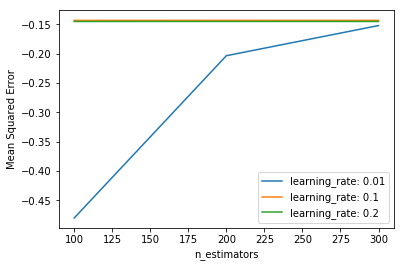

In [11]:
# plot
scores = np.array(means).reshape(len(learning_rate), len(max_depth), len(n_estimators))
for i, value in enumerate(learning_rate):
    plt.plot(n_estimators, scores[i][1], label='learning_rate: ' + str(value)) 
plt.legend()
plt.xlabel('n_estimators')
plt.ylabel('Mean Squared Error')
# print scores

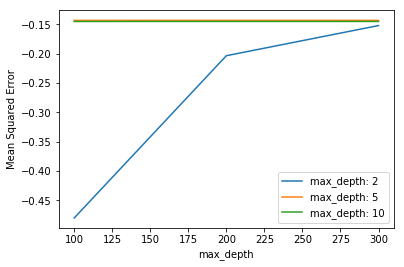

In [12]:
# plot
scores = np.array(means).reshape(len(max_depth), len(learning_rate), len(n_estimators))
for i, value in enumerate(max_depth):
    plt.plot(n_estimators, scores[i][1], label='max_depth: ' + str(value)) 
plt.legend()
plt.xlabel('max_depth')
plt.ylabel('Mean Squared Error')

In [20]:
%%time
boost = xgb.XGBRegressor(n_estimators=200, max_depth=5, learning_rate=0.1)
boost = boost.fit(data_matrix, train['SalePrice'])

CPU times: user 897 ms, sys: 20.1 ms, total: 917 ms
Wall time: 919 ms


In [21]:
%%time
train_preds = boost.predict(data_matrix)

CPU times: user 96.5 ms, sys: 2.44 ms, total: 98.9 ms
Wall time: 97.8 ms


In [22]:
%%time
from sklearn.metrics import mean_squared_log_error
print mean_squared_log_error(train['SalePrice'], train_preds)**0.5

0.0383487853763
CPU times: user 1.54 ms, sys: 591 µs, total: 2.14 ms
Wall time: 1.67 ms


In [26]:
test = test.fillna(-1)
train['MSSubClass'] = train['MSSubClass'].astype(str)
test_data_matrix = dv.transform(test[features].T.to_dict().values())
test_poly = poly.transform(test_data_matrix.toarray())

In [27]:
preds = boost.predict(test_poly)

ValueError: feature_names mismatch: ['f0', 'f1', 'f2', 'f3', 'f4', 'f5', 'f6', 'f7', 'f8', 'f9', 'f10', 'f11', 'f12', 'f13', 'f14', 'f15', 'f16', 'f17', 'f18', 'f19', 'f20', 'f21', 'f22', 'f23', 'f24', 'f25', 'f26', 'f27', 'f28', 'f29', 'f30', 'f31', 'f32', 'f33', 'f34', 'f35', 'f36', 'f37', 'f38', 'f39', 'f40', 'f41', 'f42', 'f43', 'f44', 'f45', 'f46', 'f47', 'f48', 'f49', 'f50', 'f51', 'f52', 'f53', 'f54', 'f55', 'f56', 'f57', 'f58', 'f59', 'f60', 'f61', 'f62', 'f63', 'f64', 'f65', 'f66', 'f67', 'f68', 'f69', 'f70', 'f71', 'f72', 'f73', 'f74', 'f75', 'f76', 'f77', 'f78', 'f79', 'f80', 'f81', 'f82', 'f83', 'f84', 'f85', 'f86', 'f87', 'f88', 'f89', 'f90', 'f91', 'f92', 'f93', 'f94', 'f95', 'f96', 'f97', 'f98', 'f99', 'f100', 'f101', 'f102', 'f103', 'f104', 'f105', 'f106', 'f107', 'f108', 'f109', 'f110', 'f111', 'f112', 'f113', 'f114', 'f115', 'f116', 'f117', 'f118', 'f119', 'f120', 'f121', 'f122', 'f123', 'f124', 'f125', 'f126', 'f127', 'f128', 'f129', 'f130', 'f131', 'f132', 'f133', 'f134', 'f135', 'f136', 'f137', 'f138', 'f139', 'f140', 'f141', 'f142', 'f143', 'f144', 'f145', 'f146', 'f147', 'f148', 'f149', 'f150', 'f151', 'f152', 'f153', 'f154', 'f155', 'f156', 'f157', 'f158', 'f159', 'f160', 'f161', 'f162', 'f163', 'f164', 'f165', 'f166', 'f167', 'f168', 'f169', 'f170', 'f171', 'f172', 'f173', 'f174', 'f175', 'f176', 'f177', 'f178', 'f179', 'f180', 'f181', 'f182', 'f183', 'f184', 'f185', 'f186', 'f187', 'f188', 'f189', 'f190', 'f191', 'f192', 'f193', 'f194', 'f195', 'f196', 'f197', 'f198', 'f199', 'f200', 'f201', 'f202', 'f203', 'f204', 'f205', 'f206', 'f207', 'f208', 'f209', 'f210', 'f211', 'f212', 'f213', 'f214', 'f215', 'f216', 'f217', 'f218', 'f219', 'f220', 'f221', 'f222', 'f223', 'f224', 'f225', 'f226', 'f227', 'f228', 'f229', 'f230', 'f231', 'f232', 'f233', 'f234', 'f235', 'f236', 'f237', 'f238', 'f239', 'f240', 'f241', 'f242', 'f243', 'f244', 'f245', 'f246', 'f247', 'f248', 'f249', 'f250', 'f251', 'f252', 'f253', 'f254', 'f255', 'f256', 'f257', 'f258', 'f259', 'f260', 'f261', 'f262', 'f263', 'f264', 'f265', 'f266', 'f267', 'f268', 'f269', 'f270', 'f271', 'f272', 'f273', 'f274', 'f275', 'f276', 'f277', 'f278', 'f279', 'f280', 'f281', 'f282', 'f283', 'f284', 'f285', 'f286', 'f287', 'f288', 'f289', 'f290', 'f291', 'f292', 'f293', 'f294', 'f295', 'f296', 'f297', 'f298', 'f299', 'f300', 'f301', 'f302', 'f303', 'f304', 'f305', 'f306', 'f307', 'f308', 'f309', 'f310', 'f311', 'f312', 'f313', 'f314', 'f315', 'f316', 'f317'] ['f0', 'f1', 'f2', 'f3', 'f4', 'f5', 'f6', 'f7', 'f8', 'f9', 'f10', 'f11', 'f12', 'f13', 'f14', 'f15', 'f16', 'f17', 'f18', 'f19', 'f20', 'f21', 'f22', 'f23', 'f24', 'f25', 'f26', 'f27', 'f28', 'f29', 'f30', 'f31', 'f32', 'f33', 'f34', 'f35', 'f36', 'f37', 'f38', 'f39', 'f40', 'f41', 'f42', 'f43', 'f44', 'f45', 'f46', 'f47', 'f48', 'f49', 'f50', 'f51', 'f52', 'f53', 'f54', 'f55', 'f56', 'f57', 'f58', 'f59', 'f60', 'f61', 'f62', 'f63', 'f64', 'f65', 'f66', 'f67', 'f68', 'f69', 'f70', 'f71', 'f72', 'f73', 'f74', 'f75', 'f76', 'f77', 'f78', 'f79', 'f80', 'f81', 'f82', 'f83', 'f84', 'f85', 'f86', 'f87', 'f88', 'f89', 'f90', 'f91', 'f92', 'f93', 'f94', 'f95', 'f96', 'f97', 'f98', 'f99', 'f100', 'f101', 'f102', 'f103', 'f104', 'f105', 'f106', 'f107', 'f108', 'f109', 'f110', 'f111', 'f112', 'f113', 'f114', 'f115', 'f116', 'f117', 'f118', 'f119', 'f120', 'f121', 'f122', 'f123', 'f124', 'f125', 'f126', 'f127', 'f128', 'f129', 'f130', 'f131', 'f132', 'f133', 'f134', 'f135', 'f136', 'f137', 'f138', 'f139', 'f140', 'f141', 'f142', 'f143', 'f144', 'f145', 'f146', 'f147', 'f148', 'f149', 'f150', 'f151', 'f152', 'f153', 'f154', 'f155', 'f156', 'f157', 'f158', 'f159', 'f160', 'f161', 'f162', 'f163', 'f164', 'f165', 'f166', 'f167', 'f168', 'f169', 'f170', 'f171', 'f172', 'f173', 'f174', 'f175', 'f176', 'f177', 'f178', 'f179', 'f180', 'f181', 'f182', 'f183', 'f184', 'f185', 'f186', 'f187', 'f188', 'f189', 'f190', 'f191', 'f192', 'f193', 'f194', 'f195', 'f196', 'f197', 'f198', 'f199', 'f200', 'f201', 'f202', 'f203', 'f204', 'f205', 'f206', 'f207', 'f208', 'f209', 'f210', 'f211', 'f212', 'f213', 'f214', 'f215', 'f216', 'f217', 'f218', 'f219', 'f220', 'f221', 'f222', 'f223', 'f224', 'f225', 'f226', 'f227', 'f228', 'f229', 'f230', 'f231', 'f232', 'f233', 'f234', 'f235', 'f236', 'f237', 'f238', 'f239', 'f240', 'f241', 'f242', 'f243', 'f244', 'f245', 'f246', 'f247', 'f248', 'f249', 'f250', 'f251', 'f252', 'f253', 'f254', 'f255', 'f256', 'f257', 'f258', 'f259', 'f260', 'f261', 'f262', 'f263', 'f264', 'f265', 'f266', 'f267', 'f268', 'f269', 'f270', 'f271', 'f272', 'f273', 'f274', 'f275', 'f276', 'f277', 'f278', 'f279', 'f280', 'f281', 'f282', 'f283', 'f284', 'f285', 'f286', 'f287', 'f288', 'f289', 'f290', 'f291', 'f292', 'f293', 'f294', 'f295', 'f296', 'f297', 'f298', 'f299', 'f300', 'f301', 'f302', 'f303', 'f304', 'f305', 'f306', 'f307', 'f308', 'f309', 'f310', 'f311', 'f312', 'f313', 'f314', 'f315', 'f316', 'f317', 'f318', 'f319', 'f320', 'f321', 'f322', 'f323', 'f324', 'f325', 'f326', 'f327', 'f328', 'f329', 'f330', 'f331', 'f332', 'f333', 'f334', 'f335', 'f336', 'f337', 'f338', 'f339', 'f340', 'f341', 'f342', 'f343', 'f344', 'f345', 'f346', 'f347', 'f348', 'f349', 'f350', 'f351', 'f352', 'f353', 'f354', 'f355', 'f356', 'f357', 'f358', 'f359', 'f360', 'f361', 'f362', 'f363', 'f364', 'f365', 'f366', 'f367', 'f368', 'f369', 'f370', 'f371', 'f372', 'f373', 'f374', 'f375', 'f376', 'f377', 'f378', 'f379', 'f380', 'f381', 'f382', 'f383', 'f384', 'f385', 'f386', 'f387', 'f388', 'f389', 'f390', 'f391', 'f392', 'f393', 'f394', 'f395', 'f396', 'f397', 'f398', 'f399', 'f400', 'f401', 'f402', 'f403', 'f404', 'f405', 'f406', 'f407', 'f408', 'f409', 'f410', 'f411', 'f412', 'f413', 'f414', 'f415', 'f416', 'f417', 'f418', 'f419', 'f420', 'f421', 'f422', 'f423', 'f424', 'f425', 'f426', 'f427', 'f428', 'f429', 'f430', 'f431', 'f432', 'f433', 'f434', 'f435', 'f436', 'f437', 'f438', 'f439', 'f440', 'f441', 'f442', 'f443', 'f444', 'f445', 'f446', 'f447', 'f448', 'f449', 'f450', 'f451', 'f452', 'f453', 'f454', 'f455', 'f456', 'f457', 'f458', 'f459', 'f460', 'f461', 'f462', 'f463', 'f464', 'f465', 'f466', 'f467', 'f468', 'f469', 'f470', 'f471', 'f472', 'f473', 'f474', 'f475', 'f476', 'f477', 'f478', 'f479', 'f480', 'f481', 'f482', 'f483', 'f484', 'f485', 'f486', 'f487', 'f488', 'f489', 'f490', 'f491', 'f492', 'f493', 'f494', 'f495', 'f496', 'f497', 'f498', 'f499', 'f500', 'f501', 'f502', 'f503', 'f504', 'f505', 'f506', 'f507', 'f508', 'f509', 'f510', 'f511', 'f512', 'f513', 'f514', 'f515', 'f516', 'f517', 'f518', 'f519', 'f520', 'f521', 'f522', 'f523', 'f524', 'f525', 'f526', 'f527', 'f528', 'f529', 'f530', 'f531', 'f532', 'f533', 'f534', 'f535', 'f536', 'f537', 'f538', 'f539', 'f540', 'f541', 'f542', 'f543', 'f544', 'f545', 'f546', 'f547', 'f548', 'f549', 'f550', 'f551', 'f552', 'f553', 'f554', 'f555', 'f556', 'f557', 'f558', 'f559', 'f560', 'f561', 'f562', 'f563', 'f564', 'f565', 'f566', 'f567', 'f568', 'f569', 'f570', 'f571', 'f572', 'f573', 'f574', 'f575', 'f576', 'f577', 'f578', 'f579', 'f580', 'f581', 'f582', 'f583', 'f584', 'f585', 'f586', 'f587', 'f588', 'f589', 'f590', 'f591', 'f592', 'f593', 'f594', 'f595', 'f596', 'f597', 'f598', 'f599', 'f600', 'f601', 'f602', 'f603', 'f604', 'f605', 'f606', 'f607', 'f608', 'f609', 'f610', 'f611', 'f612', 'f613', 'f614', 'f615', 'f616', 'f617', 'f618', 'f619', 'f620', 'f621', 'f622', 'f623', 'f624', 'f625', 'f626', 'f627', 'f628', 'f629', 'f630', 'f631', 'f632', 'f633', 'f634', 'f635', 'f636', 'f637', 'f638', 'f639', 'f640', 'f641', 'f642', 'f643', 'f644', 'f645', 'f646', 'f647', 'f648', 'f649', 'f650', 'f651', 'f652', 'f653', 'f654', 'f655', 'f656', 'f657', 'f658', 'f659', 'f660', 'f661', 'f662', 'f663', 'f664', 'f665', 'f666', 'f667', 'f668', 'f669', 'f670', 'f671', 'f672', 'f673', 'f674', 'f675', 'f676', 'f677', 'f678', 'f679', 'f680', 'f681', 'f682', 'f683', 'f684', 'f685', 'f686', 'f687', 'f688', 'f689', 'f690', 'f691', 'f692', 'f693', 'f694', 'f695', 'f696', 'f697', 'f698', 'f699', 'f700', 'f701', 'f702', 'f703', 'f704', 'f705', 'f706', 'f707', 'f708', 'f709', 'f710', 'f711', 'f712', 'f713', 'f714', 'f715', 'f716', 'f717', 'f718', 'f719', 'f720', 'f721', 'f722', 'f723', 'f724', 'f725', 'f726', 'f727', 'f728', 'f729', 'f730', 'f731', 'f732', 'f733', 'f734', 'f735', 'f736', 'f737', 'f738', 'f739', 'f740', 'f741', 'f742', 'f743', 'f744', 'f745', 'f746', 'f747', 'f748', 'f749', 'f750', 'f751', 'f752', 'f753', 'f754', 'f755', 'f756', 'f757', 'f758', 'f759', 'f760', 'f761', 'f762', 'f763', 'f764', 'f765', 'f766', 'f767', 'f768', 'f769', 'f770', 'f771', 'f772', 'f773', 'f774', 'f775', 'f776', 'f777', 'f778', 'f779', 'f780', 'f781', 'f782', 'f783', 'f784', 'f785', 'f786', 'f787', 'f788', 'f789', 'f790', 'f791', 'f792', 'f793', 'f794', 'f795', 'f796', 'f797', 'f798', 'f799', 'f800', 'f801', 'f802', 'f803', 'f804', 'f805', 'f806', 'f807', 'f808', 'f809', 'f810', 'f811', 'f812', 'f813', 'f814', 'f815', 'f816', 'f817', 'f818', 'f819', 'f820', 'f821', 'f822', 'f823', 'f824', 'f825', 'f826', 'f827', 'f828', 'f829', 'f830', 'f831', 'f832', 'f833', 'f834', 'f835', 'f836', 'f837', 'f838', 'f839', 'f840', 'f841', 'f842', 'f843', 'f844', 'f845', 'f846', 'f847', 'f848', 'f849', 'f850', 'f851', 'f852', 'f853', 'f854', 'f855', 'f856', 'f857', 'f858', 'f859', 'f860', 'f861', 'f862', 'f863', 'f864', 'f865', 'f866', 'f867', 'f868', 'f869', 'f870', 'f871', 'f872', 'f873', 'f874', 'f875', 'f876', 'f877', 'f878', 'f879', 'f880', 'f881', 'f882', 'f883', 'f884', 'f885', 'f886', 'f887', 'f888', 'f889', 'f890', 'f891', 'f892', 'f893', 'f894', 'f895', 'f896', 'f897', 'f898', 'f899', 'f900', 'f901', 'f902', 'f903', 'f904', 'f905', 'f906', 'f907', 'f908', 'f909', 'f910', 'f911', 'f912', 'f913', 'f914', 'f915', 'f916', 'f917', 'f918', 'f919', 'f920', 'f921', 'f922', 'f923', 'f924', 'f925', 'f926', 'f927', 'f928', 'f929', 'f930', 'f931', 'f932', 'f933', 'f934', 'f935', 'f936', 'f937', 'f938', 'f939', 'f940', 'f941', 'f942', 'f943', 'f944', 'f945', 'f946', 'f947', 'f948', 'f949', 'f950', 'f951', 'f952', 'f953', 'f954', 'f955', 'f956', 'f957', 'f958', 'f959', 'f960', 'f961', 'f962', 'f963', 'f964', 'f965', 'f966', 'f967', 'f968', 'f969', 'f970', 'f971', 'f972', 'f973', 'f974', 'f975', 'f976', 'f977', 'f978', 'f979', 'f980', 'f981', 'f982', 'f983', 'f984', 'f985', 'f986', 'f987', 'f988', 'f989', 'f990', 'f991', 'f992', 'f993', 'f994', 'f995', 'f996', 'f997', 'f998', 'f999', 'f1000', 'f1001', 'f1002', 'f1003', 'f1004', 'f1005', 'f1006', 'f1007', 'f1008', 'f1009', 'f1010', 'f1011', 'f1012', 'f1013', 'f1014', 'f1015', 'f1016', 'f1017', 'f1018', 'f1019', 'f1020', 'f1021', 'f1022', 'f1023', 'f1024', 'f1025', 'f1026', 'f1027', 'f1028', 'f1029', 'f1030', 'f1031', 'f1032', 'f1033', 'f1034', 'f1035', 'f1036', 'f1037', 'f1038', 'f1039', 'f1040', 'f1041', 'f1042', 'f1043', 'f1044', 'f1045', 'f1046', 'f1047', 'f1048', 'f1049', 'f1050', 'f1051', 'f1052', 'f1053', 'f1054', 'f1055', 'f1056', 'f1057', 'f1058', 'f1059', 'f1060', 'f1061', 'f1062', 'f1063', 'f1064', 'f1065', 'f1066', 'f1067', 'f1068', 'f1069', 'f1070', 'f1071', 'f1072', 'f1073', 'f1074', 'f1075', 'f1076', 'f1077', 'f1078', 'f1079', 'f1080', 'f1081', 'f1082', 'f1083', 'f1084', 'f1085', 'f1086', 'f1087', 'f1088', 'f1089', 'f1090', 'f1091', 'f1092', 'f1093', 'f1094', 'f1095', 'f1096', 'f1097', 'f1098', 'f1099', 'f1100', 'f1101', 'f1102', 'f1103', 'f1104', 'f1105', 'f1106', 'f1107', 'f1108', 'f1109', 'f1110', 'f1111', 'f1112', 'f1113', 'f1114', 'f1115', 'f1116', 'f1117', 'f1118', 'f1119', 'f1120', 'f1121', 'f1122', 'f1123', 'f1124', 'f1125', 'f1126', 'f1127', 'f1128', 'f1129', 'f1130', 'f1131', 'f1132', 'f1133', 'f1134', 'f1135', 'f1136', 'f1137', 'f1138', 'f1139', 'f1140', 'f1141', 'f1142', 'f1143', 'f1144', 'f1145', 'f1146', 'f1147', 'f1148', 'f1149', 'f1150', 'f1151', 'f1152', 'f1153', 'f1154', 'f1155', 'f1156', 'f1157', 'f1158', 'f1159', 'f1160', 'f1161', 'f1162', 'f1163', 'f1164', 'f1165', 'f1166', 'f1167', 'f1168', 'f1169', 'f1170', 'f1171', 'f1172', 'f1173', 'f1174', 'f1175', 'f1176', 'f1177', 'f1178', 'f1179', 'f1180', 'f1181', 'f1182', 'f1183', 'f1184', 'f1185', 'f1186', 'f1187', 'f1188', 'f1189', 'f1190', 'f1191', 'f1192', 'f1193', 'f1194', 'f1195', 'f1196', 'f1197', 'f1198', 'f1199', 'f1200', 'f1201', 'f1202', 'f1203', 'f1204', 'f1205', 'f1206', 'f1207', 'f1208', 'f1209', 'f1210', 'f1211', 'f1212', 'f1213', 'f1214', 'f1215', 'f1216', 'f1217', 'f1218', 'f1219', 'f1220', 'f1221', 'f1222', 'f1223', 'f1224', 'f1225', 'f1226', 'f1227', 'f1228', 'f1229', 'f1230', 'f1231', 'f1232', 'f1233', 'f1234', 'f1235', 'f1236', 'f1237', 'f1238', 'f1239', 'f1240', 'f1241', 'f1242', 'f1243', 'f1244', 'f1245', 'f1246', 'f1247', 'f1248', 'f1249', 'f1250', 'f1251', 'f1252', 'f1253', 'f1254', 'f1255', 'f1256', 'f1257', 'f1258', 'f1259', 'f1260', 'f1261', 'f1262', 'f1263', 'f1264', 'f1265', 'f1266', 'f1267', 'f1268', 'f1269', 'f1270', 'f1271', 'f1272', 'f1273', 'f1274', 'f1275', 'f1276', 'f1277', 'f1278', 'f1279', 'f1280', 'f1281', 'f1282', 'f1283', 'f1284', 'f1285', 'f1286', 'f1287', 'f1288', 'f1289', 'f1290', 'f1291', 'f1292', 'f1293', 'f1294', 'f1295', 'f1296', 'f1297', 'f1298', 'f1299', 'f1300', 'f1301', 'f1302', 'f1303', 'f1304', 'f1305', 'f1306', 'f1307', 'f1308', 'f1309', 'f1310', 'f1311', 'f1312', 'f1313', 'f1314', 'f1315', 'f1316', 'f1317', 'f1318', 'f1319', 'f1320', 'f1321', 'f1322', 'f1323', 'f1324', 'f1325', 'f1326', 'f1327', 'f1328', 'f1329', 'f1330', 'f1331', 'f1332', 'f1333', 'f1334', 'f1335', 'f1336', 'f1337', 'f1338', 'f1339', 'f1340', 'f1341', 'f1342', 'f1343', 'f1344', 'f1345', 'f1346', 'f1347', 'f1348', 'f1349', 'f1350', 'f1351', 'f1352', 'f1353', 'f1354', 'f1355', 'f1356', 'f1357', 'f1358', 'f1359', 'f1360', 'f1361', 'f1362', 'f1363', 'f1364', 'f1365', 'f1366', 'f1367', 'f1368', 'f1369', 'f1370', 'f1371', 'f1372', 'f1373', 'f1374', 'f1375', 'f1376', 'f1377', 'f1378', 'f1379', 'f1380', 'f1381', 'f1382', 'f1383', 'f1384', 'f1385', 'f1386', 'f1387', 'f1388', 'f1389', 'f1390', 'f1391', 'f1392', 'f1393', 'f1394', 'f1395', 'f1396', 'f1397', 'f1398', 'f1399', 'f1400', 'f1401', 'f1402', 'f1403', 'f1404', 'f1405', 'f1406', 'f1407', 'f1408', 'f1409', 'f1410', 'f1411', 'f1412', 'f1413', 'f1414', 'f1415', 'f1416', 'f1417', 'f1418', 'f1419', 'f1420', 'f1421', 'f1422', 'f1423', 'f1424', 'f1425', 'f1426', 'f1427', 'f1428', 'f1429', 'f1430', 'f1431', 'f1432', 'f1433', 'f1434', 'f1435', 'f1436', 'f1437', 'f1438', 'f1439', 'f1440', 'f1441', 'f1442', 'f1443', 'f1444', 'f1445', 'f1446', 'f1447', 'f1448', 'f1449', 'f1450', 'f1451', 'f1452', 'f1453', 'f1454', 'f1455', 'f1456', 'f1457', 'f1458', 'f1459', 'f1460', 'f1461', 'f1462', 'f1463', 'f1464', 'f1465', 'f1466', 'f1467', 'f1468', 'f1469', 'f1470', 'f1471', 'f1472', 'f1473', 'f1474', 'f1475', 'f1476', 'f1477', 'f1478', 'f1479', 'f1480', 'f1481', 'f1482', 'f1483', 'f1484', 'f1485', 'f1486', 'f1487', 'f1488', 'f1489', 'f1490', 'f1491', 'f1492', 'f1493', 'f1494', 'f1495', 'f1496', 'f1497', 'f1498', 'f1499', 'f1500', 'f1501', 'f1502', 'f1503', 'f1504', 'f1505', 'f1506', 'f1507', 'f1508', 'f1509', 'f1510', 'f1511', 'f1512', 'f1513', 'f1514', 'f1515', 'f1516', 'f1517', 'f1518', 'f1519', 'f1520', 'f1521', 'f1522', 'f1523', 'f1524', 'f1525', 'f1526', 'f1527', 'f1528', 'f1529', 'f1530', 'f1531', 'f1532', 'f1533', 'f1534', 'f1535', 'f1536', 'f1537', 'f1538', 'f1539', 'f1540', 'f1541', 'f1542', 'f1543', 'f1544', 'f1545', 'f1546', 'f1547', 'f1548', 'f1549', 'f1550', 'f1551', 'f1552', 'f1553', 'f1554', 'f1555', 'f1556', 'f1557', 'f1558', 'f1559', 'f1560', 'f1561', 'f1562', 'f1563', 'f1564', 'f1565', 'f1566', 'f1567', 'f1568', 'f1569', 'f1570', 'f1571', 'f1572', 'f1573', 'f1574', 'f1575', 'f1576', 'f1577', 'f1578', 'f1579', 'f1580', 'f1581', 'f1582', 'f1583', 'f1584', 'f1585', 'f1586', 'f1587', 'f1588', 'f1589', 'f1590', 'f1591', 'f1592', 'f1593', 'f1594', 'f1595', 'f1596', 'f1597', 'f1598', 'f1599', 'f1600', 'f1601', 'f1602', 'f1603', 'f1604', 'f1605', 'f1606', 'f1607', 'f1608', 'f1609', 'f1610', 'f1611', 'f1612', 'f1613', 'f1614', 'f1615', 'f1616', 'f1617', 'f1618', 'f1619', 'f1620', 'f1621', 'f1622', 'f1623', 'f1624', 'f1625', 'f1626', 'f1627', 'f1628', 'f1629', 'f1630', 'f1631', 'f1632', 'f1633', 'f1634', 'f1635', 'f1636', 'f1637', 'f1638', 'f1639', 'f1640', 'f1641', 'f1642', 'f1643', 'f1644', 'f1645', 'f1646', 'f1647', 'f1648', 'f1649', 'f1650', 'f1651', 'f1652', 'f1653', 'f1654', 'f1655', 'f1656', 'f1657', 'f1658', 'f1659', 'f1660', 'f1661', 'f1662', 'f1663', 'f1664', 'f1665', 'f1666', 'f1667', 'f1668', 'f1669', 'f1670', 'f1671', 'f1672', 'f1673', 'f1674', 'f1675', 'f1676', 'f1677', 'f1678', 'f1679', 'f1680', 'f1681', 'f1682', 'f1683', 'f1684', 'f1685', 'f1686', 'f1687', 'f1688', 'f1689', 'f1690', 'f1691', 'f1692', 'f1693', 'f1694', 'f1695', 'f1696', 'f1697', 'f1698', 'f1699', 'f1700', 'f1701', 'f1702', 'f1703', 'f1704', 'f1705', 'f1706', 'f1707', 'f1708', 'f1709', 'f1710', 'f1711', 'f1712', 'f1713', 'f1714', 'f1715', 'f1716', 'f1717', 'f1718', 'f1719', 'f1720', 'f1721', 'f1722', 'f1723', 'f1724', 'f1725', 'f1726', 'f1727', 'f1728', 'f1729', 'f1730', 'f1731', 'f1732', 'f1733', 'f1734', 'f1735', 'f1736', 'f1737', 'f1738', 'f1739', 'f1740', 'f1741', 'f1742', 'f1743', 'f1744', 'f1745', 'f1746', 'f1747', 'f1748', 'f1749', 'f1750', 'f1751', 'f1752', 'f1753', 'f1754', 'f1755', 'f1756', 'f1757', 'f1758', 'f1759', 'f1760', 'f1761', 'f1762', 'f1763', 'f1764', 'f1765', 'f1766', 'f1767', 'f1768', 'f1769', 'f1770', 'f1771', 'f1772', 'f1773', 'f1774', 'f1775', 'f1776', 'f1777', 'f1778', 'f1779', 'f1780', 'f1781', 'f1782', 'f1783', 'f1784', 'f1785', 'f1786', 'f1787', 'f1788', 'f1789', 'f1790', 'f1791', 'f1792', 'f1793', 'f1794', 'f1795', 'f1796', 'f1797', 'f1798', 'f1799', 'f1800', 'f1801', 'f1802', 'f1803', 'f1804', 'f1805', 'f1806', 'f1807', 'f1808', 'f1809', 'f1810', 'f1811', 'f1812', 'f1813', 'f1814', 'f1815', 'f1816', 'f1817', 'f1818', 'f1819', 'f1820', 'f1821', 'f1822', 'f1823', 'f1824', 'f1825', 'f1826', 'f1827', 'f1828', 'f1829', 'f1830', 'f1831', 'f1832', 'f1833', 'f1834', 'f1835', 'f1836', 'f1837', 'f1838', 'f1839', 'f1840', 'f1841', 'f1842', 'f1843', 'f1844', 'f1845', 'f1846', 'f1847', 'f1848', 'f1849', 'f1850', 'f1851', 'f1852', 'f1853', 'f1854', 'f1855', 'f1856', 'f1857', 'f1858', 'f1859', 'f1860', 'f1861', 'f1862', 'f1863', 'f1864', 'f1865', 'f1866', 'f1867', 'f1868', 'f1869', 'f1870', 'f1871', 'f1872', 'f1873', 'f1874', 'f1875', 'f1876', 'f1877', 'f1878', 'f1879', 'f1880', 'f1881', 'f1882', 'f1883', 'f1884', 'f1885', 'f1886', 'f1887', 'f1888', 'f1889', 'f1890', 'f1891', 'f1892', 'f1893', 'f1894', 'f1895', 'f1896', 'f1897', 'f1898', 'f1899', 'f1900', 'f1901', 'f1902', 'f1903', 'f1904', 'f1905', 'f1906', 'f1907', 'f1908', 'f1909', 'f1910', 'f1911', 'f1912', 'f1913', 'f1914', 'f1915', 'f1916', 'f1917', 'f1918', 'f1919', 'f1920', 'f1921', 'f1922', 'f1923', 'f1924', 'f1925', 'f1926', 'f1927', 'f1928', 'f1929', 'f1930', 'f1931', 'f1932', 'f1933', 'f1934', 'f1935', 'f1936', 'f1937', 'f1938', 'f1939', 'f1940', 'f1941', 'f1942', 'f1943', 'f1944', 'f1945', 'f1946', 'f1947', 'f1948', 'f1949', 'f1950', 'f1951', 'f1952', 'f1953', 'f1954', 'f1955', 'f1956', 'f1957', 'f1958', 'f1959', 'f1960', 'f1961', 'f1962', 'f1963', 'f1964', 'f1965', 'f1966', 'f1967', 'f1968', 'f1969', 'f1970', 'f1971', 'f1972', 'f1973', 'f1974', 'f1975', 'f1976', 'f1977', 'f1978', 'f1979', 'f1980', 'f1981', 'f1982', 'f1983', 'f1984', 'f1985', 'f1986', 'f1987', 'f1988', 'f1989', 'f1990', 'f1991', 'f1992', 'f1993', 'f1994', 'f1995', 'f1996', 'f1997', 'f1998', 'f1999', 'f2000', 'f2001', 'f2002', 'f2003', 'f2004', 'f2005', 'f2006', 'f2007', 'f2008', 'f2009', 'f2010', 'f2011', 'f2012', 'f2013', 'f2014', 'f2015', 'f2016', 'f2017', 'f2018', 'f2019', 'f2020', 'f2021', 'f2022', 'f2023', 'f2024', 'f2025', 'f2026', 'f2027', 'f2028', 'f2029', 'f2030', 'f2031', 'f2032', 'f2033', 'f2034', 'f2035', 'f2036', 'f2037', 'f2038', 'f2039', 'f2040', 'f2041', 'f2042', 'f2043', 'f2044', 'f2045', 'f2046', 'f2047', 'f2048', 'f2049', 'f2050', 'f2051', 'f2052', 'f2053', 'f2054', 'f2055', 'f2056', 'f2057', 'f2058', 'f2059', 'f2060', 'f2061', 'f2062', 'f2063', 'f2064', 'f2065', 'f2066', 'f2067', 'f2068', 'f2069', 'f2070', 'f2071', 'f2072', 'f2073', 'f2074', 'f2075', 'f2076', 'f2077', 'f2078', 'f2079', 'f2080', 'f2081', 'f2082', 'f2083', 'f2084', 'f2085', 'f2086', 'f2087', 'f2088', 'f2089', 'f2090', 'f2091', 'f2092', 'f2093', 'f2094', 'f2095', 'f2096', 'f2097', 'f2098', 'f2099', 'f2100', 'f2101', 'f2102', 'f2103', 'f2104', 'f2105', 'f2106', 'f2107', 'f2108', 'f2109', 'f2110', 'f2111', 'f2112', 'f2113', 'f2114', 'f2115', 'f2116', 'f2117', 'f2118', 'f2119', 'f2120', 'f2121', 'f2122', 'f2123', 'f2124', 'f2125', 'f2126', 'f2127', 'f2128', 'f2129', 'f2130', 'f2131', 'f2132', 'f2133', 'f2134', 'f2135', 'f2136', 'f2137', 'f2138', 'f2139', 'f2140', 'f2141', 'f2142', 'f2143', 'f2144', 'f2145', 'f2146', 'f2147', 'f2148', 'f2149', 'f2150', 'f2151', 'f2152', 'f2153', 'f2154', 'f2155', 'f2156', 'f2157', 'f2158', 'f2159', 'f2160', 'f2161', 'f2162', 'f2163', 'f2164', 'f2165', 'f2166', 'f2167', 'f2168', 'f2169', 'f2170', 'f2171', 'f2172', 'f2173', 'f2174', 'f2175', 'f2176', 'f2177', 'f2178', 'f2179', 'f2180', 'f2181', 'f2182', 'f2183', 'f2184', 'f2185', 'f2186', 'f2187', 'f2188', 'f2189', 'f2190', 'f2191', 'f2192', 'f2193', 'f2194', 'f2195', 'f2196', 'f2197', 'f2198', 'f2199', 'f2200', 'f2201', 'f2202', 'f2203', 'f2204', 'f2205', 'f2206', 'f2207', 'f2208', 'f2209', 'f2210', 'f2211', 'f2212', 'f2213', 'f2214', 'f2215', 'f2216', 'f2217', 'f2218', 'f2219', 'f2220', 'f2221', 'f2222', 'f2223', 'f2224', 'f2225', 'f2226', 'f2227', 'f2228', 'f2229', 'f2230', 'f2231', 'f2232', 'f2233', 'f2234', 'f2235', 'f2236', 'f2237', 'f2238', 'f2239', 'f2240', 'f2241', 'f2242', 'f2243', 'f2244', 'f2245', 'f2246', 'f2247', 'f2248', 'f2249', 'f2250', 'f2251', 'f2252', 'f2253', 'f2254', 'f2255', 'f2256', 'f2257', 'f2258', 'f2259', 'f2260', 'f2261', 'f2262', 'f2263', 'f2264', 'f2265', 'f2266', 'f2267', 'f2268', 'f2269', 'f2270', 'f2271', 'f2272', 'f2273', 'f2274', 'f2275', 'f2276', 'f2277', 'f2278', 'f2279', 'f2280', 'f2281', 'f2282', 'f2283', 'f2284', 'f2285', 'f2286', 'f2287', 'f2288', 'f2289', 'f2290', 'f2291', 'f2292', 'f2293', 'f2294', 'f2295', 'f2296', 'f2297', 'f2298', 'f2299', 'f2300', 'f2301', 'f2302', 'f2303', 'f2304', 'f2305', 'f2306', 'f2307', 'f2308', 'f2309', 'f2310', 'f2311', 'f2312', 'f2313', 'f2314', 'f2315', 'f2316', 'f2317', 'f2318', 'f2319', 'f2320', 'f2321', 'f2322', 'f2323', 'f2324', 'f2325', 'f2326', 'f2327', 'f2328', 'f2329', 'f2330', 'f2331', 'f2332', 'f2333', 'f2334', 'f2335', 'f2336', 'f2337', 'f2338', 'f2339', 'f2340', 'f2341', 'f2342', 'f2343', 'f2344', 'f2345', 'f2346', 'f2347', 'f2348', 'f2349', 'f2350', 'f2351', 'f2352', 'f2353', 'f2354', 'f2355', 'f2356', 'f2357', 'f2358', 'f2359', 'f2360', 'f2361', 'f2362', 'f2363', 'f2364', 'f2365', 'f2366', 'f2367', 'f2368', 'f2369', 'f2370', 'f2371', 'f2372', 'f2373', 'f2374', 'f2375', 'f2376', 'f2377', 'f2378', 'f2379', 'f2380', 'f2381', 'f2382', 'f2383', 'f2384', 'f2385', 'f2386', 'f2387', 'f2388', 'f2389', 'f2390', 'f2391', 'f2392', 'f2393', 'f2394', 'f2395', 'f2396', 'f2397', 'f2398', 'f2399', 'f2400', 'f2401', 'f2402', 'f2403', 'f2404', 'f2405', 'f2406', 'f2407', 'f2408', 'f2409', 'f2410', 'f2411', 'f2412', 'f2413', 'f2414', 'f2415', 'f2416', 'f2417', 'f2418', 'f2419', 'f2420', 'f2421', 'f2422', 'f2423', 'f2424', 'f2425', 'f2426', 'f2427', 'f2428', 'f2429', 'f2430', 'f2431', 'f2432', 'f2433', 'f2434', 'f2435', 'f2436', 'f2437', 'f2438', 'f2439', 'f2440', 'f2441', 'f2442', 'f2443', 'f2444', 'f2445', 'f2446', 'f2447', 'f2448', 'f2449', 'f2450', 'f2451', 'f2452', 'f2453', 'f2454', 'f2455', 'f2456', 'f2457', 'f2458', 'f2459', 'f2460', 'f2461', 'f2462', 'f2463', 'f2464', 'f2465', 'f2466', 'f2467', 'f2468', 'f2469', 'f2470', 'f2471', 'f2472', 'f2473', 'f2474', 'f2475', 'f2476', 'f2477', 'f2478', 'f2479', 'f2480', 'f2481', 'f2482', 'f2483', 'f2484', 'f2485', 'f2486', 'f2487', 'f2488', 'f2489', 'f2490', 'f2491', 'f2492', 'f2493', 'f2494', 'f2495', 'f2496', 'f2497', 'f2498', 'f2499', 'f2500', 'f2501', 'f2502', 'f2503', 'f2504', 'f2505', 'f2506', 'f2507', 'f2508', 'f2509', 'f2510', 'f2511', 'f2512', 'f2513', 'f2514', 'f2515', 'f2516', 'f2517', 'f2518', 'f2519', 'f2520', 'f2521', 'f2522', 'f2523', 'f2524', 'f2525', 'f2526', 'f2527', 'f2528', 'f2529', 'f2530', 'f2531', 'f2532', 'f2533', 'f2534', 'f2535', 'f2536', 'f2537', 'f2538', 'f2539', 'f2540', 'f2541', 'f2542', 'f2543', 'f2544', 'f2545', 'f2546', 'f2547', 'f2548', 'f2549', 'f2550', 'f2551', 'f2552', 'f2553', 'f2554', 'f2555', 'f2556', 'f2557', 'f2558', 'f2559', 'f2560', 'f2561', 'f2562', 'f2563', 'f2564', 'f2565', 'f2566', 'f2567', 'f2568', 'f2569', 'f2570', 'f2571', 'f2572', 'f2573', 'f2574', 'f2575', 'f2576', 'f2577', 'f2578', 'f2579', 'f2580', 'f2581', 'f2582', 'f2583', 'f2584', 'f2585', 'f2586', 'f2587', 'f2588', 'f2589', 'f2590', 'f2591', 'f2592', 'f2593', 'f2594', 'f2595', 'f2596', 'f2597', 'f2598', 'f2599', 'f2600', 'f2601', 'f2602', 'f2603', 'f2604', 'f2605', 'f2606', 'f2607', 'f2608', 'f2609', 'f2610', 'f2611', 'f2612', 'f2613', 'f2614', 'f2615', 'f2616', 'f2617', 'f2618', 'f2619', 'f2620', 'f2621', 'f2622', 'f2623', 'f2624', 'f2625', 'f2626', 'f2627', 'f2628', 'f2629', 'f2630', 'f2631', 'f2632', 'f2633', 'f2634', 'f2635', 'f2636', 'f2637', 'f2638', 'f2639', 'f2640', 'f2641', 'f2642', 'f2643', 'f2644', 'f2645', 'f2646', 'f2647', 'f2648', 'f2649', 'f2650', 'f2651', 'f2652', 'f2653', 'f2654', 'f2655', 'f2656', 'f2657', 'f2658', 'f2659', 'f2660', 'f2661', 'f2662', 'f2663', 'f2664', 'f2665', 'f2666', 'f2667', 'f2668', 'f2669', 'f2670', 'f2671', 'f2672', 'f2673', 'f2674', 'f2675', 'f2676', 'f2677', 'f2678', 'f2679', 'f2680', 'f2681', 'f2682', 'f2683', 'f2684', 'f2685', 'f2686', 'f2687', 'f2688', 'f2689', 'f2690', 'f2691', 'f2692', 'f2693', 'f2694', 'f2695', 'f2696', 'f2697', 'f2698', 'f2699', 'f2700', 'f2701', 'f2702', 'f2703', 'f2704', 'f2705', 'f2706', 'f2707', 'f2708', 'f2709', 'f2710', 'f2711', 'f2712', 'f2713', 'f2714', 'f2715', 'f2716', 'f2717', 'f2718', 'f2719', 'f2720', 'f2721', 'f2722', 'f2723', 'f2724', 'f2725', 'f2726', 'f2727', 'f2728', 'f2729', 'f2730', 'f2731', 'f2732', 'f2733', 'f2734', 'f2735', 'f2736', 'f2737', 'f2738', 'f2739', 'f2740', 'f2741', 'f2742', 'f2743', 'f2744', 'f2745', 'f2746', 'f2747', 'f2748', 'f2749', 'f2750', 'f2751', 'f2752', 'f2753', 'f2754', 'f2755', 'f2756', 'f2757', 'f2758', 'f2759', 'f2760', 'f2761', 'f2762', 'f2763', 'f2764', 'f2765', 'f2766', 'f2767', 'f2768', 'f2769', 'f2770', 'f2771', 'f2772', 'f2773', 'f2774', 'f2775', 'f2776', 'f2777', 'f2778', 'f2779', 'f2780', 'f2781', 'f2782', 'f2783', 'f2784', 'f2785', 'f2786', 'f2787', 'f2788', 'f2789', 'f2790', 'f2791', 'f2792', 'f2793', 'f2794', 'f2795', 'f2796', 'f2797', 'f2798', 'f2799', 'f2800', 'f2801', 'f2802', 'f2803', 'f2804', 'f2805', 'f2806', 'f2807', 'f2808', 'f2809', 'f2810', 'f2811', 'f2812', 'f2813', 'f2814', 'f2815', 'f2816', 'f2817', 'f2818', 'f2819', 'f2820', 'f2821', 'f2822', 'f2823', 'f2824', 'f2825', 'f2826', 'f2827', 'f2828', 'f2829', 'f2830', 'f2831', 'f2832', 'f2833', 'f2834', 'f2835', 'f2836', 'f2837', 'f2838', 'f2839', 'f2840', 'f2841', 'f2842', 'f2843', 'f2844', 'f2845', 'f2846', 'f2847', 'f2848', 'f2849', 'f2850', 'f2851', 'f2852', 'f2853', 'f2854', 'f2855', 'f2856', 'f2857', 'f2858', 'f2859', 'f2860', 'f2861', 'f2862', 'f2863', 'f2864', 'f2865', 'f2866', 'f2867', 'f2868', 'f2869', 'f2870', 'f2871', 'f2872', 'f2873', 'f2874', 'f2875', 'f2876', 'f2877', 'f2878', 'f2879', 'f2880', 'f2881', 'f2882', 'f2883', 'f2884', 'f2885', 'f2886', 'f2887', 'f2888', 'f2889', 'f2890', 'f2891', 'f2892', 'f2893', 'f2894', 'f2895', 'f2896', 'f2897', 'f2898', 'f2899', 'f2900', 'f2901', 'f2902', 'f2903', 'f2904', 'f2905', 'f2906', 'f2907', 'f2908', 'f2909', 'f2910', 'f2911', 'f2912', 'f2913', 'f2914', 'f2915', 'f2916', 'f2917', 'f2918', 'f2919', 'f2920', 'f2921', 'f2922', 'f2923', 'f2924', 'f2925', 'f2926', 'f2927', 'f2928', 'f2929', 'f2930', 'f2931', 'f2932', 'f2933', 'f2934', 'f2935', 'f2936', 'f2937', 'f2938', 'f2939', 'f2940', 'f2941', 'f2942', 'f2943', 'f2944', 'f2945', 'f2946', 'f2947', 'f2948', 'f2949', 'f2950', 'f2951', 'f2952', 'f2953', 'f2954', 'f2955', 'f2956', 'f2957', 'f2958', 'f2959', 'f2960', 'f2961', 'f2962', 'f2963', 'f2964', 'f2965', 'f2966', 'f2967', 'f2968', 'f2969', 'f2970', 'f2971', 'f2972', 'f2973', 'f2974', 'f2975', 'f2976', 'f2977', 'f2978', 'f2979', 'f2980', 'f2981', 'f2982', 'f2983', 'f2984', 'f2985', 'f2986', 'f2987', 'f2988', 'f2989', 'f2990', 'f2991', 'f2992', 'f2993', 'f2994', 'f2995', 'f2996', 'f2997', 'f2998', 'f2999', 'f3000', 'f3001', 'f3002', 'f3003', 'f3004', 'f3005', 'f3006', 'f3007', 'f3008', 'f3009', 'f3010', 'f3011', 'f3012', 'f3013', 'f3014', 'f3015', 'f3016', 'f3017', 'f3018', 'f3019', 'f3020', 'f3021', 'f3022', 'f3023', 'f3024', 'f3025', 'f3026', 'f3027', 'f3028', 'f3029', 'f3030', 'f3031', 'f3032', 'f3033', 'f3034', 'f3035', 'f3036', 'f3037', 'f3038', 'f3039', 'f3040', 'f3041', 'f3042', 'f3043', 'f3044', 'f3045', 'f3046', 'f3047', 'f3048', 'f3049', 'f3050', 'f3051', 'f3052', 'f3053', 'f3054', 'f3055', 'f3056', 'f3057', 'f3058', 'f3059', 'f3060', 'f3061', 'f3062', 'f3063', 'f3064', 'f3065', 'f3066', 'f3067', 'f3068', 'f3069', 'f3070', 'f3071', 'f3072', 'f3073', 'f3074', 'f3075', 'f3076', 'f3077', 'f3078', 'f3079', 'f3080', 'f3081', 'f3082', 'f3083', 'f3084', 'f3085', 'f3086', 'f3087', 'f3088', 'f3089', 'f3090', 'f3091', 'f3092', 'f3093', 'f3094', 'f3095', 'f3096', 'f3097', 'f3098', 'f3099', 'f3100', 'f3101', 'f3102', 'f3103', 'f3104', 'f3105', 'f3106', 'f3107', 'f3108', 'f3109', 'f3110', 'f3111', 'f3112', 'f3113', 'f3114', 'f3115', 'f3116', 'f3117', 'f3118', 'f3119', 'f3120', 'f3121', 'f3122', 'f3123', 'f3124', 'f3125', 'f3126', 'f3127', 'f3128', 'f3129', 'f3130', 'f3131', 'f3132', 'f3133', 'f3134', 'f3135', 'f3136', 'f3137', 'f3138', 'f3139', 'f3140', 'f3141', 'f3142', 'f3143', 'f3144', 'f3145', 'f3146', 'f3147', 'f3148', 'f3149', 'f3150', 'f3151', 'f3152', 'f3153', 'f3154', 'f3155', 'f3156', 'f3157', 'f3158', 'f3159', 'f3160', 'f3161', 'f3162', 'f3163', 'f3164', 'f3165', 'f3166', 'f3167', 'f3168', 'f3169', 'f3170', 'f3171', 'f3172', 'f3173', 'f3174', 'f3175', 'f3176', 'f3177', 'f3178', 'f3179', 'f3180', 'f3181', 'f3182', 'f3183', 'f3184', 'f3185', 'f3186', 'f3187', 'f3188', 'f3189', 'f3190', 'f3191', 'f3192', 'f3193', 'f3194', 'f3195', 'f3196', 'f3197', 'f3198', 'f3199', 'f3200', 'f3201', 'f3202', 'f3203', 'f3204', 'f3205', 'f3206', 'f3207', 'f3208', 'f3209', 'f3210', 'f3211', 'f3212', 'f3213', 'f3214', 'f3215', 'f3216', 'f3217', 'f3218', 'f3219', 'f3220', 'f3221', 'f3222', 'f3223', 'f3224', 'f3225', 'f3226', 'f3227', 'f3228', 'f3229', 'f3230', 'f3231', 'f3232', 'f3233', 'f3234', 'f3235', 'f3236', 'f3237', 'f3238', 'f3239', 'f3240', 'f3241', 'f3242', 'f3243', 'f3244', 'f3245', 'f3246', 'f3247', 'f3248', 'f3249', 'f3250', 'f3251', 'f3252', 'f3253', 'f3254', 'f3255', 'f3256', 'f3257', 'f3258', 'f3259', 'f3260', 'f3261', 'f3262', 'f3263', 'f3264', 'f3265', 'f3266', 'f3267', 'f3268', 'f3269', 'f3270', 'f3271', 'f3272', 'f3273', 'f3274', 'f3275', 'f3276', 'f3277', 'f3278', 'f3279', 'f3280', 'f3281', 'f3282', 'f3283', 'f3284', 'f3285', 'f3286', 'f3287', 'f3288', 'f3289', 'f3290', 'f3291', 'f3292', 'f3293', 'f3294', 'f3295', 'f3296', 'f3297', 'f3298', 'f3299', 'f3300', 'f3301', 'f3302', 'f3303', 'f3304', 'f3305', 'f3306', 'f3307', 'f3308', 'f3309', 'f3310', 'f3311', 'f3312', 'f3313', 'f3314', 'f3315', 'f3316', 'f3317', 'f3318', 'f3319', 'f3320', 'f3321', 'f3322', 'f3323', 'f3324', 'f3325', 'f3326', 'f3327', 'f3328', 'f3329', 'f3330', 'f3331', 'f3332', 'f3333', 'f3334', 'f3335', 'f3336', 'f3337', 'f3338', 'f3339', 'f3340', 'f3341', 'f3342', 'f3343', 'f3344', 'f3345', 'f3346', 'f3347', 'f3348', 'f3349', 'f3350', 'f3351', 'f3352', 'f3353', 'f3354', 'f3355', 'f3356', 'f3357', 'f3358', 'f3359', 'f3360', 'f3361', 'f3362', 'f3363', 'f3364', 'f3365', 'f3366', 'f3367', 'f3368', 'f3369', 'f3370', 'f3371', 'f3372', 'f3373', 'f3374', 'f3375', 'f3376', 'f3377', 'f3378', 'f3379', 'f3380', 'f3381', 'f3382', 'f3383', 'f3384', 'f3385', 'f3386', 'f3387', 'f3388', 'f3389', 'f3390', 'f3391', 'f3392', 'f3393', 'f3394', 'f3395', 'f3396', 'f3397', 'f3398', 'f3399', 'f3400', 'f3401', 'f3402', 'f3403', 'f3404', 'f3405', 'f3406', 'f3407', 'f3408', 'f3409', 'f3410', 'f3411', 'f3412', 'f3413', 'f3414', 'f3415', 'f3416', 'f3417', 'f3418', 'f3419', 'f3420', 'f3421', 'f3422', 'f3423', 'f3424', 'f3425', 'f3426', 'f3427', 'f3428', 'f3429', 'f3430', 'f3431', 'f3432', 'f3433', 'f3434', 'f3435', 'f3436', 'f3437', 'f3438', 'f3439', 'f3440', 'f3441', 'f3442', 'f3443', 'f3444', 'f3445', 'f3446', 'f3447', 'f3448', 'f3449', 'f3450', 'f3451', 'f3452', 'f3453', 'f3454', 'f3455', 'f3456', 'f3457', 'f3458', 'f3459', 'f3460', 'f3461', 'f3462', 'f3463', 'f3464', 'f3465', 'f3466', 'f3467', 'f3468', 'f3469', 'f3470', 'f3471', 'f3472', 'f3473', 'f3474', 'f3475', 'f3476', 'f3477', 'f3478', 'f3479', 'f3480', 'f3481', 'f3482', 'f3483', 'f3484', 'f3485', 'f3486', 'f3487', 'f3488', 'f3489', 'f3490', 'f3491', 'f3492', 'f3493', 'f3494', 'f3495', 'f3496', 'f3497', 'f3498', 'f3499', 'f3500', 'f3501', 'f3502', 'f3503', 'f3504', 'f3505', 'f3506', 'f3507', 'f3508', 'f3509', 'f3510', 'f3511', 'f3512', 'f3513', 'f3514', 'f3515', 'f3516', 'f3517', 'f3518', 'f3519', 'f3520', 'f3521', 'f3522', 'f3523', 'f3524', 'f3525', 'f3526', 'f3527', 'f3528', 'f3529', 'f3530', 'f3531', 'f3532', 'f3533', 'f3534', 'f3535', 'f3536', 'f3537', 'f3538', 'f3539', 'f3540', 'f3541', 'f3542', 'f3543', 'f3544', 'f3545', 'f3546', 'f3547', 'f3548', 'f3549', 'f3550', 'f3551', 'f3552', 'f3553', 'f3554', 'f3555', 'f3556', 'f3557', 'f3558', 'f3559', 'f3560', 'f3561', 'f3562', 'f3563', 'f3564', 'f3565', 'f3566', 'f3567', 'f3568', 'f3569', 'f3570', 'f3571', 'f3572', 'f3573', 'f3574', 'f3575', 'f3576', 'f3577', 'f3578', 'f3579', 'f3580', 'f3581', 'f3582', 'f3583', 'f3584', 'f3585', 'f3586', 'f3587', 'f3588', 'f3589', 'f3590', 'f3591', 'f3592', 'f3593', 'f3594', 'f3595', 'f3596', 'f3597', 'f3598', 'f3599', 'f3600', 'f3601', 'f3602', 'f3603', 'f3604', 'f3605', 'f3606', 'f3607', 'f3608', 'f3609', 'f3610', 'f3611', 'f3612', 'f3613', 'f3614', 'f3615', 'f3616', 'f3617', 'f3618', 'f3619', 'f3620', 'f3621', 'f3622', 'f3623', 'f3624', 'f3625', 'f3626', 'f3627', 'f3628', 'f3629', 'f3630', 'f3631', 'f3632', 'f3633', 'f3634', 'f3635', 'f3636', 'f3637', 'f3638', 'f3639', 'f3640', 'f3641', 'f3642', 'f3643', 'f3644', 'f3645', 'f3646', 'f3647', 'f3648', 'f3649', 'f3650', 'f3651', 'f3652', 'f3653', 'f3654', 'f3655', 'f3656', 'f3657', 'f3658', 'f3659', 'f3660', 'f3661', 'f3662', 'f3663', 'f3664', 'f3665', 'f3666', 'f3667', 'f3668', 'f3669', 'f3670', 'f3671', 'f3672', 'f3673', 'f3674', 'f3675', 'f3676', 'f3677', 'f3678', 'f3679', 'f3680', 'f3681', 'f3682', 'f3683', 'f3684', 'f3685', 'f3686', 'f3687', 'f3688', 'f3689', 'f3690', 'f3691', 'f3692', 'f3693', 'f3694', 'f3695', 'f3696', 'f3697', 'f3698', 'f3699', 'f3700', 'f3701', 'f3702', 'f3703', 'f3704', 'f3705', 'f3706', 'f3707', 'f3708', 'f3709', 'f3710', 'f3711', 'f3712', 'f3713', 'f3714', 'f3715', 'f3716', 'f3717', 'f3718', 'f3719', 'f3720', 'f3721', 'f3722', 'f3723', 'f3724', 'f3725', 'f3726', 'f3727', 'f3728', 'f3729', 'f3730', 'f3731', 'f3732', 'f3733', 'f3734', 'f3735', 'f3736', 'f3737', 'f3738', 'f3739', 'f3740', 'f3741', 'f3742', 'f3743', 'f3744', 'f3745', 'f3746', 'f3747', 'f3748', 'f3749', 'f3750', 'f3751', 'f3752', 'f3753', 'f3754', 'f3755', 'f3756', 'f3757', 'f3758', 'f3759', 'f3760', 'f3761', 'f3762', 'f3763', 'f3764', 'f3765', 'f3766', 'f3767', 'f3768', 'f3769', 'f3770', 'f3771', 'f3772', 'f3773', 'f3774', 'f3775', 'f3776', 'f3777', 'f3778', 'f3779', 'f3780', 'f3781', 'f3782', 'f3783', 'f3784', 'f3785', 'f3786', 'f3787', 'f3788', 'f3789', 'f3790', 'f3791', 'f3792', 'f3793', 'f3794', 'f3795', 'f3796', 'f3797', 'f3798', 'f3799', 'f3800', 'f3801', 'f3802', 'f3803', 'f3804', 'f3805', 'f3806', 'f3807', 'f3808', 'f3809', 'f3810', 'f3811', 'f3812', 'f3813', 'f3814', 'f3815', 'f3816', 'f3817', 'f3818', 'f3819', 'f3820', 'f3821', 'f3822', 'f3823', 'f3824', 'f3825', 'f3826', 'f3827', 'f3828', 'f3829', 'f3830', 'f3831', 'f3832', 'f3833', 'f3834', 'f3835', 'f3836', 'f3837', 'f3838', 'f3839', 'f3840', 'f3841', 'f3842', 'f3843', 'f3844', 'f3845', 'f3846', 'f3847', 'f3848', 'f3849', 'f3850', 'f3851', 'f3852', 'f3853', 'f3854', 'f3855', 'f3856', 'f3857', 'f3858', 'f3859', 'f3860', 'f3861', 'f3862', 'f3863', 'f3864', 'f3865', 'f3866', 'f3867', 'f3868', 'f3869', 'f3870', 'f3871', 'f3872', 'f3873', 'f3874', 'f3875', 'f3876', 'f3877', 'f3878', 'f3879', 'f3880', 'f3881', 'f3882', 'f3883', 'f3884', 'f3885', 'f3886', 'f3887', 'f3888', 'f3889', 'f3890', 'f3891', 'f3892', 'f3893', 'f3894', 'f3895', 'f3896', 'f3897', 'f3898', 'f3899', 'f3900', 'f3901', 'f3902', 'f3903', 'f3904', 'f3905', 'f3906', 'f3907', 'f3908', 'f3909', 'f3910', 'f3911', 'f3912', 'f3913', 'f3914', 'f3915', 'f3916', 'f3917', 'f3918', 'f3919', 'f3920', 'f3921', 'f3922', 'f3923', 'f3924', 'f3925', 'f3926', 'f3927', 'f3928', 'f3929', 'f3930', 'f3931', 'f3932', 'f3933', 'f3934', 'f3935', 'f3936', 'f3937', 'f3938', 'f3939', 'f3940', 'f3941', 'f3942', 'f3943', 'f3944', 'f3945', 'f3946', 'f3947', 'f3948', 'f3949', 'f3950', 'f3951', 'f3952', 'f3953', 'f3954', 'f3955', 'f3956', 'f3957', 'f3958', 'f3959', 'f3960', 'f3961', 'f3962', 'f3963', 'f3964', 'f3965', 'f3966', 'f3967', 'f3968', 'f3969', 'f3970', 'f3971', 'f3972', 'f3973', 'f3974', 'f3975', 'f3976', 'f3977', 'f3978', 'f3979', 'f3980', 'f3981', 'f3982', 'f3983', 'f3984', 'f3985', 'f3986', 'f3987', 'f3988', 'f3989', 'f3990', 'f3991', 'f3992', 'f3993', 'f3994', 'f3995', 'f3996', 'f3997', 'f3998', 'f3999', 'f4000', 'f4001', 'f4002', 'f4003', 'f4004', 'f4005', 'f4006', 'f4007', 'f4008', 'f4009', 'f4010', 'f4011', 'f4012', 'f4013', 'f4014', 'f4015', 'f4016', 'f4017', 'f4018', 'f4019', 'f4020', 'f4021', 'f4022', 'f4023', 'f4024', 'f4025', 'f4026', 'f4027', 'f4028', 'f4029', 'f4030', 'f4031', 'f4032', 'f4033', 'f4034', 'f4035', 'f4036', 'f4037', 'f4038', 'f4039', 'f4040', 'f4041', 'f4042', 'f4043', 'f4044', 'f4045', 'f4046', 'f4047', 'f4048', 'f4049', 'f4050', 'f4051', 'f4052', 'f4053', 'f4054', 'f4055', 'f4056', 'f4057', 'f4058', 'f4059', 'f4060', 'f4061', 'f4062', 'f4063', 'f4064', 'f4065', 'f4066', 'f4067', 'f4068', 'f4069', 'f4070', 'f4071', 'f4072', 'f4073', 'f4074', 'f4075', 'f4076', 'f4077', 'f4078', 'f4079', 'f4080', 'f4081', 'f4082', 'f4083', 'f4084', 'f4085', 'f4086', 'f4087', 'f4088', 'f4089', 'f4090', 'f4091', 'f4092', 'f4093', 'f4094', 'f4095', 'f4096', 'f4097', 'f4098', 'f4099', 'f4100', 'f4101', 'f4102', 'f4103', 'f4104', 'f4105', 'f4106', 'f4107', 'f4108', 'f4109', 'f4110', 'f4111', 'f4112', 'f4113', 'f4114', 'f4115', 'f4116', 'f4117', 'f4118', 'f4119', 'f4120', 'f4121', 'f4122', 'f4123', 'f4124', 'f4125', 'f4126', 'f4127', 'f4128', 'f4129', 'f4130', 'f4131', 'f4132', 'f4133', 'f4134', 'f4135', 'f4136', 'f4137', 'f4138', 'f4139', 'f4140', 'f4141', 'f4142', 'f4143', 'f4144', 'f4145', 'f4146', 'f4147', 'f4148', 'f4149', 'f4150', 'f4151', 'f4152', 'f4153', 'f4154', 'f4155', 'f4156', 'f4157', 'f4158', 'f4159', 'f4160', 'f4161', 'f4162', 'f4163', 'f4164', 'f4165', 'f4166', 'f4167', 'f4168', 'f4169', 'f4170', 'f4171', 'f4172', 'f4173', 'f4174', 'f4175', 'f4176', 'f4177', 'f4178', 'f4179', 'f4180', 'f4181', 'f4182', 'f4183', 'f4184', 'f4185', 'f4186', 'f4187', 'f4188', 'f4189', 'f4190', 'f4191', 'f4192', 'f4193', 'f4194', 'f4195', 'f4196', 'f4197', 'f4198', 'f4199', 'f4200', 'f4201', 'f4202', 'f4203', 'f4204', 'f4205', 'f4206', 'f4207', 'f4208', 'f4209', 'f4210', 'f4211', 'f4212', 'f4213', 'f4214', 'f4215', 'f4216', 'f4217', 'f4218', 'f4219', 'f4220', 'f4221', 'f4222', 'f4223', 'f4224', 'f4225', 'f4226', 'f4227', 'f4228', 'f4229', 'f4230', 'f4231', 'f4232', 'f4233', 'f4234', 'f4235', 'f4236', 'f4237', 'f4238', 'f4239', 'f4240', 'f4241', 'f4242', 'f4243', 'f4244', 'f4245', 'f4246', 'f4247', 'f4248', 'f4249', 'f4250', 'f4251', 'f4252', 'f4253', 'f4254', 'f4255', 'f4256', 'f4257', 'f4258', 'f4259', 'f4260', 'f4261', 'f4262', 'f4263', 'f4264', 'f4265', 'f4266', 'f4267', 'f4268', 'f4269', 'f4270', 'f4271', 'f4272', 'f4273', 'f4274', 'f4275', 'f4276', 'f4277', 'f4278', 'f4279', 'f4280', 'f4281', 'f4282', 'f4283', 'f4284', 'f4285', 'f4286', 'f4287', 'f4288', 'f4289', 'f4290', 'f4291', 'f4292', 'f4293', 'f4294', 'f4295', 'f4296', 'f4297', 'f4298', 'f4299', 'f4300', 'f4301', 'f4302', 'f4303', 'f4304', 'f4305', 'f4306', 'f4307', 'f4308', 'f4309', 'f4310', 'f4311', 'f4312', 'f4313', 'f4314', 'f4315', 'f4316', 'f4317', 'f4318', 'f4319', 'f4320', 'f4321', 'f4322', 'f4323', 'f4324', 'f4325', 'f4326', 'f4327', 'f4328', 'f4329', 'f4330', 'f4331', 'f4332', 'f4333', 'f4334', 'f4335', 'f4336', 'f4337', 'f4338', 'f4339', 'f4340', 'f4341', 'f4342', 'f4343', 'f4344', 'f4345', 'f4346', 'f4347', 'f4348', 'f4349', 'f4350', 'f4351', 'f4352', 'f4353', 'f4354', 'f4355', 'f4356', 'f4357', 'f4358', 'f4359', 'f4360', 'f4361', 'f4362', 'f4363', 'f4364', 'f4365', 'f4366', 'f4367', 'f4368', 'f4369', 'f4370', 'f4371', 'f4372', 'f4373', 'f4374', 'f4375', 'f4376', 'f4377', 'f4378', 'f4379', 'f4380', 'f4381', 'f4382', 'f4383', 'f4384', 'f4385', 'f4386', 'f4387', 'f4388', 'f4389', 'f4390', 'f4391', 'f4392', 'f4393', 'f4394', 'f4395', 'f4396', 'f4397', 'f4398', 'f4399', 'f4400', 'f4401', 'f4402', 'f4403', 'f4404', 'f4405', 'f4406', 'f4407', 'f4408', 'f4409', 'f4410', 'f4411', 'f4412', 'f4413', 'f4414', 'f4415', 'f4416', 'f4417', 'f4418', 'f4419', 'f4420', 'f4421', 'f4422', 'f4423', 'f4424', 'f4425', 'f4426', 'f4427', 'f4428', 'f4429', 'f4430', 'f4431', 'f4432', 'f4433', 'f4434', 'f4435', 'f4436', 'f4437', 'f4438', 'f4439', 'f4440', 'f4441', 'f4442', 'f4443', 'f4444', 'f4445', 'f4446', 'f4447', 'f4448', 'f4449', 'f4450', 'f4451', 'f4452', 'f4453', 'f4454', 'f4455', 'f4456', 'f4457', 'f4458', 'f4459', 'f4460', 'f4461', 'f4462', 'f4463', 'f4464', 'f4465', 'f4466', 'f4467', 'f4468', 'f4469', 'f4470', 'f4471', 'f4472', 'f4473', 'f4474', 'f4475', 'f4476', 'f4477', 'f4478', 'f4479', 'f4480', 'f4481', 'f4482', 'f4483', 'f4484', 'f4485', 'f4486', 'f4487', 'f4488', 'f4489', 'f4490', 'f4491', 'f4492', 'f4493', 'f4494', 'f4495', 'f4496', 'f4497', 'f4498', 'f4499', 'f4500', 'f4501', 'f4502', 'f4503', 'f4504', 'f4505', 'f4506', 'f4507', 'f4508', 'f4509', 'f4510', 'f4511', 'f4512', 'f4513', 'f4514', 'f4515', 'f4516', 'f4517', 'f4518', 'f4519', 'f4520', 'f4521', 'f4522', 'f4523', 'f4524', 'f4525', 'f4526', 'f4527', 'f4528', 'f4529', 'f4530', 'f4531', 'f4532', 'f4533', 'f4534', 'f4535', 'f4536', 'f4537', 'f4538', 'f4539', 'f4540', 'f4541', 'f4542', 'f4543', 'f4544', 'f4545', 'f4546', 'f4547', 'f4548', 'f4549', 'f4550', 'f4551', 'f4552', 'f4553', 'f4554', 'f4555', 'f4556', 'f4557', 'f4558', 'f4559', 'f4560', 'f4561', 'f4562', 'f4563', 'f4564', 'f4565', 'f4566', 'f4567', 'f4568', 'f4569', 'f4570', 'f4571', 'f4572', 'f4573', 'f4574', 'f4575', 'f4576', 'f4577', 'f4578', 'f4579', 'f4580', 'f4581', 'f4582', 'f4583', 'f4584', 'f4585', 'f4586', 'f4587', 'f4588', 'f4589', 'f4590', 'f4591', 'f4592', 'f4593', 'f4594', 'f4595', 'f4596', 'f4597', 'f4598', 'f4599', 'f4600', 'f4601', 'f4602', 'f4603', 'f4604', 'f4605', 'f4606', 'f4607', 'f4608', 'f4609', 'f4610', 'f4611', 'f4612', 'f4613', 'f4614', 'f4615', 'f4616', 'f4617', 'f4618', 'f4619', 'f4620', 'f4621', 'f4622', 'f4623', 'f4624', 'f4625', 'f4626', 'f4627', 'f4628', 'f4629', 'f4630', 'f4631', 'f4632', 'f4633', 'f4634', 'f4635', 'f4636', 'f4637', 'f4638', 'f4639', 'f4640', 'f4641', 'f4642', 'f4643', 'f4644', 'f4645', 'f4646', 'f4647', 'f4648', 'f4649', 'f4650', 'f4651', 'f4652', 'f4653', 'f4654', 'f4655', 'f4656', 'f4657', 'f4658', 'f4659', 'f4660', 'f4661', 'f4662', 'f4663', 'f4664', 'f4665', 'f4666', 'f4667', 'f4668', 'f4669', 'f4670', 'f4671', 'f4672', 'f4673', 'f4674', 'f4675', 'f4676', 'f4677', 'f4678', 'f4679', 'f4680', 'f4681', 'f4682', 'f4683', 'f4684', 'f4685', 'f4686', 'f4687', 'f4688', 'f4689', 'f4690', 'f4691', 'f4692', 'f4693', 'f4694', 'f4695', 'f4696', 'f4697', 'f4698', 'f4699', 'f4700', 'f4701', 'f4702', 'f4703', 'f4704', 'f4705', 'f4706', 'f4707', 'f4708', 'f4709', 'f4710', 'f4711', 'f4712', 'f4713', 'f4714', 'f4715', 'f4716', 'f4717', 'f4718', 'f4719', 'f4720', 'f4721', 'f4722', 'f4723', 'f4724', 'f4725', 'f4726', 'f4727', 'f4728', 'f4729', 'f4730', 'f4731', 'f4732', 'f4733', 'f4734', 'f4735', 'f4736', 'f4737', 'f4738', 'f4739', 'f4740', 'f4741', 'f4742', 'f4743', 'f4744', 'f4745', 'f4746', 'f4747', 'f4748', 'f4749', 'f4750', 'f4751', 'f4752', 'f4753', 'f4754', 'f4755', 'f4756', 'f4757', 'f4758', 'f4759', 'f4760', 'f4761', 'f4762', 'f4763', 'f4764', 'f4765', 'f4766', 'f4767', 'f4768', 'f4769', 'f4770', 'f4771', 'f4772', 'f4773', 'f4774', 'f4775', 'f4776', 'f4777', 'f4778', 'f4779', 'f4780', 'f4781', 'f4782', 'f4783', 'f4784', 'f4785', 'f4786', 'f4787', 'f4788', 'f4789', 'f4790', 'f4791', 'f4792', 'f4793', 'f4794', 'f4795', 'f4796', 'f4797', 'f4798', 'f4799', 'f4800', 'f4801', 'f4802', 'f4803', 'f4804', 'f4805', 'f4806', 'f4807', 'f4808', 'f4809', 'f4810', 'f4811', 'f4812', 'f4813', 'f4814', 'f4815', 'f4816', 'f4817', 'f4818', 'f4819', 'f4820', 'f4821', 'f4822', 'f4823', 'f4824', 'f4825', 'f4826', 'f4827', 'f4828', 'f4829', 'f4830', 'f4831', 'f4832', 'f4833', 'f4834', 'f4835', 'f4836', 'f4837', 'f4838', 'f4839', 'f4840', 'f4841', 'f4842', 'f4843', 'f4844', 'f4845', 'f4846', 'f4847', 'f4848', 'f4849', 'f4850', 'f4851', 'f4852', 'f4853', 'f4854', 'f4855', 'f4856', 'f4857', 'f4858', 'f4859', 'f4860', 'f4861', 'f4862', 'f4863', 'f4864', 'f4865', 'f4866', 'f4867', 'f4868', 'f4869', 'f4870', 'f4871', 'f4872', 'f4873', 'f4874', 'f4875', 'f4876', 'f4877', 'f4878', 'f4879', 'f4880', 'f4881', 'f4882', 'f4883', 'f4884', 'f4885', 'f4886', 'f4887', 'f4888', 'f4889', 'f4890', 'f4891', 'f4892', 'f4893', 'f4894', 'f4895', 'f4896', 'f4897', 'f4898', 'f4899', 'f4900', 'f4901', 'f4902', 'f4903', 'f4904', 'f4905', 'f4906', 'f4907', 'f4908', 'f4909', 'f4910', 'f4911', 'f4912', 'f4913', 'f4914', 'f4915', 'f4916', 'f4917', 'f4918', 'f4919', 'f4920', 'f4921', 'f4922', 'f4923', 'f4924', 'f4925', 'f4926', 'f4927', 'f4928', 'f4929', 'f4930', 'f4931', 'f4932', 'f4933', 'f4934', 'f4935', 'f4936', 'f4937', 'f4938', 'f4939', 'f4940', 'f4941', 'f4942', 'f4943', 'f4944', 'f4945', 'f4946', 'f4947', 'f4948', 'f4949', 'f4950', 'f4951', 'f4952', 'f4953', 'f4954', 'f4955', 'f4956', 'f4957', 'f4958', 'f4959', 'f4960', 'f4961', 'f4962', 'f4963', 'f4964', 'f4965', 'f4966', 'f4967', 'f4968', 'f4969', 'f4970', 'f4971', 'f4972', 'f4973', 'f4974', 'f4975', 'f4976', 'f4977', 'f4978', 'f4979', 'f4980', 'f4981', 'f4982', 'f4983', 'f4984', 'f4985', 'f4986', 'f4987', 'f4988', 'f4989', 'f4990', 'f4991', 'f4992', 'f4993', 'f4994', 'f4995', 'f4996', 'f4997', 'f4998', 'f4999', 'f5000', 'f5001', 'f5002', 'f5003', 'f5004', 'f5005', 'f5006', 'f5007', 'f5008', 'f5009', 'f5010', 'f5011', 'f5012', 'f5013', 'f5014', 'f5015', 'f5016', 'f5017', 'f5018', 'f5019', 'f5020', 'f5021', 'f5022', 'f5023', 'f5024', 'f5025', 'f5026', 'f5027', 'f5028', 'f5029', 'f5030', 'f5031', 'f5032', 'f5033', 'f5034', 'f5035', 'f5036', 'f5037', 'f5038', 'f5039', 'f5040', 'f5041', 'f5042', 'f5043', 'f5044', 'f5045', 'f5046', 'f5047', 'f5048', 'f5049', 'f5050', 'f5051', 'f5052', 'f5053', 'f5054', 'f5055', 'f5056', 'f5057', 'f5058', 'f5059', 'f5060', 'f5061', 'f5062', 'f5063', 'f5064', 'f5065', 'f5066', 'f5067', 'f5068', 'f5069', 'f5070', 'f5071', 'f5072', 'f5073', 'f5074', 'f5075', 'f5076', 'f5077', 'f5078', 'f5079', 'f5080', 'f5081', 'f5082', 'f5083', 'f5084', 'f5085', 'f5086', 'f5087', 'f5088', 'f5089', 'f5090', 'f5091', 'f5092', 'f5093', 'f5094', 'f5095', 'f5096', 'f5097', 'f5098', 'f5099', 'f5100', 'f5101', 'f5102', 'f5103', 'f5104', 'f5105', 'f5106', 'f5107', 'f5108', 'f5109', 'f5110', 'f5111', 'f5112', 'f5113', 'f5114', 'f5115', 'f5116', 'f5117', 'f5118', 'f5119', 'f5120', 'f5121', 'f5122', 'f5123', 'f5124', 'f5125', 'f5126', 'f5127', 'f5128', 'f5129', 'f5130', 'f5131', 'f5132', 'f5133', 'f5134', 'f5135', 'f5136', 'f5137', 'f5138', 'f5139', 'f5140', 'f5141', 'f5142', 'f5143', 'f5144', 'f5145', 'f5146', 'f5147', 'f5148', 'f5149', 'f5150', 'f5151', 'f5152', 'f5153', 'f5154', 'f5155', 'f5156', 'f5157', 'f5158', 'f5159', 'f5160', 'f5161', 'f5162', 'f5163', 'f5164', 'f5165', 'f5166', 'f5167', 'f5168', 'f5169', 'f5170', 'f5171', 'f5172', 'f5173', 'f5174', 'f5175', 'f5176', 'f5177', 'f5178', 'f5179', 'f5180', 'f5181', 'f5182', 'f5183', 'f5184', 'f5185', 'f5186', 'f5187', 'f5188', 'f5189', 'f5190', 'f5191', 'f5192', 'f5193', 'f5194', 'f5195', 'f5196', 'f5197', 'f5198', 'f5199', 'f5200', 'f5201', 'f5202', 'f5203', 'f5204', 'f5205', 'f5206', 'f5207', 'f5208', 'f5209', 'f5210', 'f5211', 'f5212', 'f5213', 'f5214', 'f5215', 'f5216', 'f5217', 'f5218', 'f5219', 'f5220', 'f5221', 'f5222', 'f5223', 'f5224', 'f5225', 'f5226', 'f5227', 'f5228', 'f5229', 'f5230', 'f5231', 'f5232', 'f5233', 'f5234', 'f5235', 'f5236', 'f5237', 'f5238', 'f5239', 'f5240', 'f5241', 'f5242', 'f5243', 'f5244', 'f5245', 'f5246', 'f5247', 'f5248', 'f5249', 'f5250', 'f5251', 'f5252', 'f5253', 'f5254', 'f5255', 'f5256', 'f5257', 'f5258', 'f5259', 'f5260', 'f5261', 'f5262', 'f5263', 'f5264', 'f5265', 'f5266', 'f5267', 'f5268', 'f5269', 'f5270', 'f5271', 'f5272', 'f5273', 'f5274', 'f5275', 'f5276', 'f5277', 'f5278', 'f5279', 'f5280', 'f5281', 'f5282', 'f5283', 'f5284', 'f5285', 'f5286', 'f5287', 'f5288', 'f5289', 'f5290', 'f5291', 'f5292', 'f5293', 'f5294', 'f5295', 'f5296', 'f5297', 'f5298', 'f5299', 'f5300', 'f5301', 'f5302', 'f5303', 'f5304', 'f5305', 'f5306', 'f5307', 'f5308', 'f5309', 'f5310', 'f5311', 'f5312', 'f5313', 'f5314', 'f5315', 'f5316', 'f5317', 'f5318', 'f5319', 'f5320', 'f5321', 'f5322', 'f5323', 'f5324', 'f5325', 'f5326', 'f5327', 'f5328', 'f5329', 'f5330', 'f5331', 'f5332', 'f5333', 'f5334', 'f5335', 'f5336', 'f5337', 'f5338', 'f5339', 'f5340', 'f5341', 'f5342', 'f5343', 'f5344', 'f5345', 'f5346', 'f5347', 'f5348', 'f5349', 'f5350', 'f5351', 'f5352', 'f5353', 'f5354', 'f5355', 'f5356', 'f5357', 'f5358', 'f5359', 'f5360', 'f5361', 'f5362', 'f5363', 'f5364', 'f5365', 'f5366', 'f5367', 'f5368', 'f5369', 'f5370', 'f5371', 'f5372', 'f5373', 'f5374', 'f5375', 'f5376', 'f5377', 'f5378', 'f5379', 'f5380', 'f5381', 'f5382', 'f5383', 'f5384', 'f5385', 'f5386', 'f5387', 'f5388', 'f5389', 'f5390', 'f5391', 'f5392', 'f5393', 'f5394', 'f5395', 'f5396', 'f5397', 'f5398', 'f5399', 'f5400', 'f5401', 'f5402', 'f5403', 'f5404', 'f5405', 'f5406', 'f5407', 'f5408', 'f5409', 'f5410', 'f5411', 'f5412', 'f5413', 'f5414', 'f5415', 'f5416', 'f5417', 'f5418', 'f5419', 'f5420', 'f5421', 'f5422', 'f5423', 'f5424', 'f5425', 'f5426', 'f5427', 'f5428', 'f5429', 'f5430', 'f5431', 'f5432', 'f5433', 'f5434', 'f5435', 'f5436', 'f5437', 'f5438', 'f5439', 'f5440', 'f5441', 'f5442', 'f5443', 'f5444', 'f5445', 'f5446', 'f5447', 'f5448', 'f5449', 'f5450', 'f5451', 'f5452', 'f5453', 'f5454', 'f5455', 'f5456', 'f5457', 'f5458', 'f5459', 'f5460', 'f5461', 'f5462', 'f5463', 'f5464', 'f5465', 'f5466', 'f5467', 'f5468', 'f5469', 'f5470', 'f5471', 'f5472', 'f5473', 'f5474', 'f5475', 'f5476', 'f5477', 'f5478', 'f5479', 'f5480', 'f5481', 'f5482', 'f5483', 'f5484', 'f5485', 'f5486', 'f5487', 'f5488', 'f5489', 'f5490', 'f5491', 'f5492', 'f5493', 'f5494', 'f5495', 'f5496', 'f5497', 'f5498', 'f5499', 'f5500', 'f5501', 'f5502', 'f5503', 'f5504', 'f5505', 'f5506', 'f5507', 'f5508', 'f5509', 'f5510', 'f5511', 'f5512', 'f5513', 'f5514', 'f5515', 'f5516', 'f5517', 'f5518', 'f5519', 'f5520', 'f5521', 'f5522', 'f5523', 'f5524', 'f5525', 'f5526', 'f5527', 'f5528', 'f5529', 'f5530', 'f5531', 'f5532', 'f5533', 'f5534', 'f5535', 'f5536', 'f5537', 'f5538', 'f5539', 'f5540', 'f5541', 'f5542', 'f5543', 'f5544', 'f5545', 'f5546', 'f5547', 'f5548', 'f5549', 'f5550', 'f5551', 'f5552', 'f5553', 'f5554', 'f5555', 'f5556', 'f5557', 'f5558', 'f5559', 'f5560', 'f5561', 'f5562', 'f5563', 'f5564', 'f5565', 'f5566', 'f5567', 'f5568', 'f5569', 'f5570', 'f5571', 'f5572', 'f5573', 'f5574', 'f5575', 'f5576', 'f5577', 'f5578', 'f5579', 'f5580', 'f5581', 'f5582', 'f5583', 'f5584', 'f5585', 'f5586', 'f5587', 'f5588', 'f5589', 'f5590', 'f5591', 'f5592', 'f5593', 'f5594', 'f5595', 'f5596', 'f5597', 'f5598', 'f5599', 'f5600', 'f5601', 'f5602', 'f5603', 'f5604', 'f5605', 'f5606', 'f5607', 'f5608', 'f5609', 'f5610', 'f5611', 'f5612', 'f5613', 'f5614', 'f5615', 'f5616', 'f5617', 'f5618', 'f5619', 'f5620', 'f5621', 'f5622', 'f5623', 'f5624', 'f5625', 'f5626', 'f5627', 'f5628', 'f5629', 'f5630', 'f5631', 'f5632', 'f5633', 'f5634', 'f5635', 'f5636', 'f5637', 'f5638', 'f5639', 'f5640', 'f5641', 'f5642', 'f5643', 'f5644', 'f5645', 'f5646', 'f5647', 'f5648', 'f5649', 'f5650', 'f5651', 'f5652', 'f5653', 'f5654', 'f5655', 'f5656', 'f5657', 'f5658', 'f5659', 'f5660', 'f5661', 'f5662', 'f5663', 'f5664', 'f5665', 'f5666', 'f5667', 'f5668', 'f5669', 'f5670', 'f5671', 'f5672', 'f5673', 'f5674', 'f5675', 'f5676', 'f5677', 'f5678', 'f5679', 'f5680', 'f5681', 'f5682', 'f5683', 'f5684', 'f5685', 'f5686', 'f5687', 'f5688', 'f5689', 'f5690', 'f5691', 'f5692', 'f5693', 'f5694', 'f5695', 'f5696', 'f5697', 'f5698', 'f5699', 'f5700', 'f5701', 'f5702', 'f5703', 'f5704', 'f5705', 'f5706', 'f5707', 'f5708', 'f5709', 'f5710', 'f5711', 'f5712', 'f5713', 'f5714', 'f5715', 'f5716', 'f5717', 'f5718', 'f5719', 'f5720', 'f5721', 'f5722', 'f5723', 'f5724', 'f5725', 'f5726', 'f5727', 'f5728', 'f5729', 'f5730', 'f5731', 'f5732', 'f5733', 'f5734', 'f5735', 'f5736', 'f5737', 'f5738', 'f5739', 'f5740', 'f5741', 'f5742', 'f5743', 'f5744', 'f5745', 'f5746', 'f5747', 'f5748', 'f5749', 'f5750', 'f5751', 'f5752', 'f5753', 'f5754', 'f5755', 'f5756', 'f5757', 'f5758', 'f5759', 'f5760', 'f5761', 'f5762', 'f5763', 'f5764', 'f5765', 'f5766', 'f5767', 'f5768', 'f5769', 'f5770', 'f5771', 'f5772', 'f5773', 'f5774', 'f5775', 'f5776', 'f5777', 'f5778', 'f5779', 'f5780', 'f5781', 'f5782', 'f5783', 'f5784', 'f5785', 'f5786', 'f5787', 'f5788', 'f5789', 'f5790', 'f5791', 'f5792', 'f5793', 'f5794', 'f5795', 'f5796', 'f5797', 'f5798', 'f5799', 'f5800', 'f5801', 'f5802', 'f5803', 'f5804', 'f5805', 'f5806', 'f5807', 'f5808', 'f5809', 'f5810', 'f5811', 'f5812', 'f5813', 'f5814', 'f5815', 'f5816', 'f5817', 'f5818', 'f5819', 'f5820', 'f5821', 'f5822', 'f5823', 'f5824', 'f5825', 'f5826', 'f5827', 'f5828', 'f5829', 'f5830', 'f5831', 'f5832', 'f5833', 'f5834', 'f5835', 'f5836', 'f5837', 'f5838', 'f5839', 'f5840', 'f5841', 'f5842', 'f5843', 'f5844', 'f5845', 'f5846', 'f5847', 'f5848', 'f5849', 'f5850', 'f5851', 'f5852', 'f5853', 'f5854', 'f5855', 'f5856', 'f5857', 'f5858', 'f5859', 'f5860', 'f5861', 'f5862', 'f5863', 'f5864', 'f5865', 'f5866', 'f5867', 'f5868', 'f5869', 'f5870', 'f5871', 'f5872', 'f5873', 'f5874', 'f5875', 'f5876', 'f5877', 'f5878', 'f5879', 'f5880', 'f5881', 'f5882', 'f5883', 'f5884', 'f5885', 'f5886', 'f5887', 'f5888', 'f5889', 'f5890', 'f5891', 'f5892', 'f5893', 'f5894', 'f5895', 'f5896', 'f5897', 'f5898', 'f5899', 'f5900', 'f5901', 'f5902', 'f5903', 'f5904', 'f5905', 'f5906', 'f5907', 'f5908', 'f5909', 'f5910', 'f5911', 'f5912', 'f5913', 'f5914', 'f5915', 'f5916', 'f5917', 'f5918', 'f5919', 'f5920', 'f5921', 'f5922', 'f5923', 'f5924', 'f5925', 'f5926', 'f5927', 'f5928', 'f5929', 'f5930', 'f5931', 'f5932', 'f5933', 'f5934', 'f5935', 'f5936', 'f5937', 'f5938', 'f5939', 'f5940', 'f5941', 'f5942', 'f5943', 'f5944', 'f5945', 'f5946', 'f5947', 'f5948', 'f5949', 'f5950', 'f5951', 'f5952', 'f5953', 'f5954', 'f5955', 'f5956', 'f5957', 'f5958', 'f5959', 'f5960', 'f5961', 'f5962', 'f5963', 'f5964', 'f5965', 'f5966', 'f5967', 'f5968', 'f5969', 'f5970', 'f5971', 'f5972', 'f5973', 'f5974', 'f5975', 'f5976', 'f5977', 'f5978', 'f5979', 'f5980', 'f5981', 'f5982', 'f5983', 'f5984', 'f5985', 'f5986', 'f5987', 'f5988', 'f5989', 'f5990', 'f5991', 'f5992', 'f5993', 'f5994', 'f5995', 'f5996', 'f5997', 'f5998', 'f5999', 'f6000', 'f6001', 'f6002', 'f6003', 'f6004', 'f6005', 'f6006', 'f6007', 'f6008', 'f6009', 'f6010', 'f6011', 'f6012', 'f6013', 'f6014', 'f6015', 'f6016', 'f6017', 'f6018', 'f6019', 'f6020', 'f6021', 'f6022', 'f6023', 'f6024', 'f6025', 'f6026', 'f6027', 'f6028', 'f6029', 'f6030', 'f6031', 'f6032', 'f6033', 'f6034', 'f6035', 'f6036', 'f6037', 'f6038', 'f6039', 'f6040', 'f6041', 'f6042', 'f6043', 'f6044', 'f6045', 'f6046', 'f6047', 'f6048', 'f6049', 'f6050', 'f6051', 'f6052', 'f6053', 'f6054', 'f6055', 'f6056', 'f6057', 'f6058', 'f6059', 'f6060', 'f6061', 'f6062', 'f6063', 'f6064', 'f6065', 'f6066', 'f6067', 'f6068', 'f6069', 'f6070', 'f6071', 'f6072', 'f6073', 'f6074', 'f6075', 'f6076', 'f6077', 'f6078', 'f6079', 'f6080', 'f6081', 'f6082', 'f6083', 'f6084', 'f6085', 'f6086', 'f6087', 'f6088', 'f6089', 'f6090', 'f6091', 'f6092', 'f6093', 'f6094', 'f6095', 'f6096', 'f6097', 'f6098', 'f6099', 'f6100', 'f6101', 'f6102', 'f6103', 'f6104', 'f6105', 'f6106', 'f6107', 'f6108', 'f6109', 'f6110', 'f6111', 'f6112', 'f6113', 'f6114', 'f6115', 'f6116', 'f6117', 'f6118', 'f6119', 'f6120', 'f6121', 'f6122', 'f6123', 'f6124', 'f6125', 'f6126', 'f6127', 'f6128', 'f6129', 'f6130', 'f6131', 'f6132', 'f6133', 'f6134', 'f6135', 'f6136', 'f6137', 'f6138', 'f6139', 'f6140', 'f6141', 'f6142', 'f6143', 'f6144', 'f6145', 'f6146', 'f6147', 'f6148', 'f6149', 'f6150', 'f6151', 'f6152', 'f6153', 'f6154', 'f6155', 'f6156', 'f6157', 'f6158', 'f6159', 'f6160', 'f6161', 'f6162', 'f6163', 'f6164', 'f6165', 'f6166', 'f6167', 'f6168', 'f6169', 'f6170', 'f6171', 'f6172', 'f6173', 'f6174', 'f6175', 'f6176', 'f6177', 'f6178', 'f6179', 'f6180', 'f6181', 'f6182', 'f6183', 'f6184', 'f6185', 'f6186', 'f6187', 'f6188', 'f6189', 'f6190', 'f6191', 'f6192', 'f6193', 'f6194', 'f6195', 'f6196', 'f6197', 'f6198', 'f6199', 'f6200', 'f6201', 'f6202', 'f6203', 'f6204', 'f6205', 'f6206', 'f6207', 'f6208', 'f6209', 'f6210', 'f6211', 'f6212', 'f6213', 'f6214', 'f6215', 'f6216', 'f6217', 'f6218', 'f6219', 'f6220', 'f6221', 'f6222', 'f6223', 'f6224', 'f6225', 'f6226', 'f6227', 'f6228', 'f6229', 'f6230', 'f6231', 'f6232', 'f6233', 'f6234', 'f6235', 'f6236', 'f6237', 'f6238', 'f6239', 'f6240', 'f6241', 'f6242', 'f6243', 'f6244', 'f6245', 'f6246', 'f6247', 'f6248', 'f6249', 'f6250', 'f6251', 'f6252', 'f6253', 'f6254', 'f6255', 'f6256', 'f6257', 'f6258', 'f6259', 'f6260', 'f6261', 'f6262', 'f6263', 'f6264', 'f6265', 'f6266', 'f6267', 'f6268', 'f6269', 'f6270', 'f6271', 'f6272', 'f6273', 'f6274', 'f6275', 'f6276', 'f6277', 'f6278', 'f6279', 'f6280', 'f6281', 'f6282', 'f6283', 'f6284', 'f6285', 'f6286', 'f6287', 'f6288', 'f6289', 'f6290', 'f6291', 'f6292', 'f6293', 'f6294', 'f6295', 'f6296', 'f6297', 'f6298', 'f6299', 'f6300', 'f6301', 'f6302', 'f6303', 'f6304', 'f6305', 'f6306', 'f6307', 'f6308', 'f6309', 'f6310', 'f6311', 'f6312', 'f6313', 'f6314', 'f6315', 'f6316', 'f6317', 'f6318', 'f6319', 'f6320', 'f6321', 'f6322', 'f6323', 'f6324', 'f6325', 'f6326', 'f6327', 'f6328', 'f6329', 'f6330', 'f6331', 'f6332', 'f6333', 'f6334', 'f6335', 'f6336', 'f6337', 'f6338', 'f6339', 'f6340', 'f6341', 'f6342', 'f6343', 'f6344', 'f6345', 'f6346', 'f6347', 'f6348', 'f6349', 'f6350', 'f6351', 'f6352', 'f6353', 'f6354', 'f6355', 'f6356', 'f6357', 'f6358', 'f6359', 'f6360', 'f6361', 'f6362', 'f6363', 'f6364', 'f6365', 'f6366', 'f6367', 'f6368', 'f6369', 'f6370', 'f6371', 'f6372', 'f6373', 'f6374', 'f6375', 'f6376', 'f6377', 'f6378', 'f6379', 'f6380', 'f6381', 'f6382', 'f6383', 'f6384', 'f6385', 'f6386', 'f6387', 'f6388', 'f6389', 'f6390', 'f6391', 'f6392', 'f6393', 'f6394', 'f6395', 'f6396', 'f6397', 'f6398', 'f6399', 'f6400', 'f6401', 'f6402', 'f6403', 'f6404', 'f6405', 'f6406', 'f6407', 'f6408', 'f6409', 'f6410', 'f6411', 'f6412', 'f6413', 'f6414', 'f6415', 'f6416', 'f6417', 'f6418', 'f6419', 'f6420', 'f6421', 'f6422', 'f6423', 'f6424', 'f6425', 'f6426', 'f6427', 'f6428', 'f6429', 'f6430', 'f6431', 'f6432', 'f6433', 'f6434', 'f6435', 'f6436', 'f6437', 'f6438', 'f6439', 'f6440', 'f6441', 'f6442', 'f6443', 'f6444', 'f6445', 'f6446', 'f6447', 'f6448', 'f6449', 'f6450', 'f6451', 'f6452', 'f6453', 'f6454', 'f6455', 'f6456', 'f6457', 'f6458', 'f6459', 'f6460', 'f6461', 'f6462', 'f6463', 'f6464', 'f6465', 'f6466', 'f6467', 'f6468', 'f6469', 'f6470', 'f6471', 'f6472', 'f6473', 'f6474', 'f6475', 'f6476', 'f6477', 'f6478', 'f6479', 'f6480', 'f6481', 'f6482', 'f6483', 'f6484', 'f6485', 'f6486', 'f6487', 'f6488', 'f6489', 'f6490', 'f6491', 'f6492', 'f6493', 'f6494', 'f6495', 'f6496', 'f6497', 'f6498', 'f6499', 'f6500', 'f6501', 'f6502', 'f6503', 'f6504', 'f6505', 'f6506', 'f6507', 'f6508', 'f6509', 'f6510', 'f6511', 'f6512', 'f6513', 'f6514', 'f6515', 'f6516', 'f6517', 'f6518', 'f6519', 'f6520', 'f6521', 'f6522', 'f6523', 'f6524', 'f6525', 'f6526', 'f6527', 'f6528', 'f6529', 'f6530', 'f6531', 'f6532', 'f6533', 'f6534', 'f6535', 'f6536', 'f6537', 'f6538', 'f6539', 'f6540', 'f6541', 'f6542', 'f6543', 'f6544', 'f6545', 'f6546', 'f6547', 'f6548', 'f6549', 'f6550', 'f6551', 'f6552', 'f6553', 'f6554', 'f6555', 'f6556', 'f6557', 'f6558', 'f6559', 'f6560', 'f6561', 'f6562', 'f6563', 'f6564', 'f6565', 'f6566', 'f6567', 'f6568', 'f6569', 'f6570', 'f6571', 'f6572', 'f6573', 'f6574', 'f6575', 'f6576', 'f6577', 'f6578', 'f6579', 'f6580', 'f6581', 'f6582', 'f6583', 'f6584', 'f6585', 'f6586', 'f6587', 'f6588', 'f6589', 'f6590', 'f6591', 'f6592', 'f6593', 'f6594', 'f6595', 'f6596', 'f6597', 'f6598', 'f6599', 'f6600', 'f6601', 'f6602', 'f6603', 'f6604', 'f6605', 'f6606', 'f6607', 'f6608', 'f6609', 'f6610', 'f6611', 'f6612', 'f6613', 'f6614', 'f6615', 'f6616', 'f6617', 'f6618', 'f6619', 'f6620', 'f6621', 'f6622', 'f6623', 'f6624', 'f6625', 'f6626', 'f6627', 'f6628', 'f6629', 'f6630', 'f6631', 'f6632', 'f6633', 'f6634', 'f6635', 'f6636', 'f6637', 'f6638', 'f6639', 'f6640', 'f6641', 'f6642', 'f6643', 'f6644', 'f6645', 'f6646', 'f6647', 'f6648', 'f6649', 'f6650', 'f6651', 'f6652', 'f6653', 'f6654', 'f6655', 'f6656', 'f6657', 'f6658', 'f6659', 'f6660', 'f6661', 'f6662', 'f6663', 'f6664', 'f6665', 'f6666', 'f6667', 'f6668', 'f6669', 'f6670', 'f6671', 'f6672', 'f6673', 'f6674', 'f6675', 'f6676', 'f6677', 'f6678', 'f6679', 'f6680', 'f6681', 'f6682', 'f6683', 'f6684', 'f6685', 'f6686', 'f6687', 'f6688', 'f6689', 'f6690', 'f6691', 'f6692', 'f6693', 'f6694', 'f6695', 'f6696', 'f6697', 'f6698', 'f6699', 'f6700', 'f6701', 'f6702', 'f6703', 'f6704', 'f6705', 'f6706', 'f6707', 'f6708', 'f6709', 'f6710', 'f6711', 'f6712', 'f6713', 'f6714', 'f6715', 'f6716', 'f6717', 'f6718', 'f6719', 'f6720', 'f6721', 'f6722', 'f6723', 'f6724', 'f6725', 'f6726', 'f6727', 'f6728', 'f6729', 'f6730', 'f6731', 'f6732', 'f6733', 'f6734', 'f6735', 'f6736', 'f6737', 'f6738', 'f6739', 'f6740', 'f6741', 'f6742', 'f6743', 'f6744', 'f6745', 'f6746', 'f6747', 'f6748', 'f6749', 'f6750', 'f6751', 'f6752', 'f6753', 'f6754', 'f6755', 'f6756', 'f6757', 'f6758', 'f6759', 'f6760', 'f6761', 'f6762', 'f6763', 'f6764', 'f6765', 'f6766', 'f6767', 'f6768', 'f6769', 'f6770', 'f6771', 'f6772', 'f6773', 'f6774', 'f6775', 'f6776', 'f6777', 'f6778', 'f6779', 'f6780', 'f6781', 'f6782', 'f6783', 'f6784', 'f6785', 'f6786', 'f6787', 'f6788', 'f6789', 'f6790', 'f6791', 'f6792', 'f6793', 'f6794', 'f6795', 'f6796', 'f6797', 'f6798', 'f6799', 'f6800', 'f6801', 'f6802', 'f6803', 'f6804', 'f6805', 'f6806', 'f6807', 'f6808', 'f6809', 'f6810', 'f6811', 'f6812', 'f6813', 'f6814', 'f6815', 'f6816', 'f6817', 'f6818', 'f6819', 'f6820', 'f6821', 'f6822', 'f6823', 'f6824', 'f6825', 'f6826', 'f6827', 'f6828', 'f6829', 'f6830', 'f6831', 'f6832', 'f6833', 'f6834', 'f6835', 'f6836', 'f6837', 'f6838', 'f6839', 'f6840', 'f6841', 'f6842', 'f6843', 'f6844', 'f6845', 'f6846', 'f6847', 'f6848', 'f6849', 'f6850', 'f6851', 'f6852', 'f6853', 'f6854', 'f6855', 'f6856', 'f6857', 'f6858', 'f6859', 'f6860', 'f6861', 'f6862', 'f6863', 'f6864', 'f6865', 'f6866', 'f6867', 'f6868', 'f6869', 'f6870', 'f6871', 'f6872', 'f6873', 'f6874', 'f6875', 'f6876', 'f6877', 'f6878', 'f6879', 'f6880', 'f6881', 'f6882', 'f6883', 'f6884', 'f6885', 'f6886', 'f6887', 'f6888', 'f6889', 'f6890', 'f6891', 'f6892', 'f6893', 'f6894', 'f6895', 'f6896', 'f6897', 'f6898', 'f6899', 'f6900', 'f6901', 'f6902', 'f6903', 'f6904', 'f6905', 'f6906', 'f6907', 'f6908', 'f6909', 'f6910', 'f6911', 'f6912', 'f6913', 'f6914', 'f6915', 'f6916', 'f6917', 'f6918', 'f6919', 'f6920', 'f6921', 'f6922', 'f6923', 'f6924', 'f6925', 'f6926', 'f6927', 'f6928', 'f6929', 'f6930', 'f6931', 'f6932', 'f6933', 'f6934', 'f6935', 'f6936', 'f6937', 'f6938', 'f6939', 'f6940', 'f6941', 'f6942', 'f6943', 'f6944', 'f6945', 'f6946', 'f6947', 'f6948', 'f6949', 'f6950', 'f6951', 'f6952', 'f6953', 'f6954', 'f6955', 'f6956', 'f6957', 'f6958', 'f6959', 'f6960', 'f6961', 'f6962', 'f6963', 'f6964', 'f6965', 'f6966', 'f6967', 'f6968', 'f6969', 'f6970', 'f6971', 'f6972', 'f6973', 'f6974', 'f6975', 'f6976', 'f6977', 'f6978', 'f6979', 'f6980', 'f6981', 'f6982', 'f6983', 'f6984', 'f6985', 'f6986', 'f6987', 'f6988', 'f6989', 'f6990', 'f6991', 'f6992', 'f6993', 'f6994', 'f6995', 'f6996', 'f6997', 'f6998', 'f6999', 'f7000', 'f7001', 'f7002', 'f7003', 'f7004', 'f7005', 'f7006', 'f7007', 'f7008', 'f7009', 'f7010', 'f7011', 'f7012', 'f7013', 'f7014', 'f7015', 'f7016', 'f7017', 'f7018', 'f7019', 'f7020', 'f7021', 'f7022', 'f7023', 'f7024', 'f7025', 'f7026', 'f7027', 'f7028', 'f7029', 'f7030', 'f7031', 'f7032', 'f7033', 'f7034', 'f7035', 'f7036', 'f7037', 'f7038', 'f7039', 'f7040', 'f7041', 'f7042', 'f7043', 'f7044', 'f7045', 'f7046', 'f7047', 'f7048', 'f7049', 'f7050', 'f7051', 'f7052', 'f7053', 'f7054', 'f7055', 'f7056', 'f7057', 'f7058', 'f7059', 'f7060', 'f7061', 'f7062', 'f7063', 'f7064', 'f7065', 'f7066', 'f7067', 'f7068', 'f7069', 'f7070', 'f7071', 'f7072', 'f7073', 'f7074', 'f7075', 'f7076', 'f7077', 'f7078', 'f7079', 'f7080', 'f7081', 'f7082', 'f7083', 'f7084', 'f7085', 'f7086', 'f7087', 'f7088', 'f7089', 'f7090', 'f7091', 'f7092', 'f7093', 'f7094', 'f7095', 'f7096', 'f7097', 'f7098', 'f7099', 'f7100', 'f7101', 'f7102', 'f7103', 'f7104', 'f7105', 'f7106', 'f7107', 'f7108', 'f7109', 'f7110', 'f7111', 'f7112', 'f7113', 'f7114', 'f7115', 'f7116', 'f7117', 'f7118', 'f7119', 'f7120', 'f7121', 'f7122', 'f7123', 'f7124', 'f7125', 'f7126', 'f7127', 'f7128', 'f7129', 'f7130', 'f7131', 'f7132', 'f7133', 'f7134', 'f7135', 'f7136', 'f7137', 'f7138', 'f7139', 'f7140', 'f7141', 'f7142', 'f7143', 'f7144', 'f7145', 'f7146', 'f7147', 'f7148', 'f7149', 'f7150', 'f7151', 'f7152', 'f7153', 'f7154', 'f7155', 'f7156', 'f7157', 'f7158', 'f7159', 'f7160', 'f7161', 'f7162', 'f7163', 'f7164', 'f7165', 'f7166', 'f7167', 'f7168', 'f7169', 'f7170', 'f7171', 'f7172', 'f7173', 'f7174', 'f7175', 'f7176', 'f7177', 'f7178', 'f7179', 'f7180', 'f7181', 'f7182', 'f7183', 'f7184', 'f7185', 'f7186', 'f7187', 'f7188', 'f7189', 'f7190', 'f7191', 'f7192', 'f7193', 'f7194', 'f7195', 'f7196', 'f7197', 'f7198', 'f7199', 'f7200', 'f7201', 'f7202', 'f7203', 'f7204', 'f7205', 'f7206', 'f7207', 'f7208', 'f7209', 'f7210', 'f7211', 'f7212', 'f7213', 'f7214', 'f7215', 'f7216', 'f7217', 'f7218', 'f7219', 'f7220', 'f7221', 'f7222', 'f7223', 'f7224', 'f7225', 'f7226', 'f7227', 'f7228', 'f7229', 'f7230', 'f7231', 'f7232', 'f7233', 'f7234', 'f7235', 'f7236', 'f7237', 'f7238', 'f7239', 'f7240', 'f7241', 'f7242', 'f7243', 'f7244', 'f7245', 'f7246', 'f7247', 'f7248', 'f7249', 'f7250', 'f7251', 'f7252', 'f7253', 'f7254', 'f7255', 'f7256', 'f7257', 'f7258', 'f7259', 'f7260', 'f7261', 'f7262', 'f7263', 'f7264', 'f7265', 'f7266', 'f7267', 'f7268', 'f7269', 'f7270', 'f7271', 'f7272', 'f7273', 'f7274', 'f7275', 'f7276', 'f7277', 'f7278', 'f7279', 'f7280', 'f7281', 'f7282', 'f7283', 'f7284', 'f7285', 'f7286', 'f7287', 'f7288', 'f7289', 'f7290', 'f7291', 'f7292', 'f7293', 'f7294', 'f7295', 'f7296', 'f7297', 'f7298', 'f7299', 'f7300', 'f7301', 'f7302', 'f7303', 'f7304', 'f7305', 'f7306', 'f7307', 'f7308', 'f7309', 'f7310', 'f7311', 'f7312', 'f7313', 'f7314', 'f7315', 'f7316', 'f7317', 'f7318', 'f7319', 'f7320', 'f7321', 'f7322', 'f7323', 'f7324', 'f7325', 'f7326', 'f7327', 'f7328', 'f7329', 'f7330', 'f7331', 'f7332', 'f7333', 'f7334', 'f7335', 'f7336', 'f7337', 'f7338', 'f7339', 'f7340', 'f7341', 'f7342', 'f7343', 'f7344', 'f7345', 'f7346', 'f7347', 'f7348', 'f7349', 'f7350', 'f7351', 'f7352', 'f7353', 'f7354', 'f7355', 'f7356', 'f7357', 'f7358', 'f7359', 'f7360', 'f7361', 'f7362', 'f7363', 'f7364', 'f7365', 'f7366', 'f7367', 'f7368', 'f7369', 'f7370', 'f7371', 'f7372', 'f7373', 'f7374', 'f7375', 'f7376', 'f7377', 'f7378', 'f7379', 'f7380', 'f7381', 'f7382', 'f7383', 'f7384', 'f7385', 'f7386', 'f7387', 'f7388', 'f7389', 'f7390', 'f7391', 'f7392', 'f7393', 'f7394', 'f7395', 'f7396', 'f7397', 'f7398', 'f7399', 'f7400', 'f7401', 'f7402', 'f7403', 'f7404', 'f7405', 'f7406', 'f7407', 'f7408', 'f7409', 'f7410', 'f7411', 'f7412', 'f7413', 'f7414', 'f7415', 'f7416', 'f7417', 'f7418', 'f7419', 'f7420', 'f7421', 'f7422', 'f7423', 'f7424', 'f7425', 'f7426', 'f7427', 'f7428', 'f7429', 'f7430', 'f7431', 'f7432', 'f7433', 'f7434', 'f7435', 'f7436', 'f7437', 'f7438', 'f7439', 'f7440', 'f7441', 'f7442', 'f7443', 'f7444', 'f7445', 'f7446', 'f7447', 'f7448', 'f7449', 'f7450', 'f7451', 'f7452', 'f7453', 'f7454', 'f7455', 'f7456', 'f7457', 'f7458', 'f7459', 'f7460', 'f7461', 'f7462', 'f7463', 'f7464', 'f7465', 'f7466', 'f7467', 'f7468', 'f7469', 'f7470', 'f7471', 'f7472', 'f7473', 'f7474', 'f7475', 'f7476', 'f7477', 'f7478', 'f7479', 'f7480', 'f7481', 'f7482', 'f7483', 'f7484', 'f7485', 'f7486', 'f7487', 'f7488', 'f7489', 'f7490', 'f7491', 'f7492', 'f7493', 'f7494', 'f7495', 'f7496', 'f7497', 'f7498', 'f7499', 'f7500', 'f7501', 'f7502', 'f7503', 'f7504', 'f7505', 'f7506', 'f7507', 'f7508', 'f7509', 'f7510', 'f7511', 'f7512', 'f7513', 'f7514', 'f7515', 'f7516', 'f7517', 'f7518', 'f7519', 'f7520', 'f7521', 'f7522', 'f7523', 'f7524', 'f7525', 'f7526', 'f7527', 'f7528', 'f7529', 'f7530', 'f7531', 'f7532', 'f7533', 'f7534', 'f7535', 'f7536', 'f7537', 'f7538', 'f7539', 'f7540', 'f7541', 'f7542', 'f7543', 'f7544', 'f7545', 'f7546', 'f7547', 'f7548', 'f7549', 'f7550', 'f7551', 'f7552', 'f7553', 'f7554', 'f7555', 'f7556', 'f7557', 'f7558', 'f7559', 'f7560', 'f7561', 'f7562', 'f7563', 'f7564', 'f7565', 'f7566', 'f7567', 'f7568', 'f7569', 'f7570', 'f7571', 'f7572', 'f7573', 'f7574', 'f7575', 'f7576', 'f7577', 'f7578', 'f7579', 'f7580', 'f7581', 'f7582', 'f7583', 'f7584', 'f7585', 'f7586', 'f7587', 'f7588', 'f7589', 'f7590', 'f7591', 'f7592', 'f7593', 'f7594', 'f7595', 'f7596', 'f7597', 'f7598', 'f7599', 'f7600', 'f7601', 'f7602', 'f7603', 'f7604', 'f7605', 'f7606', 'f7607', 'f7608', 'f7609', 'f7610', 'f7611', 'f7612', 'f7613', 'f7614', 'f7615', 'f7616', 'f7617', 'f7618', 'f7619', 'f7620', 'f7621', 'f7622', 'f7623', 'f7624', 'f7625', 'f7626', 'f7627', 'f7628', 'f7629', 'f7630', 'f7631', 'f7632', 'f7633', 'f7634', 'f7635', 'f7636', 'f7637', 'f7638', 'f7639', 'f7640', 'f7641', 'f7642', 'f7643', 'f7644', 'f7645', 'f7646', 'f7647', 'f7648', 'f7649', 'f7650', 'f7651', 'f7652', 'f7653', 'f7654', 'f7655', 'f7656', 'f7657', 'f7658', 'f7659', 'f7660', 'f7661', 'f7662', 'f7663', 'f7664', 'f7665', 'f7666', 'f7667', 'f7668', 'f7669', 'f7670', 'f7671', 'f7672', 'f7673', 'f7674', 'f7675', 'f7676', 'f7677', 'f7678', 'f7679', 'f7680', 'f7681', 'f7682', 'f7683', 'f7684', 'f7685', 'f7686', 'f7687', 'f7688', 'f7689', 'f7690', 'f7691', 'f7692', 'f7693', 'f7694', 'f7695', 'f7696', 'f7697', 'f7698', 'f7699', 'f7700', 'f7701', 'f7702', 'f7703', 'f7704', 'f7705', 'f7706', 'f7707', 'f7708', 'f7709', 'f7710', 'f7711', 'f7712', 'f7713', 'f7714', 'f7715', 'f7716', 'f7717', 'f7718', 'f7719', 'f7720', 'f7721', 'f7722', 'f7723', 'f7724', 'f7725', 'f7726', 'f7727', 'f7728', 'f7729', 'f7730', 'f7731', 'f7732', 'f7733', 'f7734', 'f7735', 'f7736', 'f7737', 'f7738', 'f7739', 'f7740', 'f7741', 'f7742', 'f7743', 'f7744', 'f7745', 'f7746', 'f7747', 'f7748', 'f7749', 'f7750', 'f7751', 'f7752', 'f7753', 'f7754', 'f7755', 'f7756', 'f7757', 'f7758', 'f7759', 'f7760', 'f7761', 'f7762', 'f7763', 'f7764', 'f7765', 'f7766', 'f7767', 'f7768', 'f7769', 'f7770', 'f7771', 'f7772', 'f7773', 'f7774', 'f7775', 'f7776', 'f7777', 'f7778', 'f7779', 'f7780', 'f7781', 'f7782', 'f7783', 'f7784', 'f7785', 'f7786', 'f7787', 'f7788', 'f7789', 'f7790', 'f7791', 'f7792', 'f7793', 'f7794', 'f7795', 'f7796', 'f7797', 'f7798', 'f7799', 'f7800', 'f7801', 'f7802', 'f7803', 'f7804', 'f7805', 'f7806', 'f7807', 'f7808', 'f7809', 'f7810', 'f7811', 'f7812', 'f7813', 'f7814', 'f7815', 'f7816', 'f7817', 'f7818', 'f7819', 'f7820', 'f7821', 'f7822', 'f7823', 'f7824', 'f7825', 'f7826', 'f7827', 'f7828', 'f7829', 'f7830', 'f7831', 'f7832', 'f7833', 'f7834', 'f7835', 'f7836', 'f7837', 'f7838', 'f7839', 'f7840', 'f7841', 'f7842', 'f7843', 'f7844', 'f7845', 'f7846', 'f7847', 'f7848', 'f7849', 'f7850', 'f7851', 'f7852', 'f7853', 'f7854', 'f7855', 'f7856', 'f7857', 'f7858', 'f7859', 'f7860', 'f7861', 'f7862', 'f7863', 'f7864', 'f7865', 'f7866', 'f7867', 'f7868', 'f7869', 'f7870', 'f7871', 'f7872', 'f7873', 'f7874', 'f7875', 'f7876', 'f7877', 'f7878', 'f7879', 'f7880', 'f7881', 'f7882', 'f7883', 'f7884', 'f7885', 'f7886', 'f7887', 'f7888', 'f7889', 'f7890', 'f7891', 'f7892', 'f7893', 'f7894', 'f7895', 'f7896', 'f7897', 'f7898', 'f7899', 'f7900', 'f7901', 'f7902', 'f7903', 'f7904', 'f7905', 'f7906', 'f7907', 'f7908', 'f7909', 'f7910', 'f7911', 'f7912', 'f7913', 'f7914', 'f7915', 'f7916', 'f7917', 'f7918', 'f7919', 'f7920', 'f7921', 'f7922', 'f7923', 'f7924', 'f7925', 'f7926', 'f7927', 'f7928', 'f7929', 'f7930', 'f7931', 'f7932', 'f7933', 'f7934', 'f7935', 'f7936', 'f7937', 'f7938', 'f7939', 'f7940', 'f7941', 'f7942', 'f7943', 'f7944', 'f7945', 'f7946', 'f7947', 'f7948', 'f7949', 'f7950', 'f7951', 'f7952', 'f7953', 'f7954', 'f7955', 'f7956', 'f7957', 'f7958', 'f7959', 'f7960', 'f7961', 'f7962', 'f7963', 'f7964', 'f7965', 'f7966', 'f7967', 'f7968', 'f7969', 'f7970', 'f7971', 'f7972', 'f7973', 'f7974', 'f7975', 'f7976', 'f7977', 'f7978', 'f7979', 'f7980', 'f7981', 'f7982', 'f7983', 'f7984', 'f7985', 'f7986', 'f7987', 'f7988', 'f7989', 'f7990', 'f7991', 'f7992', 'f7993', 'f7994', 'f7995', 'f7996', 'f7997', 'f7998', 'f7999', 'f8000', 'f8001', 'f8002', 'f8003', 'f8004', 'f8005', 'f8006', 'f8007', 'f8008', 'f8009', 'f8010', 'f8011', 'f8012', 'f8013', 'f8014', 'f8015', 'f8016', 'f8017', 'f8018', 'f8019', 'f8020', 'f8021', 'f8022', 'f8023', 'f8024', 'f8025', 'f8026', 'f8027', 'f8028', 'f8029', 'f8030', 'f8031', 'f8032', 'f8033', 'f8034', 'f8035', 'f8036', 'f8037', 'f8038', 'f8039', 'f8040', 'f8041', 'f8042', 'f8043', 'f8044', 'f8045', 'f8046', 'f8047', 'f8048', 'f8049', 'f8050', 'f8051', 'f8052', 'f8053', 'f8054', 'f8055', 'f8056', 'f8057', 'f8058', 'f8059', 'f8060', 'f8061', 'f8062', 'f8063', 'f8064', 'f8065', 'f8066', 'f8067', 'f8068', 'f8069', 'f8070', 'f8071', 'f8072', 'f8073', 'f8074', 'f8075', 'f8076', 'f8077', 'f8078', 'f8079', 'f8080', 'f8081', 'f8082', 'f8083', 'f8084', 'f8085', 'f8086', 'f8087', 'f8088', 'f8089', 'f8090', 'f8091', 'f8092', 'f8093', 'f8094', 'f8095', 'f8096', 'f8097', 'f8098', 'f8099', 'f8100', 'f8101', 'f8102', 'f8103', 'f8104', 'f8105', 'f8106', 'f8107', 'f8108', 'f8109', 'f8110', 'f8111', 'f8112', 'f8113', 'f8114', 'f8115', 'f8116', 'f8117', 'f8118', 'f8119', 'f8120', 'f8121', 'f8122', 'f8123', 'f8124', 'f8125', 'f8126', 'f8127', 'f8128', 'f8129', 'f8130', 'f8131', 'f8132', 'f8133', 'f8134', 'f8135', 'f8136', 'f8137', 'f8138', 'f8139', 'f8140', 'f8141', 'f8142', 'f8143', 'f8144', 'f8145', 'f8146', 'f8147', 'f8148', 'f8149', 'f8150', 'f8151', 'f8152', 'f8153', 'f8154', 'f8155', 'f8156', 'f8157', 'f8158', 'f8159', 'f8160', 'f8161', 'f8162', 'f8163', 'f8164', 'f8165', 'f8166', 'f8167', 'f8168', 'f8169', 'f8170', 'f8171', 'f8172', 'f8173', 'f8174', 'f8175', 'f8176', 'f8177', 'f8178', 'f8179', 'f8180', 'f8181', 'f8182', 'f8183', 'f8184', 'f8185', 'f8186', 'f8187', 'f8188', 'f8189', 'f8190', 'f8191', 'f8192', 'f8193', 'f8194', 'f8195', 'f8196', 'f8197', 'f8198', 'f8199', 'f8200', 'f8201', 'f8202', 'f8203', 'f8204', 'f8205', 'f8206', 'f8207', 'f8208', 'f8209', 'f8210', 'f8211', 'f8212', 'f8213', 'f8214', 'f8215', 'f8216', 'f8217', 'f8218', 'f8219', 'f8220', 'f8221', 'f8222', 'f8223', 'f8224', 'f8225', 'f8226', 'f8227', 'f8228', 'f8229', 'f8230', 'f8231', 'f8232', 'f8233', 'f8234', 'f8235', 'f8236', 'f8237', 'f8238', 'f8239', 'f8240', 'f8241', 'f8242', 'f8243', 'f8244', 'f8245', 'f8246', 'f8247', 'f8248', 'f8249', 'f8250', 'f8251', 'f8252', 'f8253', 'f8254', 'f8255', 'f8256', 'f8257', 'f8258', 'f8259', 'f8260', 'f8261', 'f8262', 'f8263', 'f8264', 'f8265', 'f8266', 'f8267', 'f8268', 'f8269', 'f8270', 'f8271', 'f8272', 'f8273', 'f8274', 'f8275', 'f8276', 'f8277', 'f8278', 'f8279', 'f8280', 'f8281', 'f8282', 'f8283', 'f8284', 'f8285', 'f8286', 'f8287', 'f8288', 'f8289', 'f8290', 'f8291', 'f8292', 'f8293', 'f8294', 'f8295', 'f8296', 'f8297', 'f8298', 'f8299', 'f8300', 'f8301', 'f8302', 'f8303', 'f8304', 'f8305', 'f8306', 'f8307', 'f8308', 'f8309', 'f8310', 'f8311', 'f8312', 'f8313', 'f8314', 'f8315', 'f8316', 'f8317', 'f8318', 'f8319', 'f8320', 'f8321', 'f8322', 'f8323', 'f8324', 'f8325', 'f8326', 'f8327', 'f8328', 'f8329', 'f8330', 'f8331', 'f8332', 'f8333', 'f8334', 'f8335', 'f8336', 'f8337', 'f8338', 'f8339', 'f8340', 'f8341', 'f8342', 'f8343', 'f8344', 'f8345', 'f8346', 'f8347', 'f8348', 'f8349', 'f8350', 'f8351', 'f8352', 'f8353', 'f8354', 'f8355', 'f8356', 'f8357', 'f8358', 'f8359', 'f8360', 'f8361', 'f8362', 'f8363', 'f8364', 'f8365', 'f8366', 'f8367', 'f8368', 'f8369', 'f8370', 'f8371', 'f8372', 'f8373', 'f8374', 'f8375', 'f8376', 'f8377', 'f8378', 'f8379', 'f8380', 'f8381', 'f8382', 'f8383', 'f8384', 'f8385', 'f8386', 'f8387', 'f8388', 'f8389', 'f8390', 'f8391', 'f8392', 'f8393', 'f8394', 'f8395', 'f8396', 'f8397', 'f8398', 'f8399', 'f8400', 'f8401', 'f8402', 'f8403', 'f8404', 'f8405', 'f8406', 'f8407', 'f8408', 'f8409', 'f8410', 'f8411', 'f8412', 'f8413', 'f8414', 'f8415', 'f8416', 'f8417', 'f8418', 'f8419', 'f8420', 'f8421', 'f8422', 'f8423', 'f8424', 'f8425', 'f8426', 'f8427', 'f8428', 'f8429', 'f8430', 'f8431', 'f8432', 'f8433', 'f8434', 'f8435', 'f8436', 'f8437', 'f8438', 'f8439', 'f8440', 'f8441', 'f8442', 'f8443', 'f8444', 'f8445', 'f8446', 'f8447', 'f8448', 'f8449', 'f8450', 'f8451', 'f8452', 'f8453', 'f8454', 'f8455', 'f8456', 'f8457', 'f8458', 'f8459', 'f8460', 'f8461', 'f8462', 'f8463', 'f8464', 'f8465', 'f8466', 'f8467', 'f8468', 'f8469', 'f8470', 'f8471', 'f8472', 'f8473', 'f8474', 'f8475', 'f8476', 'f8477', 'f8478', 'f8479', 'f8480', 'f8481', 'f8482', 'f8483', 'f8484', 'f8485', 'f8486', 'f8487', 'f8488', 'f8489', 'f8490', 'f8491', 'f8492', 'f8493', 'f8494', 'f8495', 'f8496', 'f8497', 'f8498', 'f8499', 'f8500', 'f8501', 'f8502', 'f8503', 'f8504', 'f8505', 'f8506', 'f8507', 'f8508', 'f8509', 'f8510', 'f8511', 'f8512', 'f8513', 'f8514', 'f8515', 'f8516', 'f8517', 'f8518', 'f8519', 'f8520', 'f8521', 'f8522', 'f8523', 'f8524', 'f8525', 'f8526', 'f8527', 'f8528', 'f8529', 'f8530', 'f8531', 'f8532', 'f8533', 'f8534', 'f8535', 'f8536', 'f8537', 'f8538', 'f8539', 'f8540', 'f8541', 'f8542', 'f8543', 'f8544', 'f8545', 'f8546', 'f8547', 'f8548', 'f8549', 'f8550', 'f8551', 'f8552', 'f8553', 'f8554', 'f8555', 'f8556', 'f8557', 'f8558', 'f8559', 'f8560', 'f8561', 'f8562', 'f8563', 'f8564', 'f8565', 'f8566', 'f8567', 'f8568', 'f8569', 'f8570', 'f8571', 'f8572', 'f8573', 'f8574', 'f8575', 'f8576', 'f8577', 'f8578', 'f8579', 'f8580', 'f8581', 'f8582', 'f8583', 'f8584', 'f8585', 'f8586', 'f8587', 'f8588', 'f8589', 'f8590', 'f8591', 'f8592', 'f8593', 'f8594', 'f8595', 'f8596', 'f8597', 'f8598', 'f8599', 'f8600', 'f8601', 'f8602', 'f8603', 'f8604', 'f8605', 'f8606', 'f8607', 'f8608', 'f8609', 'f8610', 'f8611', 'f8612', 'f8613', 'f8614', 'f8615', 'f8616', 'f8617', 'f8618', 'f8619', 'f8620', 'f8621', 'f8622', 'f8623', 'f8624', 'f8625', 'f8626', 'f8627', 'f8628', 'f8629', 'f8630', 'f8631', 'f8632', 'f8633', 'f8634', 'f8635', 'f8636', 'f8637', 'f8638', 'f8639', 'f8640', 'f8641', 'f8642', 'f8643', 'f8644', 'f8645', 'f8646', 'f8647', 'f8648', 'f8649', 'f8650', 'f8651', 'f8652', 'f8653', 'f8654', 'f8655', 'f8656', 'f8657', 'f8658', 'f8659', 'f8660', 'f8661', 'f8662', 'f8663', 'f8664', 'f8665', 'f8666', 'f8667', 'f8668', 'f8669', 'f8670', 'f8671', 'f8672', 'f8673', 'f8674', 'f8675', 'f8676', 'f8677', 'f8678', 'f8679', 'f8680', 'f8681', 'f8682', 'f8683', 'f8684', 'f8685', 'f8686', 'f8687', 'f8688', 'f8689', 'f8690', 'f8691', 'f8692', 'f8693', 'f8694', 'f8695', 'f8696', 'f8697', 'f8698', 'f8699', 'f8700', 'f8701', 'f8702', 'f8703', 'f8704', 'f8705', 'f8706', 'f8707', 'f8708', 'f8709', 'f8710', 'f8711', 'f8712', 'f8713', 'f8714', 'f8715', 'f8716', 'f8717', 'f8718', 'f8719', 'f8720', 'f8721', 'f8722', 'f8723', 'f8724', 'f8725', 'f8726', 'f8727', 'f8728', 'f8729', 'f8730', 'f8731', 'f8732', 'f8733', 'f8734', 'f8735', 'f8736', 'f8737', 'f8738', 'f8739', 'f8740', 'f8741', 'f8742', 'f8743', 'f8744', 'f8745', 'f8746', 'f8747', 'f8748', 'f8749', 'f8750', 'f8751', 'f8752', 'f8753', 'f8754', 'f8755', 'f8756', 'f8757', 'f8758', 'f8759', 'f8760', 'f8761', 'f8762', 'f8763', 'f8764', 'f8765', 'f8766', 'f8767', 'f8768', 'f8769', 'f8770', 'f8771', 'f8772', 'f8773', 'f8774', 'f8775', 'f8776', 'f8777', 'f8778', 'f8779', 'f8780', 'f8781', 'f8782', 'f8783', 'f8784', 'f8785', 'f8786', 'f8787', 'f8788', 'f8789', 'f8790', 'f8791', 'f8792', 'f8793', 'f8794', 'f8795', 'f8796', 'f8797', 'f8798', 'f8799', 'f8800', 'f8801', 'f8802', 'f8803', 'f8804', 'f8805', 'f8806', 'f8807', 'f8808', 'f8809', 'f8810', 'f8811', 'f8812', 'f8813', 'f8814', 'f8815', 'f8816', 'f8817', 'f8818', 'f8819', 'f8820', 'f8821', 'f8822', 'f8823', 'f8824', 'f8825', 'f8826', 'f8827', 'f8828', 'f8829', 'f8830', 'f8831', 'f8832', 'f8833', 'f8834', 'f8835', 'f8836', 'f8837', 'f8838', 'f8839', 'f8840', 'f8841', 'f8842', 'f8843', 'f8844', 'f8845', 'f8846', 'f8847', 'f8848', 'f8849', 'f8850', 'f8851', 'f8852', 'f8853', 'f8854', 'f8855', 'f8856', 'f8857', 'f8858', 'f8859', 'f8860', 'f8861', 'f8862', 'f8863', 'f8864', 'f8865', 'f8866', 'f8867', 'f8868', 'f8869', 'f8870', 'f8871', 'f8872', 'f8873', 'f8874', 'f8875', 'f8876', 'f8877', 'f8878', 'f8879', 'f8880', 'f8881', 'f8882', 'f8883', 'f8884', 'f8885', 'f8886', 'f8887', 'f8888', 'f8889', 'f8890', 'f8891', 'f8892', 'f8893', 'f8894', 'f8895', 'f8896', 'f8897', 'f8898', 'f8899', 'f8900', 'f8901', 'f8902', 'f8903', 'f8904', 'f8905', 'f8906', 'f8907', 'f8908', 'f8909', 'f8910', 'f8911', 'f8912', 'f8913', 'f8914', 'f8915', 'f8916', 'f8917', 'f8918', 'f8919', 'f8920', 'f8921', 'f8922', 'f8923', 'f8924', 'f8925', 'f8926', 'f8927', 'f8928', 'f8929', 'f8930', 'f8931', 'f8932', 'f8933', 'f8934', 'f8935', 'f8936', 'f8937', 'f8938', 'f8939', 'f8940', 'f8941', 'f8942', 'f8943', 'f8944', 'f8945', 'f8946', 'f8947', 'f8948', 'f8949', 'f8950', 'f8951', 'f8952', 'f8953', 'f8954', 'f8955', 'f8956', 'f8957', 'f8958', 'f8959', 'f8960', 'f8961', 'f8962', 'f8963', 'f8964', 'f8965', 'f8966', 'f8967', 'f8968', 'f8969', 'f8970', 'f8971', 'f8972', 'f8973', 'f8974', 'f8975', 'f8976', 'f8977', 'f8978', 'f8979', 'f8980', 'f8981', 'f8982', 'f8983', 'f8984', 'f8985', 'f8986', 'f8987', 'f8988', 'f8989', 'f8990', 'f8991', 'f8992', 'f8993', 'f8994', 'f8995', 'f8996', 'f8997', 'f8998', 'f8999', 'f9000', 'f9001', 'f9002', 'f9003', 'f9004', 'f9005', 'f9006', 'f9007', 'f9008', 'f9009', 'f9010', 'f9011', 'f9012', 'f9013', 'f9014', 'f9015', 'f9016', 'f9017', 'f9018', 'f9019', 'f9020', 'f9021', 'f9022', 'f9023', 'f9024', 'f9025', 'f9026', 'f9027', 'f9028', 'f9029', 'f9030', 'f9031', 'f9032', 'f9033', 'f9034', 'f9035', 'f9036', 'f9037', 'f9038', 'f9039', 'f9040', 'f9041', 'f9042', 'f9043', 'f9044', 'f9045', 'f9046', 'f9047', 'f9048', 'f9049', 'f9050', 'f9051', 'f9052', 'f9053', 'f9054', 'f9055', 'f9056', 'f9057', 'f9058', 'f9059', 'f9060', 'f9061', 'f9062', 'f9063', 'f9064', 'f9065', 'f9066', 'f9067', 'f9068', 'f9069', 'f9070', 'f9071', 'f9072', 'f9073', 'f9074', 'f9075', 'f9076', 'f9077', 'f9078', 'f9079', 'f9080', 'f9081', 'f9082', 'f9083', 'f9084', 'f9085', 'f9086', 'f9087', 'f9088', 'f9089', 'f9090', 'f9091', 'f9092', 'f9093', 'f9094', 'f9095', 'f9096', 'f9097', 'f9098', 'f9099', 'f9100', 'f9101', 'f9102', 'f9103', 'f9104', 'f9105', 'f9106', 'f9107', 'f9108', 'f9109', 'f9110', 'f9111', 'f9112', 'f9113', 'f9114', 'f9115', 'f9116', 'f9117', 'f9118', 'f9119', 'f9120', 'f9121', 'f9122', 'f9123', 'f9124', 'f9125', 'f9126', 'f9127', 'f9128', 'f9129', 'f9130', 'f9131', 'f9132', 'f9133', 'f9134', 'f9135', 'f9136', 'f9137', 'f9138', 'f9139', 'f9140', 'f9141', 'f9142', 'f9143', 'f9144', 'f9145', 'f9146', 'f9147', 'f9148', 'f9149', 'f9150', 'f9151', 'f9152', 'f9153', 'f9154', 'f9155', 'f9156', 'f9157', 'f9158', 'f9159', 'f9160', 'f9161', 'f9162', 'f9163', 'f9164', 'f9165', 'f9166', 'f9167', 'f9168', 'f9169', 'f9170', 'f9171', 'f9172', 'f9173', 'f9174', 'f9175', 'f9176', 'f9177', 'f9178', 'f9179', 'f9180', 'f9181', 'f9182', 'f9183', 'f9184', 'f9185', 'f9186', 'f9187', 'f9188', 'f9189', 'f9190', 'f9191', 'f9192', 'f9193', 'f9194', 'f9195', 'f9196', 'f9197', 'f9198', 'f9199', 'f9200', 'f9201', 'f9202', 'f9203', 'f9204', 'f9205', 'f9206', 'f9207', 'f9208', 'f9209', 'f9210', 'f9211', 'f9212', 'f9213', 'f9214', 'f9215', 'f9216', 'f9217', 'f9218', 'f9219', 'f9220', 'f9221', 'f9222', 'f9223', 'f9224', 'f9225', 'f9226', 'f9227', 'f9228', 'f9229', 'f9230', 'f9231', 'f9232', 'f9233', 'f9234', 'f9235', 'f9236', 'f9237', 'f9238', 'f9239', 'f9240', 'f9241', 'f9242', 'f9243', 'f9244', 'f9245', 'f9246', 'f9247', 'f9248', 'f9249', 'f9250', 'f9251', 'f9252', 'f9253', 'f9254', 'f9255', 'f9256', 'f9257', 'f9258', 'f9259', 'f9260', 'f9261', 'f9262', 'f9263', 'f9264', 'f9265', 'f9266', 'f9267', 'f9268', 'f9269', 'f9270', 'f9271', 'f9272', 'f9273', 'f9274', 'f9275', 'f9276', 'f9277', 'f9278', 'f9279', 'f9280', 'f9281', 'f9282', 'f9283', 'f9284', 'f9285', 'f9286', 'f9287', 'f9288', 'f9289', 'f9290', 'f9291', 'f9292', 'f9293', 'f9294', 'f9295', 'f9296', 'f9297', 'f9298', 'f9299', 'f9300', 'f9301', 'f9302', 'f9303', 'f9304', 'f9305', 'f9306', 'f9307', 'f9308', 'f9309', 'f9310', 'f9311', 'f9312', 'f9313', 'f9314', 'f9315', 'f9316', 'f9317', 'f9318', 'f9319', 'f9320', 'f9321', 'f9322', 'f9323', 'f9324', 'f9325', 'f9326', 'f9327', 'f9328', 'f9329', 'f9330', 'f9331', 'f9332', 'f9333', 'f9334', 'f9335', 'f9336', 'f9337', 'f9338', 'f9339', 'f9340', 'f9341', 'f9342', 'f9343', 'f9344', 'f9345', 'f9346', 'f9347', 'f9348', 'f9349', 'f9350', 'f9351', 'f9352', 'f9353', 'f9354', 'f9355', 'f9356', 'f9357', 'f9358', 'f9359', 'f9360', 'f9361', 'f9362', 'f9363', 'f9364', 'f9365', 'f9366', 'f9367', 'f9368', 'f9369', 'f9370', 'f9371', 'f9372', 'f9373', 'f9374', 'f9375', 'f9376', 'f9377', 'f9378', 'f9379', 'f9380', 'f9381', 'f9382', 'f9383', 'f9384', 'f9385', 'f9386', 'f9387', 'f9388', 'f9389', 'f9390', 'f9391', 'f9392', 'f9393', 'f9394', 'f9395', 'f9396', 'f9397', 'f9398', 'f9399', 'f9400', 'f9401', 'f9402', 'f9403', 'f9404', 'f9405', 'f9406', 'f9407', 'f9408', 'f9409', 'f9410', 'f9411', 'f9412', 'f9413', 'f9414', 'f9415', 'f9416', 'f9417', 'f9418', 'f9419', 'f9420', 'f9421', 'f9422', 'f9423', 'f9424', 'f9425', 'f9426', 'f9427', 'f9428', 'f9429', 'f9430', 'f9431', 'f9432', 'f9433', 'f9434', 'f9435', 'f9436', 'f9437', 'f9438', 'f9439', 'f9440', 'f9441', 'f9442', 'f9443', 'f9444', 'f9445', 'f9446', 'f9447', 'f9448', 'f9449', 'f9450', 'f9451', 'f9452', 'f9453', 'f9454', 'f9455', 'f9456', 'f9457', 'f9458', 'f9459', 'f9460', 'f9461', 'f9462', 'f9463', 'f9464', 'f9465', 'f9466', 'f9467', 'f9468', 'f9469', 'f9470', 'f9471', 'f9472', 'f9473', 'f9474', 'f9475', 'f9476', 'f9477', 'f9478', 'f9479', 'f9480', 'f9481', 'f9482', 'f9483', 'f9484', 'f9485', 'f9486', 'f9487', 'f9488', 'f9489', 'f9490', 'f9491', 'f9492', 'f9493', 'f9494', 'f9495', 'f9496', 'f9497', 'f9498', 'f9499', 'f9500', 'f9501', 'f9502', 'f9503', 'f9504', 'f9505', 'f9506', 'f9507', 'f9508', 'f9509', 'f9510', 'f9511', 'f9512', 'f9513', 'f9514', 'f9515', 'f9516', 'f9517', 'f9518', 'f9519', 'f9520', 'f9521', 'f9522', 'f9523', 'f9524', 'f9525', 'f9526', 'f9527', 'f9528', 'f9529', 'f9530', 'f9531', 'f9532', 'f9533', 'f9534', 'f9535', 'f9536', 'f9537', 'f9538', 'f9539', 'f9540', 'f9541', 'f9542', 'f9543', 'f9544', 'f9545', 'f9546', 'f9547', 'f9548', 'f9549', 'f9550', 'f9551', 'f9552', 'f9553', 'f9554', 'f9555', 'f9556', 'f9557', 'f9558', 'f9559', 'f9560', 'f9561', 'f9562', 'f9563', 'f9564', 'f9565', 'f9566', 'f9567', 'f9568', 'f9569', 'f9570', 'f9571', 'f9572', 'f9573', 'f9574', 'f9575', 'f9576', 'f9577', 'f9578', 'f9579', 'f9580', 'f9581', 'f9582', 'f9583', 'f9584', 'f9585', 'f9586', 'f9587', 'f9588', 'f9589', 'f9590', 'f9591', 'f9592', 'f9593', 'f9594', 'f9595', 'f9596', 'f9597', 'f9598', 'f9599', 'f9600', 'f9601', 'f9602', 'f9603', 'f9604', 'f9605', 'f9606', 'f9607', 'f9608', 'f9609', 'f9610', 'f9611', 'f9612', 'f9613', 'f9614', 'f9615', 'f9616', 'f9617', 'f9618', 'f9619', 'f9620', 'f9621', 'f9622', 'f9623', 'f9624', 'f9625', 'f9626', 'f9627', 'f9628', 'f9629', 'f9630', 'f9631', 'f9632', 'f9633', 'f9634', 'f9635', 'f9636', 'f9637', 'f9638', 'f9639', 'f9640', 'f9641', 'f9642', 'f9643', 'f9644', 'f9645', 'f9646', 'f9647', 'f9648', 'f9649', 'f9650', 'f9651', 'f9652', 'f9653', 'f9654', 'f9655', 'f9656', 'f9657', 'f9658', 'f9659', 'f9660', 'f9661', 'f9662', 'f9663', 'f9664', 'f9665', 'f9666', 'f9667', 'f9668', 'f9669', 'f9670', 'f9671', 'f9672', 'f9673', 'f9674', 'f9675', 'f9676', 'f9677', 'f9678', 'f9679', 'f9680', 'f9681', 'f9682', 'f9683', 'f9684', 'f9685', 'f9686', 'f9687', 'f9688', 'f9689', 'f9690', 'f9691', 'f9692', 'f9693', 'f9694', 'f9695', 'f9696', 'f9697', 'f9698', 'f9699', 'f9700', 'f9701', 'f9702', 'f9703', 'f9704', 'f9705', 'f9706', 'f9707', 'f9708', 'f9709', 'f9710', 'f9711', 'f9712', 'f9713', 'f9714', 'f9715', 'f9716', 'f9717', 'f9718', 'f9719', 'f9720', 'f9721', 'f9722', 'f9723', 'f9724', 'f9725', 'f9726', 'f9727', 'f9728', 'f9729', 'f9730', 'f9731', 'f9732', 'f9733', 'f9734', 'f9735', 'f9736', 'f9737', 'f9738', 'f9739', 'f9740', 'f9741', 'f9742', 'f9743', 'f9744', 'f9745', 'f9746', 'f9747', 'f9748', 'f9749', 'f9750', 'f9751', 'f9752', 'f9753', 'f9754', 'f9755', 'f9756', 'f9757', 'f9758', 'f9759', 'f9760', 'f9761', 'f9762', 'f9763', 'f9764', 'f9765', 'f9766', 'f9767', 'f9768', 'f9769', 'f9770', 'f9771', 'f9772', 'f9773', 'f9774', 'f9775', 'f9776', 'f9777', 'f9778', 'f9779', 'f9780', 'f9781', 'f9782', 'f9783', 'f9784', 'f9785', 'f9786', 'f9787', 'f9788', 'f9789', 'f9790', 'f9791', 'f9792', 'f9793', 'f9794', 'f9795', 'f9796', 'f9797', 'f9798', 'f9799', 'f9800', 'f9801', 'f9802', 'f9803', 'f9804', 'f9805', 'f9806', 'f9807', 'f9808', 'f9809', 'f9810', 'f9811', 'f9812', 'f9813', 'f9814', 'f9815', 'f9816', 'f9817', 'f9818', 'f9819', 'f9820', 'f9821', 'f9822', 'f9823', 'f9824', 'f9825', 'f9826', 'f9827', 'f9828', 'f9829', 'f9830', 'f9831', 'f9832', 'f9833', 'f9834', 'f9835', 'f9836', 'f9837', 'f9838', 'f9839', 'f9840', 'f9841', 'f9842', 'f9843', 'f9844', 'f9845', 'f9846', 'f9847', 'f9848', 'f9849', 'f9850', 'f9851', 'f9852', 'f9853', 'f9854', 'f9855', 'f9856', 'f9857', 'f9858', 'f9859', 'f9860', 'f9861', 'f9862', 'f9863', 'f9864', 'f9865', 'f9866', 'f9867', 'f9868', 'f9869', 'f9870', 'f9871', 'f9872', 'f9873', 'f9874', 'f9875', 'f9876', 'f9877', 'f9878', 'f9879', 'f9880', 'f9881', 'f9882', 'f9883', 'f9884', 'f9885', 'f9886', 'f9887', 'f9888', 'f9889', 'f9890', 'f9891', 'f9892', 'f9893', 'f9894', 'f9895', 'f9896', 'f9897', 'f9898', 'f9899', 'f9900', 'f9901', 'f9902', 'f9903', 'f9904', 'f9905', 'f9906', 'f9907', 'f9908', 'f9909', 'f9910', 'f9911', 'f9912', 'f9913', 'f9914', 'f9915', 'f9916', 'f9917', 'f9918', 'f9919', 'f9920', 'f9921', 'f9922', 'f9923', 'f9924', 'f9925', 'f9926', 'f9927', 'f9928', 'f9929', 'f9930', 'f9931', 'f9932', 'f9933', 'f9934', 'f9935', 'f9936', 'f9937', 'f9938', 'f9939', 'f9940', 'f9941', 'f9942', 'f9943', 'f9944', 'f9945', 'f9946', 'f9947', 'f9948', 'f9949', 'f9950', 'f9951', 'f9952', 'f9953', 'f9954', 'f9955', 'f9956', 'f9957', 'f9958', 'f9959', 'f9960', 'f9961', 'f9962', 'f9963', 'f9964', 'f9965', 'f9966', 'f9967', 'f9968', 'f9969', 'f9970', 'f9971', 'f9972', 'f9973', 'f9974', 'f9975', 'f9976', 'f9977', 'f9978', 'f9979', 'f9980', 'f9981', 'f9982', 'f9983', 'f9984', 'f9985', 'f9986', 'f9987', 'f9988', 'f9989', 'f9990', 'f9991', 'f9992', 'f9993', 'f9994', 'f9995', 'f9996', 'f9997', 'f9998', 'f9999', 'f10000', 'f10001', 'f10002', 'f10003', 'f10004', 'f10005', 'f10006', 'f10007', 'f10008', 'f10009', 'f10010', 'f10011', 'f10012', 'f10013', 'f10014', 'f10015', 'f10016', 'f10017', 'f10018', 'f10019', 'f10020', 'f10021', 'f10022', 'f10023', 'f10024', 'f10025', 'f10026', 'f10027', 'f10028', 'f10029', 'f10030', 'f10031', 'f10032', 'f10033', 'f10034', 'f10035', 'f10036', 'f10037', 'f10038', 'f10039', 'f10040', 'f10041', 'f10042', 'f10043', 'f10044', 'f10045', 'f10046', 'f10047', 'f10048', 'f10049', 'f10050', 'f10051', 'f10052', 'f10053', 'f10054', 'f10055', 'f10056', 'f10057', 'f10058', 'f10059', 'f10060', 'f10061', 'f10062', 'f10063', 'f10064', 'f10065', 'f10066', 'f10067', 'f10068', 'f10069', 'f10070', 'f10071', 'f10072', 'f10073', 'f10074', 'f10075', 'f10076', 'f10077', 'f10078', 'f10079', 'f10080', 'f10081', 'f10082', 'f10083', 'f10084', 'f10085', 'f10086', 'f10087', 'f10088', 'f10089', 'f10090', 'f10091', 'f10092', 'f10093', 'f10094', 'f10095', 'f10096', 'f10097', 'f10098', 'f10099', 'f10100', 'f10101', 'f10102', 'f10103', 'f10104', 'f10105', 'f10106', 'f10107', 'f10108', 'f10109', 'f10110', 'f10111', 'f10112', 'f10113', 'f10114', 'f10115', 'f10116', 'f10117', 'f10118', 'f10119', 'f10120', 'f10121', 'f10122', 'f10123', 'f10124', 'f10125', 'f10126', 'f10127', 'f10128', 'f10129', 'f10130', 'f10131', 'f10132', 'f10133', 'f10134', 'f10135', 'f10136', 'f10137', 'f10138', 'f10139', 'f10140', 'f10141', 'f10142', 'f10143', 'f10144', 'f10145', 'f10146', 'f10147', 'f10148', 'f10149', 'f10150', 'f10151', 'f10152', 'f10153', 'f10154', 'f10155', 'f10156', 'f10157', 'f10158', 'f10159', 'f10160', 'f10161', 'f10162', 'f10163', 'f10164', 'f10165', 'f10166', 'f10167', 'f10168', 'f10169', 'f10170', 'f10171', 'f10172', 'f10173', 'f10174', 'f10175', 'f10176', 'f10177', 'f10178', 'f10179', 'f10180', 'f10181', 'f10182', 'f10183', 'f10184', 'f10185', 'f10186', 'f10187', 'f10188', 'f10189', 'f10190', 'f10191', 'f10192', 'f10193', 'f10194', 'f10195', 'f10196', 'f10197', 'f10198', 'f10199', 'f10200', 'f10201', 'f10202', 'f10203', 'f10204', 'f10205', 'f10206', 'f10207', 'f10208', 'f10209', 'f10210', 'f10211', 'f10212', 'f10213', 'f10214', 'f10215', 'f10216', 'f10217', 'f10218', 'f10219', 'f10220', 'f10221', 'f10222', 'f10223', 'f10224', 'f10225', 'f10226', 'f10227', 'f10228', 'f10229', 'f10230', 'f10231', 'f10232', 'f10233', 'f10234', 'f10235', 'f10236', 'f10237', 'f10238', 'f10239', 'f10240', 'f10241', 'f10242', 'f10243', 'f10244', 'f10245', 'f10246', 'f10247', 'f10248', 'f10249', 'f10250', 'f10251', 'f10252', 'f10253', 'f10254', 'f10255', 'f10256', 'f10257', 'f10258', 'f10259', 'f10260', 'f10261', 'f10262', 'f10263', 'f10264', 'f10265', 'f10266', 'f10267', 'f10268', 'f10269', 'f10270', 'f10271', 'f10272', 'f10273', 'f10274', 'f10275', 'f10276', 'f10277', 'f10278', 'f10279', 'f10280', 'f10281', 'f10282', 'f10283', 'f10284', 'f10285', 'f10286', 'f10287', 'f10288', 'f10289', 'f10290', 'f10291', 'f10292', 'f10293', 'f10294', 'f10295', 'f10296', 'f10297', 'f10298', 'f10299', 'f10300', 'f10301', 'f10302', 'f10303', 'f10304', 'f10305', 'f10306', 'f10307', 'f10308', 'f10309', 'f10310', 'f10311', 'f10312', 'f10313', 'f10314', 'f10315', 'f10316', 'f10317', 'f10318', 'f10319', 'f10320', 'f10321', 'f10322', 'f10323', 'f10324', 'f10325', 'f10326', 'f10327', 'f10328', 'f10329', 'f10330', 'f10331', 'f10332', 'f10333', 'f10334', 'f10335', 'f10336', 'f10337', 'f10338', 'f10339', 'f10340', 'f10341', 'f10342', 'f10343', 'f10344', 'f10345', 'f10346', 'f10347', 'f10348', 'f10349', 'f10350', 'f10351', 'f10352', 'f10353', 'f10354', 'f10355', 'f10356', 'f10357', 'f10358', 'f10359', 'f10360', 'f10361', 'f10362', 'f10363', 'f10364', 'f10365', 'f10366', 'f10367', 'f10368', 'f10369', 'f10370', 'f10371', 'f10372', 'f10373', 'f10374', 'f10375', 'f10376', 'f10377', 'f10378', 'f10379', 'f10380', 'f10381', 'f10382', 'f10383', 'f10384', 'f10385', 'f10386', 'f10387', 'f10388', 'f10389', 'f10390', 'f10391', 'f10392', 'f10393', 'f10394', 'f10395', 'f10396', 'f10397', 'f10398', 'f10399', 'f10400', 'f10401', 'f10402', 'f10403', 'f10404', 'f10405', 'f10406', 'f10407', 'f10408', 'f10409', 'f10410', 'f10411', 'f10412', 'f10413', 'f10414', 'f10415', 'f10416', 'f10417', 'f10418', 'f10419', 'f10420', 'f10421', 'f10422', 'f10423', 'f10424', 'f10425', 'f10426', 'f10427', 'f10428', 'f10429', 'f10430', 'f10431', 'f10432', 'f10433', 'f10434', 'f10435', 'f10436', 'f10437', 'f10438', 'f10439', 'f10440', 'f10441', 'f10442', 'f10443', 'f10444', 'f10445', 'f10446', 'f10447', 'f10448', 'f10449', 'f10450', 'f10451', 'f10452', 'f10453', 'f10454', 'f10455', 'f10456', 'f10457', 'f10458', 'f10459', 'f10460', 'f10461', 'f10462', 'f10463', 'f10464', 'f10465', 'f10466', 'f10467', 'f10468', 'f10469', 'f10470', 'f10471', 'f10472', 'f10473', 'f10474', 'f10475', 'f10476', 'f10477', 'f10478', 'f10479', 'f10480', 'f10481', 'f10482', 'f10483', 'f10484', 'f10485', 'f10486', 'f10487', 'f10488', 'f10489', 'f10490', 'f10491', 'f10492', 'f10493', 'f10494', 'f10495', 'f10496', 'f10497', 'f10498', 'f10499', 'f10500', 'f10501', 'f10502', 'f10503', 'f10504', 'f10505', 'f10506', 'f10507', 'f10508', 'f10509', 'f10510', 'f10511', 'f10512', 'f10513', 'f10514', 'f10515', 'f10516', 'f10517', 'f10518', 'f10519', 'f10520', 'f10521', 'f10522', 'f10523', 'f10524', 'f10525', 'f10526', 'f10527', 'f10528', 'f10529', 'f10530', 'f10531', 'f10532', 'f10533', 'f10534', 'f10535', 'f10536', 'f10537', 'f10538', 'f10539', 'f10540', 'f10541', 'f10542', 'f10543', 'f10544', 'f10545', 'f10546', 'f10547', 'f10548', 'f10549', 'f10550', 'f10551', 'f10552', 'f10553', 'f10554', 'f10555', 'f10556', 'f10557', 'f10558', 'f10559', 'f10560', 'f10561', 'f10562', 'f10563', 'f10564', 'f10565', 'f10566', 'f10567', 'f10568', 'f10569', 'f10570', 'f10571', 'f10572', 'f10573', 'f10574', 'f10575', 'f10576', 'f10577', 'f10578', 'f10579', 'f10580', 'f10581', 'f10582', 'f10583', 'f10584', 'f10585', 'f10586', 'f10587', 'f10588', 'f10589', 'f10590', 'f10591', 'f10592', 'f10593', 'f10594', 'f10595', 'f10596', 'f10597', 'f10598', 'f10599', 'f10600', 'f10601', 'f10602', 'f10603', 'f10604', 'f10605', 'f10606', 'f10607', 'f10608', 'f10609', 'f10610', 'f10611', 'f10612', 'f10613', 'f10614', 'f10615', 'f10616', 'f10617', 'f10618', 'f10619', 'f10620', 'f10621', 'f10622', 'f10623', 'f10624', 'f10625', 'f10626', 'f10627', 'f10628', 'f10629', 'f10630', 'f10631', 'f10632', 'f10633', 'f10634', 'f10635', 'f10636', 'f10637', 'f10638', 'f10639', 'f10640', 'f10641', 'f10642', 'f10643', 'f10644', 'f10645', 'f10646', 'f10647', 'f10648', 'f10649', 'f10650', 'f10651', 'f10652', 'f10653', 'f10654', 'f10655', 'f10656', 'f10657', 'f10658', 'f10659', 'f10660', 'f10661', 'f10662', 'f10663', 'f10664', 'f10665', 'f10666', 'f10667', 'f10668', 'f10669', 'f10670', 'f10671', 'f10672', 'f10673', 'f10674', 'f10675', 'f10676', 'f10677', 'f10678', 'f10679', 'f10680', 'f10681', 'f10682', 'f10683', 'f10684', 'f10685', 'f10686', 'f10687', 'f10688', 'f10689', 'f10690', 'f10691', 'f10692', 'f10693', 'f10694', 'f10695', 'f10696', 'f10697', 'f10698', 'f10699', 'f10700', 'f10701', 'f10702', 'f10703', 'f10704', 'f10705', 'f10706', 'f10707', 'f10708', 'f10709', 'f10710', 'f10711', 'f10712', 'f10713', 'f10714', 'f10715', 'f10716', 'f10717', 'f10718', 'f10719', 'f10720', 'f10721', 'f10722', 'f10723', 'f10724', 'f10725', 'f10726', 'f10727', 'f10728', 'f10729', 'f10730', 'f10731', 'f10732', 'f10733', 'f10734', 'f10735', 'f10736', 'f10737', 'f10738', 'f10739', 'f10740', 'f10741', 'f10742', 'f10743', 'f10744', 'f10745', 'f10746', 'f10747', 'f10748', 'f10749', 'f10750', 'f10751', 'f10752', 'f10753', 'f10754', 'f10755', 'f10756', 'f10757', 'f10758', 'f10759', 'f10760', 'f10761', 'f10762', 'f10763', 'f10764', 'f10765', 'f10766', 'f10767', 'f10768', 'f10769', 'f10770', 'f10771', 'f10772', 'f10773', 'f10774', 'f10775', 'f10776', 'f10777', 'f10778', 'f10779', 'f10780', 'f10781', 'f10782', 'f10783', 'f10784', 'f10785', 'f10786', 'f10787', 'f10788', 'f10789', 'f10790', 'f10791', 'f10792', 'f10793', 'f10794', 'f10795', 'f10796', 'f10797', 'f10798', 'f10799', 'f10800', 'f10801', 'f10802', 'f10803', 'f10804', 'f10805', 'f10806', 'f10807', 'f10808', 'f10809', 'f10810', 'f10811', 'f10812', 'f10813', 'f10814', 'f10815', 'f10816', 'f10817', 'f10818', 'f10819', 'f10820', 'f10821', 'f10822', 'f10823', 'f10824', 'f10825', 'f10826', 'f10827', 'f10828', 'f10829', 'f10830', 'f10831', 'f10832', 'f10833', 'f10834', 'f10835', 'f10836', 'f10837', 'f10838', 'f10839', 'f10840', 'f10841', 'f10842', 'f10843', 'f10844', 'f10845', 'f10846', 'f10847', 'f10848', 'f10849', 'f10850', 'f10851', 'f10852', 'f10853', 'f10854', 'f10855', 'f10856', 'f10857', 'f10858', 'f10859', 'f10860', 'f10861', 'f10862', 'f10863', 'f10864', 'f10865', 'f10866', 'f10867', 'f10868', 'f10869', 'f10870', 'f10871', 'f10872', 'f10873', 'f10874', 'f10875', 'f10876', 'f10877', 'f10878', 'f10879', 'f10880', 'f10881', 'f10882', 'f10883', 'f10884', 'f10885', 'f10886', 'f10887', 'f10888', 'f10889', 'f10890', 'f10891', 'f10892', 'f10893', 'f10894', 'f10895', 'f10896', 'f10897', 'f10898', 'f10899', 'f10900', 'f10901', 'f10902', 'f10903', 'f10904', 'f10905', 'f10906', 'f10907', 'f10908', 'f10909', 'f10910', 'f10911', 'f10912', 'f10913', 'f10914', 'f10915', 'f10916', 'f10917', 'f10918', 'f10919', 'f10920', 'f10921', 'f10922', 'f10923', 'f10924', 'f10925', 'f10926', 'f10927', 'f10928', 'f10929', 'f10930', 'f10931', 'f10932', 'f10933', 'f10934', 'f10935', 'f10936', 'f10937', 'f10938', 'f10939', 'f10940', 'f10941', 'f10942', 'f10943', 'f10944', 'f10945', 'f10946', 'f10947', 'f10948', 'f10949', 'f10950', 'f10951', 'f10952', 'f10953', 'f10954', 'f10955', 'f10956', 'f10957', 'f10958', 'f10959', 'f10960', 'f10961', 'f10962', 'f10963', 'f10964', 'f10965', 'f10966', 'f10967', 'f10968', 'f10969', 'f10970', 'f10971', 'f10972', 'f10973', 'f10974', 'f10975', 'f10976', 'f10977', 'f10978', 'f10979', 'f10980', 'f10981', 'f10982', 'f10983', 'f10984', 'f10985', 'f10986', 'f10987', 'f10988', 'f10989', 'f10990', 'f10991', 'f10992', 'f10993', 'f10994', 'f10995', 'f10996', 'f10997', 'f10998', 'f10999', 'f11000', 'f11001', 'f11002', 'f11003', 'f11004', 'f11005', 'f11006', 'f11007', 'f11008', 'f11009', 'f11010', 'f11011', 'f11012', 'f11013', 'f11014', 'f11015', 'f11016', 'f11017', 'f11018', 'f11019', 'f11020', 'f11021', 'f11022', 'f11023', 'f11024', 'f11025', 'f11026', 'f11027', 'f11028', 'f11029', 'f11030', 'f11031', 'f11032', 'f11033', 'f11034', 'f11035', 'f11036', 'f11037', 'f11038', 'f11039', 'f11040', 'f11041', 'f11042', 'f11043', 'f11044', 'f11045', 'f11046', 'f11047', 'f11048', 'f11049', 'f11050', 'f11051', 'f11052', 'f11053', 'f11054', 'f11055', 'f11056', 'f11057', 'f11058', 'f11059', 'f11060', 'f11061', 'f11062', 'f11063', 'f11064', 'f11065', 'f11066', 'f11067', 'f11068', 'f11069', 'f11070', 'f11071', 'f11072', 'f11073', 'f11074', 'f11075', 'f11076', 'f11077', 'f11078', 'f11079', 'f11080', 'f11081', 'f11082', 'f11083', 'f11084', 'f11085', 'f11086', 'f11087', 'f11088', 'f11089', 'f11090', 'f11091', 'f11092', 'f11093', 'f11094', 'f11095', 'f11096', 'f11097', 'f11098', 'f11099', 'f11100', 'f11101', 'f11102', 'f11103', 'f11104', 'f11105', 'f11106', 'f11107', 'f11108', 'f11109', 'f11110', 'f11111', 'f11112', 'f11113', 'f11114', 'f11115', 'f11116', 'f11117', 'f11118', 'f11119', 'f11120', 'f11121', 'f11122', 'f11123', 'f11124', 'f11125', 'f11126', 'f11127', 'f11128', 'f11129', 'f11130', 'f11131', 'f11132', 'f11133', 'f11134', 'f11135', 'f11136', 'f11137', 'f11138', 'f11139', 'f11140', 'f11141', 'f11142', 'f11143', 'f11144', 'f11145', 'f11146', 'f11147', 'f11148', 'f11149', 'f11150', 'f11151', 'f11152', 'f11153', 'f11154', 'f11155', 'f11156', 'f11157', 'f11158', 'f11159', 'f11160', 'f11161', 'f11162', 'f11163', 'f11164', 'f11165', 'f11166', 'f11167', 'f11168', 'f11169', 'f11170', 'f11171', 'f11172', 'f11173', 'f11174', 'f11175', 'f11176', 'f11177', 'f11178', 'f11179', 'f11180', 'f11181', 'f11182', 'f11183', 'f11184', 'f11185', 'f11186', 'f11187', 'f11188', 'f11189', 'f11190', 'f11191', 'f11192', 'f11193', 'f11194', 'f11195', 'f11196', 'f11197', 'f11198', 'f11199', 'f11200', 'f11201', 'f11202', 'f11203', 'f11204', 'f11205', 'f11206', 'f11207', 'f11208', 'f11209', 'f11210', 'f11211', 'f11212', 'f11213', 'f11214', 'f11215', 'f11216', 'f11217', 'f11218', 'f11219', 'f11220', 'f11221', 'f11222', 'f11223', 'f11224', 'f11225', 'f11226', 'f11227', 'f11228', 'f11229', 'f11230', 'f11231', 'f11232', 'f11233', 'f11234', 'f11235', 'f11236', 'f11237', 'f11238', 'f11239', 'f11240', 'f11241', 'f11242', 'f11243', 'f11244', 'f11245', 'f11246', 'f11247', 'f11248', 'f11249', 'f11250', 'f11251', 'f11252', 'f11253', 'f11254', 'f11255', 'f11256', 'f11257', 'f11258', 'f11259', 'f11260', 'f11261', 'f11262', 'f11263', 'f11264', 'f11265', 'f11266', 'f11267', 'f11268', 'f11269', 'f11270', 'f11271', 'f11272', 'f11273', 'f11274', 'f11275', 'f11276', 'f11277', 'f11278', 'f11279', 'f11280', 'f11281', 'f11282', 'f11283', 'f11284', 'f11285', 'f11286', 'f11287', 'f11288', 'f11289', 'f11290', 'f11291', 'f11292', 'f11293', 'f11294', 'f11295', 'f11296', 'f11297', 'f11298', 'f11299', 'f11300', 'f11301', 'f11302', 'f11303', 'f11304', 'f11305', 'f11306', 'f11307', 'f11308', 'f11309', 'f11310', 'f11311', 'f11312', 'f11313', 'f11314', 'f11315', 'f11316', 'f11317', 'f11318', 'f11319', 'f11320', 'f11321', 'f11322', 'f11323', 'f11324', 'f11325', 'f11326', 'f11327', 'f11328', 'f11329', 'f11330', 'f11331', 'f11332', 'f11333', 'f11334', 'f11335', 'f11336', 'f11337', 'f11338', 'f11339', 'f11340', 'f11341', 'f11342', 'f11343', 'f11344', 'f11345', 'f11346', 'f11347', 'f11348', 'f11349', 'f11350', 'f11351', 'f11352', 'f11353', 'f11354', 'f11355', 'f11356', 'f11357', 'f11358', 'f11359', 'f11360', 'f11361', 'f11362', 'f11363', 'f11364', 'f11365', 'f11366', 'f11367', 'f11368', 'f11369', 'f11370', 'f11371', 'f11372', 'f11373', 'f11374', 'f11375', 'f11376', 'f11377', 'f11378', 'f11379', 'f11380', 'f11381', 'f11382', 'f11383', 'f11384', 'f11385', 'f11386', 'f11387', 'f11388', 'f11389', 'f11390', 'f11391', 'f11392', 'f11393', 'f11394', 'f11395', 'f11396', 'f11397', 'f11398', 'f11399', 'f11400', 'f11401', 'f11402', 'f11403', 'f11404', 'f11405', 'f11406', 'f11407', 'f11408', 'f11409', 'f11410', 'f11411', 'f11412', 'f11413', 'f11414', 'f11415', 'f11416', 'f11417', 'f11418', 'f11419', 'f11420', 'f11421', 'f11422', 'f11423', 'f11424', 'f11425', 'f11426', 'f11427', 'f11428', 'f11429', 'f11430', 'f11431', 'f11432', 'f11433', 'f11434', 'f11435', 'f11436', 'f11437', 'f11438', 'f11439', 'f11440', 'f11441', 'f11442', 'f11443', 'f11444', 'f11445', 'f11446', 'f11447', 'f11448', 'f11449', 'f11450', 'f11451', 'f11452', 'f11453', 'f11454', 'f11455', 'f11456', 'f11457', 'f11458', 'f11459', 'f11460', 'f11461', 'f11462', 'f11463', 'f11464', 'f11465', 'f11466', 'f11467', 'f11468', 'f11469', 'f11470', 'f11471', 'f11472', 'f11473', 'f11474', 'f11475', 'f11476', 'f11477', 'f11478', 'f11479', 'f11480', 'f11481', 'f11482', 'f11483', 'f11484', 'f11485', 'f11486', 'f11487', 'f11488', 'f11489', 'f11490', 'f11491', 'f11492', 'f11493', 'f11494', 'f11495', 'f11496', 'f11497', 'f11498', 'f11499', 'f11500', 'f11501', 'f11502', 'f11503', 'f11504', 'f11505', 'f11506', 'f11507', 'f11508', 'f11509', 'f11510', 'f11511', 'f11512', 'f11513', 'f11514', 'f11515', 'f11516', 'f11517', 'f11518', 'f11519', 'f11520', 'f11521', 'f11522', 'f11523', 'f11524', 'f11525', 'f11526', 'f11527', 'f11528', 'f11529', 'f11530', 'f11531', 'f11532', 'f11533', 'f11534', 'f11535', 'f11536', 'f11537', 'f11538', 'f11539', 'f11540', 'f11541', 'f11542', 'f11543', 'f11544', 'f11545', 'f11546', 'f11547', 'f11548', 'f11549', 'f11550', 'f11551', 'f11552', 'f11553', 'f11554', 'f11555', 'f11556', 'f11557', 'f11558', 'f11559', 'f11560', 'f11561', 'f11562', 'f11563', 'f11564', 'f11565', 'f11566', 'f11567', 'f11568', 'f11569', 'f11570', 'f11571', 'f11572', 'f11573', 'f11574', 'f11575', 'f11576', 'f11577', 'f11578', 'f11579', 'f11580', 'f11581', 'f11582', 'f11583', 'f11584', 'f11585', 'f11586', 'f11587', 'f11588', 'f11589', 'f11590', 'f11591', 'f11592', 'f11593', 'f11594', 'f11595', 'f11596', 'f11597', 'f11598', 'f11599', 'f11600', 'f11601', 'f11602', 'f11603', 'f11604', 'f11605', 'f11606', 'f11607', 'f11608', 'f11609', 'f11610', 'f11611', 'f11612', 'f11613', 'f11614', 'f11615', 'f11616', 'f11617', 'f11618', 'f11619', 'f11620', 'f11621', 'f11622', 'f11623', 'f11624', 'f11625', 'f11626', 'f11627', 'f11628', 'f11629', 'f11630', 'f11631', 'f11632', 'f11633', 'f11634', 'f11635', 'f11636', 'f11637', 'f11638', 'f11639', 'f11640', 'f11641', 'f11642', 'f11643', 'f11644', 'f11645', 'f11646', 'f11647', 'f11648', 'f11649', 'f11650', 'f11651', 'f11652', 'f11653', 'f11654', 'f11655', 'f11656', 'f11657', 'f11658', 'f11659', 'f11660', 'f11661', 'f11662', 'f11663', 'f11664', 'f11665', 'f11666', 'f11667', 'f11668', 'f11669', 'f11670', 'f11671', 'f11672', 'f11673', 'f11674', 'f11675', 'f11676', 'f11677', 'f11678', 'f11679', 'f11680', 'f11681', 'f11682', 'f11683', 'f11684', 'f11685', 'f11686', 'f11687', 'f11688', 'f11689', 'f11690', 'f11691', 'f11692', 'f11693', 'f11694', 'f11695', 'f11696', 'f11697', 'f11698', 'f11699', 'f11700', 'f11701', 'f11702', 'f11703', 'f11704', 'f11705', 'f11706', 'f11707', 'f11708', 'f11709', 'f11710', 'f11711', 'f11712', 'f11713', 'f11714', 'f11715', 'f11716', 'f11717', 'f11718', 'f11719', 'f11720', 'f11721', 'f11722', 'f11723', 'f11724', 'f11725', 'f11726', 'f11727', 'f11728', 'f11729', 'f11730', 'f11731', 'f11732', 'f11733', 'f11734', 'f11735', 'f11736', 'f11737', 'f11738', 'f11739', 'f11740', 'f11741', 'f11742', 'f11743', 'f11744', 'f11745', 'f11746', 'f11747', 'f11748', 'f11749', 'f11750', 'f11751', 'f11752', 'f11753', 'f11754', 'f11755', 'f11756', 'f11757', 'f11758', 'f11759', 'f11760', 'f11761', 'f11762', 'f11763', 'f11764', 'f11765', 'f11766', 'f11767', 'f11768', 'f11769', 'f11770', 'f11771', 'f11772', 'f11773', 'f11774', 'f11775', 'f11776', 'f11777', 'f11778', 'f11779', 'f11780', 'f11781', 'f11782', 'f11783', 'f11784', 'f11785', 'f11786', 'f11787', 'f11788', 'f11789', 'f11790', 'f11791', 'f11792', 'f11793', 'f11794', 'f11795', 'f11796', 'f11797', 'f11798', 'f11799', 'f11800', 'f11801', 'f11802', 'f11803', 'f11804', 'f11805', 'f11806', 'f11807', 'f11808', 'f11809', 'f11810', 'f11811', 'f11812', 'f11813', 'f11814', 'f11815', 'f11816', 'f11817', 'f11818', 'f11819', 'f11820', 'f11821', 'f11822', 'f11823', 'f11824', 'f11825', 'f11826', 'f11827', 'f11828', 'f11829', 'f11830', 'f11831', 'f11832', 'f11833', 'f11834', 'f11835', 'f11836', 'f11837', 'f11838', 'f11839', 'f11840', 'f11841', 'f11842', 'f11843', 'f11844', 'f11845', 'f11846', 'f11847', 'f11848', 'f11849', 'f11850', 'f11851', 'f11852', 'f11853', 'f11854', 'f11855', 'f11856', 'f11857', 'f11858', 'f11859', 'f11860', 'f11861', 'f11862', 'f11863', 'f11864', 'f11865', 'f11866', 'f11867', 'f11868', 'f11869', 'f11870', 'f11871', 'f11872', 'f11873', 'f11874', 'f11875', 'f11876', 'f11877', 'f11878', 'f11879', 'f11880', 'f11881', 'f11882', 'f11883', 'f11884', 'f11885', 'f11886', 'f11887', 'f11888', 'f11889', 'f11890', 'f11891', 'f11892', 'f11893', 'f11894', 'f11895', 'f11896', 'f11897', 'f11898', 'f11899', 'f11900', 'f11901', 'f11902', 'f11903', 'f11904', 'f11905', 'f11906', 'f11907', 'f11908', 'f11909', 'f11910', 'f11911', 'f11912', 'f11913', 'f11914', 'f11915', 'f11916', 'f11917', 'f11918', 'f11919', 'f11920', 'f11921', 'f11922', 'f11923', 'f11924', 'f11925', 'f11926', 'f11927', 'f11928', 'f11929', 'f11930', 'f11931', 'f11932', 'f11933', 'f11934', 'f11935', 'f11936', 'f11937', 'f11938', 'f11939', 'f11940', 'f11941', 'f11942', 'f11943', 'f11944', 'f11945', 'f11946', 'f11947', 'f11948', 'f11949', 'f11950', 'f11951', 'f11952', 'f11953', 'f11954', 'f11955', 'f11956', 'f11957', 'f11958', 'f11959', 'f11960', 'f11961', 'f11962', 'f11963', 'f11964', 'f11965', 'f11966', 'f11967', 'f11968', 'f11969', 'f11970', 'f11971', 'f11972', 'f11973', 'f11974', 'f11975', 'f11976', 'f11977', 'f11978', 'f11979', 'f11980', 'f11981', 'f11982', 'f11983', 'f11984', 'f11985', 'f11986', 'f11987', 'f11988', 'f11989', 'f11990', 'f11991', 'f11992', 'f11993', 'f11994', 'f11995', 'f11996', 'f11997', 'f11998', 'f11999', 'f12000', 'f12001', 'f12002', 'f12003', 'f12004', 'f12005', 'f12006', 'f12007', 'f12008', 'f12009', 'f12010', 'f12011', 'f12012', 'f12013', 'f12014', 'f12015', 'f12016', 'f12017', 'f12018', 'f12019', 'f12020', 'f12021', 'f12022', 'f12023', 'f12024', 'f12025', 'f12026', 'f12027', 'f12028', 'f12029', 'f12030', 'f12031', 'f12032', 'f12033', 'f12034', 'f12035', 'f12036', 'f12037', 'f12038', 'f12039', 'f12040', 'f12041', 'f12042', 'f12043', 'f12044', 'f12045', 'f12046', 'f12047', 'f12048', 'f12049', 'f12050', 'f12051', 'f12052', 'f12053', 'f12054', 'f12055', 'f12056', 'f12057', 'f12058', 'f12059', 'f12060', 'f12061', 'f12062', 'f12063', 'f12064', 'f12065', 'f12066', 'f12067', 'f12068', 'f12069', 'f12070', 'f12071', 'f12072', 'f12073', 'f12074', 'f12075', 'f12076', 'f12077', 'f12078', 'f12079', 'f12080', 'f12081', 'f12082', 'f12083', 'f12084', 'f12085', 'f12086', 'f12087', 'f12088', 'f12089', 'f12090', 'f12091', 'f12092', 'f12093', 'f12094', 'f12095', 'f12096', 'f12097', 'f12098', 'f12099', 'f12100', 'f12101', 'f12102', 'f12103', 'f12104', 'f12105', 'f12106', 'f12107', 'f12108', 'f12109', 'f12110', 'f12111', 'f12112', 'f12113', 'f12114', 'f12115', 'f12116', 'f12117', 'f12118', 'f12119', 'f12120', 'f12121', 'f12122', 'f12123', 'f12124', 'f12125', 'f12126', 'f12127', 'f12128', 'f12129', 'f12130', 'f12131', 'f12132', 'f12133', 'f12134', 'f12135', 'f12136', 'f12137', 'f12138', 'f12139', 'f12140', 'f12141', 'f12142', 'f12143', 'f12144', 'f12145', 'f12146', 'f12147', 'f12148', 'f12149', 'f12150', 'f12151', 'f12152', 'f12153', 'f12154', 'f12155', 'f12156', 'f12157', 'f12158', 'f12159', 'f12160', 'f12161', 'f12162', 'f12163', 'f12164', 'f12165', 'f12166', 'f12167', 'f12168', 'f12169', 'f12170', 'f12171', 'f12172', 'f12173', 'f12174', 'f12175', 'f12176', 'f12177', 'f12178', 'f12179', 'f12180', 'f12181', 'f12182', 'f12183', 'f12184', 'f12185', 'f12186', 'f12187', 'f12188', 'f12189', 'f12190', 'f12191', 'f12192', 'f12193', 'f12194', 'f12195', 'f12196', 'f12197', 'f12198', 'f12199', 'f12200', 'f12201', 'f12202', 'f12203', 'f12204', 'f12205', 'f12206', 'f12207', 'f12208', 'f12209', 'f12210', 'f12211', 'f12212', 'f12213', 'f12214', 'f12215', 'f12216', 'f12217', 'f12218', 'f12219', 'f12220', 'f12221', 'f12222', 'f12223', 'f12224', 'f12225', 'f12226', 'f12227', 'f12228', 'f12229', 'f12230', 'f12231', 'f12232', 'f12233', 'f12234', 'f12235', 'f12236', 'f12237', 'f12238', 'f12239', 'f12240', 'f12241', 'f12242', 'f12243', 'f12244', 'f12245', 'f12246', 'f12247', 'f12248', 'f12249', 'f12250', 'f12251', 'f12252', 'f12253', 'f12254', 'f12255', 'f12256', 'f12257', 'f12258', 'f12259', 'f12260', 'f12261', 'f12262', 'f12263', 'f12264', 'f12265', 'f12266', 'f12267', 'f12268', 'f12269', 'f12270', 'f12271', 'f12272', 'f12273', 'f12274', 'f12275', 'f12276', 'f12277', 'f12278', 'f12279', 'f12280', 'f12281', 'f12282', 'f12283', 'f12284', 'f12285', 'f12286', 'f12287', 'f12288', 'f12289', 'f12290', 'f12291', 'f12292', 'f12293', 'f12294', 'f12295', 'f12296', 'f12297', 'f12298', 'f12299', 'f12300', 'f12301', 'f12302', 'f12303', 'f12304', 'f12305', 'f12306', 'f12307', 'f12308', 'f12309', 'f12310', 'f12311', 'f12312', 'f12313', 'f12314', 'f12315', 'f12316', 'f12317', 'f12318', 'f12319', 'f12320', 'f12321', 'f12322', 'f12323', 'f12324', 'f12325', 'f12326', 'f12327', 'f12328', 'f12329', 'f12330', 'f12331', 'f12332', 'f12333', 'f12334', 'f12335', 'f12336', 'f12337', 'f12338', 'f12339', 'f12340', 'f12341', 'f12342', 'f12343', 'f12344', 'f12345', 'f12346', 'f12347', 'f12348', 'f12349', 'f12350', 'f12351', 'f12352', 'f12353', 'f12354', 'f12355', 'f12356', 'f12357', 'f12358', 'f12359', 'f12360', 'f12361', 'f12362', 'f12363', 'f12364', 'f12365', 'f12366', 'f12367', 'f12368', 'f12369', 'f12370', 'f12371', 'f12372', 'f12373', 'f12374', 'f12375', 'f12376', 'f12377', 'f12378', 'f12379', 'f12380', 'f12381', 'f12382', 'f12383', 'f12384', 'f12385', 'f12386', 'f12387', 'f12388', 'f12389', 'f12390', 'f12391', 'f12392', 'f12393', 'f12394', 'f12395', 'f12396', 'f12397', 'f12398', 'f12399', 'f12400', 'f12401', 'f12402', 'f12403', 'f12404', 'f12405', 'f12406', 'f12407', 'f12408', 'f12409', 'f12410', 'f12411', 'f12412', 'f12413', 'f12414', 'f12415', 'f12416', 'f12417', 'f12418', 'f12419', 'f12420', 'f12421', 'f12422', 'f12423', 'f12424', 'f12425', 'f12426', 'f12427', 'f12428', 'f12429', 'f12430', 'f12431', 'f12432', 'f12433', 'f12434', 'f12435', 'f12436', 'f12437', 'f12438', 'f12439', 'f12440', 'f12441', 'f12442', 'f12443', 'f12444', 'f12445', 'f12446', 'f12447', 'f12448', 'f12449', 'f12450', 'f12451', 'f12452', 'f12453', 'f12454', 'f12455', 'f12456', 'f12457', 'f12458', 'f12459', 'f12460', 'f12461', 'f12462', 'f12463', 'f12464', 'f12465', 'f12466', 'f12467', 'f12468', 'f12469', 'f12470', 'f12471', 'f12472', 'f12473', 'f12474', 'f12475', 'f12476', 'f12477', 'f12478', 'f12479', 'f12480', 'f12481', 'f12482', 'f12483', 'f12484', 'f12485', 'f12486', 'f12487', 'f12488', 'f12489', 'f12490', 'f12491', 'f12492', 'f12493', 'f12494', 'f12495', 'f12496', 'f12497', 'f12498', 'f12499', 'f12500', 'f12501', 'f12502', 'f12503', 'f12504', 'f12505', 'f12506', 'f12507', 'f12508', 'f12509', 'f12510', 'f12511', 'f12512', 'f12513', 'f12514', 'f12515', 'f12516', 'f12517', 'f12518', 'f12519', 'f12520', 'f12521', 'f12522', 'f12523', 'f12524', 'f12525', 'f12526', 'f12527', 'f12528', 'f12529', 'f12530', 'f12531', 'f12532', 'f12533', 'f12534', 'f12535', 'f12536', 'f12537', 'f12538', 'f12539', 'f12540', 'f12541', 'f12542', 'f12543', 'f12544', 'f12545', 'f12546', 'f12547', 'f12548', 'f12549', 'f12550', 'f12551', 'f12552', 'f12553', 'f12554', 'f12555', 'f12556', 'f12557', 'f12558', 'f12559', 'f12560', 'f12561', 'f12562', 'f12563', 'f12564', 'f12565', 'f12566', 'f12567', 'f12568', 'f12569', 'f12570', 'f12571', 'f12572', 'f12573', 'f12574', 'f12575', 'f12576', 'f12577', 'f12578', 'f12579', 'f12580', 'f12581', 'f12582', 'f12583', 'f12584', 'f12585', 'f12586', 'f12587', 'f12588', 'f12589', 'f12590', 'f12591', 'f12592', 'f12593', 'f12594', 'f12595', 'f12596', 'f12597', 'f12598', 'f12599', 'f12600', 'f12601', 'f12602', 'f12603', 'f12604', 'f12605', 'f12606', 'f12607', 'f12608', 'f12609', 'f12610', 'f12611', 'f12612', 'f12613', 'f12614', 'f12615', 'f12616', 'f12617', 'f12618', 'f12619', 'f12620', 'f12621', 'f12622', 'f12623', 'f12624', 'f12625', 'f12626', 'f12627', 'f12628', 'f12629', 'f12630', 'f12631', 'f12632', 'f12633', 'f12634', 'f12635', 'f12636', 'f12637', 'f12638', 'f12639', 'f12640', 'f12641', 'f12642', 'f12643', 'f12644', 'f12645', 'f12646', 'f12647', 'f12648', 'f12649', 'f12650', 'f12651', 'f12652', 'f12653', 'f12654', 'f12655', 'f12656', 'f12657', 'f12658', 'f12659', 'f12660', 'f12661', 'f12662', 'f12663', 'f12664', 'f12665', 'f12666', 'f12667', 'f12668', 'f12669', 'f12670', 'f12671', 'f12672', 'f12673', 'f12674', 'f12675', 'f12676', 'f12677', 'f12678', 'f12679', 'f12680', 'f12681', 'f12682', 'f12683', 'f12684', 'f12685', 'f12686', 'f12687', 'f12688', 'f12689', 'f12690', 'f12691', 'f12692', 'f12693', 'f12694', 'f12695', 'f12696', 'f12697', 'f12698', 'f12699', 'f12700', 'f12701', 'f12702', 'f12703', 'f12704', 'f12705', 'f12706', 'f12707', 'f12708', 'f12709', 'f12710', 'f12711', 'f12712', 'f12713', 'f12714', 'f12715', 'f12716', 'f12717', 'f12718', 'f12719', 'f12720', 'f12721', 'f12722', 'f12723', 'f12724', 'f12725', 'f12726', 'f12727', 'f12728', 'f12729', 'f12730', 'f12731', 'f12732', 'f12733', 'f12734', 'f12735', 'f12736', 'f12737', 'f12738', 'f12739', 'f12740', 'f12741', 'f12742', 'f12743', 'f12744', 'f12745', 'f12746', 'f12747', 'f12748', 'f12749', 'f12750', 'f12751', 'f12752', 'f12753', 'f12754', 'f12755', 'f12756', 'f12757', 'f12758', 'f12759', 'f12760', 'f12761', 'f12762', 'f12763', 'f12764', 'f12765', 'f12766', 'f12767', 'f12768', 'f12769', 'f12770', 'f12771', 'f12772', 'f12773', 'f12774', 'f12775', 'f12776', 'f12777', 'f12778', 'f12779', 'f12780', 'f12781', 'f12782', 'f12783', 'f12784', 'f12785', 'f12786', 'f12787', 'f12788', 'f12789', 'f12790', 'f12791', 'f12792', 'f12793', 'f12794', 'f12795', 'f12796', 'f12797', 'f12798', 'f12799', 'f12800', 'f12801', 'f12802', 'f12803', 'f12804', 'f12805', 'f12806', 'f12807', 'f12808', 'f12809', 'f12810', 'f12811', 'f12812', 'f12813', 'f12814', 'f12815', 'f12816', 'f12817', 'f12818', 'f12819', 'f12820', 'f12821', 'f12822', 'f12823', 'f12824', 'f12825', 'f12826', 'f12827', 'f12828', 'f12829', 'f12830', 'f12831', 'f12832', 'f12833', 'f12834', 'f12835', 'f12836', 'f12837', 'f12838', 'f12839', 'f12840', 'f12841', 'f12842', 'f12843', 'f12844', 'f12845', 'f12846', 'f12847', 'f12848', 'f12849', 'f12850', 'f12851', 'f12852', 'f12853', 'f12854', 'f12855', 'f12856', 'f12857', 'f12858', 'f12859', 'f12860', 'f12861', 'f12862', 'f12863', 'f12864', 'f12865', 'f12866', 'f12867', 'f12868', 'f12869', 'f12870', 'f12871', 'f12872', 'f12873', 'f12874', 'f12875', 'f12876', 'f12877', 'f12878', 'f12879', 'f12880', 'f12881', 'f12882', 'f12883', 'f12884', 'f12885', 'f12886', 'f12887', 'f12888', 'f12889', 'f12890', 'f12891', 'f12892', 'f12893', 'f12894', 'f12895', 'f12896', 'f12897', 'f12898', 'f12899', 'f12900', 'f12901', 'f12902', 'f12903', 'f12904', 'f12905', 'f12906', 'f12907', 'f12908', 'f12909', 'f12910', 'f12911', 'f12912', 'f12913', 'f12914', 'f12915', 'f12916', 'f12917', 'f12918', 'f12919', 'f12920', 'f12921', 'f12922', 'f12923', 'f12924', 'f12925', 'f12926', 'f12927', 'f12928', 'f12929', 'f12930', 'f12931', 'f12932', 'f12933', 'f12934', 'f12935', 'f12936', 'f12937', 'f12938', 'f12939', 'f12940', 'f12941', 'f12942', 'f12943', 'f12944', 'f12945', 'f12946', 'f12947', 'f12948', 'f12949', 'f12950', 'f12951', 'f12952', 'f12953', 'f12954', 'f12955', 'f12956', 'f12957', 'f12958', 'f12959', 'f12960', 'f12961', 'f12962', 'f12963', 'f12964', 'f12965', 'f12966', 'f12967', 'f12968', 'f12969', 'f12970', 'f12971', 'f12972', 'f12973', 'f12974', 'f12975', 'f12976', 'f12977', 'f12978', 'f12979', 'f12980', 'f12981', 'f12982', 'f12983', 'f12984', 'f12985', 'f12986', 'f12987', 'f12988', 'f12989', 'f12990', 'f12991', 'f12992', 'f12993', 'f12994', 'f12995', 'f12996', 'f12997', 'f12998', 'f12999', 'f13000', 'f13001', 'f13002', 'f13003', 'f13004', 'f13005', 'f13006', 'f13007', 'f13008', 'f13009', 'f13010', 'f13011', 'f13012', 'f13013', 'f13014', 'f13015', 'f13016', 'f13017', 'f13018', 'f13019', 'f13020', 'f13021', 'f13022', 'f13023', 'f13024', 'f13025', 'f13026', 'f13027', 'f13028', 'f13029', 'f13030', 'f13031', 'f13032', 'f13033', 'f13034', 'f13035', 'f13036', 'f13037', 'f13038', 'f13039', 'f13040', 'f13041', 'f13042', 'f13043', 'f13044', 'f13045', 'f13046', 'f13047', 'f13048', 'f13049', 'f13050', 'f13051', 'f13052', 'f13053', 'f13054', 'f13055', 'f13056', 'f13057', 'f13058', 'f13059', 'f13060', 'f13061', 'f13062', 'f13063', 'f13064', 'f13065', 'f13066', 'f13067', 'f13068', 'f13069', 'f13070', 'f13071', 'f13072', 'f13073', 'f13074', 'f13075', 'f13076', 'f13077', 'f13078', 'f13079', 'f13080', 'f13081', 'f13082', 'f13083', 'f13084', 'f13085', 'f13086', 'f13087', 'f13088', 'f13089', 'f13090', 'f13091', 'f13092', 'f13093', 'f13094', 'f13095', 'f13096', 'f13097', 'f13098', 'f13099', 'f13100', 'f13101', 'f13102', 'f13103', 'f13104', 'f13105', 'f13106', 'f13107', 'f13108', 'f13109', 'f13110', 'f13111', 'f13112', 'f13113', 'f13114', 'f13115', 'f13116', 'f13117', 'f13118', 'f13119', 'f13120', 'f13121', 'f13122', 'f13123', 'f13124', 'f13125', 'f13126', 'f13127', 'f13128', 'f13129', 'f13130', 'f13131', 'f13132', 'f13133', 'f13134', 'f13135', 'f13136', 'f13137', 'f13138', 'f13139', 'f13140', 'f13141', 'f13142', 'f13143', 'f13144', 'f13145', 'f13146', 'f13147', 'f13148', 'f13149', 'f13150', 'f13151', 'f13152', 'f13153', 'f13154', 'f13155', 'f13156', 'f13157', 'f13158', 'f13159', 'f13160', 'f13161', 'f13162', 'f13163', 'f13164', 'f13165', 'f13166', 'f13167', 'f13168', 'f13169', 'f13170', 'f13171', 'f13172', 'f13173', 'f13174', 'f13175', 'f13176', 'f13177', 'f13178', 'f13179', 'f13180', 'f13181', 'f13182', 'f13183', 'f13184', 'f13185', 'f13186', 'f13187', 'f13188', 'f13189', 'f13190', 'f13191', 'f13192', 'f13193', 'f13194', 'f13195', 'f13196', 'f13197', 'f13198', 'f13199', 'f13200', 'f13201', 'f13202', 'f13203', 'f13204', 'f13205', 'f13206', 'f13207', 'f13208', 'f13209', 'f13210', 'f13211', 'f13212', 'f13213', 'f13214', 'f13215', 'f13216', 'f13217', 'f13218', 'f13219', 'f13220', 'f13221', 'f13222', 'f13223', 'f13224', 'f13225', 'f13226', 'f13227', 'f13228', 'f13229', 'f13230', 'f13231', 'f13232', 'f13233', 'f13234', 'f13235', 'f13236', 'f13237', 'f13238', 'f13239', 'f13240', 'f13241', 'f13242', 'f13243', 'f13244', 'f13245', 'f13246', 'f13247', 'f13248', 'f13249', 'f13250', 'f13251', 'f13252', 'f13253', 'f13254', 'f13255', 'f13256', 'f13257', 'f13258', 'f13259', 'f13260', 'f13261', 'f13262', 'f13263', 'f13264', 'f13265', 'f13266', 'f13267', 'f13268', 'f13269', 'f13270', 'f13271', 'f13272', 'f13273', 'f13274', 'f13275', 'f13276', 'f13277', 'f13278', 'f13279', 'f13280', 'f13281', 'f13282', 'f13283', 'f13284', 'f13285', 'f13286', 'f13287', 'f13288', 'f13289', 'f13290', 'f13291', 'f13292', 'f13293', 'f13294', 'f13295', 'f13296', 'f13297', 'f13298', 'f13299', 'f13300', 'f13301', 'f13302', 'f13303', 'f13304', 'f13305', 'f13306', 'f13307', 'f13308', 'f13309', 'f13310', 'f13311', 'f13312', 'f13313', 'f13314', 'f13315', 'f13316', 'f13317', 'f13318', 'f13319', 'f13320', 'f13321', 'f13322', 'f13323', 'f13324', 'f13325', 'f13326', 'f13327', 'f13328', 'f13329', 'f13330', 'f13331', 'f13332', 'f13333', 'f13334', 'f13335', 'f13336', 'f13337', 'f13338', 'f13339', 'f13340', 'f13341', 'f13342', 'f13343', 'f13344', 'f13345', 'f13346', 'f13347', 'f13348', 'f13349', 'f13350', 'f13351', 'f13352', 'f13353', 'f13354', 'f13355', 'f13356', 'f13357', 'f13358', 'f13359', 'f13360', 'f13361', 'f13362', 'f13363', 'f13364', 'f13365', 'f13366', 'f13367', 'f13368', 'f13369', 'f13370', 'f13371', 'f13372', 'f13373', 'f13374', 'f13375', 'f13376', 'f13377', 'f13378', 'f13379', 'f13380', 'f13381', 'f13382', 'f13383', 'f13384', 'f13385', 'f13386', 'f13387', 'f13388', 'f13389', 'f13390', 'f13391', 'f13392', 'f13393', 'f13394', 'f13395', 'f13396', 'f13397', 'f13398', 'f13399', 'f13400', 'f13401', 'f13402', 'f13403', 'f13404', 'f13405', 'f13406', 'f13407', 'f13408', 'f13409', 'f13410', 'f13411', 'f13412', 'f13413', 'f13414', 'f13415', 'f13416', 'f13417', 'f13418', 'f13419', 'f13420', 'f13421', 'f13422', 'f13423', 'f13424', 'f13425', 'f13426', 'f13427', 'f13428', 'f13429', 'f13430', 'f13431', 'f13432', 'f13433', 'f13434', 'f13435', 'f13436', 'f13437', 'f13438', 'f13439', 'f13440', 'f13441', 'f13442', 'f13443', 'f13444', 'f13445', 'f13446', 'f13447', 'f13448', 'f13449', 'f13450', 'f13451', 'f13452', 'f13453', 'f13454', 'f13455', 'f13456', 'f13457', 'f13458', 'f13459', 'f13460', 'f13461', 'f13462', 'f13463', 'f13464', 'f13465', 'f13466', 'f13467', 'f13468', 'f13469', 'f13470', 'f13471', 'f13472', 'f13473', 'f13474', 'f13475', 'f13476', 'f13477', 'f13478', 'f13479', 'f13480', 'f13481', 'f13482', 'f13483', 'f13484', 'f13485', 'f13486', 'f13487', 'f13488', 'f13489', 'f13490', 'f13491', 'f13492', 'f13493', 'f13494', 'f13495', 'f13496', 'f13497', 'f13498', 'f13499', 'f13500', 'f13501', 'f13502', 'f13503', 'f13504', 'f13505', 'f13506', 'f13507', 'f13508', 'f13509', 'f13510', 'f13511', 'f13512', 'f13513', 'f13514', 'f13515', 'f13516', 'f13517', 'f13518', 'f13519', 'f13520', 'f13521', 'f13522', 'f13523', 'f13524', 'f13525', 'f13526', 'f13527', 'f13528', 'f13529', 'f13530', 'f13531', 'f13532', 'f13533', 'f13534', 'f13535', 'f13536', 'f13537', 'f13538', 'f13539', 'f13540', 'f13541', 'f13542', 'f13543', 'f13544', 'f13545', 'f13546', 'f13547', 'f13548', 'f13549', 'f13550', 'f13551', 'f13552', 'f13553', 'f13554', 'f13555', 'f13556', 'f13557', 'f13558', 'f13559', 'f13560', 'f13561', 'f13562', 'f13563', 'f13564', 'f13565', 'f13566', 'f13567', 'f13568', 'f13569', 'f13570', 'f13571', 'f13572', 'f13573', 'f13574', 'f13575', 'f13576', 'f13577', 'f13578', 'f13579', 'f13580', 'f13581', 'f13582', 'f13583', 'f13584', 'f13585', 'f13586', 'f13587', 'f13588', 'f13589', 'f13590', 'f13591', 'f13592', 'f13593', 'f13594', 'f13595', 'f13596', 'f13597', 'f13598', 'f13599', 'f13600', 'f13601', 'f13602', 'f13603', 'f13604', 'f13605', 'f13606', 'f13607', 'f13608', 'f13609', 'f13610', 'f13611', 'f13612', 'f13613', 'f13614', 'f13615', 'f13616', 'f13617', 'f13618', 'f13619', 'f13620', 'f13621', 'f13622', 'f13623', 'f13624', 'f13625', 'f13626', 'f13627', 'f13628', 'f13629', 'f13630', 'f13631', 'f13632', 'f13633', 'f13634', 'f13635', 'f13636', 'f13637', 'f13638', 'f13639', 'f13640', 'f13641', 'f13642', 'f13643', 'f13644', 'f13645', 'f13646', 'f13647', 'f13648', 'f13649', 'f13650', 'f13651', 'f13652', 'f13653', 'f13654', 'f13655', 'f13656', 'f13657', 'f13658', 'f13659', 'f13660', 'f13661', 'f13662', 'f13663', 'f13664', 'f13665', 'f13666', 'f13667', 'f13668', 'f13669', 'f13670', 'f13671', 'f13672', 'f13673', 'f13674', 'f13675', 'f13676', 'f13677', 'f13678', 'f13679', 'f13680', 'f13681', 'f13682', 'f13683', 'f13684', 'f13685', 'f13686', 'f13687', 'f13688', 'f13689', 'f13690', 'f13691', 'f13692', 'f13693', 'f13694', 'f13695', 'f13696', 'f13697', 'f13698', 'f13699', 'f13700', 'f13701', 'f13702', 'f13703', 'f13704', 'f13705', 'f13706', 'f13707', 'f13708', 'f13709', 'f13710', 'f13711', 'f13712', 'f13713', 'f13714', 'f13715', 'f13716', 'f13717', 'f13718', 'f13719', 'f13720', 'f13721', 'f13722', 'f13723', 'f13724', 'f13725', 'f13726', 'f13727', 'f13728', 'f13729', 'f13730', 'f13731', 'f13732', 'f13733', 'f13734', 'f13735', 'f13736', 'f13737', 'f13738', 'f13739', 'f13740', 'f13741', 'f13742', 'f13743', 'f13744', 'f13745', 'f13746', 'f13747', 'f13748', 'f13749', 'f13750', 'f13751', 'f13752', 'f13753', 'f13754', 'f13755', 'f13756', 'f13757', 'f13758', 'f13759', 'f13760', 'f13761', 'f13762', 'f13763', 'f13764', 'f13765', 'f13766', 'f13767', 'f13768', 'f13769', 'f13770', 'f13771', 'f13772', 'f13773', 'f13774', 'f13775', 'f13776', 'f13777', 'f13778', 'f13779', 'f13780', 'f13781', 'f13782', 'f13783', 'f13784', 'f13785', 'f13786', 'f13787', 'f13788', 'f13789', 'f13790', 'f13791', 'f13792', 'f13793', 'f13794', 'f13795', 'f13796', 'f13797', 'f13798', 'f13799', 'f13800', 'f13801', 'f13802', 'f13803', 'f13804', 'f13805', 'f13806', 'f13807', 'f13808', 'f13809', 'f13810', 'f13811', 'f13812', 'f13813', 'f13814', 'f13815', 'f13816', 'f13817', 'f13818', 'f13819', 'f13820', 'f13821', 'f13822', 'f13823', 'f13824', 'f13825', 'f13826', 'f13827', 'f13828', 'f13829', 'f13830', 'f13831', 'f13832', 'f13833', 'f13834', 'f13835', 'f13836', 'f13837', 'f13838', 'f13839', 'f13840', 'f13841', 'f13842', 'f13843', 'f13844', 'f13845', 'f13846', 'f13847', 'f13848', 'f13849', 'f13850', 'f13851', 'f13852', 'f13853', 'f13854', 'f13855', 'f13856', 'f13857', 'f13858', 'f13859', 'f13860', 'f13861', 'f13862', 'f13863', 'f13864', 'f13865', 'f13866', 'f13867', 'f13868', 'f13869', 'f13870', 'f13871', 'f13872', 'f13873', 'f13874', 'f13875', 'f13876', 'f13877', 'f13878', 'f13879', 'f13880', 'f13881', 'f13882', 'f13883', 'f13884', 'f13885', 'f13886', 'f13887', 'f13888', 'f13889', 'f13890', 'f13891', 'f13892', 'f13893', 'f13894', 'f13895', 'f13896', 'f13897', 'f13898', 'f13899', 'f13900', 'f13901', 'f13902', 'f13903', 'f13904', 'f13905', 'f13906', 'f13907', 'f13908', 'f13909', 'f13910', 'f13911', 'f13912', 'f13913', 'f13914', 'f13915', 'f13916', 'f13917', 'f13918', 'f13919', 'f13920', 'f13921', 'f13922', 'f13923', 'f13924', 'f13925', 'f13926', 'f13927', 'f13928', 'f13929', 'f13930', 'f13931', 'f13932', 'f13933', 'f13934', 'f13935', 'f13936', 'f13937', 'f13938', 'f13939', 'f13940', 'f13941', 'f13942', 'f13943', 'f13944', 'f13945', 'f13946', 'f13947', 'f13948', 'f13949', 'f13950', 'f13951', 'f13952', 'f13953', 'f13954', 'f13955', 'f13956', 'f13957', 'f13958', 'f13959', 'f13960', 'f13961', 'f13962', 'f13963', 'f13964', 'f13965', 'f13966', 'f13967', 'f13968', 'f13969', 'f13970', 'f13971', 'f13972', 'f13973', 'f13974', 'f13975', 'f13976', 'f13977', 'f13978', 'f13979', 'f13980', 'f13981', 'f13982', 'f13983', 'f13984', 'f13985', 'f13986', 'f13987', 'f13988', 'f13989', 'f13990', 'f13991', 'f13992', 'f13993', 'f13994', 'f13995', 'f13996', 'f13997', 'f13998', 'f13999', 'f14000', 'f14001', 'f14002', 'f14003', 'f14004', 'f14005', 'f14006', 'f14007', 'f14008', 'f14009', 'f14010', 'f14011', 'f14012', 'f14013', 'f14014', 'f14015', 'f14016', 'f14017', 'f14018', 'f14019', 'f14020', 'f14021', 'f14022', 'f14023', 'f14024', 'f14025', 'f14026', 'f14027', 'f14028', 'f14029', 'f14030', 'f14031', 'f14032', 'f14033', 'f14034', 'f14035', 'f14036', 'f14037', 'f14038', 'f14039', 'f14040', 'f14041', 'f14042', 'f14043', 'f14044', 'f14045', 'f14046', 'f14047', 'f14048', 'f14049', 'f14050', 'f14051', 'f14052', 'f14053', 'f14054', 'f14055', 'f14056', 'f14057', 'f14058', 'f14059', 'f14060', 'f14061', 'f14062', 'f14063', 'f14064', 'f14065', 'f14066', 'f14067', 'f14068', 'f14069', 'f14070', 'f14071', 'f14072', 'f14073', 'f14074', 'f14075', 'f14076', 'f14077', 'f14078', 'f14079', 'f14080', 'f14081', 'f14082', 'f14083', 'f14084', 'f14085', 'f14086', 'f14087', 'f14088', 'f14089', 'f14090', 'f14091', 'f14092', 'f14093', 'f14094', 'f14095', 'f14096', 'f14097', 'f14098', 'f14099', 'f14100', 'f14101', 'f14102', 'f14103', 'f14104', 'f14105', 'f14106', 'f14107', 'f14108', 'f14109', 'f14110', 'f14111', 'f14112', 'f14113', 'f14114', 'f14115', 'f14116', 'f14117', 'f14118', 'f14119', 'f14120', 'f14121', 'f14122', 'f14123', 'f14124', 'f14125', 'f14126', 'f14127', 'f14128', 'f14129', 'f14130', 'f14131', 'f14132', 'f14133', 'f14134', 'f14135', 'f14136', 'f14137', 'f14138', 'f14139', 'f14140', 'f14141', 'f14142', 'f14143', 'f14144', 'f14145', 'f14146', 'f14147', 'f14148', 'f14149', 'f14150', 'f14151', 'f14152', 'f14153', 'f14154', 'f14155', 'f14156', 'f14157', 'f14158', 'f14159', 'f14160', 'f14161', 'f14162', 'f14163', 'f14164', 'f14165', 'f14166', 'f14167', 'f14168', 'f14169', 'f14170', 'f14171', 'f14172', 'f14173', 'f14174', 'f14175', 'f14176', 'f14177', 'f14178', 'f14179', 'f14180', 'f14181', 'f14182', 'f14183', 'f14184', 'f14185', 'f14186', 'f14187', 'f14188', 'f14189', 'f14190', 'f14191', 'f14192', 'f14193', 'f14194', 'f14195', 'f14196', 'f14197', 'f14198', 'f14199', 'f14200', 'f14201', 'f14202', 'f14203', 'f14204', 'f14205', 'f14206', 'f14207', 'f14208', 'f14209', 'f14210', 'f14211', 'f14212', 'f14213', 'f14214', 'f14215', 'f14216', 'f14217', 'f14218', 'f14219', 'f14220', 'f14221', 'f14222', 'f14223', 'f14224', 'f14225', 'f14226', 'f14227', 'f14228', 'f14229', 'f14230', 'f14231', 'f14232', 'f14233', 'f14234', 'f14235', 'f14236', 'f14237', 'f14238', 'f14239', 'f14240', 'f14241', 'f14242', 'f14243', 'f14244', 'f14245', 'f14246', 'f14247', 'f14248', 'f14249', 'f14250', 'f14251', 'f14252', 'f14253', 'f14254', 'f14255', 'f14256', 'f14257', 'f14258', 'f14259', 'f14260', 'f14261', 'f14262', 'f14263', 'f14264', 'f14265', 'f14266', 'f14267', 'f14268', 'f14269', 'f14270', 'f14271', 'f14272', 'f14273', 'f14274', 'f14275', 'f14276', 'f14277', 'f14278', 'f14279', 'f14280', 'f14281', 'f14282', 'f14283', 'f14284', 'f14285', 'f14286', 'f14287', 'f14288', 'f14289', 'f14290', 'f14291', 'f14292', 'f14293', 'f14294', 'f14295', 'f14296', 'f14297', 'f14298', 'f14299', 'f14300', 'f14301', 'f14302', 'f14303', 'f14304', 'f14305', 'f14306', 'f14307', 'f14308', 'f14309', 'f14310', 'f14311', 'f14312', 'f14313', 'f14314', 'f14315', 'f14316', 'f14317', 'f14318', 'f14319', 'f14320', 'f14321', 'f14322', 'f14323', 'f14324', 'f14325', 'f14326', 'f14327', 'f14328', 'f14329', 'f14330', 'f14331', 'f14332', 'f14333', 'f14334', 'f14335', 'f14336', 'f14337', 'f14338', 'f14339', 'f14340', 'f14341', 'f14342', 'f14343', 'f14344', 'f14345', 'f14346', 'f14347', 'f14348', 'f14349', 'f14350', 'f14351', 'f14352', 'f14353', 'f14354', 'f14355', 'f14356', 'f14357', 'f14358', 'f14359', 'f14360', 'f14361', 'f14362', 'f14363', 'f14364', 'f14365', 'f14366', 'f14367', 'f14368', 'f14369', 'f14370', 'f14371', 'f14372', 'f14373', 'f14374', 'f14375', 'f14376', 'f14377', 'f14378', 'f14379', 'f14380', 'f14381', 'f14382', 'f14383', 'f14384', 'f14385', 'f14386', 'f14387', 'f14388', 'f14389', 'f14390', 'f14391', 'f14392', 'f14393', 'f14394', 'f14395', 'f14396', 'f14397', 'f14398', 'f14399', 'f14400', 'f14401', 'f14402', 'f14403', 'f14404', 'f14405', 'f14406', 'f14407', 'f14408', 'f14409', 'f14410', 'f14411', 'f14412', 'f14413', 'f14414', 'f14415', 'f14416', 'f14417', 'f14418', 'f14419', 'f14420', 'f14421', 'f14422', 'f14423', 'f14424', 'f14425', 'f14426', 'f14427', 'f14428', 'f14429', 'f14430', 'f14431', 'f14432', 'f14433', 'f14434', 'f14435', 'f14436', 'f14437', 'f14438', 'f14439', 'f14440', 'f14441', 'f14442', 'f14443', 'f14444', 'f14445', 'f14446', 'f14447', 'f14448', 'f14449', 'f14450', 'f14451', 'f14452', 'f14453', 'f14454', 'f14455', 'f14456', 'f14457', 'f14458', 'f14459', 'f14460', 'f14461', 'f14462', 'f14463', 'f14464', 'f14465', 'f14466', 'f14467', 'f14468', 'f14469', 'f14470', 'f14471', 'f14472', 'f14473', 'f14474', 'f14475', 'f14476', 'f14477', 'f14478', 'f14479', 'f14480', 'f14481', 'f14482', 'f14483', 'f14484', 'f14485', 'f14486', 'f14487', 'f14488', 'f14489', 'f14490', 'f14491', 'f14492', 'f14493', 'f14494', 'f14495', 'f14496', 'f14497', 'f14498', 'f14499', 'f14500', 'f14501', 'f14502', 'f14503', 'f14504', 'f14505', 'f14506', 'f14507', 'f14508', 'f14509', 'f14510', 'f14511', 'f14512', 'f14513', 'f14514', 'f14515', 'f14516', 'f14517', 'f14518', 'f14519', 'f14520', 'f14521', 'f14522', 'f14523', 'f14524', 'f14525', 'f14526', 'f14527', 'f14528', 'f14529', 'f14530', 'f14531', 'f14532', 'f14533', 'f14534', 'f14535', 'f14536', 'f14537', 'f14538', 'f14539', 'f14540', 'f14541', 'f14542', 'f14543', 'f14544', 'f14545', 'f14546', 'f14547', 'f14548', 'f14549', 'f14550', 'f14551', 'f14552', 'f14553', 'f14554', 'f14555', 'f14556', 'f14557', 'f14558', 'f14559', 'f14560', 'f14561', 'f14562', 'f14563', 'f14564', 'f14565', 'f14566', 'f14567', 'f14568', 'f14569', 'f14570', 'f14571', 'f14572', 'f14573', 'f14574', 'f14575', 'f14576', 'f14577', 'f14578', 'f14579', 'f14580', 'f14581', 'f14582', 'f14583', 'f14584', 'f14585', 'f14586', 'f14587', 'f14588', 'f14589', 'f14590', 'f14591', 'f14592', 'f14593', 'f14594', 'f14595', 'f14596', 'f14597', 'f14598', 'f14599', 'f14600', 'f14601', 'f14602', 'f14603', 'f14604', 'f14605', 'f14606', 'f14607', 'f14608', 'f14609', 'f14610', 'f14611', 'f14612', 'f14613', 'f14614', 'f14615', 'f14616', 'f14617', 'f14618', 'f14619', 'f14620', 'f14621', 'f14622', 'f14623', 'f14624', 'f14625', 'f14626', 'f14627', 'f14628', 'f14629', 'f14630', 'f14631', 'f14632', 'f14633', 'f14634', 'f14635', 'f14636', 'f14637', 'f14638', 'f14639', 'f14640', 'f14641', 'f14642', 'f14643', 'f14644', 'f14645', 'f14646', 'f14647', 'f14648', 'f14649', 'f14650', 'f14651', 'f14652', 'f14653', 'f14654', 'f14655', 'f14656', 'f14657', 'f14658', 'f14659', 'f14660', 'f14661', 'f14662', 'f14663', 'f14664', 'f14665', 'f14666', 'f14667', 'f14668', 'f14669', 'f14670', 'f14671', 'f14672', 'f14673', 'f14674', 'f14675', 'f14676', 'f14677', 'f14678', 'f14679', 'f14680', 'f14681', 'f14682', 'f14683', 'f14684', 'f14685', 'f14686', 'f14687', 'f14688', 'f14689', 'f14690', 'f14691', 'f14692', 'f14693', 'f14694', 'f14695', 'f14696', 'f14697', 'f14698', 'f14699', 'f14700', 'f14701', 'f14702', 'f14703', 'f14704', 'f14705', 'f14706', 'f14707', 'f14708', 'f14709', 'f14710', 'f14711', 'f14712', 'f14713', 'f14714', 'f14715', 'f14716', 'f14717', 'f14718', 'f14719', 'f14720', 'f14721', 'f14722', 'f14723', 'f14724', 'f14725', 'f14726', 'f14727', 'f14728', 'f14729', 'f14730', 'f14731', 'f14732', 'f14733', 'f14734', 'f14735', 'f14736', 'f14737', 'f14738', 'f14739', 'f14740', 'f14741', 'f14742', 'f14743', 'f14744', 'f14745', 'f14746', 'f14747', 'f14748', 'f14749', 'f14750', 'f14751', 'f14752', 'f14753', 'f14754', 'f14755', 'f14756', 'f14757', 'f14758', 'f14759', 'f14760', 'f14761', 'f14762', 'f14763', 'f14764', 'f14765', 'f14766', 'f14767', 'f14768', 'f14769', 'f14770', 'f14771', 'f14772', 'f14773', 'f14774', 'f14775', 'f14776', 'f14777', 'f14778', 'f14779', 'f14780', 'f14781', 'f14782', 'f14783', 'f14784', 'f14785', 'f14786', 'f14787', 'f14788', 'f14789', 'f14790', 'f14791', 'f14792', 'f14793', 'f14794', 'f14795', 'f14796', 'f14797', 'f14798', 'f14799', 'f14800', 'f14801', 'f14802', 'f14803', 'f14804', 'f14805', 'f14806', 'f14807', 'f14808', 'f14809', 'f14810', 'f14811', 'f14812', 'f14813', 'f14814', 'f14815', 'f14816', 'f14817', 'f14818', 'f14819', 'f14820', 'f14821', 'f14822', 'f14823', 'f14824', 'f14825', 'f14826', 'f14827', 'f14828', 'f14829', 'f14830', 'f14831', 'f14832', 'f14833', 'f14834', 'f14835', 'f14836', 'f14837', 'f14838', 'f14839', 'f14840', 'f14841', 'f14842', 'f14843', 'f14844', 'f14845', 'f14846', 'f14847', 'f14848', 'f14849', 'f14850', 'f14851', 'f14852', 'f14853', 'f14854', 'f14855', 'f14856', 'f14857', 'f14858', 'f14859', 'f14860', 'f14861', 'f14862', 'f14863', 'f14864', 'f14865', 'f14866', 'f14867', 'f14868', 'f14869', 'f14870', 'f14871', 'f14872', 'f14873', 'f14874', 'f14875', 'f14876', 'f14877', 'f14878', 'f14879', 'f14880', 'f14881', 'f14882', 'f14883', 'f14884', 'f14885', 'f14886', 'f14887', 'f14888', 'f14889', 'f14890', 'f14891', 'f14892', 'f14893', 'f14894', 'f14895', 'f14896', 'f14897', 'f14898', 'f14899', 'f14900', 'f14901', 'f14902', 'f14903', 'f14904', 'f14905', 'f14906', 'f14907', 'f14908', 'f14909', 'f14910', 'f14911', 'f14912', 'f14913', 'f14914', 'f14915', 'f14916', 'f14917', 'f14918', 'f14919', 'f14920', 'f14921', 'f14922', 'f14923', 'f14924', 'f14925', 'f14926', 'f14927', 'f14928', 'f14929', 'f14930', 'f14931', 'f14932', 'f14933', 'f14934', 'f14935', 'f14936', 'f14937', 'f14938', 'f14939', 'f14940', 'f14941', 'f14942', 'f14943', 'f14944', 'f14945', 'f14946', 'f14947', 'f14948', 'f14949', 'f14950', 'f14951', 'f14952', 'f14953', 'f14954', 'f14955', 'f14956', 'f14957', 'f14958', 'f14959', 'f14960', 'f14961', 'f14962', 'f14963', 'f14964', 'f14965', 'f14966', 'f14967', 'f14968', 'f14969', 'f14970', 'f14971', 'f14972', 'f14973', 'f14974', 'f14975', 'f14976', 'f14977', 'f14978', 'f14979', 'f14980', 'f14981', 'f14982', 'f14983', 'f14984', 'f14985', 'f14986', 'f14987', 'f14988', 'f14989', 'f14990', 'f14991', 'f14992', 'f14993', 'f14994', 'f14995', 'f14996', 'f14997', 'f14998', 'f14999', 'f15000', 'f15001', 'f15002', 'f15003', 'f15004', 'f15005', 'f15006', 'f15007', 'f15008', 'f15009', 'f15010', 'f15011', 'f15012', 'f15013', 'f15014', 'f15015', 'f15016', 'f15017', 'f15018', 'f15019', 'f15020', 'f15021', 'f15022', 'f15023', 'f15024', 'f15025', 'f15026', 'f15027', 'f15028', 'f15029', 'f15030', 'f15031', 'f15032', 'f15033', 'f15034', 'f15035', 'f15036', 'f15037', 'f15038', 'f15039', 'f15040', 'f15041', 'f15042', 'f15043', 'f15044', 'f15045', 'f15046', 'f15047', 'f15048', 'f15049', 'f15050', 'f15051', 'f15052', 'f15053', 'f15054', 'f15055', 'f15056', 'f15057', 'f15058', 'f15059', 'f15060', 'f15061', 'f15062', 'f15063', 'f15064', 'f15065', 'f15066', 'f15067', 'f15068', 'f15069', 'f15070', 'f15071', 'f15072', 'f15073', 'f15074', 'f15075', 'f15076', 'f15077', 'f15078', 'f15079', 'f15080', 'f15081', 'f15082', 'f15083', 'f15084', 'f15085', 'f15086', 'f15087', 'f15088', 'f15089', 'f15090', 'f15091', 'f15092', 'f15093', 'f15094', 'f15095', 'f15096', 'f15097', 'f15098', 'f15099', 'f15100', 'f15101', 'f15102', 'f15103', 'f15104', 'f15105', 'f15106', 'f15107', 'f15108', 'f15109', 'f15110', 'f15111', 'f15112', 'f15113', 'f15114', 'f15115', 'f15116', 'f15117', 'f15118', 'f15119', 'f15120', 'f15121', 'f15122', 'f15123', 'f15124', 'f15125', 'f15126', 'f15127', 'f15128', 'f15129', 'f15130', 'f15131', 'f15132', 'f15133', 'f15134', 'f15135', 'f15136', 'f15137', 'f15138', 'f15139', 'f15140', 'f15141', 'f15142', 'f15143', 'f15144', 'f15145', 'f15146', 'f15147', 'f15148', 'f15149', 'f15150', 'f15151', 'f15152', 'f15153', 'f15154', 'f15155', 'f15156', 'f15157', 'f15158', 'f15159', 'f15160', 'f15161', 'f15162', 'f15163', 'f15164', 'f15165', 'f15166', 'f15167', 'f15168', 'f15169', 'f15170', 'f15171', 'f15172', 'f15173', 'f15174', 'f15175', 'f15176', 'f15177', 'f15178', 'f15179', 'f15180', 'f15181', 'f15182', 'f15183', 'f15184', 'f15185', 'f15186', 'f15187', 'f15188', 'f15189', 'f15190', 'f15191', 'f15192', 'f15193', 'f15194', 'f15195', 'f15196', 'f15197', 'f15198', 'f15199', 'f15200', 'f15201', 'f15202', 'f15203', 'f15204', 'f15205', 'f15206', 'f15207', 'f15208', 'f15209', 'f15210', 'f15211', 'f15212', 'f15213', 'f15214', 'f15215', 'f15216', 'f15217', 'f15218', 'f15219', 'f15220', 'f15221', 'f15222', 'f15223', 'f15224', 'f15225', 'f15226', 'f15227', 'f15228', 'f15229', 'f15230', 'f15231', 'f15232', 'f15233', 'f15234', 'f15235', 'f15236', 'f15237', 'f15238', 'f15239', 'f15240', 'f15241', 'f15242', 'f15243', 'f15244', 'f15245', 'f15246', 'f15247', 'f15248', 'f15249', 'f15250', 'f15251', 'f15252', 'f15253', 'f15254', 'f15255', 'f15256', 'f15257', 'f15258', 'f15259', 'f15260', 'f15261', 'f15262', 'f15263', 'f15264', 'f15265', 'f15266', 'f15267', 'f15268', 'f15269', 'f15270', 'f15271', 'f15272', 'f15273', 'f15274', 'f15275', 'f15276', 'f15277', 'f15278', 'f15279', 'f15280', 'f15281', 'f15282', 'f15283', 'f15284', 'f15285', 'f15286', 'f15287', 'f15288', 'f15289', 'f15290', 'f15291', 'f15292', 'f15293', 'f15294', 'f15295', 'f15296', 'f15297', 'f15298', 'f15299', 'f15300', 'f15301', 'f15302', 'f15303', 'f15304', 'f15305', 'f15306', 'f15307', 'f15308', 'f15309', 'f15310', 'f15311', 'f15312', 'f15313', 'f15314', 'f15315', 'f15316', 'f15317', 'f15318', 'f15319', 'f15320', 'f15321', 'f15322', 'f15323', 'f15324', 'f15325', 'f15326', 'f15327', 'f15328', 'f15329', 'f15330', 'f15331', 'f15332', 'f15333', 'f15334', 'f15335', 'f15336', 'f15337', 'f15338', 'f15339', 'f15340', 'f15341', 'f15342', 'f15343', 'f15344', 'f15345', 'f15346', 'f15347', 'f15348', 'f15349', 'f15350', 'f15351', 'f15352', 'f15353', 'f15354', 'f15355', 'f15356', 'f15357', 'f15358', 'f15359', 'f15360', 'f15361', 'f15362', 'f15363', 'f15364', 'f15365', 'f15366', 'f15367', 'f15368', 'f15369', 'f15370', 'f15371', 'f15372', 'f15373', 'f15374', 'f15375', 'f15376', 'f15377', 'f15378', 'f15379', 'f15380', 'f15381', 'f15382', 'f15383', 'f15384', 'f15385', 'f15386', 'f15387', 'f15388', 'f15389', 'f15390', 'f15391', 'f15392', 'f15393', 'f15394', 'f15395', 'f15396', 'f15397', 'f15398', 'f15399', 'f15400', 'f15401', 'f15402', 'f15403', 'f15404', 'f15405', 'f15406', 'f15407', 'f15408', 'f15409', 'f15410', 'f15411', 'f15412', 'f15413', 'f15414', 'f15415', 'f15416', 'f15417', 'f15418', 'f15419', 'f15420', 'f15421', 'f15422', 'f15423', 'f15424', 'f15425', 'f15426', 'f15427', 'f15428', 'f15429', 'f15430', 'f15431', 'f15432', 'f15433', 'f15434', 'f15435', 'f15436', 'f15437', 'f15438', 'f15439', 'f15440', 'f15441', 'f15442', 'f15443', 'f15444', 'f15445', 'f15446', 'f15447', 'f15448', 'f15449', 'f15450', 'f15451', 'f15452', 'f15453', 'f15454', 'f15455', 'f15456', 'f15457', 'f15458', 'f15459', 'f15460', 'f15461', 'f15462', 'f15463', 'f15464', 'f15465', 'f15466', 'f15467', 'f15468', 'f15469', 'f15470', 'f15471', 'f15472', 'f15473', 'f15474', 'f15475', 'f15476', 'f15477', 'f15478', 'f15479', 'f15480', 'f15481', 'f15482', 'f15483', 'f15484', 'f15485', 'f15486', 'f15487', 'f15488', 'f15489', 'f15490', 'f15491', 'f15492', 'f15493', 'f15494', 'f15495', 'f15496', 'f15497', 'f15498', 'f15499', 'f15500', 'f15501', 'f15502', 'f15503', 'f15504', 'f15505', 'f15506', 'f15507', 'f15508', 'f15509', 'f15510', 'f15511', 'f15512', 'f15513', 'f15514', 'f15515', 'f15516', 'f15517', 'f15518', 'f15519', 'f15520', 'f15521', 'f15522', 'f15523', 'f15524', 'f15525', 'f15526', 'f15527', 'f15528', 'f15529', 'f15530', 'f15531', 'f15532', 'f15533', 'f15534', 'f15535', 'f15536', 'f15537', 'f15538', 'f15539', 'f15540', 'f15541', 'f15542', 'f15543', 'f15544', 'f15545', 'f15546', 'f15547', 'f15548', 'f15549', 'f15550', 'f15551', 'f15552', 'f15553', 'f15554', 'f15555', 'f15556', 'f15557', 'f15558', 'f15559', 'f15560', 'f15561', 'f15562', 'f15563', 'f15564', 'f15565', 'f15566', 'f15567', 'f15568', 'f15569', 'f15570', 'f15571', 'f15572', 'f15573', 'f15574', 'f15575', 'f15576', 'f15577', 'f15578', 'f15579', 'f15580', 'f15581', 'f15582', 'f15583', 'f15584', 'f15585', 'f15586', 'f15587', 'f15588', 'f15589', 'f15590', 'f15591', 'f15592', 'f15593', 'f15594', 'f15595', 'f15596', 'f15597', 'f15598', 'f15599', 'f15600', 'f15601', 'f15602', 'f15603', 'f15604', 'f15605', 'f15606', 'f15607', 'f15608', 'f15609', 'f15610', 'f15611', 'f15612', 'f15613', 'f15614', 'f15615', 'f15616', 'f15617', 'f15618', 'f15619', 'f15620', 'f15621', 'f15622', 'f15623', 'f15624', 'f15625', 'f15626', 'f15627', 'f15628', 'f15629', 'f15630', 'f15631', 'f15632', 'f15633', 'f15634', 'f15635', 'f15636', 'f15637', 'f15638', 'f15639', 'f15640', 'f15641', 'f15642', 'f15643', 'f15644', 'f15645', 'f15646', 'f15647', 'f15648', 'f15649', 'f15650', 'f15651', 'f15652', 'f15653', 'f15654', 'f15655', 'f15656', 'f15657', 'f15658', 'f15659', 'f15660', 'f15661', 'f15662', 'f15663', 'f15664', 'f15665', 'f15666', 'f15667', 'f15668', 'f15669', 'f15670', 'f15671', 'f15672', 'f15673', 'f15674', 'f15675', 'f15676', 'f15677', 'f15678', 'f15679', 'f15680', 'f15681', 'f15682', 'f15683', 'f15684', 'f15685', 'f15686', 'f15687', 'f15688', 'f15689', 'f15690', 'f15691', 'f15692', 'f15693', 'f15694', 'f15695', 'f15696', 'f15697', 'f15698', 'f15699', 'f15700', 'f15701', 'f15702', 'f15703', 'f15704', 'f15705', 'f15706', 'f15707', 'f15708', 'f15709', 'f15710', 'f15711', 'f15712', 'f15713', 'f15714', 'f15715', 'f15716', 'f15717', 'f15718', 'f15719', 'f15720', 'f15721', 'f15722', 'f15723', 'f15724', 'f15725', 'f15726', 'f15727', 'f15728', 'f15729', 'f15730', 'f15731', 'f15732', 'f15733', 'f15734', 'f15735', 'f15736', 'f15737', 'f15738', 'f15739', 'f15740', 'f15741', 'f15742', 'f15743', 'f15744', 'f15745', 'f15746', 'f15747', 'f15748', 'f15749', 'f15750', 'f15751', 'f15752', 'f15753', 'f15754', 'f15755', 'f15756', 'f15757', 'f15758', 'f15759', 'f15760', 'f15761', 'f15762', 'f15763', 'f15764', 'f15765', 'f15766', 'f15767', 'f15768', 'f15769', 'f15770', 'f15771', 'f15772', 'f15773', 'f15774', 'f15775', 'f15776', 'f15777', 'f15778', 'f15779', 'f15780', 'f15781', 'f15782', 'f15783', 'f15784', 'f15785', 'f15786', 'f15787', 'f15788', 'f15789', 'f15790', 'f15791', 'f15792', 'f15793', 'f15794', 'f15795', 'f15796', 'f15797', 'f15798', 'f15799', 'f15800', 'f15801', 'f15802', 'f15803', 'f15804', 'f15805', 'f15806', 'f15807', 'f15808', 'f15809', 'f15810', 'f15811', 'f15812', 'f15813', 'f15814', 'f15815', 'f15816', 'f15817', 'f15818', 'f15819', 'f15820', 'f15821', 'f15822', 'f15823', 'f15824', 'f15825', 'f15826', 'f15827', 'f15828', 'f15829', 'f15830', 'f15831', 'f15832', 'f15833', 'f15834', 'f15835', 'f15836', 'f15837', 'f15838', 'f15839', 'f15840', 'f15841', 'f15842', 'f15843', 'f15844', 'f15845', 'f15846', 'f15847', 'f15848', 'f15849', 'f15850', 'f15851', 'f15852', 'f15853', 'f15854', 'f15855', 'f15856', 'f15857', 'f15858', 'f15859', 'f15860', 'f15861', 'f15862', 'f15863', 'f15864', 'f15865', 'f15866', 'f15867', 'f15868', 'f15869', 'f15870', 'f15871', 'f15872', 'f15873', 'f15874', 'f15875', 'f15876', 'f15877', 'f15878', 'f15879', 'f15880', 'f15881', 'f15882', 'f15883', 'f15884', 'f15885', 'f15886', 'f15887', 'f15888', 'f15889', 'f15890', 'f15891', 'f15892', 'f15893', 'f15894', 'f15895', 'f15896', 'f15897', 'f15898', 'f15899', 'f15900', 'f15901', 'f15902', 'f15903', 'f15904', 'f15905', 'f15906', 'f15907', 'f15908', 'f15909', 'f15910', 'f15911', 'f15912', 'f15913', 'f15914', 'f15915', 'f15916', 'f15917', 'f15918', 'f15919', 'f15920', 'f15921', 'f15922', 'f15923', 'f15924', 'f15925', 'f15926', 'f15927', 'f15928', 'f15929', 'f15930', 'f15931', 'f15932', 'f15933', 'f15934', 'f15935', 'f15936', 'f15937', 'f15938', 'f15939', 'f15940', 'f15941', 'f15942', 'f15943', 'f15944', 'f15945', 'f15946', 'f15947', 'f15948', 'f15949', 'f15950', 'f15951', 'f15952', 'f15953', 'f15954', 'f15955', 'f15956', 'f15957', 'f15958', 'f15959', 'f15960', 'f15961', 'f15962', 'f15963', 'f15964', 'f15965', 'f15966', 'f15967', 'f15968', 'f15969', 'f15970', 'f15971', 'f15972', 'f15973', 'f15974', 'f15975', 'f15976', 'f15977', 'f15978', 'f15979', 'f15980', 'f15981', 'f15982', 'f15983', 'f15984', 'f15985', 'f15986', 'f15987', 'f15988', 'f15989', 'f15990', 'f15991', 'f15992', 'f15993', 'f15994', 'f15995', 'f15996', 'f15997', 'f15998', 'f15999', 'f16000', 'f16001', 'f16002', 'f16003', 'f16004', 'f16005', 'f16006', 'f16007', 'f16008', 'f16009', 'f16010', 'f16011', 'f16012', 'f16013', 'f16014', 'f16015', 'f16016', 'f16017', 'f16018', 'f16019', 'f16020', 'f16021', 'f16022', 'f16023', 'f16024', 'f16025', 'f16026', 'f16027', 'f16028', 'f16029', 'f16030', 'f16031', 'f16032', 'f16033', 'f16034', 'f16035', 'f16036', 'f16037', 'f16038', 'f16039', 'f16040', 'f16041', 'f16042', 'f16043', 'f16044', 'f16045', 'f16046', 'f16047', 'f16048', 'f16049', 'f16050', 'f16051', 'f16052', 'f16053', 'f16054', 'f16055', 'f16056', 'f16057', 'f16058', 'f16059', 'f16060', 'f16061', 'f16062', 'f16063', 'f16064', 'f16065', 'f16066', 'f16067', 'f16068', 'f16069', 'f16070', 'f16071', 'f16072', 'f16073', 'f16074', 'f16075', 'f16076', 'f16077', 'f16078', 'f16079', 'f16080', 'f16081', 'f16082', 'f16083', 'f16084', 'f16085', 'f16086', 'f16087', 'f16088', 'f16089', 'f16090', 'f16091', 'f16092', 'f16093', 'f16094', 'f16095', 'f16096', 'f16097', 'f16098', 'f16099', 'f16100', 'f16101', 'f16102', 'f16103', 'f16104', 'f16105', 'f16106', 'f16107', 'f16108', 'f16109', 'f16110', 'f16111', 'f16112', 'f16113', 'f16114', 'f16115', 'f16116', 'f16117', 'f16118', 'f16119', 'f16120', 'f16121', 'f16122', 'f16123', 'f16124', 'f16125', 'f16126', 'f16127', 'f16128', 'f16129', 'f16130', 'f16131', 'f16132', 'f16133', 'f16134', 'f16135', 'f16136', 'f16137', 'f16138', 'f16139', 'f16140', 'f16141', 'f16142', 'f16143', 'f16144', 'f16145', 'f16146', 'f16147', 'f16148', 'f16149', 'f16150', 'f16151', 'f16152', 'f16153', 'f16154', 'f16155', 'f16156', 'f16157', 'f16158', 'f16159', 'f16160', 'f16161', 'f16162', 'f16163', 'f16164', 'f16165', 'f16166', 'f16167', 'f16168', 'f16169', 'f16170', 'f16171', 'f16172', 'f16173', 'f16174', 'f16175', 'f16176', 'f16177', 'f16178', 'f16179', 'f16180', 'f16181', 'f16182', 'f16183', 'f16184', 'f16185', 'f16186', 'f16187', 'f16188', 'f16189', 'f16190', 'f16191', 'f16192', 'f16193', 'f16194', 'f16195', 'f16196', 'f16197', 'f16198', 'f16199', 'f16200', 'f16201', 'f16202', 'f16203', 'f16204', 'f16205', 'f16206', 'f16207', 'f16208', 'f16209', 'f16210', 'f16211', 'f16212', 'f16213', 'f16214', 'f16215', 'f16216', 'f16217', 'f16218', 'f16219', 'f16220', 'f16221', 'f16222', 'f16223', 'f16224', 'f16225', 'f16226', 'f16227', 'f16228', 'f16229', 'f16230', 'f16231', 'f16232', 'f16233', 'f16234', 'f16235', 'f16236', 'f16237', 'f16238', 'f16239', 'f16240', 'f16241', 'f16242', 'f16243', 'f16244', 'f16245', 'f16246', 'f16247', 'f16248', 'f16249', 'f16250', 'f16251', 'f16252', 'f16253', 'f16254', 'f16255', 'f16256', 'f16257', 'f16258', 'f16259', 'f16260', 'f16261', 'f16262', 'f16263', 'f16264', 'f16265', 'f16266', 'f16267', 'f16268', 'f16269', 'f16270', 'f16271', 'f16272', 'f16273', 'f16274', 'f16275', 'f16276', 'f16277', 'f16278', 'f16279', 'f16280', 'f16281', 'f16282', 'f16283', 'f16284', 'f16285', 'f16286', 'f16287', 'f16288', 'f16289', 'f16290', 'f16291', 'f16292', 'f16293', 'f16294', 'f16295', 'f16296', 'f16297', 'f16298', 'f16299', 'f16300', 'f16301', 'f16302', 'f16303', 'f16304', 'f16305', 'f16306', 'f16307', 'f16308', 'f16309', 'f16310', 'f16311', 'f16312', 'f16313', 'f16314', 'f16315', 'f16316', 'f16317', 'f16318', 'f16319', 'f16320', 'f16321', 'f16322', 'f16323', 'f16324', 'f16325', 'f16326', 'f16327', 'f16328', 'f16329', 'f16330', 'f16331', 'f16332', 'f16333', 'f16334', 'f16335', 'f16336', 'f16337', 'f16338', 'f16339', 'f16340', 'f16341', 'f16342', 'f16343', 'f16344', 'f16345', 'f16346', 'f16347', 'f16348', 'f16349', 'f16350', 'f16351', 'f16352', 'f16353', 'f16354', 'f16355', 'f16356', 'f16357', 'f16358', 'f16359', 'f16360', 'f16361', 'f16362', 'f16363', 'f16364', 'f16365', 'f16366', 'f16367', 'f16368', 'f16369', 'f16370', 'f16371', 'f16372', 'f16373', 'f16374', 'f16375', 'f16376', 'f16377', 'f16378', 'f16379', 'f16380', 'f16381', 'f16382', 'f16383', 'f16384', 'f16385', 'f16386', 'f16387', 'f16388', 'f16389', 'f16390', 'f16391', 'f16392', 'f16393', 'f16394', 'f16395', 'f16396', 'f16397', 'f16398', 'f16399', 'f16400', 'f16401', 'f16402', 'f16403', 'f16404', 'f16405', 'f16406', 'f16407', 'f16408', 'f16409', 'f16410', 'f16411', 'f16412', 'f16413', 'f16414', 'f16415', 'f16416', 'f16417', 'f16418', 'f16419', 'f16420', 'f16421', 'f16422', 'f16423', 'f16424', 'f16425', 'f16426', 'f16427', 'f16428', 'f16429', 'f16430', 'f16431', 'f16432', 'f16433', 'f16434', 'f16435', 'f16436', 'f16437', 'f16438', 'f16439', 'f16440', 'f16441', 'f16442', 'f16443', 'f16444', 'f16445', 'f16446', 'f16447', 'f16448', 'f16449', 'f16450', 'f16451', 'f16452', 'f16453', 'f16454', 'f16455', 'f16456', 'f16457', 'f16458', 'f16459', 'f16460', 'f16461', 'f16462', 'f16463', 'f16464', 'f16465', 'f16466', 'f16467', 'f16468', 'f16469', 'f16470', 'f16471', 'f16472', 'f16473', 'f16474', 'f16475', 'f16476', 'f16477', 'f16478', 'f16479', 'f16480', 'f16481', 'f16482', 'f16483', 'f16484', 'f16485', 'f16486', 'f16487', 'f16488', 'f16489', 'f16490', 'f16491', 'f16492', 'f16493', 'f16494', 'f16495', 'f16496', 'f16497', 'f16498', 'f16499', 'f16500', 'f16501', 'f16502', 'f16503', 'f16504', 'f16505', 'f16506', 'f16507', 'f16508', 'f16509', 'f16510', 'f16511', 'f16512', 'f16513', 'f16514', 'f16515', 'f16516', 'f16517', 'f16518', 'f16519', 'f16520', 'f16521', 'f16522', 'f16523', 'f16524', 'f16525', 'f16526', 'f16527', 'f16528', 'f16529', 'f16530', 'f16531', 'f16532', 'f16533', 'f16534', 'f16535', 'f16536', 'f16537', 'f16538', 'f16539', 'f16540', 'f16541', 'f16542', 'f16543', 'f16544', 'f16545', 'f16546', 'f16547', 'f16548', 'f16549', 'f16550', 'f16551', 'f16552', 'f16553', 'f16554', 'f16555', 'f16556', 'f16557', 'f16558', 'f16559', 'f16560', 'f16561', 'f16562', 'f16563', 'f16564', 'f16565', 'f16566', 'f16567', 'f16568', 'f16569', 'f16570', 'f16571', 'f16572', 'f16573', 'f16574', 'f16575', 'f16576', 'f16577', 'f16578', 'f16579', 'f16580', 'f16581', 'f16582', 'f16583', 'f16584', 'f16585', 'f16586', 'f16587', 'f16588', 'f16589', 'f16590', 'f16591', 'f16592', 'f16593', 'f16594', 'f16595', 'f16596', 'f16597', 'f16598', 'f16599', 'f16600', 'f16601', 'f16602', 'f16603', 'f16604', 'f16605', 'f16606', 'f16607', 'f16608', 'f16609', 'f16610', 'f16611', 'f16612', 'f16613', 'f16614', 'f16615', 'f16616', 'f16617', 'f16618', 'f16619', 'f16620', 'f16621', 'f16622', 'f16623', 'f16624', 'f16625', 'f16626', 'f16627', 'f16628', 'f16629', 'f16630', 'f16631', 'f16632', 'f16633', 'f16634', 'f16635', 'f16636', 'f16637', 'f16638', 'f16639', 'f16640', 'f16641', 'f16642', 'f16643', 'f16644', 'f16645', 'f16646', 'f16647', 'f16648', 'f16649', 'f16650', 'f16651', 'f16652', 'f16653', 'f16654', 'f16655', 'f16656', 'f16657', 'f16658', 'f16659', 'f16660', 'f16661', 'f16662', 'f16663', 'f16664', 'f16665', 'f16666', 'f16667', 'f16668', 'f16669', 'f16670', 'f16671', 'f16672', 'f16673', 'f16674', 'f16675', 'f16676', 'f16677', 'f16678', 'f16679', 'f16680', 'f16681', 'f16682', 'f16683', 'f16684', 'f16685', 'f16686', 'f16687', 'f16688', 'f16689', 'f16690', 'f16691', 'f16692', 'f16693', 'f16694', 'f16695', 'f16696', 'f16697', 'f16698', 'f16699', 'f16700', 'f16701', 'f16702', 'f16703', 'f16704', 'f16705', 'f16706', 'f16707', 'f16708', 'f16709', 'f16710', 'f16711', 'f16712', 'f16713', 'f16714', 'f16715', 'f16716', 'f16717', 'f16718', 'f16719', 'f16720', 'f16721', 'f16722', 'f16723', 'f16724', 'f16725', 'f16726', 'f16727', 'f16728', 'f16729', 'f16730', 'f16731', 'f16732', 'f16733', 'f16734', 'f16735', 'f16736', 'f16737', 'f16738', 'f16739', 'f16740', 'f16741', 'f16742', 'f16743', 'f16744', 'f16745', 'f16746', 'f16747', 'f16748', 'f16749', 'f16750', 'f16751', 'f16752', 'f16753', 'f16754', 'f16755', 'f16756', 'f16757', 'f16758', 'f16759', 'f16760', 'f16761', 'f16762', 'f16763', 'f16764', 'f16765', 'f16766', 'f16767', 'f16768', 'f16769', 'f16770', 'f16771', 'f16772', 'f16773', 'f16774', 'f16775', 'f16776', 'f16777', 'f16778', 'f16779', 'f16780', 'f16781', 'f16782', 'f16783', 'f16784', 'f16785', 'f16786', 'f16787', 'f16788', 'f16789', 'f16790', 'f16791', 'f16792', 'f16793', 'f16794', 'f16795', 'f16796', 'f16797', 'f16798', 'f16799', 'f16800', 'f16801', 'f16802', 'f16803', 'f16804', 'f16805', 'f16806', 'f16807', 'f16808', 'f16809', 'f16810', 'f16811', 'f16812', 'f16813', 'f16814', 'f16815', 'f16816', 'f16817', 'f16818', 'f16819', 'f16820', 'f16821', 'f16822', 'f16823', 'f16824', 'f16825', 'f16826', 'f16827', 'f16828', 'f16829', 'f16830', 'f16831', 'f16832', 'f16833', 'f16834', 'f16835', 'f16836', 'f16837', 'f16838', 'f16839', 'f16840', 'f16841', 'f16842', 'f16843', 'f16844', 'f16845', 'f16846', 'f16847', 'f16848', 'f16849', 'f16850', 'f16851', 'f16852', 'f16853', 'f16854', 'f16855', 'f16856', 'f16857', 'f16858', 'f16859', 'f16860', 'f16861', 'f16862', 'f16863', 'f16864', 'f16865', 'f16866', 'f16867', 'f16868', 'f16869', 'f16870', 'f16871', 'f16872', 'f16873', 'f16874', 'f16875', 'f16876', 'f16877', 'f16878', 'f16879', 'f16880', 'f16881', 'f16882', 'f16883', 'f16884', 'f16885', 'f16886', 'f16887', 'f16888', 'f16889', 'f16890', 'f16891', 'f16892', 'f16893', 'f16894', 'f16895', 'f16896', 'f16897', 'f16898', 'f16899', 'f16900', 'f16901', 'f16902', 'f16903', 'f16904', 'f16905', 'f16906', 'f16907', 'f16908', 'f16909', 'f16910', 'f16911', 'f16912', 'f16913', 'f16914', 'f16915', 'f16916', 'f16917', 'f16918', 'f16919', 'f16920', 'f16921', 'f16922', 'f16923', 'f16924', 'f16925', 'f16926', 'f16927', 'f16928', 'f16929', 'f16930', 'f16931', 'f16932', 'f16933', 'f16934', 'f16935', 'f16936', 'f16937', 'f16938', 'f16939', 'f16940', 'f16941', 'f16942', 'f16943', 'f16944', 'f16945', 'f16946', 'f16947', 'f16948', 'f16949', 'f16950', 'f16951', 'f16952', 'f16953', 'f16954', 'f16955', 'f16956', 'f16957', 'f16958', 'f16959', 'f16960', 'f16961', 'f16962', 'f16963', 'f16964', 'f16965', 'f16966', 'f16967', 'f16968', 'f16969', 'f16970', 'f16971', 'f16972', 'f16973', 'f16974', 'f16975', 'f16976', 'f16977', 'f16978', 'f16979', 'f16980', 'f16981', 'f16982', 'f16983', 'f16984', 'f16985', 'f16986', 'f16987', 'f16988', 'f16989', 'f16990', 'f16991', 'f16992', 'f16993', 'f16994', 'f16995', 'f16996', 'f16997', 'f16998', 'f16999', 'f17000', 'f17001', 'f17002', 'f17003', 'f17004', 'f17005', 'f17006', 'f17007', 'f17008', 'f17009', 'f17010', 'f17011', 'f17012', 'f17013', 'f17014', 'f17015', 'f17016', 'f17017', 'f17018', 'f17019', 'f17020', 'f17021', 'f17022', 'f17023', 'f17024', 'f17025', 'f17026', 'f17027', 'f17028', 'f17029', 'f17030', 'f17031', 'f17032', 'f17033', 'f17034', 'f17035', 'f17036', 'f17037', 'f17038', 'f17039', 'f17040', 'f17041', 'f17042', 'f17043', 'f17044', 'f17045', 'f17046', 'f17047', 'f17048', 'f17049', 'f17050', 'f17051', 'f17052', 'f17053', 'f17054', 'f17055', 'f17056', 'f17057', 'f17058', 'f17059', 'f17060', 'f17061', 'f17062', 'f17063', 'f17064', 'f17065', 'f17066', 'f17067', 'f17068', 'f17069', 'f17070', 'f17071', 'f17072', 'f17073', 'f17074', 'f17075', 'f17076', 'f17077', 'f17078', 'f17079', 'f17080', 'f17081', 'f17082', 'f17083', 'f17084', 'f17085', 'f17086', 'f17087', 'f17088', 'f17089', 'f17090', 'f17091', 'f17092', 'f17093', 'f17094', 'f17095', 'f17096', 'f17097', 'f17098', 'f17099', 'f17100', 'f17101', 'f17102', 'f17103', 'f17104', 'f17105', 'f17106', 'f17107', 'f17108', 'f17109', 'f17110', 'f17111', 'f17112', 'f17113', 'f17114', 'f17115', 'f17116', 'f17117', 'f17118', 'f17119', 'f17120', 'f17121', 'f17122', 'f17123', 'f17124', 'f17125', 'f17126', 'f17127', 'f17128', 'f17129', 'f17130', 'f17131', 'f17132', 'f17133', 'f17134', 'f17135', 'f17136', 'f17137', 'f17138', 'f17139', 'f17140', 'f17141', 'f17142', 'f17143', 'f17144', 'f17145', 'f17146', 'f17147', 'f17148', 'f17149', 'f17150', 'f17151', 'f17152', 'f17153', 'f17154', 'f17155', 'f17156', 'f17157', 'f17158', 'f17159', 'f17160', 'f17161', 'f17162', 'f17163', 'f17164', 'f17165', 'f17166', 'f17167', 'f17168', 'f17169', 'f17170', 'f17171', 'f17172', 'f17173', 'f17174', 'f17175', 'f17176', 'f17177', 'f17178', 'f17179', 'f17180', 'f17181', 'f17182', 'f17183', 'f17184', 'f17185', 'f17186', 'f17187', 'f17188', 'f17189', 'f17190', 'f17191', 'f17192', 'f17193', 'f17194', 'f17195', 'f17196', 'f17197', 'f17198', 'f17199', 'f17200', 'f17201', 'f17202', 'f17203', 'f17204', 'f17205', 'f17206', 'f17207', 'f17208', 'f17209', 'f17210', 'f17211', 'f17212', 'f17213', 'f17214', 'f17215', 'f17216', 'f17217', 'f17218', 'f17219', 'f17220', 'f17221', 'f17222', 'f17223', 'f17224', 'f17225', 'f17226', 'f17227', 'f17228', 'f17229', 'f17230', 'f17231', 'f17232', 'f17233', 'f17234', 'f17235', 'f17236', 'f17237', 'f17238', 'f17239', 'f17240', 'f17241', 'f17242', 'f17243', 'f17244', 'f17245', 'f17246', 'f17247', 'f17248', 'f17249', 'f17250', 'f17251', 'f17252', 'f17253', 'f17254', 'f17255', 'f17256', 'f17257', 'f17258', 'f17259', 'f17260', 'f17261', 'f17262', 'f17263', 'f17264', 'f17265', 'f17266', 'f17267', 'f17268', 'f17269', 'f17270', 'f17271', 'f17272', 'f17273', 'f17274', 'f17275', 'f17276', 'f17277', 'f17278', 'f17279', 'f17280', 'f17281', 'f17282', 'f17283', 'f17284', 'f17285', 'f17286', 'f17287', 'f17288', 'f17289', 'f17290', 'f17291', 'f17292', 'f17293', 'f17294', 'f17295', 'f17296', 'f17297', 'f17298', 'f17299', 'f17300', 'f17301', 'f17302', 'f17303', 'f17304', 'f17305', 'f17306', 'f17307', 'f17308', 'f17309', 'f17310', 'f17311', 'f17312', 'f17313', 'f17314', 'f17315', 'f17316', 'f17317', 'f17318', 'f17319', 'f17320', 'f17321', 'f17322', 'f17323', 'f17324', 'f17325', 'f17326', 'f17327', 'f17328', 'f17329', 'f17330', 'f17331', 'f17332', 'f17333', 'f17334', 'f17335', 'f17336', 'f17337', 'f17338', 'f17339', 'f17340', 'f17341', 'f17342', 'f17343', 'f17344', 'f17345', 'f17346', 'f17347', 'f17348', 'f17349', 'f17350', 'f17351', 'f17352', 'f17353', 'f17354', 'f17355', 'f17356', 'f17357', 'f17358', 'f17359', 'f17360', 'f17361', 'f17362', 'f17363', 'f17364', 'f17365', 'f17366', 'f17367', 'f17368', 'f17369', 'f17370', 'f17371', 'f17372', 'f17373', 'f17374', 'f17375', 'f17376', 'f17377', 'f17378', 'f17379', 'f17380', 'f17381', 'f17382', 'f17383', 'f17384', 'f17385', 'f17386', 'f17387', 'f17388', 'f17389', 'f17390', 'f17391', 'f17392', 'f17393', 'f17394', 'f17395', 'f17396', 'f17397', 'f17398', 'f17399', 'f17400', 'f17401', 'f17402', 'f17403', 'f17404', 'f17405', 'f17406', 'f17407', 'f17408', 'f17409', 'f17410', 'f17411', 'f17412', 'f17413', 'f17414', 'f17415', 'f17416', 'f17417', 'f17418', 'f17419', 'f17420', 'f17421', 'f17422', 'f17423', 'f17424', 'f17425', 'f17426', 'f17427', 'f17428', 'f17429', 'f17430', 'f17431', 'f17432', 'f17433', 'f17434', 'f17435', 'f17436', 'f17437', 'f17438', 'f17439', 'f17440', 'f17441', 'f17442', 'f17443', 'f17444', 'f17445', 'f17446', 'f17447', 'f17448', 'f17449', 'f17450', 'f17451', 'f17452', 'f17453', 'f17454', 'f17455', 'f17456', 'f17457', 'f17458', 'f17459', 'f17460', 'f17461', 'f17462', 'f17463', 'f17464', 'f17465', 'f17466', 'f17467', 'f17468', 'f17469', 'f17470', 'f17471', 'f17472', 'f17473', 'f17474', 'f17475', 'f17476', 'f17477', 'f17478', 'f17479', 'f17480', 'f17481', 'f17482', 'f17483', 'f17484', 'f17485', 'f17486', 'f17487', 'f17488', 'f17489', 'f17490', 'f17491', 'f17492', 'f17493', 'f17494', 'f17495', 'f17496', 'f17497', 'f17498', 'f17499', 'f17500', 'f17501', 'f17502', 'f17503', 'f17504', 'f17505', 'f17506', 'f17507', 'f17508', 'f17509', 'f17510', 'f17511', 'f17512', 'f17513', 'f17514', 'f17515', 'f17516', 'f17517', 'f17518', 'f17519', 'f17520', 'f17521', 'f17522', 'f17523', 'f17524', 'f17525', 'f17526', 'f17527', 'f17528', 'f17529', 'f17530', 'f17531', 'f17532', 'f17533', 'f17534', 'f17535', 'f17536', 'f17537', 'f17538', 'f17539', 'f17540', 'f17541', 'f17542', 'f17543', 'f17544', 'f17545', 'f17546', 'f17547', 'f17548', 'f17549', 'f17550', 'f17551', 'f17552', 'f17553', 'f17554', 'f17555', 'f17556', 'f17557', 'f17558', 'f17559', 'f17560', 'f17561', 'f17562', 'f17563', 'f17564', 'f17565', 'f17566', 'f17567', 'f17568', 'f17569', 'f17570', 'f17571', 'f17572', 'f17573', 'f17574', 'f17575', 'f17576', 'f17577', 'f17578', 'f17579', 'f17580', 'f17581', 'f17582', 'f17583', 'f17584', 'f17585', 'f17586', 'f17587', 'f17588', 'f17589', 'f17590', 'f17591', 'f17592', 'f17593', 'f17594', 'f17595', 'f17596', 'f17597', 'f17598', 'f17599', 'f17600', 'f17601', 'f17602', 'f17603', 'f17604', 'f17605', 'f17606', 'f17607', 'f17608', 'f17609', 'f17610', 'f17611', 'f17612', 'f17613', 'f17614', 'f17615', 'f17616', 'f17617', 'f17618', 'f17619', 'f17620', 'f17621', 'f17622', 'f17623', 'f17624', 'f17625', 'f17626', 'f17627', 'f17628', 'f17629', 'f17630', 'f17631', 'f17632', 'f17633', 'f17634', 'f17635', 'f17636', 'f17637', 'f17638', 'f17639', 'f17640', 'f17641', 'f17642', 'f17643', 'f17644', 'f17645', 'f17646', 'f17647', 'f17648', 'f17649', 'f17650', 'f17651', 'f17652', 'f17653', 'f17654', 'f17655', 'f17656', 'f17657', 'f17658', 'f17659', 'f17660', 'f17661', 'f17662', 'f17663', 'f17664', 'f17665', 'f17666', 'f17667', 'f17668', 'f17669', 'f17670', 'f17671', 'f17672', 'f17673', 'f17674', 'f17675', 'f17676', 'f17677', 'f17678', 'f17679', 'f17680', 'f17681', 'f17682', 'f17683', 'f17684', 'f17685', 'f17686', 'f17687', 'f17688', 'f17689', 'f17690', 'f17691', 'f17692', 'f17693', 'f17694', 'f17695', 'f17696', 'f17697', 'f17698', 'f17699', 'f17700', 'f17701', 'f17702', 'f17703', 'f17704', 'f17705', 'f17706', 'f17707', 'f17708', 'f17709', 'f17710', 'f17711', 'f17712', 'f17713', 'f17714', 'f17715', 'f17716', 'f17717', 'f17718', 'f17719', 'f17720', 'f17721', 'f17722', 'f17723', 'f17724', 'f17725', 'f17726', 'f17727', 'f17728', 'f17729', 'f17730', 'f17731', 'f17732', 'f17733', 'f17734', 'f17735', 'f17736', 'f17737', 'f17738', 'f17739', 'f17740', 'f17741', 'f17742', 'f17743', 'f17744', 'f17745', 'f17746', 'f17747', 'f17748', 'f17749', 'f17750', 'f17751', 'f17752', 'f17753', 'f17754', 'f17755', 'f17756', 'f17757', 'f17758', 'f17759', 'f17760', 'f17761', 'f17762', 'f17763', 'f17764', 'f17765', 'f17766', 'f17767', 'f17768', 'f17769', 'f17770', 'f17771', 'f17772', 'f17773', 'f17774', 'f17775', 'f17776', 'f17777', 'f17778', 'f17779', 'f17780', 'f17781', 'f17782', 'f17783', 'f17784', 'f17785', 'f17786', 'f17787', 'f17788', 'f17789', 'f17790', 'f17791', 'f17792', 'f17793', 'f17794', 'f17795', 'f17796', 'f17797', 'f17798', 'f17799', 'f17800', 'f17801', 'f17802', 'f17803', 'f17804', 'f17805', 'f17806', 'f17807', 'f17808', 'f17809', 'f17810', 'f17811', 'f17812', 'f17813', 'f17814', 'f17815', 'f17816', 'f17817', 'f17818', 'f17819', 'f17820', 'f17821', 'f17822', 'f17823', 'f17824', 'f17825', 'f17826', 'f17827', 'f17828', 'f17829', 'f17830', 'f17831', 'f17832', 'f17833', 'f17834', 'f17835', 'f17836', 'f17837', 'f17838', 'f17839', 'f17840', 'f17841', 'f17842', 'f17843', 'f17844', 'f17845', 'f17846', 'f17847', 'f17848', 'f17849', 'f17850', 'f17851', 'f17852', 'f17853', 'f17854', 'f17855', 'f17856', 'f17857', 'f17858', 'f17859', 'f17860', 'f17861', 'f17862', 'f17863', 'f17864', 'f17865', 'f17866', 'f17867', 'f17868', 'f17869', 'f17870', 'f17871', 'f17872', 'f17873', 'f17874', 'f17875', 'f17876', 'f17877', 'f17878', 'f17879', 'f17880', 'f17881', 'f17882', 'f17883', 'f17884', 'f17885', 'f17886', 'f17887', 'f17888', 'f17889', 'f17890', 'f17891', 'f17892', 'f17893', 'f17894', 'f17895', 'f17896', 'f17897', 'f17898', 'f17899', 'f17900', 'f17901', 'f17902', 'f17903', 'f17904', 'f17905', 'f17906', 'f17907', 'f17908', 'f17909', 'f17910', 'f17911', 'f17912', 'f17913', 'f17914', 'f17915', 'f17916', 'f17917', 'f17918', 'f17919', 'f17920', 'f17921', 'f17922', 'f17923', 'f17924', 'f17925', 'f17926', 'f17927', 'f17928', 'f17929', 'f17930', 'f17931', 'f17932', 'f17933', 'f17934', 'f17935', 'f17936', 'f17937', 'f17938', 'f17939', 'f17940', 'f17941', 'f17942', 'f17943', 'f17944', 'f17945', 'f17946', 'f17947', 'f17948', 'f17949', 'f17950', 'f17951', 'f17952', 'f17953', 'f17954', 'f17955', 'f17956', 'f17957', 'f17958', 'f17959', 'f17960', 'f17961', 'f17962', 'f17963', 'f17964', 'f17965', 'f17966', 'f17967', 'f17968', 'f17969', 'f17970', 'f17971', 'f17972', 'f17973', 'f17974', 'f17975', 'f17976', 'f17977', 'f17978', 'f17979', 'f17980', 'f17981', 'f17982', 'f17983', 'f17984', 'f17985', 'f17986', 'f17987', 'f17988', 'f17989', 'f17990', 'f17991', 'f17992', 'f17993', 'f17994', 'f17995', 'f17996', 'f17997', 'f17998', 'f17999', 'f18000', 'f18001', 'f18002', 'f18003', 'f18004', 'f18005', 'f18006', 'f18007', 'f18008', 'f18009', 'f18010', 'f18011', 'f18012', 'f18013', 'f18014', 'f18015', 'f18016', 'f18017', 'f18018', 'f18019', 'f18020', 'f18021', 'f18022', 'f18023', 'f18024', 'f18025', 'f18026', 'f18027', 'f18028', 'f18029', 'f18030', 'f18031', 'f18032', 'f18033', 'f18034', 'f18035', 'f18036', 'f18037', 'f18038', 'f18039', 'f18040', 'f18041', 'f18042', 'f18043', 'f18044', 'f18045', 'f18046', 'f18047', 'f18048', 'f18049', 'f18050', 'f18051', 'f18052', 'f18053', 'f18054', 'f18055', 'f18056', 'f18057', 'f18058', 'f18059', 'f18060', 'f18061', 'f18062', 'f18063', 'f18064', 'f18065', 'f18066', 'f18067', 'f18068', 'f18069', 'f18070', 'f18071', 'f18072', 'f18073', 'f18074', 'f18075', 'f18076', 'f18077', 'f18078', 'f18079', 'f18080', 'f18081', 'f18082', 'f18083', 'f18084', 'f18085', 'f18086', 'f18087', 'f18088', 'f18089', 'f18090', 'f18091', 'f18092', 'f18093', 'f18094', 'f18095', 'f18096', 'f18097', 'f18098', 'f18099', 'f18100', 'f18101', 'f18102', 'f18103', 'f18104', 'f18105', 'f18106', 'f18107', 'f18108', 'f18109', 'f18110', 'f18111', 'f18112', 'f18113', 'f18114', 'f18115', 'f18116', 'f18117', 'f18118', 'f18119', 'f18120', 'f18121', 'f18122', 'f18123', 'f18124', 'f18125', 'f18126', 'f18127', 'f18128', 'f18129', 'f18130', 'f18131', 'f18132', 'f18133', 'f18134', 'f18135', 'f18136', 'f18137', 'f18138', 'f18139', 'f18140', 'f18141', 'f18142', 'f18143', 'f18144', 'f18145', 'f18146', 'f18147', 'f18148', 'f18149', 'f18150', 'f18151', 'f18152', 'f18153', 'f18154', 'f18155', 'f18156', 'f18157', 'f18158', 'f18159', 'f18160', 'f18161', 'f18162', 'f18163', 'f18164', 'f18165', 'f18166', 'f18167', 'f18168', 'f18169', 'f18170', 'f18171', 'f18172', 'f18173', 'f18174', 'f18175', 'f18176', 'f18177', 'f18178', 'f18179', 'f18180', 'f18181', 'f18182', 'f18183', 'f18184', 'f18185', 'f18186', 'f18187', 'f18188', 'f18189', 'f18190', 'f18191', 'f18192', 'f18193', 'f18194', 'f18195', 'f18196', 'f18197', 'f18198', 'f18199', 'f18200', 'f18201', 'f18202', 'f18203', 'f18204', 'f18205', 'f18206', 'f18207', 'f18208', 'f18209', 'f18210', 'f18211', 'f18212', 'f18213', 'f18214', 'f18215', 'f18216', 'f18217', 'f18218', 'f18219', 'f18220', 'f18221', 'f18222', 'f18223', 'f18224', 'f18225', 'f18226', 'f18227', 'f18228', 'f18229', 'f18230', 'f18231', 'f18232', 'f18233', 'f18234', 'f18235', 'f18236', 'f18237', 'f18238', 'f18239', 'f18240', 'f18241', 'f18242', 'f18243', 'f18244', 'f18245', 'f18246', 'f18247', 'f18248', 'f18249', 'f18250', 'f18251', 'f18252', 'f18253', 'f18254', 'f18255', 'f18256', 'f18257', 'f18258', 'f18259', 'f18260', 'f18261', 'f18262', 'f18263', 'f18264', 'f18265', 'f18266', 'f18267', 'f18268', 'f18269', 'f18270', 'f18271', 'f18272', 'f18273', 'f18274', 'f18275', 'f18276', 'f18277', 'f18278', 'f18279', 'f18280', 'f18281', 'f18282', 'f18283', 'f18284', 'f18285', 'f18286', 'f18287', 'f18288', 'f18289', 'f18290', 'f18291', 'f18292', 'f18293', 'f18294', 'f18295', 'f18296', 'f18297', 'f18298', 'f18299', 'f18300', 'f18301', 'f18302', 'f18303', 'f18304', 'f18305', 'f18306', 'f18307', 'f18308', 'f18309', 'f18310', 'f18311', 'f18312', 'f18313', 'f18314', 'f18315', 'f18316', 'f18317', 'f18318', 'f18319', 'f18320', 'f18321', 'f18322', 'f18323', 'f18324', 'f18325', 'f18326', 'f18327', 'f18328', 'f18329', 'f18330', 'f18331', 'f18332', 'f18333', 'f18334', 'f18335', 'f18336', 'f18337', 'f18338', 'f18339', 'f18340', 'f18341', 'f18342', 'f18343', 'f18344', 'f18345', 'f18346', 'f18347', 'f18348', 'f18349', 'f18350', 'f18351', 'f18352', 'f18353', 'f18354', 'f18355', 'f18356', 'f18357', 'f18358', 'f18359', 'f18360', 'f18361', 'f18362', 'f18363', 'f18364', 'f18365', 'f18366', 'f18367', 'f18368', 'f18369', 'f18370', 'f18371', 'f18372', 'f18373', 'f18374', 'f18375', 'f18376', 'f18377', 'f18378', 'f18379', 'f18380', 'f18381', 'f18382', 'f18383', 'f18384', 'f18385', 'f18386', 'f18387', 'f18388', 'f18389', 'f18390', 'f18391', 'f18392', 'f18393', 'f18394', 'f18395', 'f18396', 'f18397', 'f18398', 'f18399', 'f18400', 'f18401', 'f18402', 'f18403', 'f18404', 'f18405', 'f18406', 'f18407', 'f18408', 'f18409', 'f18410', 'f18411', 'f18412', 'f18413', 'f18414', 'f18415', 'f18416', 'f18417', 'f18418', 'f18419', 'f18420', 'f18421', 'f18422', 'f18423', 'f18424', 'f18425', 'f18426', 'f18427', 'f18428', 'f18429', 'f18430', 'f18431', 'f18432', 'f18433', 'f18434', 'f18435', 'f18436', 'f18437', 'f18438', 'f18439', 'f18440', 'f18441', 'f18442', 'f18443', 'f18444', 'f18445', 'f18446', 'f18447', 'f18448', 'f18449', 'f18450', 'f18451', 'f18452', 'f18453', 'f18454', 'f18455', 'f18456', 'f18457', 'f18458', 'f18459', 'f18460', 'f18461', 'f18462', 'f18463', 'f18464', 'f18465', 'f18466', 'f18467', 'f18468', 'f18469', 'f18470', 'f18471', 'f18472', 'f18473', 'f18474', 'f18475', 'f18476', 'f18477', 'f18478', 'f18479', 'f18480', 'f18481', 'f18482', 'f18483', 'f18484', 'f18485', 'f18486', 'f18487', 'f18488', 'f18489', 'f18490', 'f18491', 'f18492', 'f18493', 'f18494', 'f18495', 'f18496', 'f18497', 'f18498', 'f18499', 'f18500', 'f18501', 'f18502', 'f18503', 'f18504', 'f18505', 'f18506', 'f18507', 'f18508', 'f18509', 'f18510', 'f18511', 'f18512', 'f18513', 'f18514', 'f18515', 'f18516', 'f18517', 'f18518', 'f18519', 'f18520', 'f18521', 'f18522', 'f18523', 'f18524', 'f18525', 'f18526', 'f18527', 'f18528', 'f18529', 'f18530', 'f18531', 'f18532', 'f18533', 'f18534', 'f18535', 'f18536', 'f18537', 'f18538', 'f18539', 'f18540', 'f18541', 'f18542', 'f18543', 'f18544', 'f18545', 'f18546', 'f18547', 'f18548', 'f18549', 'f18550', 'f18551', 'f18552', 'f18553', 'f18554', 'f18555', 'f18556', 'f18557', 'f18558', 'f18559', 'f18560', 'f18561', 'f18562', 'f18563', 'f18564', 'f18565', 'f18566', 'f18567', 'f18568', 'f18569', 'f18570', 'f18571', 'f18572', 'f18573', 'f18574', 'f18575', 'f18576', 'f18577', 'f18578', 'f18579', 'f18580', 'f18581', 'f18582', 'f18583', 'f18584', 'f18585', 'f18586', 'f18587', 'f18588', 'f18589', 'f18590', 'f18591', 'f18592', 'f18593', 'f18594', 'f18595', 'f18596', 'f18597', 'f18598', 'f18599', 'f18600', 'f18601', 'f18602', 'f18603', 'f18604', 'f18605', 'f18606', 'f18607', 'f18608', 'f18609', 'f18610', 'f18611', 'f18612', 'f18613', 'f18614', 'f18615', 'f18616', 'f18617', 'f18618', 'f18619', 'f18620', 'f18621', 'f18622', 'f18623', 'f18624', 'f18625', 'f18626', 'f18627', 'f18628', 'f18629', 'f18630', 'f18631', 'f18632', 'f18633', 'f18634', 'f18635', 'f18636', 'f18637', 'f18638', 'f18639', 'f18640', 'f18641', 'f18642', 'f18643', 'f18644', 'f18645', 'f18646', 'f18647', 'f18648', 'f18649', 'f18650', 'f18651', 'f18652', 'f18653', 'f18654', 'f18655', 'f18656', 'f18657', 'f18658', 'f18659', 'f18660', 'f18661', 'f18662', 'f18663', 'f18664', 'f18665', 'f18666', 'f18667', 'f18668', 'f18669', 'f18670', 'f18671', 'f18672', 'f18673', 'f18674', 'f18675', 'f18676', 'f18677', 'f18678', 'f18679', 'f18680', 'f18681', 'f18682', 'f18683', 'f18684', 'f18685', 'f18686', 'f18687', 'f18688', 'f18689', 'f18690', 'f18691', 'f18692', 'f18693', 'f18694', 'f18695', 'f18696', 'f18697', 'f18698', 'f18699', 'f18700', 'f18701', 'f18702', 'f18703', 'f18704', 'f18705', 'f18706', 'f18707', 'f18708', 'f18709', 'f18710', 'f18711', 'f18712', 'f18713', 'f18714', 'f18715', 'f18716', 'f18717', 'f18718', 'f18719', 'f18720', 'f18721', 'f18722', 'f18723', 'f18724', 'f18725', 'f18726', 'f18727', 'f18728', 'f18729', 'f18730', 'f18731', 'f18732', 'f18733', 'f18734', 'f18735', 'f18736', 'f18737', 'f18738', 'f18739', 'f18740', 'f18741', 'f18742', 'f18743', 'f18744', 'f18745', 'f18746', 'f18747', 'f18748', 'f18749', 'f18750', 'f18751', 'f18752', 'f18753', 'f18754', 'f18755', 'f18756', 'f18757', 'f18758', 'f18759', 'f18760', 'f18761', 'f18762', 'f18763', 'f18764', 'f18765', 'f18766', 'f18767', 'f18768', 'f18769', 'f18770', 'f18771', 'f18772', 'f18773', 'f18774', 'f18775', 'f18776', 'f18777', 'f18778', 'f18779', 'f18780', 'f18781', 'f18782', 'f18783', 'f18784', 'f18785', 'f18786', 'f18787', 'f18788', 'f18789', 'f18790', 'f18791', 'f18792', 'f18793', 'f18794', 'f18795', 'f18796', 'f18797', 'f18798', 'f18799', 'f18800', 'f18801', 'f18802', 'f18803', 'f18804', 'f18805', 'f18806', 'f18807', 'f18808', 'f18809', 'f18810', 'f18811', 'f18812', 'f18813', 'f18814', 'f18815', 'f18816', 'f18817', 'f18818', 'f18819', 'f18820', 'f18821', 'f18822', 'f18823', 'f18824', 'f18825', 'f18826', 'f18827', 'f18828', 'f18829', 'f18830', 'f18831', 'f18832', 'f18833', 'f18834', 'f18835', 'f18836', 'f18837', 'f18838', 'f18839', 'f18840', 'f18841', 'f18842', 'f18843', 'f18844', 'f18845', 'f18846', 'f18847', 'f18848', 'f18849', 'f18850', 'f18851', 'f18852', 'f18853', 'f18854', 'f18855', 'f18856', 'f18857', 'f18858', 'f18859', 'f18860', 'f18861', 'f18862', 'f18863', 'f18864', 'f18865', 'f18866', 'f18867', 'f18868', 'f18869', 'f18870', 'f18871', 'f18872', 'f18873', 'f18874', 'f18875', 'f18876', 'f18877', 'f18878', 'f18879', 'f18880', 'f18881', 'f18882', 'f18883', 'f18884', 'f18885', 'f18886', 'f18887', 'f18888', 'f18889', 'f18890', 'f18891', 'f18892', 'f18893', 'f18894', 'f18895', 'f18896', 'f18897', 'f18898', 'f18899', 'f18900', 'f18901', 'f18902', 'f18903', 'f18904', 'f18905', 'f18906', 'f18907', 'f18908', 'f18909', 'f18910', 'f18911', 'f18912', 'f18913', 'f18914', 'f18915', 'f18916', 'f18917', 'f18918', 'f18919', 'f18920', 'f18921', 'f18922', 'f18923', 'f18924', 'f18925', 'f18926', 'f18927', 'f18928', 'f18929', 'f18930', 'f18931', 'f18932', 'f18933', 'f18934', 'f18935', 'f18936', 'f18937', 'f18938', 'f18939', 'f18940', 'f18941', 'f18942', 'f18943', 'f18944', 'f18945', 'f18946', 'f18947', 'f18948', 'f18949', 'f18950', 'f18951', 'f18952', 'f18953', 'f18954', 'f18955', 'f18956', 'f18957', 'f18958', 'f18959', 'f18960', 'f18961', 'f18962', 'f18963', 'f18964', 'f18965', 'f18966', 'f18967', 'f18968', 'f18969', 'f18970', 'f18971', 'f18972', 'f18973', 'f18974', 'f18975', 'f18976', 'f18977', 'f18978', 'f18979', 'f18980', 'f18981', 'f18982', 'f18983', 'f18984', 'f18985', 'f18986', 'f18987', 'f18988', 'f18989', 'f18990', 'f18991', 'f18992', 'f18993', 'f18994', 'f18995', 'f18996', 'f18997', 'f18998', 'f18999', 'f19000', 'f19001', 'f19002', 'f19003', 'f19004', 'f19005', 'f19006', 'f19007', 'f19008', 'f19009', 'f19010', 'f19011', 'f19012', 'f19013', 'f19014', 'f19015', 'f19016', 'f19017', 'f19018', 'f19019', 'f19020', 'f19021', 'f19022', 'f19023', 'f19024', 'f19025', 'f19026', 'f19027', 'f19028', 'f19029', 'f19030', 'f19031', 'f19032', 'f19033', 'f19034', 'f19035', 'f19036', 'f19037', 'f19038', 'f19039', 'f19040', 'f19041', 'f19042', 'f19043', 'f19044', 'f19045', 'f19046', 'f19047', 'f19048', 'f19049', 'f19050', 'f19051', 'f19052', 'f19053', 'f19054', 'f19055', 'f19056', 'f19057', 'f19058', 'f19059', 'f19060', 'f19061', 'f19062', 'f19063', 'f19064', 'f19065', 'f19066', 'f19067', 'f19068', 'f19069', 'f19070', 'f19071', 'f19072', 'f19073', 'f19074', 'f19075', 'f19076', 'f19077', 'f19078', 'f19079', 'f19080', 'f19081', 'f19082', 'f19083', 'f19084', 'f19085', 'f19086', 'f19087', 'f19088', 'f19089', 'f19090', 'f19091', 'f19092', 'f19093', 'f19094', 'f19095', 'f19096', 'f19097', 'f19098', 'f19099', 'f19100', 'f19101', 'f19102', 'f19103', 'f19104', 'f19105', 'f19106', 'f19107', 'f19108', 'f19109', 'f19110', 'f19111', 'f19112', 'f19113', 'f19114', 'f19115', 'f19116', 'f19117', 'f19118', 'f19119', 'f19120', 'f19121', 'f19122', 'f19123', 'f19124', 'f19125', 'f19126', 'f19127', 'f19128', 'f19129', 'f19130', 'f19131', 'f19132', 'f19133', 'f19134', 'f19135', 'f19136', 'f19137', 'f19138', 'f19139', 'f19140', 'f19141', 'f19142', 'f19143', 'f19144', 'f19145', 'f19146', 'f19147', 'f19148', 'f19149', 'f19150', 'f19151', 'f19152', 'f19153', 'f19154', 'f19155', 'f19156', 'f19157', 'f19158', 'f19159', 'f19160', 'f19161', 'f19162', 'f19163', 'f19164', 'f19165', 'f19166', 'f19167', 'f19168', 'f19169', 'f19170', 'f19171', 'f19172', 'f19173', 'f19174', 'f19175', 'f19176', 'f19177', 'f19178', 'f19179', 'f19180', 'f19181', 'f19182', 'f19183', 'f19184', 'f19185', 'f19186', 'f19187', 'f19188', 'f19189', 'f19190', 'f19191', 'f19192', 'f19193', 'f19194', 'f19195', 'f19196', 'f19197', 'f19198', 'f19199', 'f19200', 'f19201', 'f19202', 'f19203', 'f19204', 'f19205', 'f19206', 'f19207', 'f19208', 'f19209', 'f19210', 'f19211', 'f19212', 'f19213', 'f19214', 'f19215', 'f19216', 'f19217', 'f19218', 'f19219', 'f19220', 'f19221', 'f19222', 'f19223', 'f19224', 'f19225', 'f19226', 'f19227', 'f19228', 'f19229', 'f19230', 'f19231', 'f19232', 'f19233', 'f19234', 'f19235', 'f19236', 'f19237', 'f19238', 'f19239', 'f19240', 'f19241', 'f19242', 'f19243', 'f19244', 'f19245', 'f19246', 'f19247', 'f19248', 'f19249', 'f19250', 'f19251', 'f19252', 'f19253', 'f19254', 'f19255', 'f19256', 'f19257', 'f19258', 'f19259', 'f19260', 'f19261', 'f19262', 'f19263', 'f19264', 'f19265', 'f19266', 'f19267', 'f19268', 'f19269', 'f19270', 'f19271', 'f19272', 'f19273', 'f19274', 'f19275', 'f19276', 'f19277', 'f19278', 'f19279', 'f19280', 'f19281', 'f19282', 'f19283', 'f19284', 'f19285', 'f19286', 'f19287', 'f19288', 'f19289', 'f19290', 'f19291', 'f19292', 'f19293', 'f19294', 'f19295', 'f19296', 'f19297', 'f19298', 'f19299', 'f19300', 'f19301', 'f19302', 'f19303', 'f19304', 'f19305', 'f19306', 'f19307', 'f19308', 'f19309', 'f19310', 'f19311', 'f19312', 'f19313', 'f19314', 'f19315', 'f19316', 'f19317', 'f19318', 'f19319', 'f19320', 'f19321', 'f19322', 'f19323', 'f19324', 'f19325', 'f19326', 'f19327', 'f19328', 'f19329', 'f19330', 'f19331', 'f19332', 'f19333', 'f19334', 'f19335', 'f19336', 'f19337', 'f19338', 'f19339', 'f19340', 'f19341', 'f19342', 'f19343', 'f19344', 'f19345', 'f19346', 'f19347', 'f19348', 'f19349', 'f19350', 'f19351', 'f19352', 'f19353', 'f19354', 'f19355', 'f19356', 'f19357', 'f19358', 'f19359', 'f19360', 'f19361', 'f19362', 'f19363', 'f19364', 'f19365', 'f19366', 'f19367', 'f19368', 'f19369', 'f19370', 'f19371', 'f19372', 'f19373', 'f19374', 'f19375', 'f19376', 'f19377', 'f19378', 'f19379', 'f19380', 'f19381', 'f19382', 'f19383', 'f19384', 'f19385', 'f19386', 'f19387', 'f19388', 'f19389', 'f19390', 'f19391', 'f19392', 'f19393', 'f19394', 'f19395', 'f19396', 'f19397', 'f19398', 'f19399', 'f19400', 'f19401', 'f19402', 'f19403', 'f19404', 'f19405', 'f19406', 'f19407', 'f19408', 'f19409', 'f19410', 'f19411', 'f19412', 'f19413', 'f19414', 'f19415', 'f19416', 'f19417', 'f19418', 'f19419', 'f19420', 'f19421', 'f19422', 'f19423', 'f19424', 'f19425', 'f19426', 'f19427', 'f19428', 'f19429', 'f19430', 'f19431', 'f19432', 'f19433', 'f19434', 'f19435', 'f19436', 'f19437', 'f19438', 'f19439', 'f19440', 'f19441', 'f19442', 'f19443', 'f19444', 'f19445', 'f19446', 'f19447', 'f19448', 'f19449', 'f19450', 'f19451', 'f19452', 'f19453', 'f19454', 'f19455', 'f19456', 'f19457', 'f19458', 'f19459', 'f19460', 'f19461', 'f19462', 'f19463', 'f19464', 'f19465', 'f19466', 'f19467', 'f19468', 'f19469', 'f19470', 'f19471', 'f19472', 'f19473', 'f19474', 'f19475', 'f19476', 'f19477', 'f19478', 'f19479', 'f19480', 'f19481', 'f19482', 'f19483', 'f19484', 'f19485', 'f19486', 'f19487', 'f19488', 'f19489', 'f19490', 'f19491', 'f19492', 'f19493', 'f19494', 'f19495', 'f19496', 'f19497', 'f19498', 'f19499', 'f19500', 'f19501', 'f19502', 'f19503', 'f19504', 'f19505', 'f19506', 'f19507', 'f19508', 'f19509', 'f19510', 'f19511', 'f19512', 'f19513', 'f19514', 'f19515', 'f19516', 'f19517', 'f19518', 'f19519', 'f19520', 'f19521', 'f19522', 'f19523', 'f19524', 'f19525', 'f19526', 'f19527', 'f19528', 'f19529', 'f19530', 'f19531', 'f19532', 'f19533', 'f19534', 'f19535', 'f19536', 'f19537', 'f19538', 'f19539', 'f19540', 'f19541', 'f19542', 'f19543', 'f19544', 'f19545', 'f19546', 'f19547', 'f19548', 'f19549', 'f19550', 'f19551', 'f19552', 'f19553', 'f19554', 'f19555', 'f19556', 'f19557', 'f19558', 'f19559', 'f19560', 'f19561', 'f19562', 'f19563', 'f19564', 'f19565', 'f19566', 'f19567', 'f19568', 'f19569', 'f19570', 'f19571', 'f19572', 'f19573', 'f19574', 'f19575', 'f19576', 'f19577', 'f19578', 'f19579', 'f19580', 'f19581', 'f19582', 'f19583', 'f19584', 'f19585', 'f19586', 'f19587', 'f19588', 'f19589', 'f19590', 'f19591', 'f19592', 'f19593', 'f19594', 'f19595', 'f19596', 'f19597', 'f19598', 'f19599', 'f19600', 'f19601', 'f19602', 'f19603', 'f19604', 'f19605', 'f19606', 'f19607', 'f19608', 'f19609', 'f19610', 'f19611', 'f19612', 'f19613', 'f19614', 'f19615', 'f19616', 'f19617', 'f19618', 'f19619', 'f19620', 'f19621', 'f19622', 'f19623', 'f19624', 'f19625', 'f19626', 'f19627', 'f19628', 'f19629', 'f19630', 'f19631', 'f19632', 'f19633', 'f19634', 'f19635', 'f19636', 'f19637', 'f19638', 'f19639', 'f19640', 'f19641', 'f19642', 'f19643', 'f19644', 'f19645', 'f19646', 'f19647', 'f19648', 'f19649', 'f19650', 'f19651', 'f19652', 'f19653', 'f19654', 'f19655', 'f19656', 'f19657', 'f19658', 'f19659', 'f19660', 'f19661', 'f19662', 'f19663', 'f19664', 'f19665', 'f19666', 'f19667', 'f19668', 'f19669', 'f19670', 'f19671', 'f19672', 'f19673', 'f19674', 'f19675', 'f19676', 'f19677', 'f19678', 'f19679', 'f19680', 'f19681', 'f19682', 'f19683', 'f19684', 'f19685', 'f19686', 'f19687', 'f19688', 'f19689', 'f19690', 'f19691', 'f19692', 'f19693', 'f19694', 'f19695', 'f19696', 'f19697', 'f19698', 'f19699', 'f19700', 'f19701', 'f19702', 'f19703', 'f19704', 'f19705', 'f19706', 'f19707', 'f19708', 'f19709', 'f19710', 'f19711', 'f19712', 'f19713', 'f19714', 'f19715', 'f19716', 'f19717', 'f19718', 'f19719', 'f19720', 'f19721', 'f19722', 'f19723', 'f19724', 'f19725', 'f19726', 'f19727', 'f19728', 'f19729', 'f19730', 'f19731', 'f19732', 'f19733', 'f19734', 'f19735', 'f19736', 'f19737', 'f19738', 'f19739', 'f19740', 'f19741', 'f19742', 'f19743', 'f19744', 'f19745', 'f19746', 'f19747', 'f19748', 'f19749', 'f19750', 'f19751', 'f19752', 'f19753', 'f19754', 'f19755', 'f19756', 'f19757', 'f19758', 'f19759', 'f19760', 'f19761', 'f19762', 'f19763', 'f19764', 'f19765', 'f19766', 'f19767', 'f19768', 'f19769', 'f19770', 'f19771', 'f19772', 'f19773', 'f19774', 'f19775', 'f19776', 'f19777', 'f19778', 'f19779', 'f19780', 'f19781', 'f19782', 'f19783', 'f19784', 'f19785', 'f19786', 'f19787', 'f19788', 'f19789', 'f19790', 'f19791', 'f19792', 'f19793', 'f19794', 'f19795', 'f19796', 'f19797', 'f19798', 'f19799', 'f19800', 'f19801', 'f19802', 'f19803', 'f19804', 'f19805', 'f19806', 'f19807', 'f19808', 'f19809', 'f19810', 'f19811', 'f19812', 'f19813', 'f19814', 'f19815', 'f19816', 'f19817', 'f19818', 'f19819', 'f19820', 'f19821', 'f19822', 'f19823', 'f19824', 'f19825', 'f19826', 'f19827', 'f19828', 'f19829', 'f19830', 'f19831', 'f19832', 'f19833', 'f19834', 'f19835', 'f19836', 'f19837', 'f19838', 'f19839', 'f19840', 'f19841', 'f19842', 'f19843', 'f19844', 'f19845', 'f19846', 'f19847', 'f19848', 'f19849', 'f19850', 'f19851', 'f19852', 'f19853', 'f19854', 'f19855', 'f19856', 'f19857', 'f19858', 'f19859', 'f19860', 'f19861', 'f19862', 'f19863', 'f19864', 'f19865', 'f19866', 'f19867', 'f19868', 'f19869', 'f19870', 'f19871', 'f19872', 'f19873', 'f19874', 'f19875', 'f19876', 'f19877', 'f19878', 'f19879', 'f19880', 'f19881', 'f19882', 'f19883', 'f19884', 'f19885', 'f19886', 'f19887', 'f19888', 'f19889', 'f19890', 'f19891', 'f19892', 'f19893', 'f19894', 'f19895', 'f19896', 'f19897', 'f19898', 'f19899', 'f19900', 'f19901', 'f19902', 'f19903', 'f19904', 'f19905', 'f19906', 'f19907', 'f19908', 'f19909', 'f19910', 'f19911', 'f19912', 'f19913', 'f19914', 'f19915', 'f19916', 'f19917', 'f19918', 'f19919', 'f19920', 'f19921', 'f19922', 'f19923', 'f19924', 'f19925', 'f19926', 'f19927', 'f19928', 'f19929', 'f19930', 'f19931', 'f19932', 'f19933', 'f19934', 'f19935', 'f19936', 'f19937', 'f19938', 'f19939', 'f19940', 'f19941', 'f19942', 'f19943', 'f19944', 'f19945', 'f19946', 'f19947', 'f19948', 'f19949', 'f19950', 'f19951', 'f19952', 'f19953', 'f19954', 'f19955', 'f19956', 'f19957', 'f19958', 'f19959', 'f19960', 'f19961', 'f19962', 'f19963', 'f19964', 'f19965', 'f19966', 'f19967', 'f19968', 'f19969', 'f19970', 'f19971', 'f19972', 'f19973', 'f19974', 'f19975', 'f19976', 'f19977', 'f19978', 'f19979', 'f19980', 'f19981', 'f19982', 'f19983', 'f19984', 'f19985', 'f19986', 'f19987', 'f19988', 'f19989', 'f19990', 'f19991', 'f19992', 'f19993', 'f19994', 'f19995', 'f19996', 'f19997', 'f19998', 'f19999', 'f20000', 'f20001', 'f20002', 'f20003', 'f20004', 'f20005', 'f20006', 'f20007', 'f20008', 'f20009', 'f20010', 'f20011', 'f20012', 'f20013', 'f20014', 'f20015', 'f20016', 'f20017', 'f20018', 'f20019', 'f20020', 'f20021', 'f20022', 'f20023', 'f20024', 'f20025', 'f20026', 'f20027', 'f20028', 'f20029', 'f20030', 'f20031', 'f20032', 'f20033', 'f20034', 'f20035', 'f20036', 'f20037', 'f20038', 'f20039', 'f20040', 'f20041', 'f20042', 'f20043', 'f20044', 'f20045', 'f20046', 'f20047', 'f20048', 'f20049', 'f20050', 'f20051', 'f20052', 'f20053', 'f20054', 'f20055', 'f20056', 'f20057', 'f20058', 'f20059', 'f20060', 'f20061', 'f20062', 'f20063', 'f20064', 'f20065', 'f20066', 'f20067', 'f20068', 'f20069', 'f20070', 'f20071', 'f20072', 'f20073', 'f20074', 'f20075', 'f20076', 'f20077', 'f20078', 'f20079', 'f20080', 'f20081', 'f20082', 'f20083', 'f20084', 'f20085', 'f20086', 'f20087', 'f20088', 'f20089', 'f20090', 'f20091', 'f20092', 'f20093', 'f20094', 'f20095', 'f20096', 'f20097', 'f20098', 'f20099', 'f20100', 'f20101', 'f20102', 'f20103', 'f20104', 'f20105', 'f20106', 'f20107', 'f20108', 'f20109', 'f20110', 'f20111', 'f20112', 'f20113', 'f20114', 'f20115', 'f20116', 'f20117', 'f20118', 'f20119', 'f20120', 'f20121', 'f20122', 'f20123', 'f20124', 'f20125', 'f20126', 'f20127', 'f20128', 'f20129', 'f20130', 'f20131', 'f20132', 'f20133', 'f20134', 'f20135', 'f20136', 'f20137', 'f20138', 'f20139', 'f20140', 'f20141', 'f20142', 'f20143', 'f20144', 'f20145', 'f20146', 'f20147', 'f20148', 'f20149', 'f20150', 'f20151', 'f20152', 'f20153', 'f20154', 'f20155', 'f20156', 'f20157', 'f20158', 'f20159', 'f20160', 'f20161', 'f20162', 'f20163', 'f20164', 'f20165', 'f20166', 'f20167', 'f20168', 'f20169', 'f20170', 'f20171', 'f20172', 'f20173', 'f20174', 'f20175', 'f20176', 'f20177', 'f20178', 'f20179', 'f20180', 'f20181', 'f20182', 'f20183', 'f20184', 'f20185', 'f20186', 'f20187', 'f20188', 'f20189', 'f20190', 'f20191', 'f20192', 'f20193', 'f20194', 'f20195', 'f20196', 'f20197', 'f20198', 'f20199', 'f20200', 'f20201', 'f20202', 'f20203', 'f20204', 'f20205', 'f20206', 'f20207', 'f20208', 'f20209', 'f20210', 'f20211', 'f20212', 'f20213', 'f20214', 'f20215', 'f20216', 'f20217', 'f20218', 'f20219', 'f20220', 'f20221', 'f20222', 'f20223', 'f20224', 'f20225', 'f20226', 'f20227', 'f20228', 'f20229', 'f20230', 'f20231', 'f20232', 'f20233', 'f20234', 'f20235', 'f20236', 'f20237', 'f20238', 'f20239', 'f20240', 'f20241', 'f20242', 'f20243', 'f20244', 'f20245', 'f20246', 'f20247', 'f20248', 'f20249', 'f20250', 'f20251', 'f20252', 'f20253', 'f20254', 'f20255', 'f20256', 'f20257', 'f20258', 'f20259', 'f20260', 'f20261', 'f20262', 'f20263', 'f20264', 'f20265', 'f20266', 'f20267', 'f20268', 'f20269', 'f20270', 'f20271', 'f20272', 'f20273', 'f20274', 'f20275', 'f20276', 'f20277', 'f20278', 'f20279', 'f20280', 'f20281', 'f20282', 'f20283', 'f20284', 'f20285', 'f20286', 'f20287', 'f20288', 'f20289', 'f20290', 'f20291', 'f20292', 'f20293', 'f20294', 'f20295', 'f20296', 'f20297', 'f20298', 'f20299', 'f20300', 'f20301', 'f20302', 'f20303', 'f20304', 'f20305', 'f20306', 'f20307', 'f20308', 'f20309', 'f20310', 'f20311', 'f20312', 'f20313', 'f20314', 'f20315', 'f20316', 'f20317', 'f20318', 'f20319', 'f20320', 'f20321', 'f20322', 'f20323', 'f20324', 'f20325', 'f20326', 'f20327', 'f20328', 'f20329', 'f20330', 'f20331', 'f20332', 'f20333', 'f20334', 'f20335', 'f20336', 'f20337', 'f20338', 'f20339', 'f20340', 'f20341', 'f20342', 'f20343', 'f20344', 'f20345', 'f20346', 'f20347', 'f20348', 'f20349', 'f20350', 'f20351', 'f20352', 'f20353', 'f20354', 'f20355', 'f20356', 'f20357', 'f20358', 'f20359', 'f20360', 'f20361', 'f20362', 'f20363', 'f20364', 'f20365', 'f20366', 'f20367', 'f20368', 'f20369', 'f20370', 'f20371', 'f20372', 'f20373', 'f20374', 'f20375', 'f20376', 'f20377', 'f20378', 'f20379', 'f20380', 'f20381', 'f20382', 'f20383', 'f20384', 'f20385', 'f20386', 'f20387', 'f20388', 'f20389', 'f20390', 'f20391', 'f20392', 'f20393', 'f20394', 'f20395', 'f20396', 'f20397', 'f20398', 'f20399', 'f20400', 'f20401', 'f20402', 'f20403', 'f20404', 'f20405', 'f20406', 'f20407', 'f20408', 'f20409', 'f20410', 'f20411', 'f20412', 'f20413', 'f20414', 'f20415', 'f20416', 'f20417', 'f20418', 'f20419', 'f20420', 'f20421', 'f20422', 'f20423', 'f20424', 'f20425', 'f20426', 'f20427', 'f20428', 'f20429', 'f20430', 'f20431', 'f20432', 'f20433', 'f20434', 'f20435', 'f20436', 'f20437', 'f20438', 'f20439', 'f20440', 'f20441', 'f20442', 'f20443', 'f20444', 'f20445', 'f20446', 'f20447', 'f20448', 'f20449', 'f20450', 'f20451', 'f20452', 'f20453', 'f20454', 'f20455', 'f20456', 'f20457', 'f20458', 'f20459', 'f20460', 'f20461', 'f20462', 'f20463', 'f20464', 'f20465', 'f20466', 'f20467', 'f20468', 'f20469', 'f20470', 'f20471', 'f20472', 'f20473', 'f20474', 'f20475', 'f20476', 'f20477', 'f20478', 'f20479', 'f20480', 'f20481', 'f20482', 'f20483', 'f20484', 'f20485', 'f20486', 'f20487', 'f20488', 'f20489', 'f20490', 'f20491', 'f20492', 'f20493', 'f20494', 'f20495', 'f20496', 'f20497', 'f20498', 'f20499', 'f20500', 'f20501', 'f20502', 'f20503', 'f20504', 'f20505', 'f20506', 'f20507', 'f20508', 'f20509', 'f20510', 'f20511', 'f20512', 'f20513', 'f20514', 'f20515', 'f20516', 'f20517', 'f20518', 'f20519', 'f20520', 'f20521', 'f20522', 'f20523', 'f20524', 'f20525', 'f20526', 'f20527', 'f20528', 'f20529', 'f20530', 'f20531', 'f20532', 'f20533', 'f20534', 'f20535', 'f20536', 'f20537', 'f20538', 'f20539', 'f20540', 'f20541', 'f20542', 'f20543', 'f20544', 'f20545', 'f20546', 'f20547', 'f20548', 'f20549', 'f20550', 'f20551', 'f20552', 'f20553', 'f20554', 'f20555', 'f20556', 'f20557', 'f20558', 'f20559', 'f20560', 'f20561', 'f20562', 'f20563', 'f20564', 'f20565', 'f20566', 'f20567', 'f20568', 'f20569', 'f20570', 'f20571', 'f20572', 'f20573', 'f20574', 'f20575', 'f20576', 'f20577', 'f20578', 'f20579', 'f20580', 'f20581', 'f20582', 'f20583', 'f20584', 'f20585', 'f20586', 'f20587', 'f20588', 'f20589', 'f20590', 'f20591', 'f20592', 'f20593', 'f20594', 'f20595', 'f20596', 'f20597', 'f20598', 'f20599', 'f20600', 'f20601', 'f20602', 'f20603', 'f20604', 'f20605', 'f20606', 'f20607', 'f20608', 'f20609', 'f20610', 'f20611', 'f20612', 'f20613', 'f20614', 'f20615', 'f20616', 'f20617', 'f20618', 'f20619', 'f20620', 'f20621', 'f20622', 'f20623', 'f20624', 'f20625', 'f20626', 'f20627', 'f20628', 'f20629', 'f20630', 'f20631', 'f20632', 'f20633', 'f20634', 'f20635', 'f20636', 'f20637', 'f20638', 'f20639', 'f20640', 'f20641', 'f20642', 'f20643', 'f20644', 'f20645', 'f20646', 'f20647', 'f20648', 'f20649', 'f20650', 'f20651', 'f20652', 'f20653', 'f20654', 'f20655', 'f20656', 'f20657', 'f20658', 'f20659', 'f20660', 'f20661', 'f20662', 'f20663', 'f20664', 'f20665', 'f20666', 'f20667', 'f20668', 'f20669', 'f20670', 'f20671', 'f20672', 'f20673', 'f20674', 'f20675', 'f20676', 'f20677', 'f20678', 'f20679', 'f20680', 'f20681', 'f20682', 'f20683', 'f20684', 'f20685', 'f20686', 'f20687', 'f20688', 'f20689', 'f20690', 'f20691', 'f20692', 'f20693', 'f20694', 'f20695', 'f20696', 'f20697', 'f20698', 'f20699', 'f20700', 'f20701', 'f20702', 'f20703', 'f20704', 'f20705', 'f20706', 'f20707', 'f20708', 'f20709', 'f20710', 'f20711', 'f20712', 'f20713', 'f20714', 'f20715', 'f20716', 'f20717', 'f20718', 'f20719', 'f20720', 'f20721', 'f20722', 'f20723', 'f20724', 'f20725', 'f20726', 'f20727', 'f20728', 'f20729', 'f20730', 'f20731', 'f20732', 'f20733', 'f20734', 'f20735', 'f20736', 'f20737', 'f20738', 'f20739', 'f20740', 'f20741', 'f20742', 'f20743', 'f20744', 'f20745', 'f20746', 'f20747', 'f20748', 'f20749', 'f20750', 'f20751', 'f20752', 'f20753', 'f20754', 'f20755', 'f20756', 'f20757', 'f20758', 'f20759', 'f20760', 'f20761', 'f20762', 'f20763', 'f20764', 'f20765', 'f20766', 'f20767', 'f20768', 'f20769', 'f20770', 'f20771', 'f20772', 'f20773', 'f20774', 'f20775', 'f20776', 'f20777', 'f20778', 'f20779', 'f20780', 'f20781', 'f20782', 'f20783', 'f20784', 'f20785', 'f20786', 'f20787', 'f20788', 'f20789', 'f20790', 'f20791', 'f20792', 'f20793', 'f20794', 'f20795', 'f20796', 'f20797', 'f20798', 'f20799', 'f20800', 'f20801', 'f20802', 'f20803', 'f20804', 'f20805', 'f20806', 'f20807', 'f20808', 'f20809', 'f20810', 'f20811', 'f20812', 'f20813', 'f20814', 'f20815', 'f20816', 'f20817', 'f20818', 'f20819', 'f20820', 'f20821', 'f20822', 'f20823', 'f20824', 'f20825', 'f20826', 'f20827', 'f20828', 'f20829', 'f20830', 'f20831', 'f20832', 'f20833', 'f20834', 'f20835', 'f20836', 'f20837', 'f20838', 'f20839', 'f20840', 'f20841', 'f20842', 'f20843', 'f20844', 'f20845', 'f20846', 'f20847', 'f20848', 'f20849', 'f20850', 'f20851', 'f20852', 'f20853', 'f20854', 'f20855', 'f20856', 'f20857', 'f20858', 'f20859', 'f20860', 'f20861', 'f20862', 'f20863', 'f20864', 'f20865', 'f20866', 'f20867', 'f20868', 'f20869', 'f20870', 'f20871', 'f20872', 'f20873', 'f20874', 'f20875', 'f20876', 'f20877', 'f20878', 'f20879', 'f20880', 'f20881', 'f20882', 'f20883', 'f20884', 'f20885', 'f20886', 'f20887', 'f20888', 'f20889', 'f20890', 'f20891', 'f20892', 'f20893', 'f20894', 'f20895', 'f20896', 'f20897', 'f20898', 'f20899', 'f20900', 'f20901', 'f20902', 'f20903', 'f20904', 'f20905', 'f20906', 'f20907', 'f20908', 'f20909', 'f20910', 'f20911', 'f20912', 'f20913', 'f20914', 'f20915', 'f20916', 'f20917', 'f20918', 'f20919', 'f20920', 'f20921', 'f20922', 'f20923', 'f20924', 'f20925', 'f20926', 'f20927', 'f20928', 'f20929', 'f20930', 'f20931', 'f20932', 'f20933', 'f20934', 'f20935', 'f20936', 'f20937', 'f20938', 'f20939', 'f20940', 'f20941', 'f20942', 'f20943', 'f20944', 'f20945', 'f20946', 'f20947', 'f20948', 'f20949', 'f20950', 'f20951', 'f20952', 'f20953', 'f20954', 'f20955', 'f20956', 'f20957', 'f20958', 'f20959', 'f20960', 'f20961', 'f20962', 'f20963', 'f20964', 'f20965', 'f20966', 'f20967', 'f20968', 'f20969', 'f20970', 'f20971', 'f20972', 'f20973', 'f20974', 'f20975', 'f20976', 'f20977', 'f20978', 'f20979', 'f20980', 'f20981', 'f20982', 'f20983', 'f20984', 'f20985', 'f20986', 'f20987', 'f20988', 'f20989', 'f20990', 'f20991', 'f20992', 'f20993', 'f20994', 'f20995', 'f20996', 'f20997', 'f20998', 'f20999', 'f21000', 'f21001', 'f21002', 'f21003', 'f21004', 'f21005', 'f21006', 'f21007', 'f21008', 'f21009', 'f21010', 'f21011', 'f21012', 'f21013', 'f21014', 'f21015', 'f21016', 'f21017', 'f21018', 'f21019', 'f21020', 'f21021', 'f21022', 'f21023', 'f21024', 'f21025', 'f21026', 'f21027', 'f21028', 'f21029', 'f21030', 'f21031', 'f21032', 'f21033', 'f21034', 'f21035', 'f21036', 'f21037', 'f21038', 'f21039', 'f21040', 'f21041', 'f21042', 'f21043', 'f21044', 'f21045', 'f21046', 'f21047', 'f21048', 'f21049', 'f21050', 'f21051', 'f21052', 'f21053', 'f21054', 'f21055', 'f21056', 'f21057', 'f21058', 'f21059', 'f21060', 'f21061', 'f21062', 'f21063', 'f21064', 'f21065', 'f21066', 'f21067', 'f21068', 'f21069', 'f21070', 'f21071', 'f21072', 'f21073', 'f21074', 'f21075', 'f21076', 'f21077', 'f21078', 'f21079', 'f21080', 'f21081', 'f21082', 'f21083', 'f21084', 'f21085', 'f21086', 'f21087', 'f21088', 'f21089', 'f21090', 'f21091', 'f21092', 'f21093', 'f21094', 'f21095', 'f21096', 'f21097', 'f21098', 'f21099', 'f21100', 'f21101', 'f21102', 'f21103', 'f21104', 'f21105', 'f21106', 'f21107', 'f21108', 'f21109', 'f21110', 'f21111', 'f21112', 'f21113', 'f21114', 'f21115', 'f21116', 'f21117', 'f21118', 'f21119', 'f21120', 'f21121', 'f21122', 'f21123', 'f21124', 'f21125', 'f21126', 'f21127', 'f21128', 'f21129', 'f21130', 'f21131', 'f21132', 'f21133', 'f21134', 'f21135', 'f21136', 'f21137', 'f21138', 'f21139', 'f21140', 'f21141', 'f21142', 'f21143', 'f21144', 'f21145', 'f21146', 'f21147', 'f21148', 'f21149', 'f21150', 'f21151', 'f21152', 'f21153', 'f21154', 'f21155', 'f21156', 'f21157', 'f21158', 'f21159', 'f21160', 'f21161', 'f21162', 'f21163', 'f21164', 'f21165', 'f21166', 'f21167', 'f21168', 'f21169', 'f21170', 'f21171', 'f21172', 'f21173', 'f21174', 'f21175', 'f21176', 'f21177', 'f21178', 'f21179', 'f21180', 'f21181', 'f21182', 'f21183', 'f21184', 'f21185', 'f21186', 'f21187', 'f21188', 'f21189', 'f21190', 'f21191', 'f21192', 'f21193', 'f21194', 'f21195', 'f21196', 'f21197', 'f21198', 'f21199', 'f21200', 'f21201', 'f21202', 'f21203', 'f21204', 'f21205', 'f21206', 'f21207', 'f21208', 'f21209', 'f21210', 'f21211', 'f21212', 'f21213', 'f21214', 'f21215', 'f21216', 'f21217', 'f21218', 'f21219', 'f21220', 'f21221', 'f21222', 'f21223', 'f21224', 'f21225', 'f21226', 'f21227', 'f21228', 'f21229', 'f21230', 'f21231', 'f21232', 'f21233', 'f21234', 'f21235', 'f21236', 'f21237', 'f21238', 'f21239', 'f21240', 'f21241', 'f21242', 'f21243', 'f21244', 'f21245', 'f21246', 'f21247', 'f21248', 'f21249', 'f21250', 'f21251', 'f21252', 'f21253', 'f21254', 'f21255', 'f21256', 'f21257', 'f21258', 'f21259', 'f21260', 'f21261', 'f21262', 'f21263', 'f21264', 'f21265', 'f21266', 'f21267', 'f21268', 'f21269', 'f21270', 'f21271', 'f21272', 'f21273', 'f21274', 'f21275', 'f21276', 'f21277', 'f21278', 'f21279', 'f21280', 'f21281', 'f21282', 'f21283', 'f21284', 'f21285', 'f21286', 'f21287', 'f21288', 'f21289', 'f21290', 'f21291', 'f21292', 'f21293', 'f21294', 'f21295', 'f21296', 'f21297', 'f21298', 'f21299', 'f21300', 'f21301', 'f21302', 'f21303', 'f21304', 'f21305', 'f21306', 'f21307', 'f21308', 'f21309', 'f21310', 'f21311', 'f21312', 'f21313', 'f21314', 'f21315', 'f21316', 'f21317', 'f21318', 'f21319', 'f21320', 'f21321', 'f21322', 'f21323', 'f21324', 'f21325', 'f21326', 'f21327', 'f21328', 'f21329', 'f21330', 'f21331', 'f21332', 'f21333', 'f21334', 'f21335', 'f21336', 'f21337', 'f21338', 'f21339', 'f21340', 'f21341', 'f21342', 'f21343', 'f21344', 'f21345', 'f21346', 'f21347', 'f21348', 'f21349', 'f21350', 'f21351', 'f21352', 'f21353', 'f21354', 'f21355', 'f21356', 'f21357', 'f21358', 'f21359', 'f21360', 'f21361', 'f21362', 'f21363', 'f21364', 'f21365', 'f21366', 'f21367', 'f21368', 'f21369', 'f21370', 'f21371', 'f21372', 'f21373', 'f21374', 'f21375', 'f21376', 'f21377', 'f21378', 'f21379', 'f21380', 'f21381', 'f21382', 'f21383', 'f21384', 'f21385', 'f21386', 'f21387', 'f21388', 'f21389', 'f21390', 'f21391', 'f21392', 'f21393', 'f21394', 'f21395', 'f21396', 'f21397', 'f21398', 'f21399', 'f21400', 'f21401', 'f21402', 'f21403', 'f21404', 'f21405', 'f21406', 'f21407', 'f21408', 'f21409', 'f21410', 'f21411', 'f21412', 'f21413', 'f21414', 'f21415', 'f21416', 'f21417', 'f21418', 'f21419', 'f21420', 'f21421', 'f21422', 'f21423', 'f21424', 'f21425', 'f21426', 'f21427', 'f21428', 'f21429', 'f21430', 'f21431', 'f21432', 'f21433', 'f21434', 'f21435', 'f21436', 'f21437', 'f21438', 'f21439', 'f21440', 'f21441', 'f21442', 'f21443', 'f21444', 'f21445', 'f21446', 'f21447', 'f21448', 'f21449', 'f21450', 'f21451', 'f21452', 'f21453', 'f21454', 'f21455', 'f21456', 'f21457', 'f21458', 'f21459', 'f21460', 'f21461', 'f21462', 'f21463', 'f21464', 'f21465', 'f21466', 'f21467', 'f21468', 'f21469', 'f21470', 'f21471', 'f21472', 'f21473', 'f21474', 'f21475', 'f21476', 'f21477', 'f21478', 'f21479', 'f21480', 'f21481', 'f21482', 'f21483', 'f21484', 'f21485', 'f21486', 'f21487', 'f21488', 'f21489', 'f21490', 'f21491', 'f21492', 'f21493', 'f21494', 'f21495', 'f21496', 'f21497', 'f21498', 'f21499', 'f21500', 'f21501', 'f21502', 'f21503', 'f21504', 'f21505', 'f21506', 'f21507', 'f21508', 'f21509', 'f21510', 'f21511', 'f21512', 'f21513', 'f21514', 'f21515', 'f21516', 'f21517', 'f21518', 'f21519', 'f21520', 'f21521', 'f21522', 'f21523', 'f21524', 'f21525', 'f21526', 'f21527', 'f21528', 'f21529', 'f21530', 'f21531', 'f21532', 'f21533', 'f21534', 'f21535', 'f21536', 'f21537', 'f21538', 'f21539', 'f21540', 'f21541', 'f21542', 'f21543', 'f21544', 'f21545', 'f21546', 'f21547', 'f21548', 'f21549', 'f21550', 'f21551', 'f21552', 'f21553', 'f21554', 'f21555', 'f21556', 'f21557', 'f21558', 'f21559', 'f21560', 'f21561', 'f21562', 'f21563', 'f21564', 'f21565', 'f21566', 'f21567', 'f21568', 'f21569', 'f21570', 'f21571', 'f21572', 'f21573', 'f21574', 'f21575', 'f21576', 'f21577', 'f21578', 'f21579', 'f21580', 'f21581', 'f21582', 'f21583', 'f21584', 'f21585', 'f21586', 'f21587', 'f21588', 'f21589', 'f21590', 'f21591', 'f21592', 'f21593', 'f21594', 'f21595', 'f21596', 'f21597', 'f21598', 'f21599', 'f21600', 'f21601', 'f21602', 'f21603', 'f21604', 'f21605', 'f21606', 'f21607', 'f21608', 'f21609', 'f21610', 'f21611', 'f21612', 'f21613', 'f21614', 'f21615', 'f21616', 'f21617', 'f21618', 'f21619', 'f21620', 'f21621', 'f21622', 'f21623', 'f21624', 'f21625', 'f21626', 'f21627', 'f21628', 'f21629', 'f21630', 'f21631', 'f21632', 'f21633', 'f21634', 'f21635', 'f21636', 'f21637', 'f21638', 'f21639', 'f21640', 'f21641', 'f21642', 'f21643', 'f21644', 'f21645', 'f21646', 'f21647', 'f21648', 'f21649', 'f21650', 'f21651', 'f21652', 'f21653', 'f21654', 'f21655', 'f21656', 'f21657', 'f21658', 'f21659', 'f21660', 'f21661', 'f21662', 'f21663', 'f21664', 'f21665', 'f21666', 'f21667', 'f21668', 'f21669', 'f21670', 'f21671', 'f21672', 'f21673', 'f21674', 'f21675', 'f21676', 'f21677', 'f21678', 'f21679', 'f21680', 'f21681', 'f21682', 'f21683', 'f21684', 'f21685', 'f21686', 'f21687', 'f21688', 'f21689', 'f21690', 'f21691', 'f21692', 'f21693', 'f21694', 'f21695', 'f21696', 'f21697', 'f21698', 'f21699', 'f21700', 'f21701', 'f21702', 'f21703', 'f21704', 'f21705', 'f21706', 'f21707', 'f21708', 'f21709', 'f21710', 'f21711', 'f21712', 'f21713', 'f21714', 'f21715', 'f21716', 'f21717', 'f21718', 'f21719', 'f21720', 'f21721', 'f21722', 'f21723', 'f21724', 'f21725', 'f21726', 'f21727', 'f21728', 'f21729', 'f21730', 'f21731', 'f21732', 'f21733', 'f21734', 'f21735', 'f21736', 'f21737', 'f21738', 'f21739', 'f21740', 'f21741', 'f21742', 'f21743', 'f21744', 'f21745', 'f21746', 'f21747', 'f21748', 'f21749', 'f21750', 'f21751', 'f21752', 'f21753', 'f21754', 'f21755', 'f21756', 'f21757', 'f21758', 'f21759', 'f21760', 'f21761', 'f21762', 'f21763', 'f21764', 'f21765', 'f21766', 'f21767', 'f21768', 'f21769', 'f21770', 'f21771', 'f21772', 'f21773', 'f21774', 'f21775', 'f21776', 'f21777', 'f21778', 'f21779', 'f21780', 'f21781', 'f21782', 'f21783', 'f21784', 'f21785', 'f21786', 'f21787', 'f21788', 'f21789', 'f21790', 'f21791', 'f21792', 'f21793', 'f21794', 'f21795', 'f21796', 'f21797', 'f21798', 'f21799', 'f21800', 'f21801', 'f21802', 'f21803', 'f21804', 'f21805', 'f21806', 'f21807', 'f21808', 'f21809', 'f21810', 'f21811', 'f21812', 'f21813', 'f21814', 'f21815', 'f21816', 'f21817', 'f21818', 'f21819', 'f21820', 'f21821', 'f21822', 'f21823', 'f21824', 'f21825', 'f21826', 'f21827', 'f21828', 'f21829', 'f21830', 'f21831', 'f21832', 'f21833', 'f21834', 'f21835', 'f21836', 'f21837', 'f21838', 'f21839', 'f21840', 'f21841', 'f21842', 'f21843', 'f21844', 'f21845', 'f21846', 'f21847', 'f21848', 'f21849', 'f21850', 'f21851', 'f21852', 'f21853', 'f21854', 'f21855', 'f21856', 'f21857', 'f21858', 'f21859', 'f21860', 'f21861', 'f21862', 'f21863', 'f21864', 'f21865', 'f21866', 'f21867', 'f21868', 'f21869', 'f21870', 'f21871', 'f21872', 'f21873', 'f21874', 'f21875', 'f21876', 'f21877', 'f21878', 'f21879', 'f21880', 'f21881', 'f21882', 'f21883', 'f21884', 'f21885', 'f21886', 'f21887', 'f21888', 'f21889', 'f21890', 'f21891', 'f21892', 'f21893', 'f21894', 'f21895', 'f21896', 'f21897', 'f21898', 'f21899', 'f21900', 'f21901', 'f21902', 'f21903', 'f21904', 'f21905', 'f21906', 'f21907', 'f21908', 'f21909', 'f21910', 'f21911', 'f21912', 'f21913', 'f21914', 'f21915', 'f21916', 'f21917', 'f21918', 'f21919', 'f21920', 'f21921', 'f21922', 'f21923', 'f21924', 'f21925', 'f21926', 'f21927', 'f21928', 'f21929', 'f21930', 'f21931', 'f21932', 'f21933', 'f21934', 'f21935', 'f21936', 'f21937', 'f21938', 'f21939', 'f21940', 'f21941', 'f21942', 'f21943', 'f21944', 'f21945', 'f21946', 'f21947', 'f21948', 'f21949', 'f21950', 'f21951', 'f21952', 'f21953', 'f21954', 'f21955', 'f21956', 'f21957', 'f21958', 'f21959', 'f21960', 'f21961', 'f21962', 'f21963', 'f21964', 'f21965', 'f21966', 'f21967', 'f21968', 'f21969', 'f21970', 'f21971', 'f21972', 'f21973', 'f21974', 'f21975', 'f21976', 'f21977', 'f21978', 'f21979', 'f21980', 'f21981', 'f21982', 'f21983', 'f21984', 'f21985', 'f21986', 'f21987', 'f21988', 'f21989', 'f21990', 'f21991', 'f21992', 'f21993', 'f21994', 'f21995', 'f21996', 'f21997', 'f21998', 'f21999', 'f22000', 'f22001', 'f22002', 'f22003', 'f22004', 'f22005', 'f22006', 'f22007', 'f22008', 'f22009', 'f22010', 'f22011', 'f22012', 'f22013', 'f22014', 'f22015', 'f22016', 'f22017', 'f22018', 'f22019', 'f22020', 'f22021', 'f22022', 'f22023', 'f22024', 'f22025', 'f22026', 'f22027', 'f22028', 'f22029', 'f22030', 'f22031', 'f22032', 'f22033', 'f22034', 'f22035', 'f22036', 'f22037', 'f22038', 'f22039', 'f22040', 'f22041', 'f22042', 'f22043', 'f22044', 'f22045', 'f22046', 'f22047', 'f22048', 'f22049', 'f22050', 'f22051', 'f22052', 'f22053', 'f22054', 'f22055', 'f22056', 'f22057', 'f22058', 'f22059', 'f22060', 'f22061', 'f22062', 'f22063', 'f22064', 'f22065', 'f22066', 'f22067', 'f22068', 'f22069', 'f22070', 'f22071', 'f22072', 'f22073', 'f22074', 'f22075', 'f22076', 'f22077', 'f22078', 'f22079', 'f22080', 'f22081', 'f22082', 'f22083', 'f22084', 'f22085', 'f22086', 'f22087', 'f22088', 'f22089', 'f22090', 'f22091', 'f22092', 'f22093', 'f22094', 'f22095', 'f22096', 'f22097', 'f22098', 'f22099', 'f22100', 'f22101', 'f22102', 'f22103', 'f22104', 'f22105', 'f22106', 'f22107', 'f22108', 'f22109', 'f22110', 'f22111', 'f22112', 'f22113', 'f22114', 'f22115', 'f22116', 'f22117', 'f22118', 'f22119', 'f22120', 'f22121', 'f22122', 'f22123', 'f22124', 'f22125', 'f22126', 'f22127', 'f22128', 'f22129', 'f22130', 'f22131', 'f22132', 'f22133', 'f22134', 'f22135', 'f22136', 'f22137', 'f22138', 'f22139', 'f22140', 'f22141', 'f22142', 'f22143', 'f22144', 'f22145', 'f22146', 'f22147', 'f22148', 'f22149', 'f22150', 'f22151', 'f22152', 'f22153', 'f22154', 'f22155', 'f22156', 'f22157', 'f22158', 'f22159', 'f22160', 'f22161', 'f22162', 'f22163', 'f22164', 'f22165', 'f22166', 'f22167', 'f22168', 'f22169', 'f22170', 'f22171', 'f22172', 'f22173', 'f22174', 'f22175', 'f22176', 'f22177', 'f22178', 'f22179', 'f22180', 'f22181', 'f22182', 'f22183', 'f22184', 'f22185', 'f22186', 'f22187', 'f22188', 'f22189', 'f22190', 'f22191', 'f22192', 'f22193', 'f22194', 'f22195', 'f22196', 'f22197', 'f22198', 'f22199', 'f22200', 'f22201', 'f22202', 'f22203', 'f22204', 'f22205', 'f22206', 'f22207', 'f22208', 'f22209', 'f22210', 'f22211', 'f22212', 'f22213', 'f22214', 'f22215', 'f22216', 'f22217', 'f22218', 'f22219', 'f22220', 'f22221', 'f22222', 'f22223', 'f22224', 'f22225', 'f22226', 'f22227', 'f22228', 'f22229', 'f22230', 'f22231', 'f22232', 'f22233', 'f22234', 'f22235', 'f22236', 'f22237', 'f22238', 'f22239', 'f22240', 'f22241', 'f22242', 'f22243', 'f22244', 'f22245', 'f22246', 'f22247', 'f22248', 'f22249', 'f22250', 'f22251', 'f22252', 'f22253', 'f22254', 'f22255', 'f22256', 'f22257', 'f22258', 'f22259', 'f22260', 'f22261', 'f22262', 'f22263', 'f22264', 'f22265', 'f22266', 'f22267', 'f22268', 'f22269', 'f22270', 'f22271', 'f22272', 'f22273', 'f22274', 'f22275', 'f22276', 'f22277', 'f22278', 'f22279', 'f22280', 'f22281', 'f22282', 'f22283', 'f22284', 'f22285', 'f22286', 'f22287', 'f22288', 'f22289', 'f22290', 'f22291', 'f22292', 'f22293', 'f22294', 'f22295', 'f22296', 'f22297', 'f22298', 'f22299', 'f22300', 'f22301', 'f22302', 'f22303', 'f22304', 'f22305', 'f22306', 'f22307', 'f22308', 'f22309', 'f22310', 'f22311', 'f22312', 'f22313', 'f22314', 'f22315', 'f22316', 'f22317', 'f22318', 'f22319', 'f22320', 'f22321', 'f22322', 'f22323', 'f22324', 'f22325', 'f22326', 'f22327', 'f22328', 'f22329', 'f22330', 'f22331', 'f22332', 'f22333', 'f22334', 'f22335', 'f22336', 'f22337', 'f22338', 'f22339', 'f22340', 'f22341', 'f22342', 'f22343', 'f22344', 'f22345', 'f22346', 'f22347', 'f22348', 'f22349', 'f22350', 'f22351', 'f22352', 'f22353', 'f22354', 'f22355', 'f22356', 'f22357', 'f22358', 'f22359', 'f22360', 'f22361', 'f22362', 'f22363', 'f22364', 'f22365', 'f22366', 'f22367', 'f22368', 'f22369', 'f22370', 'f22371', 'f22372', 'f22373', 'f22374', 'f22375', 'f22376', 'f22377', 'f22378', 'f22379', 'f22380', 'f22381', 'f22382', 'f22383', 'f22384', 'f22385', 'f22386', 'f22387', 'f22388', 'f22389', 'f22390', 'f22391', 'f22392', 'f22393', 'f22394', 'f22395', 'f22396', 'f22397', 'f22398', 'f22399', 'f22400', 'f22401', 'f22402', 'f22403', 'f22404', 'f22405', 'f22406', 'f22407', 'f22408', 'f22409', 'f22410', 'f22411', 'f22412', 'f22413', 'f22414', 'f22415', 'f22416', 'f22417', 'f22418', 'f22419', 'f22420', 'f22421', 'f22422', 'f22423', 'f22424', 'f22425', 'f22426', 'f22427', 'f22428', 'f22429', 'f22430', 'f22431', 'f22432', 'f22433', 'f22434', 'f22435', 'f22436', 'f22437', 'f22438', 'f22439', 'f22440', 'f22441', 'f22442', 'f22443', 'f22444', 'f22445', 'f22446', 'f22447', 'f22448', 'f22449', 'f22450', 'f22451', 'f22452', 'f22453', 'f22454', 'f22455', 'f22456', 'f22457', 'f22458', 'f22459', 'f22460', 'f22461', 'f22462', 'f22463', 'f22464', 'f22465', 'f22466', 'f22467', 'f22468', 'f22469', 'f22470', 'f22471', 'f22472', 'f22473', 'f22474', 'f22475', 'f22476', 'f22477', 'f22478', 'f22479', 'f22480', 'f22481', 'f22482', 'f22483', 'f22484', 'f22485', 'f22486', 'f22487', 'f22488', 'f22489', 'f22490', 'f22491', 'f22492', 'f22493', 'f22494', 'f22495', 'f22496', 'f22497', 'f22498', 'f22499', 'f22500', 'f22501', 'f22502', 'f22503', 'f22504', 'f22505', 'f22506', 'f22507', 'f22508', 'f22509', 'f22510', 'f22511', 'f22512', 'f22513', 'f22514', 'f22515', 'f22516', 'f22517', 'f22518', 'f22519', 'f22520', 'f22521', 'f22522', 'f22523', 'f22524', 'f22525', 'f22526', 'f22527', 'f22528', 'f22529', 'f22530', 'f22531', 'f22532', 'f22533', 'f22534', 'f22535', 'f22536', 'f22537', 'f22538', 'f22539', 'f22540', 'f22541', 'f22542', 'f22543', 'f22544', 'f22545', 'f22546', 'f22547', 'f22548', 'f22549', 'f22550', 'f22551', 'f22552', 'f22553', 'f22554', 'f22555', 'f22556', 'f22557', 'f22558', 'f22559', 'f22560', 'f22561', 'f22562', 'f22563', 'f22564', 'f22565', 'f22566', 'f22567', 'f22568', 'f22569', 'f22570', 'f22571', 'f22572', 'f22573', 'f22574', 'f22575', 'f22576', 'f22577', 'f22578', 'f22579', 'f22580', 'f22581', 'f22582', 'f22583', 'f22584', 'f22585', 'f22586', 'f22587', 'f22588', 'f22589', 'f22590', 'f22591', 'f22592', 'f22593', 'f22594', 'f22595', 'f22596', 'f22597', 'f22598', 'f22599', 'f22600', 'f22601', 'f22602', 'f22603', 'f22604', 'f22605', 'f22606', 'f22607', 'f22608', 'f22609', 'f22610', 'f22611', 'f22612', 'f22613', 'f22614', 'f22615', 'f22616', 'f22617', 'f22618', 'f22619', 'f22620', 'f22621', 'f22622', 'f22623', 'f22624', 'f22625', 'f22626', 'f22627', 'f22628', 'f22629', 'f22630', 'f22631', 'f22632', 'f22633', 'f22634', 'f22635', 'f22636', 'f22637', 'f22638', 'f22639', 'f22640', 'f22641', 'f22642', 'f22643', 'f22644', 'f22645', 'f22646', 'f22647', 'f22648', 'f22649', 'f22650', 'f22651', 'f22652', 'f22653', 'f22654', 'f22655', 'f22656', 'f22657', 'f22658', 'f22659', 'f22660', 'f22661', 'f22662', 'f22663', 'f22664', 'f22665', 'f22666', 'f22667', 'f22668', 'f22669', 'f22670', 'f22671', 'f22672', 'f22673', 'f22674', 'f22675', 'f22676', 'f22677', 'f22678', 'f22679', 'f22680', 'f22681', 'f22682', 'f22683', 'f22684', 'f22685', 'f22686', 'f22687', 'f22688', 'f22689', 'f22690', 'f22691', 'f22692', 'f22693', 'f22694', 'f22695', 'f22696', 'f22697', 'f22698', 'f22699', 'f22700', 'f22701', 'f22702', 'f22703', 'f22704', 'f22705', 'f22706', 'f22707', 'f22708', 'f22709', 'f22710', 'f22711', 'f22712', 'f22713', 'f22714', 'f22715', 'f22716', 'f22717', 'f22718', 'f22719', 'f22720', 'f22721', 'f22722', 'f22723', 'f22724', 'f22725', 'f22726', 'f22727', 'f22728', 'f22729', 'f22730', 'f22731', 'f22732', 'f22733', 'f22734', 'f22735', 'f22736', 'f22737', 'f22738', 'f22739', 'f22740', 'f22741', 'f22742', 'f22743', 'f22744', 'f22745', 'f22746', 'f22747', 'f22748', 'f22749', 'f22750', 'f22751', 'f22752', 'f22753', 'f22754', 'f22755', 'f22756', 'f22757', 'f22758', 'f22759', 'f22760', 'f22761', 'f22762', 'f22763', 'f22764', 'f22765', 'f22766', 'f22767', 'f22768', 'f22769', 'f22770', 'f22771', 'f22772', 'f22773', 'f22774', 'f22775', 'f22776', 'f22777', 'f22778', 'f22779', 'f22780', 'f22781', 'f22782', 'f22783', 'f22784', 'f22785', 'f22786', 'f22787', 'f22788', 'f22789', 'f22790', 'f22791', 'f22792', 'f22793', 'f22794', 'f22795', 'f22796', 'f22797', 'f22798', 'f22799', 'f22800', 'f22801', 'f22802', 'f22803', 'f22804', 'f22805', 'f22806', 'f22807', 'f22808', 'f22809', 'f22810', 'f22811', 'f22812', 'f22813', 'f22814', 'f22815', 'f22816', 'f22817', 'f22818', 'f22819', 'f22820', 'f22821', 'f22822', 'f22823', 'f22824', 'f22825', 'f22826', 'f22827', 'f22828', 'f22829', 'f22830', 'f22831', 'f22832', 'f22833', 'f22834', 'f22835', 'f22836', 'f22837', 'f22838', 'f22839', 'f22840', 'f22841', 'f22842', 'f22843', 'f22844', 'f22845', 'f22846', 'f22847', 'f22848', 'f22849', 'f22850', 'f22851', 'f22852', 'f22853', 'f22854', 'f22855', 'f22856', 'f22857', 'f22858', 'f22859', 'f22860', 'f22861', 'f22862', 'f22863', 'f22864', 'f22865', 'f22866', 'f22867', 'f22868', 'f22869', 'f22870', 'f22871', 'f22872', 'f22873', 'f22874', 'f22875', 'f22876', 'f22877', 'f22878', 'f22879', 'f22880', 'f22881', 'f22882', 'f22883', 'f22884', 'f22885', 'f22886', 'f22887', 'f22888', 'f22889', 'f22890', 'f22891', 'f22892', 'f22893', 'f22894', 'f22895', 'f22896', 'f22897', 'f22898', 'f22899', 'f22900', 'f22901', 'f22902', 'f22903', 'f22904', 'f22905', 'f22906', 'f22907', 'f22908', 'f22909', 'f22910', 'f22911', 'f22912', 'f22913', 'f22914', 'f22915', 'f22916', 'f22917', 'f22918', 'f22919', 'f22920', 'f22921', 'f22922', 'f22923', 'f22924', 'f22925', 'f22926', 'f22927', 'f22928', 'f22929', 'f22930', 'f22931', 'f22932', 'f22933', 'f22934', 'f22935', 'f22936', 'f22937', 'f22938', 'f22939', 'f22940', 'f22941', 'f22942', 'f22943', 'f22944', 'f22945', 'f22946', 'f22947', 'f22948', 'f22949', 'f22950', 'f22951', 'f22952', 'f22953', 'f22954', 'f22955', 'f22956', 'f22957', 'f22958', 'f22959', 'f22960', 'f22961', 'f22962', 'f22963', 'f22964', 'f22965', 'f22966', 'f22967', 'f22968', 'f22969', 'f22970', 'f22971', 'f22972', 'f22973', 'f22974', 'f22975', 'f22976', 'f22977', 'f22978', 'f22979', 'f22980', 'f22981', 'f22982', 'f22983', 'f22984', 'f22985', 'f22986', 'f22987', 'f22988', 'f22989', 'f22990', 'f22991', 'f22992', 'f22993', 'f22994', 'f22995', 'f22996', 'f22997', 'f22998', 'f22999', 'f23000', 'f23001', 'f23002', 'f23003', 'f23004', 'f23005', 'f23006', 'f23007', 'f23008', 'f23009', 'f23010', 'f23011', 'f23012', 'f23013', 'f23014', 'f23015', 'f23016', 'f23017', 'f23018', 'f23019', 'f23020', 'f23021', 'f23022', 'f23023', 'f23024', 'f23025', 'f23026', 'f23027', 'f23028', 'f23029', 'f23030', 'f23031', 'f23032', 'f23033', 'f23034', 'f23035', 'f23036', 'f23037', 'f23038', 'f23039', 'f23040', 'f23041', 'f23042', 'f23043', 'f23044', 'f23045', 'f23046', 'f23047', 'f23048', 'f23049', 'f23050', 'f23051', 'f23052', 'f23053', 'f23054', 'f23055', 'f23056', 'f23057', 'f23058', 'f23059', 'f23060', 'f23061', 'f23062', 'f23063', 'f23064', 'f23065', 'f23066', 'f23067', 'f23068', 'f23069', 'f23070', 'f23071', 'f23072', 'f23073', 'f23074', 'f23075', 'f23076', 'f23077', 'f23078', 'f23079', 'f23080', 'f23081', 'f23082', 'f23083', 'f23084', 'f23085', 'f23086', 'f23087', 'f23088', 'f23089', 'f23090', 'f23091', 'f23092', 'f23093', 'f23094', 'f23095', 'f23096', 'f23097', 'f23098', 'f23099', 'f23100', 'f23101', 'f23102', 'f23103', 'f23104', 'f23105', 'f23106', 'f23107', 'f23108', 'f23109', 'f23110', 'f23111', 'f23112', 'f23113', 'f23114', 'f23115', 'f23116', 'f23117', 'f23118', 'f23119', 'f23120', 'f23121', 'f23122', 'f23123', 'f23124', 'f23125', 'f23126', 'f23127', 'f23128', 'f23129', 'f23130', 'f23131', 'f23132', 'f23133', 'f23134', 'f23135', 'f23136', 'f23137', 'f23138', 'f23139', 'f23140', 'f23141', 'f23142', 'f23143', 'f23144', 'f23145', 'f23146', 'f23147', 'f23148', 'f23149', 'f23150', 'f23151', 'f23152', 'f23153', 'f23154', 'f23155', 'f23156', 'f23157', 'f23158', 'f23159', 'f23160', 'f23161', 'f23162', 'f23163', 'f23164', 'f23165', 'f23166', 'f23167', 'f23168', 'f23169', 'f23170', 'f23171', 'f23172', 'f23173', 'f23174', 'f23175', 'f23176', 'f23177', 'f23178', 'f23179', 'f23180', 'f23181', 'f23182', 'f23183', 'f23184', 'f23185', 'f23186', 'f23187', 'f23188', 'f23189', 'f23190', 'f23191', 'f23192', 'f23193', 'f23194', 'f23195', 'f23196', 'f23197', 'f23198', 'f23199', 'f23200', 'f23201', 'f23202', 'f23203', 'f23204', 'f23205', 'f23206', 'f23207', 'f23208', 'f23209', 'f23210', 'f23211', 'f23212', 'f23213', 'f23214', 'f23215', 'f23216', 'f23217', 'f23218', 'f23219', 'f23220', 'f23221', 'f23222', 'f23223', 'f23224', 'f23225', 'f23226', 'f23227', 'f23228', 'f23229', 'f23230', 'f23231', 'f23232', 'f23233', 'f23234', 'f23235', 'f23236', 'f23237', 'f23238', 'f23239', 'f23240', 'f23241', 'f23242', 'f23243', 'f23244', 'f23245', 'f23246', 'f23247', 'f23248', 'f23249', 'f23250', 'f23251', 'f23252', 'f23253', 'f23254', 'f23255', 'f23256', 'f23257', 'f23258', 'f23259', 'f23260', 'f23261', 'f23262', 'f23263', 'f23264', 'f23265', 'f23266', 'f23267', 'f23268', 'f23269', 'f23270', 'f23271', 'f23272', 'f23273', 'f23274', 'f23275', 'f23276', 'f23277', 'f23278', 'f23279', 'f23280', 'f23281', 'f23282', 'f23283', 'f23284', 'f23285', 'f23286', 'f23287', 'f23288', 'f23289', 'f23290', 'f23291', 'f23292', 'f23293', 'f23294', 'f23295', 'f23296', 'f23297', 'f23298', 'f23299', 'f23300', 'f23301', 'f23302', 'f23303', 'f23304', 'f23305', 'f23306', 'f23307', 'f23308', 'f23309', 'f23310', 'f23311', 'f23312', 'f23313', 'f23314', 'f23315', 'f23316', 'f23317', 'f23318', 'f23319', 'f23320', 'f23321', 'f23322', 'f23323', 'f23324', 'f23325', 'f23326', 'f23327', 'f23328', 'f23329', 'f23330', 'f23331', 'f23332', 'f23333', 'f23334', 'f23335', 'f23336', 'f23337', 'f23338', 'f23339', 'f23340', 'f23341', 'f23342', 'f23343', 'f23344', 'f23345', 'f23346', 'f23347', 'f23348', 'f23349', 'f23350', 'f23351', 'f23352', 'f23353', 'f23354', 'f23355', 'f23356', 'f23357', 'f23358', 'f23359', 'f23360', 'f23361', 'f23362', 'f23363', 'f23364', 'f23365', 'f23366', 'f23367', 'f23368', 'f23369', 'f23370', 'f23371', 'f23372', 'f23373', 'f23374', 'f23375', 'f23376', 'f23377', 'f23378', 'f23379', 'f23380', 'f23381', 'f23382', 'f23383', 'f23384', 'f23385', 'f23386', 'f23387', 'f23388', 'f23389', 'f23390', 'f23391', 'f23392', 'f23393', 'f23394', 'f23395', 'f23396', 'f23397', 'f23398', 'f23399', 'f23400', 'f23401', 'f23402', 'f23403', 'f23404', 'f23405', 'f23406', 'f23407', 'f23408', 'f23409', 'f23410', 'f23411', 'f23412', 'f23413', 'f23414', 'f23415', 'f23416', 'f23417', 'f23418', 'f23419', 'f23420', 'f23421', 'f23422', 'f23423', 'f23424', 'f23425', 'f23426', 'f23427', 'f23428', 'f23429', 'f23430', 'f23431', 'f23432', 'f23433', 'f23434', 'f23435', 'f23436', 'f23437', 'f23438', 'f23439', 'f23440', 'f23441', 'f23442', 'f23443', 'f23444', 'f23445', 'f23446', 'f23447', 'f23448', 'f23449', 'f23450', 'f23451', 'f23452', 'f23453', 'f23454', 'f23455', 'f23456', 'f23457', 'f23458', 'f23459', 'f23460', 'f23461', 'f23462', 'f23463', 'f23464', 'f23465', 'f23466', 'f23467', 'f23468', 'f23469', 'f23470', 'f23471', 'f23472', 'f23473', 'f23474', 'f23475', 'f23476', 'f23477', 'f23478', 'f23479', 'f23480', 'f23481', 'f23482', 'f23483', 'f23484', 'f23485', 'f23486', 'f23487', 'f23488', 'f23489', 'f23490', 'f23491', 'f23492', 'f23493', 'f23494', 'f23495', 'f23496', 'f23497', 'f23498', 'f23499', 'f23500', 'f23501', 'f23502', 'f23503', 'f23504', 'f23505', 'f23506', 'f23507', 'f23508', 'f23509', 'f23510', 'f23511', 'f23512', 'f23513', 'f23514', 'f23515', 'f23516', 'f23517', 'f23518', 'f23519', 'f23520', 'f23521', 'f23522', 'f23523', 'f23524', 'f23525', 'f23526', 'f23527', 'f23528', 'f23529', 'f23530', 'f23531', 'f23532', 'f23533', 'f23534', 'f23535', 'f23536', 'f23537', 'f23538', 'f23539', 'f23540', 'f23541', 'f23542', 'f23543', 'f23544', 'f23545', 'f23546', 'f23547', 'f23548', 'f23549', 'f23550', 'f23551', 'f23552', 'f23553', 'f23554', 'f23555', 'f23556', 'f23557', 'f23558', 'f23559', 'f23560', 'f23561', 'f23562', 'f23563', 'f23564', 'f23565', 'f23566', 'f23567', 'f23568', 'f23569', 'f23570', 'f23571', 'f23572', 'f23573', 'f23574', 'f23575', 'f23576', 'f23577', 'f23578', 'f23579', 'f23580', 'f23581', 'f23582', 'f23583', 'f23584', 'f23585', 'f23586', 'f23587', 'f23588', 'f23589', 'f23590', 'f23591', 'f23592', 'f23593', 'f23594', 'f23595', 'f23596', 'f23597', 'f23598', 'f23599', 'f23600', 'f23601', 'f23602', 'f23603', 'f23604', 'f23605', 'f23606', 'f23607', 'f23608', 'f23609', 'f23610', 'f23611', 'f23612', 'f23613', 'f23614', 'f23615', 'f23616', 'f23617', 'f23618', 'f23619', 'f23620', 'f23621', 'f23622', 'f23623', 'f23624', 'f23625', 'f23626', 'f23627', 'f23628', 'f23629', 'f23630', 'f23631', 'f23632', 'f23633', 'f23634', 'f23635', 'f23636', 'f23637', 'f23638', 'f23639', 'f23640', 'f23641', 'f23642', 'f23643', 'f23644', 'f23645', 'f23646', 'f23647', 'f23648', 'f23649', 'f23650', 'f23651', 'f23652', 'f23653', 'f23654', 'f23655', 'f23656', 'f23657', 'f23658', 'f23659', 'f23660', 'f23661', 'f23662', 'f23663', 'f23664', 'f23665', 'f23666', 'f23667', 'f23668', 'f23669', 'f23670', 'f23671', 'f23672', 'f23673', 'f23674', 'f23675', 'f23676', 'f23677', 'f23678', 'f23679', 'f23680', 'f23681', 'f23682', 'f23683', 'f23684', 'f23685', 'f23686', 'f23687', 'f23688', 'f23689', 'f23690', 'f23691', 'f23692', 'f23693', 'f23694', 'f23695', 'f23696', 'f23697', 'f23698', 'f23699', 'f23700', 'f23701', 'f23702', 'f23703', 'f23704', 'f23705', 'f23706', 'f23707', 'f23708', 'f23709', 'f23710', 'f23711', 'f23712', 'f23713', 'f23714', 'f23715', 'f23716', 'f23717', 'f23718', 'f23719', 'f23720', 'f23721', 'f23722', 'f23723', 'f23724', 'f23725', 'f23726', 'f23727', 'f23728', 'f23729', 'f23730', 'f23731', 'f23732', 'f23733', 'f23734', 'f23735', 'f23736', 'f23737', 'f23738', 'f23739', 'f23740', 'f23741', 'f23742', 'f23743', 'f23744', 'f23745', 'f23746', 'f23747', 'f23748', 'f23749', 'f23750', 'f23751', 'f23752', 'f23753', 'f23754', 'f23755', 'f23756', 'f23757', 'f23758', 'f23759', 'f23760', 'f23761', 'f23762', 'f23763', 'f23764', 'f23765', 'f23766', 'f23767', 'f23768', 'f23769', 'f23770', 'f23771', 'f23772', 'f23773', 'f23774', 'f23775', 'f23776', 'f23777', 'f23778', 'f23779', 'f23780', 'f23781', 'f23782', 'f23783', 'f23784', 'f23785', 'f23786', 'f23787', 'f23788', 'f23789', 'f23790', 'f23791', 'f23792', 'f23793', 'f23794', 'f23795', 'f23796', 'f23797', 'f23798', 'f23799', 'f23800', 'f23801', 'f23802', 'f23803', 'f23804', 'f23805', 'f23806', 'f23807', 'f23808', 'f23809', 'f23810', 'f23811', 'f23812', 'f23813', 'f23814', 'f23815', 'f23816', 'f23817', 'f23818', 'f23819', 'f23820', 'f23821', 'f23822', 'f23823', 'f23824', 'f23825', 'f23826', 'f23827', 'f23828', 'f23829', 'f23830', 'f23831', 'f23832', 'f23833', 'f23834', 'f23835', 'f23836', 'f23837', 'f23838', 'f23839', 'f23840', 'f23841', 'f23842', 'f23843', 'f23844', 'f23845', 'f23846', 'f23847', 'f23848', 'f23849', 'f23850', 'f23851', 'f23852', 'f23853', 'f23854', 'f23855', 'f23856', 'f23857', 'f23858', 'f23859', 'f23860', 'f23861', 'f23862', 'f23863', 'f23864', 'f23865', 'f23866', 'f23867', 'f23868', 'f23869', 'f23870', 'f23871', 'f23872', 'f23873', 'f23874', 'f23875', 'f23876', 'f23877', 'f23878', 'f23879', 'f23880', 'f23881', 'f23882', 'f23883', 'f23884', 'f23885', 'f23886', 'f23887', 'f23888', 'f23889', 'f23890', 'f23891', 'f23892', 'f23893', 'f23894', 'f23895', 'f23896', 'f23897', 'f23898', 'f23899', 'f23900', 'f23901', 'f23902', 'f23903', 'f23904', 'f23905', 'f23906', 'f23907', 'f23908', 'f23909', 'f23910', 'f23911', 'f23912', 'f23913', 'f23914', 'f23915', 'f23916', 'f23917', 'f23918', 'f23919', 'f23920', 'f23921', 'f23922', 'f23923', 'f23924', 'f23925', 'f23926', 'f23927', 'f23928', 'f23929', 'f23930', 'f23931', 'f23932', 'f23933', 'f23934', 'f23935', 'f23936', 'f23937', 'f23938', 'f23939', 'f23940', 'f23941', 'f23942', 'f23943', 'f23944', 'f23945', 'f23946', 'f23947', 'f23948', 'f23949', 'f23950', 'f23951', 'f23952', 'f23953', 'f23954', 'f23955', 'f23956', 'f23957', 'f23958', 'f23959', 'f23960', 'f23961', 'f23962', 'f23963', 'f23964', 'f23965', 'f23966', 'f23967', 'f23968', 'f23969', 'f23970', 'f23971', 'f23972', 'f23973', 'f23974', 'f23975', 'f23976', 'f23977', 'f23978', 'f23979', 'f23980', 'f23981', 'f23982', 'f23983', 'f23984', 'f23985', 'f23986', 'f23987', 'f23988', 'f23989', 'f23990', 'f23991', 'f23992', 'f23993', 'f23994', 'f23995', 'f23996', 'f23997', 'f23998', 'f23999', 'f24000', 'f24001', 'f24002', 'f24003', 'f24004', 'f24005', 'f24006', 'f24007', 'f24008', 'f24009', 'f24010', 'f24011', 'f24012', 'f24013', 'f24014', 'f24015', 'f24016', 'f24017', 'f24018', 'f24019', 'f24020', 'f24021', 'f24022', 'f24023', 'f24024', 'f24025', 'f24026', 'f24027', 'f24028', 'f24029', 'f24030', 'f24031', 'f24032', 'f24033', 'f24034', 'f24035', 'f24036', 'f24037', 'f24038', 'f24039', 'f24040', 'f24041', 'f24042', 'f24043', 'f24044', 'f24045', 'f24046', 'f24047', 'f24048', 'f24049', 'f24050', 'f24051', 'f24052', 'f24053', 'f24054', 'f24055', 'f24056', 'f24057', 'f24058', 'f24059', 'f24060', 'f24061', 'f24062', 'f24063', 'f24064', 'f24065', 'f24066', 'f24067', 'f24068', 'f24069', 'f24070', 'f24071', 'f24072', 'f24073', 'f24074', 'f24075', 'f24076', 'f24077', 'f24078', 'f24079', 'f24080', 'f24081', 'f24082', 'f24083', 'f24084', 'f24085', 'f24086', 'f24087', 'f24088', 'f24089', 'f24090', 'f24091', 'f24092', 'f24093', 'f24094', 'f24095', 'f24096', 'f24097', 'f24098', 'f24099', 'f24100', 'f24101', 'f24102', 'f24103', 'f24104', 'f24105', 'f24106', 'f24107', 'f24108', 'f24109', 'f24110', 'f24111', 'f24112', 'f24113', 'f24114', 'f24115', 'f24116', 'f24117', 'f24118', 'f24119', 'f24120', 'f24121', 'f24122', 'f24123', 'f24124', 'f24125', 'f24126', 'f24127', 'f24128', 'f24129', 'f24130', 'f24131', 'f24132', 'f24133', 'f24134', 'f24135', 'f24136', 'f24137', 'f24138', 'f24139', 'f24140', 'f24141', 'f24142', 'f24143', 'f24144', 'f24145', 'f24146', 'f24147', 'f24148', 'f24149', 'f24150', 'f24151', 'f24152', 'f24153', 'f24154', 'f24155', 'f24156', 'f24157', 'f24158', 'f24159', 'f24160', 'f24161', 'f24162', 'f24163', 'f24164', 'f24165', 'f24166', 'f24167', 'f24168', 'f24169', 'f24170', 'f24171', 'f24172', 'f24173', 'f24174', 'f24175', 'f24176', 'f24177', 'f24178', 'f24179', 'f24180', 'f24181', 'f24182', 'f24183', 'f24184', 'f24185', 'f24186', 'f24187', 'f24188', 'f24189', 'f24190', 'f24191', 'f24192', 'f24193', 'f24194', 'f24195', 'f24196', 'f24197', 'f24198', 'f24199', 'f24200', 'f24201', 'f24202', 'f24203', 'f24204', 'f24205', 'f24206', 'f24207', 'f24208', 'f24209', 'f24210', 'f24211', 'f24212', 'f24213', 'f24214', 'f24215', 'f24216', 'f24217', 'f24218', 'f24219', 'f24220', 'f24221', 'f24222', 'f24223', 'f24224', 'f24225', 'f24226', 'f24227', 'f24228', 'f24229', 'f24230', 'f24231', 'f24232', 'f24233', 'f24234', 'f24235', 'f24236', 'f24237', 'f24238', 'f24239', 'f24240', 'f24241', 'f24242', 'f24243', 'f24244', 'f24245', 'f24246', 'f24247', 'f24248', 'f24249', 'f24250', 'f24251', 'f24252', 'f24253', 'f24254', 'f24255', 'f24256', 'f24257', 'f24258', 'f24259', 'f24260', 'f24261', 'f24262', 'f24263', 'f24264', 'f24265', 'f24266', 'f24267', 'f24268', 'f24269', 'f24270', 'f24271', 'f24272', 'f24273', 'f24274', 'f24275', 'f24276', 'f24277', 'f24278', 'f24279', 'f24280', 'f24281', 'f24282', 'f24283', 'f24284', 'f24285', 'f24286', 'f24287', 'f24288', 'f24289', 'f24290', 'f24291', 'f24292', 'f24293', 'f24294', 'f24295', 'f24296', 'f24297', 'f24298', 'f24299', 'f24300', 'f24301', 'f24302', 'f24303', 'f24304', 'f24305', 'f24306', 'f24307', 'f24308', 'f24309', 'f24310', 'f24311', 'f24312', 'f24313', 'f24314', 'f24315', 'f24316', 'f24317', 'f24318', 'f24319', 'f24320', 'f24321', 'f24322', 'f24323', 'f24324', 'f24325', 'f24326', 'f24327', 'f24328', 'f24329', 'f24330', 'f24331', 'f24332', 'f24333', 'f24334', 'f24335', 'f24336', 'f24337', 'f24338', 'f24339', 'f24340', 'f24341', 'f24342', 'f24343', 'f24344', 'f24345', 'f24346', 'f24347', 'f24348', 'f24349', 'f24350', 'f24351', 'f24352', 'f24353', 'f24354', 'f24355', 'f24356', 'f24357', 'f24358', 'f24359', 'f24360', 'f24361', 'f24362', 'f24363', 'f24364', 'f24365', 'f24366', 'f24367', 'f24368', 'f24369', 'f24370', 'f24371', 'f24372', 'f24373', 'f24374', 'f24375', 'f24376', 'f24377', 'f24378', 'f24379', 'f24380', 'f24381', 'f24382', 'f24383', 'f24384', 'f24385', 'f24386', 'f24387', 'f24388', 'f24389', 'f24390', 'f24391', 'f24392', 'f24393', 'f24394', 'f24395', 'f24396', 'f24397', 'f24398', 'f24399', 'f24400', 'f24401', 'f24402', 'f24403', 'f24404', 'f24405', 'f24406', 'f24407', 'f24408', 'f24409', 'f24410', 'f24411', 'f24412', 'f24413', 'f24414', 'f24415', 'f24416', 'f24417', 'f24418', 'f24419', 'f24420', 'f24421', 'f24422', 'f24423', 'f24424', 'f24425', 'f24426', 'f24427', 'f24428', 'f24429', 'f24430', 'f24431', 'f24432', 'f24433', 'f24434', 'f24435', 'f24436', 'f24437', 'f24438', 'f24439', 'f24440', 'f24441', 'f24442', 'f24443', 'f24444', 'f24445', 'f24446', 'f24447', 'f24448', 'f24449', 'f24450', 'f24451', 'f24452', 'f24453', 'f24454', 'f24455', 'f24456', 'f24457', 'f24458', 'f24459', 'f24460', 'f24461', 'f24462', 'f24463', 'f24464', 'f24465', 'f24466', 'f24467', 'f24468', 'f24469', 'f24470', 'f24471', 'f24472', 'f24473', 'f24474', 'f24475', 'f24476', 'f24477', 'f24478', 'f24479', 'f24480', 'f24481', 'f24482', 'f24483', 'f24484', 'f24485', 'f24486', 'f24487', 'f24488', 'f24489', 'f24490', 'f24491', 'f24492', 'f24493', 'f24494', 'f24495', 'f24496', 'f24497', 'f24498', 'f24499', 'f24500', 'f24501', 'f24502', 'f24503', 'f24504', 'f24505', 'f24506', 'f24507', 'f24508', 'f24509', 'f24510', 'f24511', 'f24512', 'f24513', 'f24514', 'f24515', 'f24516', 'f24517', 'f24518', 'f24519', 'f24520', 'f24521', 'f24522', 'f24523', 'f24524', 'f24525', 'f24526', 'f24527', 'f24528', 'f24529', 'f24530', 'f24531', 'f24532', 'f24533', 'f24534', 'f24535', 'f24536', 'f24537', 'f24538', 'f24539', 'f24540', 'f24541', 'f24542', 'f24543', 'f24544', 'f24545', 'f24546', 'f24547', 'f24548', 'f24549', 'f24550', 'f24551', 'f24552', 'f24553', 'f24554', 'f24555', 'f24556', 'f24557', 'f24558', 'f24559', 'f24560', 'f24561', 'f24562', 'f24563', 'f24564', 'f24565', 'f24566', 'f24567', 'f24568', 'f24569', 'f24570', 'f24571', 'f24572', 'f24573', 'f24574', 'f24575', 'f24576', 'f24577', 'f24578', 'f24579', 'f24580', 'f24581', 'f24582', 'f24583', 'f24584', 'f24585', 'f24586', 'f24587', 'f24588', 'f24589', 'f24590', 'f24591', 'f24592', 'f24593', 'f24594', 'f24595', 'f24596', 'f24597', 'f24598', 'f24599', 'f24600', 'f24601', 'f24602', 'f24603', 'f24604', 'f24605', 'f24606', 'f24607', 'f24608', 'f24609', 'f24610', 'f24611', 'f24612', 'f24613', 'f24614', 'f24615', 'f24616', 'f24617', 'f24618', 'f24619', 'f24620', 'f24621', 'f24622', 'f24623', 'f24624', 'f24625', 'f24626', 'f24627', 'f24628', 'f24629', 'f24630', 'f24631', 'f24632', 'f24633', 'f24634', 'f24635', 'f24636', 'f24637', 'f24638', 'f24639', 'f24640', 'f24641', 'f24642', 'f24643', 'f24644', 'f24645', 'f24646', 'f24647', 'f24648', 'f24649', 'f24650', 'f24651', 'f24652', 'f24653', 'f24654', 'f24655', 'f24656', 'f24657', 'f24658', 'f24659', 'f24660', 'f24661', 'f24662', 'f24663', 'f24664', 'f24665', 'f24666', 'f24667', 'f24668', 'f24669', 'f24670', 'f24671', 'f24672', 'f24673', 'f24674', 'f24675', 'f24676', 'f24677', 'f24678', 'f24679', 'f24680', 'f24681', 'f24682', 'f24683', 'f24684', 'f24685', 'f24686', 'f24687', 'f24688', 'f24689', 'f24690', 'f24691', 'f24692', 'f24693', 'f24694', 'f24695', 'f24696', 'f24697', 'f24698', 'f24699', 'f24700', 'f24701', 'f24702', 'f24703', 'f24704', 'f24705', 'f24706', 'f24707', 'f24708', 'f24709', 'f24710', 'f24711', 'f24712', 'f24713', 'f24714', 'f24715', 'f24716', 'f24717', 'f24718', 'f24719', 'f24720', 'f24721', 'f24722', 'f24723', 'f24724', 'f24725', 'f24726', 'f24727', 'f24728', 'f24729', 'f24730', 'f24731', 'f24732', 'f24733', 'f24734', 'f24735', 'f24736', 'f24737', 'f24738', 'f24739', 'f24740', 'f24741', 'f24742', 'f24743', 'f24744', 'f24745', 'f24746', 'f24747', 'f24748', 'f24749', 'f24750', 'f24751', 'f24752', 'f24753', 'f24754', 'f24755', 'f24756', 'f24757', 'f24758', 'f24759', 'f24760', 'f24761', 'f24762', 'f24763', 'f24764', 'f24765', 'f24766', 'f24767', 'f24768', 'f24769', 'f24770', 'f24771', 'f24772', 'f24773', 'f24774', 'f24775', 'f24776', 'f24777', 'f24778', 'f24779', 'f24780', 'f24781', 'f24782', 'f24783', 'f24784', 'f24785', 'f24786', 'f24787', 'f24788', 'f24789', 'f24790', 'f24791', 'f24792', 'f24793', 'f24794', 'f24795', 'f24796', 'f24797', 'f24798', 'f24799', 'f24800', 'f24801', 'f24802', 'f24803', 'f24804', 'f24805', 'f24806', 'f24807', 'f24808', 'f24809', 'f24810', 'f24811', 'f24812', 'f24813', 'f24814', 'f24815', 'f24816', 'f24817', 'f24818', 'f24819', 'f24820', 'f24821', 'f24822', 'f24823', 'f24824', 'f24825', 'f24826', 'f24827', 'f24828', 'f24829', 'f24830', 'f24831', 'f24832', 'f24833', 'f24834', 'f24835', 'f24836', 'f24837', 'f24838', 'f24839', 'f24840', 'f24841', 'f24842', 'f24843', 'f24844', 'f24845', 'f24846', 'f24847', 'f24848', 'f24849', 'f24850', 'f24851', 'f24852', 'f24853', 'f24854', 'f24855', 'f24856', 'f24857', 'f24858', 'f24859', 'f24860', 'f24861', 'f24862', 'f24863', 'f24864', 'f24865', 'f24866', 'f24867', 'f24868', 'f24869', 'f24870', 'f24871', 'f24872', 'f24873', 'f24874', 'f24875', 'f24876', 'f24877', 'f24878', 'f24879', 'f24880', 'f24881', 'f24882', 'f24883', 'f24884', 'f24885', 'f24886', 'f24887', 'f24888', 'f24889', 'f24890', 'f24891', 'f24892', 'f24893', 'f24894', 'f24895', 'f24896', 'f24897', 'f24898', 'f24899', 'f24900', 'f24901', 'f24902', 'f24903', 'f24904', 'f24905', 'f24906', 'f24907', 'f24908', 'f24909', 'f24910', 'f24911', 'f24912', 'f24913', 'f24914', 'f24915', 'f24916', 'f24917', 'f24918', 'f24919', 'f24920', 'f24921', 'f24922', 'f24923', 'f24924', 'f24925', 'f24926', 'f24927', 'f24928', 'f24929', 'f24930', 'f24931', 'f24932', 'f24933', 'f24934', 'f24935', 'f24936', 'f24937', 'f24938', 'f24939', 'f24940', 'f24941', 'f24942', 'f24943', 'f24944', 'f24945', 'f24946', 'f24947', 'f24948', 'f24949', 'f24950', 'f24951', 'f24952', 'f24953', 'f24954', 'f24955', 'f24956', 'f24957', 'f24958', 'f24959', 'f24960', 'f24961', 'f24962', 'f24963', 'f24964', 'f24965', 'f24966', 'f24967', 'f24968', 'f24969', 'f24970', 'f24971', 'f24972', 'f24973', 'f24974', 'f24975', 'f24976', 'f24977', 'f24978', 'f24979', 'f24980', 'f24981', 'f24982', 'f24983', 'f24984', 'f24985', 'f24986', 'f24987', 'f24988', 'f24989', 'f24990', 'f24991', 'f24992', 'f24993', 'f24994', 'f24995', 'f24996', 'f24997', 'f24998', 'f24999', 'f25000', 'f25001', 'f25002', 'f25003', 'f25004', 'f25005', 'f25006', 'f25007', 'f25008', 'f25009', 'f25010', 'f25011', 'f25012', 'f25013', 'f25014', 'f25015', 'f25016', 'f25017', 'f25018', 'f25019', 'f25020', 'f25021', 'f25022', 'f25023', 'f25024', 'f25025', 'f25026', 'f25027', 'f25028', 'f25029', 'f25030', 'f25031', 'f25032', 'f25033', 'f25034', 'f25035', 'f25036', 'f25037', 'f25038', 'f25039', 'f25040', 'f25041', 'f25042', 'f25043', 'f25044', 'f25045', 'f25046', 'f25047', 'f25048', 'f25049', 'f25050', 'f25051', 'f25052', 'f25053', 'f25054', 'f25055', 'f25056', 'f25057', 'f25058', 'f25059', 'f25060', 'f25061', 'f25062', 'f25063', 'f25064', 'f25065', 'f25066', 'f25067', 'f25068', 'f25069', 'f25070', 'f25071', 'f25072', 'f25073', 'f25074', 'f25075', 'f25076', 'f25077', 'f25078', 'f25079', 'f25080', 'f25081', 'f25082', 'f25083', 'f25084', 'f25085', 'f25086', 'f25087', 'f25088', 'f25089', 'f25090', 'f25091', 'f25092', 'f25093', 'f25094', 'f25095', 'f25096', 'f25097', 'f25098', 'f25099', 'f25100', 'f25101', 'f25102', 'f25103', 'f25104', 'f25105', 'f25106', 'f25107', 'f25108', 'f25109', 'f25110', 'f25111', 'f25112', 'f25113', 'f25114', 'f25115', 'f25116', 'f25117', 'f25118', 'f25119', 'f25120', 'f25121', 'f25122', 'f25123', 'f25124', 'f25125', 'f25126', 'f25127', 'f25128', 'f25129', 'f25130', 'f25131', 'f25132', 'f25133', 'f25134', 'f25135', 'f25136', 'f25137', 'f25138', 'f25139', 'f25140', 'f25141', 'f25142', 'f25143', 'f25144', 'f25145', 'f25146', 'f25147', 'f25148', 'f25149', 'f25150', 'f25151', 'f25152', 'f25153', 'f25154', 'f25155', 'f25156', 'f25157', 'f25158', 'f25159', 'f25160', 'f25161', 'f25162', 'f25163', 'f25164', 'f25165', 'f25166', 'f25167', 'f25168', 'f25169', 'f25170', 'f25171', 'f25172', 'f25173', 'f25174', 'f25175', 'f25176', 'f25177', 'f25178', 'f25179', 'f25180', 'f25181', 'f25182', 'f25183', 'f25184', 'f25185', 'f25186', 'f25187', 'f25188', 'f25189', 'f25190', 'f25191', 'f25192', 'f25193', 'f25194', 'f25195', 'f25196', 'f25197', 'f25198', 'f25199', 'f25200', 'f25201', 'f25202', 'f25203', 'f25204', 'f25205', 'f25206', 'f25207', 'f25208', 'f25209', 'f25210', 'f25211', 'f25212', 'f25213', 'f25214', 'f25215', 'f25216', 'f25217', 'f25218', 'f25219', 'f25220', 'f25221', 'f25222', 'f25223', 'f25224', 'f25225', 'f25226', 'f25227', 'f25228', 'f25229', 'f25230', 'f25231', 'f25232', 'f25233', 'f25234', 'f25235', 'f25236', 'f25237', 'f25238', 'f25239', 'f25240', 'f25241', 'f25242', 'f25243', 'f25244', 'f25245', 'f25246', 'f25247', 'f25248', 'f25249', 'f25250', 'f25251', 'f25252', 'f25253', 'f25254', 'f25255', 'f25256', 'f25257', 'f25258', 'f25259', 'f25260', 'f25261', 'f25262', 'f25263', 'f25264', 'f25265', 'f25266', 'f25267', 'f25268', 'f25269', 'f25270', 'f25271', 'f25272', 'f25273', 'f25274', 'f25275', 'f25276', 'f25277', 'f25278', 'f25279', 'f25280', 'f25281', 'f25282', 'f25283', 'f25284', 'f25285', 'f25286', 'f25287', 'f25288', 'f25289', 'f25290', 'f25291', 'f25292', 'f25293', 'f25294', 'f25295', 'f25296', 'f25297', 'f25298', 'f25299', 'f25300', 'f25301', 'f25302', 'f25303', 'f25304', 'f25305', 'f25306', 'f25307', 'f25308', 'f25309', 'f25310', 'f25311', 'f25312', 'f25313', 'f25314', 'f25315', 'f25316', 'f25317', 'f25318', 'f25319', 'f25320', 'f25321', 'f25322', 'f25323', 'f25324', 'f25325', 'f25326', 'f25327', 'f25328', 'f25329', 'f25330', 'f25331', 'f25332', 'f25333', 'f25334', 'f25335', 'f25336', 'f25337', 'f25338', 'f25339', 'f25340', 'f25341', 'f25342', 'f25343', 'f25344', 'f25345', 'f25346', 'f25347', 'f25348', 'f25349', 'f25350', 'f25351', 'f25352', 'f25353', 'f25354', 'f25355', 'f25356', 'f25357', 'f25358', 'f25359', 'f25360', 'f25361', 'f25362', 'f25363', 'f25364', 'f25365', 'f25366', 'f25367', 'f25368', 'f25369', 'f25370', 'f25371', 'f25372', 'f25373', 'f25374', 'f25375', 'f25376', 'f25377', 'f25378', 'f25379', 'f25380', 'f25381', 'f25382', 'f25383', 'f25384', 'f25385', 'f25386', 'f25387', 'f25388', 'f25389', 'f25390', 'f25391', 'f25392', 'f25393', 'f25394', 'f25395', 'f25396', 'f25397', 'f25398', 'f25399', 'f25400', 'f25401', 'f25402', 'f25403', 'f25404', 'f25405', 'f25406', 'f25407', 'f25408', 'f25409', 'f25410', 'f25411', 'f25412', 'f25413', 'f25414', 'f25415', 'f25416', 'f25417', 'f25418', 'f25419', 'f25420', 'f25421', 'f25422', 'f25423', 'f25424', 'f25425', 'f25426', 'f25427', 'f25428', 'f25429', 'f25430', 'f25431', 'f25432', 'f25433', 'f25434', 'f25435', 'f25436', 'f25437', 'f25438', 'f25439', 'f25440', 'f25441', 'f25442', 'f25443', 'f25444', 'f25445', 'f25446', 'f25447', 'f25448', 'f25449', 'f25450', 'f25451', 'f25452', 'f25453', 'f25454', 'f25455', 'f25456', 'f25457', 'f25458', 'f25459', 'f25460', 'f25461', 'f25462', 'f25463', 'f25464', 'f25465', 'f25466', 'f25467', 'f25468', 'f25469', 'f25470', 'f25471', 'f25472', 'f25473', 'f25474', 'f25475', 'f25476', 'f25477', 'f25478', 'f25479', 'f25480', 'f25481', 'f25482', 'f25483', 'f25484', 'f25485', 'f25486', 'f25487', 'f25488', 'f25489', 'f25490', 'f25491', 'f25492', 'f25493', 'f25494', 'f25495', 'f25496', 'f25497', 'f25498', 'f25499', 'f25500', 'f25501', 'f25502', 'f25503', 'f25504', 'f25505', 'f25506', 'f25507', 'f25508', 'f25509', 'f25510', 'f25511', 'f25512', 'f25513', 'f25514', 'f25515', 'f25516', 'f25517', 'f25518', 'f25519', 'f25520', 'f25521', 'f25522', 'f25523', 'f25524', 'f25525', 'f25526', 'f25527', 'f25528', 'f25529', 'f25530', 'f25531', 'f25532', 'f25533', 'f25534', 'f25535', 'f25536', 'f25537', 'f25538', 'f25539', 'f25540', 'f25541', 'f25542', 'f25543', 'f25544', 'f25545', 'f25546', 'f25547', 'f25548', 'f25549', 'f25550', 'f25551', 'f25552', 'f25553', 'f25554', 'f25555', 'f25556', 'f25557', 'f25558', 'f25559', 'f25560', 'f25561', 'f25562', 'f25563', 'f25564', 'f25565', 'f25566', 'f25567', 'f25568', 'f25569', 'f25570', 'f25571', 'f25572', 'f25573', 'f25574', 'f25575', 'f25576', 'f25577', 'f25578', 'f25579', 'f25580', 'f25581', 'f25582', 'f25583', 'f25584', 'f25585', 'f25586', 'f25587', 'f25588', 'f25589', 'f25590', 'f25591', 'f25592', 'f25593', 'f25594', 'f25595', 'f25596', 'f25597', 'f25598', 'f25599', 'f25600', 'f25601', 'f25602', 'f25603', 'f25604', 'f25605', 'f25606', 'f25607', 'f25608', 'f25609', 'f25610', 'f25611', 'f25612', 'f25613', 'f25614', 'f25615', 'f25616', 'f25617', 'f25618', 'f25619', 'f25620', 'f25621', 'f25622', 'f25623', 'f25624', 'f25625', 'f25626', 'f25627', 'f25628', 'f25629', 'f25630', 'f25631', 'f25632', 'f25633', 'f25634', 'f25635', 'f25636', 'f25637', 'f25638', 'f25639', 'f25640', 'f25641', 'f25642', 'f25643', 'f25644', 'f25645', 'f25646', 'f25647', 'f25648', 'f25649', 'f25650', 'f25651', 'f25652', 'f25653', 'f25654', 'f25655', 'f25656', 'f25657', 'f25658', 'f25659', 'f25660', 'f25661', 'f25662', 'f25663', 'f25664', 'f25665', 'f25666', 'f25667', 'f25668', 'f25669', 'f25670', 'f25671', 'f25672', 'f25673', 'f25674', 'f25675', 'f25676', 'f25677', 'f25678', 'f25679', 'f25680', 'f25681', 'f25682', 'f25683', 'f25684', 'f25685', 'f25686', 'f25687', 'f25688', 'f25689', 'f25690', 'f25691', 'f25692', 'f25693', 'f25694', 'f25695', 'f25696', 'f25697', 'f25698', 'f25699', 'f25700', 'f25701', 'f25702', 'f25703', 'f25704', 'f25705', 'f25706', 'f25707', 'f25708', 'f25709', 'f25710', 'f25711', 'f25712', 'f25713', 'f25714', 'f25715', 'f25716', 'f25717', 'f25718', 'f25719', 'f25720', 'f25721', 'f25722', 'f25723', 'f25724', 'f25725', 'f25726', 'f25727', 'f25728', 'f25729', 'f25730', 'f25731', 'f25732', 'f25733', 'f25734', 'f25735', 'f25736', 'f25737', 'f25738', 'f25739', 'f25740', 'f25741', 'f25742', 'f25743', 'f25744', 'f25745', 'f25746', 'f25747', 'f25748', 'f25749', 'f25750', 'f25751', 'f25752', 'f25753', 'f25754', 'f25755', 'f25756', 'f25757', 'f25758', 'f25759', 'f25760', 'f25761', 'f25762', 'f25763', 'f25764', 'f25765', 'f25766', 'f25767', 'f25768', 'f25769', 'f25770', 'f25771', 'f25772', 'f25773', 'f25774', 'f25775', 'f25776', 'f25777', 'f25778', 'f25779', 'f25780', 'f25781', 'f25782', 'f25783', 'f25784', 'f25785', 'f25786', 'f25787', 'f25788', 'f25789', 'f25790', 'f25791', 'f25792', 'f25793', 'f25794', 'f25795', 'f25796', 'f25797', 'f25798', 'f25799', 'f25800', 'f25801', 'f25802', 'f25803', 'f25804', 'f25805', 'f25806', 'f25807', 'f25808', 'f25809', 'f25810', 'f25811', 'f25812', 'f25813', 'f25814', 'f25815', 'f25816', 'f25817', 'f25818', 'f25819', 'f25820', 'f25821', 'f25822', 'f25823', 'f25824', 'f25825', 'f25826', 'f25827', 'f25828', 'f25829', 'f25830', 'f25831', 'f25832', 'f25833', 'f25834', 'f25835', 'f25836', 'f25837', 'f25838', 'f25839', 'f25840', 'f25841', 'f25842', 'f25843', 'f25844', 'f25845', 'f25846', 'f25847', 'f25848', 'f25849', 'f25850', 'f25851', 'f25852', 'f25853', 'f25854', 'f25855', 'f25856', 'f25857', 'f25858', 'f25859', 'f25860', 'f25861', 'f25862', 'f25863', 'f25864', 'f25865', 'f25866', 'f25867', 'f25868', 'f25869', 'f25870', 'f25871', 'f25872', 'f25873', 'f25874', 'f25875', 'f25876', 'f25877', 'f25878', 'f25879', 'f25880', 'f25881', 'f25882', 'f25883', 'f25884', 'f25885', 'f25886', 'f25887', 'f25888', 'f25889', 'f25890', 'f25891', 'f25892', 'f25893', 'f25894', 'f25895', 'f25896', 'f25897', 'f25898', 'f25899', 'f25900', 'f25901', 'f25902', 'f25903', 'f25904', 'f25905', 'f25906', 'f25907', 'f25908', 'f25909', 'f25910', 'f25911', 'f25912', 'f25913', 'f25914', 'f25915', 'f25916', 'f25917', 'f25918', 'f25919', 'f25920', 'f25921', 'f25922', 'f25923', 'f25924', 'f25925', 'f25926', 'f25927', 'f25928', 'f25929', 'f25930', 'f25931', 'f25932', 'f25933', 'f25934', 'f25935', 'f25936', 'f25937', 'f25938', 'f25939', 'f25940', 'f25941', 'f25942', 'f25943', 'f25944', 'f25945', 'f25946', 'f25947', 'f25948', 'f25949', 'f25950', 'f25951', 'f25952', 'f25953', 'f25954', 'f25955', 'f25956', 'f25957', 'f25958', 'f25959', 'f25960', 'f25961', 'f25962', 'f25963', 'f25964', 'f25965', 'f25966', 'f25967', 'f25968', 'f25969', 'f25970', 'f25971', 'f25972', 'f25973', 'f25974', 'f25975', 'f25976', 'f25977', 'f25978', 'f25979', 'f25980', 'f25981', 'f25982', 'f25983', 'f25984', 'f25985', 'f25986', 'f25987', 'f25988', 'f25989', 'f25990', 'f25991', 'f25992', 'f25993', 'f25994', 'f25995', 'f25996', 'f25997', 'f25998', 'f25999', 'f26000', 'f26001', 'f26002', 'f26003', 'f26004', 'f26005', 'f26006', 'f26007', 'f26008', 'f26009', 'f26010', 'f26011', 'f26012', 'f26013', 'f26014', 'f26015', 'f26016', 'f26017', 'f26018', 'f26019', 'f26020', 'f26021', 'f26022', 'f26023', 'f26024', 'f26025', 'f26026', 'f26027', 'f26028', 'f26029', 'f26030', 'f26031', 'f26032', 'f26033', 'f26034', 'f26035', 'f26036', 'f26037', 'f26038', 'f26039', 'f26040', 'f26041', 'f26042', 'f26043', 'f26044', 'f26045', 'f26046', 'f26047', 'f26048', 'f26049', 'f26050', 'f26051', 'f26052', 'f26053', 'f26054', 'f26055', 'f26056', 'f26057', 'f26058', 'f26059', 'f26060', 'f26061', 'f26062', 'f26063', 'f26064', 'f26065', 'f26066', 'f26067', 'f26068', 'f26069', 'f26070', 'f26071', 'f26072', 'f26073', 'f26074', 'f26075', 'f26076', 'f26077', 'f26078', 'f26079', 'f26080', 'f26081', 'f26082', 'f26083', 'f26084', 'f26085', 'f26086', 'f26087', 'f26088', 'f26089', 'f26090', 'f26091', 'f26092', 'f26093', 'f26094', 'f26095', 'f26096', 'f26097', 'f26098', 'f26099', 'f26100', 'f26101', 'f26102', 'f26103', 'f26104', 'f26105', 'f26106', 'f26107', 'f26108', 'f26109', 'f26110', 'f26111', 'f26112', 'f26113', 'f26114', 'f26115', 'f26116', 'f26117', 'f26118', 'f26119', 'f26120', 'f26121', 'f26122', 'f26123', 'f26124', 'f26125', 'f26126', 'f26127', 'f26128', 'f26129', 'f26130', 'f26131', 'f26132', 'f26133', 'f26134', 'f26135', 'f26136', 'f26137', 'f26138', 'f26139', 'f26140', 'f26141', 'f26142', 'f26143', 'f26144', 'f26145', 'f26146', 'f26147', 'f26148', 'f26149', 'f26150', 'f26151', 'f26152', 'f26153', 'f26154', 'f26155', 'f26156', 'f26157', 'f26158', 'f26159', 'f26160', 'f26161', 'f26162', 'f26163', 'f26164', 'f26165', 'f26166', 'f26167', 'f26168', 'f26169', 'f26170', 'f26171', 'f26172', 'f26173', 'f26174', 'f26175', 'f26176', 'f26177', 'f26178', 'f26179', 'f26180', 'f26181', 'f26182', 'f26183', 'f26184', 'f26185', 'f26186', 'f26187', 'f26188', 'f26189', 'f26190', 'f26191', 'f26192', 'f26193', 'f26194', 'f26195', 'f26196', 'f26197', 'f26198', 'f26199', 'f26200', 'f26201', 'f26202', 'f26203', 'f26204', 'f26205', 'f26206', 'f26207', 'f26208', 'f26209', 'f26210', 'f26211', 'f26212', 'f26213', 'f26214', 'f26215', 'f26216', 'f26217', 'f26218', 'f26219', 'f26220', 'f26221', 'f26222', 'f26223', 'f26224', 'f26225', 'f26226', 'f26227', 'f26228', 'f26229', 'f26230', 'f26231', 'f26232', 'f26233', 'f26234', 'f26235', 'f26236', 'f26237', 'f26238', 'f26239', 'f26240', 'f26241', 'f26242', 'f26243', 'f26244', 'f26245', 'f26246', 'f26247', 'f26248', 'f26249', 'f26250', 'f26251', 'f26252', 'f26253', 'f26254', 'f26255', 'f26256', 'f26257', 'f26258', 'f26259', 'f26260', 'f26261', 'f26262', 'f26263', 'f26264', 'f26265', 'f26266', 'f26267', 'f26268', 'f26269', 'f26270', 'f26271', 'f26272', 'f26273', 'f26274', 'f26275', 'f26276', 'f26277', 'f26278', 'f26279', 'f26280', 'f26281', 'f26282', 'f26283', 'f26284', 'f26285', 'f26286', 'f26287', 'f26288', 'f26289', 'f26290', 'f26291', 'f26292', 'f26293', 'f26294', 'f26295', 'f26296', 'f26297', 'f26298', 'f26299', 'f26300', 'f26301', 'f26302', 'f26303', 'f26304', 'f26305', 'f26306', 'f26307', 'f26308', 'f26309', 'f26310', 'f26311', 'f26312', 'f26313', 'f26314', 'f26315', 'f26316', 'f26317', 'f26318', 'f26319', 'f26320', 'f26321', 'f26322', 'f26323', 'f26324', 'f26325', 'f26326', 'f26327', 'f26328', 'f26329', 'f26330', 'f26331', 'f26332', 'f26333', 'f26334', 'f26335', 'f26336', 'f26337', 'f26338', 'f26339', 'f26340', 'f26341', 'f26342', 'f26343', 'f26344', 'f26345', 'f26346', 'f26347', 'f26348', 'f26349', 'f26350', 'f26351', 'f26352', 'f26353', 'f26354', 'f26355', 'f26356', 'f26357', 'f26358', 'f26359', 'f26360', 'f26361', 'f26362', 'f26363', 'f26364', 'f26365', 'f26366', 'f26367', 'f26368', 'f26369', 'f26370', 'f26371', 'f26372', 'f26373', 'f26374', 'f26375', 'f26376', 'f26377', 'f26378', 'f26379', 'f26380', 'f26381', 'f26382', 'f26383', 'f26384', 'f26385', 'f26386', 'f26387', 'f26388', 'f26389', 'f26390', 'f26391', 'f26392', 'f26393', 'f26394', 'f26395', 'f26396', 'f26397', 'f26398', 'f26399', 'f26400', 'f26401', 'f26402', 'f26403', 'f26404', 'f26405', 'f26406', 'f26407', 'f26408', 'f26409', 'f26410', 'f26411', 'f26412', 'f26413', 'f26414', 'f26415', 'f26416', 'f26417', 'f26418', 'f26419', 'f26420', 'f26421', 'f26422', 'f26423', 'f26424', 'f26425', 'f26426', 'f26427', 'f26428', 'f26429', 'f26430', 'f26431', 'f26432', 'f26433', 'f26434', 'f26435', 'f26436', 'f26437', 'f26438', 'f26439', 'f26440', 'f26441', 'f26442', 'f26443', 'f26444', 'f26445', 'f26446', 'f26447', 'f26448', 'f26449', 'f26450', 'f26451', 'f26452', 'f26453', 'f26454', 'f26455', 'f26456', 'f26457', 'f26458', 'f26459', 'f26460', 'f26461', 'f26462', 'f26463', 'f26464', 'f26465', 'f26466', 'f26467', 'f26468', 'f26469', 'f26470', 'f26471', 'f26472', 'f26473', 'f26474', 'f26475', 'f26476', 'f26477', 'f26478', 'f26479', 'f26480', 'f26481', 'f26482', 'f26483', 'f26484', 'f26485', 'f26486', 'f26487', 'f26488', 'f26489', 'f26490', 'f26491', 'f26492', 'f26493', 'f26494', 'f26495', 'f26496', 'f26497', 'f26498', 'f26499', 'f26500', 'f26501', 'f26502', 'f26503', 'f26504', 'f26505', 'f26506', 'f26507', 'f26508', 'f26509', 'f26510', 'f26511', 'f26512', 'f26513', 'f26514', 'f26515', 'f26516', 'f26517', 'f26518', 'f26519', 'f26520', 'f26521', 'f26522', 'f26523', 'f26524', 'f26525', 'f26526', 'f26527', 'f26528', 'f26529', 'f26530', 'f26531', 'f26532', 'f26533', 'f26534', 'f26535', 'f26536', 'f26537', 'f26538', 'f26539', 'f26540', 'f26541', 'f26542', 'f26543', 'f26544', 'f26545', 'f26546', 'f26547', 'f26548', 'f26549', 'f26550', 'f26551', 'f26552', 'f26553', 'f26554', 'f26555', 'f26556', 'f26557', 'f26558', 'f26559', 'f26560', 'f26561', 'f26562', 'f26563', 'f26564', 'f26565', 'f26566', 'f26567', 'f26568', 'f26569', 'f26570', 'f26571', 'f26572', 'f26573', 'f26574', 'f26575', 'f26576', 'f26577', 'f26578', 'f26579', 'f26580', 'f26581', 'f26582', 'f26583', 'f26584', 'f26585', 'f26586', 'f26587', 'f26588', 'f26589', 'f26590', 'f26591', 'f26592', 'f26593', 'f26594', 'f26595', 'f26596', 'f26597', 'f26598', 'f26599', 'f26600', 'f26601', 'f26602', 'f26603', 'f26604', 'f26605', 'f26606', 'f26607', 'f26608', 'f26609', 'f26610', 'f26611', 'f26612', 'f26613', 'f26614', 'f26615', 'f26616', 'f26617', 'f26618', 'f26619', 'f26620', 'f26621', 'f26622', 'f26623', 'f26624', 'f26625', 'f26626', 'f26627', 'f26628', 'f26629', 'f26630', 'f26631', 'f26632', 'f26633', 'f26634', 'f26635', 'f26636', 'f26637', 'f26638', 'f26639', 'f26640', 'f26641', 'f26642', 'f26643', 'f26644', 'f26645', 'f26646', 'f26647', 'f26648', 'f26649', 'f26650', 'f26651', 'f26652', 'f26653', 'f26654', 'f26655', 'f26656', 'f26657', 'f26658', 'f26659', 'f26660', 'f26661', 'f26662', 'f26663', 'f26664', 'f26665', 'f26666', 'f26667', 'f26668', 'f26669', 'f26670', 'f26671', 'f26672', 'f26673', 'f26674', 'f26675', 'f26676', 'f26677', 'f26678', 'f26679', 'f26680', 'f26681', 'f26682', 'f26683', 'f26684', 'f26685', 'f26686', 'f26687', 'f26688', 'f26689', 'f26690', 'f26691', 'f26692', 'f26693', 'f26694', 'f26695', 'f26696', 'f26697', 'f26698', 'f26699', 'f26700', 'f26701', 'f26702', 'f26703', 'f26704', 'f26705', 'f26706', 'f26707', 'f26708', 'f26709', 'f26710', 'f26711', 'f26712', 'f26713', 'f26714', 'f26715', 'f26716', 'f26717', 'f26718', 'f26719', 'f26720', 'f26721', 'f26722', 'f26723', 'f26724', 'f26725', 'f26726', 'f26727', 'f26728', 'f26729', 'f26730', 'f26731', 'f26732', 'f26733', 'f26734', 'f26735', 'f26736', 'f26737', 'f26738', 'f26739', 'f26740', 'f26741', 'f26742', 'f26743', 'f26744', 'f26745', 'f26746', 'f26747', 'f26748', 'f26749', 'f26750', 'f26751', 'f26752', 'f26753', 'f26754', 'f26755', 'f26756', 'f26757', 'f26758', 'f26759', 'f26760', 'f26761', 'f26762', 'f26763', 'f26764', 'f26765', 'f26766', 'f26767', 'f26768', 'f26769', 'f26770', 'f26771', 'f26772', 'f26773', 'f26774', 'f26775', 'f26776', 'f26777', 'f26778', 'f26779', 'f26780', 'f26781', 'f26782', 'f26783', 'f26784', 'f26785', 'f26786', 'f26787', 'f26788', 'f26789', 'f26790', 'f26791', 'f26792', 'f26793', 'f26794', 'f26795', 'f26796', 'f26797', 'f26798', 'f26799', 'f26800', 'f26801', 'f26802', 'f26803', 'f26804', 'f26805', 'f26806', 'f26807', 'f26808', 'f26809', 'f26810', 'f26811', 'f26812', 'f26813', 'f26814', 'f26815', 'f26816', 'f26817', 'f26818', 'f26819', 'f26820', 'f26821', 'f26822', 'f26823', 'f26824', 'f26825', 'f26826', 'f26827', 'f26828', 'f26829', 'f26830', 'f26831', 'f26832', 'f26833', 'f26834', 'f26835', 'f26836', 'f26837', 'f26838', 'f26839', 'f26840', 'f26841', 'f26842', 'f26843', 'f26844', 'f26845', 'f26846', 'f26847', 'f26848', 'f26849', 'f26850', 'f26851', 'f26852', 'f26853', 'f26854', 'f26855', 'f26856', 'f26857', 'f26858', 'f26859', 'f26860', 'f26861', 'f26862', 'f26863', 'f26864', 'f26865', 'f26866', 'f26867', 'f26868', 'f26869', 'f26870', 'f26871', 'f26872', 'f26873', 'f26874', 'f26875', 'f26876', 'f26877', 'f26878', 'f26879', 'f26880', 'f26881', 'f26882', 'f26883', 'f26884', 'f26885', 'f26886', 'f26887', 'f26888', 'f26889', 'f26890', 'f26891', 'f26892', 'f26893', 'f26894', 'f26895', 'f26896', 'f26897', 'f26898', 'f26899', 'f26900', 'f26901', 'f26902', 'f26903', 'f26904', 'f26905', 'f26906', 'f26907', 'f26908', 'f26909', 'f26910', 'f26911', 'f26912', 'f26913', 'f26914', 'f26915', 'f26916', 'f26917', 'f26918', 'f26919', 'f26920', 'f26921', 'f26922', 'f26923', 'f26924', 'f26925', 'f26926', 'f26927', 'f26928', 'f26929', 'f26930', 'f26931', 'f26932', 'f26933', 'f26934', 'f26935', 'f26936', 'f26937', 'f26938', 'f26939', 'f26940', 'f26941', 'f26942', 'f26943', 'f26944', 'f26945', 'f26946', 'f26947', 'f26948', 'f26949', 'f26950', 'f26951', 'f26952', 'f26953', 'f26954', 'f26955', 'f26956', 'f26957', 'f26958', 'f26959', 'f26960', 'f26961', 'f26962', 'f26963', 'f26964', 'f26965', 'f26966', 'f26967', 'f26968', 'f26969', 'f26970', 'f26971', 'f26972', 'f26973', 'f26974', 'f26975', 'f26976', 'f26977', 'f26978', 'f26979', 'f26980', 'f26981', 'f26982', 'f26983', 'f26984', 'f26985', 'f26986', 'f26987', 'f26988', 'f26989', 'f26990', 'f26991', 'f26992', 'f26993', 'f26994', 'f26995', 'f26996', 'f26997', 'f26998', 'f26999', 'f27000', 'f27001', 'f27002', 'f27003', 'f27004', 'f27005', 'f27006', 'f27007', 'f27008', 'f27009', 'f27010', 'f27011', 'f27012', 'f27013', 'f27014', 'f27015', 'f27016', 'f27017', 'f27018', 'f27019', 'f27020', 'f27021', 'f27022', 'f27023', 'f27024', 'f27025', 'f27026', 'f27027', 'f27028', 'f27029', 'f27030', 'f27031', 'f27032', 'f27033', 'f27034', 'f27035', 'f27036', 'f27037', 'f27038', 'f27039', 'f27040', 'f27041', 'f27042', 'f27043', 'f27044', 'f27045', 'f27046', 'f27047', 'f27048', 'f27049', 'f27050', 'f27051', 'f27052', 'f27053', 'f27054', 'f27055', 'f27056', 'f27057', 'f27058', 'f27059', 'f27060', 'f27061', 'f27062', 'f27063', 'f27064', 'f27065', 'f27066', 'f27067', 'f27068', 'f27069', 'f27070', 'f27071', 'f27072', 'f27073', 'f27074', 'f27075', 'f27076', 'f27077', 'f27078', 'f27079', 'f27080', 'f27081', 'f27082', 'f27083', 'f27084', 'f27085', 'f27086', 'f27087', 'f27088', 'f27089', 'f27090', 'f27091', 'f27092', 'f27093', 'f27094', 'f27095', 'f27096', 'f27097', 'f27098', 'f27099', 'f27100', 'f27101', 'f27102', 'f27103', 'f27104', 'f27105', 'f27106', 'f27107', 'f27108', 'f27109', 'f27110', 'f27111', 'f27112', 'f27113', 'f27114', 'f27115', 'f27116', 'f27117', 'f27118', 'f27119', 'f27120', 'f27121', 'f27122', 'f27123', 'f27124', 'f27125', 'f27126', 'f27127', 'f27128', 'f27129', 'f27130', 'f27131', 'f27132', 'f27133', 'f27134', 'f27135', 'f27136', 'f27137', 'f27138', 'f27139', 'f27140', 'f27141', 'f27142', 'f27143', 'f27144', 'f27145', 'f27146', 'f27147', 'f27148', 'f27149', 'f27150', 'f27151', 'f27152', 'f27153', 'f27154', 'f27155', 'f27156', 'f27157', 'f27158', 'f27159', 'f27160', 'f27161', 'f27162', 'f27163', 'f27164', 'f27165', 'f27166', 'f27167', 'f27168', 'f27169', 'f27170', 'f27171', 'f27172', 'f27173', 'f27174', 'f27175', 'f27176', 'f27177', 'f27178', 'f27179', 'f27180', 'f27181', 'f27182', 'f27183', 'f27184', 'f27185', 'f27186', 'f27187', 'f27188', 'f27189', 'f27190', 'f27191', 'f27192', 'f27193', 'f27194', 'f27195', 'f27196', 'f27197', 'f27198', 'f27199', 'f27200', 'f27201', 'f27202', 'f27203', 'f27204', 'f27205', 'f27206', 'f27207', 'f27208', 'f27209', 'f27210', 'f27211', 'f27212', 'f27213', 'f27214', 'f27215', 'f27216', 'f27217', 'f27218', 'f27219', 'f27220', 'f27221', 'f27222', 'f27223', 'f27224', 'f27225', 'f27226', 'f27227', 'f27228', 'f27229', 'f27230', 'f27231', 'f27232', 'f27233', 'f27234', 'f27235', 'f27236', 'f27237', 'f27238', 'f27239', 'f27240', 'f27241', 'f27242', 'f27243', 'f27244', 'f27245', 'f27246', 'f27247', 'f27248', 'f27249', 'f27250', 'f27251', 'f27252', 'f27253', 'f27254', 'f27255', 'f27256', 'f27257', 'f27258', 'f27259', 'f27260', 'f27261', 'f27262', 'f27263', 'f27264', 'f27265', 'f27266', 'f27267', 'f27268', 'f27269', 'f27270', 'f27271', 'f27272', 'f27273', 'f27274', 'f27275', 'f27276', 'f27277', 'f27278', 'f27279', 'f27280', 'f27281', 'f27282', 'f27283', 'f27284', 'f27285', 'f27286', 'f27287', 'f27288', 'f27289', 'f27290', 'f27291', 'f27292', 'f27293', 'f27294', 'f27295', 'f27296', 'f27297', 'f27298', 'f27299', 'f27300', 'f27301', 'f27302', 'f27303', 'f27304', 'f27305', 'f27306', 'f27307', 'f27308', 'f27309', 'f27310', 'f27311', 'f27312', 'f27313', 'f27314', 'f27315', 'f27316', 'f27317', 'f27318', 'f27319', 'f27320', 'f27321', 'f27322', 'f27323', 'f27324', 'f27325', 'f27326', 'f27327', 'f27328', 'f27329', 'f27330', 'f27331', 'f27332', 'f27333', 'f27334', 'f27335', 'f27336', 'f27337', 'f27338', 'f27339', 'f27340', 'f27341', 'f27342', 'f27343', 'f27344', 'f27345', 'f27346', 'f27347', 'f27348', 'f27349', 'f27350', 'f27351', 'f27352', 'f27353', 'f27354', 'f27355', 'f27356', 'f27357', 'f27358', 'f27359', 'f27360', 'f27361', 'f27362', 'f27363', 'f27364', 'f27365', 'f27366', 'f27367', 'f27368', 'f27369', 'f27370', 'f27371', 'f27372', 'f27373', 'f27374', 'f27375', 'f27376', 'f27377', 'f27378', 'f27379', 'f27380', 'f27381', 'f27382', 'f27383', 'f27384', 'f27385', 'f27386', 'f27387', 'f27388', 'f27389', 'f27390', 'f27391', 'f27392', 'f27393', 'f27394', 'f27395', 'f27396', 'f27397', 'f27398', 'f27399', 'f27400', 'f27401', 'f27402', 'f27403', 'f27404', 'f27405', 'f27406', 'f27407', 'f27408', 'f27409', 'f27410', 'f27411', 'f27412', 'f27413', 'f27414', 'f27415', 'f27416', 'f27417', 'f27418', 'f27419', 'f27420', 'f27421', 'f27422', 'f27423', 'f27424', 'f27425', 'f27426', 'f27427', 'f27428', 'f27429', 'f27430', 'f27431', 'f27432', 'f27433', 'f27434', 'f27435', 'f27436', 'f27437', 'f27438', 'f27439', 'f27440', 'f27441', 'f27442', 'f27443', 'f27444', 'f27445', 'f27446', 'f27447', 'f27448', 'f27449', 'f27450', 'f27451', 'f27452', 'f27453', 'f27454', 'f27455', 'f27456', 'f27457', 'f27458', 'f27459', 'f27460', 'f27461', 'f27462', 'f27463', 'f27464', 'f27465', 'f27466', 'f27467', 'f27468', 'f27469', 'f27470', 'f27471', 'f27472', 'f27473', 'f27474', 'f27475', 'f27476', 'f27477', 'f27478', 'f27479', 'f27480', 'f27481', 'f27482', 'f27483', 'f27484', 'f27485', 'f27486', 'f27487', 'f27488', 'f27489', 'f27490', 'f27491', 'f27492', 'f27493', 'f27494', 'f27495', 'f27496', 'f27497', 'f27498', 'f27499', 'f27500', 'f27501', 'f27502', 'f27503', 'f27504', 'f27505', 'f27506', 'f27507', 'f27508', 'f27509', 'f27510', 'f27511', 'f27512', 'f27513', 'f27514', 'f27515', 'f27516', 'f27517', 'f27518', 'f27519', 'f27520', 'f27521', 'f27522', 'f27523', 'f27524', 'f27525', 'f27526', 'f27527', 'f27528', 'f27529', 'f27530', 'f27531', 'f27532', 'f27533', 'f27534', 'f27535', 'f27536', 'f27537', 'f27538', 'f27539', 'f27540', 'f27541', 'f27542', 'f27543', 'f27544', 'f27545', 'f27546', 'f27547', 'f27548', 'f27549', 'f27550', 'f27551', 'f27552', 'f27553', 'f27554', 'f27555', 'f27556', 'f27557', 'f27558', 'f27559', 'f27560', 'f27561', 'f27562', 'f27563', 'f27564', 'f27565', 'f27566', 'f27567', 'f27568', 'f27569', 'f27570', 'f27571', 'f27572', 'f27573', 'f27574', 'f27575', 'f27576', 'f27577', 'f27578', 'f27579', 'f27580', 'f27581', 'f27582', 'f27583', 'f27584', 'f27585', 'f27586', 'f27587', 'f27588', 'f27589', 'f27590', 'f27591', 'f27592', 'f27593', 'f27594', 'f27595', 'f27596', 'f27597', 'f27598', 'f27599', 'f27600', 'f27601', 'f27602', 'f27603', 'f27604', 'f27605', 'f27606', 'f27607', 'f27608', 'f27609', 'f27610', 'f27611', 'f27612', 'f27613', 'f27614', 'f27615', 'f27616', 'f27617', 'f27618', 'f27619', 'f27620', 'f27621', 'f27622', 'f27623', 'f27624', 'f27625', 'f27626', 'f27627', 'f27628', 'f27629', 'f27630', 'f27631', 'f27632', 'f27633', 'f27634', 'f27635', 'f27636', 'f27637', 'f27638', 'f27639', 'f27640', 'f27641', 'f27642', 'f27643', 'f27644', 'f27645', 'f27646', 'f27647', 'f27648', 'f27649', 'f27650', 'f27651', 'f27652', 'f27653', 'f27654', 'f27655', 'f27656', 'f27657', 'f27658', 'f27659', 'f27660', 'f27661', 'f27662', 'f27663', 'f27664', 'f27665', 'f27666', 'f27667', 'f27668', 'f27669', 'f27670', 'f27671', 'f27672', 'f27673', 'f27674', 'f27675', 'f27676', 'f27677', 'f27678', 'f27679', 'f27680', 'f27681', 'f27682', 'f27683', 'f27684', 'f27685', 'f27686', 'f27687', 'f27688', 'f27689', 'f27690', 'f27691', 'f27692', 'f27693', 'f27694', 'f27695', 'f27696', 'f27697', 'f27698', 'f27699', 'f27700', 'f27701', 'f27702', 'f27703', 'f27704', 'f27705', 'f27706', 'f27707', 'f27708', 'f27709', 'f27710', 'f27711', 'f27712', 'f27713', 'f27714', 'f27715', 'f27716', 'f27717', 'f27718', 'f27719', 'f27720', 'f27721', 'f27722', 'f27723', 'f27724', 'f27725', 'f27726', 'f27727', 'f27728', 'f27729', 'f27730', 'f27731', 'f27732', 'f27733', 'f27734', 'f27735', 'f27736', 'f27737', 'f27738', 'f27739', 'f27740', 'f27741', 'f27742', 'f27743', 'f27744', 'f27745', 'f27746', 'f27747', 'f27748', 'f27749', 'f27750', 'f27751', 'f27752', 'f27753', 'f27754', 'f27755', 'f27756', 'f27757', 'f27758', 'f27759', 'f27760', 'f27761', 'f27762', 'f27763', 'f27764', 'f27765', 'f27766', 'f27767', 'f27768', 'f27769', 'f27770', 'f27771', 'f27772', 'f27773', 'f27774', 'f27775', 'f27776', 'f27777', 'f27778', 'f27779', 'f27780', 'f27781', 'f27782', 'f27783', 'f27784', 'f27785', 'f27786', 'f27787', 'f27788', 'f27789', 'f27790', 'f27791', 'f27792', 'f27793', 'f27794', 'f27795', 'f27796', 'f27797', 'f27798', 'f27799', 'f27800', 'f27801', 'f27802', 'f27803', 'f27804', 'f27805', 'f27806', 'f27807', 'f27808', 'f27809', 'f27810', 'f27811', 'f27812', 'f27813', 'f27814', 'f27815', 'f27816', 'f27817', 'f27818', 'f27819', 'f27820', 'f27821', 'f27822', 'f27823', 'f27824', 'f27825', 'f27826', 'f27827', 'f27828', 'f27829', 'f27830', 'f27831', 'f27832', 'f27833', 'f27834', 'f27835', 'f27836', 'f27837', 'f27838', 'f27839', 'f27840', 'f27841', 'f27842', 'f27843', 'f27844', 'f27845', 'f27846', 'f27847', 'f27848', 'f27849', 'f27850', 'f27851', 'f27852', 'f27853', 'f27854', 'f27855', 'f27856', 'f27857', 'f27858', 'f27859', 'f27860', 'f27861', 'f27862', 'f27863', 'f27864', 'f27865', 'f27866', 'f27867', 'f27868', 'f27869', 'f27870', 'f27871', 'f27872', 'f27873', 'f27874', 'f27875', 'f27876', 'f27877', 'f27878', 'f27879', 'f27880', 'f27881', 'f27882', 'f27883', 'f27884', 'f27885', 'f27886', 'f27887', 'f27888', 'f27889', 'f27890', 'f27891', 'f27892', 'f27893', 'f27894', 'f27895', 'f27896', 'f27897', 'f27898', 'f27899', 'f27900', 'f27901', 'f27902', 'f27903', 'f27904', 'f27905', 'f27906', 'f27907', 'f27908', 'f27909', 'f27910', 'f27911', 'f27912', 'f27913', 'f27914', 'f27915', 'f27916', 'f27917', 'f27918', 'f27919', 'f27920', 'f27921', 'f27922', 'f27923', 'f27924', 'f27925', 'f27926', 'f27927', 'f27928', 'f27929', 'f27930', 'f27931', 'f27932', 'f27933', 'f27934', 'f27935', 'f27936', 'f27937', 'f27938', 'f27939', 'f27940', 'f27941', 'f27942', 'f27943', 'f27944', 'f27945', 'f27946', 'f27947', 'f27948', 'f27949', 'f27950', 'f27951', 'f27952', 'f27953', 'f27954', 'f27955', 'f27956', 'f27957', 'f27958', 'f27959', 'f27960', 'f27961', 'f27962', 'f27963', 'f27964', 'f27965', 'f27966', 'f27967', 'f27968', 'f27969', 'f27970', 'f27971', 'f27972', 'f27973', 'f27974', 'f27975', 'f27976', 'f27977', 'f27978', 'f27979', 'f27980', 'f27981', 'f27982', 'f27983', 'f27984', 'f27985', 'f27986', 'f27987', 'f27988', 'f27989', 'f27990', 'f27991', 'f27992', 'f27993', 'f27994', 'f27995', 'f27996', 'f27997', 'f27998', 'f27999', 'f28000', 'f28001', 'f28002', 'f28003', 'f28004', 'f28005', 'f28006', 'f28007', 'f28008', 'f28009', 'f28010', 'f28011', 'f28012', 'f28013', 'f28014', 'f28015', 'f28016', 'f28017', 'f28018', 'f28019', 'f28020', 'f28021', 'f28022', 'f28023', 'f28024', 'f28025', 'f28026', 'f28027', 'f28028', 'f28029', 'f28030', 'f28031', 'f28032', 'f28033', 'f28034', 'f28035', 'f28036', 'f28037', 'f28038', 'f28039', 'f28040', 'f28041', 'f28042', 'f28043', 'f28044', 'f28045', 'f28046', 'f28047', 'f28048', 'f28049', 'f28050', 'f28051', 'f28052', 'f28053', 'f28054', 'f28055', 'f28056', 'f28057', 'f28058', 'f28059', 'f28060', 'f28061', 'f28062', 'f28063', 'f28064', 'f28065', 'f28066', 'f28067', 'f28068', 'f28069', 'f28070', 'f28071', 'f28072', 'f28073', 'f28074', 'f28075', 'f28076', 'f28077', 'f28078', 'f28079', 'f28080', 'f28081', 'f28082', 'f28083', 'f28084', 'f28085', 'f28086', 'f28087', 'f28088', 'f28089', 'f28090', 'f28091', 'f28092', 'f28093', 'f28094', 'f28095', 'f28096', 'f28097', 'f28098', 'f28099', 'f28100', 'f28101', 'f28102', 'f28103', 'f28104', 'f28105', 'f28106', 'f28107', 'f28108', 'f28109', 'f28110', 'f28111', 'f28112', 'f28113', 'f28114', 'f28115', 'f28116', 'f28117', 'f28118', 'f28119', 'f28120', 'f28121', 'f28122', 'f28123', 'f28124', 'f28125', 'f28126', 'f28127', 'f28128', 'f28129', 'f28130', 'f28131', 'f28132', 'f28133', 'f28134', 'f28135', 'f28136', 'f28137', 'f28138', 'f28139', 'f28140', 'f28141', 'f28142', 'f28143', 'f28144', 'f28145', 'f28146', 'f28147', 'f28148', 'f28149', 'f28150', 'f28151', 'f28152', 'f28153', 'f28154', 'f28155', 'f28156', 'f28157', 'f28158', 'f28159', 'f28160', 'f28161', 'f28162', 'f28163', 'f28164', 'f28165', 'f28166', 'f28167', 'f28168', 'f28169', 'f28170', 'f28171', 'f28172', 'f28173', 'f28174', 'f28175', 'f28176', 'f28177', 'f28178', 'f28179', 'f28180', 'f28181', 'f28182', 'f28183', 'f28184', 'f28185', 'f28186', 'f28187', 'f28188', 'f28189', 'f28190', 'f28191', 'f28192', 'f28193', 'f28194', 'f28195', 'f28196', 'f28197', 'f28198', 'f28199', 'f28200', 'f28201', 'f28202', 'f28203', 'f28204', 'f28205', 'f28206', 'f28207', 'f28208', 'f28209', 'f28210', 'f28211', 'f28212', 'f28213', 'f28214', 'f28215', 'f28216', 'f28217', 'f28218', 'f28219', 'f28220', 'f28221', 'f28222', 'f28223', 'f28224', 'f28225', 'f28226', 'f28227', 'f28228', 'f28229', 'f28230', 'f28231', 'f28232', 'f28233', 'f28234', 'f28235', 'f28236', 'f28237', 'f28238', 'f28239', 'f28240', 'f28241', 'f28242', 'f28243', 'f28244', 'f28245', 'f28246', 'f28247', 'f28248', 'f28249', 'f28250', 'f28251', 'f28252', 'f28253', 'f28254', 'f28255', 'f28256', 'f28257', 'f28258', 'f28259', 'f28260', 'f28261', 'f28262', 'f28263', 'f28264', 'f28265', 'f28266', 'f28267', 'f28268', 'f28269', 'f28270', 'f28271', 'f28272', 'f28273', 'f28274', 'f28275', 'f28276', 'f28277', 'f28278', 'f28279', 'f28280', 'f28281', 'f28282', 'f28283', 'f28284', 'f28285', 'f28286', 'f28287', 'f28288', 'f28289', 'f28290', 'f28291', 'f28292', 'f28293', 'f28294', 'f28295', 'f28296', 'f28297', 'f28298', 'f28299', 'f28300', 'f28301', 'f28302', 'f28303', 'f28304', 'f28305', 'f28306', 'f28307', 'f28308', 'f28309', 'f28310', 'f28311', 'f28312', 'f28313', 'f28314', 'f28315', 'f28316', 'f28317', 'f28318', 'f28319', 'f28320', 'f28321', 'f28322', 'f28323', 'f28324', 'f28325', 'f28326', 'f28327', 'f28328', 'f28329', 'f28330', 'f28331', 'f28332', 'f28333', 'f28334', 'f28335', 'f28336', 'f28337', 'f28338', 'f28339', 'f28340', 'f28341', 'f28342', 'f28343', 'f28344', 'f28345', 'f28346', 'f28347', 'f28348', 'f28349', 'f28350', 'f28351', 'f28352', 'f28353', 'f28354', 'f28355', 'f28356', 'f28357', 'f28358', 'f28359', 'f28360', 'f28361', 'f28362', 'f28363', 'f28364', 'f28365', 'f28366', 'f28367', 'f28368', 'f28369', 'f28370', 'f28371', 'f28372', 'f28373', 'f28374', 'f28375', 'f28376', 'f28377', 'f28378', 'f28379', 'f28380', 'f28381', 'f28382', 'f28383', 'f28384', 'f28385', 'f28386', 'f28387', 'f28388', 'f28389', 'f28390', 'f28391', 'f28392', 'f28393', 'f28394', 'f28395', 'f28396', 'f28397', 'f28398', 'f28399', 'f28400', 'f28401', 'f28402', 'f28403', 'f28404', 'f28405', 'f28406', 'f28407', 'f28408', 'f28409', 'f28410', 'f28411', 'f28412', 'f28413', 'f28414', 'f28415', 'f28416', 'f28417', 'f28418', 'f28419', 'f28420', 'f28421', 'f28422', 'f28423', 'f28424', 'f28425', 'f28426', 'f28427', 'f28428', 'f28429', 'f28430', 'f28431', 'f28432', 'f28433', 'f28434', 'f28435', 'f28436', 'f28437', 'f28438', 'f28439', 'f28440', 'f28441', 'f28442', 'f28443', 'f28444', 'f28445', 'f28446', 'f28447', 'f28448', 'f28449', 'f28450', 'f28451', 'f28452', 'f28453', 'f28454', 'f28455', 'f28456', 'f28457', 'f28458', 'f28459', 'f28460', 'f28461', 'f28462', 'f28463', 'f28464', 'f28465', 'f28466', 'f28467', 'f28468', 'f28469', 'f28470', 'f28471', 'f28472', 'f28473', 'f28474', 'f28475', 'f28476', 'f28477', 'f28478', 'f28479', 'f28480', 'f28481', 'f28482', 'f28483', 'f28484', 'f28485', 'f28486', 'f28487', 'f28488', 'f28489', 'f28490', 'f28491', 'f28492', 'f28493', 'f28494', 'f28495', 'f28496', 'f28497', 'f28498', 'f28499', 'f28500', 'f28501', 'f28502', 'f28503', 'f28504', 'f28505', 'f28506', 'f28507', 'f28508', 'f28509', 'f28510', 'f28511', 'f28512', 'f28513', 'f28514', 'f28515', 'f28516', 'f28517', 'f28518', 'f28519', 'f28520', 'f28521', 'f28522', 'f28523', 'f28524', 'f28525', 'f28526', 'f28527', 'f28528', 'f28529', 'f28530', 'f28531', 'f28532', 'f28533', 'f28534', 'f28535', 'f28536', 'f28537', 'f28538', 'f28539', 'f28540', 'f28541', 'f28542', 'f28543', 'f28544', 'f28545', 'f28546', 'f28547', 'f28548', 'f28549', 'f28550', 'f28551', 'f28552', 'f28553', 'f28554', 'f28555', 'f28556', 'f28557', 'f28558', 'f28559', 'f28560', 'f28561', 'f28562', 'f28563', 'f28564', 'f28565', 'f28566', 'f28567', 'f28568', 'f28569', 'f28570', 'f28571', 'f28572', 'f28573', 'f28574', 'f28575', 'f28576', 'f28577', 'f28578', 'f28579', 'f28580', 'f28581', 'f28582', 'f28583', 'f28584', 'f28585', 'f28586', 'f28587', 'f28588', 'f28589', 'f28590', 'f28591', 'f28592', 'f28593', 'f28594', 'f28595', 'f28596', 'f28597', 'f28598', 'f28599', 'f28600', 'f28601', 'f28602', 'f28603', 'f28604', 'f28605', 'f28606', 'f28607', 'f28608', 'f28609', 'f28610', 'f28611', 'f28612', 'f28613', 'f28614', 'f28615', 'f28616', 'f28617', 'f28618', 'f28619', 'f28620', 'f28621', 'f28622', 'f28623', 'f28624', 'f28625', 'f28626', 'f28627', 'f28628', 'f28629', 'f28630', 'f28631', 'f28632', 'f28633', 'f28634', 'f28635', 'f28636', 'f28637', 'f28638', 'f28639', 'f28640', 'f28641', 'f28642', 'f28643', 'f28644', 'f28645', 'f28646', 'f28647', 'f28648', 'f28649', 'f28650', 'f28651', 'f28652', 'f28653', 'f28654', 'f28655', 'f28656', 'f28657', 'f28658', 'f28659', 'f28660', 'f28661', 'f28662', 'f28663', 'f28664', 'f28665', 'f28666', 'f28667', 'f28668', 'f28669', 'f28670', 'f28671', 'f28672', 'f28673', 'f28674', 'f28675', 'f28676', 'f28677', 'f28678', 'f28679', 'f28680', 'f28681', 'f28682', 'f28683', 'f28684', 'f28685', 'f28686', 'f28687', 'f28688', 'f28689', 'f28690', 'f28691', 'f28692', 'f28693', 'f28694', 'f28695', 'f28696', 'f28697', 'f28698', 'f28699', 'f28700', 'f28701', 'f28702', 'f28703', 'f28704', 'f28705', 'f28706', 'f28707', 'f28708', 'f28709', 'f28710', 'f28711', 'f28712', 'f28713', 'f28714', 'f28715', 'f28716', 'f28717', 'f28718', 'f28719', 'f28720', 'f28721', 'f28722', 'f28723', 'f28724', 'f28725', 'f28726', 'f28727', 'f28728', 'f28729', 'f28730', 'f28731', 'f28732', 'f28733', 'f28734', 'f28735', 'f28736', 'f28737', 'f28738', 'f28739', 'f28740', 'f28741', 'f28742', 'f28743', 'f28744', 'f28745', 'f28746', 'f28747', 'f28748', 'f28749', 'f28750', 'f28751', 'f28752', 'f28753', 'f28754', 'f28755', 'f28756', 'f28757', 'f28758', 'f28759', 'f28760', 'f28761', 'f28762', 'f28763', 'f28764', 'f28765', 'f28766', 'f28767', 'f28768', 'f28769', 'f28770', 'f28771', 'f28772', 'f28773', 'f28774', 'f28775', 'f28776', 'f28777', 'f28778', 'f28779', 'f28780', 'f28781', 'f28782', 'f28783', 'f28784', 'f28785', 'f28786', 'f28787', 'f28788', 'f28789', 'f28790', 'f28791', 'f28792', 'f28793', 'f28794', 'f28795', 'f28796', 'f28797', 'f28798', 'f28799', 'f28800', 'f28801', 'f28802', 'f28803', 'f28804', 'f28805', 'f28806', 'f28807', 'f28808', 'f28809', 'f28810', 'f28811', 'f28812', 'f28813', 'f28814', 'f28815', 'f28816', 'f28817', 'f28818', 'f28819', 'f28820', 'f28821', 'f28822', 'f28823', 'f28824', 'f28825', 'f28826', 'f28827', 'f28828', 'f28829', 'f28830', 'f28831', 'f28832', 'f28833', 'f28834', 'f28835', 'f28836', 'f28837', 'f28838', 'f28839', 'f28840', 'f28841', 'f28842', 'f28843', 'f28844', 'f28845', 'f28846', 'f28847', 'f28848', 'f28849', 'f28850', 'f28851', 'f28852', 'f28853', 'f28854', 'f28855', 'f28856', 'f28857', 'f28858', 'f28859', 'f28860', 'f28861', 'f28862', 'f28863', 'f28864', 'f28865', 'f28866', 'f28867', 'f28868', 'f28869', 'f28870', 'f28871', 'f28872', 'f28873', 'f28874', 'f28875', 'f28876', 'f28877', 'f28878', 'f28879', 'f28880', 'f28881', 'f28882', 'f28883', 'f28884', 'f28885', 'f28886', 'f28887', 'f28888', 'f28889', 'f28890', 'f28891', 'f28892', 'f28893', 'f28894', 'f28895', 'f28896', 'f28897', 'f28898', 'f28899', 'f28900', 'f28901', 'f28902', 'f28903', 'f28904', 'f28905', 'f28906', 'f28907', 'f28908', 'f28909', 'f28910', 'f28911', 'f28912', 'f28913', 'f28914', 'f28915', 'f28916', 'f28917', 'f28918', 'f28919', 'f28920', 'f28921', 'f28922', 'f28923', 'f28924', 'f28925', 'f28926', 'f28927', 'f28928', 'f28929', 'f28930', 'f28931', 'f28932', 'f28933', 'f28934', 'f28935', 'f28936', 'f28937', 'f28938', 'f28939', 'f28940', 'f28941', 'f28942', 'f28943', 'f28944', 'f28945', 'f28946', 'f28947', 'f28948', 'f28949', 'f28950', 'f28951', 'f28952', 'f28953', 'f28954', 'f28955', 'f28956', 'f28957', 'f28958', 'f28959', 'f28960', 'f28961', 'f28962', 'f28963', 'f28964', 'f28965', 'f28966', 'f28967', 'f28968', 'f28969', 'f28970', 'f28971', 'f28972', 'f28973', 'f28974', 'f28975', 'f28976', 'f28977', 'f28978', 'f28979', 'f28980', 'f28981', 'f28982', 'f28983', 'f28984', 'f28985', 'f28986', 'f28987', 'f28988', 'f28989', 'f28990', 'f28991', 'f28992', 'f28993', 'f28994', 'f28995', 'f28996', 'f28997', 'f28998', 'f28999', 'f29000', 'f29001', 'f29002', 'f29003', 'f29004', 'f29005', 'f29006', 'f29007', 'f29008', 'f29009', 'f29010', 'f29011', 'f29012', 'f29013', 'f29014', 'f29015', 'f29016', 'f29017', 'f29018', 'f29019', 'f29020', 'f29021', 'f29022', 'f29023', 'f29024', 'f29025', 'f29026', 'f29027', 'f29028', 'f29029', 'f29030', 'f29031', 'f29032', 'f29033', 'f29034', 'f29035', 'f29036', 'f29037', 'f29038', 'f29039', 'f29040', 'f29041', 'f29042', 'f29043', 'f29044', 'f29045', 'f29046', 'f29047', 'f29048', 'f29049', 'f29050', 'f29051', 'f29052', 'f29053', 'f29054', 'f29055', 'f29056', 'f29057', 'f29058', 'f29059', 'f29060', 'f29061', 'f29062', 'f29063', 'f29064', 'f29065', 'f29066', 'f29067', 'f29068', 'f29069', 'f29070', 'f29071', 'f29072', 'f29073', 'f29074', 'f29075', 'f29076', 'f29077', 'f29078', 'f29079', 'f29080', 'f29081', 'f29082', 'f29083', 'f29084', 'f29085', 'f29086', 'f29087', 'f29088', 'f29089', 'f29090', 'f29091', 'f29092', 'f29093', 'f29094', 'f29095', 'f29096', 'f29097', 'f29098', 'f29099', 'f29100', 'f29101', 'f29102', 'f29103', 'f29104', 'f29105', 'f29106', 'f29107', 'f29108', 'f29109', 'f29110', 'f29111', 'f29112', 'f29113', 'f29114', 'f29115', 'f29116', 'f29117', 'f29118', 'f29119', 'f29120', 'f29121', 'f29122', 'f29123', 'f29124', 'f29125', 'f29126', 'f29127', 'f29128', 'f29129', 'f29130', 'f29131', 'f29132', 'f29133', 'f29134', 'f29135', 'f29136', 'f29137', 'f29138', 'f29139', 'f29140', 'f29141', 'f29142', 'f29143', 'f29144', 'f29145', 'f29146', 'f29147', 'f29148', 'f29149', 'f29150', 'f29151', 'f29152', 'f29153', 'f29154', 'f29155', 'f29156', 'f29157', 'f29158', 'f29159', 'f29160', 'f29161', 'f29162', 'f29163', 'f29164', 'f29165', 'f29166', 'f29167', 'f29168', 'f29169', 'f29170', 'f29171', 'f29172', 'f29173', 'f29174', 'f29175', 'f29176', 'f29177', 'f29178', 'f29179', 'f29180', 'f29181', 'f29182', 'f29183', 'f29184', 'f29185', 'f29186', 'f29187', 'f29188', 'f29189', 'f29190', 'f29191', 'f29192', 'f29193', 'f29194', 'f29195', 'f29196', 'f29197', 'f29198', 'f29199', 'f29200', 'f29201', 'f29202', 'f29203', 'f29204', 'f29205', 'f29206', 'f29207', 'f29208', 'f29209', 'f29210', 'f29211', 'f29212', 'f29213', 'f29214', 'f29215', 'f29216', 'f29217', 'f29218', 'f29219', 'f29220', 'f29221', 'f29222', 'f29223', 'f29224', 'f29225', 'f29226', 'f29227', 'f29228', 'f29229', 'f29230', 'f29231', 'f29232', 'f29233', 'f29234', 'f29235', 'f29236', 'f29237', 'f29238', 'f29239', 'f29240', 'f29241', 'f29242', 'f29243', 'f29244', 'f29245', 'f29246', 'f29247', 'f29248', 'f29249', 'f29250', 'f29251', 'f29252', 'f29253', 'f29254', 'f29255', 'f29256', 'f29257', 'f29258', 'f29259', 'f29260', 'f29261', 'f29262', 'f29263', 'f29264', 'f29265', 'f29266', 'f29267', 'f29268', 'f29269', 'f29270', 'f29271', 'f29272', 'f29273', 'f29274', 'f29275', 'f29276', 'f29277', 'f29278', 'f29279', 'f29280', 'f29281', 'f29282', 'f29283', 'f29284', 'f29285', 'f29286', 'f29287', 'f29288', 'f29289', 'f29290', 'f29291', 'f29292', 'f29293', 'f29294', 'f29295', 'f29296', 'f29297', 'f29298', 'f29299', 'f29300', 'f29301', 'f29302', 'f29303', 'f29304', 'f29305', 'f29306', 'f29307', 'f29308', 'f29309', 'f29310', 'f29311', 'f29312', 'f29313', 'f29314', 'f29315', 'f29316', 'f29317', 'f29318', 'f29319', 'f29320', 'f29321', 'f29322', 'f29323', 'f29324', 'f29325', 'f29326', 'f29327', 'f29328', 'f29329', 'f29330', 'f29331', 'f29332', 'f29333', 'f29334', 'f29335', 'f29336', 'f29337', 'f29338', 'f29339', 'f29340', 'f29341', 'f29342', 'f29343', 'f29344', 'f29345', 'f29346', 'f29347', 'f29348', 'f29349', 'f29350', 'f29351', 'f29352', 'f29353', 'f29354', 'f29355', 'f29356', 'f29357', 'f29358', 'f29359', 'f29360', 'f29361', 'f29362', 'f29363', 'f29364', 'f29365', 'f29366', 'f29367', 'f29368', 'f29369', 'f29370', 'f29371', 'f29372', 'f29373', 'f29374', 'f29375', 'f29376', 'f29377', 'f29378', 'f29379', 'f29380', 'f29381', 'f29382', 'f29383', 'f29384', 'f29385', 'f29386', 'f29387', 'f29388', 'f29389', 'f29390', 'f29391', 'f29392', 'f29393', 'f29394', 'f29395', 'f29396', 'f29397', 'f29398', 'f29399', 'f29400', 'f29401', 'f29402', 'f29403', 'f29404', 'f29405', 'f29406', 'f29407', 'f29408', 'f29409', 'f29410', 'f29411', 'f29412', 'f29413', 'f29414', 'f29415', 'f29416', 'f29417', 'f29418', 'f29419', 'f29420', 'f29421', 'f29422', 'f29423', 'f29424', 'f29425', 'f29426', 'f29427', 'f29428', 'f29429', 'f29430', 'f29431', 'f29432', 'f29433', 'f29434', 'f29435', 'f29436', 'f29437', 'f29438', 'f29439', 'f29440', 'f29441', 'f29442', 'f29443', 'f29444', 'f29445', 'f29446', 'f29447', 'f29448', 'f29449', 'f29450', 'f29451', 'f29452', 'f29453', 'f29454', 'f29455', 'f29456', 'f29457', 'f29458', 'f29459', 'f29460', 'f29461', 'f29462', 'f29463', 'f29464', 'f29465', 'f29466', 'f29467', 'f29468', 'f29469', 'f29470', 'f29471', 'f29472', 'f29473', 'f29474', 'f29475', 'f29476', 'f29477', 'f29478', 'f29479', 'f29480', 'f29481', 'f29482', 'f29483', 'f29484', 'f29485', 'f29486', 'f29487', 'f29488', 'f29489', 'f29490', 'f29491', 'f29492', 'f29493', 'f29494', 'f29495', 'f29496', 'f29497', 'f29498', 'f29499', 'f29500', 'f29501', 'f29502', 'f29503', 'f29504', 'f29505', 'f29506', 'f29507', 'f29508', 'f29509', 'f29510', 'f29511', 'f29512', 'f29513', 'f29514', 'f29515', 'f29516', 'f29517', 'f29518', 'f29519', 'f29520', 'f29521', 'f29522', 'f29523', 'f29524', 'f29525', 'f29526', 'f29527', 'f29528', 'f29529', 'f29530', 'f29531', 'f29532', 'f29533', 'f29534', 'f29535', 'f29536', 'f29537', 'f29538', 'f29539', 'f29540', 'f29541', 'f29542', 'f29543', 'f29544', 'f29545', 'f29546', 'f29547', 'f29548', 'f29549', 'f29550', 'f29551', 'f29552', 'f29553', 'f29554', 'f29555', 'f29556', 'f29557', 'f29558', 'f29559', 'f29560', 'f29561', 'f29562', 'f29563', 'f29564', 'f29565', 'f29566', 'f29567', 'f29568', 'f29569', 'f29570', 'f29571', 'f29572', 'f29573', 'f29574', 'f29575', 'f29576', 'f29577', 'f29578', 'f29579', 'f29580', 'f29581', 'f29582', 'f29583', 'f29584', 'f29585', 'f29586', 'f29587', 'f29588', 'f29589', 'f29590', 'f29591', 'f29592', 'f29593', 'f29594', 'f29595', 'f29596', 'f29597', 'f29598', 'f29599', 'f29600', 'f29601', 'f29602', 'f29603', 'f29604', 'f29605', 'f29606', 'f29607', 'f29608', 'f29609', 'f29610', 'f29611', 'f29612', 'f29613', 'f29614', 'f29615', 'f29616', 'f29617', 'f29618', 'f29619', 'f29620', 'f29621', 'f29622', 'f29623', 'f29624', 'f29625', 'f29626', 'f29627', 'f29628', 'f29629', 'f29630', 'f29631', 'f29632', 'f29633', 'f29634', 'f29635', 'f29636', 'f29637', 'f29638', 'f29639', 'f29640', 'f29641', 'f29642', 'f29643', 'f29644', 'f29645', 'f29646', 'f29647', 'f29648', 'f29649', 'f29650', 'f29651', 'f29652', 'f29653', 'f29654', 'f29655', 'f29656', 'f29657', 'f29658', 'f29659', 'f29660', 'f29661', 'f29662', 'f29663', 'f29664', 'f29665', 'f29666', 'f29667', 'f29668', 'f29669', 'f29670', 'f29671', 'f29672', 'f29673', 'f29674', 'f29675', 'f29676', 'f29677', 'f29678', 'f29679', 'f29680', 'f29681', 'f29682', 'f29683', 'f29684', 'f29685', 'f29686', 'f29687', 'f29688', 'f29689', 'f29690', 'f29691', 'f29692', 'f29693', 'f29694', 'f29695', 'f29696', 'f29697', 'f29698', 'f29699', 'f29700', 'f29701', 'f29702', 'f29703', 'f29704', 'f29705', 'f29706', 'f29707', 'f29708', 'f29709', 'f29710', 'f29711', 'f29712', 'f29713', 'f29714', 'f29715', 'f29716', 'f29717', 'f29718', 'f29719', 'f29720', 'f29721', 'f29722', 'f29723', 'f29724', 'f29725', 'f29726', 'f29727', 'f29728', 'f29729', 'f29730', 'f29731', 'f29732', 'f29733', 'f29734', 'f29735', 'f29736', 'f29737', 'f29738', 'f29739', 'f29740', 'f29741', 'f29742', 'f29743', 'f29744', 'f29745', 'f29746', 'f29747', 'f29748', 'f29749', 'f29750', 'f29751', 'f29752', 'f29753', 'f29754', 'f29755', 'f29756', 'f29757', 'f29758', 'f29759', 'f29760', 'f29761', 'f29762', 'f29763', 'f29764', 'f29765', 'f29766', 'f29767', 'f29768', 'f29769', 'f29770', 'f29771', 'f29772', 'f29773', 'f29774', 'f29775', 'f29776', 'f29777', 'f29778', 'f29779', 'f29780', 'f29781', 'f29782', 'f29783', 'f29784', 'f29785', 'f29786', 'f29787', 'f29788', 'f29789', 'f29790', 'f29791', 'f29792', 'f29793', 'f29794', 'f29795', 'f29796', 'f29797', 'f29798', 'f29799', 'f29800', 'f29801', 'f29802', 'f29803', 'f29804', 'f29805', 'f29806', 'f29807', 'f29808', 'f29809', 'f29810', 'f29811', 'f29812', 'f29813', 'f29814', 'f29815', 'f29816', 'f29817', 'f29818', 'f29819', 'f29820', 'f29821', 'f29822', 'f29823', 'f29824', 'f29825', 'f29826', 'f29827', 'f29828', 'f29829', 'f29830', 'f29831', 'f29832', 'f29833', 'f29834', 'f29835', 'f29836', 'f29837', 'f29838', 'f29839', 'f29840', 'f29841', 'f29842', 'f29843', 'f29844', 'f29845', 'f29846', 'f29847', 'f29848', 'f29849', 'f29850', 'f29851', 'f29852', 'f29853', 'f29854', 'f29855', 'f29856', 'f29857', 'f29858', 'f29859', 'f29860', 'f29861', 'f29862', 'f29863', 'f29864', 'f29865', 'f29866', 'f29867', 'f29868', 'f29869', 'f29870', 'f29871', 'f29872', 'f29873', 'f29874', 'f29875', 'f29876', 'f29877', 'f29878', 'f29879', 'f29880', 'f29881', 'f29882', 'f29883', 'f29884', 'f29885', 'f29886', 'f29887', 'f29888', 'f29889', 'f29890', 'f29891', 'f29892', 'f29893', 'f29894', 'f29895', 'f29896', 'f29897', 'f29898', 'f29899', 'f29900', 'f29901', 'f29902', 'f29903', 'f29904', 'f29905', 'f29906', 'f29907', 'f29908', 'f29909', 'f29910', 'f29911', 'f29912', 'f29913', 'f29914', 'f29915', 'f29916', 'f29917', 'f29918', 'f29919', 'f29920', 'f29921', 'f29922', 'f29923', 'f29924', 'f29925', 'f29926', 'f29927', 'f29928', 'f29929', 'f29930', 'f29931', 'f29932', 'f29933', 'f29934', 'f29935', 'f29936', 'f29937', 'f29938', 'f29939', 'f29940', 'f29941', 'f29942', 'f29943', 'f29944', 'f29945', 'f29946', 'f29947', 'f29948', 'f29949', 'f29950', 'f29951', 'f29952', 'f29953', 'f29954', 'f29955', 'f29956', 'f29957', 'f29958', 'f29959', 'f29960', 'f29961', 'f29962', 'f29963', 'f29964', 'f29965', 'f29966', 'f29967', 'f29968', 'f29969', 'f29970', 'f29971', 'f29972', 'f29973', 'f29974', 'f29975', 'f29976', 'f29977', 'f29978', 'f29979', 'f29980', 'f29981', 'f29982', 'f29983', 'f29984', 'f29985', 'f29986', 'f29987', 'f29988', 'f29989', 'f29990', 'f29991', 'f29992', 'f29993', 'f29994', 'f29995', 'f29996', 'f29997', 'f29998', 'f29999', 'f30000', 'f30001', 'f30002', 'f30003', 'f30004', 'f30005', 'f30006', 'f30007', 'f30008', 'f30009', 'f30010', 'f30011', 'f30012', 'f30013', 'f30014', 'f30015', 'f30016', 'f30017', 'f30018', 'f30019', 'f30020', 'f30021', 'f30022', 'f30023', 'f30024', 'f30025', 'f30026', 'f30027', 'f30028', 'f30029', 'f30030', 'f30031', 'f30032', 'f30033', 'f30034', 'f30035', 'f30036', 'f30037', 'f30038', 'f30039', 'f30040', 'f30041', 'f30042', 'f30043', 'f30044', 'f30045', 'f30046', 'f30047', 'f30048', 'f30049', 'f30050', 'f30051', 'f30052', 'f30053', 'f30054', 'f30055', 'f30056', 'f30057', 'f30058', 'f30059', 'f30060', 'f30061', 'f30062', 'f30063', 'f30064', 'f30065', 'f30066', 'f30067', 'f30068', 'f30069', 'f30070', 'f30071', 'f30072', 'f30073', 'f30074', 'f30075', 'f30076', 'f30077', 'f30078', 'f30079', 'f30080', 'f30081', 'f30082', 'f30083', 'f30084', 'f30085', 'f30086', 'f30087', 'f30088', 'f30089', 'f30090', 'f30091', 'f30092', 'f30093', 'f30094', 'f30095', 'f30096', 'f30097', 'f30098', 'f30099', 'f30100', 'f30101', 'f30102', 'f30103', 'f30104', 'f30105', 'f30106', 'f30107', 'f30108', 'f30109', 'f30110', 'f30111', 'f30112', 'f30113', 'f30114', 'f30115', 'f30116', 'f30117', 'f30118', 'f30119', 'f30120', 'f30121', 'f30122', 'f30123', 'f30124', 'f30125', 'f30126', 'f30127', 'f30128', 'f30129', 'f30130', 'f30131', 'f30132', 'f30133', 'f30134', 'f30135', 'f30136', 'f30137', 'f30138', 'f30139', 'f30140', 'f30141', 'f30142', 'f30143', 'f30144', 'f30145', 'f30146', 'f30147', 'f30148', 'f30149', 'f30150', 'f30151', 'f30152', 'f30153', 'f30154', 'f30155', 'f30156', 'f30157', 'f30158', 'f30159', 'f30160', 'f30161', 'f30162', 'f30163', 'f30164', 'f30165', 'f30166', 'f30167', 'f30168', 'f30169', 'f30170', 'f30171', 'f30172', 'f30173', 'f30174', 'f30175', 'f30176', 'f30177', 'f30178', 'f30179', 'f30180', 'f30181', 'f30182', 'f30183', 'f30184', 'f30185', 'f30186', 'f30187', 'f30188', 'f30189', 'f30190', 'f30191', 'f30192', 'f30193', 'f30194', 'f30195', 'f30196', 'f30197', 'f30198', 'f30199', 'f30200', 'f30201', 'f30202', 'f30203', 'f30204', 'f30205', 'f30206', 'f30207', 'f30208', 'f30209', 'f30210', 'f30211', 'f30212', 'f30213', 'f30214', 'f30215', 'f30216', 'f30217', 'f30218', 'f30219', 'f30220', 'f30221', 'f30222', 'f30223', 'f30224', 'f30225', 'f30226', 'f30227', 'f30228', 'f30229', 'f30230', 'f30231', 'f30232', 'f30233', 'f30234', 'f30235', 'f30236', 'f30237', 'f30238', 'f30239', 'f30240', 'f30241', 'f30242', 'f30243', 'f30244', 'f30245', 'f30246', 'f30247', 'f30248', 'f30249', 'f30250', 'f30251', 'f30252', 'f30253', 'f30254', 'f30255', 'f30256', 'f30257', 'f30258', 'f30259', 'f30260', 'f30261', 'f30262', 'f30263', 'f30264', 'f30265', 'f30266', 'f30267', 'f30268', 'f30269', 'f30270', 'f30271', 'f30272', 'f30273', 'f30274', 'f30275', 'f30276', 'f30277', 'f30278', 'f30279', 'f30280', 'f30281', 'f30282', 'f30283', 'f30284', 'f30285', 'f30286', 'f30287', 'f30288', 'f30289', 'f30290', 'f30291', 'f30292', 'f30293', 'f30294', 'f30295', 'f30296', 'f30297', 'f30298', 'f30299', 'f30300', 'f30301', 'f30302', 'f30303', 'f30304', 'f30305', 'f30306', 'f30307', 'f30308', 'f30309', 'f30310', 'f30311', 'f30312', 'f30313', 'f30314', 'f30315', 'f30316', 'f30317', 'f30318', 'f30319', 'f30320', 'f30321', 'f30322', 'f30323', 'f30324', 'f30325', 'f30326', 'f30327', 'f30328', 'f30329', 'f30330', 'f30331', 'f30332', 'f30333', 'f30334', 'f30335', 'f30336', 'f30337', 'f30338', 'f30339', 'f30340', 'f30341', 'f30342', 'f30343', 'f30344', 'f30345', 'f30346', 'f30347', 'f30348', 'f30349', 'f30350', 'f30351', 'f30352', 'f30353', 'f30354', 'f30355', 'f30356', 'f30357', 'f30358', 'f30359', 'f30360', 'f30361', 'f30362', 'f30363', 'f30364', 'f30365', 'f30366', 'f30367', 'f30368', 'f30369', 'f30370', 'f30371', 'f30372', 'f30373', 'f30374', 'f30375', 'f30376', 'f30377', 'f30378', 'f30379', 'f30380', 'f30381', 'f30382', 'f30383', 'f30384', 'f30385', 'f30386', 'f30387', 'f30388', 'f30389', 'f30390', 'f30391', 'f30392', 'f30393', 'f30394', 'f30395', 'f30396', 'f30397', 'f30398', 'f30399', 'f30400', 'f30401', 'f30402', 'f30403', 'f30404', 'f30405', 'f30406', 'f30407', 'f30408', 'f30409', 'f30410', 'f30411', 'f30412', 'f30413', 'f30414', 'f30415', 'f30416', 'f30417', 'f30418', 'f30419', 'f30420', 'f30421', 'f30422', 'f30423', 'f30424', 'f30425', 'f30426', 'f30427', 'f30428', 'f30429', 'f30430', 'f30431', 'f30432', 'f30433', 'f30434', 'f30435', 'f30436', 'f30437', 'f30438', 'f30439', 'f30440', 'f30441', 'f30442', 'f30443', 'f30444', 'f30445', 'f30446', 'f30447', 'f30448', 'f30449', 'f30450', 'f30451', 'f30452', 'f30453', 'f30454', 'f30455', 'f30456', 'f30457', 'f30458', 'f30459', 'f30460', 'f30461', 'f30462', 'f30463', 'f30464', 'f30465', 'f30466', 'f30467', 'f30468', 'f30469', 'f30470', 'f30471', 'f30472', 'f30473', 'f30474', 'f30475', 'f30476', 'f30477', 'f30478', 'f30479', 'f30480', 'f30481', 'f30482', 'f30483', 'f30484', 'f30485', 'f30486', 'f30487', 'f30488', 'f30489', 'f30490', 'f30491', 'f30492', 'f30493', 'f30494', 'f30495', 'f30496', 'f30497', 'f30498', 'f30499', 'f30500', 'f30501', 'f30502', 'f30503', 'f30504', 'f30505', 'f30506', 'f30507', 'f30508', 'f30509', 'f30510', 'f30511', 'f30512', 'f30513', 'f30514', 'f30515', 'f30516', 'f30517', 'f30518', 'f30519', 'f30520', 'f30521', 'f30522', 'f30523', 'f30524', 'f30525', 'f30526', 'f30527', 'f30528', 'f30529', 'f30530', 'f30531', 'f30532', 'f30533', 'f30534', 'f30535', 'f30536', 'f30537', 'f30538', 'f30539', 'f30540', 'f30541', 'f30542', 'f30543', 'f30544', 'f30545', 'f30546', 'f30547', 'f30548', 'f30549', 'f30550', 'f30551', 'f30552', 'f30553', 'f30554', 'f30555', 'f30556', 'f30557', 'f30558', 'f30559', 'f30560', 'f30561', 'f30562', 'f30563', 'f30564', 'f30565', 'f30566', 'f30567', 'f30568', 'f30569', 'f30570', 'f30571', 'f30572', 'f30573', 'f30574', 'f30575', 'f30576', 'f30577', 'f30578', 'f30579', 'f30580', 'f30581', 'f30582', 'f30583', 'f30584', 'f30585', 'f30586', 'f30587', 'f30588', 'f30589', 'f30590', 'f30591', 'f30592', 'f30593', 'f30594', 'f30595', 'f30596', 'f30597', 'f30598', 'f30599', 'f30600', 'f30601', 'f30602', 'f30603', 'f30604', 'f30605', 'f30606', 'f30607', 'f30608', 'f30609', 'f30610', 'f30611', 'f30612', 'f30613', 'f30614', 'f30615', 'f30616', 'f30617', 'f30618', 'f30619', 'f30620', 'f30621', 'f30622', 'f30623', 'f30624', 'f30625', 'f30626', 'f30627', 'f30628', 'f30629', 'f30630', 'f30631', 'f30632', 'f30633', 'f30634', 'f30635', 'f30636', 'f30637', 'f30638', 'f30639', 'f30640', 'f30641', 'f30642', 'f30643', 'f30644', 'f30645', 'f30646', 'f30647', 'f30648', 'f30649', 'f30650', 'f30651', 'f30652', 'f30653', 'f30654', 'f30655', 'f30656', 'f30657', 'f30658', 'f30659', 'f30660', 'f30661', 'f30662', 'f30663', 'f30664', 'f30665', 'f30666', 'f30667', 'f30668', 'f30669', 'f30670', 'f30671', 'f30672', 'f30673', 'f30674', 'f30675', 'f30676', 'f30677', 'f30678', 'f30679', 'f30680', 'f30681', 'f30682', 'f30683', 'f30684', 'f30685', 'f30686', 'f30687', 'f30688', 'f30689', 'f30690', 'f30691', 'f30692', 'f30693', 'f30694', 'f30695', 'f30696', 'f30697', 'f30698', 'f30699', 'f30700', 'f30701', 'f30702', 'f30703', 'f30704', 'f30705', 'f30706', 'f30707', 'f30708', 'f30709', 'f30710', 'f30711', 'f30712', 'f30713', 'f30714', 'f30715', 'f30716', 'f30717', 'f30718', 'f30719', 'f30720', 'f30721', 'f30722', 'f30723', 'f30724', 'f30725', 'f30726', 'f30727', 'f30728', 'f30729', 'f30730', 'f30731', 'f30732', 'f30733', 'f30734', 'f30735', 'f30736', 'f30737', 'f30738', 'f30739', 'f30740', 'f30741', 'f30742', 'f30743', 'f30744', 'f30745', 'f30746', 'f30747', 'f30748', 'f30749', 'f30750', 'f30751', 'f30752', 'f30753', 'f30754', 'f30755', 'f30756', 'f30757', 'f30758', 'f30759', 'f30760', 'f30761', 'f30762', 'f30763', 'f30764', 'f30765', 'f30766', 'f30767', 'f30768', 'f30769', 'f30770', 'f30771', 'f30772', 'f30773', 'f30774', 'f30775', 'f30776', 'f30777', 'f30778', 'f30779', 'f30780', 'f30781', 'f30782', 'f30783', 'f30784', 'f30785', 'f30786', 'f30787', 'f30788', 'f30789', 'f30790', 'f30791', 'f30792', 'f30793', 'f30794', 'f30795', 'f30796', 'f30797', 'f30798', 'f30799', 'f30800', 'f30801', 'f30802', 'f30803', 'f30804', 'f30805', 'f30806', 'f30807', 'f30808', 'f30809', 'f30810', 'f30811', 'f30812', 'f30813', 'f30814', 'f30815', 'f30816', 'f30817', 'f30818', 'f30819', 'f30820', 'f30821', 'f30822', 'f30823', 'f30824', 'f30825', 'f30826', 'f30827', 'f30828', 'f30829', 'f30830', 'f30831', 'f30832', 'f30833', 'f30834', 'f30835', 'f30836', 'f30837', 'f30838', 'f30839', 'f30840', 'f30841', 'f30842', 'f30843', 'f30844', 'f30845', 'f30846', 'f30847', 'f30848', 'f30849', 'f30850', 'f30851', 'f30852', 'f30853', 'f30854', 'f30855', 'f30856', 'f30857', 'f30858', 'f30859', 'f30860', 'f30861', 'f30862', 'f30863', 'f30864', 'f30865', 'f30866', 'f30867', 'f30868', 'f30869', 'f30870', 'f30871', 'f30872', 'f30873', 'f30874', 'f30875', 'f30876', 'f30877', 'f30878', 'f30879', 'f30880', 'f30881', 'f30882', 'f30883', 'f30884', 'f30885', 'f30886', 'f30887', 'f30888', 'f30889', 'f30890', 'f30891', 'f30892', 'f30893', 'f30894', 'f30895', 'f30896', 'f30897', 'f30898', 'f30899', 'f30900', 'f30901', 'f30902', 'f30903', 'f30904', 'f30905', 'f30906', 'f30907', 'f30908', 'f30909', 'f30910', 'f30911', 'f30912', 'f30913', 'f30914', 'f30915', 'f30916', 'f30917', 'f30918', 'f30919', 'f30920', 'f30921', 'f30922', 'f30923', 'f30924', 'f30925', 'f30926', 'f30927', 'f30928', 'f30929', 'f30930', 'f30931', 'f30932', 'f30933', 'f30934', 'f30935', 'f30936', 'f30937', 'f30938', 'f30939', 'f30940', 'f30941', 'f30942', 'f30943', 'f30944', 'f30945', 'f30946', 'f30947', 'f30948', 'f30949', 'f30950', 'f30951', 'f30952', 'f30953', 'f30954', 'f30955', 'f30956', 'f30957', 'f30958', 'f30959', 'f30960', 'f30961', 'f30962', 'f30963', 'f30964', 'f30965', 'f30966', 'f30967', 'f30968', 'f30969', 'f30970', 'f30971', 'f30972', 'f30973', 'f30974', 'f30975', 'f30976', 'f30977', 'f30978', 'f30979', 'f30980', 'f30981', 'f30982', 'f30983', 'f30984', 'f30985', 'f30986', 'f30987', 'f30988', 'f30989', 'f30990', 'f30991', 'f30992', 'f30993', 'f30994', 'f30995', 'f30996', 'f30997', 'f30998', 'f30999', 'f31000', 'f31001', 'f31002', 'f31003', 'f31004', 'f31005', 'f31006', 'f31007', 'f31008', 'f31009', 'f31010', 'f31011', 'f31012', 'f31013', 'f31014', 'f31015', 'f31016', 'f31017', 'f31018', 'f31019', 'f31020', 'f31021', 'f31022', 'f31023', 'f31024', 'f31025', 'f31026', 'f31027', 'f31028', 'f31029', 'f31030', 'f31031', 'f31032', 'f31033', 'f31034', 'f31035', 'f31036', 'f31037', 'f31038', 'f31039', 'f31040', 'f31041', 'f31042', 'f31043', 'f31044', 'f31045', 'f31046', 'f31047', 'f31048', 'f31049', 'f31050', 'f31051', 'f31052', 'f31053', 'f31054', 'f31055', 'f31056', 'f31057', 'f31058', 'f31059', 'f31060', 'f31061', 'f31062', 'f31063', 'f31064', 'f31065', 'f31066', 'f31067', 'f31068', 'f31069', 'f31070', 'f31071', 'f31072', 'f31073', 'f31074', 'f31075', 'f31076', 'f31077', 'f31078', 'f31079', 'f31080', 'f31081', 'f31082', 'f31083', 'f31084', 'f31085', 'f31086', 'f31087', 'f31088', 'f31089', 'f31090', 'f31091', 'f31092', 'f31093', 'f31094', 'f31095', 'f31096', 'f31097', 'f31098', 'f31099', 'f31100', 'f31101', 'f31102', 'f31103', 'f31104', 'f31105', 'f31106', 'f31107', 'f31108', 'f31109', 'f31110', 'f31111', 'f31112', 'f31113', 'f31114', 'f31115', 'f31116', 'f31117', 'f31118', 'f31119', 'f31120', 'f31121', 'f31122', 'f31123', 'f31124', 'f31125', 'f31126', 'f31127', 'f31128', 'f31129', 'f31130', 'f31131', 'f31132', 'f31133', 'f31134', 'f31135', 'f31136', 'f31137', 'f31138', 'f31139', 'f31140', 'f31141', 'f31142', 'f31143', 'f31144', 'f31145', 'f31146', 'f31147', 'f31148', 'f31149', 'f31150', 'f31151', 'f31152', 'f31153', 'f31154', 'f31155', 'f31156', 'f31157', 'f31158', 'f31159', 'f31160', 'f31161', 'f31162', 'f31163', 'f31164', 'f31165', 'f31166', 'f31167', 'f31168', 'f31169', 'f31170', 'f31171', 'f31172', 'f31173', 'f31174', 'f31175', 'f31176', 'f31177', 'f31178', 'f31179', 'f31180', 'f31181', 'f31182', 'f31183', 'f31184', 'f31185', 'f31186', 'f31187', 'f31188', 'f31189', 'f31190', 'f31191', 'f31192', 'f31193', 'f31194', 'f31195', 'f31196', 'f31197', 'f31198', 'f31199', 'f31200', 'f31201', 'f31202', 'f31203', 'f31204', 'f31205', 'f31206', 'f31207', 'f31208', 'f31209', 'f31210', 'f31211', 'f31212', 'f31213', 'f31214', 'f31215', 'f31216', 'f31217', 'f31218', 'f31219', 'f31220', 'f31221', 'f31222', 'f31223', 'f31224', 'f31225', 'f31226', 'f31227', 'f31228', 'f31229', 'f31230', 'f31231', 'f31232', 'f31233', 'f31234', 'f31235', 'f31236', 'f31237', 'f31238', 'f31239', 'f31240', 'f31241', 'f31242', 'f31243', 'f31244', 'f31245', 'f31246', 'f31247', 'f31248', 'f31249', 'f31250', 'f31251', 'f31252', 'f31253', 'f31254', 'f31255', 'f31256', 'f31257', 'f31258', 'f31259', 'f31260', 'f31261', 'f31262', 'f31263', 'f31264', 'f31265', 'f31266', 'f31267', 'f31268', 'f31269', 'f31270', 'f31271', 'f31272', 'f31273', 'f31274', 'f31275', 'f31276', 'f31277', 'f31278', 'f31279', 'f31280', 'f31281', 'f31282', 'f31283', 'f31284', 'f31285', 'f31286', 'f31287', 'f31288', 'f31289', 'f31290', 'f31291', 'f31292', 'f31293', 'f31294', 'f31295', 'f31296', 'f31297', 'f31298', 'f31299', 'f31300', 'f31301', 'f31302', 'f31303', 'f31304', 'f31305', 'f31306', 'f31307', 'f31308', 'f31309', 'f31310', 'f31311', 'f31312', 'f31313', 'f31314', 'f31315', 'f31316', 'f31317', 'f31318', 'f31319', 'f31320', 'f31321', 'f31322', 'f31323', 'f31324', 'f31325', 'f31326', 'f31327', 'f31328', 'f31329', 'f31330', 'f31331', 'f31332', 'f31333', 'f31334', 'f31335', 'f31336', 'f31337', 'f31338', 'f31339', 'f31340', 'f31341', 'f31342', 'f31343', 'f31344', 'f31345', 'f31346', 'f31347', 'f31348', 'f31349', 'f31350', 'f31351', 'f31352', 'f31353', 'f31354', 'f31355', 'f31356', 'f31357', 'f31358', 'f31359', 'f31360', 'f31361', 'f31362', 'f31363', 'f31364', 'f31365', 'f31366', 'f31367', 'f31368', 'f31369', 'f31370', 'f31371', 'f31372', 'f31373', 'f31374', 'f31375', 'f31376', 'f31377', 'f31378', 'f31379', 'f31380', 'f31381', 'f31382', 'f31383', 'f31384', 'f31385', 'f31386', 'f31387', 'f31388', 'f31389', 'f31390', 'f31391', 'f31392', 'f31393', 'f31394', 'f31395', 'f31396', 'f31397', 'f31398', 'f31399', 'f31400', 'f31401', 'f31402', 'f31403', 'f31404', 'f31405', 'f31406', 'f31407', 'f31408', 'f31409', 'f31410', 'f31411', 'f31412', 'f31413', 'f31414', 'f31415', 'f31416', 'f31417', 'f31418', 'f31419', 'f31420', 'f31421', 'f31422', 'f31423', 'f31424', 'f31425', 'f31426', 'f31427', 'f31428', 'f31429', 'f31430', 'f31431', 'f31432', 'f31433', 'f31434', 'f31435', 'f31436', 'f31437', 'f31438', 'f31439', 'f31440', 'f31441', 'f31442', 'f31443', 'f31444', 'f31445', 'f31446', 'f31447', 'f31448', 'f31449', 'f31450', 'f31451', 'f31452', 'f31453', 'f31454', 'f31455', 'f31456', 'f31457', 'f31458', 'f31459', 'f31460', 'f31461', 'f31462', 'f31463', 'f31464', 'f31465', 'f31466', 'f31467', 'f31468', 'f31469', 'f31470', 'f31471', 'f31472', 'f31473', 'f31474', 'f31475', 'f31476', 'f31477', 'f31478', 'f31479', 'f31480', 'f31481', 'f31482', 'f31483', 'f31484', 'f31485', 'f31486', 'f31487', 'f31488', 'f31489', 'f31490', 'f31491', 'f31492', 'f31493', 'f31494', 'f31495', 'f31496', 'f31497', 'f31498', 'f31499', 'f31500', 'f31501', 'f31502', 'f31503', 'f31504', 'f31505', 'f31506', 'f31507', 'f31508', 'f31509', 'f31510', 'f31511', 'f31512', 'f31513', 'f31514', 'f31515', 'f31516', 'f31517', 'f31518', 'f31519', 'f31520', 'f31521', 'f31522', 'f31523', 'f31524', 'f31525', 'f31526', 'f31527', 'f31528', 'f31529', 'f31530', 'f31531', 'f31532', 'f31533', 'f31534', 'f31535', 'f31536', 'f31537', 'f31538', 'f31539', 'f31540', 'f31541', 'f31542', 'f31543', 'f31544', 'f31545', 'f31546', 'f31547', 'f31548', 'f31549', 'f31550', 'f31551', 'f31552', 'f31553', 'f31554', 'f31555', 'f31556', 'f31557', 'f31558', 'f31559', 'f31560', 'f31561', 'f31562', 'f31563', 'f31564', 'f31565', 'f31566', 'f31567', 'f31568', 'f31569', 'f31570', 'f31571', 'f31572', 'f31573', 'f31574', 'f31575', 'f31576', 'f31577', 'f31578', 'f31579', 'f31580', 'f31581', 'f31582', 'f31583', 'f31584', 'f31585', 'f31586', 'f31587', 'f31588', 'f31589', 'f31590', 'f31591', 'f31592', 'f31593', 'f31594', 'f31595', 'f31596', 'f31597', 'f31598', 'f31599', 'f31600', 'f31601', 'f31602', 'f31603', 'f31604', 'f31605', 'f31606', 'f31607', 'f31608', 'f31609', 'f31610', 'f31611', 'f31612', 'f31613', 'f31614', 'f31615', 'f31616', 'f31617', 'f31618', 'f31619', 'f31620', 'f31621', 'f31622', 'f31623', 'f31624', 'f31625', 'f31626', 'f31627', 'f31628', 'f31629', 'f31630', 'f31631', 'f31632', 'f31633', 'f31634', 'f31635', 'f31636', 'f31637', 'f31638', 'f31639', 'f31640', 'f31641', 'f31642', 'f31643', 'f31644', 'f31645', 'f31646', 'f31647', 'f31648', 'f31649', 'f31650', 'f31651', 'f31652', 'f31653', 'f31654', 'f31655', 'f31656', 'f31657', 'f31658', 'f31659', 'f31660', 'f31661', 'f31662', 'f31663', 'f31664', 'f31665', 'f31666', 'f31667', 'f31668', 'f31669', 'f31670', 'f31671', 'f31672', 'f31673', 'f31674', 'f31675', 'f31676', 'f31677', 'f31678', 'f31679', 'f31680', 'f31681', 'f31682', 'f31683', 'f31684', 'f31685', 'f31686', 'f31687', 'f31688', 'f31689', 'f31690', 'f31691', 'f31692', 'f31693', 'f31694', 'f31695', 'f31696', 'f31697', 'f31698', 'f31699', 'f31700', 'f31701', 'f31702', 'f31703', 'f31704', 'f31705', 'f31706', 'f31707', 'f31708', 'f31709', 'f31710', 'f31711', 'f31712', 'f31713', 'f31714', 'f31715', 'f31716', 'f31717', 'f31718', 'f31719', 'f31720', 'f31721', 'f31722', 'f31723', 'f31724', 'f31725', 'f31726', 'f31727', 'f31728', 'f31729', 'f31730', 'f31731', 'f31732', 'f31733', 'f31734', 'f31735', 'f31736', 'f31737', 'f31738', 'f31739', 'f31740', 'f31741', 'f31742', 'f31743', 'f31744', 'f31745', 'f31746', 'f31747', 'f31748', 'f31749', 'f31750', 'f31751', 'f31752', 'f31753', 'f31754', 'f31755', 'f31756', 'f31757', 'f31758', 'f31759', 'f31760', 'f31761', 'f31762', 'f31763', 'f31764', 'f31765', 'f31766', 'f31767', 'f31768', 'f31769', 'f31770', 'f31771', 'f31772', 'f31773', 'f31774', 'f31775', 'f31776', 'f31777', 'f31778', 'f31779', 'f31780', 'f31781', 'f31782', 'f31783', 'f31784', 'f31785', 'f31786', 'f31787', 'f31788', 'f31789', 'f31790', 'f31791', 'f31792', 'f31793', 'f31794', 'f31795', 'f31796', 'f31797', 'f31798', 'f31799', 'f31800', 'f31801', 'f31802', 'f31803', 'f31804', 'f31805', 'f31806', 'f31807', 'f31808', 'f31809', 'f31810', 'f31811', 'f31812', 'f31813', 'f31814', 'f31815', 'f31816', 'f31817', 'f31818', 'f31819', 'f31820', 'f31821', 'f31822', 'f31823', 'f31824', 'f31825', 'f31826', 'f31827', 'f31828', 'f31829', 'f31830', 'f31831', 'f31832', 'f31833', 'f31834', 'f31835', 'f31836', 'f31837', 'f31838', 'f31839', 'f31840', 'f31841', 'f31842', 'f31843', 'f31844', 'f31845', 'f31846', 'f31847', 'f31848', 'f31849', 'f31850', 'f31851', 'f31852', 'f31853', 'f31854', 'f31855', 'f31856', 'f31857', 'f31858', 'f31859', 'f31860', 'f31861', 'f31862', 'f31863', 'f31864', 'f31865', 'f31866', 'f31867', 'f31868', 'f31869', 'f31870', 'f31871', 'f31872', 'f31873', 'f31874', 'f31875', 'f31876', 'f31877', 'f31878', 'f31879', 'f31880', 'f31881', 'f31882', 'f31883', 'f31884', 'f31885', 'f31886', 'f31887', 'f31888', 'f31889', 'f31890', 'f31891', 'f31892', 'f31893', 'f31894', 'f31895', 'f31896', 'f31897', 'f31898', 'f31899', 'f31900', 'f31901', 'f31902', 'f31903', 'f31904', 'f31905', 'f31906', 'f31907', 'f31908', 'f31909', 'f31910', 'f31911', 'f31912', 'f31913', 'f31914', 'f31915', 'f31916', 'f31917', 'f31918', 'f31919', 'f31920', 'f31921', 'f31922', 'f31923', 'f31924', 'f31925', 'f31926', 'f31927', 'f31928', 'f31929', 'f31930', 'f31931', 'f31932', 'f31933', 'f31934', 'f31935', 'f31936', 'f31937', 'f31938', 'f31939', 'f31940', 'f31941', 'f31942', 'f31943', 'f31944', 'f31945', 'f31946', 'f31947', 'f31948', 'f31949', 'f31950', 'f31951', 'f31952', 'f31953', 'f31954', 'f31955', 'f31956', 'f31957', 'f31958', 'f31959', 'f31960', 'f31961', 'f31962', 'f31963', 'f31964', 'f31965', 'f31966', 'f31967', 'f31968', 'f31969', 'f31970', 'f31971', 'f31972', 'f31973', 'f31974', 'f31975', 'f31976', 'f31977', 'f31978', 'f31979', 'f31980', 'f31981', 'f31982', 'f31983', 'f31984', 'f31985', 'f31986', 'f31987', 'f31988', 'f31989', 'f31990', 'f31991', 'f31992', 'f31993', 'f31994', 'f31995', 'f31996', 'f31997', 'f31998', 'f31999', 'f32000', 'f32001', 'f32002', 'f32003', 'f32004', 'f32005', 'f32006', 'f32007', 'f32008', 'f32009', 'f32010', 'f32011', 'f32012', 'f32013', 'f32014', 'f32015', 'f32016', 'f32017', 'f32018', 'f32019', 'f32020', 'f32021', 'f32022', 'f32023', 'f32024', 'f32025', 'f32026', 'f32027', 'f32028', 'f32029', 'f32030', 'f32031', 'f32032', 'f32033', 'f32034', 'f32035', 'f32036', 'f32037', 'f32038', 'f32039', 'f32040', 'f32041', 'f32042', 'f32043', 'f32044', 'f32045', 'f32046', 'f32047', 'f32048', 'f32049', 'f32050', 'f32051', 'f32052', 'f32053', 'f32054', 'f32055', 'f32056', 'f32057', 'f32058', 'f32059', 'f32060', 'f32061', 'f32062', 'f32063', 'f32064', 'f32065', 'f32066', 'f32067', 'f32068', 'f32069', 'f32070', 'f32071', 'f32072', 'f32073', 'f32074', 'f32075', 'f32076', 'f32077', 'f32078', 'f32079', 'f32080', 'f32081', 'f32082', 'f32083', 'f32084', 'f32085', 'f32086', 'f32087', 'f32088', 'f32089', 'f32090', 'f32091', 'f32092', 'f32093', 'f32094', 'f32095', 'f32096', 'f32097', 'f32098', 'f32099', 'f32100', 'f32101', 'f32102', 'f32103', 'f32104', 'f32105', 'f32106', 'f32107', 'f32108', 'f32109', 'f32110', 'f32111', 'f32112', 'f32113', 'f32114', 'f32115', 'f32116', 'f32117', 'f32118', 'f32119', 'f32120', 'f32121', 'f32122', 'f32123', 'f32124', 'f32125', 'f32126', 'f32127', 'f32128', 'f32129', 'f32130', 'f32131', 'f32132', 'f32133', 'f32134', 'f32135', 'f32136', 'f32137', 'f32138', 'f32139', 'f32140', 'f32141', 'f32142', 'f32143', 'f32144', 'f32145', 'f32146', 'f32147', 'f32148', 'f32149', 'f32150', 'f32151', 'f32152', 'f32153', 'f32154', 'f32155', 'f32156', 'f32157', 'f32158', 'f32159', 'f32160', 'f32161', 'f32162', 'f32163', 'f32164', 'f32165', 'f32166', 'f32167', 'f32168', 'f32169', 'f32170', 'f32171', 'f32172', 'f32173', 'f32174', 'f32175', 'f32176', 'f32177', 'f32178', 'f32179', 'f32180', 'f32181', 'f32182', 'f32183', 'f32184', 'f32185', 'f32186', 'f32187', 'f32188', 'f32189', 'f32190', 'f32191', 'f32192', 'f32193', 'f32194', 'f32195', 'f32196', 'f32197', 'f32198', 'f32199', 'f32200', 'f32201', 'f32202', 'f32203', 'f32204', 'f32205', 'f32206', 'f32207', 'f32208', 'f32209', 'f32210', 'f32211', 'f32212', 'f32213', 'f32214', 'f32215', 'f32216', 'f32217', 'f32218', 'f32219', 'f32220', 'f32221', 'f32222', 'f32223', 'f32224', 'f32225', 'f32226', 'f32227', 'f32228', 'f32229', 'f32230', 'f32231', 'f32232', 'f32233', 'f32234', 'f32235', 'f32236', 'f32237', 'f32238', 'f32239', 'f32240', 'f32241', 'f32242', 'f32243', 'f32244', 'f32245', 'f32246', 'f32247', 'f32248', 'f32249', 'f32250', 'f32251', 'f32252', 'f32253', 'f32254', 'f32255', 'f32256', 'f32257', 'f32258', 'f32259', 'f32260', 'f32261', 'f32262', 'f32263', 'f32264', 'f32265', 'f32266', 'f32267', 'f32268', 'f32269', 'f32270', 'f32271', 'f32272', 'f32273', 'f32274', 'f32275', 'f32276', 'f32277', 'f32278', 'f32279', 'f32280', 'f32281', 'f32282', 'f32283', 'f32284', 'f32285', 'f32286', 'f32287', 'f32288', 'f32289', 'f32290', 'f32291', 'f32292', 'f32293', 'f32294', 'f32295', 'f32296', 'f32297', 'f32298', 'f32299', 'f32300', 'f32301', 'f32302', 'f32303', 'f32304', 'f32305', 'f32306', 'f32307', 'f32308', 'f32309', 'f32310', 'f32311', 'f32312', 'f32313', 'f32314', 'f32315', 'f32316', 'f32317', 'f32318', 'f32319', 'f32320', 'f32321', 'f32322', 'f32323', 'f32324', 'f32325', 'f32326', 'f32327', 'f32328', 'f32329', 'f32330', 'f32331', 'f32332', 'f32333', 'f32334', 'f32335', 'f32336', 'f32337', 'f32338', 'f32339', 'f32340', 'f32341', 'f32342', 'f32343', 'f32344', 'f32345', 'f32346', 'f32347', 'f32348', 'f32349', 'f32350', 'f32351', 'f32352', 'f32353', 'f32354', 'f32355', 'f32356', 'f32357', 'f32358', 'f32359', 'f32360', 'f32361', 'f32362', 'f32363', 'f32364', 'f32365', 'f32366', 'f32367', 'f32368', 'f32369', 'f32370', 'f32371', 'f32372', 'f32373', 'f32374', 'f32375', 'f32376', 'f32377', 'f32378', 'f32379', 'f32380', 'f32381', 'f32382', 'f32383', 'f32384', 'f32385', 'f32386', 'f32387', 'f32388', 'f32389', 'f32390', 'f32391', 'f32392', 'f32393', 'f32394', 'f32395', 'f32396', 'f32397', 'f32398', 'f32399', 'f32400', 'f32401', 'f32402', 'f32403', 'f32404', 'f32405', 'f32406', 'f32407', 'f32408', 'f32409', 'f32410', 'f32411', 'f32412', 'f32413', 'f32414', 'f32415', 'f32416', 'f32417', 'f32418', 'f32419', 'f32420', 'f32421', 'f32422', 'f32423', 'f32424', 'f32425', 'f32426', 'f32427', 'f32428', 'f32429', 'f32430', 'f32431', 'f32432', 'f32433', 'f32434', 'f32435', 'f32436', 'f32437', 'f32438', 'f32439', 'f32440', 'f32441', 'f32442', 'f32443', 'f32444', 'f32445', 'f32446', 'f32447', 'f32448', 'f32449', 'f32450', 'f32451', 'f32452', 'f32453', 'f32454', 'f32455', 'f32456', 'f32457', 'f32458', 'f32459', 'f32460', 'f32461', 'f32462', 'f32463', 'f32464', 'f32465', 'f32466', 'f32467', 'f32468', 'f32469', 'f32470', 'f32471', 'f32472', 'f32473', 'f32474', 'f32475', 'f32476', 'f32477', 'f32478', 'f32479', 'f32480', 'f32481', 'f32482', 'f32483', 'f32484', 'f32485', 'f32486', 'f32487', 'f32488', 'f32489', 'f32490', 'f32491', 'f32492', 'f32493', 'f32494', 'f32495', 'f32496', 'f32497', 'f32498', 'f32499', 'f32500', 'f32501', 'f32502', 'f32503', 'f32504', 'f32505', 'f32506', 'f32507', 'f32508', 'f32509', 'f32510', 'f32511', 'f32512', 'f32513', 'f32514', 'f32515', 'f32516', 'f32517', 'f32518', 'f32519', 'f32520', 'f32521', 'f32522', 'f32523', 'f32524', 'f32525', 'f32526', 'f32527', 'f32528', 'f32529', 'f32530', 'f32531', 'f32532', 'f32533', 'f32534', 'f32535', 'f32536', 'f32537', 'f32538', 'f32539', 'f32540', 'f32541', 'f32542', 'f32543', 'f32544', 'f32545', 'f32546', 'f32547', 'f32548', 'f32549', 'f32550', 'f32551', 'f32552', 'f32553', 'f32554', 'f32555', 'f32556', 'f32557', 'f32558', 'f32559', 'f32560', 'f32561', 'f32562', 'f32563', 'f32564', 'f32565', 'f32566', 'f32567', 'f32568', 'f32569', 'f32570', 'f32571', 'f32572', 'f32573', 'f32574', 'f32575', 'f32576', 'f32577', 'f32578', 'f32579', 'f32580', 'f32581', 'f32582', 'f32583', 'f32584', 'f32585', 'f32586', 'f32587', 'f32588', 'f32589', 'f32590', 'f32591', 'f32592', 'f32593', 'f32594', 'f32595', 'f32596', 'f32597', 'f32598', 'f32599', 'f32600', 'f32601', 'f32602', 'f32603', 'f32604', 'f32605', 'f32606', 'f32607', 'f32608', 'f32609', 'f32610', 'f32611', 'f32612', 'f32613', 'f32614', 'f32615', 'f32616', 'f32617', 'f32618', 'f32619', 'f32620', 'f32621', 'f32622', 'f32623', 'f32624', 'f32625', 'f32626', 'f32627', 'f32628', 'f32629', 'f32630', 'f32631', 'f32632', 'f32633', 'f32634', 'f32635', 'f32636', 'f32637', 'f32638', 'f32639', 'f32640', 'f32641', 'f32642', 'f32643', 'f32644', 'f32645', 'f32646', 'f32647', 'f32648', 'f32649', 'f32650', 'f32651', 'f32652', 'f32653', 'f32654', 'f32655', 'f32656', 'f32657', 'f32658', 'f32659', 'f32660', 'f32661', 'f32662', 'f32663', 'f32664', 'f32665', 'f32666', 'f32667', 'f32668', 'f32669', 'f32670', 'f32671', 'f32672', 'f32673', 'f32674', 'f32675', 'f32676', 'f32677', 'f32678', 'f32679', 'f32680', 'f32681', 'f32682', 'f32683', 'f32684', 'f32685', 'f32686', 'f32687', 'f32688', 'f32689', 'f32690', 'f32691', 'f32692', 'f32693', 'f32694', 'f32695', 'f32696', 'f32697', 'f32698', 'f32699', 'f32700', 'f32701', 'f32702', 'f32703', 'f32704', 'f32705', 'f32706', 'f32707', 'f32708', 'f32709', 'f32710', 'f32711', 'f32712', 'f32713', 'f32714', 'f32715', 'f32716', 'f32717', 'f32718', 'f32719', 'f32720', 'f32721', 'f32722', 'f32723', 'f32724', 'f32725', 'f32726', 'f32727', 'f32728', 'f32729', 'f32730', 'f32731', 'f32732', 'f32733', 'f32734', 'f32735', 'f32736', 'f32737', 'f32738', 'f32739', 'f32740', 'f32741', 'f32742', 'f32743', 'f32744', 'f32745', 'f32746', 'f32747', 'f32748', 'f32749', 'f32750', 'f32751', 'f32752', 'f32753', 'f32754', 'f32755', 'f32756', 'f32757', 'f32758', 'f32759', 'f32760', 'f32761', 'f32762', 'f32763', 'f32764', 'f32765', 'f32766', 'f32767', 'f32768', 'f32769', 'f32770', 'f32771', 'f32772', 'f32773', 'f32774', 'f32775', 'f32776', 'f32777', 'f32778', 'f32779', 'f32780', 'f32781', 'f32782', 'f32783', 'f32784', 'f32785', 'f32786', 'f32787', 'f32788', 'f32789', 'f32790', 'f32791', 'f32792', 'f32793', 'f32794', 'f32795', 'f32796', 'f32797', 'f32798', 'f32799', 'f32800', 'f32801', 'f32802', 'f32803', 'f32804', 'f32805', 'f32806', 'f32807', 'f32808', 'f32809', 'f32810', 'f32811', 'f32812', 'f32813', 'f32814', 'f32815', 'f32816', 'f32817', 'f32818', 'f32819', 'f32820', 'f32821', 'f32822', 'f32823', 'f32824', 'f32825', 'f32826', 'f32827', 'f32828', 'f32829', 'f32830', 'f32831', 'f32832', 'f32833', 'f32834', 'f32835', 'f32836', 'f32837', 'f32838', 'f32839', 'f32840', 'f32841', 'f32842', 'f32843', 'f32844', 'f32845', 'f32846', 'f32847', 'f32848', 'f32849', 'f32850', 'f32851', 'f32852', 'f32853', 'f32854', 'f32855', 'f32856', 'f32857', 'f32858', 'f32859', 'f32860', 'f32861', 'f32862', 'f32863', 'f32864', 'f32865', 'f32866', 'f32867', 'f32868', 'f32869', 'f32870', 'f32871', 'f32872', 'f32873', 'f32874', 'f32875', 'f32876', 'f32877', 'f32878', 'f32879', 'f32880', 'f32881', 'f32882', 'f32883', 'f32884', 'f32885', 'f32886', 'f32887', 'f32888', 'f32889', 'f32890', 'f32891', 'f32892', 'f32893', 'f32894', 'f32895', 'f32896', 'f32897', 'f32898', 'f32899', 'f32900', 'f32901', 'f32902', 'f32903', 'f32904', 'f32905', 'f32906', 'f32907', 'f32908', 'f32909', 'f32910', 'f32911', 'f32912', 'f32913', 'f32914', 'f32915', 'f32916', 'f32917', 'f32918', 'f32919', 'f32920', 'f32921', 'f32922', 'f32923', 'f32924', 'f32925', 'f32926', 'f32927', 'f32928', 'f32929', 'f32930', 'f32931', 'f32932', 'f32933', 'f32934', 'f32935', 'f32936', 'f32937', 'f32938', 'f32939', 'f32940', 'f32941', 'f32942', 'f32943', 'f32944', 'f32945', 'f32946', 'f32947', 'f32948', 'f32949', 'f32950', 'f32951', 'f32952', 'f32953', 'f32954', 'f32955', 'f32956', 'f32957', 'f32958', 'f32959', 'f32960', 'f32961', 'f32962', 'f32963', 'f32964', 'f32965', 'f32966', 'f32967', 'f32968', 'f32969', 'f32970', 'f32971', 'f32972', 'f32973', 'f32974', 'f32975', 'f32976', 'f32977', 'f32978', 'f32979', 'f32980', 'f32981', 'f32982', 'f32983', 'f32984', 'f32985', 'f32986', 'f32987', 'f32988', 'f32989', 'f32990', 'f32991', 'f32992', 'f32993', 'f32994', 'f32995', 'f32996', 'f32997', 'f32998', 'f32999', 'f33000', 'f33001', 'f33002', 'f33003', 'f33004', 'f33005', 'f33006', 'f33007', 'f33008', 'f33009', 'f33010', 'f33011', 'f33012', 'f33013', 'f33014', 'f33015', 'f33016', 'f33017', 'f33018', 'f33019', 'f33020', 'f33021', 'f33022', 'f33023', 'f33024', 'f33025', 'f33026', 'f33027', 'f33028', 'f33029', 'f33030', 'f33031', 'f33032', 'f33033', 'f33034', 'f33035', 'f33036', 'f33037', 'f33038', 'f33039', 'f33040', 'f33041', 'f33042', 'f33043', 'f33044', 'f33045', 'f33046', 'f33047', 'f33048', 'f33049', 'f33050', 'f33051', 'f33052', 'f33053', 'f33054', 'f33055', 'f33056', 'f33057', 'f33058', 'f33059', 'f33060', 'f33061', 'f33062', 'f33063', 'f33064', 'f33065', 'f33066', 'f33067', 'f33068', 'f33069', 'f33070', 'f33071', 'f33072', 'f33073', 'f33074', 'f33075', 'f33076', 'f33077', 'f33078', 'f33079', 'f33080', 'f33081', 'f33082', 'f33083', 'f33084', 'f33085', 'f33086', 'f33087', 'f33088', 'f33089', 'f33090', 'f33091', 'f33092', 'f33093', 'f33094', 'f33095', 'f33096', 'f33097', 'f33098', 'f33099', 'f33100', 'f33101', 'f33102', 'f33103', 'f33104', 'f33105', 'f33106', 'f33107', 'f33108', 'f33109', 'f33110', 'f33111', 'f33112', 'f33113', 'f33114', 'f33115', 'f33116', 'f33117', 'f33118', 'f33119', 'f33120', 'f33121', 'f33122', 'f33123', 'f33124', 'f33125', 'f33126', 'f33127', 'f33128', 'f33129', 'f33130', 'f33131', 'f33132', 'f33133', 'f33134', 'f33135', 'f33136', 'f33137', 'f33138', 'f33139', 'f33140', 'f33141', 'f33142', 'f33143', 'f33144', 'f33145', 'f33146', 'f33147', 'f33148', 'f33149', 'f33150', 'f33151', 'f33152', 'f33153', 'f33154', 'f33155', 'f33156', 'f33157', 'f33158', 'f33159', 'f33160', 'f33161', 'f33162', 'f33163', 'f33164', 'f33165', 'f33166', 'f33167', 'f33168', 'f33169', 'f33170', 'f33171', 'f33172', 'f33173', 'f33174', 'f33175', 'f33176', 'f33177', 'f33178', 'f33179', 'f33180', 'f33181', 'f33182', 'f33183', 'f33184', 'f33185', 'f33186', 'f33187', 'f33188', 'f33189', 'f33190', 'f33191', 'f33192', 'f33193', 'f33194', 'f33195', 'f33196', 'f33197', 'f33198', 'f33199', 'f33200', 'f33201', 'f33202', 'f33203', 'f33204', 'f33205', 'f33206', 'f33207', 'f33208', 'f33209', 'f33210', 'f33211', 'f33212', 'f33213', 'f33214', 'f33215', 'f33216', 'f33217', 'f33218', 'f33219', 'f33220', 'f33221', 'f33222', 'f33223', 'f33224', 'f33225', 'f33226', 'f33227', 'f33228', 'f33229', 'f33230', 'f33231', 'f33232', 'f33233', 'f33234', 'f33235', 'f33236', 'f33237', 'f33238', 'f33239', 'f33240', 'f33241', 'f33242', 'f33243', 'f33244', 'f33245', 'f33246', 'f33247', 'f33248', 'f33249', 'f33250', 'f33251', 'f33252', 'f33253', 'f33254', 'f33255', 'f33256', 'f33257', 'f33258', 'f33259', 'f33260', 'f33261', 'f33262', 'f33263', 'f33264', 'f33265', 'f33266', 'f33267', 'f33268', 'f33269', 'f33270', 'f33271', 'f33272', 'f33273', 'f33274', 'f33275', 'f33276', 'f33277', 'f33278', 'f33279', 'f33280', 'f33281', 'f33282', 'f33283', 'f33284', 'f33285', 'f33286', 'f33287', 'f33288', 'f33289', 'f33290', 'f33291', 'f33292', 'f33293', 'f33294', 'f33295', 'f33296', 'f33297', 'f33298', 'f33299', 'f33300', 'f33301', 'f33302', 'f33303', 'f33304', 'f33305', 'f33306', 'f33307', 'f33308', 'f33309', 'f33310', 'f33311', 'f33312', 'f33313', 'f33314', 'f33315', 'f33316', 'f33317', 'f33318', 'f33319', 'f33320', 'f33321', 'f33322', 'f33323', 'f33324', 'f33325', 'f33326', 'f33327', 'f33328', 'f33329', 'f33330', 'f33331', 'f33332', 'f33333', 'f33334', 'f33335', 'f33336', 'f33337', 'f33338', 'f33339', 'f33340', 'f33341', 'f33342', 'f33343', 'f33344', 'f33345', 'f33346', 'f33347', 'f33348', 'f33349', 'f33350', 'f33351', 'f33352', 'f33353', 'f33354', 'f33355', 'f33356', 'f33357', 'f33358', 'f33359', 'f33360', 'f33361', 'f33362', 'f33363', 'f33364', 'f33365', 'f33366', 'f33367', 'f33368', 'f33369', 'f33370', 'f33371', 'f33372', 'f33373', 'f33374', 'f33375', 'f33376', 'f33377', 'f33378', 'f33379', 'f33380', 'f33381', 'f33382', 'f33383', 'f33384', 'f33385', 'f33386', 'f33387', 'f33388', 'f33389', 'f33390', 'f33391', 'f33392', 'f33393', 'f33394', 'f33395', 'f33396', 'f33397', 'f33398', 'f33399', 'f33400', 'f33401', 'f33402', 'f33403', 'f33404', 'f33405', 'f33406', 'f33407', 'f33408', 'f33409', 'f33410', 'f33411', 'f33412', 'f33413', 'f33414', 'f33415', 'f33416', 'f33417', 'f33418', 'f33419', 'f33420', 'f33421', 'f33422', 'f33423', 'f33424', 'f33425', 'f33426', 'f33427', 'f33428', 'f33429', 'f33430', 'f33431', 'f33432', 'f33433', 'f33434', 'f33435', 'f33436', 'f33437', 'f33438', 'f33439', 'f33440', 'f33441', 'f33442', 'f33443', 'f33444', 'f33445', 'f33446', 'f33447', 'f33448', 'f33449', 'f33450', 'f33451', 'f33452', 'f33453', 'f33454', 'f33455', 'f33456', 'f33457', 'f33458', 'f33459', 'f33460', 'f33461', 'f33462', 'f33463', 'f33464', 'f33465', 'f33466', 'f33467', 'f33468', 'f33469', 'f33470', 'f33471', 'f33472', 'f33473', 'f33474', 'f33475', 'f33476', 'f33477', 'f33478', 'f33479', 'f33480', 'f33481', 'f33482', 'f33483', 'f33484', 'f33485', 'f33486', 'f33487', 'f33488', 'f33489', 'f33490', 'f33491', 'f33492', 'f33493', 'f33494', 'f33495', 'f33496', 'f33497', 'f33498', 'f33499', 'f33500', 'f33501', 'f33502', 'f33503', 'f33504', 'f33505', 'f33506', 'f33507', 'f33508', 'f33509', 'f33510', 'f33511', 'f33512', 'f33513', 'f33514', 'f33515', 'f33516', 'f33517', 'f33518', 'f33519', 'f33520', 'f33521', 'f33522', 'f33523', 'f33524', 'f33525', 'f33526', 'f33527', 'f33528', 'f33529', 'f33530', 'f33531', 'f33532', 'f33533', 'f33534', 'f33535', 'f33536', 'f33537', 'f33538', 'f33539', 'f33540', 'f33541', 'f33542', 'f33543', 'f33544', 'f33545', 'f33546', 'f33547', 'f33548', 'f33549', 'f33550', 'f33551', 'f33552', 'f33553', 'f33554', 'f33555', 'f33556', 'f33557', 'f33558', 'f33559', 'f33560', 'f33561', 'f33562', 'f33563', 'f33564', 'f33565', 'f33566', 'f33567', 'f33568', 'f33569', 'f33570', 'f33571', 'f33572', 'f33573', 'f33574', 'f33575', 'f33576', 'f33577', 'f33578', 'f33579', 'f33580', 'f33581', 'f33582', 'f33583', 'f33584', 'f33585', 'f33586', 'f33587', 'f33588', 'f33589', 'f33590', 'f33591', 'f33592', 'f33593', 'f33594', 'f33595', 'f33596', 'f33597', 'f33598', 'f33599', 'f33600', 'f33601', 'f33602', 'f33603', 'f33604', 'f33605', 'f33606', 'f33607', 'f33608', 'f33609', 'f33610', 'f33611', 'f33612', 'f33613', 'f33614', 'f33615', 'f33616', 'f33617', 'f33618', 'f33619', 'f33620', 'f33621', 'f33622', 'f33623', 'f33624', 'f33625', 'f33626', 'f33627', 'f33628', 'f33629', 'f33630', 'f33631', 'f33632', 'f33633', 'f33634', 'f33635', 'f33636', 'f33637', 'f33638', 'f33639', 'f33640', 'f33641', 'f33642', 'f33643', 'f33644', 'f33645', 'f33646', 'f33647', 'f33648', 'f33649', 'f33650', 'f33651', 'f33652', 'f33653', 'f33654', 'f33655', 'f33656', 'f33657', 'f33658', 'f33659', 'f33660', 'f33661', 'f33662', 'f33663', 'f33664', 'f33665', 'f33666', 'f33667', 'f33668', 'f33669', 'f33670', 'f33671', 'f33672', 'f33673', 'f33674', 'f33675', 'f33676', 'f33677', 'f33678', 'f33679', 'f33680', 'f33681', 'f33682', 'f33683', 'f33684', 'f33685', 'f33686', 'f33687', 'f33688', 'f33689', 'f33690', 'f33691', 'f33692', 'f33693', 'f33694', 'f33695', 'f33696', 'f33697', 'f33698', 'f33699', 'f33700', 'f33701', 'f33702', 'f33703', 'f33704', 'f33705', 'f33706', 'f33707', 'f33708', 'f33709', 'f33710', 'f33711', 'f33712', 'f33713', 'f33714', 'f33715', 'f33716', 'f33717', 'f33718', 'f33719', 'f33720', 'f33721', 'f33722', 'f33723', 'f33724', 'f33725', 'f33726', 'f33727', 'f33728', 'f33729', 'f33730', 'f33731', 'f33732', 'f33733', 'f33734', 'f33735', 'f33736', 'f33737', 'f33738', 'f33739', 'f33740', 'f33741', 'f33742', 'f33743', 'f33744', 'f33745', 'f33746', 'f33747', 'f33748', 'f33749', 'f33750', 'f33751', 'f33752', 'f33753', 'f33754', 'f33755', 'f33756', 'f33757', 'f33758', 'f33759', 'f33760', 'f33761', 'f33762', 'f33763', 'f33764', 'f33765', 'f33766', 'f33767', 'f33768', 'f33769', 'f33770', 'f33771', 'f33772', 'f33773', 'f33774', 'f33775', 'f33776', 'f33777', 'f33778', 'f33779', 'f33780', 'f33781', 'f33782', 'f33783', 'f33784', 'f33785', 'f33786', 'f33787', 'f33788', 'f33789', 'f33790', 'f33791', 'f33792', 'f33793', 'f33794', 'f33795', 'f33796', 'f33797', 'f33798', 'f33799', 'f33800', 'f33801', 'f33802', 'f33803', 'f33804', 'f33805', 'f33806', 'f33807', 'f33808', 'f33809', 'f33810', 'f33811', 'f33812', 'f33813', 'f33814', 'f33815', 'f33816', 'f33817', 'f33818', 'f33819', 'f33820', 'f33821', 'f33822', 'f33823', 'f33824', 'f33825', 'f33826', 'f33827', 'f33828', 'f33829', 'f33830', 'f33831', 'f33832', 'f33833', 'f33834', 'f33835', 'f33836', 'f33837', 'f33838', 'f33839', 'f33840', 'f33841', 'f33842', 'f33843', 'f33844', 'f33845', 'f33846', 'f33847', 'f33848', 'f33849', 'f33850', 'f33851', 'f33852', 'f33853', 'f33854', 'f33855', 'f33856', 'f33857', 'f33858', 'f33859', 'f33860', 'f33861', 'f33862', 'f33863', 'f33864', 'f33865', 'f33866', 'f33867', 'f33868', 'f33869', 'f33870', 'f33871', 'f33872', 'f33873', 'f33874', 'f33875', 'f33876', 'f33877', 'f33878', 'f33879', 'f33880', 'f33881', 'f33882', 'f33883', 'f33884', 'f33885', 'f33886', 'f33887', 'f33888', 'f33889', 'f33890', 'f33891', 'f33892', 'f33893', 'f33894', 'f33895', 'f33896', 'f33897', 'f33898', 'f33899', 'f33900', 'f33901', 'f33902', 'f33903', 'f33904', 'f33905', 'f33906', 'f33907', 'f33908', 'f33909', 'f33910', 'f33911', 'f33912', 'f33913', 'f33914', 'f33915', 'f33916', 'f33917', 'f33918', 'f33919', 'f33920', 'f33921', 'f33922', 'f33923', 'f33924', 'f33925', 'f33926', 'f33927', 'f33928', 'f33929', 'f33930', 'f33931', 'f33932', 'f33933', 'f33934', 'f33935', 'f33936', 'f33937', 'f33938', 'f33939', 'f33940', 'f33941', 'f33942', 'f33943', 'f33944', 'f33945', 'f33946', 'f33947', 'f33948', 'f33949', 'f33950', 'f33951', 'f33952', 'f33953', 'f33954', 'f33955', 'f33956', 'f33957', 'f33958', 'f33959', 'f33960', 'f33961', 'f33962', 'f33963', 'f33964', 'f33965', 'f33966', 'f33967', 'f33968', 'f33969', 'f33970', 'f33971', 'f33972', 'f33973', 'f33974', 'f33975', 'f33976', 'f33977', 'f33978', 'f33979', 'f33980', 'f33981', 'f33982', 'f33983', 'f33984', 'f33985', 'f33986', 'f33987', 'f33988', 'f33989', 'f33990', 'f33991', 'f33992', 'f33993', 'f33994', 'f33995', 'f33996', 'f33997', 'f33998', 'f33999', 'f34000', 'f34001', 'f34002', 'f34003', 'f34004', 'f34005', 'f34006', 'f34007', 'f34008', 'f34009', 'f34010', 'f34011', 'f34012', 'f34013', 'f34014', 'f34015', 'f34016', 'f34017', 'f34018', 'f34019', 'f34020', 'f34021', 'f34022', 'f34023', 'f34024', 'f34025', 'f34026', 'f34027', 'f34028', 'f34029', 'f34030', 'f34031', 'f34032', 'f34033', 'f34034', 'f34035', 'f34036', 'f34037', 'f34038', 'f34039', 'f34040', 'f34041', 'f34042', 'f34043', 'f34044', 'f34045', 'f34046', 'f34047', 'f34048', 'f34049', 'f34050', 'f34051', 'f34052', 'f34053', 'f34054', 'f34055', 'f34056', 'f34057', 'f34058', 'f34059', 'f34060', 'f34061', 'f34062', 'f34063', 'f34064', 'f34065', 'f34066', 'f34067', 'f34068', 'f34069', 'f34070', 'f34071', 'f34072', 'f34073', 'f34074', 'f34075', 'f34076', 'f34077', 'f34078', 'f34079', 'f34080', 'f34081', 'f34082', 'f34083', 'f34084', 'f34085', 'f34086', 'f34087', 'f34088', 'f34089', 'f34090', 'f34091', 'f34092', 'f34093', 'f34094', 'f34095', 'f34096', 'f34097', 'f34098', 'f34099', 'f34100', 'f34101', 'f34102', 'f34103', 'f34104', 'f34105', 'f34106', 'f34107', 'f34108', 'f34109', 'f34110', 'f34111', 'f34112', 'f34113', 'f34114', 'f34115', 'f34116', 'f34117', 'f34118', 'f34119', 'f34120', 'f34121', 'f34122', 'f34123', 'f34124', 'f34125', 'f34126', 'f34127', 'f34128', 'f34129', 'f34130', 'f34131', 'f34132', 'f34133', 'f34134', 'f34135', 'f34136', 'f34137', 'f34138', 'f34139', 'f34140', 'f34141', 'f34142', 'f34143', 'f34144', 'f34145', 'f34146', 'f34147', 'f34148', 'f34149', 'f34150', 'f34151', 'f34152', 'f34153', 'f34154', 'f34155', 'f34156', 'f34157', 'f34158', 'f34159', 'f34160', 'f34161', 'f34162', 'f34163', 'f34164', 'f34165', 'f34166', 'f34167', 'f34168', 'f34169', 'f34170', 'f34171', 'f34172', 'f34173', 'f34174', 'f34175', 'f34176', 'f34177', 'f34178', 'f34179', 'f34180', 'f34181', 'f34182', 'f34183', 'f34184', 'f34185', 'f34186', 'f34187', 'f34188', 'f34189', 'f34190', 'f34191', 'f34192', 'f34193', 'f34194', 'f34195', 'f34196', 'f34197', 'f34198', 'f34199', 'f34200', 'f34201', 'f34202', 'f34203', 'f34204', 'f34205', 'f34206', 'f34207', 'f34208', 'f34209', 'f34210', 'f34211', 'f34212', 'f34213', 'f34214', 'f34215', 'f34216', 'f34217', 'f34218', 'f34219', 'f34220', 'f34221', 'f34222', 'f34223', 'f34224', 'f34225', 'f34226', 'f34227', 'f34228', 'f34229', 'f34230', 'f34231', 'f34232', 'f34233', 'f34234', 'f34235', 'f34236', 'f34237', 'f34238', 'f34239', 'f34240', 'f34241', 'f34242', 'f34243', 'f34244', 'f34245', 'f34246', 'f34247', 'f34248', 'f34249', 'f34250', 'f34251', 'f34252', 'f34253', 'f34254', 'f34255', 'f34256', 'f34257', 'f34258', 'f34259', 'f34260', 'f34261', 'f34262', 'f34263', 'f34264', 'f34265', 'f34266', 'f34267', 'f34268', 'f34269', 'f34270', 'f34271', 'f34272', 'f34273', 'f34274', 'f34275', 'f34276', 'f34277', 'f34278', 'f34279', 'f34280', 'f34281', 'f34282', 'f34283', 'f34284', 'f34285', 'f34286', 'f34287', 'f34288', 'f34289', 'f34290', 'f34291', 'f34292', 'f34293', 'f34294', 'f34295', 'f34296', 'f34297', 'f34298', 'f34299', 'f34300', 'f34301', 'f34302', 'f34303', 'f34304', 'f34305', 'f34306', 'f34307', 'f34308', 'f34309', 'f34310', 'f34311', 'f34312', 'f34313', 'f34314', 'f34315', 'f34316', 'f34317', 'f34318', 'f34319', 'f34320', 'f34321', 'f34322', 'f34323', 'f34324', 'f34325', 'f34326', 'f34327', 'f34328', 'f34329', 'f34330', 'f34331', 'f34332', 'f34333', 'f34334', 'f34335', 'f34336', 'f34337', 'f34338', 'f34339', 'f34340', 'f34341', 'f34342', 'f34343', 'f34344', 'f34345', 'f34346', 'f34347', 'f34348', 'f34349', 'f34350', 'f34351', 'f34352', 'f34353', 'f34354', 'f34355', 'f34356', 'f34357', 'f34358', 'f34359', 'f34360', 'f34361', 'f34362', 'f34363', 'f34364', 'f34365', 'f34366', 'f34367', 'f34368', 'f34369', 'f34370', 'f34371', 'f34372', 'f34373', 'f34374', 'f34375', 'f34376', 'f34377', 'f34378', 'f34379', 'f34380', 'f34381', 'f34382', 'f34383', 'f34384', 'f34385', 'f34386', 'f34387', 'f34388', 'f34389', 'f34390', 'f34391', 'f34392', 'f34393', 'f34394', 'f34395', 'f34396', 'f34397', 'f34398', 'f34399', 'f34400', 'f34401', 'f34402', 'f34403', 'f34404', 'f34405', 'f34406', 'f34407', 'f34408', 'f34409', 'f34410', 'f34411', 'f34412', 'f34413', 'f34414', 'f34415', 'f34416', 'f34417', 'f34418', 'f34419', 'f34420', 'f34421', 'f34422', 'f34423', 'f34424', 'f34425', 'f34426', 'f34427', 'f34428', 'f34429', 'f34430', 'f34431', 'f34432', 'f34433', 'f34434', 'f34435', 'f34436', 'f34437', 'f34438', 'f34439', 'f34440', 'f34441', 'f34442', 'f34443', 'f34444', 'f34445', 'f34446', 'f34447', 'f34448', 'f34449', 'f34450', 'f34451', 'f34452', 'f34453', 'f34454', 'f34455', 'f34456', 'f34457', 'f34458', 'f34459', 'f34460', 'f34461', 'f34462', 'f34463', 'f34464', 'f34465', 'f34466', 'f34467', 'f34468', 'f34469', 'f34470', 'f34471', 'f34472', 'f34473', 'f34474', 'f34475', 'f34476', 'f34477', 'f34478', 'f34479', 'f34480', 'f34481', 'f34482', 'f34483', 'f34484', 'f34485', 'f34486', 'f34487', 'f34488', 'f34489', 'f34490', 'f34491', 'f34492', 'f34493', 'f34494', 'f34495', 'f34496', 'f34497', 'f34498', 'f34499', 'f34500', 'f34501', 'f34502', 'f34503', 'f34504', 'f34505', 'f34506', 'f34507', 'f34508', 'f34509', 'f34510', 'f34511', 'f34512', 'f34513', 'f34514', 'f34515', 'f34516', 'f34517', 'f34518', 'f34519', 'f34520', 'f34521', 'f34522', 'f34523', 'f34524', 'f34525', 'f34526', 'f34527', 'f34528', 'f34529', 'f34530', 'f34531', 'f34532', 'f34533', 'f34534', 'f34535', 'f34536', 'f34537', 'f34538', 'f34539', 'f34540', 'f34541', 'f34542', 'f34543', 'f34544', 'f34545', 'f34546', 'f34547', 'f34548', 'f34549', 'f34550', 'f34551', 'f34552', 'f34553', 'f34554', 'f34555', 'f34556', 'f34557', 'f34558', 'f34559', 'f34560', 'f34561', 'f34562', 'f34563', 'f34564', 'f34565', 'f34566', 'f34567', 'f34568', 'f34569', 'f34570', 'f34571', 'f34572', 'f34573', 'f34574', 'f34575', 'f34576', 'f34577', 'f34578', 'f34579', 'f34580', 'f34581', 'f34582', 'f34583', 'f34584', 'f34585', 'f34586', 'f34587', 'f34588', 'f34589', 'f34590', 'f34591', 'f34592', 'f34593', 'f34594', 'f34595', 'f34596', 'f34597', 'f34598', 'f34599', 'f34600', 'f34601', 'f34602', 'f34603', 'f34604', 'f34605', 'f34606', 'f34607', 'f34608', 'f34609', 'f34610', 'f34611', 'f34612', 'f34613', 'f34614', 'f34615', 'f34616', 'f34617', 'f34618', 'f34619', 'f34620', 'f34621', 'f34622', 'f34623', 'f34624', 'f34625', 'f34626', 'f34627', 'f34628', 'f34629', 'f34630', 'f34631', 'f34632', 'f34633', 'f34634', 'f34635', 'f34636', 'f34637', 'f34638', 'f34639', 'f34640', 'f34641', 'f34642', 'f34643', 'f34644', 'f34645', 'f34646', 'f34647', 'f34648', 'f34649', 'f34650', 'f34651', 'f34652', 'f34653', 'f34654', 'f34655', 'f34656', 'f34657', 'f34658', 'f34659', 'f34660', 'f34661', 'f34662', 'f34663', 'f34664', 'f34665', 'f34666', 'f34667', 'f34668', 'f34669', 'f34670', 'f34671', 'f34672', 'f34673', 'f34674', 'f34675', 'f34676', 'f34677', 'f34678', 'f34679', 'f34680', 'f34681', 'f34682', 'f34683', 'f34684', 'f34685', 'f34686', 'f34687', 'f34688', 'f34689', 'f34690', 'f34691', 'f34692', 'f34693', 'f34694', 'f34695', 'f34696', 'f34697', 'f34698', 'f34699', 'f34700', 'f34701', 'f34702', 'f34703', 'f34704', 'f34705', 'f34706', 'f34707', 'f34708', 'f34709', 'f34710', 'f34711', 'f34712', 'f34713', 'f34714', 'f34715', 'f34716', 'f34717', 'f34718', 'f34719', 'f34720', 'f34721', 'f34722', 'f34723', 'f34724', 'f34725', 'f34726', 'f34727', 'f34728', 'f34729', 'f34730', 'f34731', 'f34732', 'f34733', 'f34734', 'f34735', 'f34736', 'f34737', 'f34738', 'f34739', 'f34740', 'f34741', 'f34742', 'f34743', 'f34744', 'f34745', 'f34746', 'f34747', 'f34748', 'f34749', 'f34750', 'f34751', 'f34752', 'f34753', 'f34754', 'f34755', 'f34756', 'f34757', 'f34758', 'f34759', 'f34760', 'f34761', 'f34762', 'f34763', 'f34764', 'f34765', 'f34766', 'f34767', 'f34768', 'f34769', 'f34770', 'f34771', 'f34772', 'f34773', 'f34774', 'f34775', 'f34776', 'f34777', 'f34778', 'f34779', 'f34780', 'f34781', 'f34782', 'f34783', 'f34784', 'f34785', 'f34786', 'f34787', 'f34788', 'f34789', 'f34790', 'f34791', 'f34792', 'f34793', 'f34794', 'f34795', 'f34796', 'f34797', 'f34798', 'f34799', 'f34800', 'f34801', 'f34802', 'f34803', 'f34804', 'f34805', 'f34806', 'f34807', 'f34808', 'f34809', 'f34810', 'f34811', 'f34812', 'f34813', 'f34814', 'f34815', 'f34816', 'f34817', 'f34818', 'f34819', 'f34820', 'f34821', 'f34822', 'f34823', 'f34824', 'f34825', 'f34826', 'f34827', 'f34828', 'f34829', 'f34830', 'f34831', 'f34832', 'f34833', 'f34834', 'f34835', 'f34836', 'f34837', 'f34838', 'f34839', 'f34840', 'f34841', 'f34842', 'f34843', 'f34844', 'f34845', 'f34846', 'f34847', 'f34848', 'f34849', 'f34850', 'f34851', 'f34852', 'f34853', 'f34854', 'f34855', 'f34856', 'f34857', 'f34858', 'f34859', 'f34860', 'f34861', 'f34862', 'f34863', 'f34864', 'f34865', 'f34866', 'f34867', 'f34868', 'f34869', 'f34870', 'f34871', 'f34872', 'f34873', 'f34874', 'f34875', 'f34876', 'f34877', 'f34878', 'f34879', 'f34880', 'f34881', 'f34882', 'f34883', 'f34884', 'f34885', 'f34886', 'f34887', 'f34888', 'f34889', 'f34890', 'f34891', 'f34892', 'f34893', 'f34894', 'f34895', 'f34896', 'f34897', 'f34898', 'f34899', 'f34900', 'f34901', 'f34902', 'f34903', 'f34904', 'f34905', 'f34906', 'f34907', 'f34908', 'f34909', 'f34910', 'f34911', 'f34912', 'f34913', 'f34914', 'f34915', 'f34916', 'f34917', 'f34918', 'f34919', 'f34920', 'f34921', 'f34922', 'f34923', 'f34924', 'f34925', 'f34926', 'f34927', 'f34928', 'f34929', 'f34930', 'f34931', 'f34932', 'f34933', 'f34934', 'f34935', 'f34936', 'f34937', 'f34938', 'f34939', 'f34940', 'f34941', 'f34942', 'f34943', 'f34944', 'f34945', 'f34946', 'f34947', 'f34948', 'f34949', 'f34950', 'f34951', 'f34952', 'f34953', 'f34954', 'f34955', 'f34956', 'f34957', 'f34958', 'f34959', 'f34960', 'f34961', 'f34962', 'f34963', 'f34964', 'f34965', 'f34966', 'f34967', 'f34968', 'f34969', 'f34970', 'f34971', 'f34972', 'f34973', 'f34974', 'f34975', 'f34976', 'f34977', 'f34978', 'f34979', 'f34980', 'f34981', 'f34982', 'f34983', 'f34984', 'f34985', 'f34986', 'f34987', 'f34988', 'f34989', 'f34990', 'f34991', 'f34992', 'f34993', 'f34994', 'f34995', 'f34996', 'f34997', 'f34998', 'f34999', 'f35000', 'f35001', 'f35002', 'f35003', 'f35004', 'f35005', 'f35006', 'f35007', 'f35008', 'f35009', 'f35010', 'f35011', 'f35012', 'f35013', 'f35014', 'f35015', 'f35016', 'f35017', 'f35018', 'f35019', 'f35020', 'f35021', 'f35022', 'f35023', 'f35024', 'f35025', 'f35026', 'f35027', 'f35028', 'f35029', 'f35030', 'f35031', 'f35032', 'f35033', 'f35034', 'f35035', 'f35036', 'f35037', 'f35038', 'f35039', 'f35040', 'f35041', 'f35042', 'f35043', 'f35044', 'f35045', 'f35046', 'f35047', 'f35048', 'f35049', 'f35050', 'f35051', 'f35052', 'f35053', 'f35054', 'f35055', 'f35056', 'f35057', 'f35058', 'f35059', 'f35060', 'f35061', 'f35062', 'f35063', 'f35064', 'f35065', 'f35066', 'f35067', 'f35068', 'f35069', 'f35070', 'f35071', 'f35072', 'f35073', 'f35074', 'f35075', 'f35076', 'f35077', 'f35078', 'f35079', 'f35080', 'f35081', 'f35082', 'f35083', 'f35084', 'f35085', 'f35086', 'f35087', 'f35088', 'f35089', 'f35090', 'f35091', 'f35092', 'f35093', 'f35094', 'f35095', 'f35096', 'f35097', 'f35098', 'f35099', 'f35100', 'f35101', 'f35102', 'f35103', 'f35104', 'f35105', 'f35106', 'f35107', 'f35108', 'f35109', 'f35110', 'f35111', 'f35112', 'f35113', 'f35114', 'f35115', 'f35116', 'f35117', 'f35118', 'f35119', 'f35120', 'f35121', 'f35122', 'f35123', 'f35124', 'f35125', 'f35126', 'f35127', 'f35128', 'f35129', 'f35130', 'f35131', 'f35132', 'f35133', 'f35134', 'f35135', 'f35136', 'f35137', 'f35138', 'f35139', 'f35140', 'f35141', 'f35142', 'f35143', 'f35144', 'f35145', 'f35146', 'f35147', 'f35148', 'f35149', 'f35150', 'f35151', 'f35152', 'f35153', 'f35154', 'f35155', 'f35156', 'f35157', 'f35158', 'f35159', 'f35160', 'f35161', 'f35162', 'f35163', 'f35164', 'f35165', 'f35166', 'f35167', 'f35168', 'f35169', 'f35170', 'f35171', 'f35172', 'f35173', 'f35174', 'f35175', 'f35176', 'f35177', 'f35178', 'f35179', 'f35180', 'f35181', 'f35182', 'f35183', 'f35184', 'f35185', 'f35186', 'f35187', 'f35188', 'f35189', 'f35190', 'f35191', 'f35192', 'f35193', 'f35194', 'f35195', 'f35196', 'f35197', 'f35198', 'f35199', 'f35200', 'f35201', 'f35202', 'f35203', 'f35204', 'f35205', 'f35206', 'f35207', 'f35208', 'f35209', 'f35210', 'f35211', 'f35212', 'f35213', 'f35214', 'f35215', 'f35216', 'f35217', 'f35218', 'f35219', 'f35220', 'f35221', 'f35222', 'f35223', 'f35224', 'f35225', 'f35226', 'f35227', 'f35228', 'f35229', 'f35230', 'f35231', 'f35232', 'f35233', 'f35234', 'f35235', 'f35236', 'f35237', 'f35238', 'f35239', 'f35240', 'f35241', 'f35242', 'f35243', 'f35244', 'f35245', 'f35246', 'f35247', 'f35248', 'f35249', 'f35250', 'f35251', 'f35252', 'f35253', 'f35254', 'f35255', 'f35256', 'f35257', 'f35258', 'f35259', 'f35260', 'f35261', 'f35262', 'f35263', 'f35264', 'f35265', 'f35266', 'f35267', 'f35268', 'f35269', 'f35270', 'f35271', 'f35272', 'f35273', 'f35274', 'f35275', 'f35276', 'f35277', 'f35278', 'f35279', 'f35280', 'f35281', 'f35282', 'f35283', 'f35284', 'f35285', 'f35286', 'f35287', 'f35288', 'f35289', 'f35290', 'f35291', 'f35292', 'f35293', 'f35294', 'f35295', 'f35296', 'f35297', 'f35298', 'f35299', 'f35300', 'f35301', 'f35302', 'f35303', 'f35304', 'f35305', 'f35306', 'f35307', 'f35308', 'f35309', 'f35310', 'f35311', 'f35312', 'f35313', 'f35314', 'f35315', 'f35316', 'f35317', 'f35318', 'f35319', 'f35320', 'f35321', 'f35322', 'f35323', 'f35324', 'f35325', 'f35326', 'f35327', 'f35328', 'f35329', 'f35330', 'f35331', 'f35332', 'f35333', 'f35334', 'f35335', 'f35336', 'f35337', 'f35338', 'f35339', 'f35340', 'f35341', 'f35342', 'f35343', 'f35344', 'f35345', 'f35346', 'f35347', 'f35348', 'f35349', 'f35350', 'f35351', 'f35352', 'f35353', 'f35354', 'f35355', 'f35356', 'f35357', 'f35358', 'f35359', 'f35360', 'f35361', 'f35362', 'f35363', 'f35364', 'f35365', 'f35366', 'f35367', 'f35368', 'f35369', 'f35370', 'f35371', 'f35372', 'f35373', 'f35374', 'f35375', 'f35376', 'f35377', 'f35378', 'f35379', 'f35380', 'f35381', 'f35382', 'f35383', 'f35384', 'f35385', 'f35386', 'f35387', 'f35388', 'f35389', 'f35390', 'f35391', 'f35392', 'f35393', 'f35394', 'f35395', 'f35396', 'f35397', 'f35398', 'f35399', 'f35400', 'f35401', 'f35402', 'f35403', 'f35404', 'f35405', 'f35406', 'f35407', 'f35408', 'f35409', 'f35410', 'f35411', 'f35412', 'f35413', 'f35414', 'f35415', 'f35416', 'f35417', 'f35418', 'f35419', 'f35420', 'f35421', 'f35422', 'f35423', 'f35424', 'f35425', 'f35426', 'f35427', 'f35428', 'f35429', 'f35430', 'f35431', 'f35432', 'f35433', 'f35434', 'f35435', 'f35436', 'f35437', 'f35438', 'f35439', 'f35440', 'f35441', 'f35442', 'f35443', 'f35444', 'f35445', 'f35446', 'f35447', 'f35448', 'f35449', 'f35450', 'f35451', 'f35452', 'f35453', 'f35454', 'f35455', 'f35456', 'f35457', 'f35458', 'f35459', 'f35460', 'f35461', 'f35462', 'f35463', 'f35464', 'f35465', 'f35466', 'f35467', 'f35468', 'f35469', 'f35470', 'f35471', 'f35472', 'f35473', 'f35474', 'f35475', 'f35476', 'f35477', 'f35478', 'f35479', 'f35480', 'f35481', 'f35482', 'f35483', 'f35484', 'f35485', 'f35486', 'f35487', 'f35488', 'f35489', 'f35490', 'f35491', 'f35492', 'f35493', 'f35494', 'f35495', 'f35496', 'f35497', 'f35498', 'f35499', 'f35500', 'f35501', 'f35502', 'f35503', 'f35504', 'f35505', 'f35506', 'f35507', 'f35508', 'f35509', 'f35510', 'f35511', 'f35512', 'f35513', 'f35514', 'f35515', 'f35516', 'f35517', 'f35518', 'f35519', 'f35520', 'f35521', 'f35522', 'f35523', 'f35524', 'f35525', 'f35526', 'f35527', 'f35528', 'f35529', 'f35530', 'f35531', 'f35532', 'f35533', 'f35534', 'f35535', 'f35536', 'f35537', 'f35538', 'f35539', 'f35540', 'f35541', 'f35542', 'f35543', 'f35544', 'f35545', 'f35546', 'f35547', 'f35548', 'f35549', 'f35550', 'f35551', 'f35552', 'f35553', 'f35554', 'f35555', 'f35556', 'f35557', 'f35558', 'f35559', 'f35560', 'f35561', 'f35562', 'f35563', 'f35564', 'f35565', 'f35566', 'f35567', 'f35568', 'f35569', 'f35570', 'f35571', 'f35572', 'f35573', 'f35574', 'f35575', 'f35576', 'f35577', 'f35578', 'f35579', 'f35580', 'f35581', 'f35582', 'f35583', 'f35584', 'f35585', 'f35586', 'f35587', 'f35588', 'f35589', 'f35590', 'f35591', 'f35592', 'f35593', 'f35594', 'f35595', 'f35596', 'f35597', 'f35598', 'f35599', 'f35600', 'f35601', 'f35602', 'f35603', 'f35604', 'f35605', 'f35606', 'f35607', 'f35608', 'f35609', 'f35610', 'f35611', 'f35612', 'f35613', 'f35614', 'f35615', 'f35616', 'f35617', 'f35618', 'f35619', 'f35620', 'f35621', 'f35622', 'f35623', 'f35624', 'f35625', 'f35626', 'f35627', 'f35628', 'f35629', 'f35630', 'f35631', 'f35632', 'f35633', 'f35634', 'f35635', 'f35636', 'f35637', 'f35638', 'f35639', 'f35640', 'f35641', 'f35642', 'f35643', 'f35644', 'f35645', 'f35646', 'f35647', 'f35648', 'f35649', 'f35650', 'f35651', 'f35652', 'f35653', 'f35654', 'f35655', 'f35656', 'f35657', 'f35658', 'f35659', 'f35660', 'f35661', 'f35662', 'f35663', 'f35664', 'f35665', 'f35666', 'f35667', 'f35668', 'f35669', 'f35670', 'f35671', 'f35672', 'f35673', 'f35674', 'f35675', 'f35676', 'f35677', 'f35678', 'f35679', 'f35680', 'f35681', 'f35682', 'f35683', 'f35684', 'f35685', 'f35686', 'f35687', 'f35688', 'f35689', 'f35690', 'f35691', 'f35692', 'f35693', 'f35694', 'f35695', 'f35696', 'f35697', 'f35698', 'f35699', 'f35700', 'f35701', 'f35702', 'f35703', 'f35704', 'f35705', 'f35706', 'f35707', 'f35708', 'f35709', 'f35710', 'f35711', 'f35712', 'f35713', 'f35714', 'f35715', 'f35716', 'f35717', 'f35718', 'f35719', 'f35720', 'f35721', 'f35722', 'f35723', 'f35724', 'f35725', 'f35726', 'f35727', 'f35728', 'f35729', 'f35730', 'f35731', 'f35732', 'f35733', 'f35734', 'f35735', 'f35736', 'f35737', 'f35738', 'f35739', 'f35740', 'f35741', 'f35742', 'f35743', 'f35744', 'f35745', 'f35746', 'f35747', 'f35748', 'f35749', 'f35750', 'f35751', 'f35752', 'f35753', 'f35754', 'f35755', 'f35756', 'f35757', 'f35758', 'f35759', 'f35760', 'f35761', 'f35762', 'f35763', 'f35764', 'f35765', 'f35766', 'f35767', 'f35768', 'f35769', 'f35770', 'f35771', 'f35772', 'f35773', 'f35774', 'f35775', 'f35776', 'f35777', 'f35778', 'f35779', 'f35780', 'f35781', 'f35782', 'f35783', 'f35784', 'f35785', 'f35786', 'f35787', 'f35788', 'f35789', 'f35790', 'f35791', 'f35792', 'f35793', 'f35794', 'f35795', 'f35796', 'f35797', 'f35798', 'f35799', 'f35800', 'f35801', 'f35802', 'f35803', 'f35804', 'f35805', 'f35806', 'f35807', 'f35808', 'f35809', 'f35810', 'f35811', 'f35812', 'f35813', 'f35814', 'f35815', 'f35816', 'f35817', 'f35818', 'f35819', 'f35820', 'f35821', 'f35822', 'f35823', 'f35824', 'f35825', 'f35826', 'f35827', 'f35828', 'f35829', 'f35830', 'f35831', 'f35832', 'f35833', 'f35834', 'f35835', 'f35836', 'f35837', 'f35838', 'f35839', 'f35840', 'f35841', 'f35842', 'f35843', 'f35844', 'f35845', 'f35846', 'f35847', 'f35848', 'f35849', 'f35850', 'f35851', 'f35852', 'f35853', 'f35854', 'f35855', 'f35856', 'f35857', 'f35858', 'f35859', 'f35860', 'f35861', 'f35862', 'f35863', 'f35864', 'f35865', 'f35866', 'f35867', 'f35868', 'f35869', 'f35870', 'f35871', 'f35872', 'f35873', 'f35874', 'f35875', 'f35876', 'f35877', 'f35878', 'f35879', 'f35880', 'f35881', 'f35882', 'f35883', 'f35884', 'f35885', 'f35886', 'f35887', 'f35888', 'f35889', 'f35890', 'f35891', 'f35892', 'f35893', 'f35894', 'f35895', 'f35896', 'f35897', 'f35898', 'f35899', 'f35900', 'f35901', 'f35902', 'f35903', 'f35904', 'f35905', 'f35906', 'f35907', 'f35908', 'f35909', 'f35910', 'f35911', 'f35912', 'f35913', 'f35914', 'f35915', 'f35916', 'f35917', 'f35918', 'f35919', 'f35920', 'f35921', 'f35922', 'f35923', 'f35924', 'f35925', 'f35926', 'f35927', 'f35928', 'f35929', 'f35930', 'f35931', 'f35932', 'f35933', 'f35934', 'f35935', 'f35936', 'f35937', 'f35938', 'f35939', 'f35940', 'f35941', 'f35942', 'f35943', 'f35944', 'f35945', 'f35946', 'f35947', 'f35948', 'f35949', 'f35950', 'f35951', 'f35952', 'f35953', 'f35954', 'f35955', 'f35956', 'f35957', 'f35958', 'f35959', 'f35960', 'f35961', 'f35962', 'f35963', 'f35964', 'f35965', 'f35966', 'f35967', 'f35968', 'f35969', 'f35970', 'f35971', 'f35972', 'f35973', 'f35974', 'f35975', 'f35976', 'f35977', 'f35978', 'f35979', 'f35980', 'f35981', 'f35982', 'f35983', 'f35984', 'f35985', 'f35986', 'f35987', 'f35988', 'f35989', 'f35990', 'f35991', 'f35992', 'f35993', 'f35994', 'f35995', 'f35996', 'f35997', 'f35998', 'f35999', 'f36000', 'f36001', 'f36002', 'f36003', 'f36004', 'f36005', 'f36006', 'f36007', 'f36008', 'f36009', 'f36010', 'f36011', 'f36012', 'f36013', 'f36014', 'f36015', 'f36016', 'f36017', 'f36018', 'f36019', 'f36020', 'f36021', 'f36022', 'f36023', 'f36024', 'f36025', 'f36026', 'f36027', 'f36028', 'f36029', 'f36030', 'f36031', 'f36032', 'f36033', 'f36034', 'f36035', 'f36036', 'f36037', 'f36038', 'f36039', 'f36040', 'f36041', 'f36042', 'f36043', 'f36044', 'f36045', 'f36046', 'f36047', 'f36048', 'f36049', 'f36050', 'f36051', 'f36052', 'f36053', 'f36054', 'f36055', 'f36056', 'f36057', 'f36058', 'f36059', 'f36060', 'f36061', 'f36062', 'f36063', 'f36064', 'f36065', 'f36066', 'f36067', 'f36068', 'f36069', 'f36070', 'f36071', 'f36072', 'f36073', 'f36074', 'f36075', 'f36076', 'f36077', 'f36078', 'f36079', 'f36080', 'f36081', 'f36082', 'f36083', 'f36084', 'f36085', 'f36086', 'f36087', 'f36088', 'f36089', 'f36090', 'f36091', 'f36092', 'f36093', 'f36094', 'f36095', 'f36096', 'f36097', 'f36098', 'f36099', 'f36100', 'f36101', 'f36102', 'f36103', 'f36104', 'f36105', 'f36106', 'f36107', 'f36108', 'f36109', 'f36110', 'f36111', 'f36112', 'f36113', 'f36114', 'f36115', 'f36116', 'f36117', 'f36118', 'f36119', 'f36120', 'f36121', 'f36122', 'f36123', 'f36124', 'f36125', 'f36126', 'f36127', 'f36128', 'f36129', 'f36130', 'f36131', 'f36132', 'f36133', 'f36134', 'f36135', 'f36136', 'f36137', 'f36138', 'f36139', 'f36140', 'f36141', 'f36142', 'f36143', 'f36144', 'f36145', 'f36146', 'f36147', 'f36148', 'f36149', 'f36150', 'f36151', 'f36152', 'f36153', 'f36154', 'f36155', 'f36156', 'f36157', 'f36158', 'f36159', 'f36160', 'f36161', 'f36162', 'f36163', 'f36164', 'f36165', 'f36166', 'f36167', 'f36168', 'f36169', 'f36170', 'f36171', 'f36172', 'f36173', 'f36174', 'f36175', 'f36176', 'f36177', 'f36178', 'f36179', 'f36180', 'f36181', 'f36182', 'f36183', 'f36184', 'f36185', 'f36186', 'f36187', 'f36188', 'f36189', 'f36190', 'f36191', 'f36192', 'f36193', 'f36194', 'f36195', 'f36196', 'f36197', 'f36198', 'f36199', 'f36200', 'f36201', 'f36202', 'f36203', 'f36204', 'f36205', 'f36206', 'f36207', 'f36208', 'f36209', 'f36210', 'f36211', 'f36212', 'f36213', 'f36214', 'f36215', 'f36216', 'f36217', 'f36218', 'f36219', 'f36220', 'f36221', 'f36222', 'f36223', 'f36224', 'f36225', 'f36226', 'f36227', 'f36228', 'f36229', 'f36230', 'f36231', 'f36232', 'f36233', 'f36234', 'f36235', 'f36236', 'f36237', 'f36238', 'f36239', 'f36240', 'f36241', 'f36242', 'f36243', 'f36244', 'f36245', 'f36246', 'f36247', 'f36248', 'f36249', 'f36250', 'f36251', 'f36252', 'f36253', 'f36254', 'f36255', 'f36256', 'f36257', 'f36258', 'f36259', 'f36260', 'f36261', 'f36262', 'f36263', 'f36264', 'f36265', 'f36266', 'f36267', 'f36268', 'f36269', 'f36270', 'f36271', 'f36272', 'f36273', 'f36274', 'f36275', 'f36276', 'f36277', 'f36278', 'f36279', 'f36280', 'f36281', 'f36282', 'f36283', 'f36284', 'f36285', 'f36286', 'f36287', 'f36288', 'f36289', 'f36290', 'f36291', 'f36292', 'f36293', 'f36294', 'f36295', 'f36296', 'f36297', 'f36298', 'f36299', 'f36300', 'f36301', 'f36302', 'f36303', 'f36304', 'f36305', 'f36306', 'f36307', 'f36308', 'f36309', 'f36310', 'f36311', 'f36312', 'f36313', 'f36314', 'f36315', 'f36316', 'f36317', 'f36318', 'f36319', 'f36320', 'f36321', 'f36322', 'f36323', 'f36324', 'f36325', 'f36326', 'f36327', 'f36328', 'f36329', 'f36330', 'f36331', 'f36332', 'f36333', 'f36334', 'f36335', 'f36336', 'f36337', 'f36338', 'f36339', 'f36340', 'f36341', 'f36342', 'f36343', 'f36344', 'f36345', 'f36346', 'f36347', 'f36348', 'f36349', 'f36350', 'f36351', 'f36352', 'f36353', 'f36354', 'f36355', 'f36356', 'f36357', 'f36358', 'f36359', 'f36360', 'f36361', 'f36362', 'f36363', 'f36364', 'f36365', 'f36366', 'f36367', 'f36368', 'f36369', 'f36370', 'f36371', 'f36372', 'f36373', 'f36374', 'f36375', 'f36376', 'f36377', 'f36378', 'f36379', 'f36380', 'f36381', 'f36382', 'f36383', 'f36384', 'f36385', 'f36386', 'f36387', 'f36388', 'f36389', 'f36390', 'f36391', 'f36392', 'f36393', 'f36394', 'f36395', 'f36396', 'f36397', 'f36398', 'f36399', 'f36400', 'f36401', 'f36402', 'f36403', 'f36404', 'f36405', 'f36406', 'f36407', 'f36408', 'f36409', 'f36410', 'f36411', 'f36412', 'f36413', 'f36414', 'f36415', 'f36416', 'f36417', 'f36418', 'f36419', 'f36420', 'f36421', 'f36422', 'f36423', 'f36424', 'f36425', 'f36426', 'f36427', 'f36428', 'f36429', 'f36430', 'f36431', 'f36432', 'f36433', 'f36434', 'f36435', 'f36436', 'f36437', 'f36438', 'f36439', 'f36440', 'f36441', 'f36442', 'f36443', 'f36444', 'f36445', 'f36446', 'f36447', 'f36448', 'f36449', 'f36450', 'f36451', 'f36452', 'f36453', 'f36454', 'f36455', 'f36456', 'f36457', 'f36458', 'f36459', 'f36460', 'f36461', 'f36462', 'f36463', 'f36464', 'f36465', 'f36466', 'f36467', 'f36468', 'f36469', 'f36470', 'f36471', 'f36472', 'f36473', 'f36474', 'f36475', 'f36476', 'f36477', 'f36478', 'f36479', 'f36480', 'f36481', 'f36482', 'f36483', 'f36484', 'f36485', 'f36486', 'f36487', 'f36488', 'f36489', 'f36490', 'f36491', 'f36492', 'f36493', 'f36494', 'f36495', 'f36496', 'f36497', 'f36498', 'f36499', 'f36500', 'f36501', 'f36502', 'f36503', 'f36504', 'f36505', 'f36506', 'f36507', 'f36508', 'f36509', 'f36510', 'f36511', 'f36512', 'f36513', 'f36514', 'f36515', 'f36516', 'f36517', 'f36518', 'f36519', 'f36520', 'f36521', 'f36522', 'f36523', 'f36524', 'f36525', 'f36526', 'f36527', 'f36528', 'f36529', 'f36530', 'f36531', 'f36532', 'f36533', 'f36534', 'f36535', 'f36536', 'f36537', 'f36538', 'f36539', 'f36540', 'f36541', 'f36542', 'f36543', 'f36544', 'f36545', 'f36546', 'f36547', 'f36548', 'f36549', 'f36550', 'f36551', 'f36552', 'f36553', 'f36554', 'f36555', 'f36556', 'f36557', 'f36558', 'f36559', 'f36560', 'f36561', 'f36562', 'f36563', 'f36564', 'f36565', 'f36566', 'f36567', 'f36568', 'f36569', 'f36570', 'f36571', 'f36572', 'f36573', 'f36574', 'f36575', 'f36576', 'f36577', 'f36578', 'f36579', 'f36580', 'f36581', 'f36582', 'f36583', 'f36584', 'f36585', 'f36586', 'f36587', 'f36588', 'f36589', 'f36590', 'f36591', 'f36592', 'f36593', 'f36594', 'f36595', 'f36596', 'f36597', 'f36598', 'f36599', 'f36600', 'f36601', 'f36602', 'f36603', 'f36604', 'f36605', 'f36606', 'f36607', 'f36608', 'f36609', 'f36610', 'f36611', 'f36612', 'f36613', 'f36614', 'f36615', 'f36616', 'f36617', 'f36618', 'f36619', 'f36620', 'f36621', 'f36622', 'f36623', 'f36624', 'f36625', 'f36626', 'f36627', 'f36628', 'f36629', 'f36630', 'f36631', 'f36632', 'f36633', 'f36634', 'f36635', 'f36636', 'f36637', 'f36638', 'f36639', 'f36640', 'f36641', 'f36642', 'f36643', 'f36644', 'f36645', 'f36646', 'f36647', 'f36648', 'f36649', 'f36650', 'f36651', 'f36652', 'f36653', 'f36654', 'f36655', 'f36656', 'f36657', 'f36658', 'f36659', 'f36660', 'f36661', 'f36662', 'f36663', 'f36664', 'f36665', 'f36666', 'f36667', 'f36668', 'f36669', 'f36670', 'f36671', 'f36672', 'f36673', 'f36674', 'f36675', 'f36676', 'f36677', 'f36678', 'f36679', 'f36680', 'f36681', 'f36682', 'f36683', 'f36684', 'f36685', 'f36686', 'f36687', 'f36688', 'f36689', 'f36690', 'f36691', 'f36692', 'f36693', 'f36694', 'f36695', 'f36696', 'f36697', 'f36698', 'f36699', 'f36700', 'f36701', 'f36702', 'f36703', 'f36704', 'f36705', 'f36706', 'f36707', 'f36708', 'f36709', 'f36710', 'f36711', 'f36712', 'f36713', 'f36714', 'f36715', 'f36716', 'f36717', 'f36718', 'f36719', 'f36720', 'f36721', 'f36722', 'f36723', 'f36724', 'f36725', 'f36726', 'f36727', 'f36728', 'f36729', 'f36730', 'f36731', 'f36732', 'f36733', 'f36734', 'f36735', 'f36736', 'f36737', 'f36738', 'f36739', 'f36740', 'f36741', 'f36742', 'f36743', 'f36744', 'f36745', 'f36746', 'f36747', 'f36748', 'f36749', 'f36750', 'f36751', 'f36752', 'f36753', 'f36754', 'f36755', 'f36756', 'f36757', 'f36758', 'f36759', 'f36760', 'f36761', 'f36762', 'f36763', 'f36764', 'f36765', 'f36766', 'f36767', 'f36768', 'f36769', 'f36770', 'f36771', 'f36772', 'f36773', 'f36774', 'f36775', 'f36776', 'f36777', 'f36778', 'f36779', 'f36780', 'f36781', 'f36782', 'f36783', 'f36784', 'f36785', 'f36786', 'f36787', 'f36788', 'f36789', 'f36790', 'f36791', 'f36792', 'f36793', 'f36794', 'f36795', 'f36796', 'f36797', 'f36798', 'f36799', 'f36800', 'f36801', 'f36802', 'f36803', 'f36804', 'f36805', 'f36806', 'f36807', 'f36808', 'f36809', 'f36810', 'f36811', 'f36812', 'f36813', 'f36814', 'f36815', 'f36816', 'f36817', 'f36818', 'f36819', 'f36820', 'f36821', 'f36822', 'f36823', 'f36824', 'f36825', 'f36826', 'f36827', 'f36828', 'f36829', 'f36830', 'f36831', 'f36832', 'f36833', 'f36834', 'f36835', 'f36836', 'f36837', 'f36838', 'f36839', 'f36840', 'f36841', 'f36842', 'f36843', 'f36844', 'f36845', 'f36846', 'f36847', 'f36848', 'f36849', 'f36850', 'f36851', 'f36852', 'f36853', 'f36854', 'f36855', 'f36856', 'f36857', 'f36858', 'f36859', 'f36860', 'f36861', 'f36862', 'f36863', 'f36864', 'f36865', 'f36866', 'f36867', 'f36868', 'f36869', 'f36870', 'f36871', 'f36872', 'f36873', 'f36874', 'f36875', 'f36876', 'f36877', 'f36878', 'f36879', 'f36880', 'f36881', 'f36882', 'f36883', 'f36884', 'f36885', 'f36886', 'f36887', 'f36888', 'f36889', 'f36890', 'f36891', 'f36892', 'f36893', 'f36894', 'f36895', 'f36896', 'f36897', 'f36898', 'f36899', 'f36900', 'f36901', 'f36902', 'f36903', 'f36904', 'f36905', 'f36906', 'f36907', 'f36908', 'f36909', 'f36910', 'f36911', 'f36912', 'f36913', 'f36914', 'f36915', 'f36916', 'f36917', 'f36918', 'f36919', 'f36920', 'f36921', 'f36922', 'f36923', 'f36924', 'f36925', 'f36926', 'f36927', 'f36928', 'f36929', 'f36930', 'f36931', 'f36932', 'f36933', 'f36934', 'f36935', 'f36936', 'f36937', 'f36938', 'f36939', 'f36940', 'f36941', 'f36942', 'f36943', 'f36944', 'f36945', 'f36946', 'f36947', 'f36948', 'f36949', 'f36950', 'f36951', 'f36952', 'f36953', 'f36954', 'f36955', 'f36956', 'f36957', 'f36958', 'f36959', 'f36960', 'f36961', 'f36962', 'f36963', 'f36964', 'f36965', 'f36966', 'f36967', 'f36968', 'f36969', 'f36970', 'f36971', 'f36972', 'f36973', 'f36974', 'f36975', 'f36976', 'f36977', 'f36978', 'f36979', 'f36980', 'f36981', 'f36982', 'f36983', 'f36984', 'f36985', 'f36986', 'f36987', 'f36988', 'f36989', 'f36990', 'f36991', 'f36992', 'f36993', 'f36994', 'f36995', 'f36996', 'f36997', 'f36998', 'f36999', 'f37000', 'f37001', 'f37002', 'f37003', 'f37004', 'f37005', 'f37006', 'f37007', 'f37008', 'f37009', 'f37010', 'f37011', 'f37012', 'f37013', 'f37014', 'f37015', 'f37016', 'f37017', 'f37018', 'f37019', 'f37020', 'f37021', 'f37022', 'f37023', 'f37024', 'f37025', 'f37026', 'f37027', 'f37028', 'f37029', 'f37030', 'f37031', 'f37032', 'f37033', 'f37034', 'f37035', 'f37036', 'f37037', 'f37038', 'f37039', 'f37040', 'f37041', 'f37042', 'f37043', 'f37044', 'f37045', 'f37046', 'f37047', 'f37048', 'f37049', 'f37050', 'f37051', 'f37052', 'f37053', 'f37054', 'f37055', 'f37056', 'f37057', 'f37058', 'f37059', 'f37060', 'f37061', 'f37062', 'f37063', 'f37064', 'f37065', 'f37066', 'f37067', 'f37068', 'f37069', 'f37070', 'f37071', 'f37072', 'f37073', 'f37074', 'f37075', 'f37076', 'f37077', 'f37078', 'f37079', 'f37080', 'f37081', 'f37082', 'f37083', 'f37084', 'f37085', 'f37086', 'f37087', 'f37088', 'f37089', 'f37090', 'f37091', 'f37092', 'f37093', 'f37094', 'f37095', 'f37096', 'f37097', 'f37098', 'f37099', 'f37100', 'f37101', 'f37102', 'f37103', 'f37104', 'f37105', 'f37106', 'f37107', 'f37108', 'f37109', 'f37110', 'f37111', 'f37112', 'f37113', 'f37114', 'f37115', 'f37116', 'f37117', 'f37118', 'f37119', 'f37120', 'f37121', 'f37122', 'f37123', 'f37124', 'f37125', 'f37126', 'f37127', 'f37128', 'f37129', 'f37130', 'f37131', 'f37132', 'f37133', 'f37134', 'f37135', 'f37136', 'f37137', 'f37138', 'f37139', 'f37140', 'f37141', 'f37142', 'f37143', 'f37144', 'f37145', 'f37146', 'f37147', 'f37148', 'f37149', 'f37150', 'f37151', 'f37152', 'f37153', 'f37154', 'f37155', 'f37156', 'f37157', 'f37158', 'f37159', 'f37160', 'f37161', 'f37162', 'f37163', 'f37164', 'f37165', 'f37166', 'f37167', 'f37168', 'f37169', 'f37170', 'f37171', 'f37172', 'f37173', 'f37174', 'f37175', 'f37176', 'f37177', 'f37178', 'f37179', 'f37180', 'f37181', 'f37182', 'f37183', 'f37184', 'f37185', 'f37186', 'f37187', 'f37188', 'f37189', 'f37190', 'f37191', 'f37192', 'f37193', 'f37194', 'f37195', 'f37196', 'f37197', 'f37198', 'f37199', 'f37200', 'f37201', 'f37202', 'f37203', 'f37204', 'f37205', 'f37206', 'f37207', 'f37208', 'f37209', 'f37210', 'f37211', 'f37212', 'f37213', 'f37214', 'f37215', 'f37216', 'f37217', 'f37218', 'f37219', 'f37220', 'f37221', 'f37222', 'f37223', 'f37224', 'f37225', 'f37226', 'f37227', 'f37228', 'f37229', 'f37230', 'f37231', 'f37232', 'f37233', 'f37234', 'f37235', 'f37236', 'f37237', 'f37238', 'f37239', 'f37240', 'f37241', 'f37242', 'f37243', 'f37244', 'f37245', 'f37246', 'f37247', 'f37248', 'f37249', 'f37250', 'f37251', 'f37252', 'f37253', 'f37254', 'f37255', 'f37256', 'f37257', 'f37258', 'f37259', 'f37260', 'f37261', 'f37262', 'f37263', 'f37264', 'f37265', 'f37266', 'f37267', 'f37268', 'f37269', 'f37270', 'f37271', 'f37272', 'f37273', 'f37274', 'f37275', 'f37276', 'f37277', 'f37278', 'f37279', 'f37280', 'f37281', 'f37282', 'f37283', 'f37284', 'f37285', 'f37286', 'f37287', 'f37288', 'f37289', 'f37290', 'f37291', 'f37292', 'f37293', 'f37294', 'f37295', 'f37296', 'f37297', 'f37298', 'f37299', 'f37300', 'f37301', 'f37302', 'f37303', 'f37304', 'f37305', 'f37306', 'f37307', 'f37308', 'f37309', 'f37310', 'f37311', 'f37312', 'f37313', 'f37314', 'f37315', 'f37316', 'f37317', 'f37318', 'f37319', 'f37320', 'f37321', 'f37322', 'f37323', 'f37324', 'f37325', 'f37326', 'f37327', 'f37328', 'f37329', 'f37330', 'f37331', 'f37332', 'f37333', 'f37334', 'f37335', 'f37336', 'f37337', 'f37338', 'f37339', 'f37340', 'f37341', 'f37342', 'f37343', 'f37344', 'f37345', 'f37346', 'f37347', 'f37348', 'f37349', 'f37350', 'f37351', 'f37352', 'f37353', 'f37354', 'f37355', 'f37356', 'f37357', 'f37358', 'f37359', 'f37360', 'f37361', 'f37362', 'f37363', 'f37364', 'f37365', 'f37366', 'f37367', 'f37368', 'f37369', 'f37370', 'f37371', 'f37372', 'f37373', 'f37374', 'f37375', 'f37376', 'f37377', 'f37378', 'f37379', 'f37380', 'f37381', 'f37382', 'f37383', 'f37384', 'f37385', 'f37386', 'f37387', 'f37388', 'f37389', 'f37390', 'f37391', 'f37392', 'f37393', 'f37394', 'f37395', 'f37396', 'f37397', 'f37398', 'f37399', 'f37400', 'f37401', 'f37402', 'f37403', 'f37404', 'f37405', 'f37406', 'f37407', 'f37408', 'f37409', 'f37410', 'f37411', 'f37412', 'f37413', 'f37414', 'f37415', 'f37416', 'f37417', 'f37418', 'f37419', 'f37420', 'f37421', 'f37422', 'f37423', 'f37424', 'f37425', 'f37426', 'f37427', 'f37428', 'f37429', 'f37430', 'f37431', 'f37432', 'f37433', 'f37434', 'f37435', 'f37436', 'f37437', 'f37438', 'f37439', 'f37440', 'f37441', 'f37442', 'f37443', 'f37444', 'f37445', 'f37446', 'f37447', 'f37448', 'f37449', 'f37450', 'f37451', 'f37452', 'f37453', 'f37454', 'f37455', 'f37456', 'f37457', 'f37458', 'f37459', 'f37460', 'f37461', 'f37462', 'f37463', 'f37464', 'f37465', 'f37466', 'f37467', 'f37468', 'f37469', 'f37470', 'f37471', 'f37472', 'f37473', 'f37474', 'f37475', 'f37476', 'f37477', 'f37478', 'f37479', 'f37480', 'f37481', 'f37482', 'f37483', 'f37484', 'f37485', 'f37486', 'f37487', 'f37488', 'f37489', 'f37490', 'f37491', 'f37492', 'f37493', 'f37494', 'f37495', 'f37496', 'f37497', 'f37498', 'f37499', 'f37500', 'f37501', 'f37502', 'f37503', 'f37504', 'f37505', 'f37506', 'f37507', 'f37508', 'f37509', 'f37510', 'f37511', 'f37512', 'f37513', 'f37514', 'f37515', 'f37516', 'f37517', 'f37518', 'f37519', 'f37520', 'f37521', 'f37522', 'f37523', 'f37524', 'f37525', 'f37526', 'f37527', 'f37528', 'f37529', 'f37530', 'f37531', 'f37532', 'f37533', 'f37534', 'f37535', 'f37536', 'f37537', 'f37538', 'f37539', 'f37540', 'f37541', 'f37542', 'f37543', 'f37544', 'f37545', 'f37546', 'f37547', 'f37548', 'f37549', 'f37550', 'f37551', 'f37552', 'f37553', 'f37554', 'f37555', 'f37556', 'f37557', 'f37558', 'f37559', 'f37560', 'f37561', 'f37562', 'f37563', 'f37564', 'f37565', 'f37566', 'f37567', 'f37568', 'f37569', 'f37570', 'f37571', 'f37572', 'f37573', 'f37574', 'f37575', 'f37576', 'f37577', 'f37578', 'f37579', 'f37580', 'f37581', 'f37582', 'f37583', 'f37584', 'f37585', 'f37586', 'f37587', 'f37588', 'f37589', 'f37590', 'f37591', 'f37592', 'f37593', 'f37594', 'f37595', 'f37596', 'f37597', 'f37598', 'f37599', 'f37600', 'f37601', 'f37602', 'f37603', 'f37604', 'f37605', 'f37606', 'f37607', 'f37608', 'f37609', 'f37610', 'f37611', 'f37612', 'f37613', 'f37614', 'f37615', 'f37616', 'f37617', 'f37618', 'f37619', 'f37620', 'f37621', 'f37622', 'f37623', 'f37624', 'f37625', 'f37626', 'f37627', 'f37628', 'f37629', 'f37630', 'f37631', 'f37632', 'f37633', 'f37634', 'f37635', 'f37636', 'f37637', 'f37638', 'f37639', 'f37640', 'f37641', 'f37642', 'f37643', 'f37644', 'f37645', 'f37646', 'f37647', 'f37648', 'f37649', 'f37650', 'f37651', 'f37652', 'f37653', 'f37654', 'f37655', 'f37656', 'f37657', 'f37658', 'f37659', 'f37660', 'f37661', 'f37662', 'f37663', 'f37664', 'f37665', 'f37666', 'f37667', 'f37668', 'f37669', 'f37670', 'f37671', 'f37672', 'f37673', 'f37674', 'f37675', 'f37676', 'f37677', 'f37678', 'f37679', 'f37680', 'f37681', 'f37682', 'f37683', 'f37684', 'f37685', 'f37686', 'f37687', 'f37688', 'f37689', 'f37690', 'f37691', 'f37692', 'f37693', 'f37694', 'f37695', 'f37696', 'f37697', 'f37698', 'f37699', 'f37700', 'f37701', 'f37702', 'f37703', 'f37704', 'f37705', 'f37706', 'f37707', 'f37708', 'f37709', 'f37710', 'f37711', 'f37712', 'f37713', 'f37714', 'f37715', 'f37716', 'f37717', 'f37718', 'f37719', 'f37720', 'f37721', 'f37722', 'f37723', 'f37724', 'f37725', 'f37726', 'f37727', 'f37728', 'f37729', 'f37730', 'f37731', 'f37732', 'f37733', 'f37734', 'f37735', 'f37736', 'f37737', 'f37738', 'f37739', 'f37740', 'f37741', 'f37742', 'f37743', 'f37744', 'f37745', 'f37746', 'f37747', 'f37748', 'f37749', 'f37750', 'f37751', 'f37752', 'f37753', 'f37754', 'f37755', 'f37756', 'f37757', 'f37758', 'f37759', 'f37760', 'f37761', 'f37762', 'f37763', 'f37764', 'f37765', 'f37766', 'f37767', 'f37768', 'f37769', 'f37770', 'f37771', 'f37772', 'f37773', 'f37774', 'f37775', 'f37776', 'f37777', 'f37778', 'f37779', 'f37780', 'f37781', 'f37782', 'f37783', 'f37784', 'f37785', 'f37786', 'f37787', 'f37788', 'f37789', 'f37790', 'f37791', 'f37792', 'f37793', 'f37794', 'f37795', 'f37796', 'f37797', 'f37798', 'f37799', 'f37800', 'f37801', 'f37802', 'f37803', 'f37804', 'f37805', 'f37806', 'f37807', 'f37808', 'f37809', 'f37810', 'f37811', 'f37812', 'f37813', 'f37814', 'f37815', 'f37816', 'f37817', 'f37818', 'f37819', 'f37820', 'f37821', 'f37822', 'f37823', 'f37824', 'f37825', 'f37826', 'f37827', 'f37828', 'f37829', 'f37830', 'f37831', 'f37832', 'f37833', 'f37834', 'f37835', 'f37836', 'f37837', 'f37838', 'f37839', 'f37840', 'f37841', 'f37842', 'f37843', 'f37844', 'f37845', 'f37846', 'f37847', 'f37848', 'f37849', 'f37850', 'f37851', 'f37852', 'f37853', 'f37854', 'f37855', 'f37856', 'f37857', 'f37858', 'f37859', 'f37860', 'f37861', 'f37862', 'f37863', 'f37864', 'f37865', 'f37866', 'f37867', 'f37868', 'f37869', 'f37870', 'f37871', 'f37872', 'f37873', 'f37874', 'f37875', 'f37876', 'f37877', 'f37878', 'f37879', 'f37880', 'f37881', 'f37882', 'f37883', 'f37884', 'f37885', 'f37886', 'f37887', 'f37888', 'f37889', 'f37890', 'f37891', 'f37892', 'f37893', 'f37894', 'f37895', 'f37896', 'f37897', 'f37898', 'f37899', 'f37900', 'f37901', 'f37902', 'f37903', 'f37904', 'f37905', 'f37906', 'f37907', 'f37908', 'f37909', 'f37910', 'f37911', 'f37912', 'f37913', 'f37914', 'f37915', 'f37916', 'f37917', 'f37918', 'f37919', 'f37920', 'f37921', 'f37922', 'f37923', 'f37924', 'f37925', 'f37926', 'f37927', 'f37928', 'f37929', 'f37930', 'f37931', 'f37932', 'f37933', 'f37934', 'f37935', 'f37936', 'f37937', 'f37938', 'f37939', 'f37940', 'f37941', 'f37942', 'f37943', 'f37944', 'f37945', 'f37946', 'f37947', 'f37948', 'f37949', 'f37950', 'f37951', 'f37952', 'f37953', 'f37954', 'f37955', 'f37956', 'f37957', 'f37958', 'f37959', 'f37960', 'f37961', 'f37962', 'f37963', 'f37964', 'f37965', 'f37966', 'f37967', 'f37968', 'f37969', 'f37970', 'f37971', 'f37972', 'f37973', 'f37974', 'f37975', 'f37976', 'f37977', 'f37978', 'f37979', 'f37980', 'f37981', 'f37982', 'f37983', 'f37984', 'f37985', 'f37986', 'f37987', 'f37988', 'f37989', 'f37990', 'f37991', 'f37992', 'f37993', 'f37994', 'f37995', 'f37996', 'f37997', 'f37998', 'f37999', 'f38000', 'f38001', 'f38002', 'f38003', 'f38004', 'f38005', 'f38006', 'f38007', 'f38008', 'f38009', 'f38010', 'f38011', 'f38012', 'f38013', 'f38014', 'f38015', 'f38016', 'f38017', 'f38018', 'f38019', 'f38020', 'f38021', 'f38022', 'f38023', 'f38024', 'f38025', 'f38026', 'f38027', 'f38028', 'f38029', 'f38030', 'f38031', 'f38032', 'f38033', 'f38034', 'f38035', 'f38036', 'f38037', 'f38038', 'f38039', 'f38040', 'f38041', 'f38042', 'f38043', 'f38044', 'f38045', 'f38046', 'f38047', 'f38048', 'f38049', 'f38050', 'f38051', 'f38052', 'f38053', 'f38054', 'f38055', 'f38056', 'f38057', 'f38058', 'f38059', 'f38060', 'f38061', 'f38062', 'f38063', 'f38064', 'f38065', 'f38066', 'f38067', 'f38068', 'f38069', 'f38070', 'f38071', 'f38072', 'f38073', 'f38074', 'f38075', 'f38076', 'f38077', 'f38078', 'f38079', 'f38080', 'f38081', 'f38082', 'f38083', 'f38084', 'f38085', 'f38086', 'f38087', 'f38088', 'f38089', 'f38090', 'f38091', 'f38092', 'f38093', 'f38094', 'f38095', 'f38096', 'f38097', 'f38098', 'f38099', 'f38100', 'f38101', 'f38102', 'f38103', 'f38104', 'f38105', 'f38106', 'f38107', 'f38108', 'f38109', 'f38110', 'f38111', 'f38112', 'f38113', 'f38114', 'f38115', 'f38116', 'f38117', 'f38118', 'f38119', 'f38120', 'f38121', 'f38122', 'f38123', 'f38124', 'f38125', 'f38126', 'f38127', 'f38128', 'f38129', 'f38130', 'f38131', 'f38132', 'f38133', 'f38134', 'f38135', 'f38136', 'f38137', 'f38138', 'f38139', 'f38140', 'f38141', 'f38142', 'f38143', 'f38144', 'f38145', 'f38146', 'f38147', 'f38148', 'f38149', 'f38150', 'f38151', 'f38152', 'f38153', 'f38154', 'f38155', 'f38156', 'f38157', 'f38158', 'f38159', 'f38160', 'f38161', 'f38162', 'f38163', 'f38164', 'f38165', 'f38166', 'f38167', 'f38168', 'f38169', 'f38170', 'f38171', 'f38172', 'f38173', 'f38174', 'f38175', 'f38176', 'f38177', 'f38178', 'f38179', 'f38180', 'f38181', 'f38182', 'f38183', 'f38184', 'f38185', 'f38186', 'f38187', 'f38188', 'f38189', 'f38190', 'f38191', 'f38192', 'f38193', 'f38194', 'f38195', 'f38196', 'f38197', 'f38198', 'f38199', 'f38200', 'f38201', 'f38202', 'f38203', 'f38204', 'f38205', 'f38206', 'f38207', 'f38208', 'f38209', 'f38210', 'f38211', 'f38212', 'f38213', 'f38214', 'f38215', 'f38216', 'f38217', 'f38218', 'f38219', 'f38220', 'f38221', 'f38222', 'f38223', 'f38224', 'f38225', 'f38226', 'f38227', 'f38228', 'f38229', 'f38230', 'f38231', 'f38232', 'f38233', 'f38234', 'f38235', 'f38236', 'f38237', 'f38238', 'f38239', 'f38240', 'f38241', 'f38242', 'f38243', 'f38244', 'f38245', 'f38246', 'f38247', 'f38248', 'f38249', 'f38250', 'f38251', 'f38252', 'f38253', 'f38254', 'f38255', 'f38256', 'f38257', 'f38258', 'f38259', 'f38260', 'f38261', 'f38262', 'f38263', 'f38264', 'f38265', 'f38266', 'f38267', 'f38268', 'f38269', 'f38270', 'f38271', 'f38272', 'f38273', 'f38274', 'f38275', 'f38276', 'f38277', 'f38278', 'f38279', 'f38280', 'f38281', 'f38282', 'f38283', 'f38284', 'f38285', 'f38286', 'f38287', 'f38288', 'f38289', 'f38290', 'f38291', 'f38292', 'f38293', 'f38294', 'f38295', 'f38296', 'f38297', 'f38298', 'f38299', 'f38300', 'f38301', 'f38302', 'f38303', 'f38304', 'f38305', 'f38306', 'f38307', 'f38308', 'f38309', 'f38310', 'f38311', 'f38312', 'f38313', 'f38314', 'f38315', 'f38316', 'f38317', 'f38318', 'f38319', 'f38320', 'f38321', 'f38322', 'f38323', 'f38324', 'f38325', 'f38326', 'f38327', 'f38328', 'f38329', 'f38330', 'f38331', 'f38332', 'f38333', 'f38334', 'f38335', 'f38336', 'f38337', 'f38338', 'f38339', 'f38340', 'f38341', 'f38342', 'f38343', 'f38344', 'f38345', 'f38346', 'f38347', 'f38348', 'f38349', 'f38350', 'f38351', 'f38352', 'f38353', 'f38354', 'f38355', 'f38356', 'f38357', 'f38358', 'f38359', 'f38360', 'f38361', 'f38362', 'f38363', 'f38364', 'f38365', 'f38366', 'f38367', 'f38368', 'f38369', 'f38370', 'f38371', 'f38372', 'f38373', 'f38374', 'f38375', 'f38376', 'f38377', 'f38378', 'f38379', 'f38380', 'f38381', 'f38382', 'f38383', 'f38384', 'f38385', 'f38386', 'f38387', 'f38388', 'f38389', 'f38390', 'f38391', 'f38392', 'f38393', 'f38394', 'f38395', 'f38396', 'f38397', 'f38398', 'f38399', 'f38400', 'f38401', 'f38402', 'f38403', 'f38404', 'f38405', 'f38406', 'f38407', 'f38408', 'f38409', 'f38410', 'f38411', 'f38412', 'f38413', 'f38414', 'f38415', 'f38416', 'f38417', 'f38418', 'f38419', 'f38420', 'f38421', 'f38422', 'f38423', 'f38424', 'f38425', 'f38426', 'f38427', 'f38428', 'f38429', 'f38430', 'f38431', 'f38432', 'f38433', 'f38434', 'f38435', 'f38436', 'f38437', 'f38438', 'f38439', 'f38440', 'f38441', 'f38442', 'f38443', 'f38444', 'f38445', 'f38446', 'f38447', 'f38448', 'f38449', 'f38450', 'f38451', 'f38452', 'f38453', 'f38454', 'f38455', 'f38456', 'f38457', 'f38458', 'f38459', 'f38460', 'f38461', 'f38462', 'f38463', 'f38464', 'f38465', 'f38466', 'f38467', 'f38468', 'f38469', 'f38470', 'f38471', 'f38472', 'f38473', 'f38474', 'f38475', 'f38476', 'f38477', 'f38478', 'f38479', 'f38480', 'f38481', 'f38482', 'f38483', 'f38484', 'f38485', 'f38486', 'f38487', 'f38488', 'f38489', 'f38490', 'f38491', 'f38492', 'f38493', 'f38494', 'f38495', 'f38496', 'f38497', 'f38498', 'f38499', 'f38500', 'f38501', 'f38502', 'f38503', 'f38504', 'f38505', 'f38506', 'f38507', 'f38508', 'f38509', 'f38510', 'f38511', 'f38512', 'f38513', 'f38514', 'f38515', 'f38516', 'f38517', 'f38518', 'f38519', 'f38520', 'f38521', 'f38522', 'f38523', 'f38524', 'f38525', 'f38526', 'f38527', 'f38528', 'f38529', 'f38530', 'f38531', 'f38532', 'f38533', 'f38534', 'f38535', 'f38536', 'f38537', 'f38538', 'f38539', 'f38540', 'f38541', 'f38542', 'f38543', 'f38544', 'f38545', 'f38546', 'f38547', 'f38548', 'f38549', 'f38550', 'f38551', 'f38552', 'f38553', 'f38554', 'f38555', 'f38556', 'f38557', 'f38558', 'f38559', 'f38560', 'f38561', 'f38562', 'f38563', 'f38564', 'f38565', 'f38566', 'f38567', 'f38568', 'f38569', 'f38570', 'f38571', 'f38572', 'f38573', 'f38574', 'f38575', 'f38576', 'f38577', 'f38578', 'f38579', 'f38580', 'f38581', 'f38582', 'f38583', 'f38584', 'f38585', 'f38586', 'f38587', 'f38588', 'f38589', 'f38590', 'f38591', 'f38592', 'f38593', 'f38594', 'f38595', 'f38596', 'f38597', 'f38598', 'f38599', 'f38600', 'f38601', 'f38602', 'f38603', 'f38604', 'f38605', 'f38606', 'f38607', 'f38608', 'f38609', 'f38610', 'f38611', 'f38612', 'f38613', 'f38614', 'f38615', 'f38616', 'f38617', 'f38618', 'f38619', 'f38620', 'f38621', 'f38622', 'f38623', 'f38624', 'f38625', 'f38626', 'f38627', 'f38628', 'f38629', 'f38630', 'f38631', 'f38632', 'f38633', 'f38634', 'f38635', 'f38636', 'f38637', 'f38638', 'f38639', 'f38640', 'f38641', 'f38642', 'f38643', 'f38644', 'f38645', 'f38646', 'f38647', 'f38648', 'f38649', 'f38650', 'f38651', 'f38652', 'f38653', 'f38654', 'f38655', 'f38656', 'f38657', 'f38658', 'f38659', 'f38660', 'f38661', 'f38662', 'f38663', 'f38664', 'f38665', 'f38666', 'f38667', 'f38668', 'f38669', 'f38670', 'f38671', 'f38672', 'f38673', 'f38674', 'f38675', 'f38676', 'f38677', 'f38678', 'f38679', 'f38680', 'f38681', 'f38682', 'f38683', 'f38684', 'f38685', 'f38686', 'f38687', 'f38688', 'f38689', 'f38690', 'f38691', 'f38692', 'f38693', 'f38694', 'f38695', 'f38696', 'f38697', 'f38698', 'f38699', 'f38700', 'f38701', 'f38702', 'f38703', 'f38704', 'f38705', 'f38706', 'f38707', 'f38708', 'f38709', 'f38710', 'f38711', 'f38712', 'f38713', 'f38714', 'f38715', 'f38716', 'f38717', 'f38718', 'f38719', 'f38720', 'f38721', 'f38722', 'f38723', 'f38724', 'f38725', 'f38726', 'f38727', 'f38728', 'f38729', 'f38730', 'f38731', 'f38732', 'f38733', 'f38734', 'f38735', 'f38736', 'f38737', 'f38738', 'f38739', 'f38740', 'f38741', 'f38742', 'f38743', 'f38744', 'f38745', 'f38746', 'f38747', 'f38748', 'f38749', 'f38750', 'f38751', 'f38752', 'f38753', 'f38754', 'f38755', 'f38756', 'f38757', 'f38758', 'f38759', 'f38760', 'f38761', 'f38762', 'f38763', 'f38764', 'f38765', 'f38766', 'f38767', 'f38768', 'f38769', 'f38770', 'f38771', 'f38772', 'f38773', 'f38774', 'f38775', 'f38776', 'f38777', 'f38778', 'f38779', 'f38780', 'f38781', 'f38782', 'f38783', 'f38784', 'f38785', 'f38786', 'f38787', 'f38788', 'f38789', 'f38790', 'f38791', 'f38792', 'f38793', 'f38794', 'f38795', 'f38796', 'f38797', 'f38798', 'f38799', 'f38800', 'f38801', 'f38802', 'f38803', 'f38804', 'f38805', 'f38806', 'f38807', 'f38808', 'f38809', 'f38810', 'f38811', 'f38812', 'f38813', 'f38814', 'f38815', 'f38816', 'f38817', 'f38818', 'f38819', 'f38820', 'f38821', 'f38822', 'f38823', 'f38824', 'f38825', 'f38826', 'f38827', 'f38828', 'f38829', 'f38830', 'f38831', 'f38832', 'f38833', 'f38834', 'f38835', 'f38836', 'f38837', 'f38838', 'f38839', 'f38840', 'f38841', 'f38842', 'f38843', 'f38844', 'f38845', 'f38846', 'f38847', 'f38848', 'f38849', 'f38850', 'f38851', 'f38852', 'f38853', 'f38854', 'f38855', 'f38856', 'f38857', 'f38858', 'f38859', 'f38860', 'f38861', 'f38862', 'f38863', 'f38864', 'f38865', 'f38866', 'f38867', 'f38868', 'f38869', 'f38870', 'f38871', 'f38872', 'f38873', 'f38874', 'f38875', 'f38876', 'f38877', 'f38878', 'f38879', 'f38880', 'f38881', 'f38882', 'f38883', 'f38884', 'f38885', 'f38886', 'f38887', 'f38888', 'f38889', 'f38890', 'f38891', 'f38892', 'f38893', 'f38894', 'f38895', 'f38896', 'f38897', 'f38898', 'f38899', 'f38900', 'f38901', 'f38902', 'f38903', 'f38904', 'f38905', 'f38906', 'f38907', 'f38908', 'f38909', 'f38910', 'f38911', 'f38912', 'f38913', 'f38914', 'f38915', 'f38916', 'f38917', 'f38918', 'f38919', 'f38920', 'f38921', 'f38922', 'f38923', 'f38924', 'f38925', 'f38926', 'f38927', 'f38928', 'f38929', 'f38930', 'f38931', 'f38932', 'f38933', 'f38934', 'f38935', 'f38936', 'f38937', 'f38938', 'f38939', 'f38940', 'f38941', 'f38942', 'f38943', 'f38944', 'f38945', 'f38946', 'f38947', 'f38948', 'f38949', 'f38950', 'f38951', 'f38952', 'f38953', 'f38954', 'f38955', 'f38956', 'f38957', 'f38958', 'f38959', 'f38960', 'f38961', 'f38962', 'f38963', 'f38964', 'f38965', 'f38966', 'f38967', 'f38968', 'f38969', 'f38970', 'f38971', 'f38972', 'f38973', 'f38974', 'f38975', 'f38976', 'f38977', 'f38978', 'f38979', 'f38980', 'f38981', 'f38982', 'f38983', 'f38984', 'f38985', 'f38986', 'f38987', 'f38988', 'f38989', 'f38990', 'f38991', 'f38992', 'f38993', 'f38994', 'f38995', 'f38996', 'f38997', 'f38998', 'f38999', 'f39000', 'f39001', 'f39002', 'f39003', 'f39004', 'f39005', 'f39006', 'f39007', 'f39008', 'f39009', 'f39010', 'f39011', 'f39012', 'f39013', 'f39014', 'f39015', 'f39016', 'f39017', 'f39018', 'f39019', 'f39020', 'f39021', 'f39022', 'f39023', 'f39024', 'f39025', 'f39026', 'f39027', 'f39028', 'f39029', 'f39030', 'f39031', 'f39032', 'f39033', 'f39034', 'f39035', 'f39036', 'f39037', 'f39038', 'f39039', 'f39040', 'f39041', 'f39042', 'f39043', 'f39044', 'f39045', 'f39046', 'f39047', 'f39048', 'f39049', 'f39050', 'f39051', 'f39052', 'f39053', 'f39054', 'f39055', 'f39056', 'f39057', 'f39058', 'f39059', 'f39060', 'f39061', 'f39062', 'f39063', 'f39064', 'f39065', 'f39066', 'f39067', 'f39068', 'f39069', 'f39070', 'f39071', 'f39072', 'f39073', 'f39074', 'f39075', 'f39076', 'f39077', 'f39078', 'f39079', 'f39080', 'f39081', 'f39082', 'f39083', 'f39084', 'f39085', 'f39086', 'f39087', 'f39088', 'f39089', 'f39090', 'f39091', 'f39092', 'f39093', 'f39094', 'f39095', 'f39096', 'f39097', 'f39098', 'f39099', 'f39100', 'f39101', 'f39102', 'f39103', 'f39104', 'f39105', 'f39106', 'f39107', 'f39108', 'f39109', 'f39110', 'f39111', 'f39112', 'f39113', 'f39114', 'f39115', 'f39116', 'f39117', 'f39118', 'f39119', 'f39120', 'f39121', 'f39122', 'f39123', 'f39124', 'f39125', 'f39126', 'f39127', 'f39128', 'f39129', 'f39130', 'f39131', 'f39132', 'f39133', 'f39134', 'f39135', 'f39136', 'f39137', 'f39138', 'f39139', 'f39140', 'f39141', 'f39142', 'f39143', 'f39144', 'f39145', 'f39146', 'f39147', 'f39148', 'f39149', 'f39150', 'f39151', 'f39152', 'f39153', 'f39154', 'f39155', 'f39156', 'f39157', 'f39158', 'f39159', 'f39160', 'f39161', 'f39162', 'f39163', 'f39164', 'f39165', 'f39166', 'f39167', 'f39168', 'f39169', 'f39170', 'f39171', 'f39172', 'f39173', 'f39174', 'f39175', 'f39176', 'f39177', 'f39178', 'f39179', 'f39180', 'f39181', 'f39182', 'f39183', 'f39184', 'f39185', 'f39186', 'f39187', 'f39188', 'f39189', 'f39190', 'f39191', 'f39192', 'f39193', 'f39194', 'f39195', 'f39196', 'f39197', 'f39198', 'f39199', 'f39200', 'f39201', 'f39202', 'f39203', 'f39204', 'f39205', 'f39206', 'f39207', 'f39208', 'f39209', 'f39210', 'f39211', 'f39212', 'f39213', 'f39214', 'f39215', 'f39216', 'f39217', 'f39218', 'f39219', 'f39220', 'f39221', 'f39222', 'f39223', 'f39224', 'f39225', 'f39226', 'f39227', 'f39228', 'f39229', 'f39230', 'f39231', 'f39232', 'f39233', 'f39234', 'f39235', 'f39236', 'f39237', 'f39238', 'f39239', 'f39240', 'f39241', 'f39242', 'f39243', 'f39244', 'f39245', 'f39246', 'f39247', 'f39248', 'f39249', 'f39250', 'f39251', 'f39252', 'f39253', 'f39254', 'f39255', 'f39256', 'f39257', 'f39258', 'f39259', 'f39260', 'f39261', 'f39262', 'f39263', 'f39264', 'f39265', 'f39266', 'f39267', 'f39268', 'f39269', 'f39270', 'f39271', 'f39272', 'f39273', 'f39274', 'f39275', 'f39276', 'f39277', 'f39278', 'f39279', 'f39280', 'f39281', 'f39282', 'f39283', 'f39284', 'f39285', 'f39286', 'f39287', 'f39288', 'f39289', 'f39290', 'f39291', 'f39292', 'f39293', 'f39294', 'f39295', 'f39296', 'f39297', 'f39298', 'f39299', 'f39300', 'f39301', 'f39302', 'f39303', 'f39304', 'f39305', 'f39306', 'f39307', 'f39308', 'f39309', 'f39310', 'f39311', 'f39312', 'f39313', 'f39314', 'f39315', 'f39316', 'f39317', 'f39318', 'f39319', 'f39320', 'f39321', 'f39322', 'f39323', 'f39324', 'f39325', 'f39326', 'f39327', 'f39328', 'f39329', 'f39330', 'f39331', 'f39332', 'f39333', 'f39334', 'f39335', 'f39336', 'f39337', 'f39338', 'f39339', 'f39340', 'f39341', 'f39342', 'f39343', 'f39344', 'f39345', 'f39346', 'f39347', 'f39348', 'f39349', 'f39350', 'f39351', 'f39352', 'f39353', 'f39354', 'f39355', 'f39356', 'f39357', 'f39358', 'f39359', 'f39360', 'f39361', 'f39362', 'f39363', 'f39364', 'f39365', 'f39366', 'f39367', 'f39368', 'f39369', 'f39370', 'f39371', 'f39372', 'f39373', 'f39374', 'f39375', 'f39376', 'f39377', 'f39378', 'f39379', 'f39380', 'f39381', 'f39382', 'f39383', 'f39384', 'f39385', 'f39386', 'f39387', 'f39388', 'f39389', 'f39390', 'f39391', 'f39392', 'f39393', 'f39394', 'f39395', 'f39396', 'f39397', 'f39398', 'f39399', 'f39400', 'f39401', 'f39402', 'f39403', 'f39404', 'f39405', 'f39406', 'f39407', 'f39408', 'f39409', 'f39410', 'f39411', 'f39412', 'f39413', 'f39414', 'f39415', 'f39416', 'f39417', 'f39418', 'f39419', 'f39420', 'f39421', 'f39422', 'f39423', 'f39424', 'f39425', 'f39426', 'f39427', 'f39428', 'f39429', 'f39430', 'f39431', 'f39432', 'f39433', 'f39434', 'f39435', 'f39436', 'f39437', 'f39438', 'f39439', 'f39440', 'f39441', 'f39442', 'f39443', 'f39444', 'f39445', 'f39446', 'f39447', 'f39448', 'f39449', 'f39450', 'f39451', 'f39452', 'f39453', 'f39454', 'f39455', 'f39456', 'f39457', 'f39458', 'f39459', 'f39460', 'f39461', 'f39462', 'f39463', 'f39464', 'f39465', 'f39466', 'f39467', 'f39468', 'f39469', 'f39470', 'f39471', 'f39472', 'f39473', 'f39474', 'f39475', 'f39476', 'f39477', 'f39478', 'f39479', 'f39480', 'f39481', 'f39482', 'f39483', 'f39484', 'f39485', 'f39486', 'f39487', 'f39488', 'f39489', 'f39490', 'f39491', 'f39492', 'f39493', 'f39494', 'f39495', 'f39496', 'f39497', 'f39498', 'f39499', 'f39500', 'f39501', 'f39502', 'f39503', 'f39504', 'f39505', 'f39506', 'f39507', 'f39508', 'f39509', 'f39510', 'f39511', 'f39512', 'f39513', 'f39514', 'f39515', 'f39516', 'f39517', 'f39518', 'f39519', 'f39520', 'f39521', 'f39522', 'f39523', 'f39524', 'f39525', 'f39526', 'f39527', 'f39528', 'f39529', 'f39530', 'f39531', 'f39532', 'f39533', 'f39534', 'f39535', 'f39536', 'f39537', 'f39538', 'f39539', 'f39540', 'f39541', 'f39542', 'f39543', 'f39544', 'f39545', 'f39546', 'f39547', 'f39548', 'f39549', 'f39550', 'f39551', 'f39552', 'f39553', 'f39554', 'f39555', 'f39556', 'f39557', 'f39558', 'f39559', 'f39560', 'f39561', 'f39562', 'f39563', 'f39564', 'f39565', 'f39566', 'f39567', 'f39568', 'f39569', 'f39570', 'f39571', 'f39572', 'f39573', 'f39574', 'f39575', 'f39576', 'f39577', 'f39578', 'f39579', 'f39580', 'f39581', 'f39582', 'f39583', 'f39584', 'f39585', 'f39586', 'f39587', 'f39588', 'f39589', 'f39590', 'f39591', 'f39592', 'f39593', 'f39594', 'f39595', 'f39596', 'f39597', 'f39598', 'f39599', 'f39600', 'f39601', 'f39602', 'f39603', 'f39604', 'f39605', 'f39606', 'f39607', 'f39608', 'f39609', 'f39610', 'f39611', 'f39612', 'f39613', 'f39614', 'f39615', 'f39616', 'f39617', 'f39618', 'f39619', 'f39620', 'f39621', 'f39622', 'f39623', 'f39624', 'f39625', 'f39626', 'f39627', 'f39628', 'f39629', 'f39630', 'f39631', 'f39632', 'f39633', 'f39634', 'f39635', 'f39636', 'f39637', 'f39638', 'f39639', 'f39640', 'f39641', 'f39642', 'f39643', 'f39644', 'f39645', 'f39646', 'f39647', 'f39648', 'f39649', 'f39650', 'f39651', 'f39652', 'f39653', 'f39654', 'f39655', 'f39656', 'f39657', 'f39658', 'f39659', 'f39660', 'f39661', 'f39662', 'f39663', 'f39664', 'f39665', 'f39666', 'f39667', 'f39668', 'f39669', 'f39670', 'f39671', 'f39672', 'f39673', 'f39674', 'f39675', 'f39676', 'f39677', 'f39678', 'f39679', 'f39680', 'f39681', 'f39682', 'f39683', 'f39684', 'f39685', 'f39686', 'f39687', 'f39688', 'f39689', 'f39690', 'f39691', 'f39692', 'f39693', 'f39694', 'f39695', 'f39696', 'f39697', 'f39698', 'f39699', 'f39700', 'f39701', 'f39702', 'f39703', 'f39704', 'f39705', 'f39706', 'f39707', 'f39708', 'f39709', 'f39710', 'f39711', 'f39712', 'f39713', 'f39714', 'f39715', 'f39716', 'f39717', 'f39718', 'f39719', 'f39720', 'f39721', 'f39722', 'f39723', 'f39724', 'f39725', 'f39726', 'f39727', 'f39728', 'f39729', 'f39730', 'f39731', 'f39732', 'f39733', 'f39734', 'f39735', 'f39736', 'f39737', 'f39738', 'f39739', 'f39740', 'f39741', 'f39742', 'f39743', 'f39744', 'f39745', 'f39746', 'f39747', 'f39748', 'f39749', 'f39750', 'f39751', 'f39752', 'f39753', 'f39754', 'f39755', 'f39756', 'f39757', 'f39758', 'f39759', 'f39760', 'f39761', 'f39762', 'f39763', 'f39764', 'f39765', 'f39766', 'f39767', 'f39768', 'f39769', 'f39770', 'f39771', 'f39772', 'f39773', 'f39774', 'f39775', 'f39776', 'f39777', 'f39778', 'f39779', 'f39780', 'f39781', 'f39782', 'f39783', 'f39784', 'f39785', 'f39786', 'f39787', 'f39788', 'f39789', 'f39790', 'f39791', 'f39792', 'f39793', 'f39794', 'f39795', 'f39796', 'f39797', 'f39798', 'f39799', 'f39800', 'f39801', 'f39802', 'f39803', 'f39804', 'f39805', 'f39806', 'f39807', 'f39808', 'f39809', 'f39810', 'f39811', 'f39812', 'f39813', 'f39814', 'f39815', 'f39816', 'f39817', 'f39818', 'f39819', 'f39820', 'f39821', 'f39822', 'f39823', 'f39824', 'f39825', 'f39826', 'f39827', 'f39828', 'f39829', 'f39830', 'f39831', 'f39832', 'f39833', 'f39834', 'f39835', 'f39836', 'f39837', 'f39838', 'f39839', 'f39840', 'f39841', 'f39842', 'f39843', 'f39844', 'f39845', 'f39846', 'f39847', 'f39848', 'f39849', 'f39850', 'f39851', 'f39852', 'f39853', 'f39854', 'f39855', 'f39856', 'f39857', 'f39858', 'f39859', 'f39860', 'f39861', 'f39862', 'f39863', 'f39864', 'f39865', 'f39866', 'f39867', 'f39868', 'f39869', 'f39870', 'f39871', 'f39872', 'f39873', 'f39874', 'f39875', 'f39876', 'f39877', 'f39878', 'f39879', 'f39880', 'f39881', 'f39882', 'f39883', 'f39884', 'f39885', 'f39886', 'f39887', 'f39888', 'f39889', 'f39890', 'f39891', 'f39892', 'f39893', 'f39894', 'f39895', 'f39896', 'f39897', 'f39898', 'f39899', 'f39900', 'f39901', 'f39902', 'f39903', 'f39904', 'f39905', 'f39906', 'f39907', 'f39908', 'f39909', 'f39910', 'f39911', 'f39912', 'f39913', 'f39914', 'f39915', 'f39916', 'f39917', 'f39918', 'f39919', 'f39920', 'f39921', 'f39922', 'f39923', 'f39924', 'f39925', 'f39926', 'f39927', 'f39928', 'f39929', 'f39930', 'f39931', 'f39932', 'f39933', 'f39934', 'f39935', 'f39936', 'f39937', 'f39938', 'f39939', 'f39940', 'f39941', 'f39942', 'f39943', 'f39944', 'f39945', 'f39946', 'f39947', 'f39948', 'f39949', 'f39950', 'f39951', 'f39952', 'f39953', 'f39954', 'f39955', 'f39956', 'f39957', 'f39958', 'f39959', 'f39960', 'f39961', 'f39962', 'f39963', 'f39964', 'f39965', 'f39966', 'f39967', 'f39968', 'f39969', 'f39970', 'f39971', 'f39972', 'f39973', 'f39974', 'f39975', 'f39976', 'f39977', 'f39978', 'f39979', 'f39980', 'f39981', 'f39982', 'f39983', 'f39984', 'f39985', 'f39986', 'f39987', 'f39988', 'f39989', 'f39990', 'f39991', 'f39992', 'f39993', 'f39994', 'f39995', 'f39996', 'f39997', 'f39998', 'f39999', 'f40000', 'f40001', 'f40002', 'f40003', 'f40004', 'f40005', 'f40006', 'f40007', 'f40008', 'f40009', 'f40010', 'f40011', 'f40012', 'f40013', 'f40014', 'f40015', 'f40016', 'f40017', 'f40018', 'f40019', 'f40020', 'f40021', 'f40022', 'f40023', 'f40024', 'f40025', 'f40026', 'f40027', 'f40028', 'f40029', 'f40030', 'f40031', 'f40032', 'f40033', 'f40034', 'f40035', 'f40036', 'f40037', 'f40038', 'f40039', 'f40040', 'f40041', 'f40042', 'f40043', 'f40044', 'f40045', 'f40046', 'f40047', 'f40048', 'f40049', 'f40050', 'f40051', 'f40052', 'f40053', 'f40054', 'f40055', 'f40056', 'f40057', 'f40058', 'f40059', 'f40060', 'f40061', 'f40062', 'f40063', 'f40064', 'f40065', 'f40066', 'f40067', 'f40068', 'f40069', 'f40070', 'f40071', 'f40072', 'f40073', 'f40074', 'f40075', 'f40076', 'f40077', 'f40078', 'f40079', 'f40080', 'f40081', 'f40082', 'f40083', 'f40084', 'f40085', 'f40086', 'f40087', 'f40088', 'f40089', 'f40090', 'f40091', 'f40092', 'f40093', 'f40094', 'f40095', 'f40096', 'f40097', 'f40098', 'f40099', 'f40100', 'f40101', 'f40102', 'f40103', 'f40104', 'f40105', 'f40106', 'f40107', 'f40108', 'f40109', 'f40110', 'f40111', 'f40112', 'f40113', 'f40114', 'f40115', 'f40116', 'f40117', 'f40118', 'f40119', 'f40120', 'f40121', 'f40122', 'f40123', 'f40124', 'f40125', 'f40126', 'f40127', 'f40128', 'f40129', 'f40130', 'f40131', 'f40132', 'f40133', 'f40134', 'f40135', 'f40136', 'f40137', 'f40138', 'f40139', 'f40140', 'f40141', 'f40142', 'f40143', 'f40144', 'f40145', 'f40146', 'f40147', 'f40148', 'f40149', 'f40150', 'f40151', 'f40152', 'f40153', 'f40154', 'f40155', 'f40156', 'f40157', 'f40158', 'f40159', 'f40160', 'f40161', 'f40162', 'f40163', 'f40164', 'f40165', 'f40166', 'f40167', 'f40168', 'f40169', 'f40170', 'f40171', 'f40172', 'f40173', 'f40174', 'f40175', 'f40176', 'f40177', 'f40178', 'f40179', 'f40180', 'f40181', 'f40182', 'f40183', 'f40184', 'f40185', 'f40186', 'f40187', 'f40188', 'f40189', 'f40190', 'f40191', 'f40192', 'f40193', 'f40194', 'f40195', 'f40196', 'f40197', 'f40198', 'f40199', 'f40200', 'f40201', 'f40202', 'f40203', 'f40204', 'f40205', 'f40206', 'f40207', 'f40208', 'f40209', 'f40210', 'f40211', 'f40212', 'f40213', 'f40214', 'f40215', 'f40216', 'f40217', 'f40218', 'f40219', 'f40220', 'f40221', 'f40222', 'f40223', 'f40224', 'f40225', 'f40226', 'f40227', 'f40228', 'f40229', 'f40230', 'f40231', 'f40232', 'f40233', 'f40234', 'f40235', 'f40236', 'f40237', 'f40238', 'f40239', 'f40240', 'f40241', 'f40242', 'f40243', 'f40244', 'f40245', 'f40246', 'f40247', 'f40248', 'f40249', 'f40250', 'f40251', 'f40252', 'f40253', 'f40254', 'f40255', 'f40256', 'f40257', 'f40258', 'f40259', 'f40260', 'f40261', 'f40262', 'f40263', 'f40264', 'f40265', 'f40266', 'f40267', 'f40268', 'f40269', 'f40270', 'f40271', 'f40272', 'f40273', 'f40274', 'f40275', 'f40276', 'f40277', 'f40278', 'f40279', 'f40280', 'f40281', 'f40282', 'f40283', 'f40284', 'f40285', 'f40286', 'f40287', 'f40288', 'f40289', 'f40290', 'f40291', 'f40292', 'f40293', 'f40294', 'f40295', 'f40296', 'f40297', 'f40298', 'f40299', 'f40300', 'f40301', 'f40302', 'f40303', 'f40304', 'f40305', 'f40306', 'f40307', 'f40308', 'f40309', 'f40310', 'f40311', 'f40312', 'f40313', 'f40314', 'f40315', 'f40316', 'f40317', 'f40318', 'f40319', 'f40320', 'f40321', 'f40322', 'f40323', 'f40324', 'f40325', 'f40326', 'f40327', 'f40328', 'f40329', 'f40330', 'f40331', 'f40332', 'f40333', 'f40334', 'f40335', 'f40336', 'f40337', 'f40338', 'f40339', 'f40340', 'f40341', 'f40342', 'f40343', 'f40344', 'f40345', 'f40346', 'f40347', 'f40348', 'f40349', 'f40350', 'f40351', 'f40352', 'f40353', 'f40354', 'f40355', 'f40356', 'f40357', 'f40358', 'f40359', 'f40360', 'f40361', 'f40362', 'f40363', 'f40364', 'f40365', 'f40366', 'f40367', 'f40368', 'f40369', 'f40370', 'f40371', 'f40372', 'f40373', 'f40374', 'f40375', 'f40376', 'f40377', 'f40378', 'f40379', 'f40380', 'f40381', 'f40382', 'f40383', 'f40384', 'f40385', 'f40386', 'f40387', 'f40388', 'f40389', 'f40390', 'f40391', 'f40392', 'f40393', 'f40394', 'f40395', 'f40396', 'f40397', 'f40398', 'f40399', 'f40400', 'f40401', 'f40402', 'f40403', 'f40404', 'f40405', 'f40406', 'f40407', 'f40408', 'f40409', 'f40410', 'f40411', 'f40412', 'f40413', 'f40414', 'f40415', 'f40416', 'f40417', 'f40418', 'f40419', 'f40420', 'f40421', 'f40422', 'f40423', 'f40424', 'f40425', 'f40426', 'f40427', 'f40428', 'f40429', 'f40430', 'f40431', 'f40432', 'f40433', 'f40434', 'f40435', 'f40436', 'f40437', 'f40438', 'f40439', 'f40440', 'f40441', 'f40442', 'f40443', 'f40444', 'f40445', 'f40446', 'f40447', 'f40448', 'f40449', 'f40450', 'f40451', 'f40452', 'f40453', 'f40454', 'f40455', 'f40456', 'f40457', 'f40458', 'f40459', 'f40460', 'f40461', 'f40462', 'f40463', 'f40464', 'f40465', 'f40466', 'f40467', 'f40468', 'f40469', 'f40470', 'f40471', 'f40472', 'f40473', 'f40474', 'f40475', 'f40476', 'f40477', 'f40478', 'f40479', 'f40480', 'f40481', 'f40482', 'f40483', 'f40484', 'f40485', 'f40486', 'f40487', 'f40488', 'f40489', 'f40490', 'f40491', 'f40492', 'f40493', 'f40494', 'f40495', 'f40496', 'f40497', 'f40498', 'f40499', 'f40500', 'f40501', 'f40502', 'f40503', 'f40504', 'f40505', 'f40506', 'f40507', 'f40508', 'f40509', 'f40510', 'f40511', 'f40512', 'f40513', 'f40514', 'f40515', 'f40516', 'f40517', 'f40518', 'f40519', 'f40520', 'f40521', 'f40522', 'f40523', 'f40524', 'f40525', 'f40526', 'f40527', 'f40528', 'f40529', 'f40530', 'f40531', 'f40532', 'f40533', 'f40534', 'f40535', 'f40536', 'f40537', 'f40538', 'f40539', 'f40540', 'f40541', 'f40542', 'f40543', 'f40544', 'f40545', 'f40546', 'f40547', 'f40548', 'f40549', 'f40550', 'f40551', 'f40552', 'f40553', 'f40554', 'f40555', 'f40556', 'f40557', 'f40558', 'f40559', 'f40560', 'f40561', 'f40562', 'f40563', 'f40564', 'f40565', 'f40566', 'f40567', 'f40568', 'f40569', 'f40570', 'f40571', 'f40572', 'f40573', 'f40574', 'f40575', 'f40576', 'f40577', 'f40578', 'f40579', 'f40580', 'f40581', 'f40582', 'f40583', 'f40584', 'f40585', 'f40586', 'f40587', 'f40588', 'f40589', 'f40590', 'f40591', 'f40592', 'f40593', 'f40594', 'f40595', 'f40596', 'f40597', 'f40598', 'f40599', 'f40600', 'f40601', 'f40602', 'f40603', 'f40604', 'f40605', 'f40606', 'f40607', 'f40608', 'f40609', 'f40610', 'f40611', 'f40612', 'f40613', 'f40614', 'f40615', 'f40616', 'f40617', 'f40618', 'f40619', 'f40620', 'f40621', 'f40622', 'f40623', 'f40624', 'f40625', 'f40626', 'f40627', 'f40628', 'f40629', 'f40630', 'f40631', 'f40632', 'f40633', 'f40634', 'f40635', 'f40636', 'f40637', 'f40638', 'f40639', 'f40640', 'f40641', 'f40642', 'f40643', 'f40644', 'f40645', 'f40646', 'f40647', 'f40648', 'f40649', 'f40650', 'f40651', 'f40652', 'f40653', 'f40654', 'f40655', 'f40656', 'f40657', 'f40658', 'f40659', 'f40660', 'f40661', 'f40662', 'f40663', 'f40664', 'f40665', 'f40666', 'f40667', 'f40668', 'f40669', 'f40670', 'f40671', 'f40672', 'f40673', 'f40674', 'f40675', 'f40676', 'f40677', 'f40678', 'f40679', 'f40680', 'f40681', 'f40682', 'f40683', 'f40684', 'f40685', 'f40686', 'f40687', 'f40688', 'f40689', 'f40690', 'f40691', 'f40692', 'f40693', 'f40694', 'f40695', 'f40696', 'f40697', 'f40698', 'f40699', 'f40700', 'f40701', 'f40702', 'f40703', 'f40704', 'f40705', 'f40706', 'f40707', 'f40708', 'f40709', 'f40710', 'f40711', 'f40712', 'f40713', 'f40714', 'f40715', 'f40716', 'f40717', 'f40718', 'f40719', 'f40720', 'f40721', 'f40722', 'f40723', 'f40724', 'f40725', 'f40726', 'f40727', 'f40728', 'f40729', 'f40730', 'f40731', 'f40732', 'f40733', 'f40734', 'f40735', 'f40736', 'f40737', 'f40738', 'f40739', 'f40740', 'f40741', 'f40742', 'f40743', 'f40744', 'f40745', 'f40746', 'f40747', 'f40748', 'f40749', 'f40750', 'f40751', 'f40752', 'f40753', 'f40754', 'f40755', 'f40756', 'f40757', 'f40758', 'f40759', 'f40760', 'f40761', 'f40762', 'f40763', 'f40764', 'f40765', 'f40766', 'f40767', 'f40768', 'f40769', 'f40770', 'f40771', 'f40772', 'f40773', 'f40774', 'f40775', 'f40776', 'f40777', 'f40778', 'f40779', 'f40780', 'f40781', 'f40782', 'f40783', 'f40784', 'f40785', 'f40786', 'f40787', 'f40788', 'f40789', 'f40790', 'f40791', 'f40792', 'f40793', 'f40794', 'f40795', 'f40796', 'f40797', 'f40798', 'f40799', 'f40800', 'f40801', 'f40802', 'f40803', 'f40804', 'f40805', 'f40806', 'f40807', 'f40808', 'f40809', 'f40810', 'f40811', 'f40812', 'f40813', 'f40814', 'f40815', 'f40816', 'f40817', 'f40818', 'f40819', 'f40820', 'f40821', 'f40822', 'f40823', 'f40824', 'f40825', 'f40826', 'f40827', 'f40828', 'f40829', 'f40830', 'f40831', 'f40832', 'f40833', 'f40834', 'f40835', 'f40836', 'f40837', 'f40838', 'f40839', 'f40840', 'f40841', 'f40842', 'f40843', 'f40844', 'f40845', 'f40846', 'f40847', 'f40848', 'f40849', 'f40850', 'f40851', 'f40852', 'f40853', 'f40854', 'f40855', 'f40856', 'f40857', 'f40858', 'f40859', 'f40860', 'f40861', 'f40862', 'f40863', 'f40864', 'f40865', 'f40866', 'f40867', 'f40868', 'f40869', 'f40870', 'f40871', 'f40872', 'f40873', 'f40874', 'f40875', 'f40876', 'f40877', 'f40878', 'f40879', 'f40880', 'f40881', 'f40882', 'f40883', 'f40884', 'f40885', 'f40886', 'f40887', 'f40888', 'f40889', 'f40890', 'f40891', 'f40892', 'f40893', 'f40894', 'f40895', 'f40896', 'f40897', 'f40898', 'f40899', 'f40900', 'f40901', 'f40902', 'f40903', 'f40904', 'f40905', 'f40906', 'f40907', 'f40908', 'f40909', 'f40910', 'f40911', 'f40912', 'f40913', 'f40914', 'f40915', 'f40916', 'f40917', 'f40918', 'f40919', 'f40920', 'f40921', 'f40922', 'f40923', 'f40924', 'f40925', 'f40926', 'f40927', 'f40928', 'f40929', 'f40930', 'f40931', 'f40932', 'f40933', 'f40934', 'f40935', 'f40936', 'f40937', 'f40938', 'f40939', 'f40940', 'f40941', 'f40942', 'f40943', 'f40944', 'f40945', 'f40946', 'f40947', 'f40948', 'f40949', 'f40950', 'f40951', 'f40952', 'f40953', 'f40954', 'f40955', 'f40956', 'f40957', 'f40958', 'f40959', 'f40960', 'f40961', 'f40962', 'f40963', 'f40964', 'f40965', 'f40966', 'f40967', 'f40968', 'f40969', 'f40970', 'f40971', 'f40972', 'f40973', 'f40974', 'f40975', 'f40976', 'f40977', 'f40978', 'f40979', 'f40980', 'f40981', 'f40982', 'f40983', 'f40984', 'f40985', 'f40986', 'f40987', 'f40988', 'f40989', 'f40990', 'f40991', 'f40992', 'f40993', 'f40994', 'f40995', 'f40996', 'f40997', 'f40998', 'f40999', 'f41000', 'f41001', 'f41002', 'f41003', 'f41004', 'f41005', 'f41006', 'f41007', 'f41008', 'f41009', 'f41010', 'f41011', 'f41012', 'f41013', 'f41014', 'f41015', 'f41016', 'f41017', 'f41018', 'f41019', 'f41020', 'f41021', 'f41022', 'f41023', 'f41024', 'f41025', 'f41026', 'f41027', 'f41028', 'f41029', 'f41030', 'f41031', 'f41032', 'f41033', 'f41034', 'f41035', 'f41036', 'f41037', 'f41038', 'f41039', 'f41040', 'f41041', 'f41042', 'f41043', 'f41044', 'f41045', 'f41046', 'f41047', 'f41048', 'f41049', 'f41050', 'f41051', 'f41052', 'f41053', 'f41054', 'f41055', 'f41056', 'f41057', 'f41058', 'f41059', 'f41060', 'f41061', 'f41062', 'f41063', 'f41064', 'f41065', 'f41066', 'f41067', 'f41068', 'f41069', 'f41070', 'f41071', 'f41072', 'f41073', 'f41074', 'f41075', 'f41076', 'f41077', 'f41078', 'f41079', 'f41080', 'f41081', 'f41082', 'f41083', 'f41084', 'f41085', 'f41086', 'f41087', 'f41088', 'f41089', 'f41090', 'f41091', 'f41092', 'f41093', 'f41094', 'f41095', 'f41096', 'f41097', 'f41098', 'f41099', 'f41100', 'f41101', 'f41102', 'f41103', 'f41104', 'f41105', 'f41106', 'f41107', 'f41108', 'f41109', 'f41110', 'f41111', 'f41112', 'f41113', 'f41114', 'f41115', 'f41116', 'f41117', 'f41118', 'f41119', 'f41120', 'f41121', 'f41122', 'f41123', 'f41124', 'f41125', 'f41126', 'f41127', 'f41128', 'f41129', 'f41130', 'f41131', 'f41132', 'f41133', 'f41134', 'f41135', 'f41136', 'f41137', 'f41138', 'f41139', 'f41140', 'f41141', 'f41142', 'f41143', 'f41144', 'f41145', 'f41146', 'f41147', 'f41148', 'f41149', 'f41150', 'f41151', 'f41152', 'f41153', 'f41154', 'f41155', 'f41156', 'f41157', 'f41158', 'f41159', 'f41160', 'f41161', 'f41162', 'f41163', 'f41164', 'f41165', 'f41166', 'f41167', 'f41168', 'f41169', 'f41170', 'f41171', 'f41172', 'f41173', 'f41174', 'f41175', 'f41176', 'f41177', 'f41178', 'f41179', 'f41180', 'f41181', 'f41182', 'f41183', 'f41184', 'f41185', 'f41186', 'f41187', 'f41188', 'f41189', 'f41190', 'f41191', 'f41192', 'f41193', 'f41194', 'f41195', 'f41196', 'f41197', 'f41198', 'f41199', 'f41200', 'f41201', 'f41202', 'f41203', 'f41204', 'f41205', 'f41206', 'f41207', 'f41208', 'f41209', 'f41210', 'f41211', 'f41212', 'f41213', 'f41214', 'f41215', 'f41216', 'f41217', 'f41218', 'f41219', 'f41220', 'f41221', 'f41222', 'f41223', 'f41224', 'f41225', 'f41226', 'f41227', 'f41228', 'f41229', 'f41230', 'f41231', 'f41232', 'f41233', 'f41234', 'f41235', 'f41236', 'f41237', 'f41238', 'f41239', 'f41240', 'f41241', 'f41242', 'f41243', 'f41244', 'f41245', 'f41246', 'f41247', 'f41248', 'f41249', 'f41250', 'f41251', 'f41252', 'f41253', 'f41254', 'f41255', 'f41256', 'f41257', 'f41258', 'f41259', 'f41260', 'f41261', 'f41262', 'f41263', 'f41264', 'f41265', 'f41266', 'f41267', 'f41268', 'f41269', 'f41270', 'f41271', 'f41272', 'f41273', 'f41274', 'f41275', 'f41276', 'f41277', 'f41278', 'f41279', 'f41280', 'f41281', 'f41282', 'f41283', 'f41284', 'f41285', 'f41286', 'f41287', 'f41288', 'f41289', 'f41290', 'f41291', 'f41292', 'f41293', 'f41294', 'f41295', 'f41296', 'f41297', 'f41298', 'f41299', 'f41300', 'f41301', 'f41302', 'f41303', 'f41304', 'f41305', 'f41306', 'f41307', 'f41308', 'f41309', 'f41310', 'f41311', 'f41312', 'f41313', 'f41314', 'f41315', 'f41316', 'f41317', 'f41318', 'f41319', 'f41320', 'f41321', 'f41322', 'f41323', 'f41324', 'f41325', 'f41326', 'f41327', 'f41328', 'f41329', 'f41330', 'f41331', 'f41332', 'f41333', 'f41334', 'f41335', 'f41336', 'f41337', 'f41338', 'f41339', 'f41340', 'f41341', 'f41342', 'f41343', 'f41344', 'f41345', 'f41346', 'f41347', 'f41348', 'f41349', 'f41350', 'f41351', 'f41352', 'f41353', 'f41354', 'f41355', 'f41356', 'f41357', 'f41358', 'f41359', 'f41360', 'f41361', 'f41362', 'f41363', 'f41364', 'f41365', 'f41366', 'f41367', 'f41368', 'f41369', 'f41370', 'f41371', 'f41372', 'f41373', 'f41374', 'f41375', 'f41376', 'f41377', 'f41378', 'f41379', 'f41380', 'f41381', 'f41382', 'f41383', 'f41384', 'f41385', 'f41386', 'f41387', 'f41388', 'f41389', 'f41390', 'f41391', 'f41392', 'f41393', 'f41394', 'f41395', 'f41396', 'f41397', 'f41398', 'f41399', 'f41400', 'f41401', 'f41402', 'f41403', 'f41404', 'f41405', 'f41406', 'f41407', 'f41408', 'f41409', 'f41410', 'f41411', 'f41412', 'f41413', 'f41414', 'f41415', 'f41416', 'f41417', 'f41418', 'f41419', 'f41420', 'f41421', 'f41422', 'f41423', 'f41424', 'f41425', 'f41426', 'f41427', 'f41428', 'f41429', 'f41430', 'f41431', 'f41432', 'f41433', 'f41434', 'f41435', 'f41436', 'f41437', 'f41438', 'f41439', 'f41440', 'f41441', 'f41442', 'f41443', 'f41444', 'f41445', 'f41446', 'f41447', 'f41448', 'f41449', 'f41450', 'f41451', 'f41452', 'f41453', 'f41454', 'f41455', 'f41456', 'f41457', 'f41458', 'f41459', 'f41460', 'f41461', 'f41462', 'f41463', 'f41464', 'f41465', 'f41466', 'f41467', 'f41468', 'f41469', 'f41470', 'f41471', 'f41472', 'f41473', 'f41474', 'f41475', 'f41476', 'f41477', 'f41478', 'f41479', 'f41480', 'f41481', 'f41482', 'f41483', 'f41484', 'f41485', 'f41486', 'f41487', 'f41488', 'f41489', 'f41490', 'f41491', 'f41492', 'f41493', 'f41494', 'f41495', 'f41496', 'f41497', 'f41498', 'f41499', 'f41500', 'f41501', 'f41502', 'f41503', 'f41504', 'f41505', 'f41506', 'f41507', 'f41508', 'f41509', 'f41510', 'f41511', 'f41512', 'f41513', 'f41514', 'f41515', 'f41516', 'f41517', 'f41518', 'f41519', 'f41520', 'f41521', 'f41522', 'f41523', 'f41524', 'f41525', 'f41526', 'f41527', 'f41528', 'f41529', 'f41530', 'f41531', 'f41532', 'f41533', 'f41534', 'f41535', 'f41536', 'f41537', 'f41538', 'f41539', 'f41540', 'f41541', 'f41542', 'f41543', 'f41544', 'f41545', 'f41546', 'f41547', 'f41548', 'f41549', 'f41550', 'f41551', 'f41552', 'f41553', 'f41554', 'f41555', 'f41556', 'f41557', 'f41558', 'f41559', 'f41560', 'f41561', 'f41562', 'f41563', 'f41564', 'f41565', 'f41566', 'f41567', 'f41568', 'f41569', 'f41570', 'f41571', 'f41572', 'f41573', 'f41574', 'f41575', 'f41576', 'f41577', 'f41578', 'f41579', 'f41580', 'f41581', 'f41582', 'f41583', 'f41584', 'f41585', 'f41586', 'f41587', 'f41588', 'f41589', 'f41590', 'f41591', 'f41592', 'f41593', 'f41594', 'f41595', 'f41596', 'f41597', 'f41598', 'f41599', 'f41600', 'f41601', 'f41602', 'f41603', 'f41604', 'f41605', 'f41606', 'f41607', 'f41608', 'f41609', 'f41610', 'f41611', 'f41612', 'f41613', 'f41614', 'f41615', 'f41616', 'f41617', 'f41618', 'f41619', 'f41620', 'f41621', 'f41622', 'f41623', 'f41624', 'f41625', 'f41626', 'f41627', 'f41628', 'f41629', 'f41630', 'f41631', 'f41632', 'f41633', 'f41634', 'f41635', 'f41636', 'f41637', 'f41638', 'f41639', 'f41640', 'f41641', 'f41642', 'f41643', 'f41644', 'f41645', 'f41646', 'f41647', 'f41648', 'f41649', 'f41650', 'f41651', 'f41652', 'f41653', 'f41654', 'f41655', 'f41656', 'f41657', 'f41658', 'f41659', 'f41660', 'f41661', 'f41662', 'f41663', 'f41664', 'f41665', 'f41666', 'f41667', 'f41668', 'f41669', 'f41670', 'f41671', 'f41672', 'f41673', 'f41674', 'f41675', 'f41676', 'f41677', 'f41678', 'f41679', 'f41680', 'f41681', 'f41682', 'f41683', 'f41684', 'f41685', 'f41686', 'f41687', 'f41688', 'f41689', 'f41690', 'f41691', 'f41692', 'f41693', 'f41694', 'f41695', 'f41696', 'f41697', 'f41698', 'f41699', 'f41700', 'f41701', 'f41702', 'f41703', 'f41704', 'f41705', 'f41706', 'f41707', 'f41708', 'f41709', 'f41710', 'f41711', 'f41712', 'f41713', 'f41714', 'f41715', 'f41716', 'f41717', 'f41718', 'f41719', 'f41720', 'f41721', 'f41722', 'f41723', 'f41724', 'f41725', 'f41726', 'f41727', 'f41728', 'f41729', 'f41730', 'f41731', 'f41732', 'f41733', 'f41734', 'f41735', 'f41736', 'f41737', 'f41738', 'f41739', 'f41740', 'f41741', 'f41742', 'f41743', 'f41744', 'f41745', 'f41746', 'f41747', 'f41748', 'f41749', 'f41750', 'f41751', 'f41752', 'f41753', 'f41754', 'f41755', 'f41756', 'f41757', 'f41758', 'f41759', 'f41760', 'f41761', 'f41762', 'f41763', 'f41764', 'f41765', 'f41766', 'f41767', 'f41768', 'f41769', 'f41770', 'f41771', 'f41772', 'f41773', 'f41774', 'f41775', 'f41776', 'f41777', 'f41778', 'f41779', 'f41780', 'f41781', 'f41782', 'f41783', 'f41784', 'f41785', 'f41786', 'f41787', 'f41788', 'f41789', 'f41790', 'f41791', 'f41792', 'f41793', 'f41794', 'f41795', 'f41796', 'f41797', 'f41798', 'f41799', 'f41800', 'f41801', 'f41802', 'f41803', 'f41804', 'f41805', 'f41806', 'f41807', 'f41808', 'f41809', 'f41810', 'f41811', 'f41812', 'f41813', 'f41814', 'f41815', 'f41816', 'f41817', 'f41818', 'f41819', 'f41820', 'f41821', 'f41822', 'f41823', 'f41824', 'f41825', 'f41826', 'f41827', 'f41828', 'f41829', 'f41830', 'f41831', 'f41832', 'f41833', 'f41834', 'f41835', 'f41836', 'f41837', 'f41838', 'f41839', 'f41840', 'f41841', 'f41842', 'f41843', 'f41844', 'f41845', 'f41846', 'f41847', 'f41848', 'f41849', 'f41850', 'f41851', 'f41852', 'f41853', 'f41854', 'f41855', 'f41856', 'f41857', 'f41858', 'f41859', 'f41860', 'f41861', 'f41862', 'f41863', 'f41864', 'f41865', 'f41866', 'f41867', 'f41868', 'f41869', 'f41870', 'f41871', 'f41872', 'f41873', 'f41874', 'f41875', 'f41876', 'f41877', 'f41878', 'f41879', 'f41880', 'f41881', 'f41882', 'f41883', 'f41884', 'f41885', 'f41886', 'f41887', 'f41888', 'f41889', 'f41890', 'f41891', 'f41892', 'f41893', 'f41894', 'f41895', 'f41896', 'f41897', 'f41898', 'f41899', 'f41900', 'f41901', 'f41902', 'f41903', 'f41904', 'f41905', 'f41906', 'f41907', 'f41908', 'f41909', 'f41910', 'f41911', 'f41912', 'f41913', 'f41914', 'f41915', 'f41916', 'f41917', 'f41918', 'f41919', 'f41920', 'f41921', 'f41922', 'f41923', 'f41924', 'f41925', 'f41926', 'f41927', 'f41928', 'f41929', 'f41930', 'f41931', 'f41932', 'f41933', 'f41934', 'f41935', 'f41936', 'f41937', 'f41938', 'f41939', 'f41940', 'f41941', 'f41942', 'f41943', 'f41944', 'f41945', 'f41946', 'f41947', 'f41948', 'f41949', 'f41950', 'f41951', 'f41952', 'f41953', 'f41954', 'f41955', 'f41956', 'f41957', 'f41958', 'f41959', 'f41960', 'f41961', 'f41962', 'f41963', 'f41964', 'f41965', 'f41966', 'f41967', 'f41968', 'f41969', 'f41970', 'f41971', 'f41972', 'f41973', 'f41974', 'f41975', 'f41976', 'f41977', 'f41978', 'f41979', 'f41980', 'f41981', 'f41982', 'f41983', 'f41984', 'f41985', 'f41986', 'f41987', 'f41988', 'f41989', 'f41990', 'f41991', 'f41992', 'f41993', 'f41994', 'f41995', 'f41996', 'f41997', 'f41998', 'f41999', 'f42000', 'f42001', 'f42002', 'f42003', 'f42004', 'f42005', 'f42006', 'f42007', 'f42008', 'f42009', 'f42010', 'f42011', 'f42012', 'f42013', 'f42014', 'f42015', 'f42016', 'f42017', 'f42018', 'f42019', 'f42020', 'f42021', 'f42022', 'f42023', 'f42024', 'f42025', 'f42026', 'f42027', 'f42028', 'f42029', 'f42030', 'f42031', 'f42032', 'f42033', 'f42034', 'f42035', 'f42036', 'f42037', 'f42038', 'f42039', 'f42040', 'f42041', 'f42042', 'f42043', 'f42044', 'f42045', 'f42046', 'f42047', 'f42048', 'f42049', 'f42050', 'f42051', 'f42052', 'f42053', 'f42054', 'f42055', 'f42056', 'f42057', 'f42058', 'f42059', 'f42060', 'f42061', 'f42062', 'f42063', 'f42064', 'f42065', 'f42066', 'f42067', 'f42068', 'f42069', 'f42070', 'f42071', 'f42072', 'f42073', 'f42074', 'f42075', 'f42076', 'f42077', 'f42078', 'f42079', 'f42080', 'f42081', 'f42082', 'f42083', 'f42084', 'f42085', 'f42086', 'f42087', 'f42088', 'f42089', 'f42090', 'f42091', 'f42092', 'f42093', 'f42094', 'f42095', 'f42096', 'f42097', 'f42098', 'f42099', 'f42100', 'f42101', 'f42102', 'f42103', 'f42104', 'f42105', 'f42106', 'f42107', 'f42108', 'f42109', 'f42110', 'f42111', 'f42112', 'f42113', 'f42114', 'f42115', 'f42116', 'f42117', 'f42118', 'f42119', 'f42120', 'f42121', 'f42122', 'f42123', 'f42124', 'f42125', 'f42126', 'f42127', 'f42128', 'f42129', 'f42130', 'f42131', 'f42132', 'f42133', 'f42134', 'f42135', 'f42136', 'f42137', 'f42138', 'f42139', 'f42140', 'f42141', 'f42142', 'f42143', 'f42144', 'f42145', 'f42146', 'f42147', 'f42148', 'f42149', 'f42150', 'f42151', 'f42152', 'f42153', 'f42154', 'f42155', 'f42156', 'f42157', 'f42158', 'f42159', 'f42160', 'f42161', 'f42162', 'f42163', 'f42164', 'f42165', 'f42166', 'f42167', 'f42168', 'f42169', 'f42170', 'f42171', 'f42172', 'f42173', 'f42174', 'f42175', 'f42176', 'f42177', 'f42178', 'f42179', 'f42180', 'f42181', 'f42182', 'f42183', 'f42184', 'f42185', 'f42186', 'f42187', 'f42188', 'f42189', 'f42190', 'f42191', 'f42192', 'f42193', 'f42194', 'f42195', 'f42196', 'f42197', 'f42198', 'f42199', 'f42200', 'f42201', 'f42202', 'f42203', 'f42204', 'f42205', 'f42206', 'f42207', 'f42208', 'f42209', 'f42210', 'f42211', 'f42212', 'f42213', 'f42214', 'f42215', 'f42216', 'f42217', 'f42218', 'f42219', 'f42220', 'f42221', 'f42222', 'f42223', 'f42224', 'f42225', 'f42226', 'f42227', 'f42228', 'f42229', 'f42230', 'f42231', 'f42232', 'f42233', 'f42234', 'f42235', 'f42236', 'f42237', 'f42238', 'f42239', 'f42240', 'f42241', 'f42242', 'f42243', 'f42244', 'f42245', 'f42246', 'f42247', 'f42248', 'f42249', 'f42250', 'f42251', 'f42252', 'f42253', 'f42254', 'f42255', 'f42256', 'f42257', 'f42258', 'f42259', 'f42260', 'f42261', 'f42262', 'f42263', 'f42264', 'f42265', 'f42266', 'f42267', 'f42268', 'f42269', 'f42270', 'f42271', 'f42272', 'f42273', 'f42274', 'f42275', 'f42276', 'f42277', 'f42278', 'f42279', 'f42280', 'f42281', 'f42282', 'f42283', 'f42284', 'f42285', 'f42286', 'f42287', 'f42288', 'f42289', 'f42290', 'f42291', 'f42292', 'f42293', 'f42294', 'f42295', 'f42296', 'f42297', 'f42298', 'f42299', 'f42300', 'f42301', 'f42302', 'f42303', 'f42304', 'f42305', 'f42306', 'f42307', 'f42308', 'f42309', 'f42310', 'f42311', 'f42312', 'f42313', 'f42314', 'f42315', 'f42316', 'f42317', 'f42318', 'f42319', 'f42320', 'f42321', 'f42322', 'f42323', 'f42324', 'f42325', 'f42326', 'f42327', 'f42328', 'f42329', 'f42330', 'f42331', 'f42332', 'f42333', 'f42334', 'f42335', 'f42336', 'f42337', 'f42338', 'f42339', 'f42340', 'f42341', 'f42342', 'f42343', 'f42344', 'f42345', 'f42346', 'f42347', 'f42348', 'f42349', 'f42350', 'f42351', 'f42352', 'f42353', 'f42354', 'f42355', 'f42356', 'f42357', 'f42358', 'f42359', 'f42360', 'f42361', 'f42362', 'f42363', 'f42364', 'f42365', 'f42366', 'f42367', 'f42368', 'f42369', 'f42370', 'f42371', 'f42372', 'f42373', 'f42374', 'f42375', 'f42376', 'f42377', 'f42378', 'f42379', 'f42380', 'f42381', 'f42382', 'f42383', 'f42384', 'f42385', 'f42386', 'f42387', 'f42388', 'f42389', 'f42390', 'f42391', 'f42392', 'f42393', 'f42394', 'f42395', 'f42396', 'f42397', 'f42398', 'f42399', 'f42400', 'f42401', 'f42402', 'f42403', 'f42404', 'f42405', 'f42406', 'f42407', 'f42408', 'f42409', 'f42410', 'f42411', 'f42412', 'f42413', 'f42414', 'f42415', 'f42416', 'f42417', 'f42418', 'f42419', 'f42420', 'f42421', 'f42422', 'f42423', 'f42424', 'f42425', 'f42426', 'f42427', 'f42428', 'f42429', 'f42430', 'f42431', 'f42432', 'f42433', 'f42434', 'f42435', 'f42436', 'f42437', 'f42438', 'f42439', 'f42440', 'f42441', 'f42442', 'f42443', 'f42444', 'f42445', 'f42446', 'f42447', 'f42448', 'f42449', 'f42450', 'f42451', 'f42452', 'f42453', 'f42454', 'f42455', 'f42456', 'f42457', 'f42458', 'f42459', 'f42460', 'f42461', 'f42462', 'f42463', 'f42464', 'f42465', 'f42466', 'f42467', 'f42468', 'f42469', 'f42470', 'f42471', 'f42472', 'f42473', 'f42474', 'f42475', 'f42476', 'f42477', 'f42478', 'f42479', 'f42480', 'f42481', 'f42482', 'f42483', 'f42484', 'f42485', 'f42486', 'f42487', 'f42488', 'f42489', 'f42490', 'f42491', 'f42492', 'f42493', 'f42494', 'f42495', 'f42496', 'f42497', 'f42498', 'f42499', 'f42500', 'f42501', 'f42502', 'f42503', 'f42504', 'f42505', 'f42506', 'f42507', 'f42508', 'f42509', 'f42510', 'f42511', 'f42512', 'f42513', 'f42514', 'f42515', 'f42516', 'f42517', 'f42518', 'f42519', 'f42520', 'f42521', 'f42522', 'f42523', 'f42524', 'f42525', 'f42526', 'f42527', 'f42528', 'f42529', 'f42530', 'f42531', 'f42532', 'f42533', 'f42534', 'f42535', 'f42536', 'f42537', 'f42538', 'f42539', 'f42540', 'f42541', 'f42542', 'f42543', 'f42544', 'f42545', 'f42546', 'f42547', 'f42548', 'f42549', 'f42550', 'f42551', 'f42552', 'f42553', 'f42554', 'f42555', 'f42556', 'f42557', 'f42558', 'f42559', 'f42560', 'f42561', 'f42562', 'f42563', 'f42564', 'f42565', 'f42566', 'f42567', 'f42568', 'f42569', 'f42570', 'f42571', 'f42572', 'f42573', 'f42574', 'f42575', 'f42576', 'f42577', 'f42578', 'f42579', 'f42580', 'f42581', 'f42582', 'f42583', 'f42584', 'f42585', 'f42586', 'f42587', 'f42588', 'f42589', 'f42590', 'f42591', 'f42592', 'f42593', 'f42594', 'f42595', 'f42596', 'f42597', 'f42598', 'f42599', 'f42600', 'f42601', 'f42602', 'f42603', 'f42604', 'f42605', 'f42606', 'f42607', 'f42608', 'f42609', 'f42610', 'f42611', 'f42612', 'f42613', 'f42614', 'f42615', 'f42616', 'f42617', 'f42618', 'f42619', 'f42620', 'f42621', 'f42622', 'f42623', 'f42624', 'f42625', 'f42626', 'f42627', 'f42628', 'f42629', 'f42630', 'f42631', 'f42632', 'f42633', 'f42634', 'f42635', 'f42636', 'f42637', 'f42638', 'f42639', 'f42640', 'f42641', 'f42642', 'f42643', 'f42644', 'f42645', 'f42646', 'f42647', 'f42648', 'f42649', 'f42650', 'f42651', 'f42652', 'f42653', 'f42654', 'f42655', 'f42656', 'f42657', 'f42658', 'f42659', 'f42660', 'f42661', 'f42662', 'f42663', 'f42664', 'f42665', 'f42666', 'f42667', 'f42668', 'f42669', 'f42670', 'f42671', 'f42672', 'f42673', 'f42674', 'f42675', 'f42676', 'f42677', 'f42678', 'f42679', 'f42680', 'f42681', 'f42682', 'f42683', 'f42684', 'f42685', 'f42686', 'f42687', 'f42688', 'f42689', 'f42690', 'f42691', 'f42692', 'f42693', 'f42694', 'f42695', 'f42696', 'f42697', 'f42698', 'f42699', 'f42700', 'f42701', 'f42702', 'f42703', 'f42704', 'f42705', 'f42706', 'f42707', 'f42708', 'f42709', 'f42710', 'f42711', 'f42712', 'f42713', 'f42714', 'f42715', 'f42716', 'f42717', 'f42718', 'f42719', 'f42720', 'f42721', 'f42722', 'f42723', 'f42724', 'f42725', 'f42726', 'f42727', 'f42728', 'f42729', 'f42730', 'f42731', 'f42732', 'f42733', 'f42734', 'f42735', 'f42736', 'f42737', 'f42738', 'f42739', 'f42740', 'f42741', 'f42742', 'f42743', 'f42744', 'f42745', 'f42746', 'f42747', 'f42748', 'f42749', 'f42750', 'f42751', 'f42752', 'f42753', 'f42754', 'f42755', 'f42756', 'f42757', 'f42758', 'f42759', 'f42760', 'f42761', 'f42762', 'f42763', 'f42764', 'f42765', 'f42766', 'f42767', 'f42768', 'f42769', 'f42770', 'f42771', 'f42772', 'f42773', 'f42774', 'f42775', 'f42776', 'f42777', 'f42778', 'f42779', 'f42780', 'f42781', 'f42782', 'f42783', 'f42784', 'f42785', 'f42786', 'f42787', 'f42788', 'f42789', 'f42790', 'f42791', 'f42792', 'f42793', 'f42794', 'f42795', 'f42796', 'f42797', 'f42798', 'f42799', 'f42800', 'f42801', 'f42802', 'f42803', 'f42804', 'f42805', 'f42806', 'f42807', 'f42808', 'f42809', 'f42810', 'f42811', 'f42812', 'f42813', 'f42814', 'f42815', 'f42816', 'f42817', 'f42818', 'f42819', 'f42820', 'f42821', 'f42822', 'f42823', 'f42824', 'f42825', 'f42826', 'f42827', 'f42828', 'f42829', 'f42830', 'f42831', 'f42832', 'f42833', 'f42834', 'f42835', 'f42836', 'f42837', 'f42838', 'f42839', 'f42840', 'f42841', 'f42842', 'f42843', 'f42844', 'f42845', 'f42846', 'f42847', 'f42848', 'f42849', 'f42850', 'f42851', 'f42852', 'f42853', 'f42854', 'f42855', 'f42856', 'f42857', 'f42858', 'f42859', 'f42860', 'f42861', 'f42862', 'f42863', 'f42864', 'f42865', 'f42866', 'f42867', 'f42868', 'f42869', 'f42870', 'f42871', 'f42872', 'f42873', 'f42874', 'f42875', 'f42876', 'f42877', 'f42878', 'f42879', 'f42880', 'f42881', 'f42882', 'f42883', 'f42884', 'f42885', 'f42886', 'f42887', 'f42888', 'f42889', 'f42890', 'f42891', 'f42892', 'f42893', 'f42894', 'f42895', 'f42896', 'f42897', 'f42898', 'f42899', 'f42900', 'f42901', 'f42902', 'f42903', 'f42904', 'f42905', 'f42906', 'f42907', 'f42908', 'f42909', 'f42910', 'f42911', 'f42912', 'f42913', 'f42914', 'f42915', 'f42916', 'f42917', 'f42918', 'f42919', 'f42920', 'f42921', 'f42922', 'f42923', 'f42924', 'f42925', 'f42926', 'f42927', 'f42928', 'f42929', 'f42930', 'f42931', 'f42932', 'f42933', 'f42934', 'f42935', 'f42936', 'f42937', 'f42938', 'f42939', 'f42940', 'f42941', 'f42942', 'f42943', 'f42944', 'f42945', 'f42946', 'f42947', 'f42948', 'f42949', 'f42950', 'f42951', 'f42952', 'f42953', 'f42954', 'f42955', 'f42956', 'f42957', 'f42958', 'f42959', 'f42960', 'f42961', 'f42962', 'f42963', 'f42964', 'f42965', 'f42966', 'f42967', 'f42968', 'f42969', 'f42970', 'f42971', 'f42972', 'f42973', 'f42974', 'f42975', 'f42976', 'f42977', 'f42978', 'f42979', 'f42980', 'f42981', 'f42982', 'f42983', 'f42984', 'f42985', 'f42986', 'f42987', 'f42988', 'f42989', 'f42990', 'f42991', 'f42992', 'f42993', 'f42994', 'f42995', 'f42996', 'f42997', 'f42998', 'f42999', 'f43000', 'f43001', 'f43002', 'f43003', 'f43004', 'f43005', 'f43006', 'f43007', 'f43008', 'f43009', 'f43010', 'f43011', 'f43012', 'f43013', 'f43014', 'f43015', 'f43016', 'f43017', 'f43018', 'f43019', 'f43020', 'f43021', 'f43022', 'f43023', 'f43024', 'f43025', 'f43026', 'f43027', 'f43028', 'f43029', 'f43030', 'f43031', 'f43032', 'f43033', 'f43034', 'f43035', 'f43036', 'f43037', 'f43038', 'f43039', 'f43040', 'f43041', 'f43042', 'f43043', 'f43044', 'f43045', 'f43046', 'f43047', 'f43048', 'f43049', 'f43050', 'f43051', 'f43052', 'f43053', 'f43054', 'f43055', 'f43056', 'f43057', 'f43058', 'f43059', 'f43060', 'f43061', 'f43062', 'f43063', 'f43064', 'f43065', 'f43066', 'f43067', 'f43068', 'f43069', 'f43070', 'f43071', 'f43072', 'f43073', 'f43074', 'f43075', 'f43076', 'f43077', 'f43078', 'f43079', 'f43080', 'f43081', 'f43082', 'f43083', 'f43084', 'f43085', 'f43086', 'f43087', 'f43088', 'f43089', 'f43090', 'f43091', 'f43092', 'f43093', 'f43094', 'f43095', 'f43096', 'f43097', 'f43098', 'f43099', 'f43100', 'f43101', 'f43102', 'f43103', 'f43104', 'f43105', 'f43106', 'f43107', 'f43108', 'f43109', 'f43110', 'f43111', 'f43112', 'f43113', 'f43114', 'f43115', 'f43116', 'f43117', 'f43118', 'f43119', 'f43120', 'f43121', 'f43122', 'f43123', 'f43124', 'f43125', 'f43126', 'f43127', 'f43128', 'f43129', 'f43130', 'f43131', 'f43132', 'f43133', 'f43134', 'f43135', 'f43136', 'f43137', 'f43138', 'f43139', 'f43140', 'f43141', 'f43142', 'f43143', 'f43144', 'f43145', 'f43146', 'f43147', 'f43148', 'f43149', 'f43150', 'f43151', 'f43152', 'f43153', 'f43154', 'f43155', 'f43156', 'f43157', 'f43158', 'f43159', 'f43160', 'f43161', 'f43162', 'f43163', 'f43164', 'f43165', 'f43166', 'f43167', 'f43168', 'f43169', 'f43170', 'f43171', 'f43172', 'f43173', 'f43174', 'f43175', 'f43176', 'f43177', 'f43178', 'f43179', 'f43180', 'f43181', 'f43182', 'f43183', 'f43184', 'f43185', 'f43186', 'f43187', 'f43188', 'f43189', 'f43190', 'f43191', 'f43192', 'f43193', 'f43194', 'f43195', 'f43196', 'f43197', 'f43198', 'f43199', 'f43200', 'f43201', 'f43202', 'f43203', 'f43204', 'f43205', 'f43206', 'f43207', 'f43208', 'f43209', 'f43210', 'f43211', 'f43212', 'f43213', 'f43214', 'f43215', 'f43216', 'f43217', 'f43218', 'f43219', 'f43220', 'f43221', 'f43222', 'f43223', 'f43224', 'f43225', 'f43226', 'f43227', 'f43228', 'f43229', 'f43230', 'f43231', 'f43232', 'f43233', 'f43234', 'f43235', 'f43236', 'f43237', 'f43238', 'f43239', 'f43240', 'f43241', 'f43242', 'f43243', 'f43244', 'f43245', 'f43246', 'f43247', 'f43248', 'f43249', 'f43250', 'f43251', 'f43252', 'f43253', 'f43254', 'f43255', 'f43256', 'f43257', 'f43258', 'f43259', 'f43260', 'f43261', 'f43262', 'f43263', 'f43264', 'f43265', 'f43266', 'f43267', 'f43268', 'f43269', 'f43270', 'f43271', 'f43272', 'f43273', 'f43274', 'f43275', 'f43276', 'f43277', 'f43278', 'f43279', 'f43280', 'f43281', 'f43282', 'f43283', 'f43284', 'f43285', 'f43286', 'f43287', 'f43288', 'f43289', 'f43290', 'f43291', 'f43292', 'f43293', 'f43294', 'f43295', 'f43296', 'f43297', 'f43298', 'f43299', 'f43300', 'f43301', 'f43302', 'f43303', 'f43304', 'f43305', 'f43306', 'f43307', 'f43308', 'f43309', 'f43310', 'f43311', 'f43312', 'f43313', 'f43314', 'f43315', 'f43316', 'f43317', 'f43318', 'f43319', 'f43320', 'f43321', 'f43322', 'f43323', 'f43324', 'f43325', 'f43326', 'f43327', 'f43328', 'f43329', 'f43330', 'f43331', 'f43332', 'f43333', 'f43334', 'f43335', 'f43336', 'f43337', 'f43338', 'f43339', 'f43340', 'f43341', 'f43342', 'f43343', 'f43344', 'f43345', 'f43346', 'f43347', 'f43348', 'f43349', 'f43350', 'f43351', 'f43352', 'f43353', 'f43354', 'f43355', 'f43356', 'f43357', 'f43358', 'f43359', 'f43360', 'f43361', 'f43362', 'f43363', 'f43364', 'f43365', 'f43366', 'f43367', 'f43368', 'f43369', 'f43370', 'f43371', 'f43372', 'f43373', 'f43374', 'f43375', 'f43376', 'f43377', 'f43378', 'f43379', 'f43380', 'f43381', 'f43382', 'f43383', 'f43384', 'f43385', 'f43386', 'f43387', 'f43388', 'f43389', 'f43390', 'f43391', 'f43392', 'f43393', 'f43394', 'f43395', 'f43396', 'f43397', 'f43398', 'f43399', 'f43400', 'f43401', 'f43402', 'f43403', 'f43404', 'f43405', 'f43406', 'f43407', 'f43408', 'f43409', 'f43410', 'f43411', 'f43412', 'f43413', 'f43414', 'f43415', 'f43416', 'f43417', 'f43418', 'f43419', 'f43420', 'f43421', 'f43422', 'f43423', 'f43424', 'f43425', 'f43426', 'f43427', 'f43428', 'f43429', 'f43430', 'f43431', 'f43432', 'f43433', 'f43434', 'f43435', 'f43436', 'f43437', 'f43438', 'f43439', 'f43440', 'f43441', 'f43442', 'f43443', 'f43444', 'f43445', 'f43446', 'f43447', 'f43448', 'f43449', 'f43450', 'f43451', 'f43452', 'f43453', 'f43454', 'f43455', 'f43456', 'f43457', 'f43458', 'f43459', 'f43460', 'f43461', 'f43462', 'f43463', 'f43464', 'f43465', 'f43466', 'f43467', 'f43468', 'f43469', 'f43470', 'f43471', 'f43472', 'f43473', 'f43474', 'f43475', 'f43476', 'f43477', 'f43478', 'f43479', 'f43480', 'f43481', 'f43482', 'f43483', 'f43484', 'f43485', 'f43486', 'f43487', 'f43488', 'f43489', 'f43490', 'f43491', 'f43492', 'f43493', 'f43494', 'f43495', 'f43496', 'f43497', 'f43498', 'f43499', 'f43500', 'f43501', 'f43502', 'f43503', 'f43504', 'f43505', 'f43506', 'f43507', 'f43508', 'f43509', 'f43510', 'f43511', 'f43512', 'f43513', 'f43514', 'f43515', 'f43516', 'f43517', 'f43518', 'f43519', 'f43520', 'f43521', 'f43522', 'f43523', 'f43524', 'f43525', 'f43526', 'f43527', 'f43528', 'f43529', 'f43530', 'f43531', 'f43532', 'f43533', 'f43534', 'f43535', 'f43536', 'f43537', 'f43538', 'f43539', 'f43540', 'f43541', 'f43542', 'f43543', 'f43544', 'f43545', 'f43546', 'f43547', 'f43548', 'f43549', 'f43550', 'f43551', 'f43552', 'f43553', 'f43554', 'f43555', 'f43556', 'f43557', 'f43558', 'f43559', 'f43560', 'f43561', 'f43562', 'f43563', 'f43564', 'f43565', 'f43566', 'f43567', 'f43568', 'f43569', 'f43570', 'f43571', 'f43572', 'f43573', 'f43574', 'f43575', 'f43576', 'f43577', 'f43578', 'f43579', 'f43580', 'f43581', 'f43582', 'f43583', 'f43584', 'f43585', 'f43586', 'f43587', 'f43588', 'f43589', 'f43590', 'f43591', 'f43592', 'f43593', 'f43594', 'f43595', 'f43596', 'f43597', 'f43598', 'f43599', 'f43600', 'f43601', 'f43602', 'f43603', 'f43604', 'f43605', 'f43606', 'f43607', 'f43608', 'f43609', 'f43610', 'f43611', 'f43612', 'f43613', 'f43614', 'f43615', 'f43616', 'f43617', 'f43618', 'f43619', 'f43620', 'f43621', 'f43622', 'f43623', 'f43624', 'f43625', 'f43626', 'f43627', 'f43628', 'f43629', 'f43630', 'f43631', 'f43632', 'f43633', 'f43634', 'f43635', 'f43636', 'f43637', 'f43638', 'f43639', 'f43640', 'f43641', 'f43642', 'f43643', 'f43644', 'f43645', 'f43646', 'f43647', 'f43648', 'f43649', 'f43650', 'f43651', 'f43652', 'f43653', 'f43654', 'f43655', 'f43656', 'f43657', 'f43658', 'f43659', 'f43660', 'f43661', 'f43662', 'f43663', 'f43664', 'f43665', 'f43666', 'f43667', 'f43668', 'f43669', 'f43670', 'f43671', 'f43672', 'f43673', 'f43674', 'f43675', 'f43676', 'f43677', 'f43678', 'f43679', 'f43680', 'f43681', 'f43682', 'f43683', 'f43684', 'f43685', 'f43686', 'f43687', 'f43688', 'f43689', 'f43690', 'f43691', 'f43692', 'f43693', 'f43694', 'f43695', 'f43696', 'f43697', 'f43698', 'f43699', 'f43700', 'f43701', 'f43702', 'f43703', 'f43704', 'f43705', 'f43706', 'f43707', 'f43708', 'f43709', 'f43710', 'f43711', 'f43712', 'f43713', 'f43714', 'f43715', 'f43716', 'f43717', 'f43718', 'f43719', 'f43720', 'f43721', 'f43722', 'f43723', 'f43724', 'f43725', 'f43726', 'f43727', 'f43728', 'f43729', 'f43730', 'f43731', 'f43732', 'f43733', 'f43734', 'f43735', 'f43736', 'f43737', 'f43738', 'f43739', 'f43740', 'f43741', 'f43742', 'f43743', 'f43744', 'f43745', 'f43746', 'f43747', 'f43748', 'f43749', 'f43750', 'f43751', 'f43752', 'f43753', 'f43754', 'f43755', 'f43756', 'f43757', 'f43758', 'f43759', 'f43760', 'f43761', 'f43762', 'f43763', 'f43764', 'f43765', 'f43766', 'f43767', 'f43768', 'f43769', 'f43770', 'f43771', 'f43772', 'f43773', 'f43774', 'f43775', 'f43776', 'f43777', 'f43778', 'f43779', 'f43780', 'f43781', 'f43782', 'f43783', 'f43784', 'f43785', 'f43786', 'f43787', 'f43788', 'f43789', 'f43790', 'f43791', 'f43792', 'f43793', 'f43794', 'f43795', 'f43796', 'f43797', 'f43798', 'f43799', 'f43800', 'f43801', 'f43802', 'f43803', 'f43804', 'f43805', 'f43806', 'f43807', 'f43808', 'f43809', 'f43810', 'f43811', 'f43812', 'f43813', 'f43814', 'f43815', 'f43816', 'f43817', 'f43818', 'f43819', 'f43820', 'f43821', 'f43822', 'f43823', 'f43824', 'f43825', 'f43826', 'f43827', 'f43828', 'f43829', 'f43830', 'f43831', 'f43832', 'f43833', 'f43834', 'f43835', 'f43836', 'f43837', 'f43838', 'f43839', 'f43840', 'f43841', 'f43842', 'f43843', 'f43844', 'f43845', 'f43846', 'f43847', 'f43848', 'f43849', 'f43850', 'f43851', 'f43852', 'f43853', 'f43854', 'f43855', 'f43856', 'f43857', 'f43858', 'f43859', 'f43860', 'f43861', 'f43862', 'f43863', 'f43864', 'f43865', 'f43866', 'f43867', 'f43868', 'f43869', 'f43870', 'f43871', 'f43872', 'f43873', 'f43874', 'f43875', 'f43876', 'f43877', 'f43878', 'f43879', 'f43880', 'f43881', 'f43882', 'f43883', 'f43884', 'f43885', 'f43886', 'f43887', 'f43888', 'f43889', 'f43890', 'f43891', 'f43892', 'f43893', 'f43894', 'f43895', 'f43896', 'f43897', 'f43898', 'f43899', 'f43900', 'f43901', 'f43902', 'f43903', 'f43904', 'f43905', 'f43906', 'f43907', 'f43908', 'f43909', 'f43910', 'f43911', 'f43912', 'f43913', 'f43914', 'f43915', 'f43916', 'f43917', 'f43918', 'f43919', 'f43920', 'f43921', 'f43922', 'f43923', 'f43924', 'f43925', 'f43926', 'f43927', 'f43928', 'f43929', 'f43930', 'f43931', 'f43932', 'f43933', 'f43934', 'f43935', 'f43936', 'f43937', 'f43938', 'f43939', 'f43940', 'f43941', 'f43942', 'f43943', 'f43944', 'f43945', 'f43946', 'f43947', 'f43948', 'f43949', 'f43950', 'f43951', 'f43952', 'f43953', 'f43954', 'f43955', 'f43956', 'f43957', 'f43958', 'f43959', 'f43960', 'f43961', 'f43962', 'f43963', 'f43964', 'f43965', 'f43966', 'f43967', 'f43968', 'f43969', 'f43970', 'f43971', 'f43972', 'f43973', 'f43974', 'f43975', 'f43976', 'f43977', 'f43978', 'f43979', 'f43980', 'f43981', 'f43982', 'f43983', 'f43984', 'f43985', 'f43986', 'f43987', 'f43988', 'f43989', 'f43990', 'f43991', 'f43992', 'f43993', 'f43994', 'f43995', 'f43996', 'f43997', 'f43998', 'f43999', 'f44000', 'f44001', 'f44002', 'f44003', 'f44004', 'f44005', 'f44006', 'f44007', 'f44008', 'f44009', 'f44010', 'f44011', 'f44012', 'f44013', 'f44014', 'f44015', 'f44016', 'f44017', 'f44018', 'f44019', 'f44020', 'f44021', 'f44022', 'f44023', 'f44024', 'f44025', 'f44026', 'f44027', 'f44028', 'f44029', 'f44030', 'f44031', 'f44032', 'f44033', 'f44034', 'f44035', 'f44036', 'f44037', 'f44038', 'f44039', 'f44040', 'f44041', 'f44042', 'f44043', 'f44044', 'f44045', 'f44046', 'f44047', 'f44048', 'f44049', 'f44050', 'f44051', 'f44052', 'f44053', 'f44054', 'f44055', 'f44056', 'f44057', 'f44058', 'f44059', 'f44060', 'f44061', 'f44062', 'f44063', 'f44064', 'f44065', 'f44066', 'f44067', 'f44068', 'f44069', 'f44070', 'f44071', 'f44072', 'f44073', 'f44074', 'f44075', 'f44076', 'f44077', 'f44078', 'f44079', 'f44080', 'f44081', 'f44082', 'f44083', 'f44084', 'f44085', 'f44086', 'f44087', 'f44088', 'f44089', 'f44090', 'f44091', 'f44092', 'f44093', 'f44094', 'f44095', 'f44096', 'f44097', 'f44098', 'f44099', 'f44100', 'f44101', 'f44102', 'f44103', 'f44104', 'f44105', 'f44106', 'f44107', 'f44108', 'f44109', 'f44110', 'f44111', 'f44112', 'f44113', 'f44114', 'f44115', 'f44116', 'f44117', 'f44118', 'f44119', 'f44120', 'f44121', 'f44122', 'f44123', 'f44124', 'f44125', 'f44126', 'f44127', 'f44128', 'f44129', 'f44130', 'f44131', 'f44132', 'f44133', 'f44134', 'f44135', 'f44136', 'f44137', 'f44138', 'f44139', 'f44140', 'f44141', 'f44142', 'f44143', 'f44144', 'f44145', 'f44146', 'f44147', 'f44148', 'f44149', 'f44150', 'f44151', 'f44152', 'f44153', 'f44154', 'f44155', 'f44156', 'f44157', 'f44158', 'f44159', 'f44160', 'f44161', 'f44162', 'f44163', 'f44164', 'f44165', 'f44166', 'f44167', 'f44168', 'f44169', 'f44170', 'f44171', 'f44172', 'f44173', 'f44174', 'f44175', 'f44176', 'f44177', 'f44178', 'f44179', 'f44180', 'f44181', 'f44182', 'f44183', 'f44184', 'f44185', 'f44186', 'f44187', 'f44188', 'f44189', 'f44190', 'f44191', 'f44192', 'f44193', 'f44194', 'f44195', 'f44196', 'f44197', 'f44198', 'f44199', 'f44200', 'f44201', 'f44202', 'f44203', 'f44204', 'f44205', 'f44206', 'f44207', 'f44208', 'f44209', 'f44210', 'f44211', 'f44212', 'f44213', 'f44214', 'f44215', 'f44216', 'f44217', 'f44218', 'f44219', 'f44220', 'f44221', 'f44222', 'f44223', 'f44224', 'f44225', 'f44226', 'f44227', 'f44228', 'f44229', 'f44230', 'f44231', 'f44232', 'f44233', 'f44234', 'f44235', 'f44236', 'f44237', 'f44238', 'f44239', 'f44240', 'f44241', 'f44242', 'f44243', 'f44244', 'f44245', 'f44246', 'f44247', 'f44248', 'f44249', 'f44250', 'f44251', 'f44252', 'f44253', 'f44254', 'f44255', 'f44256', 'f44257', 'f44258', 'f44259', 'f44260', 'f44261', 'f44262', 'f44263', 'f44264', 'f44265', 'f44266', 'f44267', 'f44268', 'f44269', 'f44270', 'f44271', 'f44272', 'f44273', 'f44274', 'f44275', 'f44276', 'f44277', 'f44278', 'f44279', 'f44280', 'f44281', 'f44282', 'f44283', 'f44284', 'f44285', 'f44286', 'f44287', 'f44288', 'f44289', 'f44290', 'f44291', 'f44292', 'f44293', 'f44294', 'f44295', 'f44296', 'f44297', 'f44298', 'f44299', 'f44300', 'f44301', 'f44302', 'f44303', 'f44304', 'f44305', 'f44306', 'f44307', 'f44308', 'f44309', 'f44310', 'f44311', 'f44312', 'f44313', 'f44314', 'f44315', 'f44316', 'f44317', 'f44318', 'f44319', 'f44320', 'f44321', 'f44322', 'f44323', 'f44324', 'f44325', 'f44326', 'f44327', 'f44328', 'f44329', 'f44330', 'f44331', 'f44332', 'f44333', 'f44334', 'f44335', 'f44336', 'f44337', 'f44338', 'f44339', 'f44340', 'f44341', 'f44342', 'f44343', 'f44344', 'f44345', 'f44346', 'f44347', 'f44348', 'f44349', 'f44350', 'f44351', 'f44352', 'f44353', 'f44354', 'f44355', 'f44356', 'f44357', 'f44358', 'f44359', 'f44360', 'f44361', 'f44362', 'f44363', 'f44364', 'f44365', 'f44366', 'f44367', 'f44368', 'f44369', 'f44370', 'f44371', 'f44372', 'f44373', 'f44374', 'f44375', 'f44376', 'f44377', 'f44378', 'f44379', 'f44380', 'f44381', 'f44382', 'f44383', 'f44384', 'f44385', 'f44386', 'f44387', 'f44388', 'f44389', 'f44390', 'f44391', 'f44392', 'f44393', 'f44394', 'f44395', 'f44396', 'f44397', 'f44398', 'f44399', 'f44400', 'f44401', 'f44402', 'f44403', 'f44404', 'f44405', 'f44406', 'f44407', 'f44408', 'f44409', 'f44410', 'f44411', 'f44412', 'f44413', 'f44414', 'f44415', 'f44416', 'f44417', 'f44418', 'f44419', 'f44420', 'f44421', 'f44422', 'f44423', 'f44424', 'f44425', 'f44426', 'f44427', 'f44428', 'f44429', 'f44430', 'f44431', 'f44432', 'f44433', 'f44434', 'f44435', 'f44436', 'f44437', 'f44438', 'f44439', 'f44440', 'f44441', 'f44442', 'f44443', 'f44444', 'f44445', 'f44446', 'f44447', 'f44448', 'f44449', 'f44450', 'f44451', 'f44452', 'f44453', 'f44454', 'f44455', 'f44456', 'f44457', 'f44458', 'f44459', 'f44460', 'f44461', 'f44462', 'f44463', 'f44464', 'f44465', 'f44466', 'f44467', 'f44468', 'f44469', 'f44470', 'f44471', 'f44472', 'f44473', 'f44474', 'f44475', 'f44476', 'f44477', 'f44478', 'f44479', 'f44480', 'f44481', 'f44482', 'f44483', 'f44484', 'f44485', 'f44486', 'f44487', 'f44488', 'f44489', 'f44490', 'f44491', 'f44492', 'f44493', 'f44494', 'f44495', 'f44496', 'f44497', 'f44498', 'f44499', 'f44500', 'f44501', 'f44502', 'f44503', 'f44504', 'f44505', 'f44506', 'f44507', 'f44508', 'f44509', 'f44510', 'f44511', 'f44512', 'f44513', 'f44514', 'f44515', 'f44516', 'f44517', 'f44518', 'f44519', 'f44520', 'f44521', 'f44522', 'f44523', 'f44524', 'f44525', 'f44526', 'f44527', 'f44528', 'f44529', 'f44530', 'f44531', 'f44532', 'f44533', 'f44534', 'f44535', 'f44536', 'f44537', 'f44538', 'f44539', 'f44540', 'f44541', 'f44542', 'f44543', 'f44544', 'f44545', 'f44546', 'f44547', 'f44548', 'f44549', 'f44550', 'f44551', 'f44552', 'f44553', 'f44554', 'f44555', 'f44556', 'f44557', 'f44558', 'f44559', 'f44560', 'f44561', 'f44562', 'f44563', 'f44564', 'f44565', 'f44566', 'f44567', 'f44568', 'f44569', 'f44570', 'f44571', 'f44572', 'f44573', 'f44574', 'f44575', 'f44576', 'f44577', 'f44578', 'f44579', 'f44580', 'f44581', 'f44582', 'f44583', 'f44584', 'f44585', 'f44586', 'f44587', 'f44588', 'f44589', 'f44590', 'f44591', 'f44592', 'f44593', 'f44594', 'f44595', 'f44596', 'f44597', 'f44598', 'f44599', 'f44600', 'f44601', 'f44602', 'f44603', 'f44604', 'f44605', 'f44606', 'f44607', 'f44608', 'f44609', 'f44610', 'f44611', 'f44612', 'f44613', 'f44614', 'f44615', 'f44616', 'f44617', 'f44618', 'f44619', 'f44620', 'f44621', 'f44622', 'f44623', 'f44624', 'f44625', 'f44626', 'f44627', 'f44628', 'f44629', 'f44630', 'f44631', 'f44632', 'f44633', 'f44634', 'f44635', 'f44636', 'f44637', 'f44638', 'f44639', 'f44640', 'f44641', 'f44642', 'f44643', 'f44644', 'f44645', 'f44646', 'f44647', 'f44648', 'f44649', 'f44650', 'f44651', 'f44652', 'f44653', 'f44654', 'f44655', 'f44656', 'f44657', 'f44658', 'f44659', 'f44660', 'f44661', 'f44662', 'f44663', 'f44664', 'f44665', 'f44666', 'f44667', 'f44668', 'f44669', 'f44670', 'f44671', 'f44672', 'f44673', 'f44674', 'f44675', 'f44676', 'f44677', 'f44678', 'f44679', 'f44680', 'f44681', 'f44682', 'f44683', 'f44684', 'f44685', 'f44686', 'f44687', 'f44688', 'f44689', 'f44690', 'f44691', 'f44692', 'f44693', 'f44694', 'f44695', 'f44696', 'f44697', 'f44698', 'f44699', 'f44700', 'f44701', 'f44702', 'f44703', 'f44704', 'f44705', 'f44706', 'f44707', 'f44708', 'f44709', 'f44710', 'f44711', 'f44712', 'f44713', 'f44714', 'f44715', 'f44716', 'f44717', 'f44718', 'f44719', 'f44720', 'f44721', 'f44722', 'f44723', 'f44724', 'f44725', 'f44726', 'f44727', 'f44728', 'f44729', 'f44730', 'f44731', 'f44732', 'f44733', 'f44734', 'f44735', 'f44736', 'f44737', 'f44738', 'f44739', 'f44740', 'f44741', 'f44742', 'f44743', 'f44744', 'f44745', 'f44746', 'f44747', 'f44748', 'f44749', 'f44750', 'f44751', 'f44752', 'f44753', 'f44754', 'f44755', 'f44756', 'f44757', 'f44758', 'f44759', 'f44760', 'f44761', 'f44762', 'f44763', 'f44764', 'f44765', 'f44766', 'f44767', 'f44768', 'f44769', 'f44770', 'f44771', 'f44772', 'f44773', 'f44774', 'f44775', 'f44776', 'f44777', 'f44778', 'f44779', 'f44780', 'f44781', 'f44782', 'f44783', 'f44784', 'f44785', 'f44786', 'f44787', 'f44788', 'f44789', 'f44790', 'f44791', 'f44792', 'f44793', 'f44794', 'f44795', 'f44796', 'f44797', 'f44798', 'f44799', 'f44800', 'f44801', 'f44802', 'f44803', 'f44804', 'f44805', 'f44806', 'f44807', 'f44808', 'f44809', 'f44810', 'f44811', 'f44812', 'f44813', 'f44814', 'f44815', 'f44816', 'f44817', 'f44818', 'f44819', 'f44820', 'f44821', 'f44822', 'f44823', 'f44824', 'f44825', 'f44826', 'f44827', 'f44828', 'f44829', 'f44830', 'f44831', 'f44832', 'f44833', 'f44834', 'f44835', 'f44836', 'f44837', 'f44838', 'f44839', 'f44840', 'f44841', 'f44842', 'f44843', 'f44844', 'f44845', 'f44846', 'f44847', 'f44848', 'f44849', 'f44850', 'f44851', 'f44852', 'f44853', 'f44854', 'f44855', 'f44856', 'f44857', 'f44858', 'f44859', 'f44860', 'f44861', 'f44862', 'f44863', 'f44864', 'f44865', 'f44866', 'f44867', 'f44868', 'f44869', 'f44870', 'f44871', 'f44872', 'f44873', 'f44874', 'f44875', 'f44876', 'f44877', 'f44878', 'f44879', 'f44880', 'f44881', 'f44882', 'f44883', 'f44884', 'f44885', 'f44886', 'f44887', 'f44888', 'f44889', 'f44890', 'f44891', 'f44892', 'f44893', 'f44894', 'f44895', 'f44896', 'f44897', 'f44898', 'f44899', 'f44900', 'f44901', 'f44902', 'f44903', 'f44904', 'f44905', 'f44906', 'f44907', 'f44908', 'f44909', 'f44910', 'f44911', 'f44912', 'f44913', 'f44914', 'f44915', 'f44916', 'f44917', 'f44918', 'f44919', 'f44920', 'f44921', 'f44922', 'f44923', 'f44924', 'f44925', 'f44926', 'f44927', 'f44928', 'f44929', 'f44930', 'f44931', 'f44932', 'f44933', 'f44934', 'f44935', 'f44936', 'f44937', 'f44938', 'f44939', 'f44940', 'f44941', 'f44942', 'f44943', 'f44944', 'f44945', 'f44946', 'f44947', 'f44948', 'f44949', 'f44950', 'f44951', 'f44952', 'f44953', 'f44954', 'f44955', 'f44956', 'f44957', 'f44958', 'f44959', 'f44960', 'f44961', 'f44962', 'f44963', 'f44964', 'f44965', 'f44966', 'f44967', 'f44968', 'f44969', 'f44970', 'f44971', 'f44972', 'f44973', 'f44974', 'f44975', 'f44976', 'f44977', 'f44978', 'f44979', 'f44980', 'f44981', 'f44982', 'f44983', 'f44984', 'f44985', 'f44986', 'f44987', 'f44988', 'f44989', 'f44990', 'f44991', 'f44992', 'f44993', 'f44994', 'f44995', 'f44996', 'f44997', 'f44998', 'f44999', 'f45000', 'f45001', 'f45002', 'f45003', 'f45004', 'f45005', 'f45006', 'f45007', 'f45008', 'f45009', 'f45010', 'f45011', 'f45012', 'f45013', 'f45014', 'f45015', 'f45016', 'f45017', 'f45018', 'f45019', 'f45020', 'f45021', 'f45022', 'f45023', 'f45024', 'f45025', 'f45026', 'f45027', 'f45028', 'f45029', 'f45030', 'f45031', 'f45032', 'f45033', 'f45034', 'f45035', 'f45036', 'f45037', 'f45038', 'f45039', 'f45040', 'f45041', 'f45042', 'f45043', 'f45044', 'f45045', 'f45046', 'f45047', 'f45048', 'f45049', 'f45050', 'f45051', 'f45052', 'f45053', 'f45054', 'f45055', 'f45056', 'f45057', 'f45058', 'f45059', 'f45060', 'f45061', 'f45062', 'f45063', 'f45064', 'f45065', 'f45066', 'f45067', 'f45068', 'f45069', 'f45070', 'f45071', 'f45072', 'f45073', 'f45074', 'f45075', 'f45076', 'f45077', 'f45078', 'f45079', 'f45080', 'f45081', 'f45082', 'f45083', 'f45084', 'f45085', 'f45086', 'f45087', 'f45088', 'f45089', 'f45090', 'f45091', 'f45092', 'f45093', 'f45094', 'f45095', 'f45096', 'f45097', 'f45098', 'f45099', 'f45100', 'f45101', 'f45102', 'f45103', 'f45104', 'f45105', 'f45106', 'f45107', 'f45108', 'f45109', 'f45110', 'f45111', 'f45112', 'f45113', 'f45114', 'f45115', 'f45116', 'f45117', 'f45118', 'f45119', 'f45120', 'f45121', 'f45122', 'f45123', 'f45124', 'f45125', 'f45126', 'f45127', 'f45128', 'f45129', 'f45130', 'f45131', 'f45132', 'f45133', 'f45134', 'f45135', 'f45136', 'f45137', 'f45138', 'f45139', 'f45140', 'f45141', 'f45142', 'f45143', 'f45144', 'f45145', 'f45146', 'f45147', 'f45148', 'f45149', 'f45150', 'f45151', 'f45152', 'f45153', 'f45154', 'f45155', 'f45156', 'f45157', 'f45158', 'f45159', 'f45160', 'f45161', 'f45162', 'f45163', 'f45164', 'f45165', 'f45166', 'f45167', 'f45168', 'f45169', 'f45170', 'f45171', 'f45172', 'f45173', 'f45174', 'f45175', 'f45176', 'f45177', 'f45178', 'f45179', 'f45180', 'f45181', 'f45182', 'f45183', 'f45184', 'f45185', 'f45186', 'f45187', 'f45188', 'f45189', 'f45190', 'f45191', 'f45192', 'f45193', 'f45194', 'f45195', 'f45196', 'f45197', 'f45198', 'f45199', 'f45200', 'f45201', 'f45202', 'f45203', 'f45204', 'f45205', 'f45206', 'f45207', 'f45208', 'f45209', 'f45210', 'f45211', 'f45212', 'f45213', 'f45214', 'f45215', 'f45216', 'f45217', 'f45218', 'f45219', 'f45220', 'f45221', 'f45222', 'f45223', 'f45224', 'f45225', 'f45226', 'f45227', 'f45228', 'f45229', 'f45230', 'f45231', 'f45232', 'f45233', 'f45234', 'f45235', 'f45236', 'f45237', 'f45238', 'f45239', 'f45240', 'f45241', 'f45242', 'f45243', 'f45244', 'f45245', 'f45246', 'f45247', 'f45248', 'f45249', 'f45250', 'f45251', 'f45252', 'f45253', 'f45254', 'f45255', 'f45256', 'f45257', 'f45258', 'f45259', 'f45260', 'f45261', 'f45262', 'f45263', 'f45264', 'f45265', 'f45266', 'f45267', 'f45268', 'f45269', 'f45270', 'f45271', 'f45272', 'f45273', 'f45274', 'f45275', 'f45276', 'f45277', 'f45278', 'f45279', 'f45280', 'f45281', 'f45282', 'f45283', 'f45284', 'f45285', 'f45286', 'f45287', 'f45288', 'f45289', 'f45290', 'f45291', 'f45292', 'f45293', 'f45294', 'f45295', 'f45296', 'f45297', 'f45298', 'f45299', 'f45300', 'f45301', 'f45302', 'f45303', 'f45304', 'f45305', 'f45306', 'f45307', 'f45308', 'f45309', 'f45310', 'f45311', 'f45312', 'f45313', 'f45314', 'f45315', 'f45316', 'f45317', 'f45318', 'f45319', 'f45320', 'f45321', 'f45322', 'f45323', 'f45324', 'f45325', 'f45326', 'f45327', 'f45328', 'f45329', 'f45330', 'f45331', 'f45332', 'f45333', 'f45334', 'f45335', 'f45336', 'f45337', 'f45338', 'f45339', 'f45340', 'f45341', 'f45342', 'f45343', 'f45344', 'f45345', 'f45346', 'f45347', 'f45348', 'f45349', 'f45350', 'f45351', 'f45352', 'f45353', 'f45354', 'f45355', 'f45356', 'f45357', 'f45358', 'f45359', 'f45360', 'f45361', 'f45362', 'f45363', 'f45364', 'f45365', 'f45366', 'f45367', 'f45368', 'f45369', 'f45370', 'f45371', 'f45372', 'f45373', 'f45374', 'f45375', 'f45376', 'f45377', 'f45378', 'f45379', 'f45380', 'f45381', 'f45382', 'f45383', 'f45384', 'f45385', 'f45386', 'f45387', 'f45388', 'f45389', 'f45390', 'f45391', 'f45392', 'f45393', 'f45394', 'f45395', 'f45396', 'f45397', 'f45398', 'f45399', 'f45400', 'f45401', 'f45402', 'f45403', 'f45404', 'f45405', 'f45406', 'f45407', 'f45408', 'f45409', 'f45410', 'f45411', 'f45412', 'f45413', 'f45414', 'f45415', 'f45416', 'f45417', 'f45418', 'f45419', 'f45420', 'f45421', 'f45422', 'f45423', 'f45424', 'f45425', 'f45426', 'f45427', 'f45428', 'f45429', 'f45430', 'f45431', 'f45432', 'f45433', 'f45434', 'f45435', 'f45436', 'f45437', 'f45438', 'f45439', 'f45440', 'f45441', 'f45442', 'f45443', 'f45444', 'f45445', 'f45446', 'f45447', 'f45448', 'f45449', 'f45450', 'f45451', 'f45452', 'f45453', 'f45454', 'f45455', 'f45456', 'f45457', 'f45458', 'f45459', 'f45460', 'f45461', 'f45462', 'f45463', 'f45464', 'f45465', 'f45466', 'f45467', 'f45468', 'f45469', 'f45470', 'f45471', 'f45472', 'f45473', 'f45474', 'f45475', 'f45476', 'f45477', 'f45478', 'f45479', 'f45480', 'f45481', 'f45482', 'f45483', 'f45484', 'f45485', 'f45486', 'f45487', 'f45488', 'f45489', 'f45490', 'f45491', 'f45492', 'f45493', 'f45494', 'f45495', 'f45496', 'f45497', 'f45498', 'f45499', 'f45500', 'f45501', 'f45502', 'f45503', 'f45504', 'f45505', 'f45506', 'f45507', 'f45508', 'f45509', 'f45510', 'f45511', 'f45512', 'f45513', 'f45514', 'f45515', 'f45516', 'f45517', 'f45518', 'f45519', 'f45520', 'f45521', 'f45522', 'f45523', 'f45524', 'f45525', 'f45526', 'f45527', 'f45528', 'f45529', 'f45530', 'f45531', 'f45532', 'f45533', 'f45534', 'f45535', 'f45536', 'f45537', 'f45538', 'f45539', 'f45540', 'f45541', 'f45542', 'f45543', 'f45544', 'f45545', 'f45546', 'f45547', 'f45548', 'f45549', 'f45550', 'f45551', 'f45552', 'f45553', 'f45554', 'f45555', 'f45556', 'f45557', 'f45558', 'f45559', 'f45560', 'f45561', 'f45562', 'f45563', 'f45564', 'f45565', 'f45566', 'f45567', 'f45568', 'f45569', 'f45570', 'f45571', 'f45572', 'f45573', 'f45574', 'f45575', 'f45576', 'f45577', 'f45578', 'f45579', 'f45580', 'f45581', 'f45582', 'f45583', 'f45584', 'f45585', 'f45586', 'f45587', 'f45588', 'f45589', 'f45590', 'f45591', 'f45592', 'f45593', 'f45594', 'f45595', 'f45596', 'f45597', 'f45598', 'f45599', 'f45600', 'f45601', 'f45602', 'f45603', 'f45604', 'f45605', 'f45606', 'f45607', 'f45608', 'f45609', 'f45610', 'f45611', 'f45612', 'f45613', 'f45614', 'f45615', 'f45616', 'f45617', 'f45618', 'f45619', 'f45620', 'f45621', 'f45622', 'f45623', 'f45624', 'f45625', 'f45626', 'f45627', 'f45628', 'f45629', 'f45630', 'f45631', 'f45632', 'f45633', 'f45634', 'f45635', 'f45636', 'f45637', 'f45638', 'f45639', 'f45640', 'f45641', 'f45642', 'f45643', 'f45644', 'f45645', 'f45646', 'f45647', 'f45648', 'f45649', 'f45650', 'f45651', 'f45652', 'f45653', 'f45654', 'f45655', 'f45656', 'f45657', 'f45658', 'f45659', 'f45660', 'f45661', 'f45662', 'f45663', 'f45664', 'f45665', 'f45666', 'f45667', 'f45668', 'f45669', 'f45670', 'f45671', 'f45672', 'f45673', 'f45674', 'f45675', 'f45676', 'f45677', 'f45678', 'f45679', 'f45680', 'f45681', 'f45682', 'f45683', 'f45684', 'f45685', 'f45686', 'f45687', 'f45688', 'f45689', 'f45690', 'f45691', 'f45692', 'f45693', 'f45694', 'f45695', 'f45696', 'f45697', 'f45698', 'f45699', 'f45700', 'f45701', 'f45702', 'f45703', 'f45704', 'f45705', 'f45706', 'f45707', 'f45708', 'f45709', 'f45710', 'f45711', 'f45712', 'f45713', 'f45714', 'f45715', 'f45716', 'f45717', 'f45718', 'f45719', 'f45720', 'f45721', 'f45722', 'f45723', 'f45724', 'f45725', 'f45726', 'f45727', 'f45728', 'f45729', 'f45730', 'f45731', 'f45732', 'f45733', 'f45734', 'f45735', 'f45736', 'f45737', 'f45738', 'f45739', 'f45740', 'f45741', 'f45742', 'f45743', 'f45744', 'f45745', 'f45746', 'f45747', 'f45748', 'f45749', 'f45750', 'f45751', 'f45752', 'f45753', 'f45754', 'f45755', 'f45756', 'f45757', 'f45758', 'f45759', 'f45760', 'f45761', 'f45762', 'f45763', 'f45764', 'f45765', 'f45766', 'f45767', 'f45768', 'f45769', 'f45770', 'f45771', 'f45772', 'f45773', 'f45774', 'f45775', 'f45776', 'f45777', 'f45778', 'f45779', 'f45780', 'f45781', 'f45782', 'f45783', 'f45784', 'f45785', 'f45786', 'f45787', 'f45788', 'f45789', 'f45790', 'f45791', 'f45792', 'f45793', 'f45794', 'f45795', 'f45796', 'f45797', 'f45798', 'f45799', 'f45800', 'f45801', 'f45802', 'f45803', 'f45804', 'f45805', 'f45806', 'f45807', 'f45808', 'f45809', 'f45810', 'f45811', 'f45812', 'f45813', 'f45814', 'f45815', 'f45816', 'f45817', 'f45818', 'f45819', 'f45820', 'f45821', 'f45822', 'f45823', 'f45824', 'f45825', 'f45826', 'f45827', 'f45828', 'f45829', 'f45830', 'f45831', 'f45832', 'f45833', 'f45834', 'f45835', 'f45836', 'f45837', 'f45838', 'f45839', 'f45840', 'f45841', 'f45842', 'f45843', 'f45844', 'f45845', 'f45846', 'f45847', 'f45848', 'f45849', 'f45850', 'f45851', 'f45852', 'f45853', 'f45854', 'f45855', 'f45856', 'f45857', 'f45858', 'f45859', 'f45860', 'f45861', 'f45862', 'f45863', 'f45864', 'f45865', 'f45866', 'f45867', 'f45868', 'f45869', 'f45870', 'f45871', 'f45872', 'f45873', 'f45874', 'f45875', 'f45876', 'f45877', 'f45878', 'f45879', 'f45880', 'f45881', 'f45882', 'f45883', 'f45884', 'f45885', 'f45886', 'f45887', 'f45888', 'f45889', 'f45890', 'f45891', 'f45892', 'f45893', 'f45894', 'f45895', 'f45896', 'f45897', 'f45898', 'f45899', 'f45900', 'f45901', 'f45902', 'f45903', 'f45904', 'f45905', 'f45906', 'f45907', 'f45908', 'f45909', 'f45910', 'f45911', 'f45912', 'f45913', 'f45914', 'f45915', 'f45916', 'f45917', 'f45918', 'f45919', 'f45920', 'f45921', 'f45922', 'f45923', 'f45924', 'f45925', 'f45926', 'f45927', 'f45928', 'f45929', 'f45930', 'f45931', 'f45932', 'f45933', 'f45934', 'f45935', 'f45936', 'f45937', 'f45938', 'f45939', 'f45940', 'f45941', 'f45942', 'f45943', 'f45944', 'f45945', 'f45946', 'f45947', 'f45948', 'f45949', 'f45950', 'f45951', 'f45952', 'f45953', 'f45954', 'f45955', 'f45956', 'f45957', 'f45958', 'f45959', 'f45960', 'f45961', 'f45962', 'f45963', 'f45964', 'f45965', 'f45966', 'f45967', 'f45968', 'f45969', 'f45970', 'f45971', 'f45972', 'f45973', 'f45974', 'f45975', 'f45976', 'f45977', 'f45978', 'f45979', 'f45980', 'f45981', 'f45982', 'f45983', 'f45984', 'f45985', 'f45986', 'f45987', 'f45988', 'f45989', 'f45990', 'f45991', 'f45992', 'f45993', 'f45994', 'f45995', 'f45996', 'f45997', 'f45998', 'f45999', 'f46000', 'f46001', 'f46002', 'f46003', 'f46004', 'f46005', 'f46006', 'f46007', 'f46008', 'f46009', 'f46010', 'f46011', 'f46012', 'f46013', 'f46014', 'f46015', 'f46016', 'f46017', 'f46018', 'f46019', 'f46020', 'f46021', 'f46022', 'f46023', 'f46024', 'f46025', 'f46026', 'f46027', 'f46028', 'f46029', 'f46030', 'f46031', 'f46032', 'f46033', 'f46034', 'f46035', 'f46036', 'f46037', 'f46038', 'f46039', 'f46040', 'f46041', 'f46042', 'f46043', 'f46044', 'f46045', 'f46046', 'f46047', 'f46048', 'f46049', 'f46050', 'f46051', 'f46052', 'f46053', 'f46054', 'f46055', 'f46056', 'f46057', 'f46058', 'f46059', 'f46060', 'f46061', 'f46062', 'f46063', 'f46064', 'f46065', 'f46066', 'f46067', 'f46068', 'f46069', 'f46070', 'f46071', 'f46072', 'f46073', 'f46074', 'f46075', 'f46076', 'f46077', 'f46078', 'f46079', 'f46080', 'f46081', 'f46082', 'f46083', 'f46084', 'f46085', 'f46086', 'f46087', 'f46088', 'f46089', 'f46090', 'f46091', 'f46092', 'f46093', 'f46094', 'f46095', 'f46096', 'f46097', 'f46098', 'f46099', 'f46100', 'f46101', 'f46102', 'f46103', 'f46104', 'f46105', 'f46106', 'f46107', 'f46108', 'f46109', 'f46110', 'f46111', 'f46112', 'f46113', 'f46114', 'f46115', 'f46116', 'f46117', 'f46118', 'f46119', 'f46120', 'f46121', 'f46122', 'f46123', 'f46124', 'f46125', 'f46126', 'f46127', 'f46128', 'f46129', 'f46130', 'f46131', 'f46132', 'f46133', 'f46134', 'f46135', 'f46136', 'f46137', 'f46138', 'f46139', 'f46140', 'f46141', 'f46142', 'f46143', 'f46144', 'f46145', 'f46146', 'f46147', 'f46148', 'f46149', 'f46150', 'f46151', 'f46152', 'f46153', 'f46154', 'f46155', 'f46156', 'f46157', 'f46158', 'f46159', 'f46160', 'f46161', 'f46162', 'f46163', 'f46164', 'f46165', 'f46166', 'f46167', 'f46168', 'f46169', 'f46170', 'f46171', 'f46172', 'f46173', 'f46174', 'f46175', 'f46176', 'f46177', 'f46178', 'f46179', 'f46180', 'f46181', 'f46182', 'f46183', 'f46184', 'f46185', 'f46186', 'f46187', 'f46188', 'f46189', 'f46190', 'f46191', 'f46192', 'f46193', 'f46194', 'f46195', 'f46196', 'f46197', 'f46198', 'f46199', 'f46200', 'f46201', 'f46202', 'f46203', 'f46204', 'f46205', 'f46206', 'f46207', 'f46208', 'f46209', 'f46210', 'f46211', 'f46212', 'f46213', 'f46214', 'f46215', 'f46216', 'f46217', 'f46218', 'f46219', 'f46220', 'f46221', 'f46222', 'f46223', 'f46224', 'f46225', 'f46226', 'f46227', 'f46228', 'f46229', 'f46230', 'f46231', 'f46232', 'f46233', 'f46234', 'f46235', 'f46236', 'f46237', 'f46238', 'f46239', 'f46240', 'f46241', 'f46242', 'f46243', 'f46244', 'f46245', 'f46246', 'f46247', 'f46248', 'f46249', 'f46250', 'f46251', 'f46252', 'f46253', 'f46254', 'f46255', 'f46256', 'f46257', 'f46258', 'f46259', 'f46260', 'f46261', 'f46262', 'f46263', 'f46264', 'f46265', 'f46266', 'f46267', 'f46268', 'f46269', 'f46270', 'f46271', 'f46272', 'f46273', 'f46274', 'f46275', 'f46276', 'f46277', 'f46278', 'f46279', 'f46280', 'f46281', 'f46282', 'f46283', 'f46284', 'f46285', 'f46286', 'f46287', 'f46288', 'f46289', 'f46290', 'f46291', 'f46292', 'f46293', 'f46294', 'f46295', 'f46296', 'f46297', 'f46298', 'f46299', 'f46300', 'f46301', 'f46302', 'f46303', 'f46304', 'f46305', 'f46306', 'f46307', 'f46308', 'f46309', 'f46310', 'f46311', 'f46312', 'f46313', 'f46314', 'f46315', 'f46316', 'f46317', 'f46318', 'f46319', 'f46320', 'f46321', 'f46322', 'f46323', 'f46324', 'f46325', 'f46326', 'f46327', 'f46328', 'f46329', 'f46330', 'f46331', 'f46332', 'f46333', 'f46334', 'f46335', 'f46336', 'f46337', 'f46338', 'f46339', 'f46340', 'f46341', 'f46342', 'f46343', 'f46344', 'f46345', 'f46346', 'f46347', 'f46348', 'f46349', 'f46350', 'f46351', 'f46352', 'f46353', 'f46354', 'f46355', 'f46356', 'f46357', 'f46358', 'f46359', 'f46360', 'f46361', 'f46362', 'f46363', 'f46364', 'f46365', 'f46366', 'f46367', 'f46368', 'f46369', 'f46370', 'f46371', 'f46372', 'f46373', 'f46374', 'f46375', 'f46376', 'f46377', 'f46378', 'f46379', 'f46380', 'f46381', 'f46382', 'f46383', 'f46384', 'f46385', 'f46386', 'f46387', 'f46388', 'f46389', 'f46390', 'f46391', 'f46392', 'f46393', 'f46394', 'f46395', 'f46396', 'f46397', 'f46398', 'f46399', 'f46400', 'f46401', 'f46402', 'f46403', 'f46404', 'f46405', 'f46406', 'f46407', 'f46408', 'f46409', 'f46410', 'f46411', 'f46412', 'f46413', 'f46414', 'f46415', 'f46416', 'f46417', 'f46418', 'f46419', 'f46420', 'f46421', 'f46422', 'f46423', 'f46424', 'f46425', 'f46426', 'f46427', 'f46428', 'f46429', 'f46430', 'f46431', 'f46432', 'f46433', 'f46434', 'f46435', 'f46436', 'f46437', 'f46438', 'f46439', 'f46440', 'f46441', 'f46442', 'f46443', 'f46444', 'f46445', 'f46446', 'f46447', 'f46448', 'f46449', 'f46450', 'f46451', 'f46452', 'f46453', 'f46454', 'f46455', 'f46456', 'f46457', 'f46458', 'f46459', 'f46460', 'f46461', 'f46462', 'f46463', 'f46464', 'f46465', 'f46466', 'f46467', 'f46468', 'f46469', 'f46470', 'f46471', 'f46472', 'f46473', 'f46474', 'f46475', 'f46476', 'f46477', 'f46478', 'f46479', 'f46480', 'f46481', 'f46482', 'f46483', 'f46484', 'f46485', 'f46486', 'f46487', 'f46488', 'f46489', 'f46490', 'f46491', 'f46492', 'f46493', 'f46494', 'f46495', 'f46496', 'f46497', 'f46498', 'f46499', 'f46500', 'f46501', 'f46502', 'f46503', 'f46504', 'f46505', 'f46506', 'f46507', 'f46508', 'f46509', 'f46510', 'f46511', 'f46512', 'f46513', 'f46514', 'f46515', 'f46516', 'f46517', 'f46518', 'f46519', 'f46520', 'f46521', 'f46522', 'f46523', 'f46524', 'f46525', 'f46526', 'f46527', 'f46528', 'f46529', 'f46530', 'f46531', 'f46532', 'f46533', 'f46534', 'f46535', 'f46536', 'f46537', 'f46538', 'f46539', 'f46540', 'f46541', 'f46542', 'f46543', 'f46544', 'f46545', 'f46546', 'f46547', 'f46548', 'f46549', 'f46550', 'f46551', 'f46552', 'f46553', 'f46554', 'f46555', 'f46556', 'f46557', 'f46558', 'f46559', 'f46560', 'f46561', 'f46562', 'f46563', 'f46564', 'f46565', 'f46566', 'f46567', 'f46568', 'f46569', 'f46570', 'f46571', 'f46572', 'f46573', 'f46574', 'f46575', 'f46576', 'f46577', 'f46578', 'f46579', 'f46580', 'f46581', 'f46582', 'f46583', 'f46584', 'f46585', 'f46586', 'f46587', 'f46588', 'f46589', 'f46590', 'f46591', 'f46592', 'f46593', 'f46594', 'f46595', 'f46596', 'f46597', 'f46598', 'f46599', 'f46600', 'f46601', 'f46602', 'f46603', 'f46604', 'f46605', 'f46606', 'f46607', 'f46608', 'f46609', 'f46610', 'f46611', 'f46612', 'f46613', 'f46614', 'f46615', 'f46616', 'f46617', 'f46618', 'f46619', 'f46620', 'f46621', 'f46622', 'f46623', 'f46624', 'f46625', 'f46626', 'f46627', 'f46628', 'f46629', 'f46630', 'f46631', 'f46632', 'f46633', 'f46634', 'f46635', 'f46636', 'f46637', 'f46638', 'f46639', 'f46640', 'f46641', 'f46642', 'f46643', 'f46644', 'f46645', 'f46646', 'f46647', 'f46648', 'f46649', 'f46650', 'f46651', 'f46652', 'f46653', 'f46654', 'f46655', 'f46656', 'f46657', 'f46658', 'f46659', 'f46660', 'f46661', 'f46662', 'f46663', 'f46664', 'f46665', 'f46666', 'f46667', 'f46668', 'f46669', 'f46670', 'f46671', 'f46672', 'f46673', 'f46674', 'f46675', 'f46676', 'f46677', 'f46678', 'f46679', 'f46680', 'f46681', 'f46682', 'f46683', 'f46684', 'f46685', 'f46686', 'f46687', 'f46688', 'f46689', 'f46690', 'f46691', 'f46692', 'f46693', 'f46694', 'f46695', 'f46696', 'f46697', 'f46698', 'f46699', 'f46700', 'f46701', 'f46702', 'f46703', 'f46704', 'f46705', 'f46706', 'f46707', 'f46708', 'f46709', 'f46710', 'f46711', 'f46712', 'f46713', 'f46714', 'f46715', 'f46716', 'f46717', 'f46718', 'f46719', 'f46720', 'f46721', 'f46722', 'f46723', 'f46724', 'f46725', 'f46726', 'f46727', 'f46728', 'f46729', 'f46730', 'f46731', 'f46732', 'f46733', 'f46734', 'f46735', 'f46736', 'f46737', 'f46738', 'f46739', 'f46740', 'f46741', 'f46742', 'f46743', 'f46744', 'f46745', 'f46746', 'f46747', 'f46748', 'f46749', 'f46750', 'f46751', 'f46752', 'f46753', 'f46754', 'f46755', 'f46756', 'f46757', 'f46758', 'f46759', 'f46760', 'f46761', 'f46762', 'f46763', 'f46764', 'f46765', 'f46766', 'f46767', 'f46768', 'f46769', 'f46770', 'f46771', 'f46772', 'f46773', 'f46774', 'f46775', 'f46776', 'f46777', 'f46778', 'f46779', 'f46780', 'f46781', 'f46782', 'f46783', 'f46784', 'f46785', 'f46786', 'f46787', 'f46788', 'f46789', 'f46790', 'f46791', 'f46792', 'f46793', 'f46794', 'f46795', 'f46796', 'f46797', 'f46798', 'f46799', 'f46800', 'f46801', 'f46802', 'f46803', 'f46804', 'f46805', 'f46806', 'f46807', 'f46808', 'f46809', 'f46810', 'f46811', 'f46812', 'f46813', 'f46814', 'f46815', 'f46816', 'f46817', 'f46818', 'f46819', 'f46820', 'f46821', 'f46822', 'f46823', 'f46824', 'f46825', 'f46826', 'f46827', 'f46828', 'f46829', 'f46830', 'f46831', 'f46832', 'f46833', 'f46834', 'f46835', 'f46836', 'f46837', 'f46838', 'f46839', 'f46840', 'f46841', 'f46842', 'f46843', 'f46844', 'f46845', 'f46846', 'f46847', 'f46848', 'f46849', 'f46850', 'f46851', 'f46852', 'f46853', 'f46854', 'f46855', 'f46856', 'f46857', 'f46858', 'f46859', 'f46860', 'f46861', 'f46862', 'f46863', 'f46864', 'f46865', 'f46866', 'f46867', 'f46868', 'f46869', 'f46870', 'f46871', 'f46872', 'f46873', 'f46874', 'f46875', 'f46876', 'f46877', 'f46878', 'f46879', 'f46880', 'f46881', 'f46882', 'f46883', 'f46884', 'f46885', 'f46886', 'f46887', 'f46888', 'f46889', 'f46890', 'f46891', 'f46892', 'f46893', 'f46894', 'f46895', 'f46896', 'f46897', 'f46898', 'f46899', 'f46900', 'f46901', 'f46902', 'f46903', 'f46904', 'f46905', 'f46906', 'f46907', 'f46908', 'f46909', 'f46910', 'f46911', 'f46912', 'f46913', 'f46914', 'f46915', 'f46916', 'f46917', 'f46918', 'f46919', 'f46920', 'f46921', 'f46922', 'f46923', 'f46924', 'f46925', 'f46926', 'f46927', 'f46928', 'f46929', 'f46930', 'f46931', 'f46932', 'f46933', 'f46934', 'f46935', 'f46936', 'f46937', 'f46938', 'f46939', 'f46940', 'f46941', 'f46942', 'f46943', 'f46944', 'f46945', 'f46946', 'f46947', 'f46948', 'f46949', 'f46950', 'f46951', 'f46952', 'f46953', 'f46954', 'f46955', 'f46956', 'f46957', 'f46958', 'f46959', 'f46960', 'f46961', 'f46962', 'f46963', 'f46964', 'f46965', 'f46966', 'f46967', 'f46968', 'f46969', 'f46970', 'f46971', 'f46972', 'f46973', 'f46974', 'f46975', 'f46976', 'f46977', 'f46978', 'f46979', 'f46980', 'f46981', 'f46982', 'f46983', 'f46984', 'f46985', 'f46986', 'f46987', 'f46988', 'f46989', 'f46990', 'f46991', 'f46992', 'f46993', 'f46994', 'f46995', 'f46996', 'f46997', 'f46998', 'f46999', 'f47000', 'f47001', 'f47002', 'f47003', 'f47004', 'f47005', 'f47006', 'f47007', 'f47008', 'f47009', 'f47010', 'f47011', 'f47012', 'f47013', 'f47014', 'f47015', 'f47016', 'f47017', 'f47018', 'f47019', 'f47020', 'f47021', 'f47022', 'f47023', 'f47024', 'f47025', 'f47026', 'f47027', 'f47028', 'f47029', 'f47030', 'f47031', 'f47032', 'f47033', 'f47034', 'f47035', 'f47036', 'f47037', 'f47038', 'f47039', 'f47040', 'f47041', 'f47042', 'f47043', 'f47044', 'f47045', 'f47046', 'f47047', 'f47048', 'f47049', 'f47050', 'f47051', 'f47052', 'f47053', 'f47054', 'f47055', 'f47056', 'f47057', 'f47058', 'f47059', 'f47060', 'f47061', 'f47062', 'f47063', 'f47064', 'f47065', 'f47066', 'f47067', 'f47068', 'f47069', 'f47070', 'f47071', 'f47072', 'f47073', 'f47074', 'f47075', 'f47076', 'f47077', 'f47078', 'f47079', 'f47080', 'f47081', 'f47082', 'f47083', 'f47084', 'f47085', 'f47086', 'f47087', 'f47088', 'f47089', 'f47090', 'f47091', 'f47092', 'f47093', 'f47094', 'f47095', 'f47096', 'f47097', 'f47098', 'f47099', 'f47100', 'f47101', 'f47102', 'f47103', 'f47104', 'f47105', 'f47106', 'f47107', 'f47108', 'f47109', 'f47110', 'f47111', 'f47112', 'f47113', 'f47114', 'f47115', 'f47116', 'f47117', 'f47118', 'f47119', 'f47120', 'f47121', 'f47122', 'f47123', 'f47124', 'f47125', 'f47126', 'f47127', 'f47128', 'f47129', 'f47130', 'f47131', 'f47132', 'f47133', 'f47134', 'f47135', 'f47136', 'f47137', 'f47138', 'f47139', 'f47140', 'f47141', 'f47142', 'f47143', 'f47144', 'f47145', 'f47146', 'f47147', 'f47148', 'f47149', 'f47150', 'f47151', 'f47152', 'f47153', 'f47154', 'f47155', 'f47156', 'f47157', 'f47158', 'f47159', 'f47160', 'f47161', 'f47162', 'f47163', 'f47164', 'f47165', 'f47166', 'f47167', 'f47168', 'f47169', 'f47170', 'f47171', 'f47172', 'f47173', 'f47174', 'f47175', 'f47176', 'f47177', 'f47178', 'f47179', 'f47180', 'f47181', 'f47182', 'f47183', 'f47184', 'f47185', 'f47186', 'f47187', 'f47188', 'f47189', 'f47190', 'f47191', 'f47192', 'f47193', 'f47194', 'f47195', 'f47196', 'f47197', 'f47198', 'f47199', 'f47200', 'f47201', 'f47202', 'f47203', 'f47204', 'f47205', 'f47206', 'f47207', 'f47208', 'f47209', 'f47210', 'f47211', 'f47212', 'f47213', 'f47214', 'f47215', 'f47216', 'f47217', 'f47218', 'f47219', 'f47220', 'f47221', 'f47222', 'f47223', 'f47224', 'f47225', 'f47226', 'f47227', 'f47228', 'f47229', 'f47230', 'f47231', 'f47232', 'f47233', 'f47234', 'f47235', 'f47236', 'f47237', 'f47238', 'f47239', 'f47240', 'f47241', 'f47242', 'f47243', 'f47244', 'f47245', 'f47246', 'f47247', 'f47248', 'f47249', 'f47250', 'f47251', 'f47252', 'f47253', 'f47254', 'f47255', 'f47256', 'f47257', 'f47258', 'f47259', 'f47260', 'f47261', 'f47262', 'f47263', 'f47264', 'f47265', 'f47266', 'f47267', 'f47268', 'f47269', 'f47270', 'f47271', 'f47272', 'f47273', 'f47274', 'f47275', 'f47276', 'f47277', 'f47278', 'f47279', 'f47280', 'f47281', 'f47282', 'f47283', 'f47284', 'f47285', 'f47286', 'f47287', 'f47288', 'f47289', 'f47290', 'f47291', 'f47292', 'f47293', 'f47294', 'f47295', 'f47296', 'f47297', 'f47298', 'f47299', 'f47300', 'f47301', 'f47302', 'f47303', 'f47304', 'f47305', 'f47306', 'f47307', 'f47308', 'f47309', 'f47310', 'f47311', 'f47312', 'f47313', 'f47314', 'f47315', 'f47316', 'f47317', 'f47318', 'f47319', 'f47320', 'f47321', 'f47322', 'f47323', 'f47324', 'f47325', 'f47326', 'f47327', 'f47328', 'f47329', 'f47330', 'f47331', 'f47332', 'f47333', 'f47334', 'f47335', 'f47336', 'f47337', 'f47338', 'f47339', 'f47340', 'f47341', 'f47342', 'f47343', 'f47344', 'f47345', 'f47346', 'f47347', 'f47348', 'f47349', 'f47350', 'f47351', 'f47352', 'f47353', 'f47354', 'f47355', 'f47356', 'f47357', 'f47358', 'f47359', 'f47360', 'f47361', 'f47362', 'f47363', 'f47364', 'f47365', 'f47366', 'f47367', 'f47368', 'f47369', 'f47370', 'f47371', 'f47372', 'f47373', 'f47374', 'f47375', 'f47376', 'f47377', 'f47378', 'f47379', 'f47380', 'f47381', 'f47382', 'f47383', 'f47384', 'f47385', 'f47386', 'f47387', 'f47388', 'f47389', 'f47390', 'f47391', 'f47392', 'f47393', 'f47394', 'f47395', 'f47396', 'f47397', 'f47398', 'f47399', 'f47400', 'f47401', 'f47402', 'f47403', 'f47404', 'f47405', 'f47406', 'f47407', 'f47408', 'f47409', 'f47410', 'f47411', 'f47412', 'f47413', 'f47414', 'f47415', 'f47416', 'f47417', 'f47418', 'f47419', 'f47420', 'f47421', 'f47422', 'f47423', 'f47424', 'f47425', 'f47426', 'f47427', 'f47428', 'f47429', 'f47430', 'f47431', 'f47432', 'f47433', 'f47434', 'f47435', 'f47436', 'f47437', 'f47438', 'f47439', 'f47440', 'f47441', 'f47442', 'f47443', 'f47444', 'f47445', 'f47446', 'f47447', 'f47448', 'f47449', 'f47450', 'f47451', 'f47452', 'f47453', 'f47454', 'f47455', 'f47456', 'f47457', 'f47458', 'f47459', 'f47460', 'f47461', 'f47462', 'f47463', 'f47464', 'f47465', 'f47466', 'f47467', 'f47468', 'f47469', 'f47470', 'f47471', 'f47472', 'f47473', 'f47474', 'f47475', 'f47476', 'f47477', 'f47478', 'f47479', 'f47480', 'f47481', 'f47482', 'f47483', 'f47484', 'f47485', 'f47486', 'f47487', 'f47488', 'f47489', 'f47490', 'f47491', 'f47492', 'f47493', 'f47494', 'f47495', 'f47496', 'f47497', 'f47498', 'f47499', 'f47500', 'f47501', 'f47502', 'f47503', 'f47504', 'f47505', 'f47506', 'f47507', 'f47508', 'f47509', 'f47510', 'f47511', 'f47512', 'f47513', 'f47514', 'f47515', 'f47516', 'f47517', 'f47518', 'f47519', 'f47520', 'f47521', 'f47522', 'f47523', 'f47524', 'f47525', 'f47526', 'f47527', 'f47528', 'f47529', 'f47530', 'f47531', 'f47532', 'f47533', 'f47534', 'f47535', 'f47536', 'f47537', 'f47538', 'f47539', 'f47540', 'f47541', 'f47542', 'f47543', 'f47544', 'f47545', 'f47546', 'f47547', 'f47548', 'f47549', 'f47550', 'f47551', 'f47552', 'f47553', 'f47554', 'f47555', 'f47556', 'f47557', 'f47558', 'f47559', 'f47560', 'f47561', 'f47562', 'f47563', 'f47564', 'f47565', 'f47566', 'f47567', 'f47568', 'f47569', 'f47570', 'f47571', 'f47572', 'f47573', 'f47574', 'f47575', 'f47576', 'f47577', 'f47578', 'f47579', 'f47580', 'f47581', 'f47582', 'f47583', 'f47584', 'f47585', 'f47586', 'f47587', 'f47588', 'f47589', 'f47590', 'f47591', 'f47592', 'f47593', 'f47594', 'f47595', 'f47596', 'f47597', 'f47598', 'f47599', 'f47600', 'f47601', 'f47602', 'f47603', 'f47604', 'f47605', 'f47606', 'f47607', 'f47608', 'f47609', 'f47610', 'f47611', 'f47612', 'f47613', 'f47614', 'f47615', 'f47616', 'f47617', 'f47618', 'f47619', 'f47620', 'f47621', 'f47622', 'f47623', 'f47624', 'f47625', 'f47626', 'f47627', 'f47628', 'f47629', 'f47630', 'f47631', 'f47632', 'f47633', 'f47634', 'f47635', 'f47636', 'f47637', 'f47638', 'f47639', 'f47640', 'f47641', 'f47642', 'f47643', 'f47644', 'f47645', 'f47646', 'f47647', 'f47648', 'f47649', 'f47650', 'f47651', 'f47652', 'f47653', 'f47654', 'f47655', 'f47656', 'f47657', 'f47658', 'f47659', 'f47660', 'f47661', 'f47662', 'f47663', 'f47664', 'f47665', 'f47666', 'f47667', 'f47668', 'f47669', 'f47670', 'f47671', 'f47672', 'f47673', 'f47674', 'f47675', 'f47676', 'f47677', 'f47678', 'f47679', 'f47680', 'f47681', 'f47682', 'f47683', 'f47684', 'f47685', 'f47686', 'f47687', 'f47688', 'f47689', 'f47690', 'f47691', 'f47692', 'f47693', 'f47694', 'f47695', 'f47696', 'f47697', 'f47698', 'f47699', 'f47700', 'f47701', 'f47702', 'f47703', 'f47704', 'f47705', 'f47706', 'f47707', 'f47708', 'f47709', 'f47710', 'f47711', 'f47712', 'f47713', 'f47714', 'f47715', 'f47716', 'f47717', 'f47718', 'f47719', 'f47720', 'f47721', 'f47722', 'f47723', 'f47724', 'f47725', 'f47726', 'f47727', 'f47728', 'f47729', 'f47730', 'f47731', 'f47732', 'f47733', 'f47734', 'f47735', 'f47736', 'f47737', 'f47738', 'f47739', 'f47740', 'f47741', 'f47742', 'f47743', 'f47744', 'f47745', 'f47746', 'f47747', 'f47748', 'f47749', 'f47750', 'f47751', 'f47752', 'f47753', 'f47754', 'f47755', 'f47756', 'f47757', 'f47758', 'f47759', 'f47760', 'f47761', 'f47762', 'f47763', 'f47764', 'f47765', 'f47766', 'f47767', 'f47768', 'f47769', 'f47770', 'f47771', 'f47772', 'f47773', 'f47774', 'f47775', 'f47776', 'f47777', 'f47778', 'f47779', 'f47780', 'f47781', 'f47782', 'f47783', 'f47784', 'f47785', 'f47786', 'f47787', 'f47788', 'f47789', 'f47790', 'f47791', 'f47792', 'f47793', 'f47794', 'f47795', 'f47796', 'f47797', 'f47798', 'f47799', 'f47800', 'f47801', 'f47802', 'f47803', 'f47804', 'f47805', 'f47806', 'f47807', 'f47808', 'f47809', 'f47810', 'f47811', 'f47812', 'f47813', 'f47814', 'f47815', 'f47816', 'f47817', 'f47818', 'f47819', 'f47820', 'f47821', 'f47822', 'f47823', 'f47824', 'f47825', 'f47826', 'f47827', 'f47828', 'f47829', 'f47830', 'f47831', 'f47832', 'f47833', 'f47834', 'f47835', 'f47836', 'f47837', 'f47838', 'f47839', 'f47840', 'f47841', 'f47842', 'f47843', 'f47844', 'f47845', 'f47846', 'f47847', 'f47848', 'f47849', 'f47850', 'f47851', 'f47852', 'f47853', 'f47854', 'f47855', 'f47856', 'f47857', 'f47858', 'f47859', 'f47860', 'f47861', 'f47862', 'f47863', 'f47864', 'f47865', 'f47866', 'f47867', 'f47868', 'f47869', 'f47870', 'f47871', 'f47872', 'f47873', 'f47874', 'f47875', 'f47876', 'f47877', 'f47878', 'f47879', 'f47880', 'f47881', 'f47882', 'f47883', 'f47884', 'f47885', 'f47886', 'f47887', 'f47888', 'f47889', 'f47890', 'f47891', 'f47892', 'f47893', 'f47894', 'f47895', 'f47896', 'f47897', 'f47898', 'f47899', 'f47900', 'f47901', 'f47902', 'f47903', 'f47904', 'f47905', 'f47906', 'f47907', 'f47908', 'f47909', 'f47910', 'f47911', 'f47912', 'f47913', 'f47914', 'f47915', 'f47916', 'f47917', 'f47918', 'f47919', 'f47920', 'f47921', 'f47922', 'f47923', 'f47924', 'f47925', 'f47926', 'f47927', 'f47928', 'f47929', 'f47930', 'f47931', 'f47932', 'f47933', 'f47934', 'f47935', 'f47936', 'f47937', 'f47938', 'f47939', 'f47940', 'f47941', 'f47942', 'f47943', 'f47944', 'f47945', 'f47946', 'f47947', 'f47948', 'f47949', 'f47950', 'f47951', 'f47952', 'f47953', 'f47954', 'f47955', 'f47956', 'f47957', 'f47958', 'f47959', 'f47960', 'f47961', 'f47962', 'f47963', 'f47964', 'f47965', 'f47966', 'f47967', 'f47968', 'f47969', 'f47970', 'f47971', 'f47972', 'f47973', 'f47974', 'f47975', 'f47976', 'f47977', 'f47978', 'f47979', 'f47980', 'f47981', 'f47982', 'f47983', 'f47984', 'f47985', 'f47986', 'f47987', 'f47988', 'f47989', 'f47990', 'f47991', 'f47992', 'f47993', 'f47994', 'f47995', 'f47996', 'f47997', 'f47998', 'f47999', 'f48000', 'f48001', 'f48002', 'f48003', 'f48004', 'f48005', 'f48006', 'f48007', 'f48008', 'f48009', 'f48010', 'f48011', 'f48012', 'f48013', 'f48014', 'f48015', 'f48016', 'f48017', 'f48018', 'f48019', 'f48020', 'f48021', 'f48022', 'f48023', 'f48024', 'f48025', 'f48026', 'f48027', 'f48028', 'f48029', 'f48030', 'f48031', 'f48032', 'f48033', 'f48034', 'f48035', 'f48036', 'f48037', 'f48038', 'f48039', 'f48040', 'f48041', 'f48042', 'f48043', 'f48044', 'f48045', 'f48046', 'f48047', 'f48048', 'f48049', 'f48050', 'f48051', 'f48052', 'f48053', 'f48054', 'f48055', 'f48056', 'f48057', 'f48058', 'f48059', 'f48060', 'f48061', 'f48062', 'f48063', 'f48064', 'f48065', 'f48066', 'f48067', 'f48068', 'f48069', 'f48070', 'f48071', 'f48072', 'f48073', 'f48074', 'f48075', 'f48076', 'f48077', 'f48078', 'f48079', 'f48080', 'f48081', 'f48082', 'f48083', 'f48084', 'f48085', 'f48086', 'f48087', 'f48088', 'f48089', 'f48090', 'f48091', 'f48092', 'f48093', 'f48094', 'f48095', 'f48096', 'f48097', 'f48098', 'f48099', 'f48100', 'f48101', 'f48102', 'f48103', 'f48104', 'f48105', 'f48106', 'f48107', 'f48108', 'f48109', 'f48110', 'f48111', 'f48112', 'f48113', 'f48114', 'f48115', 'f48116', 'f48117', 'f48118', 'f48119', 'f48120', 'f48121', 'f48122', 'f48123', 'f48124', 'f48125', 'f48126', 'f48127', 'f48128', 'f48129', 'f48130', 'f48131', 'f48132', 'f48133', 'f48134', 'f48135', 'f48136', 'f48137', 'f48138', 'f48139', 'f48140', 'f48141', 'f48142', 'f48143', 'f48144', 'f48145', 'f48146', 'f48147', 'f48148', 'f48149', 'f48150', 'f48151', 'f48152', 'f48153', 'f48154', 'f48155', 'f48156', 'f48157', 'f48158', 'f48159', 'f48160', 'f48161', 'f48162', 'f48163', 'f48164', 'f48165', 'f48166', 'f48167', 'f48168', 'f48169', 'f48170', 'f48171', 'f48172', 'f48173', 'f48174', 'f48175', 'f48176', 'f48177', 'f48178', 'f48179', 'f48180', 'f48181', 'f48182', 'f48183', 'f48184', 'f48185', 'f48186', 'f48187', 'f48188', 'f48189', 'f48190', 'f48191', 'f48192', 'f48193', 'f48194', 'f48195', 'f48196', 'f48197', 'f48198', 'f48199', 'f48200', 'f48201', 'f48202', 'f48203', 'f48204', 'f48205', 'f48206', 'f48207', 'f48208', 'f48209', 'f48210', 'f48211', 'f48212', 'f48213', 'f48214', 'f48215', 'f48216', 'f48217', 'f48218', 'f48219', 'f48220', 'f48221', 'f48222', 'f48223', 'f48224', 'f48225', 'f48226', 'f48227', 'f48228', 'f48229', 'f48230', 'f48231', 'f48232', 'f48233', 'f48234', 'f48235', 'f48236', 'f48237', 'f48238', 'f48239', 'f48240', 'f48241', 'f48242', 'f48243', 'f48244', 'f48245', 'f48246', 'f48247', 'f48248', 'f48249', 'f48250', 'f48251', 'f48252', 'f48253', 'f48254', 'f48255', 'f48256', 'f48257', 'f48258', 'f48259', 'f48260', 'f48261', 'f48262', 'f48263', 'f48264', 'f48265', 'f48266', 'f48267', 'f48268', 'f48269', 'f48270', 'f48271', 'f48272', 'f48273', 'f48274', 'f48275', 'f48276', 'f48277', 'f48278', 'f48279', 'f48280', 'f48281', 'f48282', 'f48283', 'f48284', 'f48285', 'f48286', 'f48287', 'f48288', 'f48289', 'f48290', 'f48291', 'f48292', 'f48293', 'f48294', 'f48295', 'f48296', 'f48297', 'f48298', 'f48299', 'f48300', 'f48301', 'f48302', 'f48303', 'f48304', 'f48305', 'f48306', 'f48307', 'f48308', 'f48309', 'f48310', 'f48311', 'f48312', 'f48313', 'f48314', 'f48315', 'f48316', 'f48317', 'f48318', 'f48319', 'f48320', 'f48321', 'f48322', 'f48323', 'f48324', 'f48325', 'f48326', 'f48327', 'f48328', 'f48329', 'f48330', 'f48331', 'f48332', 'f48333', 'f48334', 'f48335', 'f48336', 'f48337', 'f48338', 'f48339', 'f48340', 'f48341', 'f48342', 'f48343', 'f48344', 'f48345', 'f48346', 'f48347', 'f48348', 'f48349', 'f48350', 'f48351', 'f48352', 'f48353', 'f48354', 'f48355', 'f48356', 'f48357', 'f48358', 'f48359', 'f48360', 'f48361', 'f48362', 'f48363', 'f48364', 'f48365', 'f48366', 'f48367', 'f48368', 'f48369', 'f48370', 'f48371', 'f48372', 'f48373', 'f48374', 'f48375', 'f48376', 'f48377', 'f48378', 'f48379', 'f48380', 'f48381', 'f48382', 'f48383', 'f48384', 'f48385', 'f48386', 'f48387', 'f48388', 'f48389', 'f48390', 'f48391', 'f48392', 'f48393', 'f48394', 'f48395', 'f48396', 'f48397', 'f48398', 'f48399', 'f48400', 'f48401', 'f48402', 'f48403', 'f48404', 'f48405', 'f48406', 'f48407', 'f48408', 'f48409', 'f48410', 'f48411', 'f48412', 'f48413', 'f48414', 'f48415', 'f48416', 'f48417', 'f48418', 'f48419', 'f48420', 'f48421', 'f48422', 'f48423', 'f48424', 'f48425', 'f48426', 'f48427', 'f48428', 'f48429', 'f48430', 'f48431', 'f48432', 'f48433', 'f48434', 'f48435', 'f48436', 'f48437', 'f48438', 'f48439', 'f48440', 'f48441', 'f48442', 'f48443', 'f48444', 'f48445', 'f48446', 'f48447', 'f48448', 'f48449', 'f48450', 'f48451', 'f48452', 'f48453', 'f48454', 'f48455', 'f48456', 'f48457', 'f48458', 'f48459', 'f48460', 'f48461', 'f48462', 'f48463', 'f48464', 'f48465', 'f48466', 'f48467', 'f48468', 'f48469', 'f48470', 'f48471', 'f48472', 'f48473', 'f48474', 'f48475', 'f48476', 'f48477', 'f48478', 'f48479', 'f48480', 'f48481', 'f48482', 'f48483', 'f48484', 'f48485', 'f48486', 'f48487', 'f48488', 'f48489', 'f48490', 'f48491', 'f48492', 'f48493', 'f48494', 'f48495', 'f48496', 'f48497', 'f48498', 'f48499', 'f48500', 'f48501', 'f48502', 'f48503', 'f48504', 'f48505', 'f48506', 'f48507', 'f48508', 'f48509', 'f48510', 'f48511', 'f48512', 'f48513', 'f48514', 'f48515', 'f48516', 'f48517', 'f48518', 'f48519', 'f48520', 'f48521', 'f48522', 'f48523', 'f48524', 'f48525', 'f48526', 'f48527', 'f48528', 'f48529', 'f48530', 'f48531', 'f48532', 'f48533', 'f48534', 'f48535', 'f48536', 'f48537', 'f48538', 'f48539', 'f48540', 'f48541', 'f48542', 'f48543', 'f48544', 'f48545', 'f48546', 'f48547', 'f48548', 'f48549', 'f48550', 'f48551', 'f48552', 'f48553', 'f48554', 'f48555', 'f48556', 'f48557', 'f48558', 'f48559', 'f48560', 'f48561', 'f48562', 'f48563', 'f48564', 'f48565', 'f48566', 'f48567', 'f48568', 'f48569', 'f48570', 'f48571', 'f48572', 'f48573', 'f48574', 'f48575', 'f48576', 'f48577', 'f48578', 'f48579', 'f48580', 'f48581', 'f48582', 'f48583', 'f48584', 'f48585', 'f48586', 'f48587', 'f48588', 'f48589', 'f48590', 'f48591', 'f48592', 'f48593', 'f48594', 'f48595', 'f48596', 'f48597', 'f48598', 'f48599', 'f48600', 'f48601', 'f48602', 'f48603', 'f48604', 'f48605', 'f48606', 'f48607', 'f48608', 'f48609', 'f48610', 'f48611', 'f48612', 'f48613', 'f48614', 'f48615', 'f48616', 'f48617', 'f48618', 'f48619', 'f48620', 'f48621', 'f48622', 'f48623', 'f48624', 'f48625', 'f48626', 'f48627', 'f48628', 'f48629', 'f48630', 'f48631', 'f48632', 'f48633', 'f48634', 'f48635', 'f48636', 'f48637', 'f48638', 'f48639', 'f48640', 'f48641', 'f48642', 'f48643', 'f48644', 'f48645', 'f48646', 'f48647', 'f48648', 'f48649', 'f48650', 'f48651', 'f48652', 'f48653', 'f48654', 'f48655', 'f48656', 'f48657', 'f48658', 'f48659', 'f48660', 'f48661', 'f48662', 'f48663', 'f48664', 'f48665', 'f48666', 'f48667', 'f48668', 'f48669', 'f48670', 'f48671', 'f48672', 'f48673', 'f48674', 'f48675', 'f48676', 'f48677', 'f48678', 'f48679', 'f48680', 'f48681', 'f48682', 'f48683', 'f48684', 'f48685', 'f48686', 'f48687', 'f48688', 'f48689', 'f48690', 'f48691', 'f48692', 'f48693', 'f48694', 'f48695', 'f48696', 'f48697', 'f48698', 'f48699', 'f48700', 'f48701', 'f48702', 'f48703', 'f48704', 'f48705', 'f48706', 'f48707', 'f48708', 'f48709', 'f48710', 'f48711', 'f48712', 'f48713', 'f48714', 'f48715', 'f48716', 'f48717', 'f48718', 'f48719', 'f48720', 'f48721', 'f48722', 'f48723', 'f48724', 'f48725', 'f48726', 'f48727', 'f48728', 'f48729', 'f48730', 'f48731', 'f48732', 'f48733', 'f48734', 'f48735', 'f48736', 'f48737', 'f48738', 'f48739', 'f48740', 'f48741', 'f48742', 'f48743', 'f48744', 'f48745', 'f48746', 'f48747', 'f48748', 'f48749', 'f48750', 'f48751', 'f48752', 'f48753', 'f48754', 'f48755', 'f48756', 'f48757', 'f48758', 'f48759', 'f48760', 'f48761', 'f48762', 'f48763', 'f48764', 'f48765', 'f48766', 'f48767', 'f48768', 'f48769', 'f48770', 'f48771', 'f48772', 'f48773', 'f48774', 'f48775', 'f48776', 'f48777', 'f48778', 'f48779', 'f48780', 'f48781', 'f48782', 'f48783', 'f48784', 'f48785', 'f48786', 'f48787', 'f48788', 'f48789', 'f48790', 'f48791', 'f48792', 'f48793', 'f48794', 'f48795', 'f48796', 'f48797', 'f48798', 'f48799', 'f48800', 'f48801', 'f48802', 'f48803', 'f48804', 'f48805', 'f48806', 'f48807', 'f48808', 'f48809', 'f48810', 'f48811', 'f48812', 'f48813', 'f48814', 'f48815', 'f48816', 'f48817', 'f48818', 'f48819', 'f48820', 'f48821', 'f48822', 'f48823', 'f48824', 'f48825', 'f48826', 'f48827', 'f48828', 'f48829', 'f48830', 'f48831', 'f48832', 'f48833', 'f48834', 'f48835', 'f48836', 'f48837', 'f48838', 'f48839', 'f48840', 'f48841', 'f48842', 'f48843', 'f48844', 'f48845', 'f48846', 'f48847', 'f48848', 'f48849', 'f48850', 'f48851', 'f48852', 'f48853', 'f48854', 'f48855', 'f48856', 'f48857', 'f48858', 'f48859', 'f48860', 'f48861', 'f48862', 'f48863', 'f48864', 'f48865', 'f48866', 'f48867', 'f48868', 'f48869', 'f48870', 'f48871', 'f48872', 'f48873', 'f48874', 'f48875', 'f48876', 'f48877', 'f48878', 'f48879', 'f48880', 'f48881', 'f48882', 'f48883', 'f48884', 'f48885', 'f48886', 'f48887', 'f48888', 'f48889', 'f48890', 'f48891', 'f48892', 'f48893', 'f48894', 'f48895', 'f48896', 'f48897', 'f48898', 'f48899', 'f48900', 'f48901', 'f48902', 'f48903', 'f48904', 'f48905', 'f48906', 'f48907', 'f48908', 'f48909', 'f48910', 'f48911', 'f48912', 'f48913', 'f48914', 'f48915', 'f48916', 'f48917', 'f48918', 'f48919', 'f48920', 'f48921', 'f48922', 'f48923', 'f48924', 'f48925', 'f48926', 'f48927', 'f48928', 'f48929', 'f48930', 'f48931', 'f48932', 'f48933', 'f48934', 'f48935', 'f48936', 'f48937', 'f48938', 'f48939', 'f48940', 'f48941', 'f48942', 'f48943', 'f48944', 'f48945', 'f48946', 'f48947', 'f48948', 'f48949', 'f48950', 'f48951', 'f48952', 'f48953', 'f48954', 'f48955', 'f48956', 'f48957', 'f48958', 'f48959', 'f48960', 'f48961', 'f48962', 'f48963', 'f48964', 'f48965', 'f48966', 'f48967', 'f48968', 'f48969', 'f48970', 'f48971', 'f48972', 'f48973', 'f48974', 'f48975', 'f48976', 'f48977', 'f48978', 'f48979', 'f48980', 'f48981', 'f48982', 'f48983', 'f48984', 'f48985', 'f48986', 'f48987', 'f48988', 'f48989', 'f48990', 'f48991', 'f48992', 'f48993', 'f48994', 'f48995', 'f48996', 'f48997', 'f48998', 'f48999', 'f49000', 'f49001', 'f49002', 'f49003', 'f49004', 'f49005', 'f49006', 'f49007', 'f49008', 'f49009', 'f49010', 'f49011', 'f49012', 'f49013', 'f49014', 'f49015', 'f49016', 'f49017', 'f49018', 'f49019', 'f49020', 'f49021', 'f49022', 'f49023', 'f49024', 'f49025', 'f49026', 'f49027', 'f49028', 'f49029', 'f49030', 'f49031', 'f49032', 'f49033', 'f49034', 'f49035', 'f49036', 'f49037', 'f49038', 'f49039', 'f49040', 'f49041', 'f49042', 'f49043', 'f49044', 'f49045', 'f49046', 'f49047', 'f49048', 'f49049', 'f49050', 'f49051', 'f49052', 'f49053', 'f49054', 'f49055', 'f49056', 'f49057', 'f49058', 'f49059', 'f49060', 'f49061', 'f49062', 'f49063', 'f49064', 'f49065', 'f49066', 'f49067', 'f49068', 'f49069', 'f49070', 'f49071', 'f49072', 'f49073', 'f49074', 'f49075', 'f49076', 'f49077', 'f49078', 'f49079', 'f49080', 'f49081', 'f49082', 'f49083', 'f49084', 'f49085', 'f49086', 'f49087', 'f49088', 'f49089', 'f49090', 'f49091', 'f49092', 'f49093', 'f49094', 'f49095', 'f49096', 'f49097', 'f49098', 'f49099', 'f49100', 'f49101', 'f49102', 'f49103', 'f49104', 'f49105', 'f49106', 'f49107', 'f49108', 'f49109', 'f49110', 'f49111', 'f49112', 'f49113', 'f49114', 'f49115', 'f49116', 'f49117', 'f49118', 'f49119', 'f49120', 'f49121', 'f49122', 'f49123', 'f49124', 'f49125', 'f49126', 'f49127', 'f49128', 'f49129', 'f49130', 'f49131', 'f49132', 'f49133', 'f49134', 'f49135', 'f49136', 'f49137', 'f49138', 'f49139', 'f49140', 'f49141', 'f49142', 'f49143', 'f49144', 'f49145', 'f49146', 'f49147', 'f49148', 'f49149', 'f49150', 'f49151', 'f49152', 'f49153', 'f49154', 'f49155', 'f49156', 'f49157', 'f49158', 'f49159', 'f49160', 'f49161', 'f49162', 'f49163', 'f49164', 'f49165', 'f49166', 'f49167', 'f49168', 'f49169', 'f49170', 'f49171', 'f49172', 'f49173', 'f49174', 'f49175', 'f49176', 'f49177', 'f49178', 'f49179', 'f49180', 'f49181', 'f49182', 'f49183', 'f49184', 'f49185', 'f49186', 'f49187', 'f49188', 'f49189', 'f49190', 'f49191', 'f49192', 'f49193', 'f49194', 'f49195', 'f49196', 'f49197', 'f49198', 'f49199', 'f49200', 'f49201', 'f49202', 'f49203', 'f49204', 'f49205', 'f49206', 'f49207', 'f49208', 'f49209', 'f49210', 'f49211', 'f49212', 'f49213', 'f49214', 'f49215', 'f49216', 'f49217', 'f49218', 'f49219', 'f49220', 'f49221', 'f49222', 'f49223', 'f49224', 'f49225', 'f49226', 'f49227', 'f49228', 'f49229', 'f49230', 'f49231', 'f49232', 'f49233', 'f49234', 'f49235', 'f49236', 'f49237', 'f49238', 'f49239', 'f49240', 'f49241', 'f49242', 'f49243', 'f49244', 'f49245', 'f49246', 'f49247', 'f49248', 'f49249', 'f49250', 'f49251', 'f49252', 'f49253', 'f49254', 'f49255', 'f49256', 'f49257', 'f49258', 'f49259', 'f49260', 'f49261', 'f49262', 'f49263', 'f49264', 'f49265', 'f49266', 'f49267', 'f49268', 'f49269', 'f49270', 'f49271', 'f49272', 'f49273', 'f49274', 'f49275', 'f49276', 'f49277', 'f49278', 'f49279', 'f49280', 'f49281', 'f49282', 'f49283', 'f49284', 'f49285', 'f49286', 'f49287', 'f49288', 'f49289', 'f49290', 'f49291', 'f49292', 'f49293', 'f49294', 'f49295', 'f49296', 'f49297', 'f49298', 'f49299', 'f49300', 'f49301', 'f49302', 'f49303', 'f49304', 'f49305', 'f49306', 'f49307', 'f49308', 'f49309', 'f49310', 'f49311', 'f49312', 'f49313', 'f49314', 'f49315', 'f49316', 'f49317', 'f49318', 'f49319', 'f49320', 'f49321', 'f49322', 'f49323', 'f49324', 'f49325', 'f49326', 'f49327', 'f49328', 'f49329', 'f49330', 'f49331', 'f49332', 'f49333', 'f49334', 'f49335', 'f49336', 'f49337', 'f49338', 'f49339', 'f49340', 'f49341', 'f49342', 'f49343', 'f49344', 'f49345', 'f49346', 'f49347', 'f49348', 'f49349', 'f49350', 'f49351', 'f49352', 'f49353', 'f49354', 'f49355', 'f49356', 'f49357', 'f49358', 'f49359', 'f49360', 'f49361', 'f49362', 'f49363', 'f49364', 'f49365', 'f49366', 'f49367', 'f49368', 'f49369', 'f49370', 'f49371', 'f49372', 'f49373', 'f49374', 'f49375', 'f49376', 'f49377', 'f49378', 'f49379', 'f49380', 'f49381', 'f49382', 'f49383', 'f49384', 'f49385', 'f49386', 'f49387', 'f49388', 'f49389', 'f49390', 'f49391', 'f49392', 'f49393', 'f49394', 'f49395', 'f49396', 'f49397', 'f49398', 'f49399', 'f49400', 'f49401', 'f49402', 'f49403', 'f49404', 'f49405', 'f49406', 'f49407', 'f49408', 'f49409', 'f49410', 'f49411', 'f49412', 'f49413', 'f49414', 'f49415', 'f49416', 'f49417', 'f49418', 'f49419', 'f49420', 'f49421', 'f49422', 'f49423', 'f49424', 'f49425', 'f49426', 'f49427', 'f49428', 'f49429', 'f49430', 'f49431', 'f49432', 'f49433', 'f49434', 'f49435', 'f49436', 'f49437', 'f49438', 'f49439', 'f49440', 'f49441', 'f49442', 'f49443', 'f49444', 'f49445', 'f49446', 'f49447', 'f49448', 'f49449', 'f49450', 'f49451', 'f49452', 'f49453', 'f49454', 'f49455', 'f49456', 'f49457', 'f49458', 'f49459', 'f49460', 'f49461', 'f49462', 'f49463', 'f49464', 'f49465', 'f49466', 'f49467', 'f49468', 'f49469', 'f49470', 'f49471', 'f49472', 'f49473', 'f49474', 'f49475', 'f49476', 'f49477', 'f49478', 'f49479', 'f49480', 'f49481', 'f49482', 'f49483', 'f49484', 'f49485', 'f49486', 'f49487', 'f49488', 'f49489', 'f49490', 'f49491', 'f49492', 'f49493', 'f49494', 'f49495', 'f49496', 'f49497', 'f49498', 'f49499', 'f49500', 'f49501', 'f49502', 'f49503', 'f49504', 'f49505', 'f49506', 'f49507', 'f49508', 'f49509', 'f49510', 'f49511', 'f49512', 'f49513', 'f49514', 'f49515', 'f49516', 'f49517', 'f49518', 'f49519', 'f49520', 'f49521', 'f49522', 'f49523', 'f49524', 'f49525', 'f49526', 'f49527', 'f49528', 'f49529', 'f49530', 'f49531', 'f49532', 'f49533', 'f49534', 'f49535', 'f49536', 'f49537', 'f49538', 'f49539', 'f49540', 'f49541', 'f49542', 'f49543', 'f49544', 'f49545', 'f49546', 'f49547', 'f49548', 'f49549', 'f49550', 'f49551', 'f49552', 'f49553', 'f49554', 'f49555', 'f49556', 'f49557', 'f49558', 'f49559', 'f49560', 'f49561', 'f49562', 'f49563', 'f49564', 'f49565', 'f49566', 'f49567', 'f49568', 'f49569', 'f49570', 'f49571', 'f49572', 'f49573', 'f49574', 'f49575', 'f49576', 'f49577', 'f49578', 'f49579', 'f49580', 'f49581', 'f49582', 'f49583', 'f49584', 'f49585', 'f49586', 'f49587', 'f49588', 'f49589', 'f49590', 'f49591', 'f49592', 'f49593', 'f49594', 'f49595', 'f49596', 'f49597', 'f49598', 'f49599', 'f49600', 'f49601', 'f49602', 'f49603', 'f49604', 'f49605', 'f49606', 'f49607', 'f49608', 'f49609', 'f49610', 'f49611', 'f49612', 'f49613', 'f49614', 'f49615', 'f49616', 'f49617', 'f49618', 'f49619', 'f49620', 'f49621', 'f49622', 'f49623', 'f49624', 'f49625', 'f49626', 'f49627', 'f49628', 'f49629', 'f49630', 'f49631', 'f49632', 'f49633', 'f49634', 'f49635', 'f49636', 'f49637', 'f49638', 'f49639', 'f49640', 'f49641', 'f49642', 'f49643', 'f49644', 'f49645', 'f49646', 'f49647', 'f49648', 'f49649', 'f49650', 'f49651', 'f49652', 'f49653', 'f49654', 'f49655', 'f49656', 'f49657', 'f49658', 'f49659', 'f49660', 'f49661', 'f49662', 'f49663', 'f49664', 'f49665', 'f49666', 'f49667', 'f49668', 'f49669', 'f49670', 'f49671', 'f49672', 'f49673', 'f49674', 'f49675', 'f49676', 'f49677', 'f49678', 'f49679', 'f49680', 'f49681', 'f49682', 'f49683', 'f49684', 'f49685', 'f49686', 'f49687', 'f49688', 'f49689', 'f49690', 'f49691', 'f49692', 'f49693', 'f49694', 'f49695', 'f49696', 'f49697', 'f49698', 'f49699', 'f49700', 'f49701', 'f49702', 'f49703', 'f49704', 'f49705', 'f49706', 'f49707', 'f49708', 'f49709', 'f49710', 'f49711', 'f49712', 'f49713', 'f49714', 'f49715', 'f49716', 'f49717', 'f49718', 'f49719', 'f49720', 'f49721', 'f49722', 'f49723', 'f49724', 'f49725', 'f49726', 'f49727', 'f49728', 'f49729', 'f49730', 'f49731', 'f49732', 'f49733', 'f49734', 'f49735', 'f49736', 'f49737', 'f49738', 'f49739', 'f49740', 'f49741', 'f49742', 'f49743', 'f49744', 'f49745', 'f49746', 'f49747', 'f49748', 'f49749', 'f49750', 'f49751', 'f49752', 'f49753', 'f49754', 'f49755', 'f49756', 'f49757', 'f49758', 'f49759', 'f49760', 'f49761', 'f49762', 'f49763', 'f49764', 'f49765', 'f49766', 'f49767', 'f49768', 'f49769', 'f49770', 'f49771', 'f49772', 'f49773', 'f49774', 'f49775', 'f49776', 'f49777', 'f49778', 'f49779', 'f49780', 'f49781', 'f49782', 'f49783', 'f49784', 'f49785', 'f49786', 'f49787', 'f49788', 'f49789', 'f49790', 'f49791', 'f49792', 'f49793', 'f49794', 'f49795', 'f49796', 'f49797', 'f49798', 'f49799', 'f49800', 'f49801', 'f49802', 'f49803', 'f49804', 'f49805', 'f49806', 'f49807', 'f49808', 'f49809', 'f49810', 'f49811', 'f49812', 'f49813', 'f49814', 'f49815', 'f49816', 'f49817', 'f49818', 'f49819', 'f49820', 'f49821', 'f49822', 'f49823', 'f49824', 'f49825', 'f49826', 'f49827', 'f49828', 'f49829', 'f49830', 'f49831', 'f49832', 'f49833', 'f49834', 'f49835', 'f49836', 'f49837', 'f49838', 'f49839', 'f49840', 'f49841', 'f49842', 'f49843', 'f49844', 'f49845', 'f49846', 'f49847', 'f49848', 'f49849', 'f49850', 'f49851', 'f49852', 'f49853', 'f49854', 'f49855', 'f49856', 'f49857', 'f49858', 'f49859', 'f49860', 'f49861', 'f49862', 'f49863', 'f49864', 'f49865', 'f49866', 'f49867', 'f49868', 'f49869', 'f49870', 'f49871', 'f49872', 'f49873', 'f49874', 'f49875', 'f49876', 'f49877', 'f49878', 'f49879', 'f49880', 'f49881', 'f49882', 'f49883', 'f49884', 'f49885', 'f49886', 'f49887', 'f49888', 'f49889', 'f49890', 'f49891', 'f49892', 'f49893', 'f49894', 'f49895', 'f49896', 'f49897', 'f49898', 'f49899', 'f49900', 'f49901', 'f49902', 'f49903', 'f49904', 'f49905', 'f49906', 'f49907', 'f49908', 'f49909', 'f49910', 'f49911', 'f49912', 'f49913', 'f49914', 'f49915', 'f49916', 'f49917', 'f49918', 'f49919', 'f49920', 'f49921', 'f49922', 'f49923', 'f49924', 'f49925', 'f49926', 'f49927', 'f49928', 'f49929', 'f49930', 'f49931', 'f49932', 'f49933', 'f49934', 'f49935', 'f49936', 'f49937', 'f49938', 'f49939', 'f49940', 'f49941', 'f49942', 'f49943', 'f49944', 'f49945', 'f49946', 'f49947', 'f49948', 'f49949', 'f49950', 'f49951', 'f49952', 'f49953', 'f49954', 'f49955', 'f49956', 'f49957', 'f49958', 'f49959', 'f49960', 'f49961', 'f49962', 'f49963', 'f49964', 'f49965', 'f49966', 'f49967', 'f49968', 'f49969', 'f49970', 'f49971', 'f49972', 'f49973', 'f49974', 'f49975', 'f49976', 'f49977', 'f49978', 'f49979', 'f49980', 'f49981', 'f49982', 'f49983', 'f49984', 'f49985', 'f49986', 'f49987', 'f49988', 'f49989', 'f49990', 'f49991', 'f49992', 'f49993', 'f49994', 'f49995', 'f49996', 'f49997', 'f49998', 'f49999', 'f50000', 'f50001', 'f50002', 'f50003', 'f50004', 'f50005', 'f50006', 'f50007', 'f50008', 'f50009', 'f50010', 'f50011', 'f50012', 'f50013', 'f50014', 'f50015', 'f50016', 'f50017', 'f50018', 'f50019', 'f50020', 'f50021', 'f50022', 'f50023', 'f50024', 'f50025', 'f50026', 'f50027', 'f50028', 'f50029', 'f50030', 'f50031', 'f50032', 'f50033', 'f50034', 'f50035', 'f50036', 'f50037', 'f50038', 'f50039', 'f50040', 'f50041', 'f50042', 'f50043', 'f50044', 'f50045', 'f50046', 'f50047', 'f50048', 'f50049', 'f50050', 'f50051', 'f50052', 'f50053', 'f50054', 'f50055', 'f50056', 'f50057', 'f50058', 'f50059', 'f50060', 'f50061', 'f50062', 'f50063', 'f50064', 'f50065', 'f50066', 'f50067', 'f50068', 'f50069', 'f50070', 'f50071', 'f50072', 'f50073', 'f50074', 'f50075', 'f50076', 'f50077', 'f50078', 'f50079', 'f50080', 'f50081', 'f50082', 'f50083', 'f50084', 'f50085', 'f50086', 'f50087', 'f50088', 'f50089', 'f50090', 'f50091', 'f50092', 'f50093', 'f50094', 'f50095', 'f50096', 'f50097', 'f50098', 'f50099', 'f50100', 'f50101', 'f50102', 'f50103', 'f50104', 'f50105', 'f50106', 'f50107', 'f50108', 'f50109', 'f50110', 'f50111', 'f50112', 'f50113', 'f50114', 'f50115', 'f50116', 'f50117', 'f50118', 'f50119', 'f50120', 'f50121', 'f50122', 'f50123', 'f50124', 'f50125', 'f50126', 'f50127', 'f50128', 'f50129', 'f50130', 'f50131', 'f50132', 'f50133', 'f50134', 'f50135', 'f50136', 'f50137', 'f50138', 'f50139', 'f50140', 'f50141', 'f50142', 'f50143', 'f50144', 'f50145', 'f50146', 'f50147', 'f50148', 'f50149', 'f50150', 'f50151', 'f50152', 'f50153', 'f50154', 'f50155', 'f50156', 'f50157', 'f50158', 'f50159', 'f50160', 'f50161', 'f50162', 'f50163', 'f50164', 'f50165', 'f50166', 'f50167', 'f50168', 'f50169', 'f50170', 'f50171', 'f50172', 'f50173', 'f50174', 'f50175', 'f50176', 'f50177', 'f50178', 'f50179', 'f50180', 'f50181', 'f50182', 'f50183', 'f50184', 'f50185', 'f50186', 'f50187', 'f50188', 'f50189', 'f50190', 'f50191', 'f50192', 'f50193', 'f50194', 'f50195', 'f50196', 'f50197', 'f50198', 'f50199', 'f50200', 'f50201', 'f50202', 'f50203', 'f50204', 'f50205', 'f50206', 'f50207', 'f50208', 'f50209', 'f50210', 'f50211', 'f50212', 'f50213', 'f50214', 'f50215', 'f50216', 'f50217', 'f50218', 'f50219', 'f50220', 'f50221', 'f50222', 'f50223', 'f50224', 'f50225', 'f50226', 'f50227', 'f50228', 'f50229', 'f50230', 'f50231', 'f50232', 'f50233', 'f50234', 'f50235', 'f50236', 'f50237', 'f50238', 'f50239', 'f50240', 'f50241', 'f50242', 'f50243', 'f50244', 'f50245', 'f50246', 'f50247', 'f50248', 'f50249', 'f50250', 'f50251', 'f50252', 'f50253', 'f50254', 'f50255', 'f50256', 'f50257', 'f50258', 'f50259', 'f50260', 'f50261', 'f50262', 'f50263', 'f50264', 'f50265', 'f50266', 'f50267', 'f50268', 'f50269', 'f50270', 'f50271', 'f50272', 'f50273', 'f50274', 'f50275', 'f50276', 'f50277', 'f50278', 'f50279', 'f50280', 'f50281', 'f50282', 'f50283', 'f50284', 'f50285', 'f50286', 'f50287', 'f50288', 'f50289', 'f50290', 'f50291', 'f50292', 'f50293', 'f50294', 'f50295', 'f50296', 'f50297', 'f50298', 'f50299', 'f50300', 'f50301', 'f50302', 'f50303', 'f50304', 'f50305', 'f50306', 'f50307', 'f50308', 'f50309', 'f50310', 'f50311', 'f50312', 'f50313', 'f50314', 'f50315', 'f50316', 'f50317', 'f50318', 'f50319', 'f50320', 'f50321', 'f50322', 'f50323', 'f50324', 'f50325', 'f50326', 'f50327', 'f50328', 'f50329', 'f50330', 'f50331', 'f50332', 'f50333', 'f50334', 'f50335', 'f50336', 'f50337', 'f50338', 'f50339', 'f50340', 'f50341', 'f50342', 'f50343', 'f50344', 'f50345', 'f50346', 'f50347', 'f50348', 'f50349', 'f50350', 'f50351', 'f50352', 'f50353', 'f50354', 'f50355', 'f50356', 'f50357', 'f50358', 'f50359', 'f50360', 'f50361', 'f50362', 'f50363', 'f50364', 'f50365', 'f50366', 'f50367', 'f50368', 'f50369', 'f50370', 'f50371', 'f50372', 'f50373', 'f50374', 'f50375', 'f50376', 'f50377', 'f50378', 'f50379', 'f50380', 'f50381', 'f50382', 'f50383', 'f50384', 'f50385', 'f50386', 'f50387', 'f50388', 'f50389', 'f50390', 'f50391', 'f50392', 'f50393', 'f50394', 'f50395', 'f50396', 'f50397', 'f50398', 'f50399', 'f50400', 'f50401', 'f50402', 'f50403', 'f50404', 'f50405', 'f50406', 'f50407', 'f50408', 'f50409', 'f50410', 'f50411', 'f50412', 'f50413', 'f50414', 'f50415', 'f50416', 'f50417', 'f50418', 'f50419', 'f50420', 'f50421', 'f50422', 'f50423', 'f50424', 'f50425', 'f50426', 'f50427', 'f50428', 'f50429', 'f50430', 'f50431', 'f50432', 'f50433', 'f50434', 'f50435', 'f50436', 'f50437', 'f50438', 'f50439', 'f50440', 'f50441', 'f50442', 'f50443', 'f50444', 'f50445', 'f50446', 'f50447', 'f50448', 'f50449', 'f50450', 'f50451', 'f50452', 'f50453', 'f50454', 'f50455', 'f50456', 'f50457', 'f50458', 'f50459', 'f50460', 'f50461', 'f50462', 'f50463', 'f50464', 'f50465', 'f50466', 'f50467', 'f50468', 'f50469', 'f50470', 'f50471', 'f50472', 'f50473', 'f50474', 'f50475', 'f50476', 'f50477', 'f50478', 'f50479', 'f50480', 'f50481', 'f50482', 'f50483', 'f50484', 'f50485', 'f50486', 'f50487', 'f50488', 'f50489', 'f50490', 'f50491', 'f50492', 'f50493', 'f50494', 'f50495', 'f50496', 'f50497', 'f50498', 'f50499', 'f50500', 'f50501', 'f50502', 'f50503', 'f50504', 'f50505', 'f50506', 'f50507', 'f50508', 'f50509', 'f50510', 'f50511', 'f50512', 'f50513', 'f50514', 'f50515', 'f50516', 'f50517', 'f50518', 'f50519', 'f50520', 'f50521', 'f50522', 'f50523', 'f50524', 'f50525', 'f50526', 'f50527', 'f50528', 'f50529', 'f50530', 'f50531', 'f50532', 'f50533', 'f50534', 'f50535', 'f50536', 'f50537', 'f50538', 'f50539', 'f50540', 'f50541', 'f50542', 'f50543', 'f50544', 'f50545', 'f50546', 'f50547', 'f50548', 'f50549', 'f50550', 'f50551', 'f50552', 'f50553', 'f50554', 'f50555', 'f50556', 'f50557', 'f50558', 'f50559', 'f50560', 'f50561', 'f50562', 'f50563', 'f50564', 'f50565', 'f50566', 'f50567', 'f50568', 'f50569', 'f50570', 'f50571', 'f50572', 'f50573', 'f50574', 'f50575', 'f50576', 'f50577', 'f50578', 'f50579', 'f50580', 'f50581', 'f50582', 'f50583', 'f50584', 'f50585', 'f50586', 'f50587', 'f50588', 'f50589', 'f50590', 'f50591', 'f50592', 'f50593', 'f50594', 'f50595', 'f50596', 'f50597', 'f50598', 'f50599', 'f50600', 'f50601', 'f50602', 'f50603', 'f50604', 'f50605', 'f50606', 'f50607', 'f50608', 'f50609', 'f50610', 'f50611', 'f50612', 'f50613', 'f50614', 'f50615', 'f50616', 'f50617', 'f50618', 'f50619', 'f50620', 'f50621', 'f50622', 'f50623', 'f50624', 'f50625', 'f50626', 'f50627', 'f50628', 'f50629', 'f50630', 'f50631', 'f50632', 'f50633', 'f50634', 'f50635', 'f50636', 'f50637', 'f50638', 'f50639', 'f50640', 'f50641', 'f50642', 'f50643', 'f50644', 'f50645', 'f50646', 'f50647', 'f50648', 'f50649', 'f50650', 'f50651', 'f50652', 'f50653', 'f50654', 'f50655', 'f50656', 'f50657', 'f50658', 'f50659', 'f50660', 'f50661', 'f50662', 'f50663', 'f50664', 'f50665', 'f50666', 'f50667', 'f50668', 'f50669', 'f50670', 'f50671', 'f50672', 'f50673', 'f50674', 'f50675', 'f50676', 'f50677', 'f50678', 'f50679', 'f50680', 'f50681', 'f50682', 'f50683', 'f50684', 'f50685', 'f50686', 'f50687', 'f50688', 'f50689', 'f50690', 'f50691', 'f50692', 'f50693', 'f50694', 'f50695', 'f50696', 'f50697', 'f50698', 'f50699', 'f50700', 'f50701', 'f50702', 'f50703', 'f50704', 'f50705', 'f50706', 'f50707', 'f50708', 'f50709', 'f50710', 'f50711', 'f50712', 'f50713', 'f50714', 'f50715', 'f50716', 'f50717', 'f50718', 'f50719', 'f50720', 'f50721', 'f50722', 'f50723', 'f50724', 'f50725', 'f50726', 'f50727', 'f50728', 'f50729', 'f50730', 'f50731', 'f50732', 'f50733', 'f50734', 'f50735', 'f50736', 'f50737', 'f50738', 'f50739', 'f50740', 'f50741', 'f50742', 'f50743', 'f50744', 'f50745', 'f50746', 'f50747', 'f50748', 'f50749', 'f50750', 'f50751', 'f50752', 'f50753', 'f50754', 'f50755', 'f50756', 'f50757', 'f50758', 'f50759', 'f50760', 'f50761', 'f50762', 'f50763', 'f50764', 'f50765', 'f50766', 'f50767', 'f50768', 'f50769', 'f50770', 'f50771', 'f50772', 'f50773', 'f50774', 'f50775', 'f50776', 'f50777', 'f50778', 'f50779', 'f50780', 'f50781', 'f50782', 'f50783', 'f50784', 'f50785', 'f50786', 'f50787', 'f50788', 'f50789', 'f50790', 'f50791', 'f50792', 'f50793', 'f50794', 'f50795', 'f50796', 'f50797', 'f50798', 'f50799', 'f50800', 'f50801', 'f50802', 'f50803', 'f50804', 'f50805', 'f50806', 'f50807', 'f50808', 'f50809', 'f50810', 'f50811', 'f50812', 'f50813', 'f50814', 'f50815', 'f50816', 'f50817', 'f50818', 'f50819', 'f50820', 'f50821', 'f50822', 'f50823', 'f50824', 'f50825', 'f50826', 'f50827', 'f50828', 'f50829', 'f50830', 'f50831', 'f50832', 'f50833', 'f50834', 'f50835', 'f50836', 'f50837', 'f50838', 'f50839', 'f50840', 'f50841', 'f50842', 'f50843', 'f50844', 'f50845', 'f50846', 'f50847', 'f50848', 'f50849', 'f50850', 'f50851', 'f50852', 'f50853', 'f50854', 'f50855', 'f50856', 'f50857', 'f50858', 'f50859', 'f50860', 'f50861', 'f50862', 'f50863', 'f50864', 'f50865', 'f50866', 'f50867', 'f50868', 'f50869', 'f50870', 'f50871', 'f50872', 'f50873', 'f50874', 'f50875', 'f50876', 'f50877', 'f50878', 'f50879', 'f50880', 'f50881', 'f50882', 'f50883', 'f50884', 'f50885', 'f50886', 'f50887', 'f50888', 'f50889', 'f50890', 'f50891', 'f50892', 'f50893', 'f50894', 'f50895', 'f50896', 'f50897', 'f50898', 'f50899', 'f50900', 'f50901', 'f50902', 'f50903', 'f50904', 'f50905', 'f50906', 'f50907', 'f50908', 'f50909', 'f50910', 'f50911', 'f50912', 'f50913', 'f50914', 'f50915', 'f50916', 'f50917', 'f50918', 'f50919', 'f50920', 'f50921', 'f50922', 'f50923', 'f50924', 'f50925', 'f50926', 'f50927', 'f50928', 'f50929', 'f50930', 'f50931', 'f50932', 'f50933', 'f50934', 'f50935', 'f50936', 'f50937', 'f50938', 'f50939', 'f50940', 'f50941', 'f50942', 'f50943', 'f50944', 'f50945', 'f50946', 'f50947', 'f50948', 'f50949', 'f50950', 'f50951', 'f50952', 'f50953', 'f50954', 'f50955', 'f50956', 'f50957', 'f50958', 'f50959', 'f50960', 'f50961', 'f50962', 'f50963', 'f50964', 'f50965', 'f50966', 'f50967', 'f50968', 'f50969', 'f50970', 'f50971', 'f50972', 'f50973', 'f50974', 'f50975', 'f50976', 'f50977', 'f50978', 'f50979', 'f50980', 'f50981', 'f50982', 'f50983', 'f50984', 'f50985', 'f50986', 'f50987', 'f50988', 'f50989', 'f50990', 'f50991', 'f50992', 'f50993', 'f50994', 'f50995', 'f50996', 'f50997', 'f50998', 'f50999', 'f51000', 'f51001', 'f51002', 'f51003', 'f51004', 'f51005', 'f51006', 'f51007', 'f51008', 'f51009', 'f51010', 'f51011', 'f51012', 'f51013', 'f51014', 'f51015', 'f51016', 'f51017', 'f51018', 'f51019', 'f51020', 'f51021', 'f51022', 'f51023', 'f51024', 'f51025', 'f51026', 'f51027', 'f51028', 'f51029', 'f51030', 'f51031', 'f51032', 'f51033', 'f51034', 'f51035', 'f51036', 'f51037', 'f51038', 'f51039']
training data did not have the following fields: f47360, f47361, f47362, f47363, f47364, f47365, f47366, f47367, f47368, f47369, f43820, f33347, f33346, f33349, f33348, f3255, f13628, f13629, f13593, f13620, f13621, f13622, f13623, f13624, f13625, f13626, f13627, f50049, f50048, f50045, f50044, f50047, f50046, f50041, f50040, f50043, f50042, f22318, f22319, f27148, f27149, f22314, f22315, f22316, f22317, f22310, f22311, f22312, f22313, f23252, f23253, f23250, f29478, f29479, f23251, f29470, f29471, f29472, f29473, f29474, f29475, f29476, f29477, f23254, f23255, f19477, f19476, f19475, f19474, f19473, f19472, f19471, f19470, f27490, f27491, f27492, f27493, f27494, f27495, f19479, f19478, f11662, f11663, f11660, f11661, f11666, f11667, f11664, f11665, f11668, f11669, f15965, f15964, f15967, f15966, f15961, f15960, f15963, f15962, f15969, f15968, f26642, f38951, f38950, f38953, f38952, f21669, f21668, f38957, f38956, f21665, f21664, f21667, f21666, f21661, f21660, f21663, f21662, f51024, f51025, f51026, f51027, f51020, f51021, f51022, f51023, f51028, f51029, f28789, f28788, f28781, f28780, f28783, f28782, f28785, f28784, f28787, f28786, f11086, f11087, f11084, f11085, f11082, f11083, f11080, f11081, f11088, f11089, f26369, f26368, f29780, f29781, f29786, f29787, f29784, f29785, f26361, f26360, f26363, f26362, f26365, f26364, f26367, f26366, f28433, f28432, f28431, f28430, f28437, f28436, f28435, f28434, f28439, f28438, f38375, f38374, f38377, f38376, f38371, f38370, f38373, f38372, f38379, f38378, f33919, f9348, f20204, f20205, f20206, f20207, f20200, f20201, f20202, f20203, f20208, f20209, f39772, f39773, f39770, f39771, f39776, f39777, f39774, f39775, f39778, f39779, f27960, f27961, f27962, f27963, f27964, f27965, f27966, f27967, f27968, f27969, f35608, f35609, f34673, f8496, f24437, f24436, f24435, f24434, f24433, f24432, f24431, f24430, f24439, f24438, f5158, f5159, f5156, f5157, f5154, f5155, f5152, f5153, f5150, f5151, f4689, f4688, f3659, f3658, f3653, f3652, f3651, f4682, f3657, f3656, f3655, f3654, f3251, f5484, f5485, f5486, f5487, f5480, f5481, f5482, f5483, f33529, f33528, f5488, f5489, f3419, f43919, f43918, f14069, f43913, f43912, f43911, f43910, f43917, f43916, f43915, f43914, f11015, f11014, f3418, f11017, f33299, f33298, f33293, f33292, f33291, f33290, f33297, f33296, f33295, f33294, f36038, f14061, f11012, f36039, f24948, f4357, f4356, f4355, f9106, f9101, f4352, f4351, f4350, f18467, f18466, f18465, f18464, f9109, f18462, f4359, f18460, f2210, f2211, f2212, f2213, f2214, f2215, f2216, f2217, f2218, f2219, f44562, f45548, f45549, f8478, f8479, f8476, f8477, f8474, f8475, f8472, f8473, f8470, f8471, f44497, f44496, f44495, f44494, f44493, f44492, f44491, f44490, f44499, f44498, f42792, f42793, f42790, f42791, f42796, f42797, f42794, f42795, f42798, f42799, f40321, f40320, f40323, f40322, f40325, f40324, f40327, f40326, f40329, f40328, f48138, f48139, f48134, f48135, f48136, f48137, f48130, f48131, f48132, f48133, f14171, f45345, f36037, f3410, f14170, f30179, f30178, f30173, f30172, f30171, f30170, f30177, f30176, f30175, f30174, f5978, f5979, f5974, f5975, f5976, f5977, f5970, f5971, f5972, f5973, f37994, f37995, f37996, f37997, f37990, f37991, f37992, f37993, f37998, f37999, f36031, f48790, f48791, f48792, f48793, f48794, f48795, f47568, f47569, f47566, f47567, f47564, f47565, f47562, f47563, f47560, f47561, f6441, f6440, f6443, f6442, f6445, f6444, f6447, f6446, f6449, f6448, f43674, f43675, f43672, f43673, f43670, f43671, f32003, f32002, f36033, f30717, f30716, f14174, f36174, f49984, f48868, f48869, f1051, f48862, f48863, f48860, f48861, f48866, f48867, f48864, f48865, f30711, f30710, f3416, f16858, f16859, f30719, f16850, f16851, f16852, f16853, f16854, f16855, f16856, f16857, f8616, f8617, f8614, f36162, f8615, f46443, f8612, f46440, f8613, f46441, f7646, f39310, f8611, f36167, f36229, f36228, f46444, f45347, f36221, f36220, f36223, f36222, f36225, f36224, f36227, f36226, f42239, f42238, f42231, f42230, f42233, f42232, f42235, f42234, f42237, f42236, f45955, f45954, f45957, f45956, f45951, f45950, f45953, f45952, f45959, f45958, f27146, f27147, f3517, f27144, f27145, f27142, f27143, f17813, f17812, f17811, f17810, f17817, f17816, f17815, f17814, f17819, f17818, f37176, f37177, f37174, f37175, f37172, f37173, f37170, f37171, f37178, f37179, f33886, f33887, f33884, f33885, f33882, f33883, f33880, f33881, f33888, f33889, f40541, f40540, f40543, f40542, f40545, f33657, f40544, f28231, f28230, f28233, f28232, f28235, f28234, f28237, f28236, f28239, f28238, f40546, f40549, f40548, f14540, f14541, f14542, f14543, f14544, f14545, f14546, f14547, f14548, f14549, f48398, f48399, f30202, f7183, f7182, f7181, f7180, f7187, f7186, f7185, f7184, f3082, f7189, f7188, f3083, f30417, f8057, f48392, f48393, f7459, f7458, f3088, f7451, f7450, f7453, f7452, f7455, f7454, f7457, f7456, f27498, f27499, f27496, f27497, f13129, f13128, f16339, f16338, f13123, f13122, f13121, f13120, f13127, f13126, f13125, f13124, f10478, f10479, f10470, f10471, f10472, f10473, f10474, f10475, f10476, f10477, f26509, f26508, f26501, f26500, f26503, f26502, f26505, f26504, f26507, f26506, f45343, f33977, f961, f13789, f13788, f13787, f13786, f13785, f13784, f13783, f13782, f13781, f13780, f13072, f18669, f18668, f18665, f18664, f18667, f18666, f18661, f18660, f18663, f18662, f967, f966, f11789, f11788, f13078, f11781, f11780, f11783, f11782, f11785, f11784, f11787, f11786, f13879, f13878, f34877, f13871, f13870, f13873, f13872, f13875, f13874, f13877, f13876, f17174, f17175, f10780, f17177, f17170, f17171, f17172, f17173, f3338, f10788, f10789, f17178, f17179, f3339, f35822, f11432, f11431, f11430, f11437, f35827, f11435, f11434, f35828, f11438, f3485, f50238, f50239, f50232, f50233, f50230, f50231, f50236, f50237, f50234, f50235, f10528, f17757, f17758, f22509, f22508, f27759, f10527, f22505, f22504, f22507, f27754, f22501, f22500, f22503, f22502, f24217, f24216, f24215, f24214, f24213, f24212, f24211, f24210, f24219, f24218, f20907, f20906, f20905, f20904, f20903, f20902, f20901, f20900, f29621, f29620, f29623, f29622, f29625, f29624, f20909, f20908, f19204, f19205, f19206, f19207, f19200, f19201, f19202, f19203, f19208, f19209, f8912, f2689, f1944, f2688, f38955, f38954, f28576, f28577, f28574, f28575, f28572, f28573, f28570, f28571, f28578, f28579, f34058, f34059, f34050, f2687, f34052, f34053, f34054, f34055, f34056, f34057, f21364, f21365, f21366, f21367, f21360, f21361, f21362, f21363, f21368, f21369, f20015, f20014, f20017, f20016, f20011, f20010, f20013, f20012, f36939, f20019, f20018, f48978, f8819, f23298, f23299, f23296, f23297, f23294, f23295, f23292, f23293, f23290, f23291, f9725, f9724, f9727, f9726, f9721, f9720, f9723, f9722, f25625, f25624, f25627, f25626, f9729, f9728, f25623, f25622, f25376, f13761, f31677, f31676, f39973, f25997, f25996, f25995, f25994, f25993, f25992, f25991, f25990, f31679, f25999, f25998, f31678, f5729, f5728, f5721, f5720, f5723, f5722, f5725, f5724, f5727, f5726, f39923, f39922, f39921, f39920, f39927, f39926, f39925, f39924, f39929, f39928, f32041, f32040, f32043, f32042, f32045, f32044, f32047, f32046, f32049, f32048, f35019, f35018, f30759, f30758, f30753, f30752, f30751, f30750, f30757, f30756, f30755, f30754, f35623, f2971, f2970, f2973, f2972, f2975, f2974, f2977, f2976, f2979, f2978, f5551, f41700, f33318, f33319, f33316, f33317, f33314, f33315, f33312, f33313, f33310, f33311, f3370, f3371, f3372, f3373, f3374, f3375, f3376, f3377, f3378, f3379, f28956, f41705, f31808, f31809, f34838, f34839, f41706, f31800, f44513, f31802, f34831, f34836, f29788, f31806, f31807, f29789, f28952, f28953, f10291, f28958, f28959, f2395, f2394, f2397, f2396, f2391, f2390, f2393, f2392, f37569, f37568, f2399, f2398, f12252, f12253, f12250, f12251, f12256, f12257, f12254, f12255, f12258, f12259, f2023, f2022, f2021, f2020, f2027, f2026, f2025, f2024, f2029, f2028, f7619, f7618, f7613, f7612, f7611, f7610, f7617, f7616, f7615, f7614, f2770, f1611, f1610, f1613, f1612, f1615, f1614, f1617, f1616, f1619, f1618, f32869, f32868, f23094, f30038, f30039, f30036, f30037, f30034, f30035, f30032, f30033, f30030, f30031, f47159, f47158, f47153, f47152, f47151, f47150, f47157, f47156, f47155, f47154, f46208, f46209, f23095, f46200, f46201, f46202, f46203, f46204, f46205, f46206, f46207, f31110, f819, f818, f811, f810, f813, f812, f815, f814, f817, f816, f2774, f38424, f17396, f30418, f31114, f17397, f30786, f31079, f31078, f31071, f31070, f31073, f31072, f31075, f31074, f31077, f31076, f41263, f41262, f41261, f41260, f41267, f41266, f41265, f41264, f41269, f41268, f31019, f17399, f23197, f369, f368, f363, f362, f361, f360, f367, f366, f365, f364, f17372, f17373, f17370, f17371, f17376, f17377, f17374, f17375, f17378, f17379, f45235, f23196, f11231, f11230, f11233, f11232, f11235, f11234, f11237, f11236, f11239, f11238, f31017, f34258, f45236, f23191, f36416, f36417, f36414, f36415, f36412, f36413, f36410, f36411, f36198, f36418, f36419, f32526, f32527, f32524, f32525, f32522, f32523, f32520, f32521, f18942, f32528, f32529, f50742, f50743, f50740, f50741, f38528, f38529, f50744, f50745, f38524, f38525, f38526, f38527, f38520, f38521, f38522, f38523, f45230, f23193, f17996, f17997, f17994, f17995, f17992, f17993, f17990, f17991, f11848, f17998, f17999, f11849, f29351, f29350, f29353, f29352, f29355, f29354, f29357, f29356, f29359, f29358, f39979, f11349, f11841, f11348, f11846, f11847, f45233, f32827, f32826, f1657, f13574, f1656, f31011, f13575, f1651, f13576, f1650, f11341, f15268, f15269, f1653, f11340, f15262, f15263, f15260, f15261, f15266, f15267, f15264, f15265, f13572, f13573, f35168, f28008, f28009, f28006, f28007, f28004, f28005, f28002, f28003, f28000, f28001, f7046, f7047, f7044, f7045, f7042, f7043, f7040, f7041, f22413, f22412, f27427, f27426, f27421, f22416, f27423, f22414, f9444, f9445, f9446, f9447, f9440, f9441, f9442, f9443, f9448, f9449, f35602, f35603, f35600, f35601, f35606, f35607, f16108, f16109, f35604, f16102, f16103, f16100, f45000, f16106, f16107, f16104, f16105, f24802, f24803, f24800, f24801, f24806, f24807, f24804, f24805, f24808, f24809, f11025, f42051, f42050, f42053, f32572, f42055, f42054, f42057, f42056, f10629, f10628, f19905, f19904, f19903, f19902, f19901, f19900, f10621, f10620, f10623, f10622, f10625, f10624, f10627, f10626, f49252, f49253, f49250, f49251, f49256, f49257, f49254, f49255, f49258, f49259, f25049, f25048, f25045, f25044, f25047, f25046, f25041, f25040, f25043, f25042, f21979, f21978, f21975, f21974, f21977, f21976, f21971, f21970, f21973, f21972, f28839, f28838, f28837, f28836, f28835, f28834, f28833, f28832, f28831, f28830, f22778, f22779, f22772, f22773, f22770, f22771, f22776, f22777, f22774, f22775, f11576, f11577, f11574, f11575, f11572, f11573, f11570, f11571, f11578, f11579, f12806, f18364, f18365, f18366, f18367, f18360, f18361, f18362, f18363, f18368, f18369, f12802, f19015, f19014, f19017, f19016, f19011, f19010, f19013, f19012, f12800, f19019, f19018, f38645, f38644, f38647, f38646, f38641, f38640, f38643, f38642, f38649, f38648, f24398, f24399, f24949, f24392, f24393, f24390, f24391, f24396, f24397, f24394, f24395, f30669, f24024, f24025, f24026, f24027, f24020, f24021, f24022, f24023, f24028, f24029, f29018, f29019, f20734, f20735, f20736, f20737, f20730, f20731, f20732, f20733, f20738, f20739, f30275, f6812, f6813, f6810, f6811, f6816, f6817, f6814, f6815, f6818, f6819, f15461, f27626, f23555, f31276, f23557, f23556, f23551, f23550, f23553, f31270, f23559, f23558, f31279, f31278, f39062, f39063, f39060, f580, f39066, f39067, f39064, f39065, f587, f39068, f39069, f586, f37301, f37300, f1899, f1898, f37305, f41064, f37307, f37306, f1893, f1892, f1891, f1890, f1897, f1896, f1895, f1894, f5394, f5395, f5396, f5397, f5390, f5391, f5392, f5393, f5398, f5399, f34573, f34572, f34571, f34570, f34577, f34576, f34575, f34574, f34579, f34578, f25818, f25819, f25812, f25813, f25810, f25811, f25816, f25817, f25814, f25815, f39686, f39687, f39684, f39685, f39682, f39683, f39680, f39681, f39688, f39689, f35196, f4681, f3949, f3948, f35192, f35193, f35190, f4680, f3943, f3942, f3941, f3940, f3947, f4683, f3945, f3944, f14339, f3650, f14333, f4685, f14331, f14330, f14337, f14336, f14335, f4684, f8577, f8576, f8575, f8574, f8573, f4687, f8571, f8570, f30656, f30657, f30654, f4686, f30652, f30653, f8579, f8578, f3491, f3490, f4445, f4444, f3495, f3494, f3497, f4440, f3499, f3498, f4449, f4448, f35220, f35221, f35222, f35223, f35224, f35225, f35226, f35227, f35228, f35229, f33109, f33108, f33107, f33106, f33105, f33104, f33103, f33102, f33101, f33100, f40088, f36556, f36555, f36554, f36553, f36552, f36551, f36550, f40080, f40081, f40082, f40083, f40084, f40085, f36559, f36558, f33521, f33520, f33523, f3235, f3234, f3237, f3236, f3231, f3230, f3233, f3232, f15060, f15061, f15062, f15063, f15064, f3238, f15066, f33524, f33527, f33526, f23767, f2720, f2721, f2722, f2723, f2724, f2725, f2726, f2727, f2728, f2729, f5980, f20776, f37684, f37685, f37686, f37687, f37680, f37681, f37682, f37683, f43571, f43570, f43573, f43572, f37688, f37689, f43577, f43576, f31036, f31031, f31030, f48080, f48081, f7808, f7809, f48084, f48085, f47058, f47059, f7802, f7803, f47054, f7801, f7806, f7807, f7804, f7805, f12599, f12598, f12591, f12590, f12593, f12592, f12595, f12594, f12597, f12596, f31314, f12466, f31315, f31316, f48558, f48559, f48552, f48553, f48550, f48551, f48556, f48557, f48554, f48555, f12043, f12042, f12041, f12040, f12047, f12046, f12045, f12044, f12049, f12048, f42626, f42627, f42624, f42625, f42622, f42623, f42620, f42621, f42628, f42629, f32473, f16748, f16749, f16740, f16741, f16742, f16743, f16744, f16745, f16746, f16747, f32474, f1400, f1401, f1402, f1403, f1404, f1405, f1406, f1407, f1408, f1409, f25221, f40709, f40708, f40707, f40706, f40705, f40704, f40703, f40702, f40701, f40700, f25222, f25225, f25224, f46019, f46018, f25227, f46011, f46010, f46013, f25226, f46015, f46014, f46017, f46016, f30272, f18577, f10351, f10350, f10353, f10352, f10355, f10354, f10357, f10356, f10359, f10358, f41546, f41547, f41544, f41545, f41542, f41543, f41540, f41541, f41548, f41549, f24968, f26677, f26676, f26675, f26674, f26673, f26672, f26671, f26670, f26679, f26678, f5955, f12118, f14070, f14071, f14072, f14073, f14074, f14075, f14076, f11009, f11006, f14079, f11004, f11005, f11002, f11003, f11000, f11001, f9952, f9953, f9950, f9951, f9956, f9957, f9954, f9955, f9958, f9959, f50953, f50952, f50951, f50950, f50957, f50956, f50955, f50954, f38189, f50959, f50958, f23925, f20532, f20533, f20530, f20531, f20536, f20537, f20534, f20535, f20538, f20539, f28701, f28700, f28703, f28702, f28705, f28704, f28707, f28706, f28709, f28708, f11278, f11275, f11274, f11277, f11276, f20288, f20289, f20284, f20285, f20286, f20287, f20280, f20281, f20282, f20283, f11273, f11272, f1889, f13448, f33498, f13449, f510, f6983, f511, f512, f9105, f513, f9104, f514, f9107, f515, f4354, f516, f4353, f517, f9100, f18469, f9102, f17564, f17563, f17562, f4896, f18463, f4897, f9108, f23769, f39787, f18461, f39786, f4358, f28015, f23168, f23169, f13099, f13098, f13097, f13096, f13095, f13094, f13093, f13092, f13091, f13090, f4601, f4600, f4603, f4602, f18979, f18978, f4607, f4606, f18975, f4608, f18977, f18976, f18971, f18970, f18973, f18972, f11839, f11838, f11837, f11836, f11835, f11834, f11833, f11832, f11831, f11830, f13549, f13548, f13541, f13540, f45632, f49592, f13545, f45635, f49597, f49596, f14179, f9189, f9188, f14178, f9185, f9184, f9187, f9186, f9181, f9180, f9183, f9182, f49043, f49042, f49041, f49040, f49047, f49046, f49045, f49044, f49049, f49048, f50706, f13991, f24178, f50707, f24179, f14173, f20886, f14172, f20887, f14175, f20884, f50703, f2522, f2523, f2520, f2521, f2526, f2527, f2524, f2525, f20882, f2528, f2529, f20883, f20880, f20881, f20169, f10016, f10017, f10014, f10015, f10012, f10013, f10010, f10011, f10018, f10019, f19734, f19735, f19736, f19737, f19730, f19731, f19732, f19733, f14789, f20168, f19738, f19739, f2298, f2299, f20888, f45543, f2290, f2291, f2292, f2293, f2294, f2295, f2296, f2297, f45541, f45546, f47879, f45547, f34353, f34352, f34351, f44270, f44277, f44276, f44275, f44274, f34359, f44278, f25238, f25239, f37918, f37919, f25232, f25233, f25230, f25231, f25236, f25237, f25234, f25235, f48718, f48719, f48710, f48711, f48712, f48713, f48714, f48715, f48716, f48717, f5023, f6997, f6996, f6995, f6994, f6993, f6992, f6991, f6990, f6999, f6998, f14783, f35400, f35401, f35402, f35403, f35404, f35405, f35406, f35407, f35408, f35409, f45593, f46657, f46656, f46655, f46654, f46653, f46652, f46651, f46650, f46659, f46658, f39189, f39188, f42545, f42544, f42543, f42542, f42541, f42540, f39181, f39180, f39183, f39182, f39185, f39184, f42549, f42548, f1178, f1179, f44510, f1170, f1171, f1172, f1173, f1174, f1175, f1176, f1177, f39233, f39232, f39231, f39230, f39237, f39236, f39235, f39234, f39239, f39238, f45351, f45350, f20162, f45357, f45356, f44516, f45355, f45354, f40189, f20165, f7017, f40188, f31871, f41384, f41385, f41386, f41387, f41380, f41381, f41382, f41383, f41388, f41389, f5219, f5218, f34434, f34435, f34432, f34433, f31402, f34431, f5211, f5210, f5213, f5212, f31408, f31409, f34438, f34439, f32175, f32174, f32177, f17898, f32171, f32170, f32173, f32172, f17893, f17892, f17891, f17890, f17897, f17896, f17895, f17894, f7018, f36299, f33808, f33809, f33806, f33807, f33804, f33805, f33802, f33803, f33800, f33801, f31870, f14278, f14279, f14276, f14277, f14274, f14275, f14272, f14273, f14270, f14271, f15068, f21040, f2885, f2884, f2887, f2886, f2881, f2880, f2883, f2882, f2889, f2888, f15069, f20043, f30449, f40168, f30447, f40166, f40165, f40164, f30443, f30442, f30441, f30440, f30536, f7109, f7108, f7103, f7102, f7101, f7100, f7107, f7106, f7105, f7104, f40498, f40493, f40492, f40491, f15639, f15638, f40490, f15631, f15630, f15633, f15632, f15635, f15634, f15637, f15636, f12942, f12943, f12940, f12941, f12946, f12947, f12944, f12945, f12948, f12949, f32257, f32108, f37495, f37494, f37497, f37496, f37491, f37490, f37493, f37492, f3158, f37499, f37498, f3159, f26857, f26856, f26855, f26854, f26853, f26852, f26851, f26850, f13035, f26859, f26858, f47249, f47248, f47247, f47246, f47245, f47244, f47243, f47242, f47241, f47240, f6760, f12367, f6762, f12365, f6764, f6765, f6766, f6767, f6768, f6769, f12368, f12369, f26581, f26580, f26583, f26582, f26585, f26584, f26587, f26586, f26589, f26588, f13036, f19346, f13707, f13706, f13705, f13704, f13703, f13702, f13701, f13700, f13709, f13708, f479, f478, f473, f472, f471, f470, f477, f476, f475, f474, f17462, f17463, f17460, f17461, f17466, f17467, f17464, f17465, f17468, f17469, f2829, f17843, f1233, f1232, f1231, f1230, f1237, f1236, f1235, f1234, f11598, f1239, f1238, f15708, f11599, f30273, f11595, f27069, f27068, f27065, f27064, f27067, f27066, f27061, f27060, f27063, f27062, f11592, f11593, f48796, f48797, f17286, f17287, f17284, f17285, f17282, f17283, f17280, f17281, f17288, f17289, f19532, f19533, f19530, f19531, f19536, f19537, f19534, f19535, f19538, f19539, f5208, f11701, f11700, f11703, f11702, f11705, f11704, f11707, f11706, f11709, f11708, f31416, f15874, f31415, f31414, f5200, f44400, f5201, f19288, f19289, f44401, f19284, f19285, f19286, f19287, f19280, f19281, f19282, f19283, f43676, f15706, f44403, f38858, f38859, f43677, f38854, f38855, f38856, f38857, f38850, f38851, f38852, f38853, f34966, f45102, f34967, f44709, f34968, f44708, f34969, f21052, f21053, f21050, f21051, f21056, f21057, f21054, f21055, f45103, f21058, f21059, f26008, f26009, f44703, f44702, f44701, f44700, f23748, f23749, f45100, f23744, f23745, f23746, f23747, f23740, f23741, f23742, f23743, f44705, f44704, f50856, f50857, f50854, f50855, f13230, f50853, f50850, f50851, f50858, f50859, f45106, f45107, f38148, f38149, f38142, f38143, f38140, f38141, f38146, f38147, f38144, f38145, f45104, f39431, f39430, f39433, f39432, f39435, f39434, f39437, f39436, f39439, f39438, f35721, f35720, f35723, f35722, f22839, f22838, f35727, f35726, f22835, f22834, f22837, f22836, f22831, f22830, f22833, f22832, f20099, f20098, f20095, f20094, f20097, f20096, f20091, f20090, f20093, f20092, f24572, f24573, f24570, f24571, f24576, f24577, f24574, f24575, f35093, f35092, f24578, f24579, f35097, f35096, f35095, f35094, f10662, f5059, f5058, f45108, f5053, f5052, f5051, f5050, f5057, f5056, f5055, f5054, f18800, f45109, f1804, f6258, f37436, f17455, f44848, f44849, f12478, f44840, f44841, f44842, f44843, f44844, f44845, f44846, f44847, f21874, f21875, f21876, f21877, f21870, f21871, f21872, f21873, f21878, f21879, f49942, f49943, f49940, f49941, f49946, f49947, f49944, f49945, f12472, f49948, f49949, f40563, f15546, f12473, f12470, f25035, f13570, f6257, f13571, f40561, f3042, f3043, f3040, f3041, f3046, f4015, f3044, f4017, f4018, f4019, f3048, f3049, f9028, f9029, f2319, f2318, f2315, f2314, f2317, f2316, f2311, f2310, f2313, f2312, f49366, f49367, f49364, f49365, f49362, f49363, f49360, f49361, f49368, f49369, f45469, f45468, f40567, f45461, f45460, f45463, f45462, f45465, f45464, f45467, f45466, f44592, f44593, f44590, f44591, f44596, f44597, f44594, f44595, f44598, f44599, f42851, f42850, f42853, f42852, f42855, f42854, f42857, f42856, f42859, f42858, f8641, f8640, f8643, f8642, f8645, f8644, f8647, f8646, f8649, f8648, f28888, f28889, f28886, f22068, f22069, f17693, f28887, f22062, f22063, f22060, f22061, f22066, f22067, f22064, f22065, f28885, f28882, f28883, f28880, f28881, f34256, f34257, f34254, f34255, f34252, f34253, f34250, f34251, f5831, f5830, f5833, f5832, f5835, f5834, f5837, f5836, f24082, f6562, f6563, f6560, f6561, f6566, f6567, f6564, f6565, f6568, f6569, f31664, f47737, f47736, f47735, f47734, f47733, f47732, f47731, f47730, f47739, f47738, f48909, f43026, f43025, f43024, f43023, f43022, f43021, f43020, f48901, f48900, f48903, f48902, f48905, f48904, f48907, f43028, f24324, f31666, f40487, f675, f674, f677, f676, f671, f670, f673, f672, f679, f678, f50180, f29380, f50181, f29381, f1039, f1038, f1035, f1034, f1037, f1036, f1031, f1030, f1033, f1032, f13314, f16147, f31661, f13316, f39376, f39377, f39374, f16145, f39372, f39373, f39370, f39371, f13310, f29389, f39378, f39379, f13312, f31662, f13313, f30964, f30965, f41773, f30967, f30960, f30961, f41777, f30963, f41779, f41778, f30968, f30969, f7708, f31615, f31614, f31617, f31616, f31611, f31610, f31613, f40829, f40826, f40827, f40824, f40825, f31619, f31618, f40820, f40821, f30439, f16148, f36498, f36499, f36496, f36497, f36494, f36495, f36492, f36493, f36490, f36491, f7706, f42088, f42089, f42086, f42087, f42084, f42085, f42082, f42083, f42080, f42081, f30432, f30433, f30430, f30431, f30436, f40117, f30434, f17918, f17919, f17916, f17917, f17914, f17915, f17912, f17913, f17910, f17911, f41195, f41194, f41197, f41196, f41191, f41190, f41193, f41192, f7491, f41199, f41198, f3525, f3524, f3527, f3526, f3521, f3520, f3523, f3522, f7490, f3529, f3528, f37729, f37728, f37727, f37726, f37725, f37724, f37723, f37722, f37721, f37720, f33619, f33618, f33617, f33616, f33615, f33614, f33613, f33612, f33611, f33610, f43849, f43848, f43841, f43840, f43843, f43842, f43845, f43844, f43847, f43846, f34816, f8218, f1709, f10458, f1708, f34817, f5584, f14759, f14758, f14751, f14750, f14753, f14752, f14755, f14754, f14757, f14756, f34810, f5587, f12753, f12752, f12751, f12750, f12757, f12756, f12755, f12754, f1707, f12759, f12758, f1706, f50452, f34811, f29596, f29595, f50451, f29593, f10457, f29592, f36935, f36934, f7318, f7319, f36931, f29591, f36933, f36932, f7312, f7313, f7310, f7311, f7316, f36938, f7314, f7315, f39272, f15406, f15407, f15404, f15405, f15402, f15403, f15400, f15401, f15408, f15409, f29878, f29879, f29874, f29875, f29876, f29877, f29870, f29871, f29872, f29873, f6045, f6044, f6047, f6046, f6041, f6040, f6043, f6042, f16270, f16271, f16272, f16273, f6049, f6048, f16276, f16277, f17589, f17588, f17581, f17580, f17583, f17582, f17585, f17584, f17587, f17586, f16182, f16183, f16180, f16181, f16186, f16187, f16184, f16185, f16188, f16189, f24653, f24652, f35174, f35176, f24659, f24658, f16015, f13934, f13935, f13936, f13937, f13930, f13931, f13932, f13933, f13938, f13939, f18052, f18053, f18050, f18051, f18056, f18057, f18054, f18055, f18058, f18059, f17633, f17632, f17631, f17630, f17637, f17636, f17635, f17634, f17639, f17638, f18096, f18097, f10614, f5185, f10615, f22268, f22269, f11736, f22260, f22261, f22262, f22263, f22264, f22265, f22266, f22267, f24312, f24313, f24310, f24311, f24316, f24317, f24314, f24315, f21791, f21790, f24318, f21792, f21795, f21794, f21797, f21796, f18098, f18099, f27564, f27565, f27566, f27567, f27560, f27561, f27562, f27563, f27568, f44796, f44797, f44790, f44791, f44792, f29098, f29099, f29096, f29097, f29094, f29095, f29092, f29093, f29090, f29091, f10669, f10668, f19099, f19098, f19095, f19094, f19097, f19096, f19091, f19090, f19093, f19092, f10612, f35649, f42973, f21243, f21242, f21241, f21240, f21247, f21246, f21245, f21244, f21249, f21248, f26219, f26218, f20110, f20111, f20112, f20113, f20114, f20115, f20116, f20117, f20118, f20119, f34641, f34640, f34643, f34642, f34645, f34644, f28329, f28328, f34649, f28326, f28325, f28324, f28323, f28322, f28321, f28320, f9646, f9647, f9644, f9645, f9642, f9643, f9640, f9641, f25540, f25541, f25542, f25543, f25544, f25545, f9648, f25547, f17644, f18874, f18875, f18876, f25891, f18870, f18871, f18872, f18873, f25898, f25899, f18878, f18879, f21852, f4660, f8061, f8060, f8063, f8062, f8065, f8064, f8067, f8066, f8069, f8068, f21853, f4667, f39608, f39609, f39606, f39607, f39604, f39605, f39602, f39603, f39600, f39601, f32728, f32729, f35118, f35119, f32724, f32725, f32726, f32727, f32720, f32721, f32722, f32723, f16578, f35640, f32104, f17645, f16577, f45580, f16576, f4195, f4194, f4197, f4196, f4191, f4190, f4193, f4192, f21857, f4199, f4198, f18318, f5570, f5571, f5572, f5573, f33459, f5575, f5576, f5577, f33455, f5579, f33457, f33456, f33451, f33450, f33453, f33452, f4223, f4222, f4221, f4220, f4227, f4226, f31961, f4224, f4229, f4228, f31969, f31968, f33187, f33186, f33185, f33184, f33183, f33182, f33181, f33180, f17642, f33189, f33188, f49753, f49752, f49751, f49750, f49757, f49756, f49755, f49754, f49759, f49758, f37608, f37609, f37604, f37605, f37606, f37607, f37600, f37601, f37602, f37603, f12511, f12510, f12513, f12512, f12515, f12514, f12517, f12516, f12519, f12518, f49805, f33438, f2108, f2109, f2104, f2105, f2106, f2107, f2100, f2101, f2102, f2103, f7554, f7555, f7556, f7557, f7550, f7551, f7552, f7553, f23383, f7558, f7559, f28315, f28312, f28313, f28310, f23388, f28311, f31630, f23389, f35930, f35931, f35932, f35933, f35934, f35935, f35936, f35937, f35938, f35939, f33434, f25767, f7882, f8851, f7880, f7881, f7886, f7887, f8856, f7885, f8858, f8859, f7888, f7889, f30371, f30370, f30373, f30372, f48008, f48009, f48000, f48001, f48002, f48003, f48004, f48005, f48006, f48007, f34638, f10718, f32109, f34639, f1488, f1489, f40785, f40784, f40783, f40782, f40781, f40780, f1480, f1481, f1482, f1483, f1484, f1485, f1486, f40788, f9205, f6687, f6686, f6685, f6684, f6683, f6682, f6681, f6680, f34632, f6689, f6688, f34633, f28556, f38583, f12379, f12378, f28557, f46367, f46366, f43788, f43789, f46363, f46362, f46361, f46360, f43782, f43783, f43780, f43781, f43786, f43787, f43784, f43785, f9200, f47944, f47945, f47946, f47947, f47940, f47941, f47942, f47943, f47948, f47949, f21426, f31134, f31135, f31136, f43257, f31130, f31131, f31132, f31133, f31138, f31139, f46091, f46090, f46093, f46092, f46095, f46094, f46097, f46096, f46099, f46098, f21428, f4343, f17031, f17030, f17033, f17032, f17035, f17034, f17037, f17036, f17039, f17038, f36355, f36354, f36357, f36356, f36351, f36350, f36353, f36352, f36359, f36358, f32445, f32444, f32447, f32446, f32441, f32440, f32443, f32442, f32449, f32448, f50661, f50660, f38409, f38408, f50665, f50664, f50667, f50666, f50669, f50668, f38401, f38400, f38407, f38406, f38405, f38404, f28450, f9365, f9364, f9367, f9366, f9361, f9360, f29258, f29259, f29254, f29255, f29256, f29257, f29250, f29251, f29252, f29253, f10716, f15309, f15308, f23213, f15301, f15300, f15303, f15302, f15305, f15304, f15307, f15306, f28316, f10878, f10879, f10874, f10875, f10876, f10877, f10870, f10871, f10872, f10873, f17159, f28314, f446, f447, f10050, f444, f12656, f12657, f12654, f12655, f12652, f12653, f12650, f12651, f442, f12658, f12659, f13774, f16278, f13775, f16279, f16029, f16028, f949, f948, f16021, f942, f941, f16022, f16025, f16024, f16027, f944, f27344, f27345, f27346, f27347, f27340, f27341, f9279, f9278, f9277, f9276, f9275, f9274, f9273, f9272, f9271, f9270, f24921, f24920, f24923, f24922, f24925, f24924, f24927, f24926, f24929, f24928, f33580, f3918, f3919, f18571, f18570, f4287, f18572, f18575, f18574, f13017, f13016, f13015, f13014, f13013, f13012, f13011, f13010, f4282, f13019, f13018, f17776, f18798, f17774, f17775, f17772, f17773, f17770, f17771, f18791, f18790, f18793, f18792, f18795, f18794, f17778, f17779, f32779, f3917, f26435, f26434, f26437, f26436, f26431, f26430, f26433, f26432, f42975, f26439, f26438, f49511, f49510, f49513, f49512, f49515, f49514, f49517, f49516, f49519, f49518, f1229, f44141, f44140, f44143, f44142, f44145, f44144, f10098, f10099, f10096, f10097, f10094, f10095, f10092, f10093, f10090, f10091, f17155, f8704, f8705, f8706, f28978, f28979, f28972, f28973, f28970, f28971, f28976, f28977, f28974, f28975, f22439, f22438, f8702, f5548, f22431, f22430, f22433, f22432, f22435, f22434, f22437, f16274, f49893, f49894, f49895, f20770, f49896, f20771, f8708, f49897, f16275, f8709, f18243, f18242, f18241, f18240, f18247, f18246, f18245, f18244, f20774, f18249, f18248, f20775, f19110, f19111, f19112, f19113, f19114, f19115, f19116, f19117, f19118, f19119, f20777, f50346, f50347, f50344, f50345, f50342, f50343, f11329, f11328, f11327, f11326, f11325, f11324, f11323, f11322, f11321, f11320, f21166, f21167, f21164, f21165, f21162, f21163, f21160, f21161, f21168, f21169, f24103, f24102, f24101, f24100, f24107, f24106, f24105, f24104, f35480, f35481, f24109, f24108, f29759, f29758, f35486, f35487, f46554, f46555, f46556, f46557, f46550, f46551, f46552, f22166, f46553, f22163, f22162, f6919, f6918, f6917, f6916, f6915, f6914, f6913, f6912, f6911, f6910, f44264, f32904, f13760, f32905, f32906, f23450, f23451, f23452, f23453, f23454, f23455, f23456, f23457, f23458, f23459, f31338, f31339, f32901, f39101, f39100, f39103, f39102, f39105, f39104, f39107, f39106, f39109, f39108, f50476, f32903, f41308, f41309, f41304, f41305, f41306, f41307, f41300, f41301, f41302, f41303, f5291, f5290, f5293, f5292, f5295, f5294, f5297, f5296, f5299, f5298, f935, f3167, f31488, f31489, f31484, f31485, f31486, f31487, f31480, f31481, f31482, f31483, f30318, f36077, f30313, f30312, f1652, f30311, f8188, f8189, f8182, f8183, f8180, f8181, f8186, f8187, f8184, f8185, f32683, f32682, f32681, f32680, f32687, f32686, f32685, f32684, f32689, f32688, f5435, f5434, f5437, f5436, f5431, f5430, f5433, f5432, f5439, f5438, f8230, f8231, f8232, f8233, f8234, f8235, f8236, f8237, f8238, f8239, f4520, f4521, f4522, f4523, f4524, f4525, f4526, f4527, f4528, f4529, f39815, f39814, f39813, f39812, f39811, f39810, f24486, f24487, f24484, f24485, f24482, f24483, f24480, f24481, f35307, f35306, f35305, f35304, f35303, f35302, f24488, f24489, f49656, f49657, f33228, f33229, f49652, f49653, f49650, f49651, f33222, f33223, f33220, f33221, f33226, f33227, f33224, f33225, f45379, f45378, f46930, f46931, f46936, f46937, f46934, f46935, f45371, f45370, f45373, f45372, f45375, f45374, f45377, f45376, f36505, f15147, f15146, f15145, f15144, f15143, f15142, f15141, f15140, f15149, f15148, f3176, f3177, f3174, f3175, f3172, f3173, f3170, f3171, f36764, f36765, f36766, f36767, f36760, f36761, f3178, f3179, f11966, f2809, f2808, f2805, f2804, f2807, f2806, f2801, f2800, f2803, f2802, f14707, f3169, f34946, f34947, f34944, f34945, f34942, f34943, f34940, f34941, f43438, f43439, f34948, f34949, f29149, f3168, f12545, f12494, f6273, f6270, f12497, f12490, f12491, f12492, f12493, f6278, f6279, f12498, f12499, f14925, f37419, f37418, f37415, f37414, f37417, f37416, f37411, f37410, f37413, f14923, f14920, f14921, f48219, f48218, f48211, f48210, f48213, f48212, f48215, f48214, f48217, f48216, f42745, f42744, f42747, f42746, f42741, f42740, f42743, f42742, f42749, f42748, f8955, f8954, f8957, f8956, f8951, f8950, f8953, f8952, f8959, f8958, f6496, f6497, f6494, f6495, f6492, f6493, f6490, f6491, f6498, f6499, f16335, f13239, f16334, f16337, f16336, f1729, f1728, f1725, f16331, f1727, f1726, f1721, f1720, f1723, f16330, f40428, f40429, f16333, f40422, f40423, f40420, f16332, f40426, f40427, f40424, f40425, f46114, f46115, f46116, f46117, f46110, f46111, f46112, f46113, f46118, f46119, f29141, f31956, f3263, f31954, f31955, f16675, f31952, f31953, f31950, f31951, f16677, f24087, f16551, f16550, f16553, f16552, f16555, f16554, f16557, f16556, f16559, f16558, f37348, f10258, f10259, f17208, f17209, f10254, f17207, f17204, f10257, f10250, f10251, f17200, f17201, f41465, f37345, f41467, f41466, f41461, f41460, f41463, f37344, f41469, f37347, f14959, f14958, f14953, f14952, f14951, f14950, f14957, f14956, f14955, f14954, f37343, f37342, f29147, f26732, f26733, f26730, f26731, f26736, f26737, f26734, f26735, f26738, f26739, f38840, f38846, f9346, f12540, f50584, f50585, f50586, f50587, f11129, f11128, f50582, f50583, f11125, f11124, f26086, f11126, f11121, f11120, f11123, f11122, f29225, f3815, f3814, f3817, f3816, f3811, f3810, f3813, f3812, f3819, f3818, f25850, f9859, f9858, f9857, f9856, f9855, f9854, f9853, f9852, f9851, f9850, f29193, f29192, f29191, f29190, f29197, f29196, f29195, f29194, f38230, f38231, f29199, f29198, f38234, f38235, f38236, f38237, f43588, f29227, f43589, f25858, f25859, f12541, f20369, f20368, f20363, f20362, f20361, f20360, f20367, f20366, f20365, f20364, f43586, f43587, f29220, f21041, f11191, f11192, f21042, f21045, f29223, f11195, f21047, f40936, f11197, f21049, f21048, f29222, f30869, f40937, f29695, f5106, f758, f759, f38337, f13198, f13199, f13192, f13193, f13190, f13191, f13196, f13197, f13194, f13195, f4722, f4723, f4720, f4721, f4726, f4727, f4724, f4725, f4728, f4729, f11978, f11979, f754, f11972, f11973, f11970, f11971, f11976, f11977, f11974, f11975, f13224, f13225, f49496, f16615, f49490, f49491, f49492, f49493, f13228, f13229, f16618, f16619, f4098, f4099, f2134, f4090, f4091, f4092, f4093, f4094, f4095, f4096, f4097, f29940, f29941, f29942, f29943, f29944, f29945, f29946, f29947, f29948, f29949, f13592, f2139, f2138, f18166, f18167, f18164, f18165, f18162, f18163, f18160, f18161, f23951, f23950, f23953, f23952, f23955, f23954, f18168, f18169, f10755, f10754, f10757, f10756, f10751, f10750, f10753, f10752, f19266, f10759, f10758, f19267, f13372, f7569, f7568, f22606, f22607, f22604, f22605, f22602, f22603, f22600, f22601, f8531, f22608, f22609, f25463, f25462, f25461, f25460, f25467, f25466, f25465, f25464, f25469, f25468, f7567, f21553, f21552, f21551, f7566, f21557, f21556, f21555, f21554, f21559, f21558, f45175, f8539, f8538, f16074, f10782, f35569, f10783, f35567, f35566, f35565, f35564, f35563, f17176, f35561, f35560, f48457, f48456, f48455, f10781, f48453, f48452, f48451, f48450, f10786, f48459, f10787, f27245, f10784, f11955, f10785, f27247, f11957, f11950, f16072, f11951, f24730, f24731, f24732, f24733, f24734, f9558, f24736, f24737, f24738, f24739, f11953, f20600, f48980, f48983, f20603, f20604, f20605, f48987, f20607, f20608, f20609, f21485, f9554, f11433, f9555, f36148, f36149, f35823, f36144, f36145, f36146, f36147, f36140, f35820, f36142, f46463, f35821, f42378, f9550, f42374, f35826, f42376, f9551, f42370, f42371, f42372, f11436, f41612, f17551, f35824, f41613, f15662, f35825, f11439, f42679, f35829, f30385, f42491, f41618, f30524, f41619, f30525, f30383, f30526, f34775, f34774, f34777, f34776, f34771, f34770, f34773, f34772, f30520, f34779, f34778, f30521, f1967, f1966, f1965, f1964, f1963, f1962, f1961, f1960, f42675, f30523, f16632, f1969, f1968, f45112, f37239, f37238, f37235, f37234, f37237, f37236, f37231, f37230, f37233, f37232, f47001, f33929, f33928, f47000, f33925, f33924, f33927, f33926, f33921, f33920, f33923, f33922, f25926, f25927, f25924, f25925, f25922, f25923, f25920, f25921, f31695, f31694, f31697, f31696, f31691, f31690, f25928, f25929, f32348, f32349, f32342, f32343, f32340, f32341, f32346, f32347, f32344, f32345, f33697, f33696, f33695, f33694, f33693, f33692, f33691, f33690, f33699, f33698, f8375, f8374, f8377, f8376, f8371, f8370, f8373, f8372, f8379, f8378, f16421, f20313, f36330, f40240, f36336, f14427, f14426, f14425, f14424, f14423, f14422, f14421, f14420, f36334, f14429, f14428, f39843, f32423, f46355, f2618, f2619, f32422, f2614, f2615, f2616, f2617, f2610, f2611, f2612, f2613, f7064, f7065, f7066, f7067, f7060, f7061, f7062, f7063, f32427, f7068, f7069, f28022, f22506, f32425, f17711, f27753, f32424, f27752, f27751, f27750, f32429, f32428, f7392, f7393, f7390, f7391, f7396, f7397, f7394, f7395, f7398, f7399, f35716, f27831, f27836, f35711, f12861, f12860, f12863, f12862, f12865, f12864, f12867, f12866, f12869, f12868, f27835, f15488, f15489, f15486, f15487, f15484, f15485, f15482, f15483, f15480, f15481, f29629, f29628, f37590, f37591, f37592, f37593, f37594, f37595, f37596, f37597, f37598, f37599, f7936, f7937, f7934, f7935, f7932, f7933, f7930, f7931, f7938, f7939, f12285, f12284, f12287, f12286, f12281, f12280, f12283, f12282, f12289, f12288, f41948, f41949, f29627, f41942, f41943, f41940, f29626, f41946, f41947, f41944, f41945, f47474, f47475, f47476, f47477, f47470, f47471, f47472, f47473, f47478, f47479, f12139, f12138, f12137, f12136, f12135, f12134, f12133, f12132, f12131, f12130, f13422, f13423, f13420, f13421, f13426, f13427, f13424, f13425, f13428, f13429, f538, f539, f17501, f17500, f17503, f17502, f17505, f17504, f17507, f17506, f17509, f17508, f1578, f1579, f1574, f1575, f1576, f1577, f1570, f1571, f1572, f1573, f46705, f46704, f46707, f46706, f46701, f46700, f46703, f46702, f46709, f46708, f27652, f10192, f10191, f10190, f10197, f27657, f10195, f10194, f27658, f10198, f14858, f14859, f14856, f14857, f14854, f14855, f14852, f14853, f14850, f14851, f19369, f19368, f19363, f19362, f19361, f19360, f19367, f19366, f19365, f19364, f50171, f50170, f50173, f50172, f50175, f50174, f50177, f50176, f50179, f50178, f15819, f15818, f15811, f15810, f15813, f15812, f15815, f15814, f15817, f15816, f21711, f21710, f21713, f21712, f21715, f21714, f21717, f21716, f21719, f21718, f29548, f29549, f29544, f29545, f29546, f29547, f29540, f29541, f29542, f29543, f23629, f23628, f28639, f28638, f23623, f23622, f23621, f23620, f23627, f23626, f23625, f23624, f50795, f50794, f50797, f50796, f26299, f26298, f50793, f50792, f26295, f26294, f26297, f26296, f26291, f26290, f26293, f26292, f11892, f10961, f38233, f10779, f10778, f45536, f10777, f10776, f44644, f38069, f38068, f44645, f5189, f38061, f38060, f38063, f38062, f38065, f38064, f38067, f38066, f10771, f20448, f20449, f20446, f20447, f20444, f20445, f20442, f20443, f20440, f20441, f44369, f22978, f22979, f22970, f22971, f22972, f22973, f22974, f22975, f22976, f22977, f20198, f20199, f20190, f20191, f20192, f20193, f20194, f20195, f20196, f20197, f24631, f24630, f24633, f24632, f24635, f24634, f24637, f24636, f24639, f24638, f10940, f10941, f10942, f10943, f10944, f10945, f10946, f10947, f10948, f10949, f5188, f44368, f5642, f5643, f5640, f5641, f5646, f5647, f5644, f5645, f5648, f5649, f40768, f26905, f26904, f26907, f26906, f26901, f26900, f26903, f26902, f26909, f26908, f49861, f49860, f49863, f49862, f49865, f5899, f23368, f23369, f23366, f23367, f23364, f5898, f23362, f23363, f23360, f23361, f32909, f43209, f45173, f43208, f43207, f5891, f43206, f5890, f43205, f43204, f43203, f43202, f9343, f9342, f9341, f9340, f9347, f4118, f3729, f3728, f4115, f4114, f4117, f3724, f4111, f4110, f4113, f3720, f2458, f2459, f2456, f2457, f2454, f2455, f2452, f2453, f2450, f2451, f45704, f45705, f45706, f45707, f45700, f45701, f45702, f4101, f45708, f45709, f18553, f18552, f18551, f18550, f18557, f18556, f18555, f18554, f18559, f18558, f10534, f8056, f42958, f42959, f42954, f42955, f42956, f42957, f42950, f42951, f42952, f42953, f8762, f8763, f8760, f8761, f8766, f8767, f8764, f8765, f49137, f49136, f8768, f8769, f49133, f49132, f49131, f49130, f22109, f22108, f21860, f43682, f22101, f22100, f22103, f22102, f22105, f22104, f22107, f22106, f47324, f32900, f47325, f47326, f43681, f47320, f47321, f44075, f44074, f44077, f44076, f44071, f44070, f44073, f44072, f47323, f44079, f44078, f2184, f2185, f19602, f19603, f2180, f2181, f2182, f19607, f19608, f19609, f2188, f2189, f32902, f7969, f25346, f25347, f25344, f25345, f25342, f25343, f6609, f6608, f6607, f6606, f6605, f6604, f6603, f6602, f6601, f6600, f21456, f21457, f21454, f21455, f21452, f21453, f21450, f21451, f37860, f37861, f37862, f37863, f37864, f37865, f21458, f21459, f47672, f47673, f47670, f47671, f47676, f47677, f47674, f47675, f47678, f47679, f43702, f43703, f43700, f43701, f43706, f43707, f43704, f43705, f43708, f43709, f49021, f36926, f49020, f730, f731, f732, f733, f734, f735, f736, f737, f738, f739, f25629, f25628, f4933, f4932, f4931, f4930, f4937, f4936, f4935, f4934, f4939, f4938, f1378, f1379, f1376, f1377, f1374, f1375, f1372, f1373, f1370, f1371, f16928, f16929, f16924, f16925, f16926, f16927, f16920, f16921, f16922, f25620, f32993, f32992, f32991, f32990, f32997, f32996, f32995, f32994, f32999, f32998, f30843, f30842, f30841, f30840, f30847, f30846, f30845, f30844, f41634, f41635, f30849, f41637, f41630, f41631, f41632, f41633, f31710, f31711, f31712, f31713, f31714, f31715, f31716, f31717, f31718, f31719, f40947, f40946, f40941, f40940, f40943, f40942, f39529, f39528, f39527, f39526, f39525, f39524, f39523, f39522, f39521, f39520, f5184, f26643, f31644, f41090, f41091, f41092, f41093, f41094, f41095, f41096, f41097, f41098, f41099, f49028, f5325, f5324, f5327, f5326, f5321, f5320, f5323, f5322, f5329, f5328, f3446, f3447, f3444, f3445, f3442, f3443, f3440, f3441, f3448, f3449, f37008, f37009, f37002, f37003, f37000, f37001, f37006, f37007, f37004, f37005, f33718, f33719, f33712, f33713, f33710, f33711, f33716, f33717, f33714, f33715, f44916, f44917, f44914, f44915, f44912, f44913, f44910, f44911, f44918, f44919, f36928, f4710, f9013, f14388, f14389, f9012, f14382, f14383, f14380, f14381, f14386, f14387, f14384, f14385, f9010, f45172, f9017, f9016, f3079, f3078, f14654, f14655, f14656, f14657, f14650, f14651, f14652, f14653, f14658, f14659, f3074, f570, f15381, f15380, f15383, f15382, f15385, f15384, f15387, f15386, f15389, f15388, f3070, f11051, f11050, f11053, f11052, f50748, f38436, f11054, f7217, f7216, f7215, f7214, f7213, f7212, f7211, f7210, f11056, f7219, f7218, f36870, f36871, f36872, f36873, f36874, f36875, f36876, f36877, f36878, f36879, f38438, f24280, f38439, f24281, f3486, f15525, f15524, f15527, f15526, f15521, f15520, f15523, f15522, f15529, f15528, f24288, f45457, f3487, f24289, f45450, f3417, f45451, f35502, f45452, f45453, f33169, f48431, f48430, f45458, f20992, f45459, f6166, f6167, f6164, f20993, f6162, f6163, f6160, f6161, f20994, f6168, f20995, f45834, f48437, f9281, f48436, f48439, f48438, f7237, f7236, f16466, f33168, f33233, f35013, f35012, f35011, f35010, f35017, f35016, f18711, f18710, f18713, f18712, f18715, f18714, f18717, f18716, f18719, f18718, f35014, f10548, f10549, f10544, f10545, f10546, f10547, f10540, f10541, f10542, f10543, f11639, f11638, f11635, f11634, f11637, f11636, f11631, f11630, f11633, f11632, f29203, f38389, f22347, f22346, f22345, f22344, f22343, f22342, f22341, f22340, f22349, f22348, f27199, f27198, f27191, f27190, f27193, f27192, f27195, f27194, f27197, f27196, f38928, f38929, f38920, f38921, f38922, f38923, f38924, f38925, f38926, f38927, f38382, f38383, f27443, f27442, f27441, f27440, f27447, f27446, f27445, f27444, f27449, f27448, f19448, f19449, f19446, f19447, f19444, f19445, f19442, f19443, f19440, f19441, f24189, f24188, f24183, f24182, f24181, f24180, f24187, f24186, f24185, f24184, f20879, f20878, f20873, f20872, f20871, f20870, f20877, f20876, f20875, f20874, f21694, f19199, f21696, f21697, f21690, f21691, f21692, f21693, f19190, f19191, f19192, f19193, f21698, f19195, f19196, f19197, f26310, f26311, f26312, f26313, f26314, f26315, f26316, f26317, f26318, f26319, f20259, f20258, f20257, f20256, f20255, f20254, f20253, f20252, f20251, f20250, f28408, f28409, f34128, f34129, f28402, f28403, f28400, f28401, f28406, f28407, f28404, f28405, f19886, f19887, f25751, f25750, f25753, f25752, f25755, f25754, f25757, f25756, f25759, f25758, f13047, f19888, f19889, f8102, f8103, f8100, f8101, f8106, f8107, f8104, f8105, f8108, f8109, f4832, f4833, f4830, f4831, f39729, f39728, f4834, f4835, f39725, f39724, f4838, f4839, f39721, f39720, f39723, f39722, f32609, f32608, f35659, f35658, f32603, f32602, f32601, f32600, f32607, f32606, f32605, f32604, f43482, f39897, f39896, f39895, f39894, f39893, f39892, f39891, f39890, f39899, f39898, f35387, f35386, f35385, f35384, f35383, f35382, f35381, f35380, f35389, f35388, f30344, f24408, f24409, f24406, f24407, f24404, f24405, f24402, f24403, f24400, f24401, f30345, f3680, f3681, f3682, f3683, f3684, f3685, f3686, f3687, f3688, f3689, f30346, f33558, f33559, f11008, f33550, f33551, f33552, f33553, f33554, f33555, f33556, f33557, f43922, f43923, f43920, f43921, f4308, f4309, f43924, f44324, f4304, f4305, f4306, f4307, f4300, f4301, f4302, f4303, f5829, f34241, f34240, f34243, f44322, f10318, f44329, f34248, f10316, f18456, f18457, f18454, f18455, f18452, f18453, f18450, f18451, f18458, f18459, f12418, f12419, f12414, f12415, f12416, f12417, f12410, f12411, f12412, f12413, f2229, f2228, f2221, f2220, f2223, f2222, f2225, f2224, f2227, f2226, f8487, f8486, f8485, f8484, f8483, f8482, f8481, f8480, f45519, f45518, f8489, f8488, f13484, f40358, f40359, f48165, f48164, f48163, f48162, f7769, f7768, f7767, f7766, f7765, f7764, f7763, f7762, f48169, f7760, f50389, f30142, f30143, f30140, f30141, f30146, f30147, f30144, f30145, f30148, f30149, f48291, f5944, f5947, f5946, f5941, f5940, f5943, f5942, f48299, f48298, f5949, f5948, f10420, f21681, f6418, f6419, f6416, f6417, f6414, f6415, f6412, f6413, f6410, f6411, f47823, f31505, f47821, f47820, f47827, f47826, f47825, f34756, f47829, f47828, f48839, f31507, f43113, f43112, f43111, f31506, f43117, f6559, f43115, f43114, f31501, f43119, f6558, f44518, f34752, f44519, f46198, f31503, f6556, f46194, f46195, f46196, f31502, f46190, f46191, f46192, f46193, f37217, f37216, f37215, f16883, f16882, f16881, f16880, f16887, f16886, f16885, f16884, f37213, f16889, f16888, f34830, f41132, f31803, f37211, f31804, f41130, f44517, f34834, f44515, f41139, f37218, f36250, f36251, f36252, f36253, f36254, f36255, f36256, f36257, f36258, f36259, f42240, f42241, f42242, f42243, f42244, f42245, f42246, f42247, f42248, f42249, f47742, f8886, f50508, f50509, f47743, f50504, f50505, f50506, f50507, f50500, f47740, f50502, f50503, f47741, f47746, f47747, f3899, f3898, f3895, f3894, f3897, f3896, f3891, f3890, f3893, f3892, f29119, f29118, f29113, f29112, f29111, f29110, f29117, f29116, f29115, f29114, f24688, f17828, f17829, f17822, f17823, f17820, f17821, f17826, f17827, f17824, f17825, f24689, f28357, f4176, f28248, f28249, f8872, f28240, f28241, f28242, f28243, f28244, f28245, f28246, f28247, f37561, f37560, f37563, f37562, f37565, f37564, f37567, f14472, f37566, f12995, f12994, f12997, f12996, f12991, f12990, f12993, f12992, f12999, f12998, f7406, f7407, f7404, f7405, f7402, f7403, f7400, f7401, f7408, f7409, f9538, f9539, f27221, f27220, f27227, f27226, f27225, f27224, f9530, f9531, f9532, f9533, f9534, f9535, f9536, f9537, f18777, f18776, f13112, f13113, f13110, f13111, f13116, f13117, f13114, f13115, f13118, f13119, f28995, f18779, f18778, f26570, f26571, f26572, f26573, f26574, f26575, f26576, f26577, f26578, f26579, f17716, f10561, f49418, f49419, f16698, f16699, f16696, f16697, f16694, f16695, f16692, f16693, f49412, f16691, f44628, f44629, f17129, f17128, f17127, f17126, f17125, f44627, f17123, f17122, f17121, f17120, f19879, f19878, f19873, f19872, f19871, f19870, f19877, f19876, f19875, f19874, f18694, f18695, f18696, f18697, f18690, f18691, f18692, f18693, f18698, f18699, f25171, f25170, f25173, f25172, f25175, f25174, f25177, f25176, f25179, f25178, f2988, f14444, f13800, f13801, f13802, f13803, f13804, f13805, f13806, f13807, f13808, f13809, f2984, f2985, f29290, f19259, f19258, f19257, f19256, f19255, f19254, f19253, f19252, f19251, f19250, f50265, f50264, f11408, f11409, f35879, f35878, f38889, f38888, f11402, f11403, f11400, f11401, f11406, f50268, f11404, f11405, f29296, f29297, f27766, f27767, f27764, f27765, f27762, f27763, f27760, f27761, f38333, f27768, f27769, f21085, f21084, f21087, f50914, f21081, f21080, f21083, f21082, f38335, f21089, f21088, f38334, f29650, f29651, f29652, f16053, f29654, f29655, f24228, f24229, f24226, f38770, f24224, f24225, f24222, f24223, f24220, f38776, f13028, f20938, f20939, f20936, f20937, f20934, f20935, f20932, f20933, f20930, f20931, f16058, f22688, f22689, f22686, f22687, f22684, f22685, f22682, f938, f22680, f22681, f939, f21339, f21338, f21337, f21336, f21335, f21334, f21333, f21332, f21331, f21330, f20688, f20689, f20680, f20681, f20682, f20683, f20684, f20685, f20686, f20687, f9220, f9221, f39356, f34083, f34082, f34081, f34080, f34087, f34086, f23799, f23798, f23797, f9228, f23795, f23794, f23793, f3589, f23791, f23790, f3588, f22368, f23080, f22367, f23249, f23248, f31569, f31568, f27319, f32862, f23241, f23240, f23243, f23242, f23245, f23244, f23247, f23246, f27317, f32860, f22363, f27316, f32867, f27315, f32866, f27314, f32865, f27313, f32864, f2678, f27312, f32651, f2679, f27311, f11389, f27310, f11388, f38908, f38909, f11385, f11384, f30977, f11387, f30976, f5776, f5777, f5774, f5775, f5772, f5773, f5770, f5771, f2676, f30974, f5778, f5779, f11383, f11382, f30979, f39918, f39919, f40518, f29488, f39912, f39913, f39910, f39911, f39916, f39917, f39914, f39915, f32038, f40516, f35028, f35029, f40517, f32030, f32031, f32032, f32033, f32034, f32035, f32036, f32037, f49995, f49994, f30760, f49996, f49991, f49990, f45232, f49992, f40512, f30768, f7005, f45238, f45239, f40513, f40510, f31624, f40511, f30294, f31625, f7009, f31626, f31627, f29484, f45847, f31629, f49562, f49563, f49564, f40830, f36649, f36648, f49566, f36643, f36642, f36641, f36640, f36647, f36646, f36645, f36644, f24086, f2928, f2929, f2926, f2927, f2924, f2925, f2922, f2923, f2920, f2921, f15778, f15779, f3566, f15774, f15775, f15776, f15777, f15770, f15771, f15772, f15773, f3349, f3348, f34867, f34866, f34861, f34860, f34863, f34862, f3341, f3340, f3343, f3342, f3345, f3344, f3347, f3346, f2694, f2695, f2696, f2697, f2690, f2691, f2692, f2693, f2698, f2699, f33073, f33072, f33071, f33070, f33077, f33076, f33075, f33074, f33079, f33078, f6339, f6338, f6337, f6336, f6335, f6334, f6333, f6332, f6331, f6330, f37518, f37519, f27462, f29388, f37510, f37511, f37512, f37513, f37514, f37515, f37516, f37517, f12209, f12208, f12205, f12204, f12207, f12206, f12201, f12200, f12203, f12202, f29734, f8696, f8697, f8694, f8695, f8692, f8693, f8690, f8691, f8698, f8699, f6593, f6592, f6591, f6590, f6597, f6596, f6595, f6594, f6599, f6598, f32858, f32859, f1648, f1649, f1646, f1647, f1644, f1645, f32856, f1643, f1640, f32855, f47162, f47163, f47160, f47161, f47166, f47167, f47164, f47165, f47168, f47169, f48318, f48319, f15718, f15719, f40673, f40672, f40671, f40670, f40677, f40676, f40675, f40674, f40679, f40678, f820, f821, f822, f823, f824, f36999, f826, f827, f828, f829, f15711, f46789, f46788, f46785, f46784, f46787, f46786, f46781, f46780, f46783, f46782, f47786, f47787, f47784, f47785, f47782, f47783, f47780, f47781, f47788, f47789, f43096, f43097, f43094, f43095, f16458, f16459, f43090, f43091, f16454, f16455, f16456, f16457, f16450, f16451, f16452, f16453, f10119, f10118, f17329, f17328, f17325, f10112, f17327, f17326, f17321, f17320, f10115, f10114, f41780, f41781, f41782, f41783, f41784, f41785, f41786, f41787, f41788, f41789, f31000, f31001, f31002, f31003, f31004, f31005, f31006, f31007, f31008, f31009, f41258, f41259, f41252, f41253, f41250, f41251, f41256, f41257, f41254, f41255, f318, f319, f11248, f11249, f26169, f26168, f11240, f11241, f11242, f11243, f11244, f11245, f11246, f11247, f24476, f14144, f14145, f14146, f14147, f14140, f14141, f14142, f14143, f14148, f14149, f38579, f38578, f50719, f50718, f50715, f50714, f50717, f50716, f50711, f50710, f50713, f50712, f15891, f15890, f15893, f15892, f15895, f15894, f15897, f15896, f15899, f15898, f17979, f3537, f29328, f29329, f29320, f29321, f29322, f29323, f29324, f29325, f29326, f29327, f3531, f23421, f15235, f15234, f15237, f15236, f15231, f15230, f15233, f15232, f15239, f15238, f10049, f44139, f17975, f2031, f44130, f44131, f44132, f21104, f44133, f21105, f44134, f21106, f44135, f17977, f21107, f44136, f21100, f44137, f21101, f21102, f21103, f37751, f26989, f26988, f26985, f26984, f26987, f26986, f26981, f26980, f26983, f26982, f20276, f7918, f48373, f9479, f9478, f9475, f9474, f9477, f9476, f9471, f9470, f9473, f9472, f16155, f16154, f16157, f16156, f13307, f13306, f16153, f16152, f13309, f13308, f16159, f16158, f7912, f7913, f28460, f28461, f28462, f33667, f1215, f28463, f24859, f24858, f24855, f24854, f24857, f24856, f24851, f24850, f24853, f24852, f45788, f49208, f45784, f45785, f45786, f49206, f45780, f45781, f45782, f45783, f43359, f34109, f43358, f22447, f18085, f18084, f18087, f18086, f18081, f18080, f18083, f18082, f18089, f18088, f42686, f10650, f22180, f44781, f10653, f44787, f10655, f10656, f10657, f10658, f10659, f44789, f44788, f43353, f28465, f43352, f19938, f19939, f19936, f19937, f19934, f19935, f19932, f19933, f19930, f19931, f43357, f43356, f18948, f18339, f18338, f18337, f18336, f18335, f18334, f18333, f18332, f18331, f18330, f18949, f19688, f19689, f21986, f21987, f21980, f21981, f21982, f21983, f19680, f19681, f19682, f19683, f19684, f19685, f19686, f19687, f23854, f23855, f23856, f23857, f23850, f23851, f23852, f23853, f23858, f23859, f28808, f28809, f22725, f22724, f22727, f22726, f22721, f22720, f22723, f22722, f22729, f22728, f37302, f28466, f34247, f37304, f5341, f880, f881, f6869, f6868, f6863, f6862, f6861, f6860, f6867, f6866, f6865, f6864, f36638, f888, f889, f24079, f24078, f24077, f24076, f24075, f24074, f24073, f24072, f24071, f24070, f23089, f48668, f48669, f20769, f20768, f20767, f20766, f48666, f20764, f20763, f20762, f20761, f48663, f36029, f36028, f39039, f39038, f36023, f36022, f46541, f46540, f36027, f46546, f46545, f46544, f23088, f32919, f32918, f37308, f32913, f32912, f32911, f42430, f32917, f32916, f32915, f32914, f23087, f4648, f37262, f23086, f4645, f4644, f4647, f37263, f3614, f3613, f38983, f3612, f11315, f4643, f31248, f31249, f31246, f31247, f31244, f3610, f31242, f31243, f31240, f31241, f1840, f1841, f1842, f1843, f1844, f1845, f1846, f1847, f1848, f1849, f37378, f37379, f34327, f37370, f37371, f37372, f37373, f37374, f37375, f37376, f37377, f31798, f25844, f25847, f25846, f25841, f25840, f25843, f25842, f31790, f31791, f31792, f31793, f25849, f25848, f31796, f31797, f32269, f32268, f37080, f37081, f37086, f37087, f37084, f37085, f32261, f32260, f32263, f32262, f32265, f32264, f32267, f32266, f33792, f33793, f33790, f33791, f33796, f33797, f33794, f33795, f33798, f33799, f31062, f3990, f3991, f3992, f3993, f3994, f3995, f3996, f3997, f3998, f3999, f14302, f14303, f14300, f14301, f14306, f14307, f14304, f14305, f14308, f14309, f34323, f30689, f30688, f8528, f8529, f8524, f8525, f8526, f8527, f8520, f8521, f8522, f8523, f16436, f4418, f4419, f16437, f4414, f4415, f4416, f4417, f4410, f4411, f4412, f4413, f2719, f2718, f33134, f13407, f33132, f33133, f33130, f33131, f2711, f2710, f2713, f2712, f2715, f2714, f2717, f13401, f30533, f40052, f30531, f30530, f30537, f13402, f30535, f40054, f40059, f13403, f17380, f36568, f36569, f36566, f36567, f36564, f36565, f36562, f36563, f36560, f36561, f44998, f44999, f44996, f44997, f44994, f44995, f44992, f44993, f44990, f44991, f7299, f7298, f7297, f7296, f7295, f7294, f7293, f7292, f7291, f7290, f42006, f42007, f42004, f42005, f42002, f42003, f42000, f42001, f9141, f4392, f9143, f43500, f43501, f43502, f43503, f43504, f43505, f43506, f43507, f43508, f9145, f4396, f42008, f42009, f7873, f7872, f7871, f7870, f7877, f7876, f7875, f7874, f7879, f7878, f47089, f47088, f47081, f50746, f47083, f47082, f47085, f47084, f47087, f47086, f40617, f41869, f41868, f1519, f41861, f41860, f41863, f41862, f41865, f41864, f41867, f41866, f48505, f48504, f48507, f47330, f47337, f47336, f47335, f48502, f47339, f47338, f48509, f48508, f7323, f12078, f12079, f12072, f12073, f12070, f12071, f12076, f12077, f12074, f12075, f16793, f16792, f16791, f16790, f16797, f49009, f16795, f16794, f16799, f49008, f45586, f45587, f33024, f49005, f8439, f45582, f13180, f45583, f1439, f1438, f40734, f40735, f40732, f40733, f40730, f40731, f1431, f1430, f1433, f1432, f1435, f1434, f1437, f1436, f13679, f13678, f13673, f13672, f13671, f13670, f13677, f13676, f13675, f13674, f46060, f46061, f46062, f46063, f46064, f46065, f46066, f46067, f46068, f46069, f27111, f27110, f27113, f27112, f27115, f27114, f27117, f27116, f27119, f27118, f13943, f10328, f10329, f10320, f10321, f10322, f10323, f10324, f10325, f10326, f10327, f50038, f50039, f50034, f50035, f50036, f50037, f50030, f50031, f50032, f50033, f21618, f21619, f26648, f26649, f21614, f21615, f21616, f21617, f21610, f21611, f21612, f21613, f29429, f29428, f29423, f29422, f29421, f29420, f29427, f29426, f29425, f29424, f28778, f28779, f28770, f28771, f28772, f28773, f28774, f28775, f28776, f28777, f22553, f15410, f26398, f26399, f50692, f50693, f50694, f50695, f50696, f50697, f26390, f26391, f26392, f26393, f26394, f26395, f26396, f26397, f15914, f15915, f15916, f15917, f15910, f15911, f15912, f15913, f15918, f15919, f35090, f38304, f38305, f9929, f9928, f38300, f38301, f38302, f38303, f9923, f9922, f9921, f9920, f9927, f9926, f9925, f9924, f14452, f50968, f50969, f29289, f29288, f29287, f29286, f29285, f29284, f29283, f29282, f29281, f29280, f20569, f20568, f20565, f20564, f20567, f20566, f20561, f20560, f20563, f20562, f22557, f28482, f28483, f28480, f28481, f28486, f28487, f28484, f28485, f10179, f28488, f28489, f10178, f27933, f27932, f27931, f27930, f27937, f27936, f27935, f27934, f27939, f27938, f27674, f10174, f27676, f17384, f17383, f27671, f27672, f27673, f10427, f5129, f5128, f5127, f5126, f5125, f5124, f5123, f5122, f5121, f5120, f5451, f5450, f23137, f23136, f23135, f23134, f23133, f23132, f23131, f23130, f23139, f23138, f18984, f18985, f18986, f18987, f18980, f18981, f18982, f18983, f14459, f18988, f18989, f3608, f11807, f11804, f11805, f11802, f11803, f11800, f11801, f4656, f4657, f4654, f4655, f3604, f3605, f3606, f3607, f4326, f2559, f2558, f4327, f2553, f2552, f2551, f2550, f2557, f2556, f2555, f2554, f13530, f13531, f13532, f13533, f13534, f13535, f13536, f13537, f13538, f13539, f4323, f4384, f4385, f4386, f4387, f4380, f4320, f4382, f4383, f4321, f4388, f4389, f9158, f9159, f9152, f9153, f9150, f9151, f9156, f9157, f9154, f9155, f27659, f49078, f49079, f45599, f45598, f8409, f8408, f8407, f8406, f8405, f8404, f8403, f8402, f8401, f8400, f25270, f25271, f34317, f34316, f34315, f44234, f39305, f34313, f20718, f34312, f23422, f25278, f25279, f19769, f19768, f19767, f19766, f19765, f19764, f19763, f19762, f19761, f19760, f25203, f25265, f25264, f25267, f25266, f25261, f25260, f25263, f25262, f34362, f34363, f34360, f34361, f25269, f44247, f34364, f34365, f47531, f47530, f47533, f47532, f47535, f47534, f47537, f47536, f47539, f47538, f43621, f43620, f43623, f43622, f43625, f43624, f43627, f43626, f43629, f43628, f39304, f45397, f45396, f49636, f45394, f45393, f23190, f45391, f23192, f43199, f43198, f13296, f43193, f43192, f43191, f43190, f43197, f43196, f43195, f43194, f23199, f23198, f16198, f38982, f34924, f16809, f16808, f44445, f16803, f16802, f16801, f16800, f16807, f16806, f16805, f16804, f44447, f46668, f46669, f46666, f46667, f46664, f46665, f46662, f46663, f46660, f43497, f1141, f1140, f1143, f1142, f1145, f1144, f1147, f1146, f1149, f1148, f42574, f42575, f42572, f42573, f42570, f42571, f31459, f31458, f31457, f31456, f31455, f31454, f31453, f31452, f31451, f31450, f39208, f39209, f39202, f39203, f39200, f39201, f39206, f39207, f39204, f39205, f39289, f25209, f4509, f23873, f5246, f5247, f5244, f5245, f5242, f5243, f5240, f5241, f5248, f5249, f23870, f37129, f37128, f17158, f37121, f37120, f37123, f37122, f37125, f37124, f37127, f37126, f45924, f26105, f45926, f45927, f45920, f45921, f45922, f26104, f45928, f26107, f21730, f23876, f26101, f21736, f26103, f26102, f23877, f23874, f14513, f14512, f14511, f14510, f14517, f14516, f14515, f14514, f14519, f14518, f30476, f30477, f30474, f30475, f30472, f30473, f30470, f30471, f30478, f30479, f3030, f4500, f12919, f12918, f12915, f12914, f12917, f12916, f12911, f12910, f12913, f12912, f4468, f43180, f15640, f15641, f15642, f15643, f15644, f15645, f7488, f15647, f15648, f7487, f7484, f7485, f7482, f7483, f7480, f7481, f2240, f2244, f2249, f2248, f6283, f6282, f6281, f6280, f6287, f6286, f6285, f6284, f6289, f6288, f47276, f47277, f47274, f47275, f47272, f47273, f26868, f26869, f26866, f26867, f26864, f26865, f26862, f26863, f26860, f26861, f16348, f16349, f16344, f16345, f16346, f16347, f16340, f16341, f16342, f16343, f6759, f6758, f30184, f6751, f6750, f6753, f6752, f6755, f6754, f6757, f6756, f20712, f30185, f30329, f30182, f29782, f39826, f22800, f39827, f30183, f402, f403, f400, f401, f406, f407, f404, f13739, f13736, f13737, f408, f409, f13732, f13733, f13730, f13731, f22801, f18618, f18619, f18614, f18615, f18616, f18617, f18610, f18611, f18612, f18613, f4465, f10429, f10428, f17439, f17438, f17435, f17434, f17437, f17436, f17431, f17430, f17433, f17432, f11778, f11779, f11770, f11771, f11772, f11773, f11774, f11775, f11776, f11777, f13888, f13889, f39828, f13880, f13881, f13882, f13883, f13884, f13885, f13886, f13887, f27094, f27095, f27096, f27097, f27090, f27091, f27092, f32105, f27098, f27099, f35335, f32100, f22804, f35333, f1134, f32102, f42582, f35331, f1136, f1137, f22805, f1130, f1131, f22578, f22579, f10289, f10288, f10287, f10286, f10285, f10284, f10283, f10282, f10281, f10280, f19569, f19568, f22806, f43813, f19565, f19564, f19567, f19566, f19561, f19560, f19563, f19562, f33277, f1139, f33276, f22807, f11482, f11483, f11480, f11481, f11486, f11487, f11484, f11485, f11488, f11489, f38809, f38808, f8937, f8936, f33279, f8935, f33278, f8934, f8933, f8932, f7747, f40379, f7749, f21009, f21008, f26059, f26058, f21005, f21004, f21007, f21006, f21001, f21000, f21003, f21002, f23717, f23716, f23715, f23714, f23713, f23712, f23711, f23710, f45009, f23719, f23718, f28529, f28528, f34009, f45008, f8939, f28521, f28520, f28523, f28522, f28525, f28524, f28527, f28526, f28617, f9888, f9889, f20469, f9884, f9885, f9886, f9887, f9880, f9881, f9882, f9883, f45003, f45002, f44501, f45001, f16101, f45007, f45006, f20711, f27596, f25658, f45005, f25654, f25655, f25656, f45004, f25650, f25651, f25652, f25653, f38115, f38114, f9778, f9779, f38111, f38110, f38113, f38112, f9772, f9773, f9770, f9771, f9776, f9777, f9774, f9775, f20466, f20467, f30706, f45105, f39448, f39449, f27874, f27875, f27872, f27873, f27870, f27871, f39440, f39441, f39442, f39443, f39444, f39445, f27878, f27879, f35758, f35759, f35750, f35751, f35752, f35753, f35754, f35755, f35756, f35757, f20064, f20065, f20066, f20067, f20060, f20061, f20062, f20063, f20068, f20069, f31273, f39992, f39993, f39990, f39991, f39996, f39997, f39994, f39995, f7004, f39998, f39999, f31272, f22293, f24529, f24528, f24525, f24524, f24527, f24526, f24521, f24520, f24523, f24522, f5080, f5081, f5082, f5083, f5084, f5085, f5086, f5087, f5088, f5089, f22292, f34177, f43481, f22295, f1744, f24307, f34176, f24306, f24309, f24308, f4029, f4028, f3039, f3038, f34175, f44896, f44895, f44894, f3033, f4020, f3031, f44898, f4025, f4024, f3035, f4026, f22297, f33341, f33340, f33343, f33342, f33345, f33344, f21829, f21828, f21827, f21826, f21825, f21824, f21823, f21822, f21821, f21820, f44462, f49919, f49918, f49915, f49914, f49917, f49916, f49911, f49910, f49913, f49912, f31859, f31858, f36731, f31853, f31852, f31851, f31850, f31857, f31856, f31855, f31854, f7150, f7151, f7152, f34172, f7153, f15172, f7155, f7156, f7157, f34171, f10605, f34170, f45410, f45411, f45412, f45413, f45414, f45415, f45416, f45417, f45418, f45419, f2070, f2071, f2072, f2073, f2074, f2075, f2076, f2077, f2078, f2079, f42828, f42829, f20714, f42820, f42821, f42822, f42823, f42824, f42825, f42826, f42827, f7648, f7649, f8618, f8619, f7640, f7641, f7642, f7643, f7644, f7645, f8610, f7647, f22035, f22034, f22037, f22036, f22031, f22030, f22033, f22032, f22039, f22038, f30061, f30060, f30063, f30062, f30065, f30064, f30067, f30066, f30069, f30068, f5866, f5867, f5864, f5865, f5862, f5863, f5860, f5861, f48394, f48395, f48396, f48397, f48390, f48391, f5868, f5869, f6519, f6518, f6513, f6512, f6511, f6510, f6517, f6516, f6515, f6514, f48970, f48971, f48972, f48973, f48974, f48975, f47708, f47709, f47706, f47707, f47704, f47705, f47702, f47703, f47700, f47701, f43018, f43019, f43016, f43017, f43014, f43015, f43012, f43013, f43010, f43011, f46259, f46258, f46253, f46252, f46251, f46250, f46257, f46256, f46255, f46254, f41708, f41709, f30939, f30938, f30937, f30936, f30935, f30934, f30933, f30932, f30931, f30930, f21550, f648, f649, f644, f645, f646, f647, f640, f641, f642, f643, f31088, f31089, f31080, f31081, f31082, f31083, f31084, f31085, f31086, f31087, f26139, f398, f399, f392, f393, f390, f391, f396, f397, f394, f395, f19907, f21031, f36199, f19906, f36197, f36196, f36195, f36194, f36193, f36192, f36191, f36190, f22453, f44750, f44751, f44752, f36449, f36448, f44753, f36441, f36440, f36443, f36442, f36445, f36444, f36447, f36446, f32579, f42058, f19909, f32571, f32570, f32573, f19908, f32575, f32574, f32577, f32576, f10732, f21037, f45111, f37716, f37717, f37714, f37715, f37712, f37713, f37710, f37711, f37718, f37719, f33626, f33627, f33624, f33625, f33622, f33623, f33620, f33621, f33628, f33629, f43830, f43831, f43832, f43833, f43834, f43835, f43836, f43837, f43838, f43839, f14496, f14497, f14494, f14495, f14492, f14493, f14490, f14491, f14498, f14499, f28051, f28050, f28053, f28052, f28055, f28054, f28057, f28056, f28059, f28058, f23659, f12890, f12891, f12892, f12893, f12894, f12895, f12896, f12897, f12898, f12899, f26135, f14720, f14721, f14722, f14723, f14724, f14725, f14726, f14727, f14728, f14729, f28664, f45114, f45117, f12768, f12769, f12762, f12763, f12760, f12761, f12766, f12767, f12764, f12765, f7363, f7362, f7361, f7360, f7367, f7366, f7365, f7364, f7369, f7368, f45119, f29827, f29826, f29825, f29824, f29823, f29822, f29821, f29820, f29829, f29828, f30819, f48261, f48267, f13389, f13388, f13383, f13382, f13381, f13380, f13387, f13386, f13385, f13384, f17608, f17609, f17602, f17603, f17600, f17601, f17606, f17607, f17604, f17605, f20100, f25555, f23340, f25554, f23341, f25553, f23342, f25552, f49840, f25038, f25039, f25034, f23344, f25036, f25037, f25030, f25031, f25032, f25033, f28352, f21908, f49845, f28353, f21904, f21905, f21906, f21907, f21900, f21901, f21902, f21903, f28351, f13969, f13968, f13967, f13966, f13965, f13964, f13963, f13962, f13961, f13960, f18009, f18008, f18005, f18004, f18007, f18006, f18001, f18000, f18003, f18002, f40499, f9672, f11529, f11528, f50182, f50183, f50184, f50185, f50186, f50187, f11521, f11520, f11523, f11522, f11525, f11524, f11527, f11526, f9674, f30912, f27685, f27684, f27687, f27686, f27681, f27680, f27683, f27682, f27689, f27688, f38634, f38635, f38636, f38637, f38630, f38631, f38632, f38633, f38638, f38639, f50458, f50459, f24349, f24348, f29599, f29598, f24345, f24344, f24347, f24346, f24341, f24340, f24343, f24342, f27539, f27538, f27537, f27536, f27535, f27534, f27533, f27532, f27531, f27530, f21278, f21279, f21272, f21273, f21270, f21271, f21276, f21277, f21274, f21275, f29049, f29048, f29041, f29040, f29043, f29042, f29045, f29044, f29047, f29046, f13365, f13364, f33239, f13367, f19064, f19065, f19066, f19067, f19060, f19061, f19062, f19063, f13361, f19068, f19069, f13360, f13363, f33238, f13362, f23698, f23699, f23692, f23693, f23690, f23691, f23696, f23697, f23694, f23695, f31828, f23524, f23525, f23526, f23527, f23520, f23521, f23522, f23523, f23528, f23529, f28318, f28319, f25593, f25592, f25591, f25590, f25597, f25596, f25595, f25594, f34630, f34631, f25599, f25598, f34634, f34635, f34636, f34637, f18860, f18867, f26010, f18866, f18865, f18864, f40496, f36279, f18829, f18828, f18827, f18826, f18825, f18824, f18823, f18822, f18821, f18820, f17268, f17269, f40494, f4133, f8038, f8039, f8036, f8037, f8034, f8035, f8032, f8033, f8030, f8031, f32777, f32776, f32775, f32774, f32773, f32772, f32771, f32770, f3910, f4137, f3912, f3913, f3914, f3915, f3916, f32778, f9327, f4134, f49890, f49891, f30603, f30602, f30605, f30604, f30607, f30606, f5541, f49899, f5543, f5542, f5545, f5544, f5547, f5546, f4494, f4495, f4496, f4497, f4490, f4491, f4492, f4493, f4498, f4499, f35273, f35272, f35271, f35270, f35277, f35276, f35275, f35274, f35279, f35278, f40477, f40476, f40471, f11141, f40470, f49768, f49769, f40473, f49762, f49763, f49760, f30192, f49766, f49767, f49764, f49765, f33235, f40479, f33234, f30198, f15039, f15038, f15033, f15032, f15031, f15030, f15037, f15036, f15035, f15034, f3268, f3269, f31958, f31959, f3262, f31957, f3260, f3261, f3266, f3267, f3264, f3265, f2791, f2790, f2793, f2792, f2795, f2794, f2797, f2796, f2799, f2798, f5316, f482, f16521, f480, f481, f3876, f16524, f487, f37657, f37656, f37655, f37654, f37653, f37652, f37651, f37650, f43580, f43581, f43582, f43583, f43584, f43585, f37659, f37658, f3870, f12568, f12569, f2137, f2136, f2131, f2130, f2133, f2132, f12560, f12561, f12562, f12563, f12564, f12565, f12566, f12567, f46144, f42989, f42988, f42987, f42986, f42985, f42984, f42983, f42982, f42981, f42980, f8793, f8792, f8791, f8790, f8797, f8796, f8795, f8794, f7565, f7564, f8799, f8798, f7561, f7560, f7563, f7562, f17346, f20556, f24686, f32738, f24680, f10447, f18562, f24681, f30384, f29016, f30386, f30387, f30380, f30381, f30382, f29017, f42671, f42670, f42673, f42672, f30388, f29014, f42677, f42676, f8869, f8868, f47003, f29015, f47005, f47004, f47007, f32732, f8861, f8860, f8863, f8862, f8865, f8864, f8867, f8866, f32730, f29010, f46358, f46359, f46356, f46357, f46354, f29011, f46352, f46353, f46350, f46351, f32735, f35102, f48589, f48588, f29138, f48585, f48584, f48587, f48586, f48581, f48580, f48583, f48582, f7499, f7498, f8748, f34925, f8749, f10738, f16719, f16718, f16713, f16712, f16711, f16710, f16717, f16716, f16715, f16714, f17048, f17049, f34926, f17040, f17041, f17042, f17043, f17044, f17045, f17046, f17047, f8740, f8741, f8742, f34927, f8743, f47919, f47918, f47917, f47916, f47915, f47914, f47913, f47912, f47911, f47910, f8746, f31169, f31168, f31167, f31166, f31165, f31164, f31163, f31162, f43201, f43200, f41519, f41518, f22120, f41511, f41510, f41513, f41512, f41515, f41514, f41517, f41516, f17849, f34922, f21173, f34923, f10603, f2474, f19991, f2476, f19993, f8701, f19994, f10602, f19995, f14023, f14022, f14021, f38431, f14027, f14026, f14025, f14024, f11059, f11058, f14029, f14028, f50618, f50619, f50610, f50611, f50612, f50613, f50614, f50615, f50616, f50617, f15998, f15999, f15994, f15995, f15996, f15997, f15990, f15991, f15992, f15993, f29207, f29206, f29205, f29204, f38388, f29202, f29201, f29200, f38384, f38385, f38386, f38387, f38380, f38381, f29209, f29208, f10607, f34928, f10606, f34929, f15370, f15371, f15372, f15373, f15374, f15375, f15376, f15377, f15378, f15379, f464, f10604, f10206, f10827, f10826, f10825, f10824, f10823, f10822, f10821, f10820, f10829, f10828, f10200, f45595, f44677, f45594, f44676, f45597, f44675, f44674, f8703, f932, f16051, f16052, f931, f16054, f16055, f16056, f16057, f13026, f13027, f13024, f13025, f13022, f13023, f13020, f13021, f9224, f9225, f9226, f9227, f18908, f18909, f9222, f9223, f18904, f18905, f18906, f18907, f18900, f18901, f18902, f18903, f29291, f45590, f11888, f11889, f11886, f11887, f11884, f11885, f11882, f11883, f11880, f11881, f24958, f24959, f24950, f24951, f24952, f24953, f24954, f24955, f24956, f24957, f49568, f49569, f45669, f45668, f45663, f45662, f45661, f45660, f45667, f45666, f45665, f45664, f45592, f44670, f32110, f31277, f23554, f31275, f5585, f31274, f10599, f10598, f10597, f10596, f10595, f10594, f10593, f10592, f10591, f10590, f5586, f31271, f5581, f23552, f5580, f5583, f5582, f18278, f18279, f18272, f18273, f18270, f18271, f18276, f18277, f18274, f18275, f44138, f10048, f10041, f10040, f10043, f10042, f10045, f10044, f10047, f10046, f4131, f28925, f28924, f28927, f28926, f28921, f28920, f28923, f28922, f28929, f28928, f22440, f22441, f22442, f22443, f22444, f22445, f22446, f25361, f22448, f22449, f25362, f37801, f23449, f25364, f25365, f25366, f25367, f44679, f41061, f41060, f41063, f11316, f11317, f11314, f41062, f11312, f11313, f11310, f11311, f41065, f11318, f11319, f41067, f41066, f23446, f41069, f25349, f41068, f9232, f35015, f35453, f35452, f35451, f35450, f35457, f35456, f35455, f35454, f35459, f35458, f24138, f24139, f24132, f24133, f24130, f24131, f24136, f24137, f24134, f24135, f48749, f48748, f48743, f48742, f48741, f48740, f48747, f48746, f48745, f48744, f39178, f39179, f39170, f39171, f39172, f39173, f39174, f39175, f39176, f39177, f6944, f6945, f6946, f6947, f6940, f6941, f6942, f6943, f6948, f6949, f47657, f47650, f47651, f47652, f47653, f2009, f31369, f31368, f31365, f31364, f31367, f31366, f31361, f31360, f31363, f31362, f41357, f41356, f41355, f41354, f41353, f41352, f41351, f41350, f41359, f41358, f26609, f34469, f34468, f39280, f39281, f39286, f39287, f39284, f39285, f34461, f34460, f39288, f34462, f34465, f34464, f34467, f34466, f33851, f33850, f33853, f33852, f33855, f33854, f33857, f33856, f33859, f33858, f6798, f2008, f14221, f14220, f14223, f14222, f14225, f14224, f14227, f14226, f14229, f14228, f28464, f8209, f8208, f39824, f39825, f39822, f39823, f39820, f39821, f8201, f8200, f8203, f8202, f8205, f8204, f8207, f39829, f4519, f4518, f32106, f32107, f35332, f32101, f35330, f32103, f4511, f4510, f4513, f4512, f4515, f4514, f4517, f4516, f33275, f33274, f14599, f14598, f33271, f33270, f33273, f33272, f14593, f14592, f14591, f14590, f14597, f14596, f14595, f14594, f45300, f45301, f45302, f45303, f45304, f45305, f45306, f45307, f45308, f45309, f437, f46969, f46968, f436, f46965, f46964, f46967, f46966, f46961, f46960, f46963, f46962, f16596, f16591, f16590, f431, f16592, f7158, f7159, f36735, f36734, f36733, f36732, f15178, f15179, f15176, f15177, f15174, f15175, f7154, f15173, f15170, f15171, f18525, f18521, f28305, f4272, f23202, f43469, f43468, f43467, f43466, f43465, f43464, f43463, f43462, f43461, f43460, f28304, f18529, f14473, f18863, f28307, f12529, f6209, f6208, f35197, f6203, f6202, f6201, f6200, f6207, f6206, f6205, f6204, f35195, f12525, f48260, f1354, f48262, f48263, f48264, f48265, f48266, f1355, f48268, f48269, f35191, f17426, f10435, f11954, f10436, f12339, f12338, f10437, f40259, f12331, f12330, f12333, f12332, f12335, f12334, f12337, f3946, f35198, f35199, f28303, f4955, f4954, f14338, f2172, f28302, f30195, f30194, f30197, f30196, f30191, f30190, f30193, f14332, f30199, f40478, f16528, f16529, f488, f489, f16520, f483, f16522, f16523, f486, f16525, f16526, f485, f11743, f46149, f46148, f46147, f46146, f46145, f14334, f46143, f46142, f46141, f46140, f1260, f1261, f1262, f1263, f1264, f1265, f1266, f1267, f1268, f1269, f8572, f30658, f30659, f35677, f27018, f27019, f27014, f27015, f27016, f27017, f27010, f27011, f27012, f27013, f30655, f30650, f30651, f10207, f4447, f10205, f10204, f10203, f10202, f10201, f4446, f3493, f10209, f10208, f3492, f4443, f4442, f14962, f14963, f14960, f14961, f14966, f4441, f14964, f14965, f14968, f14969, f9511, f46529, f36048, f39097, f39096, f36047, f39094, f26769, f26768, f26765, f26764, f26767, f26766, f26761, f26760, f26763, f26762, f36043, f39090, f32095, f11998, f11958, f11999, f42459, f32978, f27502, f42455, f42454, f42457, f9804, f9805, f9806, f9807, f9800, f9801, f9802, f9803, f42451, f9808, f9809, f42450, f42453, f42452, f50809, f50808, f50801, f50800, f50803, f50802, f50805, f50804, f50807, f50806, f13413, f48017, f30349, f38199, f38198, f38195, f38194, f38197, f38196, f38191, f38190, f38193, f38192, f20352, f20353, f20350, f20351, f20356, f20357, f20354, f20355, f20358, f20359, f46875, f30340, f46874, f30341, f46873, f30342, f46872, f30343, f22848, f22849, f22844, f22845, f22846, f22847, f22840, f22841, f22842, f22843, f50463, f4469, f48019, f44273, f30347, f50462, f40086, f27758, f40087, f40255, f27713, f27712, f1866, f50461, f10292, f10293, f27757, f10294, f10295, f5008, f39549, f47006, f10296, f39548, f5000, f5001, f5002, f5003, f5004, f5005, f5006, f5007, f10298, f13415, f27756, f10299, f47009, f50581, f36518, f27755, f47008, f1641, f42189, f42188, f23072, f23073, f23070, f23071, f23076, f23077, f23074, f23075, f23078, f23079, f9589, f9588, f4759, f4758, f11921, f11920, f11923, f11922, f9581, f4752, f4751, f4750, f11929, f11928, f4755, f4754, f29298, f13279, f13278, f13277, f13276, f13275, f13274, f13273, f13272, f45140, f45141, f9057, f9056, f9055, f9054, f9053, f9052, f9051, f9050, f9059, f9058, f44819, f44818, f44813, f44812, f44811, f44810, f44817, f44816, f44815, f44814, f45498, f49338, f45490, f45491, f45492, f49332, f45494, f45495, f45496, f45497, f36881, f36880, f27390, f36883, f27417, f36882, f36885, f36884, f23920, f23921, f23922, f23923, f23924, f36887, f23926, f23927, f23928, f23929, f36886, f36889, f36888, f36517, f3239, f15065, f2342, f2343, f2340, f2341, f2346, f2347, f2344, f2345, f2348, f15067, f36516, f25180, f34208, f25182, f25183, f25184, f25185, f25186, f25187, f25188, f34200, f34203, f34202, f34205, f34204, f34207, f34206, f48468, f48469, f48466, f48467, f48464, f48465, f48462, f48463, f48460, f48461, f25458, f25459, f25452, f25453, f25450, f25451, f25456, f25457, f25454, f25455, f21568, f21569, f21562, f21563, f21560, f21561, f21566, f21567, f21564, f21565, f14712, f5229, f10144, f35556, f35557, f35554, f35555, f35552, f35553, f35550, f35551, f35558, f35559, f1062, f49432, f1060, f1061, f1066, f1067, f1064, f1065, f1068, f1069, f40965, f5300, f40963, f27864, f40962, f36117, f36116, f36115, f36114, f36113, f36112, f36111, f5009, f9586, f5304, f36119, f36118, f42327, f42326, f42325, f42324, f42323, f42322, f42321, f42320, f39321, f39320, f39323, f39322, f39325, f39324, f39327, f39326, f13289, f17105, f17104, f17107, f17106, f17101, f17100, f43799, f17103, f43798, f8492, f44605, f27860, f10739, f17941, f43579, f17943, f17942, f17945, f17944, f17947, f43578, f17949, f17948, f1938, f1939, f1934, f1935, f1936, f1937, f1930, f1931, f1932, f1933, f43792, f27862, f40871, f40870, f40873, f31667, f40875, f40874, f40877, f40876, f40879, f40878, f45809, f45808, f31668, f31669, f32315, f32314, f3578, f3579, f32311, f32310, f32313, f32312, f3572, f43575, f3570, f3571, f3576, f3577, f3574, f43574, f37798, f37799, f37796, f37797, f37794, f37795, f37792, f37793, f37790, f37791, f26043, f21018, f21019, f21016, f27946, f14418, f14419, f14416, f14417, f14414, f14415, f14412, f14413, f14410, f14411, f27947, f21011, f12818, f12819, f2627, f2626, f2621, f2620, f2623, f2622, f12810, f12811, f12812, f12813, f2629, f2628, f12816, f12817, f48083, f30546, f3016, f7059, f7058, f30229, f30228, f7055, f30226, f7057, f30224, f30223, f30222, f30221, f7052, f47056, f47057, f30547, f7800, f31123, f47055, f31122, f47052, f30469, f43880, f31121, f47053, f31120, f47050, f30544, f31127, f47051, f31126, f36944, f36945, f36946, f36947, f36940, f36941, f36942, f36943, f31124, f36948, f36949, f30545, f31129, f31128, f34014, f30542, f34015, f23702, f15459, f15458, f34017, f15451, f28536, f15453, f15452, f15455, f15454, f15457, f15456, f23706, f34013, f30540, f9890, f16229, f16228, f16223, f16222, f16221, f16220, f16227, f16226, f16225, f16224, f41915, f41914, f6018, f41916, f41911, f41910, f41913, f41912, f6012, f6013, f6010, f6011, f41919, f41918, f6014, f6015, f47429, f47428, f47427, f47426, f47425, f47424, f47423, f47422, f47421, f47420, f12106, f12107, f12104, f12105, f12102, f12103, f12100, f12101, f12108, f12109, f10145, f569, f568, f16489, f16488, f16487, f564, f567, f16484, f561, f560, f16481, f16480, f17578, f1544, f1547, f1546, f1541, f1540, f1543, f1542, f17570, f17571, f17572, f17573, f17574, f17575, f17576, f17577, f14889, f14888, f14881, f14880, f14883, f14882, f14885, f14884, f14887, f14886, f39717, f17682, f17683, f17680, f17681, f17686, f17687, f17684, f17685, f17688, f17689, f18100, f50108, f50109, f50100, f50101, f50102, f50103, f50104, f50105, f50106, f50107, f22239, f22238, f27609, f27608, f27605, f27604, f27607, f27606, f27601, f27600, f27603, f27602, f45097, f19352, f19353, f19350, f19351, f19356, f19357, f19354, f19355, f19358, f19359, f11927, f11926, f15860, f15861, f15862, f15863, f15864, f15865, f15866, f15867, f15868, f15869, f4753, f9580, f9583, f11460, f9582, f35892, f9585, f11462, f9584, f21768, f21769, f29515, f29514, f29513, f29512, f29511, f29510, f21760, f21761, f21762, f21763, f21764, f21765, f29519, f29518, f23612, f23613, f23610, f23611, f23616, f23617, f23614, f23615, f20491, f20490, f23618, f23619, f20495, f20494, f20497, f20496, f9767, f9766, f26264, f26265, f26266, f26267, f26260, f26261, f26262, f26263, f26268, f26269, f40355, f40035, f28398, f40034, f28396, f28397, f28394, f28395, f28392, f28393, f28390, f28391, f9637, f9636, f25519, f25518, f9633, f9632, f9631, f9630, f25513, f25512, f25511, f25510, f25517, f25516, f25515, f25514, f38010, f38011, f38012, f38013, f38014, f38015, f38016, f38017, f38018, f38019, f40032, f45148, f40039, f45149, f40038, f45146, f45147, f13369, f45144, f26075, f45145, f45142, f16063, f45143, f20143, f20142, f20141, f20140, f20147, f20146, f20145, f20144, f20149, f20148, f26074, f39651, f39650, f39653, f39652, f39655, f39654, f39657, f39656, f39659, f39658, f35141, f35140, f35143, f35142, f35145, f35144, f35147, f35146, f35149, f35148, f24648, f24649, f24640, f24641, f24642, f24643, f24644, f24645, f24646, f24647, f40254, f47774, f26071, f32470, f32471, f32472, f40256, f5639, f5638, f5633, f5632, f5631, f5630, f5637, f5636, f5635, f5634, f32476, f32477, f32478, f32479, f33428, f33429, f33424, f33425, f33426, f33427, f33420, f33421, f33422, f33423, f49818, f49819, f49810, f49811, f49812, f49813, f49814, f49815, f49816, f49817, f29670, f40253, f40252, f3774, f3775, f3776, f3777, f3770, f3771, f3772, f3773, f29679, f3778, f3779, f49339, f45759, f45499, f45757, f45756, f45755, f45754, f45753, f45752, f45751, f45750, f4270, f4271, f18568, f18569, f4274, f4275, f4276, f4277, f4278, f4279, f18560, f18561, f18566, f18567, f18564, f18565, f42907, f42906, f42905, f42904, f42903, f42902, f42901, f42900, f42909, f42908, f49106, f49107, f49104, f49105, f49102, f49103, f49100, f49101, f49333, f49108, f49109, f8719, f8718, f8713, f8712, f8711, f8710, f8717, f8716, f8715, f8714, f22170, f22171, f22172, f22173, f22174, f22175, f22176, f22177, f22178, f22179, f49336, f35963, f35962, f35961, f35960, f35967, f35966, f35965, f35964, f35969, f35968, f30308, f40229, f40224, f40225, f40226, f40227, f30300, f30301, f40222, f40223, f48059, f48058, f48053, f40515, f48051, f48050, f48057, f48056, f48055, f48054, f6654, f6655, f6656, f6657, f6650, f6651, f6652, f6653, f6658, f6659, f34326, f47629, f47628, f47625, f47624, f47627, f47626, f47621, f47620, f47623, f47622, f34436, f43759, f43758, f43755, f43754, f43757, f43756, f43751, f43750, f43753, f43752, f6614, f34437, f47997, f47996, f47995, f47994, f47993, f47992, f47991, f47990, f30872, f30873, f30870, f30871, f30876, f30877, f30874, f47998, f43287, f43286, f43285, f43284, f43283, f43282, f43281, f43280, f767, f766, f765, f764, f763, f762, f761, f43288, f2460, f49598, f1387, f1386, f1385, f1384, f1383, f1382, f1381, f1380, f30496, f1389, f1388, f16977, f16976, f16975, f16974, f16973, f16972, f16971, f16970, f6617, f16979, f16978, f36098, f36099, f36092, f36093, f36090, f36091, f36096, f36097, f36094, f36095, f41667, f41666, f42488, f41664, f41663, f41662, f41661, f50069, f42482, f42483, f42480, f42481, f42486, f42487, f42484, f42485, f36324, f39517, f36326, f39515, f36320, f36321, f39510, f39511, f36328, f36329, f39518, f39519, f42154, f32435, f42156, f32437, f42150, f42151, f32432, f42153, f42158, f32439, f41591, f41590, f41593, f41592, f41595, f41594, f41597, f41596, f41599, f41598, f23437, f9078, f49591, f28276, f49590, f37055, f37054, f37057, f37056, f37051, f37050, f37053, f37052, f37059, f37058, f33745, f33744, f33747, f33746, f33741, f33740, f33743, f33742, f33749, f33748, f2349, f6551, f49595, f28158, f28159, f28154, f28155, f28156, f28157, f28150, f28151, f28152, f28153, f49594, f14609, f14608, f14607, f14606, f14605, f14604, f14603, f14602, f14601, f14600, f26122, f12609, f12608, f12601, f12600, f12603, f12602, f12605, f12604, f12607, f12606, f7248, f7249, f7244, f7245, f7246, f7247, f7240, f7241, f7242, f7243, f36139, f28250, f4058, f4059, f3008, f3009, f4054, f4055, f4056, f27397, f27396, f27395, f27394, f27393, f27392, f27391, f25181, f4050, f27399, f27398, f4052, f4053, f34201, f44360, f44363, f44362, f44365, f44364, f44367, f44366, f36138, f35857, f17729, f17728, f21831, f17721, f17720, f17723, f17722, f17725, f17724, f17727, f17726, f26444, f26445, f26446, f26447, f26440, f26441, f26442, f26443, f21834, f26448, f26449, f21835, f21836, f21837, f20959, f10517, f18769, f10515, f10514, f10513, f10512, f10511, f10510, f18760, f18761, f18762, f18763, f18764, f34259, f10519, f10518, f19499, f19498, f49908, f31540, f19491, f19490, f19493, f45286, f19495, f19494, f19497, f19496, f45289, f31542, f45288, f31545, f23085, f31544, f23084, f23229, f23083, f31546, f23082, f23227, f23081, f22378, f22379, f22376, f22377, f22374, f22375, f22372, f22373, f22370, f22371, f23224, f11398, f11399, f11396, f11397, f11394, f11395, f11392, f11393, f11390, f11391, f50319, f50318, f29498, f29499, f10862, f29492, f29493, f50313, f50312, f50315, f29497, f29494, f29495, f10860, f20957, f10867, f10866, f27478, f27479, f10865, f27472, f27473, f27470, f27471, f27476, f27477, f27474, f27475, f29724, f29725, f29726, f29727, f29720, f29721, f29722, f29723, f21131, f21130, f21133, f21132, f29728, f29729, f21137, f21136, f20842, f20843, f20840, f20841, f20846, f20847, f20844, f20845, f20848, f20849, f19143, f19142, f19141, f19140, f19147, f19146, f19145, f19144, f19149, f19148, f17154, f37259, f27248, f37258, f43678, f37253, f37252, f43679, f37251, f20266, f20267, f20264, f20265, f20262, f20263, f20260, f20261, f37257, f20268, f20269, f23403, f28454, f28457, f23400, f23407, f23406, f28453, f28452, f23409, f23408, f28459, f28458, f34179, f34178, f25728, f25729, f25720, f25721, f25722, f25723, f25724, f25725, f25726, f25727, f25570, f8179, f8178, f8173, f8172, f8171, f8170, f8177, f8176, f8175, f8174, f32632, f32633, f4849, f4848, f32636, f32637, f32634, f32635, f4843, f4842, f32638, f32639, f4847, f4846, f4845, f4844, f8281, f8280, f8283, f5469, f8285, f8284, f8287, f8286, f5462, f5463, f5460, f5461, f5466, f5467, f5464, f5465, f4591, f4590, f4593, f4592, f4595, f4594, f4597, f4596, f4599, f4598, f32188, f32189, f32184, f32185, f32186, f32187, f32180, f32181, f32182, f32183, f45388, f45389, f49601, f49600, f49603, f49602, f49605, f49604, f49607, f45387, f38483, f38482, f38481, f33583, f33582, f33581, f38480, f33587, f33586, f33585, f33584, f38487, f33589, f33588, f38486, f4335, f4334, f4337, f4336, f4331, f38485, f3101, f4332, f38484, f4339, f4338, f3109, f3108, f14078, f36137, f43979, f43978, f11007, f43975, f43974, f43977, f43976, f43971, f43970, f43973, f43972, f2852, f2853, f2850, f38488, f2856, f2857, f2854, f2855, f2858, f2859, f23186, f23187, f23184, f23185, f23182, f23183, f23180, f23181, f23188, f23189, f44479, f44478, f44471, f44470, f34913, f34912, f34915, f44474, f44477, f44476, f8316, f11992, f8312, f12447, f12446, f12445, f12444, f12443, f12442, f12441, f12440, f8310, f12449, f12448, f2276, f2277, f2274, f2275, f2272, f37469, f2270, f2271, f37464, f37465, f37466, f37467, f37460, f37461, f37462, f37463, f42734, f42735, f42736, f42737, f42730, f42731, f42732, f42733, f42738, f42739, f7734, f40382, f7736, f40380, f40387, f40386, f40385, f40384, f40389, f40388, f7738, f7739, f39978, f8908, f8909, f48158, f48159, f8902, f8903, f48154, f48155, f8906, f8907, f48150, f48151, f1772, f1773, f1770, f1771, f1776, f1777, f1774, f1775, f1778, f1779, f30119, f30118, f35041, f30115, f30114, f30117, f30116, f30111, f30110, f30113, f30112, f565, f35045, f32018, f1063, f32019, f32016, f32017, f32015, f1196, f1197, f1194, f1195, f1192, f1193, f1190, f1191, f1198, f1199, f47818, f47819, f47812, f47813, f47810, f47811, f47816, f47817, f47814, f47815, f43128, f43129, f43122, f43123, f43120, f43121, f43126, f43127, f43124, f43125, f41414, f41415, f41416, f41417, f41410, f41411, f41412, f41413, f41418, f41419, f25830, f563, f8605, f8604, f8607, f46437, f8606, f46436, f8601, f46435, f8600, f30700, f46434, f8603, f30701, f46433, f8602, f30702, f46432, f30703, f46431, f30704, f36110, f30705, f17251, f17250, f17253, f17252, f17255, f17254, f17257, f17256, f17259, f17258, f30707, f11995, f50557, f50556, f50555, f50554, f11158, f50552, f50551, f50550, f11154, f11155, f11156, f11157, f11150, f11151, f11152, f50558, f46439, f46438, f39329, f39328, f27351, f3848, f3849, f3842, f3843, f3840, f3841, f3846, f3847, f3844, f3845, f50881, f50880, f50883, f29121, f50885, f50884, f50887, f50886, f50889, f50888, f38261, f38260, f38267, f38266, f38265, f38264, f9261, f9262, f17875, f17874, f17877, f17876, f17871, f17870, f17873, f17872, f17879, f17878, f42329, f42328, f1998, f24919, f30072, f30073, f30070, f30071, f30076, f30077, f36132, f24917, f30074, f30075, f28293, f28292, f28291, f28290, f28297, f28296, f28295, f28294, f28299, f28298, f30078, f30079, f45128, f32598, f1135, f1999, f33056, f3095, f3094, f11997, f3097, f3096, f3091, f3090, f3093, f11112, f3092, f11113, f50188, f3099, f3098, f13149, f13148, f16399, f16398, f13145, f16396, f16395, f13146, f13141, f13140, f13143, f13142, f9501, f9500, f9503, f9502, f9505, f9504, f9507, f9506, f9509, f9508, f27218, f27219, f27212, f27213, f27210, f27211, f27216, f27217, f27214, f27215, f16649, f16648, f1133, f16641, f16640, f16643, f16642, f16645, f16644, f16647, f16646, f29913, f29912, f29911, f29910, f29917, f29916, f29915, f11616, f29919, f29918, f10498, f10499, f10492, f10493, f10490, f10491, f10496, f10497, f10494, f10495, f2054, f49447, f49446, f49445, f49444, f49443, f49442, f49441, f49440, f11618, f49449, f49448, f17116, f17117, f10726, f17115, f10720, f10721, f17110, f17111, f18131, f18130, f18133, f18132, f10728, f10729, f17118, f18136, f19842, f19843, f19840, f19841, f19846, f19847, f19844, f19845, f19848, f19849, f976, f50263, f13063, f15755, f16016, f13061, f13066, f13067, f34281, f34280, f34283, f34282, f34285, f34284, f34287, f34286, f34289, f34288, f13065, f25108, f25109, f25100, f25101, f25102, f25103, f25104, f25105, f11016, f25107, f3322, f16019, f3320, f978, f41072, f2055, f11011, f22659, f22658, f19264, f19265, f19262, f19263, f19260, f17940, f22651, f22650, f22653, f22652, f22655, f22654, f19268, f22656, f35884, f35885, f35886, f35887, f11451, f11450, f11453, f11452, f11010, f11459, f11458, f17946, f44336, f41070, f44337, f38700, f38701, f38702, f38703, f38704, f38705, f38706, f38707, f38708, f38709, f38755, f21306, f21307, f21304, f21305, f21302, f21303, f21300, f21301, f21308, f21309, f24763, f24762, f24761, f24760, f24767, f24766, f24765, f24764, f13497, f24769, f24768, f20653, f20652, f20651, f20650, f20657, f20656, f20655, f20654, f20659, f20658, f44333, f21679, f43289, f26403, f21674, f21675, f9201, f23230, f23231, f31550, f23233, f23234, f23235, f23236, f23237, f23238, f23239, f31558, f31559, f34708, f34709, f48948, f40872, f25689, f25688, f25687, f31660, f25685, f25684, f25683, f25682, f25681, f25680, f41079, f37248, f37249, f37244, f41165, f37246, f31663, f37240, f37241, f37242, f37243, f33958, f33959, f33954, f33955, f33956, f33957, f33950, f33951, f33952, f33953, f45889, f45888, f45883, f45882, f45881, f45880, f45887, f45886, f45885, f45884, f25979, f25978, f16796, f25970, f25973, f25972, f25975, f25974, f25977, f25976, f41134, f32317, f51011, f32316, f28793, f10089, f51013, f36034, f10088, f39945, f39944, f8328, f8329, f39941, f39940, f39943, f39942, f8322, f51015, f8320, f8321, f8326, f8327, f8324, f51014, f35075, f35074, f35077, f35076, f35071, f51017, f35073, f35072, f51016, f35079, f35078, f10086, f32319, f32318, f35247, f44338, f30739, f30738, f45269, f45268, f30735, f30734, f30737, f3575, f30731, f30730, f30733, f30732, f3801, f32399, f32398, f32395, f32394, f32397, f32396, f32391, f32390, f32393, f32392, f33048, f33049, f33042, f33043, f33040, f33041, f33046, f33047, f33044, f33045, f36672, f36673, f36670, f36671, f36676, f36677, f36674, f36675, f30924, f36678, f36679, f41738, f30928, f36035, f30929, f14157, f15727, f15726, f15725, f15724, f15723, f15722, f15721, f15720, f15729, f15728, f3316, f3317, f3314, f3315, f3312, f3313, f3310, f3311, f14156, f3318, f3319, f20239, f20238, f6364, f6365, f6366, f6367, f6360, f6361, f6362, f6363, f25257, f6368, f6369, f7577, f47100, f47101, f47102, f47103, f47139, f47138, f48349, f48348, f47135, f20235, f47137, f47136, f47131, f47130, f47133, f20234, f6092, f6093, f6090, f6091, f6096, f6097, f6094, f6095, f6098, f6099, f41999, f41998, f41995, f41994, f41997, f41996, f41991, f41990, f41993, f41992, f41138, f879, f878, f877, f876, f875, f874, f873, f872, f871, f870, f8268, f12188, f12189, f12186, f12187, f12184, f12185, f12182, f12183, f12180, f12181, f32805, f32804, f32807, f32806, f32801, f32800, f32803, f32802, f32809, f32808, f7947, f7946, f7945, f7944, f7943, f7942, f7941, f7940, f30098, f30099, f7949, f7948, f23635, f40648, f40649, f40642, f40643, f40640, f40641, f40646, f40647, f40644, f40645, f46774, f46775, f46776, f46777, f46770, f46771, f46772, f46773, f46778, f46779, f24083, f16407, f16406, f16405, f16404, f16403, f16402, f16401, f16400, f16409, f16408, f10122, f10123, f10120, f10121, f10126, f10127, f10124, f10125, f10128, f10129, f14801, f14800, f14803, f14802, f14805, f14804, f14807, f14806, f14809, f14808, f36030, f41205, f23164, f41207, f41206, f41201, f41200, f41203, f23165, f41209, f23166, f23167, f23160, f23161, f23162, f23163, f26152, f26153, f11291, f11290, f11297, f11296, f11295, f11294, f4605, f11299, f11298, f4604, f4609, f18974, f12199, f2625, f2624, f14119, f14118, f14117, f14116, f14115, f14114, f14113, f14112, f14111, f14110, f12814, f12815, f38098, f38099, f38090, f38091, f38092, f38093, f38094, f38095, f38096, f38097, f20411, f20410, f20413, f20412, f20415, f20414, f20417, f20416, f20419, f20418, f11358, f36158, f11359, f28648, f28649, f28644, f28645, f28646, f28647, f28640, f28641, f28642, f28643, f22929, f22928, f22923, f22922, f22921, f22920, f22927, f22926, f22925, f22924, f36032, f11356, f29299, f11357, f45331, f7956, f7957, f30087, f30086, f10913, f10912, f10911, f10910, f10917, f10916, f10915, f10914, f10919, f10918, f30227, f7054, f30225, f39707, f7056, f39706, f7051, f7050, f45630, f7053, f45631, f30220, f13543, f22404, f13542, f22552, f22405, f45634, f22406, f13544, f22407, f13547, f22400, f13546, f22401, f26974, f26975, f26976, f26977, f26970, f26971, f26972, f26973, f22403, f26978, f26979, f23331, f23330, f23333, f23332, f23335, f23334, f23337, f23336, f23339, f23338, f8127, f4818, f3573, f35676, f16076, f27957, f27956, f27951, f31523, f27950, f21175, f27953, f21174, f35670, f21177, f13338, f13339, f45069, f45068, f22746, f13332, f13333, f13330, f13331, f13336, f13337, f13334, f13335, f4142, f4143, f4140, f4141, f4146, f4147, f4144, f4145, f9318, f9319, f4148, f4149, f32568, f4815, f29896, f29897, f29894, f29895, f29892, f29893, f29890, f29891, f4817, f29898, f29899, f32562, f32563, f32560, f32561, f32566, f32567, f32564, f32565, f49188, f49189, f23807, f23806, f23805, f23804, f23803, f23802, f23801, f23800, f7748, f2429, f2428, f2427, f2426, f2425, f2424, f2423, f2422, f2421, f2420, f18306, f18307, f18304, f18305, f18302, f18303, f18300, f18301, f18308, f18309, f44004, f44005, f44006, f44007, f44000, f44001, f44002, f44003, f44008, f44009, f19653, f19652, f19651, f19650, f19657, f19656, f19655, f19654, f19659, f19658, f31665, f3951, f46766, f25319, f25318, f37839, f37838, f25311, f25310, f25313, f25312, f25315, f25314, f37835, f25316, f21409, f21408, f21401, f21400, f21403, f21402, f21405, f21404, f21407, f21406, f22744, f22551, f38489, f4960, f4961, f4962, f4963, f4964, f4965, f4966, f4967, f4968, f4969, f24046, f24047, f24044, f24045, f24042, f24043, f1309, f1308, f1307, f1306, f1305, f1304, f1303, f1302, f1301, f1300, f20756, f20757, f20754, f20755, f20752, f20753, f20750, f20751, f20758, f20759, f31299, f31298, f36010, f36011, f36016, f36017, f36014, f36015, f31291, f31290, f31293, f31292, f31295, f31294, f31297, f31296, f42402, f42403, f32920, f32921, f32926, f32927, f42404, f32925, f42408, f32929, f22556, f39598, f39599, f39596, f39597, f39594, f39595, f39592, f39593, f39590, f39591, f16472, f16473, f16470, f593, f594, f595, f596, f48179, f597, f1879, f1878, f1871, f1870, f1873, f1872, f1875, f1874, f1877, f1876, f31743, f31742, f5378, f5379, f31747, f31746, f31745, f31744, f5372, f5373, f31749, f31748, f40930, f40931, f5374, f5375, f32210, f32211, f32212, f32213, f32214, f32215, f32216, f32217, f32218, f32219, f44949, f44948, f44941, f44940, f44943, f44942, f44945, f44944, f44947, f44946, f14359, f14358, f14355, f14354, f14357, f14356, f14351, f14350, f14353, f14352, f8515, f8514, f8517, f8516, f8511, f8510, f8513, f8512, f8519, f8518, f3437, f3436, f4427, f4426, f3433, f3432, f3431, f4422, f4429, f4428, f3439, f3438, f14687, f14686, f14685, f14684, f14683, f2743, f2740, f14680, f2748, f2749, f30508, f30509, f30502, f30503, f30500, f30501, f30506, f30507, f30504, f30505, f46899, f46898, f46891, f46890, f46893, f46892, f46895, f46894, f46897, f46896, f36823, f36822, f15088, f15089, f36827, f36826, f36825, f36824, f15082, f15083, f15080, f15081, f15086, f15087, f15084, f15085, f15554, f15555, f15556, f15557, f15550, f15551, f15552, f15553, f15558, f15559, f31026, f40590, f31027, f31024, f12681, f12680, f12683, f12682, f12685, f12684, f12687, f12686, f12689, f12688, f31023, f31020, f36141, f31021, f6117, f6116, f6115, f6114, f6113, f6112, f6111, f44272, f23448, f44271, f6119, f6118, f41810, f41811, f41812, f34350, f41814, f41815, f41816, f41817, f41818, f34357, f31029, f34356, f34355, f34354, f23442, f47308, f47309, f47302, f47303, f47300, f47301, f47306, f44279, f47304, f47305, f12025, f12024, f12027, f34358, f12021, f12020, f12023, f12022, f12029, f12028, f4362, f6019, f4363, f4360, f4361, f1328, f4366, f4367, f43902, f4365, f6016, f8871, f6017, f1466, f1467, f1464, f1465, f1462, f1463, f1460, f1461, f37916, f1468, f1469, f13642, f13643, f13640, f13641, f13646, f13647, f13644, f13645, f37910, f13648, f13649, f37911, f37912, f37913, f8874, f27168, f27169, f8875, f27160, f27161, f27162, f27163, f27164, f27165, f27166, f27167, f28017, f21578, f19411, f19410, f19413, f19412, f19415, f19414, f19417, f19416, f19419, f19418, f50067, f50066, f50065, f50064, f11648, f11649, f50061, f50060, f11644, f11645, f11646, f11647, f11640, f11641, f11642, f11643, f15949, f15948, f15947, f15946, f15945, f15944, f15943, f15942, f15941, f15940, f21647, f21646, f21645, f21644, f21643, f21642, f21641, f21640, f21649, f21648, f26699, f26698, f29410, f29411, f29416, f29417, f29414, f29415, f26691, f26690, f26693, f26692, f26695, f26694, f26697, f26696, f26343, f26342, f26341, f26340, f26347, f26346, f26345, f26344, f26349, f26348, f23489, f23488, f14714, f23483, f23482, f23481, f23480, f23487, f23486, f23485, f23484, f23633, f50935, f50934, f50937, f50936, f50931, f50930, f38359, f50932, f38357, f38356, f38355, f38354, f50939, f50938, f38351, f38350, f20594, f20595, f20596, f20597, f20590, f20591, f20592, f20593, f20598, f20599, f11268, f11269, f14718, f11266, f11267, f39758, f39759, f39754, f39755, f39756, f39757, f39750, f39751, f39752, f39753, f27908, f27909, f35628, f35629, f27902, f27903, f27900, f27901, f27906, f35621, f27904, f27905, f10896, f10897, f10894, f10895, f10892, f10893, f10890, f10891, f13479, f10898, f10899, f24451, f24450, f24453, f24452, f24455, f24454, f24457, f16486, f24459, f24458, f16485, f5174, f5175, f5176, f5177, f5170, f5171, f5172, f5173, f13471, f5178, f5179, f13470, f13473, f562, f4887, f34337, f4885, f4884, f4883, f4882, f33509, f33508, f39796, f33503, f33502, f33501, f33500, f33507, f33506, f33505, f33504, f2716, f14244, f49681, f1545, f49683, f49682, f49685, f49684, f23108, f17579, f23106, f23107, f23104, f23105, f23102, f23103, f23100, f23101, f9295, f3630, f3633, f3632, f3635, f3634, f3637, f3636, f3639, f3638, f9299, f9298, f2580, f2581, f2582, f2583, f2584, f2585, f2586, f2587, f2588, f2589, f1549, f1548, f18409, f9122, f9121, f9120, f9127, f9126, f3189, f3188, f3187, f3186, f3185, f3184, f3183, f3182, f3181, f3180, f8454, f49024, f49027, f8457, f8450, f8451, f8452, f8453, f8458, f8459, f14161, f14166, f14167, f34991, f34990, f34993, f34992, f34995, f34994, f34997, f34996, f34999, f34998, f14165, f40056, f8982, f8983, f8980, f8981, f8986, f8987, f8984, f8985, f40303, f40302, f8988, f8989, f40307, f40306, f40305, f40304, f19756, f19757, f19754, f19755, f19752, f19753, f19750, f19751, f8467, f19758, f19759, f45534, f45533, f45532, f34338, f45531, f45352, f8462, f34335, f34334, f5918, f34336, f34331, f34330, f34333, f34332, f5912, f5913, f5910, f5911, f44219, f5917, f5914, f5915, f37978, f37979, f37976, f37977, f37974, f37975, f37972, f37973, f37970, f37971, f47548, f47549, f47540, f47541, f47542, f47543, f47544, f47545, f47546, f47547, f43658, f42547, f6469, f6468, f6467, f6466, f6465, f6464, f6463, f6462, f6461, f6460, f7720, f47892, f47893, f48846, f47891, f47896, f48841, f47894, f47895, f47898, f47899, f48848, f48849, f9403, f24497, f24496, f39187, f38244, f39186, f16832, f16833, f16830, f16831, f16836, f16837, f16834, f16835, f16838, f16839, f24499, f24498, f1118, f1119, f1116, f1117, f1114, f1115, f1112, f1113, f1110, f1111, f31466, f31467, f31464, f31465, f31462, f31463, f31460, f31461, f29309, f49647, f31468, f31469, f36203, f36202, f36201, f36200, f36207, f36206, f36205, f36204, f49641, f36209, f36208, f39259, f39258, f45341, f42213, f42212, f42211, f42210, f42217, f45342, f42215, f42214, f42219, f42218, f41498, f41499, f41494, f41495, f41496, f41497, f41490, f41491, f41492, f41493, f33232, f45979, f45978, f45977, f45976, f45975, f45974, f45973, f45972, f45971, f45970, f49586, f4871, f37150, f37151, f37152, f37153, f37154, f37155, f37156, f37157, f37158, f37159, f28650, f22233, f22232, f22231, f28219, f22230, f28213, f22237, f28211, f28210, f28217, f28216, f28215, f22236, f22235, f22234, f14528, f14529, f14522, f14523, f14520, f14521, f14526, f14527, f14524, f14525, f29603, f36786, f36787, f36784, f36785, f36782, f36783, f36780, f36781, f30168, f36788, f36789, f40484, f6618, f40485, f40486, f7477, f7476, f7475, f7474, f7473, f7472, f7471, f7470, f40480, f22584, f7479, f40481, f40482, f40483, f27292, f27293, f27290, f27291, f27296, f27297, f27294, f27295, f27298, f27299, f3141, f3140, f16617, f29999, f29998, f29993, f29992, f29991, f29990, f29997, f29996, f29995, f29994, f16317, f16316, f16315, f16314, f16313, f16312, f16311, f16310, f6619, f16319, f16318, f6706, f6707, f6704, f6705, f6702, f6703, f6700, f6701, f6708, f6709, f27647, f26523, f26522, f26521, f26520, f26527, f26526, f26525, f26524, f26529, f26528, f17404, f3430, f27648, f18647, f18646, f18645, f18644, f18643, f18642, f18641, f18640, f18649, f18648, f10412, f10413, f10410, f10411, f10416, f10417, f10414, f10415, f10418, f10419, f13853, f13852, f13851, f13850, f13857, f13856, f13855, f13854, f13859, f13858, f24942, f2810, f17198, f17199, f17196, f17197, f17194, f17195, f17192, f17193, f17190, f17191, f50214, f50215, f50216, f50217, f35808, f50211, f38838, f38839, f35804, f35805, f35806, f35807, f35800, f35801, f35802, f38831, f34181, f22527, f22526, f22525, f22524, f22523, f22522, f22521, f22520, f31406, f22529, f22528, f19594, f19595, f19596, f31407, f19590, f19591, f19592, f19593, f27731, f31400, f27733, f27732, f19598, f19599, f27737, f31401, f24271, f24270, f24273, f24272, f24275, f24274, f24277, f24276, f24279, f24278, f29609, f31403, f38784, f38785, f38786, f38787, f20961, f20960, f20963, f20962, f20965, f20964, f20967, f20966, f20969, f20968, f6431, f34955, f13397, f6432, f34954, f5215, f6433, f34957, f5214, f34956, f5217, f34951, f5216, f34950, f34953, f34952, f17899, f32176, f34959, f34958, f26066, f26067, f26064, f26065, f26062, f26063, f26060, f26061, f17675, f26068, f26069, f20385, f20384, f20387, f20386, f20381, f20380, f20383, f20382, f32179, f20389, f20388, f32178, f28550, f28551, f28552, f28553, f28554, f28555, f34034, f23729, f28558, f28559, f23724, f23725, f23722, f23723, f23720, f23721, f38996, f21388, f21389, f21386, f21387, f21384, f21385, f21382, f21383, f21380, f21381, f20039, f20038, f20037, f20036, f20035, f20034, f20033, f20032, f20031, f20030, f25607, f25606, f25605, f25604, f25603, f25602, f25601, f25600, f34784, f34785, f34786, f34787, f34780, f34781, f25609, f25608, f9703, f9702, f9701, f9700, f9707, f9706, f9705, f9704, f9709, f9708, f39493, f39492, f39491, f39490, f39497, f39496, f39495, f39494, f39499, f39498, f35783, f35782, f35781, f35780, f35787, f35786, f22899, f22898, f22897, f22896, f22895, f22894, f22893, f22892, f22891, f22890, f23890, f21766, f21767, f20499, f20498, f32069, f32068, f32063, f32062, f32061, f32060, f32067, f32066, f32065, f32064, f20493, f20492, f32411, f12458, f16610, f32416, f5707, f5706, f5705, f5704, f5703, f5702, f5701, f5700, f5709, f5708, f4076, f4077, f4074, f4075, f4072, f4073, f4070, f4071, f6248, f32417, f4078, f4079, f12489, f21816, f21817, f21814, f21815, f21812, f21813, f2959, f2958, f2957, f2956, f2955, f2954, f2953, f2952, f2951, f2950, f33338, f33339, f43430, f33330, f33331, f33332, f33333, f33334, f33335, f33336, f33337, f31862, f31863, f31860, f31861, f31866, f31867, f34812, f34813, f3396, f3397, f3394, f3395, f3392, f34819, f3390, f3391, f38653, f30714, f32519, f12459, f30713, f43433, f32518, f37549, f37548, f37543, f37542, f37541, f37540, f37547, f37546, f37545, f37544, f12712, f30712, f32517, f13970, f26968, f12278, f12279, f13971, f12274, f12275, f12276, f12277, f12270, f12271, f12272, f12273, f2049, f2048, f13973, f2041, f2040, f2043, f2042, f2045, f2044, f2047, f2046, f7671, f7670, f7673, f7672, f7675, f7674, f7677, f7676, f7679, f7678, f13977, f32514, f32889, f32888, f1639, f1638, f1637, f1636, f1635, f1634, f1633, f1632, f1631, f1630, f30018, f30019, f32513, f30010, f40531, f30012, f30013, f30014, f30015, f30016, f30017, f32512, f18017, f9635, f9634, f18011, f1093, f1092, f1091, f1090, f1097, f1096, f1095, f1094, f1099, f1098, f33362, f46262, f46263, f46260, f46261, f46266, f9639, f46264, f46265, f46268, f9638, f30906, f30907, f30904, f30905, f30902, f30903, f30900, f30901, f30908, f30909, f31053, f31052, f699, f698, f31057, f31056, f31055, f31054, f693, f692, f691, f690, f697, f696, f695, f694, f41289, f41288, f41285, f41284, f41287, f41286, f41281, f41280, f41283, f41282, f341, f340, f343, f342, f345, f344, f347, f346, f349, f348, f14054, f46486, f46487, f46484, f46485, f46482, f46483, f46480, f46481, f46488, f46489, f42396, f42397, f42394, f42395, f42392, f17359, f42390, f42391, f17354, f17355, f17356, f17357, f17350, f17351, f17352, f17353, f11219, f11218, f11213, f11212, f11211, f11210, f11217, f11216, f11215, f11214, f40880, f40881, f40882, f40883, f40884, f40885, f40886, f40887, f40888, f40889, f36430, f36431, f36432, f36433, f36434, f36435, f36436, f36437, f36438, f36439, f30448, f32500, f32501, f32502, f32503, f32504, f32505, f32506, f30446, f32508, f32509, f17661, f30445, f44246, f30444, f50768, f50769, f50764, f40163, f50766, f50767, f50760, f50761, f50762, f40162, f13321, f40161, f13320, f40160, f13323, f39395, f13325, f13324, f13327, f13326, f27693, f29379, f29378, f29373, f29372, f29371, f29370, f29377, f29376, f29375, f29374, f35596, f14197, f14196, f14195, f14194, f14193, f14192, f14191, f14190, f14199, f14198, f15244, f15245, f15246, f15247, f15240, f15241, f15242, f15243, f6613, f15248, f15249, f4170, f29880, f28028, f28029, f10999, f10998, f10993, f10992, f10991, f10990, f10997, f10996, f10995, f10994, f29580, f29581, f50429, f24359, f13293, f12735, f12734, f12737, f12736, f12731, f12730, f12733, f12732, f12739, f12738, f40439, f24355, f40438, f50423, f24353, f24350, f50420, f16298, f16299, f16292, f16293, f16290, f16291, f16296, f16297, f16294, f16295, f9422, f9423, f9420, f9421, f9426, f9427, f9424, f9425, f9428, f9429, f8262, f26004, f40435, f40434, f9398, f9399, f9390, f9391, f9392, f9393, f9394, f9395, f9396, f9397, f24828, f24829, f29818, f29819, f24824, f24825, f24826, f24827, f24820, f24821, f24822, f24823, f6615, f26127, f24358, f16124, f16125, f16126, f16127, f16120, f16121, f16122, f16123, f16128, f16129, f17655, f17654, f17657, f10600, f17651, f17650, f17653, f17652, f44738, f44739, f17659, f17658, f19961, f19960, f19963, f19962, f19965, f19964, f19967, f19966, f19969, f19968, f21208, f49278, f49279, f49274, f49275, f49276, f49277, f49270, f49271, f49272, f49273, f25067, f25066, f22288, f22289, f44088, f25062, f25061, f25060, f22282, f22283, f22280, f22281, f22286, f22287, f22284, f22285, f21957, f21956, f21955, f21954, f21953, f21952, f21951, f21950, f21959, f21958, f13956, f13957, f13954, f13955, f13952, f13953, f13950, f13951, f13958, f13959, f28859, f28858, f38416, f28851, f28850, f28853, f28852, f28855, f28854, f28857, f28856, f19385, f19384, f19387, f19386, f19381, f19380, f19383, f19382, f25399, f25398, f19389, f19388, f11550, f11551, f11552, f11553, f11554, f21484, f21487, f21486, f21489, f21488, f26120, f31522, f23872, f18388, f18389, f18386, f18387, f18384, f18385, f18382, f18383, f18380, f18381, f23871, f19039, f19038, f19037, f19036, f19035, f19034, f19033, f19032, f19031, f19030, f50405, f50404, f50407, f50406, f50401, f50400, f38669, f38668, f38667, f38666, f38665, f38664, f38663, f50408, f38661, f38660, f36058, f41151, f24351, f22754, f22755, f22756, f22757, f22750, f27503, f22752, f22753, f22758, f22759, f27508, f27509, f21225, f21224, f21227, f21226, f21221, f21220, f21223, f21222, f21229, f21228, f29030, f29031, f29032, f29033, f29034, f29035, f29036, f29037, f29038, f29039, f36056, f36057, f36054, f6838, f6839, f6830, f6831, f6832, f6833, f6834, f6835, f6836, f6837, f17667, f31211, f31210, f31213, f31212, f31215, f31214, f23579, f23578, f23577, f23576, f23575, f23574, f23573, f23572, f23571, f23570, f39048, f39049, f39044, f39045, f39046, f39047, f39040, f39041, f39042, f39043, f37329, f37328, f37323, f37322, f41041, f37320, f37327, f37326, f37325, f37324, f36050, f18816, f18817, f25836, f18815, f34599, f34598, f18810, f18811, f34595, f34594, f34597, f34596, f25838, f25839, f18818, f18819, f39157, f18314, f3921, f3920, f3923, f3922, f3925, f3924, f3927, f3926, f3929, f3928, f18312, f32748, f32749, f32746, f32747, f32744, f32745, f32742, f32743, f32740, f32741, f5516, f5517, f5514, f5515, f5512, f5513, f5510, f5511, f5518, f5519, f30678, f30679, f8599, f8598, f8595, f8594, f8597, f8596, f8591, f8590, f8593, f8592, f32298, f32299, f35248, f35249, f16562, f35242, f32291, f32292, f32293, f35246, f32295, f32296, f32297, f30582, f30583, f30580, f30581, f30586, f30587, f30584, f30585, f33161, f33160, f30588, f30589, f33165, f33164, f33167, f33166, f36531, f36530, f36533, f36532, f36535, f36534, f46817, f36536, f36539, f36538, f10243, f39151, f10242, f17217, f15002, f15003, f15000, f15001, f15006, f15007, f15004, f15005, f10247, f15008, f15009, f10246, f3213, f3212, f3211, f3210, f3217, f3216, f3215, f3214, f3219, f3218, f31989, f31988, f31981, f31980, f31983, f31982, f31985, f31984, f31987, f31986, f25091, f43553, f43552, f43551, f43550, f43557, f43556, f43555, f43554, f43559, f43558, f37668, f37669, f37666, f37667, f37664, f37665, f37662, f37663, f37660, f37661, f47078, f47079, f45129, f47070, f47071, f47072, f47073, f47074, f47075, f47076, f47077, f6199, f6198, f6197, f6196, f6195, f6194, f6193, f6192, f6191, f6190, f41898, f41899, f41890, f41891, f41892, f41893, f41894, f41895, f41896, f41897, f29631, f33435, f42600, f42601, f42602, f42603, f42604, f42605, f42606, f42607, f42608, f42609, f7820, f7821, f7822, f8835, f7824, f7825, f7826, f7827, f7828, f7829, f8838, f8839, f12366, f6761, f12364, f46389, f46388, f6763, f46381, f12362, f46383, f46382, f46385, f46384, f46387, f12363, f30807, f12360, f12361, f40769, f31233, f47380, f47381, f47386, f47387, f47384, f31232, f40761, f40760, f40763, f40762, f40765, f34607, f40767, f40766, f46033, f46032, f46031, f31230, f46037, f46036, f46035, f46034, f34601, f46039, f46038, f34600, f31235, f34602, f1863, f16722, f16723, f16720, f16721, f16726, f16727, f16724, f16725, f16728, f16729, f17093, f17092, f17091, f17090, f17097, f17096, f17095, f17094, f17099, f17098, f1861, f47926, f47927, f47924, f47925, f47922, f47923, f47920, f47921, f47928, f47929, f31156, f31157, f31154, f31155, f31152, f31153, f31150, f31151, f31158, f31159, f10379, f10378, f10373, f10372, f10371, f10370, f10377, f10376, f10375, f10374, f41560, f41561, f41562, f41563, f41564, f41565, f41566, f41567, f41568, f41569, f13598, f29145, f1864, f13599, f26611, f26610, f26613, f26612, f26615, f26614, f26617, f26616, f26619, f26618, f13597, f11028, f11029, f14018, f14019, f38469, f38468, f14012, f11021, f14010, f11023, f11024, f14017, f14014, f14015, f31706, f9978, f9979, f9970, f9971, f9972, f9973, f9974, f9975, f9976, f9977, f29238, f29239, f29236, f29237, f29234, f29235, f29232, f29233, f29230, f29231, f20518, f20519, f20514, f20515, f20516, f20517, f20510, f20511, f20512, f20513, f28729, f28728, f28723, f28722, f28721, f28720, f28727, f28726, f28725, f28724, f13590, f42515, f13591, f11118, f10818, f10819, f10816, f10817, f10814, f10815, f10812, f10813, f10810, f10811, f26098, f11110, f11111, f50599, f50598, f11114, f11115, f27982, f27983, f27980, f27981, f27986, f27987, f27984, f27985, f27988, f11117, f29711, f45758, f33361, f18957, f18956, f18955, f18954, f18953, f18952, f18951, f18950, f18959, f18958, f27326, f27327, f27324, f27325, f9219, f9218, f4629, f4628, f4627, f4626, f4625, f4624, f4623, f4622, f4621, f4620, f11859, f11858, f24981, f4273, f24987, f24986, f24985, f24984, f11851, f11850, f11853, f11852, f11855, f11854, f11857, f11856, f13563, f13562, f45650, f13560, f13567, f45657, f13565, f13564, f44245, f13569, f13568, f18481, f18480, f18483, f18482, f18485, f18484, f18487, f18486, f18489, f18488, f9848, f9849, f38224, f2508, f2509, f9841, f2500, f2501, f2502, f2503, f2504, f2505, f2506, f2507, f18225, f18224, f18227, f18226, f18221, f18220, f18223, f18222, f18229, f18228, f10030, f10031, f10032, f10033, f10034, f10035, f10036, f10037, f10038, f10039, f9847, f31289, f5992, f5993, f5990, f5991, f5996, f5997, f5994, f5995, f1314, f5998, f5999, f1315, f25214, f25215, f25216, f25217, f25210, f25211, f25212, f25213, f44295, f44294, f44297, f44296, f25218, f25219, f44293, f44292, f20745, f29165, f20744, f20747, f5534, f20746, f5535, f20741, f30618, f20740, f5537, f20743, f5530, f20742, f5531, f5532, f5533, f36001, f6979, f6978, f36000, f6975, f6974, f6977, f6976, f6971, f6970, f6973, f6972, f46562, f36005, f36004, f24165, f24164, f24167, f24166, f24161, f24160, f24163, f24162, f35462, f35463, f35460, f35461, f24169, f24168, f35464, f35465, f20895, f20894, f20897, f20896, f20891, f20890, f48774, f48775, f48778, f48779, f20899, f20898, f46631, f46630, f46633, f46632, f46635, f46634, f46637, f46636, f46639, f46638, f4489, f42521, f42520, f42523, f4488, f42525, f42524, f42527, f42526, f42529, f42528, f32931, f32930, f32933, f32932, f32935, f32934, f36289, f36288, f32937, f36283, f4487, f36281, f36280, f36287, f36286, f36285, f4486, f32939, f42299, f42298, f32938, f42293, f42292, f42291, f42290, f42297, f42296, f42295, f42294, f31394, f31395, f31396, f31397, f31390, f31391, f31392, f31393, f31398, f31399, f963, f41368, f41369, f41366, f41367, f41364, f41365, f41362, f41363, f41360, f41361, f5237, f5236, f5235, f5234, f5233, f5232, f5231, f5230, f10535, f5239, f5238, f34410, f34411, f34412, f34413, f34414, f34415, f34416, f34417, f34418, f34419, f965, f30309, f6473, f32159, f32158, f32157, f32156, f32155, f32154, f32153, f32152, f32151, f32150, f30304, f30305, f964, f30306, f33828, f33829, f30307, f10537, f33820, f33821, f33822, f33823, f33824, f33825, f33826, f33827, f30302, f30303, f14258, f14259, f14250, f14251, f14252, f14253, f14254, f14255, f14256, f14257, f8256, f8257, f8254, f8255, f8252, f8253, f8250, f8251, f33364, f46839, f8258, f8259, f4546, f4547, f4544, f4545, f4542, f4543, f4540, f4541, f4548, f4549, f36513, f36512, f36511, f30429, f46995, f46996, f36510, f46990, f46991, f46992, f46993, f30421, f30420, f30423, f40102, f30425, f30424, f30427, f30426, f36515, f36514, f11658, f7161, f7160, f7163, f7162, f7165, f7164, f7167, f7166, f7169, f7168, f36708, f36709, f36706, f36707, f36704, f36705, f36702, f36703, f36700, f36701, f31445, f15613, f15612, f15611, f15610, f15617, f15616, f15615, f15614, f15619, f15618, f43456, f43457, f43454, f43455, f43452, f43453, f43450, f43451, f43458, f43459, f12968, f12969, f12964, f12965, f12966, f12967, f12960, f12961, f12962, f12963, f7785, f7784, f7787, f7786, f7781, f7780, f7783, f7782, f7789, f7788, f45845, f10733, f26831, f26830, f26833, f26832, f26835, f26834, f26837, f26836, f26839, f26838, f47229, f47228, f47221, f47220, f47223, f47222, f47225, f47224, f47227, f47226, f12340, f12341, f12342, f12343, f12344, f12345, f6788, f6789, f6786, f6787, f6784, f6785, f6782, f6783, f6780, f6781, f32004, f10730, f13134, f13135, f13136, f10737, f16325, f13130, f9229, f16323, f1783, f1782, f1781, f1780, f1787, f13132, f1785, f1784, f1789, f1788, f10736, f451, f450, f453, f452, f13765, f454, f457, f456, f459, f458, f46176, f46177, f46174, f46175, f46172, f46173, f46170, f46171, f10735, f46178, f46179, f17448, f17449, f17444, f17445, f17446, f17447, f17440, f17441, f17442, f17443, f1259, f1258, f10444, f1251, f1250, f1253, f1252, f1255, f1254, f1257, f1256, f17978, f10446, f10441, f10440, f27047, f27046, f27045, f27044, f27043, f17491, f27041, f27040, f10442, f27049, f27048, f37358, f27086, f37359, f41036, f10238, f10239, f10236, f10237, f10234, f10235, f10232, f10233, f10230, f10231, f41035, f19518, f19519, f19514, f19515, f19516, f19517, f19510, f19511, f19512, f19513, f11729, f11728, f14939, f14938, f11723, f11722, f11721, f11720, f11727, f11726, f11725, f11724, f26794, f26795, f26796, f26797, f26790, f26791, f26792, f26793, f26798, f26799, f50298, f50299, f50294, f50295, f50296, f50297, f50290, f50291, f50292, f50293, f21078, f21079, f11189, f11188, f21074, f11186, f11185, f11184, f21070, f21071, f21072, f11180, f29689, f29688, f44122, f29683, f29682, f29681, f29680, f29687, f29686, f29685, f29684, f34528, f9839, f9838, f34529, f9835, f9834, f9837, f9836, f9831, f9830, f9833, f9832, f50870, f50871, f50872, f50873, f50874, f50875, f50876, f50877, f50878, f50879, f44120, f11497, f38164, f38165, f9789, f9788, f38160, f38161, f38162, f38163, f9783, f9782, f9781, f9780, f9787, f9786, f9785, f9784, f11496, f20309, f20308, f20305, f20304, f20307, f20306, f20301, f20300, f20303, f20302, f22817, f22816, f22815, f22814, f22813, f22812, f22811, f22810, f39413, f39412, f39411, f39410, f39417, f26006, f22819, f22818, f27829, f27828, f35709, f26007, f23434, f27821, f26000, f27823, f27822, f27825, f27824, f27827, f26001, f26002, f26003, f5521, f30878, f30879, f24558, f24559, f24554, f24555, f24556, f24557, f24550, f24551, f24552, f24553, f5031, f5030, f5033, f5032, f5035, f5034, f5037, f5036, f5039, f5038, f5527, f47999, f30875, f5789, f5788, f5787, f5786, f5785, f5784, f5783, f5782, f5781, f5780, f5525, f28537, f27912, f769, f768, f5524, f21898, f21899, f21896, f21897, f21894, f21895, f21892, f21893, f21890, f21891, f23029, f23028, f23025, f23024, f23027, f23026, f23021, f23020, f23023, f23022, f4780, f4781, f4782, f4783, f4784, f4785, f4786, f4787, f4788, f4789, f760, f13246, f13247, f13244, f13245, f13242, f13243, f13240, f13241, f13248, f13249, f45199, f45198, f45191, f45190, f45193, f45192, f45195, f45194, f45197, f45196, f3068, f3069, f44820, f44821, f9008, f9009, f44824, f44825, f3060, f3061, f3062, f3063, f3064, f3065, f3066, f3067, f2339, f2338, f2333, f2332, f2331, f2330, f2337, f2336, f2335, f2334, f49340, f49341, f45441, f45440, f45447, f45446, f45445, f45444, f49348, f49349, f45449, f45448, f34898, f34899, f34894, f34895, f34896, f34897, f34890, f34891, f34892, f34893, f42879, f42878, f42873, f42872, f42871, f42870, f42877, f42876, f42875, f42874, f8669, f8668, f8667, f8666, f8665, f8664, f8663, f8662, f8661, f8660, f22044, f22045, f22046, f22047, f22040, f22041, f22042, f22043, f22048, f22049, f19895, f19894, f19897, f19896, f19891, f19890, f19893, f19892, f19899, f19898, f5817, f5816, f5815, f5814, f5813, f5812, f5811, f5810, f5819, f5818, f34270, f34271, f34272, f34273, f34274, f34275, f34276, f44317, f34278, f34279, f8507, f6548, f6549, f25407, f25406, f25401, f25400, f25403, f25402, f6540, f6541, f6542, f6543, f6544, f6545, f6546, f6547, f21535, f21534, f21537, f21536, f21531, f21530, f21533, f21532, f21539, f21538, f47751, f47750, f48921, f47752, f47755, f47754, f47757, f47756, f47759, f47758, f48929, f48928, f43041, f43040, f43043, f43042, f43045, f43044, f43047, f43046, f43049, f43048, f4436, f3421, f11941, f4434, f3423, f4432, f13186, f4433, f613, f612, f611, f610, f617, f616, f615, f614, f619, f618, f3429, f9549, f9548, f4719, f27251, f4717, f1019, f1018, f4716, f1013, f1012, f1011, f1010, f1017, f1016, f1015, f1014, f31585, f11424, f31587, f9546, f31581, f31580, f31583, f19238, f9541, f31589, f31588, f9540, f39350, f39351, f39352, f35854, f39354, f39355, f36128, f36129, f36126, f35853, f36124, f46405, f36122, f36123, f36120, f35852, f35851, f42318, f42319, f42316, f42317, f42314, f35850, f42312, f42313, f42310, f42311, f41759, f41758, f30988, f30989, f30986, f30987, f30984, f30985, f30982, f30983, f30980, f30981, f40808, f40809, f45838, f45839, f31639, f31638, f45832, f45833, f45830, f45831, f45836, f45837, f31631, f45835, f19237, f11960, f19236, f32588, f32589, f32580, f32581, f32582, f32583, f32584, f32585, f32586, f32587, f41669, f41668, f13233, f49482, f49481, f1905, f1904, f1907, f49480, f1901, f1900, f1903, f1902, f17930, f17931, f17932, f17933, f1909, f1908, f17936, f17937, f40299, f49485, f37299, f37298, f37297, f37296, f37295, f49484, f37293, f37292, f37291, f37290, f33989, f33988, f33987, f33986, f33985, f33984, f33983, f33982, f33981, f33980, f3503, f40079, f3501, f3500, f3507, f3506, f3505, f36585, f3509, f3508, f8814, f8815, f47018, f37749, f37748, f40292, f36325, f37741, f37740, f37743, f37742, f37745, f37744, f37747, f37746, f33679, f33678, f36327, f8812, f30510, f33671, f33670, f33673, f33672, f33675, f33674, f33677, f33676, f43863, f43862, f43861, f30512, f43867, f36322, f43865, f43864, f40075, f43869, f43868, f40074, f30517, f30516, f32434, f22518, f42155, f27747, f32436, f14773, f14772, f14771, f14770, f14777, f14776, f14775, f14774, f32430, f14779, f14778, f32431, f30216, f30217, f30214, f30215, f30212, f30213, f30210, f30211, f44978, f32433, f30218, f30219, f7088, f7089, f11863, f7082, f7083, f7080, f7081, f7086, f7087, f7084, f7085, f38753, f29120, f27849, f38752, f32438, f27848, f38751, f42159, f27847, f35582, f27846, f38757, f27845, f17972, f38756, f7330, f7331, f15794, f7333, f7334, f7335, f7336, f7337, f7338, f7339, f35586, f15798, f15799, f38442, f27841, f36919, f36918, f36917, f36916, f36915, f27840, f36913, f36912, f36911, f36910, f15420, f15421, f15422, f15423, f15424, f15425, f15426, f15427, f15428, f15429, f29124, f1676, f40748, f11868, f24200, f24201, f24202, f16212, f16213, f16210, f16211, f16216, f16217, f16214, f16215, f24204, f16218, f16219, f24205, f6063, f6062, f6061, f6060, f6067, f24206, f6065, f6064, f6069, f24207, f15098, f47036, f47416, f47417, f47414, f47415, f47412, f47413, f47410, f47411, f47418, f47419, f48591, f15092, f13743, f554, f555, f556, f557, f550, f551, f13482, f553, f558, f559, f39421, f47031, f2709, f18078, f18079, f18074, f18075, f18076, f18077, f18070, f35099, f18072, f18073, f10689, f35098, f3149, f10683, f10682, f10681, f10680, f10687, f10686, f10685, f10684, f47177, f3148, f35091, f22202, f22203, f22200, f22201, f22206, f22207, f22204, f22205, f22208, f22209, f47176, f24338, f24339, f29528, f29529, f24334, f24335, f50487, f24337, f24330, f24331, f24332, f24333, f27588, f27589, f27586, f27587, f27584, f27585, f27582, f27583, f27580, f27581, f19309, f19308, f19305, f19304, f19307, f19306, f19301, f19300, f19303, f19302, f18177, f15548, f26185, f26184, f26187, f26186, f26181, f26180, f26183, f26182, f26189, f26188, f43526, f43527, f23649, f23648, f28699, f28698, f23645, f23644, f23647, f23646, f23641, f23640, f23643, f23642, f16707, f35958, f43521, f26239, f26238, f26237, f26236, f26235, f26234, f26233, f26232, f26231, f26230, f20178, f20179, f35959, f20172, f20173, f20170, f20171, f20176, f20177, f20174, f20175, f25522, f25523, f25520, f25521, f25526, f25527, f25524, f25525, f28341, f28340, f25528, f25529, f28345, f28344, f28347, f28346, f9668, f9669, f9664, f9665, f9666, f9667, f9660, f9661, f9662, f9663, f18898, f18899, f18896, f18897, f18894, f18895, f18892, f18893, f18890, f18891, f22998, f22999, f22992, f22993, f22990, f22991, f22996, f22997, f22994, f22995, f7855, f11419, f8049, f8048, f8047, f8046, f8045, f8044, f8043, f8042, f8041, f8040, f39628, f39629, f39620, f39621, f39622, f39623, f39624, f39625, f39626, f39627, f24693, f24692, f24691, f24690, f24697, f24696, f24695, f24694, f35130, f35131, f24699, f24698, f35134, f35135, f35136, f35137, f27857, f3749, f3748, f3745, f3744, f3747, f3746, f3741, f3740, f3743, f3742, f33477, f33476, f33475, f33474, f33473, f33472, f33471, f43211, f31172, f33479, f33478, f31173, f5598, f5599, f5596, f5597, f5594, f5595, f5592, f5593, f5590, f5591, f4249, f4248, f3299, f3298, f31905, f31904, f31907, f31906, f4241, f4240, f4243, f4242, f4245, f4244, f4247, f4246, f31178, f31179, f35955, f11411, f11410, f26809, f45766, f45767, f45764, f45765, f45762, f45763, f45760, f45761, f45768, f45769, f18535, f18534, f18537, f18536, f18531, f18530, f18533, f18532, f18539, f18538, f3308, f12539, f12538, f12533, f12532, f12531, f12530, f12537, f12536, f12535, f12534, f2168, f2169, f42938, f42939, f2162, f2163, f2160, f2161, f2166, f2167, f2164, f2165, f7532, f7533, f7530, f7531, f7536, f7537, f7534, f7535, f41803, f7538, f7539, f37888, f37889, f37882, f37883, f37880, f37881, f37886, f37887, f37884, f37885, f42688, f42689, f30355, f30354, f30353, f30352, f30351, f30350, f35952, f35953, f35950, f35951, f35956, f35957, f30359, f30358, f48062, f48063, f48060, f48061, f48066, f48067, f48064, f48065, f48068, f48069, f39282, f20009, f26800, f6669, f6668, f6665, f6664, f6667, f6666, f6661, f6660, f6663, f6662, f11565, f48686, f48687, f48684, f48685, f48682, f48683, f48680, f48681, f47313, f48688, f48689, f23268, f26802, f46301, f46300, f46303, f46302, f46305, f46304, f46307, f46306, f46309, f46308, f30825, f30824, f30827, f30826, f30821, f30820, f30823, f30822, f41656, f41657, f41654, f41655, f30829, f30828, f41650, f41651, f796, f797, f794, f795, f792, f793, f790, f791, f798, f799, f29757, f16948, f16949, f16946, f16947, f16944, f16945, f16942, f16943, f16940, f16941, f17019, f17018, f17013, f17012, f17011, f17010, f17017, f17016, f17015, f17014, f26683, f36929, f36379, f36378, f36377, f36376, f36375, f36374, f36373, f36372, f36371, f36370, f32469, f32468, f42107, f42106, f32465, f32464, f32463, f32462, f32461, f32460, f50649, f50648, f50643, f50642, f50641, f50640, f50647, f50646, f50645, f50644, f13353, f13354, f26687, f13355, f39150, f26684, f14092, f14093, f14090, f14091, f14096, f14097, f14094, f14095, f14098, f14099, f15323, f15322, f15321, f15320, f15327, f15326, f15325, f15324, f16050, f15329, f15328, f9026, f9027, f9024, f4013, f9022, f3047, f28107, f28106, f28105, f28104, f28103, f9020, f28101, f28100, f9021, f28109, f28108, f13359, f14636, f14637, f14634, f14635, f14632, f14633, f14630, f14631, f14638, f14639, f11042, f28791, f14035, f14036, f12670, f12671, f12672, f12673, f12674, f12675, f12676, f12677, f12678, f12679, f11047, f11044, f14033, f7275, f7274, f7277, f7276, f7271, f7270, f7273, f7272, f7279, f7278, f7239, f36036, f34184, f34185, f16059, f9019, f24909, f24908, f24903, f24902, f24901, f24900, f24907, f24906, f24905, f24904, f13071, f960, f13073, f962, f13075, f13074, f13077, f13076, f969, f968, f16009, f16008, f17750, f17751, f17752, f17753, f17754, f17755, f17756, f10529, f10526, f17759, f10524, f10525, f10522, f10523, f10520, f10521, f26419, f26418, f26417, f26416, f26415, f26414, f26413, f26412, f26411, f26410, f49539, f49538, f7231, f49533, f49532, f49531, f49530, f49537, f49536, f49535, f49534, f45493, f35004, f44169, f44168, f32053, f44163, f44162, f44161, f44160, f44167, f44166, f44165, f44164, f35007, f35000, f35001, f13695, f28955, f13697, f28957, f28950, f13690, f13693, f13692, f35003, f13699, f13698, f25298, f25299, f25294, f25295, f25296, f25297, f25290, f25291, f25292, f25293, f11699, f11698, f11697, f11696, f11695, f11694, f11693, f11692, f11691, f11690, f30497, f40504, f19178, f19179, f19172, f19173, f19170, f19171, f19176, f19177, f19174, f19175, f50360, f50361, f50362, f50363, f50364, f50365, f50366, f50367, f50368, f50369, f11343, f11342, f11345, f11344, f11347, f11346, f27425, f27424, f22411, f22410, f22417, f27420, f22415, f27422, f22419, f22418, f27429, f27428, f21140, f21141, f21142, f21143, f21144, f21145, f21146, f21147, f21148, f21149, f29779, f29778, f29777, f29776, f29775, f29774, f29773, f29772, f29771, f29770, f10116, f20819, f20818, f20815, f20814, f20817, f20816, f20811, f20810, f20813, f20812, f24943, f20612, f27174, f36159, f46478, f23438, f23439, f31318, f31319, f34148, f34149, f23432, f23433, f23430, f23431, f31310, f31311, f31312, f23435, f36153, f39129, f39128, f25831, f36152, f39123, f39122, f39121, f39120, f39127, f39126, f39125, f39124, f36150, f36157, f16611, f36156, f36155, f36154, f34498, f34499, f34490, f34491, f34492, f34493, f34494, f34495, f34496, f34497, f30513, f4890, f4891, f4892, f4893, f4894, f4895, f39789, f39788, f4898, f4899, f39785, f39784, f39783, f39782, f39781, f39780, f32669, f32668, f32665, f32664, f32667, f32666, f32661, f32660, f32663, f32662, f5413, f5412, f5411, f5410, f5417, f5416, f5415, f5414, f5419, f5418, f39879, f39878, f894, f10228, f39871, f39870, f39873, f39872, f39875, f39874, f39877, f39876, f35369, f35368, f35361, f35360, f35363, f35362, f35365, f35364, f35367, f35366, f45353, f49671, f40183, f40182, f40185, f40184, f49676, f40186, f49678, f49679, f45359, f45358, f46918, f46919, f46914, f46915, f46916, f46917, f46910, f46911, f46912, f46913, f899, f15121, f15120, f15123, f15122, f15125, f15124, f15127, f15126, f15129, f15128, f44334, f43984, f43985, f43986, f44335, f43980, f43981, f43982, f43983, f3154, f3155, f3156, f3157, f3150, f3151, f3152, f3153, f44330, f44331, f33204, f33205, f33206, f33207, f33200, f33201, f33202, f33203, f2823, f2822, f2821, f2820, f33208, f2826, f2825, f2824, f15699, f15698, f34505, f15693, f15692, f15691, f15690, f15697, f15696, f15695, f15694, f34960, f34961, f34962, f34963, f34964, f34965, f44406, f44407, f44408, f44409, f44339, f4238, f40953, f48189, f48188, f48181, f48180, f48183, f48182, f48185, f48184, f48187, f48186, f37437, f6259, f37435, f37434, f37433, f37432, f37431, f37430, f12476, f12477, f12474, f6253, f6254, f6255, f37439, f37438, f42769, f42768, f42767, f42766, f42765, f42764, f42763, f42762, f42761, f42760, f8973, f8972, f8971, f8970, f8977, f8976, f8975, f8974, f7705, f7704, f7707, f8978, f7701, f7700, f7703, f7702, f5851, f11651, f40404, f40405, f40406, f40407, f40400, f40401, f40402, f40403, f1703, f1702, f1701, f1700, f40408, f40409, f1705, f1704, f48233, f48232, f48231, f48230, f48237, f48236, f48235, f48234, f48239, f48238, f10797, f31518, f31519, f34508, f31516, f31517, f47845, f47844, f47847, f47846, f47841, f47840, f47843, f47842, f47849, f47848, f43175, f43174, f16579, f43176, f43171, f43170, f43173, f43172, f16573, f16572, f16571, f16570, f43179, f43178, f16575, f16574, f17228, f17229, f34849, f17220, f17221, f17222, f17223, f17224, f17225, f17226, f17227, f34847, f41449, f41448, f41447, f41446, f41445, f41444, f41443, f41442, f41441, f41440, f44564, f31831, f31830, f31833, f31832, f25558, f8425, f26718, f26719, f26714, f26715, f26716, f26717, f26710, f26711, f26712, f26713, f37208, f30379, f37209, f25549, f11107, f11106, f11105, f11104, f11103, f11102, f11101, f11100, f11109, f11108, f37200, f34878, f50568, f50569, f50566, f50567, f50564, f50565, f50562, f50563, f50560, f50561, f37203, f37204, f37205, f3833, f3832, f3831, f3830, f3837, f3836, f3835, f3834, f32968, f3839, f3838, f38252, f38253, f38250, f38251, f38256, f38257, f38254, f38255, f48276, f38258, f38259, f29179, f29178, f29175, f29174, f29177, f29176, f29171, f29170, f29173, f29172, f43027, f48908, f33915, f43029, f48906, f25947, f28752, f29602, f19986, f31048, f45793, f32353, f32352, f32966, f49004, f4708, f4709, f11956, f27246, f27241, f27240, f11952, f9559, f4700, f4701, f4702, f4703, f4704, f11959, f4706, f4707, f16630, f45110, f45113, f16633, f45115, f16635, f16636, f45116, f16638, f45118, f49474, f49475, f49472, f49473, f49470, f49471, f9084, f9085, f9086, f9087, f9080, f9081, f9082, f9083, f9088, f9089, f29928, f29929, f29922, f29923, f29920, f29921, f29926, f29927, f29924, f29925, f49000, f8369, f18768, f10516, f35181, f18140, f18141, f18142, f18143, f18144, f18145, f18146, f18147, f18148, f18149, f44648, f44649, f44646, f44647, f10775, f10774, f10773, f10772, f44640, f10770, f19819, f19818, f19815, f19814, f19817, f19816, f19811, f19810, f19813, f19812, f18766, f25621, f18767, f22596, f22597, f22594, f22595, f22592, f22593, f22590, f22591, f5897, f5896, f5895, f5894, f5893, f5892, f22598, f22599, f44398, f44399, f14451, f44390, f44391, f44392, f44393, f44394, f44395, f44396, f44397, f14454, f14455, f23973, f23972, f23971, f23970, f23977, f23976, f23975, f23974, f23979, f23978, f30322, f14458, f22620, f22621, f22622, f22623, f22624, f22625, f22626, f22627, f22628, f22629, f38328, f38329, f25489, f25488, f25485, f25484, f25487, f25486, f25481, f25480, f25483, f25482, f38322, f38323, f30320, f907, f9587, f906, f905, f16066, f903, f16449, f902, f35509, f35508, f24282, f24283, f24284, f24285, f24286, f24287, f35501, f35500, f35503, f900, f35505, f35504, f35507, f35506, f20990, f20991, f48433, f48432, f48435, f48434, f20996, f20997, f20998, f20999, f50763, f24758, f24759, f24752, f24753, f24750, f24751, f24756, f24757, f24754, f24755, f20668, f20669, f20662, f20663, f20660, f20661, f20666, f20667, f20664, f20665, f26017, f25702, f39908, f32962, f11873, f11872, f9239, f11870, f11877, f11876, f1664, f11875, f32875, f30328, f11874, f50099, f32876, f9233, f32877, f31509, f31508, f34759, f34758, f34757, f31504, f34755, f34754, f34753, f31500, f34751, f34750, f41137, f41136, f41135, f37214, f41133, f37212, f41131, f37210, f1985, f1984, f1987, f1986, f1981, f1980, f37219, f1982, f33907, f33906, f33905, f33904, f33903, f33902, f33901, f33900, f33909, f33908, f41771, f418, f41770, f1668, f33001, f30966, f1669, f25900, f25901, f25902, f25903, f25904, f25905, f25906, f25907, f25908, f25909, f41774, f30962, f41776, f30004, f2664, f2667, f2666, f8353, f8352, f8351, f8350, f8357, f8356, f8355, f8354, f8359, f8358, f30003, f7013, f6715, f7012, f7015, f7014, f14441, f14440, f14443, f14442, f14445, f2989, f14447, f14446, f14449, f14448, f2986, f2987, f2980, f2981, f2982, f2983, f45256, f45257, f45254, f45255, f45252, f45253, f45250, f45251, f13589, f29490, f45258, f45259, f29491, f40828, f29496, f31612, f16569, f50314, f32364, f32365, f32366, f32367, f32360, f32361, f32362, f32363, f3583, f3582, f3581, f3580, f32368, f32369, f3585, f3584, f33015, f33014, f33017, f33016, f33011, f33010, f33013, f33012, f2672, f2673, f2670, f2671, f33019, f2677, f2674, f2675, f7002, f7003, f7000, f7001, f7006, f7007, f30298, f30299, f30296, f30297, f7008, f30295, f30292, f30293, f30290, f30291, f36629, f36628, f36625, f36624, f36627, f36626, f36621, f36620, f36623, f36622, f9349, f3164, f36997, f36996, f36995, f36994, f36993, f36992, f36991, f36990, f15716, f15717, f15714, f15715, f15712, f15713, f15710, f36998, f12849, f12848, f12843, f12842, f12841, f12840, f12847, f12846, f12845, f12844, f25941, f412, f9025, f6359, f6358, f6355, f6354, f6357, f6356, f6351, f6350, f6353, f6352, f48376, f48377, f48374, f48375, f48372, f7919, f48370, f21138, f7914, f7915, f7916, f7917, f7910, f7911, f48378, f48379, f27911, f27910, f27913, f9023, f41964, f41965, f41966, f41967, f41960, f41961, f41962, f41963, f27915, f8427, f41968, f41969, f27914, f27917, f27916, f886, f887, f884, f885, f882, f883, f47498, f47499, f47496, f47497, f47494, f47495, f47492, f47493, f47490, f47491, f13303, f8785, f16563, f12159, f12158, f12151, f12150, f12153, f12152, f12155, f12154, f12157, f12156, f29783, f13408, f13409, f16438, f16439, f13404, f13405, f13406, f16435, f13400, f16433, f16430, f16431, f25948, f10885, f17529, f17528, f17523, f17522, f17521, f17520, f17527, f17526, f17525, f17524, f40615, f40614, f1518, f40616, f40611, f40610, f40613, f40612, f1512, f1513, f1510, f1511, f1516, f1517, f1514, f1515, f44888, f46729, f46728, f46727, f46726, f46725, f46724, f46723, f46722, f46721, f46720, f39141, f13302, f26680, f26016, f36985, f27678, f27679, f17389, f17388, f17387, f17386, f17385, f10176, f10171, f17382, f17381, f10172, f14878, f14879, f14870, f14871, f14872, f14873, f14874, f14875, f14876, f14877, f11022, f50159, f50158, f9103, f50153, f50152, f50151, f50150, f50157, f50156, f50155, f50154, f26681, f21739, f21738, f26109, f26108, f21733, f21732, f21731, f26106, f21737, f26100, f21735, f21734, f11026, f14126, f14127, f14124, f14125, f14122, f14123, f14120, f14121, f14128, f14129, f38599, f38598, f38591, f38590, f38593, f38592, f38595, f38594, f38597, f38596, f15833, f15832, f15831, f15830, f15837, f15836, f15835, f15834, f15839, f15838, f38043, f38042, f38041, f38040, f38047, f38046, f38045, f38044, f38049, f38048, f20468, f28616, f28615, f28614, f28613, f28612, f28611, f28610, f20460, f20461, f20462, f20463, f20464, f20465, f28619, f28618, f22912, f22913, f22910, f22911, f22916, f22917, f22914, f22915, f22918, f22919, f10052, f24619, f24618, f10053, f24613, f24612, f24611, f24610, f24617, f24616, f24615, f24614, f10051, f10056, f10057, f10928, f10929, f10054, f10922, f10923, f10920, f10921, f10926, f10927, f10924, f10925, f5668, f5669, f5660, f5661, f5662, f5663, f5664, f5665, f5666, f5667, f7902, f3162, f26929, f26928, f26927, f26926, f26925, f26924, f26923, f26922, f26921, f26920, f23348, f23349, f49849, f49848, f28937, f49843, f49842, f49841, f23343, f49847, f23345, f23346, f23347, f28935, f28932, f28933, f36804, f28930, f28931, f45094, f45095, f45096, f13366, f45090, f45091, f45092, f45093, f45098, f13368, f28455, f23402, f31064, f23401, f9329, f9328, f4139, f4138, f28938, f9321, f34173, f9323, f4130, f9325, f4136, f4135, f9326, f22475, f23405, f22474, f23404, f22477, f22476, f2943, f22471, f43340, f22473, f22472, f43348, f31069, f23836, f23837, f23834, f23835, f23832, f23833, f23830, f23831, f39035, f23838, f23839, f49159, f49158, f31063, f49151, f49150, f49153, f49152, f8744, f8745, f49157, f8747, f22123, f22122, f22121, f31061, f22127, f22126, f22125, f22124, f43346, f22129, f22128, f31067, f19990, f2475, f19992, f2477, f2470, f2471, f19996, f2473, f19998, f19999, f31065, f2478, f2479, f44059, f44058, f44057, f44056, f44055, f44054, f44053, f44052, f44051, f44050, f19668, f19669, f19662, f19663, f19660, f19661, f19666, f19667, f19664, f19665, f39034, f25360, f37803, f37800, f25363, f37806, f37807, f37804, f37805, f25368, f25369, f37808, f37809, f21470, f21471, f21472, f21473, f21474, f21475, f21476, f21477, f21478, f21479, f47658, f47659, f48608, f48609, f47654, f47655, f47656, f48605, f48602, f48603, f48600, f48601, f43728, f43729, f43724, f43725, f43726, f43727, f43720, f43721, f43722, f43723, f718, f719, f716, f717, f714, f715, f712, f713, f710, f711, f6889, f6888, f6881, f6880, f6883, f6882, f6885, f6884, f6887, f6886, f4959, f4958, f1356, f1357, f1350, f1351, f1352, f1353, f4951, f4950, f4953, f4952, f1358, f1359, f4957, f4956, f23117, f23116, f17006, f36049, f46528, f39099, f39098, f36045, f36044, f39095, f36046, f36041, f36040, f46523, f36042, f9286, f32979, f42458, f9287, f32975, f32974, f32977, f32976, f32971, f32970, f32973, f32972, f9285, f9282, f9283, f31778, f31779, f9280, f31772, f31773, f31770, f31771, f31776, f31777, f31774, f31775, f42187, f42186, f42185, f42184, f42183, f42182, f42181, f42180, f39541, f39540, f39543, f39542, f39545, f39544, f39547, f39546, f41827, f1826, f1827, f1824, f1825, f1822, f1823, f1820, f1821, f1828, f1829, f37398, f37399, f37392, f37393, f37390, f37391, f37396, f37397, f37394, f37395, f5303, f5302, f5301, f40964, f5307, f5306, f40961, f40960, f5309, f5308, f23013, f40969, f40968, f3468, f3469, f3464, f3465, f3466, f3467, f3460, f3461, f3462, f3463, f37024, f37025, f37026, f37027, f37020, f37021, f37022, f37023, f37028, f37029, f33734, f33735, f33736, f33737, f33730, f33731, f33732, f33733, f33738, f33739, f44930, f44931, f44932, f44933, f44934, f44935, f44936, f44937, f44938, f44939, f13433, f13432, f13435, f7709, f13434, f39031, f13437, f13436, f13439, f13438, f30555, f30554, f30557, f30556, f30551, f30550, f30553, f30552, f30559, f30558, f27360, f27361, f36818, f36819, f39030, f36812, f36813, f36810, f36811, f36816, f36817, f36814, f36815, f32630, f3190, f32631, f3191, f3192, f9137, f15509, f15508, f15507, f15506, f15505, f15504, f15503, f15502, f15501, f15500, f3196, f3197, f4841, f38511, f4840, f38510, f38513, f38512, f38515, f38514, f1509, f50731, f1508, f38516, f40605, f6148, f6149, f6144, f6145, f6146, f6147, f6140, f6141, f6142, f6143, f47355, f47354, f47357, f47356, f47351, f47350, f47353, f47352, f47359, f47358, f49010, f16089, f16088, f49011, f16083, f16082, f16081, f16080, f16087, f16086, f16085, f16084, f45570, f1507, f49014, f1506, f23016, f49015, f26497, f26496, f26495, f26494, f26493, f26492, f26491, f26490, f49017, f5468, f26499, f26498, f8429, f8282, f8428, f36937, f8289, f36936, f8288, f36930, f13619, f13618, f13615, f13614, f13617, f13616, f13611, f13610, f13613, f13612, f18739, f18738, f13237, f18733, f18732, f18731, f18730, f18737, f18736, f18735, f18734, f32510, f48753, f50058, f50059, f50056, f50057, f50054, f50055, f50052, f50053, f50050, f50051, f39148, f22321, f22320, f22323, f22322, f22325, f22324, f22327, f22326, f22329, f22328, f39145, f39144, f39147, f39146, f29449, f29448, f29445, f29444, f29447, f29446, f29441, f29440, f29443, f29442, f39143, f39142, f44757, f22499, f22498, f22493, f22492, f22491, f22490, f22497, f22496, f22495, f22494, f11617, f19469, f11615, f11614, f11613, f11612, f11611, f11610, f19460, f19461, f19462, f19463, f19464, f19465, f19466, f19467, f15976, f15977, f15974, f15975, f15972, f15973, f15970, f15971, f15978, f15979, f38942, f38943, f38940, f38941, f38946, f38947, f38944, f38945, f21676, f21677, f38948, f38949, f21672, f21673, f21670, f21671, f51019, f51018, f28798, f28799, f28792, f51010, f28790, f51012, f28796, f28797, f28794, f28795, f26378, f26379, f26372, f26373, f26370, f26371, f26376, f26377, f26374, f26375, f28424, f28425, f28426, f28427, f28420, f28421, f28422, f28423, f20231, f20230, f20233, f20232, f28428, f28429, f20237, f20236, f38366, f38367, f38364, f38365, f38362, f38363, f38360, f38361, f38368, f38369, f45380, f45381, f45382, f45383, f45384, f45385, f25779, f25778, f45386, f25773, f25772, f25771, f25770, f25777, f25776, f25775, f25774, f17390, f17391, f9284, f17392, f17393, f17394, f17395, f8128, f8129, f39705, f39704, f39703, f39702, f39701, f39700, f8120, f8121, f8122, f8123, f8124, f8125, f39709, f39708, f27955, f27954, f35675, f35674, f35673, f35672, f35671, f27952, f4810, f4811, f4812, f4813, f27959, f27958, f35679, f35678, f23384, f24428, f24429, f24420, f24421, f24422, f24423, f24424, f24425, f24426, f24427, f47822, f5149, f5148, f5145, f5144, f5147, f5146, f5141, f5140, f5143, f5142, f3668, f3669, f3666, f3667, f3664, f3665, f3662, f3663, f3660, f3661, f33532, f33533, f33530, f33531, f33536, f33537, f33534, f33535, f33538, f33539, f5499, f5498, f5493, f5492, f5491, f5490, f5497, f5496, f5495, f5494, f4368, f4369, f43908, f43909, f43904, f43905, f43906, f43907, f43900, f43901, f4364, f43903, f8784, f34519, f23381, f33288, f33289, f33284, f33285, f33286, f33287, f33280, f33281, f33282, f33283, f23382, f44488, f44489, f3106, f44480, f44481, f44482, f44483, f44484, f3105, f44486, f44487, f3104, f3103, f4330, f45685, f45684, f45687, f45686, f45681, f4333, f45683, f45682, f3100, f45689, f45688, f18470, f18471, f18472, f18473, f18474, f18475, f18476, f18477, f18478, f18479, f2207, f2206, f2205, f2204, f2203, f2202, f2201, f2200, f31379, f34302, f2209, f2208, f34303, f34304, f34305, f18923, f8469, f8468, f45539, f45538, f8465, f8464, f45535, f8466, f8461, f8460, f8463, f45530, f34518, f34308, f34309, f42027, f40332, f40333, f40330, f40331, f40336, f40337, f40334, f40335, f40338, f40339, f48101, f48100, f48103, f48102, f48105, f48104, f48107, f48106, f48109, f48108, f2851, f40488, f40489, f30164, f30165, f30166, f30167, f30160, f30161, f30162, f30163, f5963, f5962, f5961, f5960, f5967, f5966, f5965, f5964, f5969, f5968, f47593, f47592, f47591, f47590, f47597, f47596, f47595, f47594, f47599, f47598, f6434, f6435, f6436, f6437, f43687, f43686, f43685, f43684, f43689, f43688, f6438, f6439, f31044, f31045, f48819, f48818, f48817, f48816, f48815, f48814, f48813, f48812, f48811, f48810, f13238, f16869, f16868, f16865, f16864, f16867, f16866, f16861, f16860, f16863, f16862, f25797, f25796, f34919, f36238, f36239, f34918, f36232, f25799, f36230, f36231, f36236, f36237, f36234, f36235, f42228, f42229, f42222, f42223, f42220, f42221, f42226, f42227, f42224, f42225, f45946, f45947, f45944, f45945, f45942, f45943, f45940, f45941, f31043, f45948, f45949, f34911, f4430, f34910, f44473, f44472, f44475, f34914, f34917, f34916, f17804, f17805, f17806, f17807, f17800, f17801, f17802, f17803, f17808, f17809, f21724, f21725, f21726, f47881, f21727, f48852, f21720, f33845, f47883, f21721, f47882, f21722, f47885, f8818, f21723, f47884, f47887, f48854, f31049, f28222, f28223, f28220, f28221, f28226, f28227, f28224, f28225, f28228, f28229, f14575, f14574, f14577, f14576, f14571, f14570, f14573, f14572, f14579, f14578, f10530, f34269, f34268, f28603, f34267, f34266, f7428, f7429, f7424, f7425, f7426, f7427, f7420, f7421, f7422, f7423, f34265, f34300, f2669, f34264, f895, f2278, f2279, f14138, f2668, f38589, f34262, f13138, f13139, f16328, f16329, f16326, f16327, f16324, f13137, f16322, f13131, f16320, f13133, f10449, f10448, f17499, f17498, f10445, f17496, f17495, f17494, f17493, f17492, f10443, f17490, f38585, f26518, f26519, f34260, f26512, f26513, f26510, f26511, f26516, f26517, f26514, f26515, f16828, f15821, f17149, f17148, f17141, f17140, f17143, f17142, f17145, f17144, f17147, f17146, f34306, f13790, f13791, f13792, f13793, f13794, f13795, f13796, f13797, f13798, f13799, f34307, f18678, f18679, f18676, f18677, f18674, f18675, f18672, f18673, f18670, f18671, f25159, f25158, f25153, f25152, f25151, f25150, f25157, f25156, f25155, f25154, f11798, f11799, f11792, f11793, f11790, f11791, f11796, f11797, f11794, f11795, f13868, f13869, f13862, f13863, f13860, f13861, f13866, f13867, f13864, f13865, f19239, f35856, f35855, f11427, f11420, f11421, f11422, f11423, f19231, f19230, f19233, f19232, f11428, f11429, f35859, f35858, f42597, f50249, f50248, f50247, f50246, f50245, f50244, f50243, f50242, f50241, f50240, f27740, f27741, f27742, f27743, f27744, f27745, f27746, f22519, f27748, f27749, f22514, f22515, f22512, f22513, f22510, f22511, f35581, f35580, f35583, f38750, f35585, f35584, f35587, f38754, f35589, f35588, f38759, f38758, f24208, f24209, f29638, f29639, f29632, f29633, f29630, f24203, f29636, f29637, f29634, f29635, f20918, f20919, f20910, f20911, f20912, f20913, f20914, f20915, f20916, f20917, f32964, f21359, f21358, f7735, f21351, f21350, f21353, f21352, f21355, f21354, f21357, f21356, f7737, f14582, f7730, f14583, f7731, f45335, f1120, f7732, f45334, f7733, f30401, f1126, f45336, f30407, f25064, f30406, f45333, f25256, f40124, f31476, f30409, f23585, f35725, f30408, f34069, f34068, f34065, f34064, f34067, f34066, f34061, f34060, f34063, f34062, f45014, f45015, f45016, f20006, f20007, f20004, f45017, f20002, f20003, f20000, f20001, f45010, f38279, f20008, f16172, f23263, f23262, f23261, f23260, f23267, f23266, f23265, f23264, f23269, f45013, f8900, f8901, f25638, f25639, f25636, f25637, f25634, f25635, f25632, f25633, f25630, f25631, f8904, f8905, f30818, f8816, f25988, f25989, f25980, f25981, f25982, f25983, f25984, f25985, f25986, f25987, f5758, f5759, f5754, f5755, f5756, f5757, f5750, f5751, f5752, f5753, f39934, f39935, f39936, f39937, f39930, f39931, f39932, f39933, f39938, f39939, f32052, f35005, f35006, f32051, f32056, f32057, f35002, f32055, f32058, f32059, f35008, f35009, f24589, f24588, f24587, f24586, f24585, f24584, f24583, f24582, f24581, f24580, f21799, f30748, f30749, f21798, f30744, f30745, f30746, f30747, f30740, f30741, f30742, f30743, f50460, f50467, f50466, f50465, f50464, f8817, f21793, f24319, f10055, f20182, f2904, f2905, f2906, f2907, f2900, f2901, f2902, f2903, f2908, f2909, f3367, f3366, f3365, f3364, f3363, f3362, f3361, f3360, f15184, f3369, f3368, f31839, f31838, f44569, f44568, f31835, f31834, f31837, f31836, f44563, f7145, f34841, f34840, f7144, f33099, f33098, f33095, f33094, f33097, f33096, f33091, f33090, f33093, f33092, f45907, f37572, f37573, f37570, f37571, f37576, f37577, f37574, f37575, f37578, f37579, f12227, f12226, f12225, f12224, f12223, f12222, f12221, f12220, f12229, f12228, f2016, f2017, f2014, f2015, f2012, f2013, f2010, f2011, f2018, f2019, f4250, f7628, f7629, f7626, f7627, f7624, f7625, f7622, f7623, f7620, f7621, f32874, f1665, f1666, f1667, f1660, f1661, f1662, f1663, f32878, f32879, f7994, f7995, f7996, f7997, f7990, f7991, f7992, f7993, f7998, f7999, f47148, f47149, f47144, f47145, f47146, f47147, f47140, f47141, f47142, f47143, f46239, f46238, f46235, f46234, f46237, f46236, f46231, f46230, f46233, f46232, f1592, f1593, f1590, f1591, f1596, f1597, f1594, f1595, f1598, f1599, f11943, f40699, f40698, f40695, f40694, f40697, f40696, f40691, f40690, f40693, f40692, f808, f809, f806, f807, f804, f805, f802, f803, f800, f801, f30541, f27675, f31068, f43349, f36557, f11942, f43342, f43343, f31060, f43341, f31066, f43347, f43344, f43345, f41274, f41275, f41276, f41277, f41270, f41271, f41272, f41273, f41278, f41279, f378, f379, f370, f371, f372, f373, f374, f375, f376, f377, f17307, f17306, f17305, f17304, f17303, f17302, f17301, f17300, f10950, f17309, f17308, f11222, f11223, f11220, f11221, f11226, f11227, f11224, f11225, f11228, f11229, f44765, f10633, f10630, f10631, f10636, f44760, f44763, f10635, f50737, f50736, f50735, f50734, f50733, f50732, f38517, f50730, f38519, f38518, f50739, f50738, f25789, f29342, f29343, f29340, f29341, f29346, f29347, f29344, f29345, f29348, f29349, f32409, f40618, f32408, f15219, f15218, f15217, f15216, f15215, f15214, f15213, f15212, f15211, f15210, f11940, f30601, f38882, f5676, f30600, f5670, f11947, f32401, f26215, f9459, f9458, f26214, f9453, f9452, f9451, f9450, f9457, f9456, f9455, f9454, f26216, f26211, f26210, f45018, f45019, f16179, f16178, f16177, f16176, f16175, f16174, f16173, f45011, f16171, f16170, f30609, f24877, f24876, f24875, f24874, f24873, f24872, f24871, f24870, f24879, f24878, f30608, f47203, f47202, f47201, f26818, f47207, f30762, f47206, f47205, f32569, f26811, f26810, f26817, f26816, f10638, f10639, f44769, f44768, f10632, f44764, f44767, f44766, f44761, f10637, f10634, f44762, f19918, f19919, f19910, f19911, f19912, f19913, f19914, f19915, f19916, f19917, f49227, f49226, f49225, f49224, f49223, f49222, f49221, f49220, f30761, f23377, f49229, f49228, f18359, f18358, f23376, f34647, f18351, f18350, f18353, f18352, f18355, f18354, f18357, f18356, f28327, f23373, f25058, f25059, f25056, f25057, f25054, f25055, f25052, f25053, f25050, f25051, f21968, f21969, f21966, f21967, f21964, f21965, f21962, f21963, f21960, f21961, f28820, f28821, f28822, f28823, f28824, f28825, f28826, f28827, f28828, f28829, f25548, f22709, f22708, f22707, f22706, f22705, f22704, f22703, f22702, f22701, f22700, f19006, f19007, f19004, f19005, f19002, f19003, f19000, f19001, f19008, f19009, f38656, f38657, f38654, f38655, f38652, f25546, f38650, f38651, f9649, f38658, f38659, f24019, f24018, f24011, f24010, f24013, f24012, f24015, f24014, f24017, f24016, f20709, f20708, f20701, f20700, f20703, f20702, f20705, f20704, f20707, f20706, f6801, f6800, f6803, f6802, f6805, f6804, f6807, f6806, f6809, f6808, f9002, f23546, f23547, f23544, f23545, f23542, f23543, f23540, f23541, f25890, f23548, f23549, f31268, f31269, f39015, f18877, f39013, f39012, f39011, f39010, f31260, f31261, f31262, f31263, f31264, f31265, f39019, f25897, f37312, f37313, f37310, f41071, f37316, f37317, f37314, f37315, f32791, f32790, f37318, f32792, f32795, f32794, f32797, f32796, f34564, f34565, f34566, f34567, f34560, f34561, f34562, f34563, f5383, f5382, f5381, f5380, f34568, f34569, f5385, f5384, f25869, f25868, f25867, f25866, f25865, f25864, f25863, f25862, f25861, f25860, f4106, f4107, f4104, f4105, f8098, f8099, f8094, f8095, f8096, f8097, f8090, f8091, f8092, f8093, f4100, f3978, f3979, f3976, f3977, f3974, f3975, f3972, f3973, f3970, f3971, f14328, f14329, f14324, f14325, f14326, f14327, f14320, f14321, f14322, f14323, f50553, f11159, f30186, f8548, f8549, f30187, f8542, f8543, f8540, f8541, f8546, f8547, f8544, f8545, f35215, f32242, f32241, f4479, f32247, f32246, f32245, f35212, f4472, f4473, f32249, f4471, f4476, f4477, f4474, f4475, f33110, f33111, f33112, f33113, f33114, f33115, f33116, f33117, f33118, f33119, f30181, f3292, f50559, f11153, f36548, f36549, f36540, f36541, f36542, f46863, f36544, f36545, f46866, f36547, f3291, f30188, f30189, f3290, f36892, f36893, f36890, f36891, f15059, f15058, f36894, f36895, f15055, f15054, f36898, f15056, f15051, f15050, f15053, f15052, f3297, f2737, f2736, f2735, f2734, f2733, f2732, f2731, f2730, f13741, f2739, f2738, f15587, f15586, f15585, f15584, f15583, f15582, f15581, f15580, f13747, f3296, f15589, f15588, f13745, f13744, f43568, f43569, f43562, f43563, f43560, f43561, f43566, f43567, f43564, f43565, f31317, f7819, f7818, f7811, f7810, f7813, f7812, f7815, f7814, f7817, f7816, f41843, f41842, f12588, f41840, f41847, f41846, f41845, f41844, f12582, f12583, f12580, f41848, f12586, f12587, f12584, f12585, f3398, f48529, f48528, f48527, f48526, f48525, f48524, f48523, f48522, f48521, f48520, f12054, f12055, f12056, f12057, f12050, f12051, f12052, f12053, f12058, f12059, f35116, f31313, f35117, f35114, f29122, f35115, f16779, f16778, f29123, f16775, f35112, f16777, f16776, f16771, f16770, f16773, f35113, f38268, f35110, f29126, f35111, f15753, f29127, f1417, f1416, f1415, f1414, f1413, f1412, f1411, f1410, f29125, f1419, f1418, f40710, f38263, f40712, f40713, f40714, f40715, f40716, f38262, f40718, f40719, f29128, f7460, f29129, f15667, f15664, f46008, f46009, f46002, f46003, f46000, f46001, f46006, f46007, f46004, f46005, f7466, f7467, f34011, f3393, f25202, f8757, f27139, f27138, f8756, f27133, f27132, f27131, f27130, f27137, f27136, f27135, f27134, f8754, f8753, f8752, f8751, f8750, f10342, f10343, f10340, f10341, f10346, f10347, f10344, f10345, f10348, f10349, f26668, f26669, f26660, f26661, f26662, f26663, f26664, f26665, f26666, f26667, f39836, f14045, f14044, f14047, f14046, f14041, f14040, f14043, f14042, f14049, f14048, f9941, f9940, f9943, f9942, f9945, f9944, f9947, f9946, f9949, f9948, f50944, f50945, f50946, f50947, f50940, f50941, f50942, f50943, f36065, f50948, f50949, f20547, f20546, f20545, f20544, f20543, f20542, f20541, f20540, f20549, f20548, f28712, f28713, f28710, f28711, f28716, f28717, f28714, f28715, f28718, f28719, f10210, f10211, f10212, f10213, f29526, f10214, f10215, f24221, f10216, f10217, f29527, f13080, f13081, f13082, f13083, f13084, f13085, f13086, f13087, f13088, f13089, f4674, f4675, f4676, f4677, f4670, f4671, f4672, f4673, f18966, f18967, f18964, f18965, f18962, f18963, f18960, f18961, f11820, f11821, f11822, f11823, f11824, f11825, f11826, f11827, f11828, f11829, f29525, f36127, f39140, f26883, f13558, f13559, f45609, f45608, f13552, f13553, f13550, f13551, f13556, f13557, f49584, f13555, f9170, f9171, f9172, f9173, f9174, f9175, f9176, f9177, f9178, f9179, f42393, f5574, f29523, f33458, f49054, f49055, f49056, f49057, f49050, f49051, f49052, f49053, f49058, f49059, f5578, f33454, f29607, f2531, f2530, f2533, f2532, f2535, f2534, f2537, f2536, f2539, f2538, f31967, f29606, f31966, f31965, f31964, f31963, f31962, f39017, f4225, f39016, f31960, f19709, f19708, f39014, f2289, f2288, f2287, f2286, f19703, f19702, f2283, f19704, f2281, f19706, f37877, f37876, f25357, f34344, f34345, f34346, f44267, f34340, f34341, f34342, f44263, f25351, f34348, f34349, f25350, f37921, f37920, f37923, f37922, f37925, f37924, f25249, f25248, f25247, f25246, f25245, f25244, f25243, f25242, f25241, f25240, f39303, f31266, f31267, f32799, f47519, f47518, f48729, f48728, f32798, f47513, f48724, f47511, f47510, f48721, f48720, f48723, f48722, f43609, f37311, f6616, f43603, f41076, f43601, f43600, f43607, f43606, f43605, f41077, f41074, f41075, f32793, f37319, f35435, f35434, f35437, f35436, f35431, f35430, f35433, f35432, f35439, f35438, f46648, f46649, f39198, f39199, f39192, f39193, f39190, f39191, f39196, f39197, f39194, f39195, f42558, f42559, f1169, f1168, f1167, f1166, f1165, f1164, f1163, f1162, f1161, f1160, f48897, f48896, f48895, f48894, f48893, f48892, f48891, f48890, f48899, f48898, f31439, f31438, f39226, f39227, f39220, f39221, f39222, f39223, f31431, f31430, f31433, f31432, f31435, f31434, f31437, f31436, f30686, f5388, f5387, f13588, f5386, f5268, f5269, f5264, f5265, f5266, f5267, f5260, f5261, f5262, f5263, f32166, f32167, f32164, f32165, f17888, f17889, f32160, f32161, f17884, f17885, f17886, f17887, f17880, f17881, f17882, f17883, f37103, f37102, f37101, f37100, f37107, f37106, f37105, f37104, f10731, f37109, f37108, f13585, f45675, f14283, f14282, f14281, f14280, f14287, f14286, f14285, f14284, f14289, f14288, f13587, f21297, f13586, f30450, f30451, f30452, f30453, f30454, f30455, f30456, f40177, f30458, f30459, f16584, f16585, f420, f45671, f16583, f16580, f16581, f45672, f7138, f7139, f7136, f7137, f7134, f7135, f7132, f7133, f7130, f7131, f13582, f15628, f15629, f15622, f15623, f15620, f15621, f15626, f15627, f15624, f15625, f12937, f12936, f12935, f12934, f12933, f12932, f12931, f12930, f31795, f12939, f12938, f37486, f37487, f37484, f37485, f37482, f37483, f37480, f37481, f37488, f37489, f31801, f26848, f26849, f47252, f47253, f47254, f47255, f47256, f47257, f26840, f26841, f26842, f26843, f26844, f26845, f26846, f26847, f6777, f6776, f6775, f6774, f6773, f6772, f6771, f6770, f6779, f6778, f26592, f26593, f26590, f26591, f26596, f26597, f26594, f26595, f26598, f26599, f11758, f14987, f11756, f11757, f31805, f36323, f13718, f13719, f12570, f460, f461, f462, f463, f13714, f465, f13716, f13717, f17417, f17416, f17415, f17414, f17413, f17412, f17411, f17410, f17419, f17418, f1206, f1207, f1204, f1205, f1202, f1203, f1200, f1201, f1208, f1209, f27078, f27079, f27076, f27077, f27074, f27075, f27072, f27073, f27070, f27071, f16397, f13144, f13147, f16394, f16393, f16392, f16391, f16390, f19547, f19546, f19545, f19544, f19543, f19542, f19541, f19540, f19549, f19548, f11712, f11713, f11710, f11711, f11716, f11717, f11714, f11715, f11718, f11719, f18187, f46538, f46539, f46536, f46537, f18183, f6714, f32243, f36055, f35214, f36052, f4478, f36053, f38861, f38860, f38863, f32240, f38865, f38864, f38867, f38866, f38869, f35211, f36051, f35210, f35213, f32244, f4470, f21027, f21026, f21025, f32248, f21023, f21022, f21021, f21020, f35219, f32969, f4711, f21029, f21028, f26039, f26038, f32967, f26031, f26030, f26033, f26032, f26035, f26034, f26037, f26036, f23771, f23770, f23773, f23772, f23775, f23774, f23777, f23776, f23779, f23778, f28509, f28508, f35819, f32963, f35818, f32960, f50207, f32961, f38828, f38285, f38284, f38287, f38286, f38281, f38280, f38283, f38282, f28954, f38289, f38288, f38183, f35813, f3053, f35812, f35811, f8850, f35810, f7883, f35817, f8852, f35816, f9750, f9751, f9752, f9753, f9754, f9755, f9756, f9757, f9758, f9759, f35814, f40258, f7884, f38139, f38138, f38137, f38136, f38135, f8857, f38133, f38132, f38131, f38130, f30375, f30374, f40257, f39422, f39423, f39420, f30376, f39426, f39427, f39424, f39425, f40251, f39428, f39429, f3054, f40250, f35732, f27851, f27852, f27853, f27854, f27855, f22828, f22829, f22826, f22827, f22824, f22825, f22822, f22823, f22820, f22821, f31707, f20088, f20089, f20086, f20087, f20084, f20085, f20082, f20083, f20080, f28951, f46868, f31704, f46869, f31703, f4619, f22550, f31702, f24507, f24506, f24505, f24504, f24503, f24502, f24501, f24500, f35084, f35085, f35086, f35087, f35080, f35081, f24509, f24508, f22554, f22555, f39558, f46860, f5068, f5069, f5066, f5067, f5064, f5065, f5062, f5063, f5060, f5061, f22871, f36543, f22870, f46864, f22873, f46865, f22872, f36546, f26005, f22875, f46867, f22874, f19583, f22877, f19582, f22876, f26966, f19580, f44879, f44878, f44875, f44874, f44877, f44876, f44871, f44870, f44873, f44872, f21849, f40787, f33369, f33368, f49933, f49932, f49931, f40786, f21841, f21840, f21843, f21842, f21845, f21844, f21847, f21846, f21156, f3051, f3050, f4005, f3052, f9031, f9030, f3057, f9032, f3059, f3058, f1487, f9039, f9038, f4009, f4008, f9252, f24243, f45478, f45479, f45472, f45473, f45470, f45471, f45476, f45477, f45474, f45475, f36896, f36897, f42842, f42843, f42840, f42841, f42846, f42847, f2098, f2099, f2096, f2097, f2094, f2095, f2092, f2093, f2090, f2091, f8634, f8635, f8636, f8637, f8630, f8631, f8632, f8633, f8638, f8639, f36899, f22019, f22018, f22017, f22016, f22015, f22014, f22013, f22012, f22011, f22010, f30049, f30048, f30043, f40562, f30041, f30040, f30047, f30046, f30045, f30044, f5848, f5849, f5844, f5845, f5846, f5847, f5840, f5841, f5842, f5843, f35138, f35139, f6571, f6570, f6573, f6572, f6575, f6574, f6577, f6576, f6579, f6578, f47728, f47729, f48918, f48919, f47720, f48913, f48910, f48911, f48916, f47725, f47726, f47727, f43038, f43039, f43030, f43031, f43032, f43033, f43034, f43035, f43036, f43037, f50704, f30959, f30958, f30951, f30950, f30953, f30952, f30955, f30954, f30957, f30956, f668, f669, f662, f663, f660, f661, f666, f667, f664, f665, f44616, f23428, f41762, f41763, f41760, f41761, f41766, f41767, f41764, f41765, f41768, f41769, f31606, f10724, f31604, f31605, f31602, f31603, f31600, f10725, f45869, f17114, f31608, f31609, f36463, f36462, f36461, f10727, f36467, f36466, f36465, f36464, f17112, f36469, f36468, f17113, f32553, f32552, f32551, f32550, f32557, f10722, f32555, f32554, f32559, f10723, f46365, f46364, f18135, f18134, f49649, f30518, f18137, f37303, f44678, f41186, f41187, f41184, f41185, f41182, f41183, f41180, f41181, f41188, f41189, f46369, f46368, f15792, f37730, f37731, f37732, f37733, f37734, f37735, f37736, f37737, f37738, f37739, f26077, f33600, f33601, f33602, f33603, f33604, f33605, f33606, f33607, f33608, f33609, f26070, f26073, f26072, f43858, f43859, f43852, f43853, f43850, f43851, f43856, f43857, f43854, f43855, f37011, f37013, f28079, f28078, f28073, f28072, f28071, f28070, f28077, f28076, f28075, f28074, f14748, f14749, f14742, f14743, f14740, f14741, f14746, f14747, f14744, f14745, f15297, f15296, f15295, f15294, f15293, f15292, f15291, f15290, f15299, f15298, f12744, f12745, f12746, f12747, f12740, f12741, f12742, f12743, f23424, f12748, f12749, f31137, f43250, f43251, f43252, f23427, f43253, f7309, f7308, f36924, f36925, f36922, f36923, f36920, f36921, f7301, f7300, f7303, f7302, f7305, f7304, f7307, f7306, f28549, f23426, f43258, f28548, f43259, f34029, f28546, f23737, f23736, f44903, f23731, f23730, f23733, f23732, f5538, f41841, f29841, f29840, f29843, f29842, f29845, f29844, f29847, f29846, f29849, f29848, f5539, f16249, f16248, f16245, f16244, f16247, f16246, f16241, f41849, f16243, f16242, f17598, f17599, f17592, f17593, f17590, f17591, f17596, f17597, f17594, f17595, f20078, f23500, f13060, f25106, f30671, f21398, f21394, f21396, f23506, f5536, f23507, f20049, f13909, f18026, f18025, f18024, f18023, f18022, f18021, f18020, f13901, f13900, f13903, f13902, f13905, f13904, f18029, f13906, f17624, f17625, f17626, f17627, f17620, f17621, f17622, f17623, f17628, f17629, f11503, f11502, f11501, f11500, f11507, f11506, f11505, f11504, f11509, f11508, f20047, f4390, f25673, f25670, f39800, f22259, f22258, f22255, f22254, f22257, f22256, f22251, f22250, f22253, f22252, f50474, f50475, f21788, f21789, f24363, f24362, f24361, f50473, f21782, f21783, f21780, f21781, f21786, f21787, f21784, f21785, f25678, f22787, f22786, f22785, f22784, f22783, f22782, f22781, f22780, f19261, f22789, f22788, f27559, f27558, f27551, f27550, f27553, f27552, f27555, f27554, f27557, f27556, f24091, f24090, f24093, f24092, f24095, f4768, f24097, f24096, f24099, f24098, f29069, f4769, f20781, f20780, f20783, f20782, f20785, f20784, f20787, f20786, f20789, f20788, f19269, f11455, f11454, f11457, f11456, f4760, f19088, f19089, f19086, f19087, f19084, f19085, f19082, f19083, f19080, f19081, f35882, f35883, f38331, f25189, f34301, f9713, f18889, f35888, f38330, f2472, f35889, f21254, f21255, f21256, f21257, f21250, f21251, f21252, f21253, f23222, f21258, f21259, f26208, f26209, f20125, f20124, f20127, f20126, f20121, f20120, f20123, f20122, f20129, f20128, f28330, f28331, f28332, f34651, f28334, f28335, f34654, f28337, f28338, f28339, f34658, f34659, f37309, f30543, f9655, f9654, f9657, f9656, f9651, f9650, f9653, f9652, f25575, f25574, f25577, f25576, f9659, f9658, f25573, f25572, f18138, f30548, f30549, f18849, f18848, f18841, f18840, f18843, f18842, f18845, f18844, f18847, f18846, f16774, f8014, f8015, f8016, f8017, f8010, f8011, f8012, f8013, f8018, f8019, f16772, f38336, f32711, f32710, f32713, f32712, f32715, f32714, f32717, f32716, f32719, f32718, f30511, f30629, f30628, f30623, f30622, f30621, f30620, f30627, f30626, f30625, f30624, f39467, f42125, f35299, f35298, f42124, f35295, f35294, f35297, f35296, f35291, f42127, f35293, f35292, f42126, f42121, f39461, f42120, f42123, f42122, f11742, f9062, f3798, f3799, f9063, f3792, f3793, f3790, f3791, f3796, f3797, f3794, f3795, f9061, f42129, f42128, f5567, f5566, f5565, f5564, f5563, f5562, f5561, f5560, f33446, f33447, f33444, f33445, f33442, f33443, f5569, f5568, f4216, f3241, f3242, f3243, f4212, f4213, f4210, f3247, f3248, f3249, f50663, f4218, f4219, f31978, f31979, f50662, f31970, f31971, f31972, f31973, f31974, f31975, f31976, f31977, f40711, f15665, f33198, f38403, f49746, f49747, f49740, f49741, f49742, f38402, f33190, f33191, f33192, f33193, f33194, f33195, f33196, f33197, f40717, f37631, f37630, f37633, f37632, f37635, f37634, f37637, f37636, f37639, f37638, f7208, f12502, f12503, f12500, f12501, f12506, f12507, f12504, f12505, f12508, f12509, f2113, f2112, f2111, f2110, f2117, f2116, f2115, f2114, f2119, f2118, f25340, f7549, f7548, f7543, f7542, f7541, f7540, f7547, f7546, f7545, f7544, f30677, f35905, f35904, f35907, f35906, f35901, f35900, f35903, f35902, f42659, f42658, f35909, f35908, f7891, f8846, f8845, f8844, f7895, f7894, f8841, f40249, f40246, f40247, f30364, f30365, f30362, f30363, f8849, f40241, f47029, f47028, f48039, f48038, f47023, f47022, f47021, f47020, f47027, f48030, f47025, f47024, f46378, f46379, f46370, f46371, f46372, f46373, f46374, f46375, f46376, f46377, f1499, f1498, f1497, f1496, f1495, f1494, f1493, f1492, f1491, f1490, f40798, f40799, f40790, f40791, f40792, f40793, f40794, f40795, f40796, f40797, f47689, f47688, f47687, f47686, f47685, f47684, f47683, f47682, f47681, f47680, f42438, f41689, f41688, f41681, f41680, f41683, f41682, f41685, f41684, f41687, f41686, f47979, f47978, f47971, f47970, f47973, f47972, f47975, f47974, f47977, f47976, f31109, f31108, f46080, f46081, f46086, f46087, f46084, f46085, f31101, f43260, f43263, f43262, f43265, f31104, f31107, f31106, f41533, f41532, f41531, f41530, f41537, f41536, f41535, f41534, f41539, f41538, f11425, f15514, f16999, f16998, f16991, f16990, f16993, f16992, f16995, f16994, f16997, f16996, f11426, f17023, f17020, f17021, f17026, f17027, f17024, f17025, f17028, f17029, f42433, f36346, f36347, f36344, f36345, f36342, f36343, f36340, f36341, f36348, f36349, f42136, f42137, f32454, f32455, f42132, f42133, f42130, f42131, f42432, f32458, f32459, f50672, f50673, f11079, f11078, f38418, f38419, f50674, f50675, f11073, f11072, f11071, f11070, f11077, f11076, f11075, f11074, f32235, f50483, f29261, f29260, f29263, f29262, f29265, f29264, f29267, f29266, f29269, f29268, f15318, f15319, f15312, f15313, f15310, f15311, f15316, f15317, f15314, f15315, f4057, f10841, f10840, f10843, f10842, f10845, f10844, f10847, f10846, f10849, f10848, f28134, f28135, f28132, f28133, f28130, f28131, f4051, f5711, f5716, f5717, f29224, f4042, f4040, f3019, f4046, f4044, f42377, f3014, f32239, f4049, f13008, f13009, f16038, f16039, f13000, f13001, f16030, f16031, f13004, f16037, f13006, f13007, f9242, f9243, f9240, f9241, f9246, f9247, f9244, f9245, f9248, f9249, f24932, f24933, f24930, f24931, f24936, f24937, f24934, f24935, f27371, f27370, f24938, f24939, f27375, f27374, f27377, f27376, f34212, f44373, f34210, f34211, f34216, f34217, f34214, f44375, f27318, f4217, f16685, f33327, f18788, f18789, f33326, f18782, f18783, f18780, f18781, f18786, f18787, f18784, f18785, f26819, f21806, f21801, f21800, f26426, f26427, f26424, f26425, f26422, f26423, f26420, f26421, f16687, f21802, f26428, f26429, f49502, f49503, f49500, f49501, f49506, f49507, f49504, f49505, f49508, f49509, f44152, f44153, f10061, f10060, f10067, f10066, f10065, f44155, f21809, f44158, f10068, f2945, f19781, f19780, f19783, f19782, f19785, f19784, f19787, f19786, f19789, f19788, f2947, f23090, f16681, f23091, f27843, f23092, f23093, f28909, f28908, f28907, f28906, f28905, f28904, f28903, f28902, f28901, f28900, f31552, f22428, f22429, f23096, f27842, f31553, f22422, f22423, f22420, f22421, f22426, f23232, f22424, f22425, f31551, f31556, f30561, f31557, f16683, f31554, f41702, f31555, f40175, f18254, f18255, f18256, f18257, f18250, f18251, f18252, f18253, f28129, f18258, f18259, f28128, f19125, f19124, f19127, f19126, f19121, f19120, f19123, f34802, f41703, f19129, f44521, f38995, f28125, f11332, f44520, f11334, f11335, f11336, f28124, f11338, f11339, f38999, f28127, f34806, f29221, f28126, f34805, f41704, f28121, f40277, f44524, f28120, f28123, f28122, f34809, f34808, f40276, f24114, f24115, f24116, f24117, f24110, f24111, f24112, f25686, f23844, f24118, f24119, f29748, f29749, f19492, f22580, f30566, f41707, f25424, f41168, f41169, f30568, f6922, f6923, f6920, f6921, f6926, f6927, f6924, f37245, f6928, f6929, f41166, f37247, f41160, f30569, f41161, f41162, f41163, f23465, f23464, f23467, f31344, f31343, f31342, f31341, f31340, f23469, f23468, f31349, f31348, f34199, f34198, f39110, f39111, f39116, f39117, f39114, f39115, f34191, f34190, f34193, f39119, f34195, f34194, f34197, f34196, f41331, f41330, f41333, f41332, f41335, f41334, f41337, f41336, f41339, f41338, f34443, f34442, f34441, f34440, f34447, f34446, f34445, f34444, f34449, f34448, f47772, f37189, f37188, f37183, f37182, f37181, f37180, f37187, f37186, f37185, f37184, f33879, f33878, f33873, f33872, f33871, f33870, f33877, f33876, f33875, f33874, f8199, f8198, f8191, f8190, f8193, f8192, f8195, f8194, f8197, f8196, f32694, f32695, f32696, f32697, f32690, f32691, f32692, f32693, f32698, f32699, f14209, f14208, f14203, f14202, f14201, f14200, f14207, f14206, f14205, f14204, f8227, f8226, f8225, f8224, f8223, f8222, f8221, f8220, f8229, f8228, f4537, f4536, f4535, f4534, f4533, f4532, f4531, f4530, f39808, f39809, f4539, f4538, f35310, f35311, f35312, f35313, f35314, f35315, f35316, f35317, f35318, f35319, f33259, f33258, f33257, f33256, f33255, f33254, f33253, f33252, f33251, f33250, f46947, f25971, f45368, f45369, f46943, f46942, f46941, f46940, f45362, f45363, f45360, f45361, f45366, f45367, f45364, f45365, f38494, f38495, f38496, f38497, f38490, f38491, f38492, f38493, f36751, f36750, f36753, f3166, f36755, f36754, f3163, f36756, f15150, f15151, f15152, f15153, f15154, f15155, f15156, f15157, f38498, f38499, f43409, f43408, f43401, f43400, f43403, f43402, f43405, f43404, f43407, f43406, f6261, f6260, f6263, f6262, f6265, f6264, f6267, f6266, f6269, f6268, f37408, f37409, f37406, f37407, f37404, f37405, f37402, f37403, f37400, f37401, f583, f48208, f48209, f30274, f48202, f48203, f48200, f48201, f48206, f39947, f48204, f48205, f49478, f12312, f12311, f39946, f12317, f12316, f12315, f12314, f582, f12319, f12318, f42756, f42757, f42754, f42755, f42752, f42753, f42750, f42751, f42758, f42759, f8323, f6485, f6484, f6487, f6486, f6481, f6480, f6483, f6482, f39949, f6489, f6488, f39948, f8325, f49477, f28256, f40459, f40458, f40457, f40456, f40455, f40454, f40453, f40452, f40451, f35070, f46129, f46128, f46121, f46120, f46123, f46122, f46125, f46124, f46127, f46126, f1288, f1289, f1286, f1287, f1284, f1285, f1282, f1283, f1280, f1281, f10554, f2052, f10117, f2053, f2050, f18862, f2051, f2056, f2057, f16542, f16543, f16540, f16541, f16546, f16547, f16544, f16545, f16548, f16549, f16041, f10261, f10260, f10263, f10262, f10265, f10264, f10267, f10266, f10269, f10268, f41476, f41477, f41474, f41475, f41472, f41473, f41470, f41471, f16040, f41478, f41479, f14948, f14949, f14944, f14945, f14946, f14947, f14940, f14941, f14942, f14943, f26055, f33399, f26747, f45267, f26745, f26744, f26743, f26742, f26741, f26740, f45265, f26749, f26748, f30736, f45263, f2273, f45262, f943, f45261, f16020, f18861, f45260, f16023, f13501, f940, f947, f37917, f946, f945, f11138, f11139, f11136, f11137, f11134, f16026, f11132, f11133, f11130, f11131, f36108, f36109, f26051, f22335, f9862, f9863, f9860, f9861, f9866, f9867, f9864, f9865, f9868, f9869, f29184, f29185, f29186, f29187, f29180, f29181, f29182, f29183, f38205, f38204, f38207, f38206, f29188, f29189, f38203, f38202, f36103, f16604, f27348, f15519, f27349, f36106, f36107, f16607, f2135, f15415, f40527, f20378, f20379, f30006, f20374, f20375, f20376, f20377, f20370, f20371, f20372, f20373, f28589, f28588, f28583, f28582, f28581, f28580, f28587, f28586, f28585, f28584, f16601, f30001, f30000, f16600, f34672, f40529, f29457, f40528, f16603, f29453, f29451, f16602, f26217, f16005, f10531, f23058, f23059, f23054, f23055, f23056, f23057, f23050, f23051, f23052, f23053, f4731, f4730, f4733, f4732, f4735, f4734, f4737, f4736, f4739, f26213, f11909, f11908, f11907, f11906, f11905, f11904, f11903, f11902, f11901, f11900, f26212, f13219, f13218, f17162, f13211, f45161, f13213, f45163, f13215, f13214, f13217, f13216, f4089, f4088, f4087, f4086, f4085, f4084, f4083, f4082, f4081, f4080, f29975, f29974, f29977, f29976, f29971, f29970, f29973, f29972, f29979, f29978, f49313, f49312, f49311, f49310, f49317, f49316, f49315, f49314, f49319, f49318, f40944, f17160, f37452, f19450, f50169, f23948, f23949, f23942, f23943, f23940, f23941, f23946, f23947, f23944, f23945, f10746, f10747, f10744, f10745, f10742, f10743, f10740, f34516, f10748, f10749, f44699, f44698, f44691, f44690, f44693, f44692, f44695, f44694, f44697, f44696, f2368, f2369, f34511, f2360, f2361, f2362, f2363, f2364, f2365, f2366, f2367, f19468, f34223, f44342, f34221, f34220, f34227, f34226, f34225, f34224, f44349, f34228, f45738, f48448, f18799, f17777, f48440, f48441, f48442, f48443, f48444, f48445, f48446, f48447, f25474, f25475, f25476, f25477, f25470, f25471, f25472, f25473, f25478, f25479, f21544, f21545, f21546, f21547, f21540, f21541, f21542, f21543, f21548, f21549, f18797, f18796, f35570, f35571, f35572, f35573, f35574, f35575, f35576, f35577, f35578, f35579, f1048, f1049, f24707, f24706, f24701, f24700, f24703, f24702, f1040, f1041, f1042, f1043, f1044, f1045, f1046, f1047, f48992, f20634, f20637, f20636, f20631, f20630, f20633, f20632, f21687, f48998, f48999, f20639, f20638, f21686, f36171, f46450, f46453, f36172, f39307, f39306, f36177, f46456, f36179, f36178, f39309, f21684, f42341, f42340, f42343, f42342, f42345, f42344, f42347, f42346, f42349, f42348, f28019, f40822, f40823, f40862, f40863, f25559, f40860, f34766, f34767, f34764, f34765, f34762, f34763, f34760, f34761, f40866, f34768, f34769, f32085, f32084, f17969, f17968, f32081, f32080, f32083, f32082, f17963, f17962, f17961, f17960, f17967, f32088, f17965, f17964, f1958, f1959, f37228, f37229, f1952, f1953, f1950, f1951, f1956, f1957, f1954, f1955, f33938, f33939, f33936, f33937, f33934, f33935, f33932, f33933, f33930, f33931, f40859, f40858, f31688, f31689, f40853, f40852, f40851, f31685, f31682, f31683, f40855, f40854, f3569, f32339, f3568, f32337, f32336, f32335, f32334, f32333, f32332, f32331, f32330, f49331, f33688, f33689, f44147, f17405, f33680, f33681, f33682, f33683, f33684, f33685, f33686, f33687, f44149, f49330, f46272, f44148, f14438, f14439, f3567, f14430, f14431, f14432, f14433, f14434, f14435, f14436, f14437, f30799, f30798, f30797, f30796, f30795, f30794, f30793, f30792, f30791, f30790, f3550, f3551, f3552, f3553, f3554, f3555, f3556, f3557, f3558, f3559, f2603, f2602, f2601, f2600, f2607, f2606, f2605, f2604, f2609, f2608, f49335, f44794, f30249, f30248, f7079, f7078, f30913, f7073, f7072, f7071, f7070, f7077, f7076, f7075, f7074, f44795, f49337, f30919, f10667, f30918, f7381, f7380, f7383, f7382, f7385, f7384, f7387, f7386, f7389, f7388, f26305, f10666, f12872, f12873, f12870, f12871, f12876, f12877, f12874, f12875, f12878, f12879, f10661, f15473, f15472, f15471, f15470, f15477, f15476, f15475, f15474, f15479, f15478, f10660, f48347, f6388, f6389, f48346, f6382, f6383, f6380, f6381, f6386, f48345, f6384, f6385, f7925, f7924, f7927, f48344, f7921, f7920, f7923, f7922, f48343, f7929, f7928, f48342, f48341, f47199, f47198, f47197, f47196, f47195, f47194, f47193, f47192, f47191, f47190, f12296, f12297, f12294, f12295, f6034, f12293, f12290, f12291, f6038, f6039, f12298, f12299, f4774, f17764, f41939, f41938, f41937, f41936, f41935, f41934, f41933, f41932, f41931, f41930, f47449, f34133, f28410, f47441, f47440, f47443, f47442, f47445, f47444, f47447, f47446, f12120, f12121, f12122, f12123, f12124, f12125, f49071, f12127, f12128, f12129, f17766, f28414, f28417, f28416, f13457, f45537, f13455, f13454, f13453, f13452, f13451, f13450, f13459, f13458, f509, f508, f503, f502, f501, f22436, f507, f506, f505, f504, f17512, f17513, f17510, f17511, f17516, f17517, f17514, f17515, f17518, f17519, f1563, f1562, f1561, f1560, f1567, f1566, f1565, f1564, f1569, f1568, f13981, f13980, f13983, f13982, f13985, f13984, f13987, f13986, f13989, f13988, f46716, f46717, f46714, f46715, f46712, f46713, f46710, f46711, f12371, f46718, f46719, f17762, f10184, f10185, f10186, f10187, f10180, f10181, f10182, f10183, f10188, f10189, f27629, f27628, f23151, f41665, f49138, f23150, f25613, f23153, f23152, f23155, f23154, f23157, f23156, f41018, f23159, f23158, f19378, f19379, f16305, f19374, f19375, f19376, f19377, f19370, f19371, f19372, f19373, f50162, f50163, f50160, f11588, f50166, f14924, f50164, f50165, f11583, f11582, f50168, f11580, f11587, f11586, f11585, f11584, f15808, f15809, f25616, f15802, f15803, f15800, f15801, f15806, f15807, f15804, f15805, f21702, f21703, f21700, f21701, f21706, f18968, f21704, f21705, f1318, f21708, f18969, f29571, f29570, f29573, f29572, f29575, f29574, f29577, f29576, f29579, f29578, f41660, f25769, f23638, f23639, f28628, f28629, f23634, f4678, f23636, f23637, f23630, f23631, f23632, f4679, f50786, f50787, f50784, f50785, f50782, f50783, f50780, f26289, f26286, f26287, f26284, f26285, f26282, f26283, f26280, f26281, f17348, f17641, f29395, f29394, f29397, f29396, f29391, f29390, f29393, f29392, f38072, f38073, f38070, f38071, f29399, f29398, f38074, f38075, f50340, f50341, f22949, f22948, f22945, f22944, f22947, f22946, f22941, f22940, f22943, f22942, f30090, f8552, f30091, f30092, f30093, f50348, f30094, f50349, f30095, f39679, f39678, f30096, f39673, f39672, f39671, f30097, f39677, f39676, f39675, f39674, f24622, f24623, f35169, f24621, f24626, f24627, f24624, f24625, f35163, f35162, f35161, f35160, f35167, f35166, f35165, f35164, f49588, f10975, f10974, f10977, f49589, f10971, f10970, f10973, f10972, f10979, f10978, f49582, f49583, f49580, f5651, f5650, f5653, f49581, f5655, f5654, f5657, f5656, f5659, f45601, f49587, f13554, f49585, f35336, f26916, f26917, f26914, f26915, f26912, f26913, f26910, f26911, f35337, f26918, f26919, f23393, f23392, f23391, f23390, f23397, f23396, f49874, f23394, f23399, f23398, f35334, f4809, f4808, f4807, f4806, f4805, f4804, f4803, f4802, f9376, f9377, f9374, f9375, f9372, f3717, f9370, f9371, f3718, f3719, f9378, f9379, f2449, f2448, f2445, f2444, f2447, f2446, f2441, f2440, f2443, f2442, f49296, f49297, f49294, f49295, f49292, f49293, f49290, f49291, f32515, f49298, f49299, f18544, f35488, f18546, f18547, f18540, f18541, f18542, f18543, f45731, f45730, f45733, f45732, f18548, f43254, f45737, f45736, f29756, f32511, f4298, f4299, f4296, f4297, f4294, f4295, f4292, f4293, f4290, f4291, f42961, f42960, f2199, f2198, f42965, f29753, f42967, f42966, f2193, f2192, f2191, f2190, f2197, f2196, f2195, f2194, f49120, f8770, f49122, f49123, f8775, f8774, f8777, f8776, f8779, f8778, f35482, f35483, f35484, f35485, f22118, f22119, f22112, f22113, f22110, f22111, f22116, f22117, f22114, f22115, f35989, f35988, f35985, f35984, f35987, f9350, f35981, f35980, f35983, f35982, f9011, f44066, f44067, f467, f44065, f44062, f44063, f44060, f44061, f9351, f44068, f44069, f19635, f19634, f19637, f19636, f19631, f19630, f19633, f19632, f19639, f19638, f10338, f20005, f6633, f6630, f6631, f6636, f9353, f6634, f6635, f6638, f6639, f37859, f37858, f37855, f37854, f37857, f37856, f37851, f37850, f37853, f37852, f47607, f47606, f47605, f47604, f47603, f47602, f47601, f47600, f47609, f47608, f43777, f43776, f43775, f43774, f43773, f43772, f43771, f43770, f43779, f43778, f35338, f745, f744, f747, f746, f741, f740, f743, f742, f749, f748, f31181, f31180, f31183, f31182, f31185, f31184, f31187, f31186, f31189, f31188, f4906, f4907, f4904, f4905, f4902, f4903, f4900, f4901, f4908, f4909, f1369, f1368, f1365, f1364, f1367, f1366, f1361, f1360, f1363, f1362, f16911, f16910, f16913, f16912, f16915, f16914, f16917, f16916, f16919, f16918, f32984, f32985, f32986, f32987, f32980, f32981, f32982, f32983, f32988, f32989, f30854, f30855, f30856, f30857, f30850, f30851, f30852, f30853, f41609, f41608, f30858, f30859, f31725, f31724, f31727, f31726, f31721, f31720, f40958, f31722, f40956, f40957, f40954, f40955, f31729, f31728, f40950, f40951, f39530, f39531, f39532, f39533, f39534, f39535, f39536, f39537, f39538, f39539, f40053, f18803, f31601, f18802, f22576, f3455, f3454, f3457, f3456, f3451, f3450, f3453, f3452, f3459, f3458, f15444, f9111, f37079, f37078, f37077, f37076, f37075, f37074, f37073, f37072, f37071, f37070, f33769, f33768, f33767, f33766, f33765, f33764, f33763, f33762, f33761, f33760, f41058, f14669, f14668, f14661, f14660, f14663, f14662, f14665, f14664, f14667, f14666, f15392, f15393, f15390, f15391, f15396, f15397, f15394, f15395, f15398, f15399, f12623, f12622, f12621, f12620, f12627, f12626, f12625, f12624, f12629, f12628, f19701, f19700, f13478, f2285, f2284, f19705, f2282, f36845, f36844, f7228, f7229, f36841, f19707, f36843, f36842, f7222, f7223, f7220, f2280, f7226, f7227, f7224, f7225, f15250, f15536, f15537, f15534, f15535, f15532, f15533, f15530, f15531, f15538, f15539, f13475, f31332, f44318, f31333, f31330, f13474, f31331, f31336, f31337, f44319, f31334, f44265, f31335, f44266, f13477, f6174, f6177, f34347, f6171, f6170, f6173, f6172, f44260, f6179, f6178, f44261, f4379, f44262, f4378, f34343, f13476, f16233, f6009, f6008, f44268, f41152, f44269, f4371, f43938, f37927, f41204, f45033, f37926, f37929, f6007, f37928, f6006, f44211, f13472, f23228, f41202, f28987, f28986, f28985, f28984, f28983, f28982, f28981, f28980, f28989, f28988, f18702, f18703, f18700, f18701, f18706, f18707, f18704, f18705, f18708, f18709, f41208, f17703, f10570, f17701, f10572, f17707, f10574, f10577, f10576, f10579, f10578, f17709, f17708, f11628, f11629, f11626, f11627, f11624, f11625, f11622, f11623, f11620, f11621, f50089, f50088, f50081, f50080, f50083, f50082, f50085, f50084, f50087, f50086, f43355, f22358, f22359, f27188, f27189, f27182, f27183, f22352, f22353, f27186, f27187, f22356, f22357, f50333, f50332, f50331, f50330, f50337, f50336, f50335, f50334, f38915, f38914, f38917, f38916, f38911, f38910, f38913, f38912, f10395, f10394, f10397, f10396, f10391, f10390, f10393, f10392, f1058, f10399, f10398, f48725, f47512, f36574, f48727, f48726, f24198, f24199, f24194, f47517, f24196, f24197, f24190, f24191, f24192, f24193, f20868, f47515, f20864, f20865, f20866, f20867, f20860, f20861, f20862, f20863, f43608, f3823, f45031, f43602, f26325, f21112, f21111, f21110, f21117, f21116, f21115, f21114, f21119, f43604, f26329, f26328, f20240, f20241, f20242, f20243, f20244, f20245, f20246, f20247, f20248, f20249, f36573, f34111, f34110, f34113, f34112, f34115, f34114, f28479, f28478, f28477, f28476, f28475, f28474, f28473, f28472, f28471, f28470, f9996, f11293, f9994, f9995, f9992, f9993, f9990, f11292, f16434, f14701, f26150, f9998, f9999, f26151, f26156, f26157, f26154, f26155, f25742, f25743, f25740, f25741, f25746, f25747, f25744, f25745, f25748, f25749, f26158, f26159, f16432, f8111, f8110, f8113, f8112, f8115, f8114, f8117, f8116, f5192, f5193, f5190, f5191, f5196, f5197, f5194, f5195, f4821, f4820, f4823, f4822, f4825, f4824, f39738, f4826, f4829, f4828, f39734, f39735, f39732, f39733, f39730, f39731, f16490, f32618, f32619, f35648, f573, f32614, f32615, f32616, f32617, f32610, f35643, f32612, f35641, f571, f576, f16495, f16496, f11057, f575, f39888, f16498, f13467, f39880, f39881, f39882, f39883, f39884, f578, f39886, f39887, f35398, f35399, f579, f35390, f35391, f35392, f35393, f35394, f35395, f35396, f35397, f3697, f3696, f3695, f3694, f3693, f3692, f3691, f3690, f3699, f3698, f5440, f5441, f5442, f5443, f5444, f5445, f5446, f5447, f33565, f33564, f33567, f33566, f33561, f33560, f33563, f33562, f4313, f4312, f4311, f4310, f4317, f4316, f4315, f4314, f4319, f4318, f43959, f43958, f2878, f2879, f2870, f2871, f2872, f2873, f2874, f2875, f2876, f2877, f49623, f49622, f49621, f49620, f49627, f49626, f49625, f49624, f49629, f49628, f34933, f43480, f34931, f34930, f43485, f34936, f43487, f43486, f43489, f43488, f34939, f34938, f12421, f12420, f12423, f12422, f12425, f12424, f12427, f12426, f12429, f12428, f38549, f38546, f2258, f2259, f38547, f2254, f2255, f2256, f2257, f2250, f2251, f2252, f2253, f45506, f45507, f45504, f38545, f45502, f45503, f45500, f45501, f38542, f45508, f38543, f38540, f38541, f41917, f8490, f12399, f12398, f8491, f12393, f12392, f12391, f12390, f12397, f12396, f12395, f12394, f8493, f8494, f8495, f8920, f8921, f8922, f8923, f40369, f40368, f8926, f8927, f8928, f8929, f7758, f8497, f40361, f40360, f40363, f40362, f48178, f8498, f8499, f48170, f48171, f48172, f48173, f48174, f48175, f48176, f48177, f1758, f30136, f30135, f30134, f30133, f30132, f30131, f30130, f1750, f1751, f1752, f1753, f1754, f1755, f1756, f1757, f48282, f48283, f48280, f48281, f48286, f48287, f48284, f48285, f48288, f48289, f39819, f39818, f39817, f6409, f6408, f39816, f6405, f6404, f6407, f6406, f6401, f6400, f6403, f6402, f47834, f46640, f47836, f48825, f47830, f47831, f47832, f47833, f47838, f46642, f48828, f48829, f43104, f43105, f43106, f43107, f43100, f43101, f43102, f43103, f46644, f43108, f43109, f46645, f46646, f46647, f35309, f35308, f16894, f16895, f16896, f16897, f16890, f16891, f16892, f16893, f16898, f16899, f42550, f35301, f42551, f35300, f42552, f42553, f42554, f49654, f42555, f49655, f42556, f42557, f36265, f36264, f36267, f36266, f36261, f36260, f36263, f36262, f36269, f36268, f42275, f42274, f42277, f17278, f42271, f42270, f42273, f42272, f17273, f17272, f17271, f17270, f42279, f42278, f17275, f17274, f50531, f7778, f50533, f50532, f50535, f50534, f50537, f7779, f50539, f50538, f49658, f49659, f3860, f3861, f3862, f3863, f3864, f3865, f3866, f3867, f3868, f3869, f48115, f7772, f39224, f7773, f29108, f29109, f39225, f29104, f29105, f29106, f29107, f29100, f29101, f29102, f29103, f46938, f46939, f17859, f17858, f17857, f17856, f17855, f17854, f17853, f17852, f17851, f17850, f39228, f39229, f30806, f1050, f22224, f22225, f22226, f22227, f14064, f22220, f2772, f22221, f28279, f22222, f28275, f28274, f28277, f22223, f28271, f28270, f28273, f28272, f8853, f12986, f12987, f12984, f12985, f12982, f12983, f12980, f12981, f12988, f8854, f15738, f45803, f24832, f8855, f24830, f24837, f25571, f24836, f45802, f24835, f24834, f5458, f7415, f7414, f7417, f7416, f7411, f7410, f7413, f7412, f7419, f7418, f45800, f11987, f11986, f11985, f11984, f11983, f11982, f27232, f27233, f9527, f9526, f9525, f9524, f27238, f27239, f9521, f9520, f45807, f36768, f36769, f15739, f45806, f45805, f13167, f13166, f13165, f13164, f13163, f13162, f13161, f13160, f36763, f13169, f13168, f45804, f26545, f26544, f26547, f26546, f26541, f26540, f26543, f26542, f26549, f26548, f49421, f16662, f16661, f16660, f16667, f16666, f16665, f16664, f13299, f13298, f16669, f16668, f44611, f44610, f17132, f17133, f17134, f17135, f44617, f17137, f44619, f17139, f19868, f19869, f19864, f19865, f19866, f19867, f19860, f19861, f19862, f19863, f49399, f49398, f49393, f49392, f49391, f49390, f49397, f49396, f49395, f49394, f25162, f25163, f25160, f25161, f25166, f25167, f25164, f25165, f25168, f25169, f13835, f13834, f13837, f13836, f13831, f13830, f13833, f13832, f13839, f13838, f18113, f18112, f18111, f18110, f18117, f18116, f18115, f18114, f18119, f18118, f19240, f19241, f19242, f19243, f19244, f19245, f19246, f19247, f19248, f19249, f38890, f38891, f50274, f38893, f38894, f38895, f38896, f38897, f38898, f38899, f11475, f11474, f11473, f11472, f50278, f50279, f21096, f21097, f21094, f21095, f21092, f21093, f21090, f21091, f16134, f21098, f21099, f29665, f29664, f29667, f29666, f29661, f29660, f29663, f29662, f38762, f38763, f38760, f38761, f29669, f29668, f38764, f38765, f43434, f43435, f44424, f22673, f22672, f22671, f43437, f22677, f22676, f22675, f22674, f44422, f22679, f22678, f43431, f21320, f21321, f21322, f21323, f21324, f43432, f21326, f21327, f21328, f21329, f44421, f17662, f17663, f24789, f24788, f24785, f32162, f24787, f24786, f24781, f24780, f24783, f32163, f17666, f44726, f17668, f44428, f17669, f44429, f40475, f32168, f32169, f23780, f23781, f23782, f23783, f23784, f23785, f23786, f23787, f23788, f40474, f34098, f34099, f39838, f23258, f23259, f31578, f31579, f31574, f31575, f31576, f31577, f31570, f23257, f31572, f31573, f39389, f39388, f39383, f39382, f39381, f39380, f39387, f39386, f39385, f39384, f21755, f21754, f25953, f25952, f25951, f25950, f25957, f25956, f25955, f25954, f25959, f25958, f5765, f5764, f5767, f5766, f5761, f5760, f5763, f5762, f5769, f5768, f8300, f8301, f8302, f8303, f8304, f8305, f8306, f8307, f8308, f8309, f40472, f39969, f39968, f39967, f39966, f39965, f39964, f39963, f39962, f39961, f39960, f32009, f32008, f35059, f35058, f35057, f35056, f35055, f32006, f32001, f35052, f35051, f35050, f49986, f49987, f30715, f49985, f49982, f49983, f49980, f49981, f49988, f30718, f45209, f45208, f20484, f45201, f45200, f45203, f45202, f45205, f45204, f45207, f45206, f6272, f12495, f12496, f6271, f6276, f6277, f22299, f6274, f22298, f6275, f25010, f3086, f3087, f3084, f3085, f36658, f36659, f3080, f3081, f36654, f36655, f36656, f36657, f36650, f36651, f36652, f36653, f22291, f2939, f2938, f22290, f2935, f2934, f2937, f2936, f2931, f2930, f2933, f2932, f15741, f15740, f15743, f15742, f15745, f15744, f15747, f15746, f15749, f15748, f22294, f34876, f44557, f44554, f34875, f34872, f34873, f34870, f34871, f3334, f3335, f3336, f3337, f3330, f3331, f44558, f34879, f33064, f33065, f33066, f33067, f33060, f33061, f33062, f33063, f2683, f2682, f2681, f2680, f33068, f33069, f2685, f2684, f6302, f6303, f6300, f6301, f6306, f6307, f6304, f6305, f6308, f6309, f37529, f37528, f37525, f37524, f37527, f37526, f37521, f37520, f37523, f37522, f48329, f48328, f7775, f13944, f48321, f48320, f48323, f48322, f48325, f48324, f48327, f48326, f7850, f13946, f12218, f12219, f12216, f12217, f12214, f12215, f12212, f12213, f12210, f12211, f42895, f42894, f42897, f42896, f42891, f42890, f42893, f42892, f13942, f42899, f42898, f8685, f8684, f8687, f8686, f8681, f8680, f8683, f8682, f8689, f8688, f23591, f23590, f13949, f23593, f13948, f23592, f23595, f23594, f16875, f1659, f1658, f32829, f32828, f1655, f1654, f32825, f32824, f32823, f32822, f32821, f32820, f47117, f47116, f47115, f47114, f47113, f47112, f47111, f47110, f47119, f47118, f31769, f23875, f40664, f40665, f40666, f40667, f40660, f40661, f40662, f40663, f40668, f40669, f855, f854, f857, f856, f851, f850, f853, f852, f859, f858, f46798, f46799, f46796, f46797, f46794, f46795, f46792, f46793, f46790, f46791, f16461, f16460, f16463, f16462, f16465, f16464, f16467, f584, f16469, f16468, f589, f588, f10108, f10109, f17338, f17339, f10104, f10105, f10106, f10107, f10100, f10101, f10102, f10103, f9609, f14829, f14828, f14823, f14822, f14821, f14820, f14827, f14826, f14825, f14824, f43315, f43314, f43317, f43316, f43311, f43310, f43313, f43312, f43319, f43318, f9606, f9607, f41229, f41228, f41227, f41226, f41225, f41224, f41223, f41222, f41221, f41220, f327, f326, f325, f324, f323, f322, f321, f320, f329, f328, f37250, f40170, f40171, f40172, f40173, f26178, f26179, f26174, f26175, f26176, f26177, f11271, f26171, f26172, f26173, f40176, f30457, f40178, f40179, f37256, f28092, f38568, f38569, f50708, f45064, f38560, f38561, f38562, f38563, f38564, f38565, f14177, f14176, f15882, f15883, f15880, f15881, f15886, f15887, f15884, f15885, f45061, f15888, f15889, f45060, f45063, f37254, f45062, f9310, f37199, f9311, f18139, f9313, f29319, f29318, f43957, f29315, f29314, f29317, f29316, f29311, f29310, f29313, f29312, f20439, f20438, f9316, f20433, f20432, f20431, f9317, f20437, f20436, f20435, f20434, f43956, f38269, f25011, f15226, f15227, f15224, f15225, f15222, f15223, f15220, f15221, f15228, f15229, f37195, f12837, f38618, f38619, f1724, f38612, f38613, f1722, f12832, f26998, f26999, f26996, f26997, f26994, f26995, f26992, f26993, f26990, f26991, f23319, f23318, f23313, f23312, f23311, f23310, f23317, f23316, f23315, f23314, f9480, f9481, f9482, f9483, f9484, f9485, f9486, f9487, f9488, f9489, f16146, f13315, f16144, f13317, f16142, f16143, f16140, f16141, f13318, f13319, f45049, f16149, f4168, f4169, f22742, f4160, f4161, f4162, f4163, f4164, f4165, f4166, f4167, f22740, f24848, f24849, f24846, f24847, f24844, f24845, f24842, f24843, f24840, f24841, f22745, f49218, f49219, f49216, f49217, f49214, f49215, f49212, f49213, f49210, f49211, f3887, f23869, f23868, f18094, f18095, f18092, f18093, f18090, f18091, f23861, f23860, f23863, f23862, f23865, f23864, f23867, f23866, f22192, f22193, f22190, f22191, f22196, f22197, f22194, f22195, f22198, f22199, f44798, f44799, f50632, f18320, f18321, f18322, f18323, f18324, f18325, f18326, f18327, f18328, f18329, f25089, f25088, f25081, f25080, f25083, f25082, f25085, f25084, f25087, f25086, f23097, f22736, f22737, f22734, f22735, f22732, f22733, f22730, f22731, f22738, f22739, f25333, f25332, f25331, f25330, f25337, f25336, f25335, f25334, f25339, f25338, f21423, f21422, f21421, f21420, f21427, f23809, f21425, f21424, f21429, f23808, f49186, f49187, f49184, f49185, f49182, f49183, f49180, f49181, f6858, f6859, f6856, f6857, f6854, f6855, f6852, f6853, f6850, f6851, f4988, f4989, f4986, f4987, f4984, f4985, f4982, f4983, f4980, f4981, f24060, f24061, f24062, f24063, f24064, f24065, f24066, f24067, f24068, f24069, f48651, f48650, f48653, f20773, f48655, f48654, f48657, f48656, f48659, f48658, f46558, f46559, f39028, f39029, f39026, f39027, f39024, f39025, f39022, f39023, f39020, f39021, f32908, f42429, f42424, f42425, f42426, f32907, f42420, f42421, f42422, f42423, f17832, f34685, f34684, f34687, f34686, f34681, f34680, f34683, f34682, f34689, f34688, f1857, f1856, f1855, f1854, f1853, f1852, f1851, f1850, f1859, f1858, f37349, f41028, f41025, f41024, f41027, f37346, f37341, f37340, f41023, f41022, f5350, f5351, f5352, f5353, f5354, f5355, f5356, f5357, f5358, f5359, f25856, f25857, f25854, f25855, f25852, f25853, f34539, f25851, f34537, f34536, f34535, f34534, f34533, f34532, f34531, f34530, f32278, f32279, f14588, f32272, f32273, f32270, f32271, f32276, f32277, f32274, f32275, f7968, f25798, f3987, f3986, f3985, f3984, f3983, f3982, f3981, f3980, f3989, f3988, f14377, f14376, f14375, f14374, f14373, f14372, f14371, f14370, f14379, f14378, f45734, f8533, f8532, f30698, f30699, f8537, f8536, f8535, f8534, f30692, f30693, f30690, f30691, f30696, f30697, f30694, f30695, f4403, f4402, f4401, f4400, f4407, f4406, f4405, f4404, f4409, f4408, f2768, f2769, f2764, f2765, f2766, f2767, f2760, f2761, f2762, f2763, f40044, f40045, f40046, f40047, f40040, f40041, f40042, f40043, f40048, f40049, f36593, f36592, f36591, f36590, f36597, f36596, f36595, f36594, f36599, f36598, f44963, f44962, f44961, f44960, f44967, f44966, f44965, f10255, f44969, f44968, f10256, f17205, f17202, f17203, f2686, f10252, f10253, f41464, f4451, f41462, f43535, f43534, f43537, f43536, f43531, f43530, f43533, f43532, f43539, f43538, f41468, f7846, f7847, f7844, f7845, f7842, f7843, f7840, f7841, f7848, f7849, f47098, f47099, f47092, f47093, f47090, f47091, f47096, f47097, f47094, f47095, f47250, f47251, f41878, f41879, f41872, f41873, f41870, f41871, f41876, f41877, f41874, f41875, f48516, f48517, f48514, f48515, f48512, f48513, f48510, f48511, f47328, f47329, f48518, f48519, f47258, f47259, f28252, f12009, f12008, f12007, f12006, f12005, f12004, f12003, f12002, f12001, f12000, f4457, f16784, f16785, f16786, f16787, f16780, f16781, f16782, f16783, f16788, f16789, f30634, f34619, f23502, f1448, f1449, f31225, f1444, f1445, f1446, f1447, f1440, f1441, f1442, f1443, f32578, f23501, f13668, f13669, f30635, f13664, f13665, f13666, f13667, f13660, f13661, f13662, f13663, f46055, f46054, f46057, f46056, f46051, f46050, f46053, f46052, f31223, f46059, f46058, f17789, f17788, f17783, f17782, f17781, f17780, f17787, f17786, f17785, f17784, f41170, f30637, f20675, f27102, f27103, f27100, f27101, f27106, f27107, f27104, f27105, f27108, f27109, f14563, f30773, f37833, f37832, f37831, f30631, f37830, f37837, f30772, f37836, f10319, f25317, f10315, f10314, f10317, f37834, f10311, f10310, f10313, f10312, f19439, f19438, f19433, f19432, f19431, f19430, f19437, f19436, f19435, f19434, f50001, f50000, f50003, f50002, f50005, f50004, f50007, f50006, f50009, f50008, f15929, f15928, f49796, f15921, f15920, f15923, f15922, f15925, f15924, f15927, f15926, f21621, f21620, f21623, f21622, f21625, f21624, f21627, f21626, f21629, f21628, f29438, f29439, f29434, f29435, f29436, f29437, f29430, f29431, f29432, f29433, f30776, f28749, f28748, f28745, f28744, f28747, f28746, f28741, f28740, f28743, f28742, f16670, f21199, f21198, f21193, f21192, f21191, f21190, f21197, f21196, f21195, f21194, f18805, f18804, f18807, f18806, f9918, f9919, f9916, f9917, f9914, f9915, f9912, f9913, f9910, f9911, f38339, f38338, f29292, f29293, f29294, f29295, f50919, f50918, f50917, f50916, f50915, f38332, f50913, f50912, f50911, f50910, f20578, f20579, f20576, f20577, f20574, f20575, f20572, f20573, f20570, f20571, f18808, f20164, f9718, f27924, f27925, f27926, f27927, f27920, f27921, f27922, f27923, f27928, f27929, f44452, f50580, f26089, f26084, f24479, f24478, f26085, f24473, f24472, f24471, f24470, f24477, f11127, f24475, f24474, f5112, f5113, f5110, f5111, f5116, f5117, f5114, f5115, f50588, f5118, f5119, f26081, f26082, f26083, f35869, f44457, f9715, f468, f469, f44455, f13710, f13711, f13712, f23128, f23129, f13713, f23120, f23121, f23122, f23123, f23124, f23125, f23126, f23127, f4649, f466, f3619, f3618, f3617, f3616, f3615, f4646, f4641, f4640, f3611, f4642, f4261, f2568, f2569, f2566, f2567, f2564, f2565, f2562, f2563, f2560, f2561, f13505, f13504, f13507, f13506, f14077, f13500, f13503, f13502, f13509, f13508, f18423, f18422, f18421, f18420, f18427, f18426, f18425, f18424, f18429, f18428, f9149, f9148, f4399, f4398, f18511, f4393, f9140, f4391, f9142, f4397, f9144, f4395, f4394, f2142, f8432, f8433, f8430, f8431, f8436, f8437, f45588, f45589, f49007, f49006, f45584, f45585, f49003, f49002, f49001, f45581, f14134, f44185, f44184, f44187, f44186, f44181, f44180, f44183, f44182, f24041, f44189, f44188, f19770, f19771, f19772, f19773, f19774, f19775, f19776, f19777, f19778, f19779, f5523, f5522, f33488, f5930, f5931, f5932, f5933, f5934, f5935, f5936, f5937, f5938, f5939, f24049, f38232, f13064, f5526, f25276, f25277, f25274, f25275, f25272, f25273, f34319, f34318, f44237, f44236, f44235, f34314, f44233, f44232, f34311, f34310, f37958, f37959, f48634, f37950, f37951, f37952, f37953, f37954, f37955, f37956, f37957, f47522, f47523, f47520, f47521, f47526, f47527, f47524, f47525, f39257, f47528, f47529, f43632, f43633, f43630, f43631, f43636, f43637, f43634, f43635, f43638, f43639, f21043, f7510, f48639, f7511, f48638, f7512, f36012, f7513, f36013, f7514, f14132, f46570, f7515, f46571, f43188, f43189, f43184, f43185, f43186, f43187, f10665, f43181, f43182, f43183, f46574, f46575, f36018, f36019, f16818, f16819, f16814, f16815, f16816, f16817, f16810, f16811, f16812, f16813, f46693, f46692, f46691, f46690, f46697, f46696, f46695, f46694, f46699, f46698, f42583, f32922, f42581, f42580, f42587, f42586, f42585, f42584, f42589, f42588, f1138, f42400, f42401, f42406, f42407, f31440, f31441, f31442, f31443, f31444, f32924, f31446, f31447, f31448, f31449, f42405, f39279, f39278, f39277, f39276, f39275, f39274, f39273, f32928, f39271, f39270, f14139, f42409, f35258, f10664, f45919, f45918, f45911, f45910, f45913, f45912, f45915, f45914, f45917, f45916, f36078, f8894, f8895, f8896, f5255, f5254, f5257, f5256, f5251, f5250, f5253, f5252, f8890, f5259, f5258, f8891, f30591, f8892, f30590, f8893, f30593, f30339, f49703, f30338, f30595, f30594, f31222, f37138, f37139, f30597, f37132, f37133, f37130, f37131, f37136, f37137, f37134, f37135, f30599, f49709, f36508, f36509, f28456, f39250, f14504, f14505, f14506, f14507, f14500, f14501, f14502, f14503, f14508, f14509, f36507, f27180, f36500, f36501, f49936, f36502, f36503, f12908, f12909, f12906, f12907, f12904, f12905, f12902, f12903, f12900, f12901, f36072, f28451, f15675, f15674, f15677, f15676, f15671, f15670, f15673, f15672, f7495, f7494, f7497, f7496, f15679, f15678, f7493, f7492, f36074, f37947, f34646, f36075, f24231, f36076, f37945, f34648, f24230, f26893, f26892, f26891, f26890, f26897, f26896, f26895, f26894, f26899, f26898, f15014, f16371, f16370, f16373, f16372, f16375, f16374, f16377, f16376, f16379, f16378, f22768, f6728, f6729, f6724, f6725, f6726, f6727, f6720, f6721, f6722, f6723, f42930, f39155, f16672, f36135, f16595, f16594, f435, f434, f433, f432, f16593, f430, f36134, f16599, f16598, f439, f438, f18621, f18620, f18623, f18622, f18625, f18624, f18627, f18626, f18629, f18628, f10459, f10456, f10438, f10439, f17428, f17429, f10434, f17427, f17424, f17425, f17422, f17423, f17420, f17421, f11749, f11748, f14999, f14998, f11745, f11744, f11747, f11746, f11741, f11740, f14991, f14990, f36136, f18199, f18198, f18193, f18192, f18191, f18190, f18197, f18196, f18195, f18194, f36131, f38818, f38819, f38810, f38811, f38812, f38813, f38814, f38815, f38816, f38817, f36130, f22541, f22540, f22543, f22542, f22545, f22544, f22547, f10297, f22549, f22548, f27719, f27718, f36133, f38862, f19578, f19579, f19576, f19577, f19574, f19575, f19572, f19573, f19570, f19571, f24259, f24258, f24253, f24252, f24251, f24250, f24257, f24256, f24255, f24254, f20949, f20948, f38868, f20943, f20942, f20941, f20940, f20947, f20946, f20945, f20944, f37949, f39037, f31816, f39036, f34515, f34514, f34517, f26040, f26041, f26042, f31740, f26044, f26045, f26046, f26047, f26048, f26049, f21014, f21015, f21012, f21013, f21010, f34510, f34513, f34512, f23708, f23709, f28538, f28539, f34018, f34019, f40935, f28532, f28533, f28530, f28531, f34010, f5370, f28534, f28535, f9893, f9892, f9891, f5371, f9897, f9896, f9895, f9894, f5376, f9899, f9898, f5377, f39033, f40932, f40933, f36333, f20059, f20058, f20051, f20050, f20053, f20052, f20055, f20054, f20057, f20056, f25661, f25660, f25663, f25662, f25665, f25664, f25667, f25666, f25669, f25668, f38106, f38107, f38104, f38105, f38102, f38103, f38100, f38101, f9761, f9760, f9763, f9762, f9765, f9764, f38108, f38109, f50271, f17152, f17153, f17150, f17151, f17156, f17157, f21024, f39479, f39478, f39475, f39474, f39477, f39476, f39471, f39470, f39473, f39472, f35769, f35768, f35765, f35764, f35767, f35766, f35761, f35760, f35763, f35762, f36337, f37674, f48798, f8388, f8389, f8380, f8381, f8382, f8383, f8384, f8385, f8386, f8387, f48799, f37672, f24538, f24539, f24536, f24537, f24534, f24535, f24532, f24533, f24530, f24531, f5097, f5096, f5095, f5094, f5093, f5092, f5091, f5090, f30805, f5099, f5098, f30804, f30803, f30802, f30801, f30800, f44884, f44885, f44886, f44887, f44880, f44881, f44882, f44883, f3006, f3007, f3004, f3005, f3002, f28501, f3000, f3001, f774, f28500, f775, f28507, f776, f28506, f33352, f33353, f21832, f21833, f33356, f33357, f33354, f33355, f21838, f21839, f33358, f33359, f771, f45281, f45280, f45283, f45282, f45285, f45284, f45287, f49909, f49906, f49907, f49904, f49905, f49902, f49903, f49900, f49901, f30942, f31848, f31849, f31844, f31845, f31846, f31847, f31840, f31841, f31842, f31843, f20982, f6188, f6189, f41884, f12548, f12549, f12546, f12547, f45591, f6182, f45425, f45424, f45427, f45426, f45421, f45420, f45423, f45422, f12542, f45429, f45428, f12543, f41889, f41888, f2067, f2066, f2065, f2064, f2063, f2062, f2061, f2060, f2069, f2068, f42819, f42818, f42815, f42814, f42817, f42816, f42811, f42810, f42813, f42812, f8609, f8608, f7659, f7658, f7657, f7656, f7655, f7654, f7653, f7652, f7651, f7650, f22026, f22027, f22024, f22025, f22022, f22023, f22020, f22021, f22028, f22029, f15351, f40552, f40553, f40550, f40551, f40556, f40557, f40554, f40555, f40558, f40559, f5875, f5874, f5877, f5876, f5871, f5870, f5873, f5872, f5879, f5878, f28306, f7580, f42678, f18068, f23049, f23048, f6528, f6529, f6526, f6527, f6524, f6525, f6522, f6523, f6520, f6521, f48945, f48944, f48947, f48946, f48941, f48940, f48943, f48942, f48949, f23041, f4425, f23040, f4424, f23047, f3435, f23046, f3434, f46248, f46249, f46244, f46245, f46246, f46247, f46240, f46241, f46242, f4420, f30920, f30921, f30922, f30923, f41739, f30925, f30926, f30927, f41735, f41734, f41737, f41736, f41731, f41730, f41733, f41732, f35724, f3603, f43399, f43398, f43395, f43394, f43397, f43396, f43391, f43390, f43393, f43392, f2746, f2747, f2744, f44566, f2745, f2742, f14682, f36180, f36181, f36182, f36183, f36184, f14681, f36186, f36187, f36188, f36189, f2741, f35729, f13280, f20324, f35728, f14689, f14688, f28622, f35848, f36458, f36459, f35849, f36452, f36453, f36450, f36451, f36456, f36457, f36454, f36455, f42048, f42049, f34858, f42042, f42043, f42040, f42041, f42046, f42047, f42044, f42045, f16616, f38134, f49495, f16614, f50258, f13227, f42611, f35841, f16612, f11413, f16613, f8803, f11412, f13222, f8802, f11415, f13223, f8801, f11414, f8800, f11417, f42674, f8807, f11416, f8806, f8805, f49498, f8804, f40068, f49499, f40069, f45179, f45178, f8809, f4705, f8808, f2083, f40062, f40284, f40063, f40285, f40060, f40061, f40066, f40067, f43805, f43804, f43807, f43806, f43801, f43800, f43803, f43802, f40065, f43809, f43808, f10430, f28042, f28043, f28040, f28041, f28046, f28047, f28044, f28045, f18185, f35605, f28049, f14715, f27850, f14717, f14716, f14711, f14710, f14713, f35733, f14719, f35730, f23652, f35731, f35736, f35737, f35592, f27856, f35593, f35735, f35590, f27858, f35591, f12719, f12718, f12717, f12716, f12715, f12714, f12713, f35738, f12711, f12710, f41582, f35739, f35594, f41583, f20328, f35595, f7356, f7357, f7354, f7355, f7352, f7353, f7350, f7351, f7358, f7359, f9408, f9409, f40757, f32400, f9400, f9401, f9402, f3045, f9404, f9405, f9406, f9407, f32402, f40752, f32405, f32404, f32407, f32406, f9529, f24235, f24234, f24237, f29838, f29839, f24236, f9528, f47390, f29830, f29831, f29832, f29833, f29834, f29835, f29836, f29837, f47392, f24233, f47395, f37354, f24232, f48566, f47397, f47396, f36821, f36820, f48568, f40174, f13398, f13399, f37352, f13394, f13395, f13396, f20081, f13390, f13391, f13392, f13393, f36828, f44718, f44719, f17679, f17678, f44714, f44715, f44716, f44717, f44710, f44711, f44712, f44713, f19949, f19948, f23415, f38465, f19943, f19942, f19941, f19940, f19947, f19946, f19945, f19944, f25001, f25000, f25003, f25002, f25005, f25004, f25007, f25006, f25009, f25008, f21931, f21930, f21933, f21932, f21935, f21934, f21937, f21936, f21939, f21938, f28873, f28872, f13972, f28870, f13974, f13975, f13976, f28874, f13978, f13979, f28879, f28878, f39313, f18018, f18019, f18016, f35088, f18014, f18015, f18012, f18013, f18010, f35089, f11538, f11539, f11532, f11533, f11530, f11531, f11536, f11537, f11534, f11535, f27696, f27697, f27694, f27695, f27692, f35082, f27690, f27691, f35083, f27698, f27699, f19059, f19058, f19051, f19050, f19053, f19052, f19055, f19054, f19057, f19056, f38609, f38608, f29582, f29583, f29584, f29585, f29586, f29587, f24356, f24357, f38603, f38602, f38605, f38604, f38607, f38606, f38462, f40037, f27520, f27521, f27522, f27523, f27524, f27525, f27526, f27527, f27528, f27529, f49670, f23959, f21209, f23958, f21207, f21206, f21205, f21204, f21203, f21202, f21201, f21200, f29058, f29059, f29052, f29053, f29050, f29051, f29056, f29057, f29054, f29055, f40031, f49672, f44707, f40030, f45279, f49673, f23957, f44706, f23956, f40033, f49494, f49674, f38544, f49675, f23519, f23518, f25586, f25587, f34609, f34608, f25582, f25583, f34605, f34604, f31231, f34606, f25588, f25589, f34603, f31234, f27844, f49677, f18830, f18831, f18832, f18833, f18834, f18835, f18836, f18837, f18838, f18839, f5686, f5687, f5684, f5685, f5682, f5683, f5680, f5681, f5688, f5689, f8029, f8028, f8025, f8024, f8027, f8026, f8021, f8020, f8023, f8022, f3909, f3908, f3907, f3906, f3905, f3904, f3903, f3902, f3901, f3900, f32768, f32769, f32760, f32761, f32762, f32763, f32764, f32765, f32766, f32767, f30612, f30613, f30610, f30611, f30616, f30617, f30614, f30615, f33491, f33490, f33493, f30619, f33495, f33494, f33497, f33496, f4381, f22360, f35264, f35265, f35266, f35267, f35260, f35261, f35262, f35263, f4483, f4482, f4481, f4480, f35268, f35269, f4485, f4484, f31705, f49719, f49718, f49717, f49716, f49715, f49714, f49713, f49712, f49711, f49710, f36519, f46838, f46833, f46832, f46831, f46830, f46837, f46836, f46835, f46834, f31145, f31144, f31147, f31146, f31141, f31140, f15028, f15029, f15024, f15025, f15026, f15027, f15020, f15021, f15022, f15023, f3279, f3278, f3271, f3270, f3273, f3272, f3275, f3274, f3277, f3276, f31149, f6110, f31148, f33143, f33142, f33141, f33140, f33147, f33146, f33145, f33144, f33149, f33148, f31700, f44146, f19500, f41747, f37648, f37649, f49497, f37640, f37641, f37642, f37643, f37644, f37645, f37646, f37647, f41813, f12559, f12558, f41819, f12555, f12554, f12557, f12556, f12551, f12550, f12553, f12552, f42990, f42991, f42992, f42993, f42994, f42995, f5549, f42997, f42998, f42999, f7590, f7591, f7592, f7593, f7594, f7595, f7596, f7597, f7598, f7599, f31628, f12087, f12086, f12085, f12084, f12083, f12082, f12081, f12080, f12089, f12088, f42668, f42669, f42662, f42663, f42660, f42661, f42666, f42667, f42664, f42665, f47012, f47013, f47010, f47011, f47016, f47017, f47014, f47015, f40291, f40290, f40293, f47019, f8810, f8811, f40297, f8813, f49937, f21848, f49935, f49934, f40743, f40742, f40741, f40740, f40747, f40746, f40745, f40744, f40749, f49930, f33363, f23277, f48598, f48599, f48596, f48597, f48594, f48595, f48592, f48593, f48590, f23511, f33360, f33367, f33366, f33365, f49938, f23510, f13070, f47307, f16708, f16709, f16704, f16705, f16706, f23513, f16700, f16701, f16702, f16703, f17079, f17078, f17075, f17074, f17077, f17076, f17071, f17070, f17073, f17072, f12026, f23512, f19340, f47900, f47901, f47902, f47903, f47904, f47905, f47906, f47907, f47908, f47909, f31170, f31171, f43212, f43213, f5540, f31175, f31176, f23515, f43218, f43219, f40366, f25539, f27141, f41508, f41509, f23514, f41502, f41503, f41500, f41501, f41506, f41507, f41504, f41505, f23517, f16236, f28411, f23516, f26639, f26638, f26633, f26632, f26631, f26630, f26637, f26636, f26635, f26634, f13079, f28413, f14034, f11043, f11040, f14037, f14030, f14031, f14032, f11045, f11048, f11049, f14038, f14039, f38449, f38448, f50629, f50628, f50625, f50624, f50627, f50626, f50621, f50620, f50623, f50622, f30002, f28415, f50997, f50996, f50995, f50994, f50993, f50992, f50991, f50990, f50999, f50998, f29218, f29219, f29210, f29211, f29212, f29213, f29214, f29215, f29216, f29217, f2402, f2405, f15345, f15344, f15347, f15346, f15341, f15340, f15343, f15342, f15349, f15348, f32788, f9035, f9034, f9037, f23256, f9036, f4003, f32789, f4002, f26320, f9033, f3056, f25250, f10838, f10839, f20487, f10830, f10831, f10832, f10833, f10834, f10835, f10836, f10837, f25251, f25252, f20485, f32949, f11031, f28350, f34803, f14009, f14008, f25255, f35568, f28356, f11946, f16065, f16064, f16067, f904, f16061, f16060, f901, f16062, f16069, f16068, f909, f908, f18931, f18930, f18933, f18932, f18935, f18934, f18937, f18936, f18939, f18938, f38452, f27300, f27301, f11871, f27303, f27304, f27305, f27306, f27307, f27308, f27309, f11879, f11878, f9237, f9236, f9235, f9234, f48454, f24969, f50630, f24965, f24964, f24967, f24966, f24961, f24960, f24963, f24962, f45678, f45679, f45674, f49554, f45676, f45677, f13581, f49550, f49553, f45673, f34012, f31018, f48458, f32784, f10580, f10581, f10582, f10583, f10584, f10585, f10586, f10587, f10588, f10589, f18269, f32785, f18268, f32027, f18209, f18208, f18207, f18206, f18205, f18204, f18203, f18202, f18201, f18200, f10058, f10059, f44109, f44108, f44105, f44104, f44107, f44106, f44101, f44100, f44103, f44102, f25356, f49087, f49086, f49085, f49084, f49083, f49082, f49081, f49080, f49089, f49088, f34397, f34396, f34395, f34394, f34393, f34392, f34391, f34390, f22479, f22478, f34399, f34398, f32029, f32028, f24590, f32870, f42844, f24591, f42845, f42848, f25353, f32871, f42849, f24598, f24599, f25352, f24735, f32872, f50989, f44556, f6736, f32873, f30771, f6959, f6958, f49411, f30770, f6953, f6952, f6951, f6950, f6957, f6956, f6955, f6954, f35444, f35445, f35446, f35447, f35440, f35441, f35442, f35443, f30775, f35448, f35449, f30774, f48981, f29226, f30777, f24149, f20601, f24147, f24146, f24145, f24144, f24143, f20602, f24141, f24140, f48982, f48758, f48759, f48754, f48755, f48756, f48757, f48750, f48751, f48752, f48984, f46619, f46618, f39149, f20606, f46613, f46612, f46611, f46610, f46617, f46616, f46615, f46614, f48989, f42509, f42508, f48988, f42503, f42502, f42501, f42500, f42507, f42506, f42505, f42504, f44552, f44553, f21683, f46468, f46469, f31015, f44550, f21682, f46464, f31378, f46465, f31376, f31377, f31374, f31375, f31372, f46466, f31370, f31371, f44551, f46467, f46460, f46461, f41348, f41349, f46462, f41340, f41341, f41342, f36143, f41344, f41345, f41346, f41347, f25795, f25794, f34478, f34479, f25791, f25790, f25793, f25792, f34472, f34473, f34470, f34471, f34476, f34477, f34474, f42379, f32139, f32138, f32131, f32130, f32133, f32132, f32135, f32134, f32137, f32136, f33842, f33843, f33840, f33841, f33846, f33847, f33844, f42375, f33848, f33849, f45991, f45990, f45993, f45992, f45995, f45994, f45997, f45996, f45999, f45998, f42373, f14232, f14233, f14230, f14231, f14236, f14237, f14234, f14235, f14238, f14239, f33306, f8278, f8279, f8274, f8275, f8276, f8277, f8270, f8271, f8272, f8273, f40568, f4568, f4569, f4564, f4565, f4566, f4567, f4560, f4561, f4562, f4563, f33266, f33267, f33264, f33265, f33262, f14589, f33260, f33261, f14584, f14585, f14586, f14587, f14580, f14581, f33268, f33269, f40123, f40122, f40121, f40120, f40127, f40126, f40125, f45332, f40129, f40128, f45339, f45338, f35339, f40560, f15185, f46978, f46979, f46976, f46977, f46974, f46975, f46972, f46973, f46970, f46971, f44559, f40565, f40564, f4992, f31013, f15183, f15182, f15181, f15180, f15187, f15186, f7149, f7148, f7147, f7146, f15189, f15188, f7143, f7142, f7141, f7140, f36728, f36729, f36720, f36721, f36722, f36723, f36724, f36725, f36726, f36727, f17973, f43470, f43471, f43472, f43473, f43474, f43475, f43476, f43477, f43478, f43479, f48052, f566, f31012, f6238, f6239, f6236, f6237, f6234, f6235, f6232, f6233, f6230, f6231, f32229, f48255, f48254, f48257, f47200, f48251, f48250, f48253, f48252, f26813, f26812, f47209, f47208, f48259, f48258, f26815, f26814, f32228, f12328, f12329, f12322, f12323, f12320, f12321, f12326, f12327, f12324, f12325, f50063, f50062, f34329, f40466, f40467, f40464, f40465, f40462, f40463, f30180, f40461, f32300, f50068, f40468, f40469, f13749, f13748, f16519, f16518, f16515, f13742, f16517, f13740, f16511, f13746, f16513, f16512, f46150, f46151, f46152, f46153, f46154, f46155, f46156, f46157, f46158, f46159, f1277, f1276, f1275, f1274, f1273, f1272, f1271, f1270, f1279, f1278, f3324, f15763, f27021, f27020, f27023, f27022, f27025, f27024, f27027, f27026, f27029, f27028, f13051, f27833, f34850, f13050, f32942, f34851, f13057, f3358, f13056, f34853, f13055, f34854, f13054, f34855, f47394, f31829, f10218, f10219, f27799, f27798, f34859, f27793, f27792, f27791, f27790, f27797, f27796, f27795, f27794, f14917, f14916, f14915, f14914, f14913, f14912, f14911, f14910, f3356, f14919, f14918, f17732, f3354, f17733, f3355, f17730, f17731, f17736, f17737, f17734, f17735, f26778, f26779, f26776, f26777, f26774, f26775, f26772, f26773, f26770, f26771, f41119, f32943, f41118, f41115, f41114, f41117, f50391, f41116, f29413, f41111, f38979, f41110, f38978, f41113, f50395, f41112, f50394, f50397, f4257, f50396, f38973, f9819, f9818, f38972, f9813, f9812, f9811, f9810, f9817, f9816, f9815, f9814, f50818, f50819, f48297, f50812, f38977, f50810, f50811, f50816, f50817, f50814, f50815, f38975, f26470, f38974, f48296, f48912, f38188, f47721, f38186, f38187, f38184, f38185, f38182, f47722, f38180, f38181, f20327, f20326, f20325, f47723, f20323, f20322, f20321, f20320, f47724, f20329, f48917, f48914, f31699, f48915, f31698, f27803, f27802, f27801, f27800, f27807, f27806, f27805, f27804, f22879, f22878, f27809, f27808, f6328, f6329, f31693, f31692, f5019, f5018, f5017, f5016, f5015, f5014, f5013, f5012, f5011, f5010, f6326, f6327, f49022, f30234, f23007, f23006, f23005, f23004, f23003, f23002, f23001, f23000, f18518, f23009, f23008, f11936, f11937, f11934, f11935, f11932, f11933, f11930, f11931, f4766, f4767, f4764, f4765, f4762, f4763, f11938, f11939, f13260, f13261, f13262, f13263, f13264, f13265, f13266, f13267, f13268, f13269, f9068, f9069, f44808, f44809, f44804, f44805, f9060, f44807, f9066, f9067, f9064, f9065, f49328, f49329, f49322, f49323, f49320, f49321, f49326, f49327, f49324, f49325, f23915, f23914, f23917, f23916, f23911, f23910, f23913, f23912, f23919, f23918, f32947, f27859, f45065, f2005, f2004, f2351, f2350, f2353, f2352, f2355, f2354, f2357, f2356, f2359, f2358, f19489, f45067, f34218, f34219, f44372, f34213, f44370, f44371, f44376, f44377, f44374, f34215, f13034, f45066, f48493, f48492, f48491, f48490, f48497, f48496, f48495, f48494, f48499, f48498, f29673, f50933, f25429, f25428, f25427, f25426, f25425, f38358, f25423, f25422, f25421, f25420, f34147, f21519, f21518, f21517, f21516, f21515, f21514, f21513, f21512, f21511, f21510, f914, f47779, f47778, f16077, f47773, f38353, f47771, f47770, f47777, f47776, f47775, f38352, f43069, f43068, f43063, f43062, f43061, f43060, f43067, f43066, f43065, f43064, f29671, f912, f16071, f26029, f639, f638, f13037, f631, f630, f633, f632, f635, f634, f637, f636, f1071, f1070, f1073, f1072, f1075, f1074, f1077, f1076, f1079, f1078, f34144, f18925, f46428, f46429, f39338, f39339, f39332, f39333, f39330, f39331, f39336, f39337, f39334, f39335, f42338, f42339, f42330, f42331, f42332, f42333, f42334, f42335, f42336, f42337, f39375, f6585, f14065, f31659, f31658, f4639, f31651, f31650, f31653, f31652, f31655, f31654, f31657, f31656, f11867, f11860, f33388, f11861, f2241, f9208, f9209, f9206, f29678, f9207, f9204, f17952, f17953, f17950, f17951, f17956, f17957, f17954, f17955, f9202, f17958, f17959, f1888, f9203, f1923, f1922, f1921, f1920, f1927, f1926, f1925, f1924, f1929, f1928, f33263, f45814, f45815, f45816, f45817, f45810, f45811, f45812, f45813, f40868, f40869, f45818, f45819, f32306, f32307, f32304, f32305, f32302, f32303, f13271, f32301, f3561, f3560, f3563, f3562, f3565, f3564, f32308, f32309, f37763, f37762, f37761, f37760, f37767, f37766, f37765, f37764, f37769, f37768, f49116, f33653, f33652, f33651, f33650, f13270, f33656, f33655, f33654, f24972, f33659, f33658, f30276, f1673, f30277, f1672, f30270, f1671, f30271, f45865, f1670, f43889, f43888, f31607, f43885, f43884, f43887, f43886, f43881, f45867, f43883, f43882, f45866, f1675, f45861, f1674, f45860, f47171, f45863, f47170, f30278, f49549, f47173, f30279, f45649, f48300, f45648, f47175, f16631, f13594, f47174, f13595, f12829, f12828, f23043, f12825, f12824, f12827, f12826, f12821, f12820, f12823, f12822, f7983, f14799, f14798, f7982, f14795, f14794, f14797, f14796, f14791, f14790, f14793, f14792, f30230, f30231, f30232, f30233, f23042, f30235, f30236, f30237, f30238, f30239, f28102, f36460, f36689, f36688, f36687, f36686, f36685, f36684, f36683, f36682, f36681, f36680, f13030, f16634, f36979, f36978, f36971, f36970, f36973, f36972, f36975, f36974, f36977, f36976, f42073, f42072, f34143, f42071, f42070, f42077, f32556, f15448, f15449, f42075, f15442, f15443, f15440, f15441, f15446, f15447, f16637, f15445, f12797, f12796, f12795, f12794, f12793, f12792, f12791, f12790, f23045, f42079, f12799, f12798, f32558, f35624, f24548, f35625, f23044, f35626, f35627, f16238, f16239, f16234, f7317, f16639, f16237, f16230, f16231, f16232, f27907, f41906, f41907, f41904, f41905, f41902, f41903, f41900, f41901, f6001, f6000, f6003, f6002, f6005, f6004, f41908, f41909, f47430, f47431, f47432, f47433, f47434, f47435, f47436, f47437, f47438, f47439, f20837, f20836, f49099, f572, f16491, f16492, f16493, f16494, f577, f13468, f13469, f13466, f16499, f13464, f13465, f13462, f13463, f13460, f13461, f17549, f17548, f17545, f17544, f17547, f17546, f17541, f17540, f17543, f17542, f14898, f14899, f14892, f14893, f14890, f14891, f14896, f14897, f14894, f14895, f26229, f2006, f16422, f50139, f50138, f50135, f50134, f50137, f50136, f50131, f50130, f50133, f50132, f2129, f22228, f22229, f27618, f27619, f27616, f27617, f27614, f27615, f27612, f27613, f27610, f27611, f29508, f29509, f29500, f29501, f29502, f29503, f29504, f29505, f29506, f29507, f36506, f19327, f19326, f19325, f19324, f19323, f19322, f19321, f19320, f19329, f19328, f15855, f15854, f15857, f15856, f15851, f15850, f15853, f15852, f24456, f15859, f15858, f46847, f5839, f38681, f38680, f38683, f38682, f38685, f38684, f38687, f38686, f38689, f38688, f21757, f21756, f21751, f21750, f21753, f21752, f23667, f23666, f20488, f20489, f23663, f23662, f23661, f23660, f20482, f20483, f20480, f20481, f20486, f5838, f23669, f23668, f21287, f21286, f21285, f21284, f21283, f21282, f21281, f21280, f21289, f21288, f26259, f26258, f26251, f26250, f26253, f26252, f26255, f26254, f26257, f26256, f28363, f28362, f28361, f28360, f28367, f28366, f23597, f23596, f23599, f23598, f28369, f28368, f18213, f25508, f25509, f25504, f25505, f25506, f25507, f25500, f25501, f25502, f25503, f38025, f38024, f38027, f38026, f38021, f38020, f38023, f38022, f9602, f9603, f9600, f9601, f38029, f38028, f9604, f9605, f16448, f18219, f40836, f34174, f46841, f27153, f16447, f17262, f16446, f20154, f20155, f20156, f20157, f20150, f20151, f20152, f20153, f20158, f20159, f39642, f39643, f39640, f39641, f39646, f39647, f39644, f39645, f39648, f39649, f47311, f35152, f35153, f35150, f35151, f35156, f35157, f35154, f35155, f35158, f35159, f12589, f44115, f24679, f24678, f24675, f24674, f24677, f24676, f24671, f24670, f24673, f24672, f10021, f10020, f40832, f47312, f5608, f5609, f5606, f5607, f5604, f5605, f5602, f5603, f5600, f5601, f3769, f3768, f3763, f3762, f3761, f3760, f3767, f3766, f3765, f3764, f18109, f26123, f33411, f33410, f33413, f33412, f33415, f33414, f33417, f33416, f33419, f33418, f49829, f49828, f49825, f49824, f49827, f49826, f49821, f49820, f49823, f49822, f31929, f31928, f31923, f31922, f31921, f31920, f31927, f31926, f31925, f31924, f49797, f23414, f49795, f49794, f49793, f49792, f49791, f49790, f23416, f49799, f49798, f23417, f23410, f10075, f23411, f23412, f23413, f12581, f2498, f2499, f2492, f2493, f2490, f2491, f2496, f2497, f2494, f2495, f45740, f45741, f45742, f45743, f45744, f45745, f45746, f45747, f45748, f45749, f4267, f4266, f4265, f4264, f4263, f4262, f18519, f4260, f18517, f18516, f18515, f18514, f18513, f18512, f4269, f4268, f2140, f2141, f10651, f2143, f2144, f2145, f2146, f2147, f2148, f2149, f43338, f42918, f42919, f31016, f42910, f42911, f42912, f42913, f42914, f42915, f42916, f42917, f7518, f7519, f31014, f37468, f8728, f8729, f8726, f8727, f8724, f8725, f8722, f8723, f8720, f8721, f22145, f22144, f22147, f22146, f22141, f22140, f22143, f22142, f31010, f22149, f22148, f44780, f35974, f35975, f35976, f35977, f35970, f35971, f35972, f35973, f35978, f35979, f30331, f30330, f30333, f8897, f30335, f30334, f30337, f30336, f40219, f40218, f8898, f8899, f17497, f25208, f48048, f48049, f48044, f48045, f48046, f48047, f48040, f48041, f48042, f48043, f44786, f40118, f41941, f34612, f6649, f6648, f6643, f6642, f6641, f6640, f6647, f6646, f6645, f6644, f47638, f47639, f47636, f47637, f47634, f47635, f47632, f47633, f47630, f47631, f43748, f43749, f43746, f43747, f43744, f43745, f43742, f43743, f43740, f43741, f46329, f46328, f46323, f46322, f46321, f46320, f46327, f46326, f46325, f46324, f41678, f41679, f30809, f30808, f41670, f41671, f41672, f41673, f41674, f41675, f41676, f41677, f47988, f47989, f45542, f778, f779, f47980, f47981, f47982, f777, f770, f47985, f772, f773, f43298, f43299, f49687, f43290, f43291, f43292, f43293, f43294, f43295, f43296, f43297, f49689, f49688, f28934, f45540, f16968, f16969, f16960, f16961, f16962, f16963, f16964, f16965, f16966, f16967, f3631, f46589, f9294, f46587, f46586, f46585, f46584, f46583, f46582, f46581, f46580, f35954, f9296, f9291, f9290, f14063, f9293, f9292, f40989, f40988, f26358, f40981, f40980, f40983, f40982, f40985, f40984, f40987, f40986, f36319, f36318, f12346, f36311, f36310, f36313, f36312, f36315, f36314, f36317, f36316, f42169, f42168, f41580, f41581, f41586, f41587, f41584, f41585, f42161, f42160, f32403, f41589, f42165, f42164, f42167, f42166, f3736, f45544, f14935, f25710, f45545, f12349, f14937, f14062, f37046, f37047, f37044, f37045, f37042, f37043, f37040, f37041, f37048, f37049, f33756, f33757, f33754, f33755, f33752, f33753, f33750, f33751, f17656, f33758, f33759, f536, f537, f534, f535, f532, f533, f9846, f530, f531, f28161, f28160, f28163, f28162, f28165, f28164, f28167, f28166, f28169, f28168, f14610, f14611, f14612, f14613, f14614, f14615, f14616, f14617, f14618, f14619, f19584, f12618, f12619, f12612, f12613, f12610, f12611, f12616, f12617, f12614, f12615, f9123, f18408, f8143, f7253, f7252, f7251, f7250, f7257, f7256, f7255, f7254, f7259, f7258, f9125, f6137, f9124, f6963, f18401, f18400, f18403, f9128, f4878, f6136, f18405, f4879, f18404, f18407, f18406, f14153, f14152, f14151, f27388, f27389, f14150, f4870, f27380, f27381, f27382, f27383, f27384, f27385, f27386, f27387, f14155, f14154, f14159, f24150, f14158, f11041, f24151, f49025, f11046, f8455, f8456, f24158, f13059, f13058, f989, f988, f987, f986, f985, f984, f983, f982, f981, f980, f10508, f10509, f17738, f17739, f49023, f10500, f10501, f10502, f10503, f10504, f10505, f10506, f10507, f26479, f26478, f36927, f26471, f49029, f26473, f26472, f26475, f26474, f26477, f26476, f48762, f18759, f18758, f18755, f18754, f18757, f18756, f18751, f18750, f18753, f18752, f6072, f19488, f9320, f27540, f19482, f19483, f19480, f19481, f19486, f19487, f19484, f19485, f18287, f18286, f18285, f18284, f18283, f18282, f18281, f18280, f39159, f18289, f18288, f22383, f22382, f22381, f22380, f22387, f22386, f22385, f22384, f22389, f22388, f39154, f9322, f11363, f11362, f11361, f11360, f11367, f11366, f11365, f11364, f39152, f11369, f11368, f46601, f50308, f50309, f46602, f50302, f50303, f50300, f50301, f50306, f50307, f50304, f50305, f27409, f27408, f27407, f27406, f27405, f9324, f27403, f27402, f27401, f27400, f21128, f21129, f21122, f21123, f21120, f21121, f21126, f21127, f21124, f21125, f29719, f29718, f20835, f20834, f20833, f20832, f20831, f20830, f17119, f29710, f29713, f29712, f29715, f29714, f29717, f29716, f19154, f19155, f19156, f19157, f19150, f19151, f19152, f19153, f42513, f19158, f19159, f40309, f40308, f30489, f28446, f28447, f28444, f28445, f28442, f28443, f28440, f28441, f23418, f23419, f28448, f28449, f34168, f34169, f40300, f34160, f34161, f34162, f34163, f34164, f34165, f34166, f34167, f30483, f30482, f30481, f30480, f35489, f30487, f30486, f30485, f9006, f30484, f10193, f25719, f25718, f27653, f25715, f25714, f25717, f25716, f25711, f27650, f25713, f25712, f27651, f9007, f27656, f10196, f27654, f27655, f41701, f9000, f8148, f8149, f8146, f8147, f8144, f8145, f8142, f10199, f8140, f8141, f32647, f32646, f32645, f32644, f32643, f32642, f32641, f32640, f4876, f4877, f4874, f4875, f4872, f4873, f32649, f32648, f35699, f35698, f9001, f35691, f35690, f35693, f35692, f35695, f35694, f35697, f35696, f5479, f5478, f5471, f5470, f5473, f5472, f5475, f5474, f5477, f5476, f39853, f39852, f39851, f39850, f39857, f39856, f39855, f39854, f39859, f39858, f35343, f35342, f35341, f35340, f35347, f35346, f35345, f35344, f35349, f35348, f3807, f49618, f30488, f49612, f49613, f49610, f49611, f49616, f49617, f49614, f49615, f33594, f33595, f33596, f33597, f33590, f33591, f33592, f33593, f33598, f33599, f15109, f15108, f15103, f15102, f15101, f15100, f15107, f15106, f15105, f15104, f3138, f3139, f24944, f43968, f43969, f3132, f3133, f3130, f43965, f43962, f43963, f3134, f43961, f2841, f2840, f2843, f2842, f2845, f2844, f2847, f2846, f2849, f2848, f1699, f15207, f1698, f9129, f44468, f44469, f34902, f34903, f34900, f34901, f34906, f34907, f34904, f44465, f40519, f44215, f44214, f44217, f37451, f37450, f2267, f5919, f2261, f2260, f2263, f2262, f37459, f12451, f12452, f12453, f2269, f2268, f12456, f12457, f44213, f44212, f16240, f8423, f5916, f44218, f43966, f8422, f43967, f43964, f40394, f40395, f40396, f3131, f40390, f40391, f40392, f40393, f42701, f3136, f42703, f42702, f40398, f40399, f42707, f3137, f8919, f8918, f7729, f7728, f43960, f38783, f44308, f8911, f8910, f8913, f3135, f8915, f8914, f7725, f8916, f8424, f1761, f1760, f1763, f1762, f1765, f1764, f1767, f1766, f1769, f1768, f30108, f30109, f30106, f30107, f30104, f30105, f30102, f30103, f30100, f30101, f47289, f47288, f47283, f47282, f47281, f47280, f47287, f47286, f47285, f47284, f8426, f30560, f1185, f1184, f1187, f1186, f1181, f1180, f1183, f1182, f1189, f1188, f47869, f47868, f47867, f47866, f47865, f47864, f47863, f47862, f47861, f47860, f43159, f43158, f43157, f43156, f43155, f43154, f43153, f43152, f43151, f43150, f41429, f41428, f1697, f41421, f41420, f41423, f41422, f41425, f41424, f41427, f41426, f1696, f25780, f43659, f8707, f25781, f41164, f11809, f33946, f27257, f8700, f34908, f17242, f43650, f17240, f34909, f17246, f17247, f17244, f43651, f17248, f17249, f43652, f11161, f11160, f11163, f43653, f11165, f11164, f11167, f11166, f11169, f43654, f43655, f50548, f50549, f43656, f44463, f50540, f50541, f50542, f50543, f50544, f44460, f50546, f50547, f44461, f44466, f41167, f44467, f3859, f3858, f44464, f3851, f3850, f3853, f34905, f3855, f3854, f3857, f3856, f29157, f29156, f29155, f29154, f29153, f50897, f29151, f29150, f38274, f38275, f50898, f50899, f38270, f38271, f29159, f29158, f27342, f8873, f17866, f17867, f17864, f17865, f17862, f17863, f13584, f48157, f14180, f17868, f17869, f27343, f48844, f48845, f14181, f47890, f48847, f48840, f47897, f48842, f48843, f23447, f48152, f28284, f28285, f28286, f28287, f28280, f28281, f28282, f28283, f28288, f28289, f16424, f48153, f1793, f16427, f16426, f28635, f27889, f27888, f28634, f27883, f27882, f27881, f27880, f27887, f28637, f27885, f27884, f28636, f28631, f28630, f28633, f28632, f2265, f2264, f36059, f37453, f2266, f16423, f37455, f37454, f16380, f16381, f16382, f16383, f16384, f16385, f13158, f13159, f16388, f16389, f13154, f13155, f13152, f13153, f13150, f13151, f9574, f12450, f9576, f9577, f9570, f9571, f9572, f9573, f9578, f9579, f14242, f27269, f27268, f27267, f12454, f27265, f27264, f27263, f27262, f27261, f12455, f49458, f49459, f16658, f45138, f45133, f45132, f16650, f45130, f45137, f45136, f16654, f16655, f50791, f28802, f50790, f29904, f29905, f29906, f29907, f29900, f29901, f29902, f29903, f29908, f29909, f50799, f50798, f8876, f41808, f18027, f18128, f18129, f13908, f18122, f18123, f18120, f18121, f18126, f18127, f18124, f18125, f44668, f44669, f19835, f19834, f19833, f19832, f19831, f19830, f10711, f10710, f10713, f10712, f10715, f10714, f44666, f44667, f34292, f34293, f34290, f34291, f34296, f34297, f34294, f34295, f34298, f34299, f25139, f13907, f25135, f25134, f25137, f18028, f25131, f25130, f25133, f25132, f23999, f23998, f23995, f23994, f23997, f23996, f23991, f23990, f13580, f23992, f22648, f22649, f22642, f22643, f22640, f44512, f22646, f22647, f22644, f22645, f21597, f11447, f21595, f21594, f11442, f11443, f11440, f21590, f11448, f21598, f9469, f1214, f35523, f35522, f35521, f35520, f35527, f35526, f38733, f35524, f35529, f35528, f38739, f38738, f43657, f48419, f48418, f48413, f48412, f48411, f48410, f48417, f48416, f48415, f48414, f42709, f42708, f24774, f24775, f24776, f40397, f13583, f24771, f24772, f24773, f24778, f24779, f20644, f40134, f20646, f20647, f20640, f20641, f20642, f40135, f20648, f40136, f40137, f42700, f40130, f40131, f16160, f40132, f13485, f16161, f42705, f40133, f16162, f42704, f16163, f16164, f42706, f16165, f16166, f9356, f16167, f30419, f16168, f16169, f7723, f7722, f7721, f31527, f31526, f23207, f31524, f23201, f23200, f23203, f31520, f7727, f23209, f23208, f31529, f7726, f25690, f25691, f25692, f39256, f25694, f8917, f25696, f25697, f25698, f25699, f34733, f7724, f34735, f34734, f34737, f34736, f37271, f37270, f37273, f37272, f37275, f37274, f37277, f37276, f37279, f37278, f39252, f33961, f36829, f33963, f33962, f33965, f33964, f33967, f33966, f33969, f33968, f45898, f45899, f45894, f45895, f45896, f45897, f45890, f45891, f45892, f45893, f25968, f25969, f25962, f25963, f25960, f25961, f25966, f25967, f25964, f25965, f42216, f8339, f8338, f39954, f39955, f39952, f39953, f39950, f39951, f8331, f8330, f8333, f8332, f8335, f8334, f8337, f8336, f35066, f35067, f35064, f35065, f35062, f35063, f35060, f35061, f35068, f35069, f33385, f24367, f14469, f14468, f33381, f33380, f33383, f33382, f14463, f14462, f14461, f14460, f14467, f44511, f14465, f14464, f45270, f45271, f45272, f50477, f45274, f45275, f30728, f30729, f30726, f50470, f30724, f30725, f30722, f30723, f30720, f50471, f50472, f24360, f32388, f32389, f32386, f32387, f32384, f32385, f32382, f32383, f32380, f32381, f33039, f33038, f33037, f50478, f33035, f33034, f33033, f33032, f33031, f50479, f7028, f7029, f36605, f36604, f36603, f24369, f36601, f36600, f7020, f7021, f7022, f7023, f7024, f7025, f7026, f7027, f7172, f15195, f15196, f15197, f7176, f7177, f7174, f15193, f3305, f3304, f3307, f3306, f3301, f3300, f3303, f3302, f15730, f15731, f15732, f15733, f15734, f15735, f15736, f15737, f31899, f31898, f31897, f31896, f31895, f31894, f31893, f31892, f31891, f31890, f2650, f2651, f2652, f2653, f2654, f2655, f2656, f2657, f2658, f2659, f45791, f49233, f7688, f7689, f7684, f7685, f7686, f7687, f7680, f7681, f7682, f7683, f45795, f49237, f6379, f6378, f6373, f6372, f6371, f6370, f6377, f6376, f6375, f6374, f48350, f48351, f7978, f7979, f48354, f48355, f48356, f47129, f48358, f48359, f7970, f7971, f7976, f7977, f7974, f7975, f6081, f6080, f6083, f6082, f6085, f6084, f6087, f6086, f6089, f6088, f41988, f41989, f41986, f41987, f41984, f41985, f41982, f41983, f41980, f41981, f868, f869, f864, f865, f866, f867, f860, f861, f862, f863, f12173, f12172, f12171, f12170, f12177, f12176, f12175, f12174, f12179, f12178, f32816, f32817, f32814, f32815, f32812, f32813, f32810, f32811, f32818, f32819, f40585, f40584, f40587, f40586, f40581, f40580, f40583, f40582, f1682, f1683, f1680, f1681, f40589, f40588, f1684, f1685, f16418, f16419, f29062, f16410, f16411, f16412, f16413, f16414, f16415, f16416, f16417, f29060, f46299, f46298, f46297, f46296, f46295, f46294, f46293, f46292, f46291, f24094, f1530, f1531, f1532, f1533, f1534, f1535, f1536, f1537, f1538, f1539, f29064, f40639, f40638, f40637, f40636, f40635, f40634, f40633, f40632, f40631, f40630, f29068, f42163, f27677, f44514, f46749, f46748, f46741, f46740, f46743, f46742, f46745, f46744, f46747, f46746, f10169, f42162, f10157, f10156, f10155, f10154, f10153, f10152, f10151, f10150, f10159, f10158, f14812, f14813, f14810, f14811, f14816, f14817, f14814, f14815, f14818, f14819, f41216, f41217, f41214, f41215, f41212, f41213, f41210, f41211, f41218, f41219, f27670, f10649, f10648, f11284, f26126, f26125, f11287, f11280, f11281, f11282, f11283, f11288, f11289, f26129, f26128, f10644, f10643, f10642, f10641, f10640, f14100, f14101, f14102, f14103, f14104, f14105, f14106, f14107, f14108, f14109, f9682, f9683, f9680, f9681, f9686, f9687, f9684, f9685, f9688, f9689, f20402, f20403, f20400, f20401, f20406, f20407, f20404, f20405, f20408, f20409, f28671, f28670, f28673, f28672, f28675, f28674, f28677, f28676, f28679, f28678, f22938, f22939, f22934, f22935, f22936, f22937, f22930, f22931, f22932, f22933, f13941, f34016, f10904, f10905, f10906, f10907, f10900, f10901, f10902, f10903, f10908, f10909, f24899, f24898, f24891, f24890, f24893, f24892, f24895, f24894, f24897, f24896, f23322, f23323, f23320, f23321, f23326, f23327, f23324, f23325, f26941, f26940, f23328, f26942, f26945, f26944, f26947, f26946, f26206, f13940, f26207, f26204, f26205, f26202, f26203, f26200, f26201, f13349, f45079, f13347, f13346, f13345, f45075, f45072, f45073, f45070, f13340, f4151, f4150, f4153, f4152, f4155, f4154, f9301, f4156, f4159, f4158, f9309, f9308, f5389, f47214, f47215, f34209, f47216, f18597, f18596, f18595, f18594, f18593, f18592, f18591, f18590, f26808, f37944, f18599, f47211, f23843, f47212, f23842, f47213, f23841, f23840, f23847, f23846, f23810, f23811, f23812, f23813, f23814, f23815, f23816, f49174, f23818, f23819, f49179, f49178, f26801, f1319, f26803, f49864, f34652, f49867, f34653, f49866, f34650, f43255, f2412, f2413, f2410, f28333, f2416, f2417, f2414, f49868, f34656, f2418, f2419, f34657, f23365, f28336, f34655, f28218, f37264, f19644, f19645, f19646, f19647, f19640, f19641, f19642, f19643, f44031, f44030, f44033, f44032, f19648, f19649, f44037, f44036, f28212, f25579, f28214, f25578, f25308, f25309, f37828, f37829, f25302, f25303, f25300, f25301, f37820, f37821, f25304, f25305, f21418, f21419, f21412, f21413, f21410, f21411, f21416, f21417, f21414, f21415, f48628, f48629, f48620, f48621, f48622, f48623, f48624, f48625, f48626, f48627, f4977, f4976, f4975, f4974, f4973, f4972, f4971, f4970, f4979, f4978, f1332, f1333, f1330, f1331, f1336, f1337, f1334, f1335, f1338, f1339, f34368, f36067, f36066, f46505, f46504, f36063, f36062, f36061, f36060, f31282, f31283, f31280, f31281, f31286, f31287, f46509, f36068, f32957, f32956, f32955, f32954, f32953, f32952, f32951, f32950, f34369, f32959, f32958, f30887, f30886, f30885, f30884, f30883, f30882, f30881, f30880, f30889, f30888, f32948, f39563, f36390, f36393, f36392, f36395, f36394, f39565, f36396, f36399, f36398, f39569, f39568, f32481, f32480, f32483, f32482, f32485, f32484, f32487, f32486, f32489, f32488, f28183, f40089, f1808, f1809, f46641, f1805, f1806, f1807, f1800, f1801, f1802, f1803, f17243, f34506, f40900, f31756, f17241, f31750, f31751, f40907, f31753, f5361, f4119, f5363, f5362, f5365, f5364, f5367, f5366, f32225, f32224, f3408, f32226, f32221, f9345, f32223, f32222, f3402, f3403, f3400, f17245, f3406, f3407, f3404, f3405, f3727, f46643, f3726, f3725, f4116, f3723, f3722, f3721, f4112, f44958, f44959, f44952, f44953, f44950, f44951, f44956, f44957, f44954, f44955, f11162, f14348, f14349, f14346, f14347, f14344, f14345, f14342, f14343, f14340, f14341, f35880, f11168, f23226, f2755, f2754, f2757, f2756, f2751, f2750, f2753, f2752, f2759, f2758, f35881, f14699, f14690, f14691, f14692, f14693, f14694, f14695, f14696, f14697, f49285, f30579, f30578, f30577, f30576, f30575, f30574, f30573, f30572, f30571, f30570, f46888, f49286, f46882, f46883, f46880, f46881, f46886, f46887, f46884, f46885, f49283, f45703, f32944, f36834, f36835, f36836, f36837, f36830, f36831, f36832, f36833, f49289, f16509, f36838, f36839, f49288, f16506, f46525, f16507, f16504, f16505, f16502, f43351, f20921, f16503, f46524, f16500, f16501, f43256, f15569, f15568, f46164, f15561, f15560, f15563, f15562, f15565, f15564, f46527, f15566, f12692, f12693, f12690, f12691, f12696, f12697, f12694, f12695, f12698, f12699, f46526, f50545, f46521, f41825, f41824, f6128, f6129, f41821, f41820, f41823, f41822, f6122, f6123, f6120, f6121, f6126, f6127, f6124, f6125, f46520, f47379, f47378, f47377, f47376, f47375, f47374, f47373, f47372, f47371, f47370, f12036, f12037, f12034, f3852, f12032, f12033, f12030, f12031, f12038, f12039, f17451, f50892, f17450, f46522, f50893, f50890, f50891, f42074, f38278, f29152, f50894, f50895, f1475, f1474, f1477, f1476, f1471, f1470, f1473, f1472, f1479, f38276, f13637, f13636, f13635, f38277, f13633, f13632, f13631, f13630, f13639, f13638, f27329, f38272, f38273, f11285, f46406, f1247, f50078, f50079, f49139, f46407, f50071, f50072, f50073, f50074, f50075, f50076, f50077, f7478, f49135, f22309, f49134, f27159, f27158, f46404, f22303, f22302, f22301, f22300, f22307, f22306, f22305, f22304, f20719, f27487, f27486, f27485, f27484, f27483, f27482, f27481, f27480, f20710, f27489, f27488, f19402, f19403, f19400, f19401, f19406, f17860, f19404, f19405, f20716, f19408, f17861, f20717, f11671, f11670, f11673, f11672, f11675, f11674, f11677, f11676, f11679, f11678, f20715, f15950, f15951, f15952, f15953, f15954, f15955, f15956, f15957, f15958, f15959, f21658, f21659, f26688, f26689, f29463, f50387, f29461, f50385, f21650, f21651, f21652, f38967, f21654, f21655, f21656, f21657, f51033, f51032, f51031, f51030, f51037, f51036, f51035, f51034, f51039, f51038, f50709, f11095, f11094, f11097, f11096, f11091, f11090, f11093, f11092, f11099, f26359, f29791, f29790, f29793, f29792, f29795, f29794, f29797, f29796, f29799, f29798, f23498, f23499, f23494, f23495, f23496, f23497, f23490, f23491, f23492, f35290, f32421, f38340, f38341, f38342, f38343, f38344, f38345, f50920, f50921, f38348, f38349, f50928, f50929, f32420, f50823, f50705, f50702, f20213, f20212, f20211, f20210, f20217, f20216, f20215, f20214, f20219, f20218, f39761, f39760, f39763, f39762, f39765, f39764, f39767, f39766, f39769, f39768, f35611, f35610, f35613, f35612, f35615, f35614, f27979, f27978, f27977, f27976, f27975, f27974, f27973, f27972, f27971, f27970, f50700, f6877, f43354, f50701, f24442, f24443, f24440, f24441, f24446, f24447, f24444, f24445, f24448, f24449, f5169, f5168, f5163, f5162, f5161, f5160, f5167, f5166, f5165, f5164, f4698, f4699, f4692, f4693, f4690, f4691, f4696, f4697, f4694, f4695, f10225, f10224, f10227, f19600, f10226, f33518, f33519, f19601, f33514, f33515, f33516, f33517, f33510, f2186, f33512, f33513, f2187, f10223, f19604, f10222, f19605, f19606, f2183, f19508, f49692, f49693, f49690, f49691, f49696, f49697, f49694, f49695, f49698, f49699, f3644, f3645, f3646, f3647, f3640, f3641, f3642, f3643, f3648, f3649, f2597, f2596, f2595, f2594, f2593, f2592, f2591, f2590, f2599, f2598, f19504, f14909, f4340, f4341, f9114, f9115, f4344, f4345, f4346, f30389, f4348, f18413, f18410, f18411, f18416, f18417, f9118, f9119, f33448, f33449, f49036, f49037, f49034, f49035, f49032, f49033, f49030, f49031, f49038, f49039, f45559, f45558, f8449, f8448, f8443, f8442, f8441, f8440, f8447, f45554, f8445, f8444, f34982, f34983, f34980, f34981, f34986, f33440, f34984, f34985, f34988, f33441, f42781, f3240, f42783, f42782, f42785, f42784, f42787, f42786, f42789, f42788, f4214, f8991, f8990, f8993, f4215, f8995, f8994, f8997, f8996, f8999, f3244, f40316, f40317, f40310, f40311, f40312, f3245, f48129, f48128, f3246, f48123, f48122, f48121, f4211, f36173, f48126, f48125, f48124, f44206, f44207, f34324, f34325, f34322, f44203, f34320, f34321, f5901, f5900, f5903, f25341, f5905, f5904, f44208, f44209, f37983, f37982, f37981, f37980, f37987, f37986, f37985, f37984, f37989, f37988, f37367, f37366, f37365, f37364, f47579, f47578, f48789, f48788, f47575, f48786, f47577, f47576, f47571, f47570, f47573, f48780, f6452, f37868, f6450, f6451, f6456, f6457, f6454, f37869, f43665, f43664, f6458, f6459, f43661, f43660, f43663, f43662, f26781, f48879, f48878, f37369, f48871, f48870, f48873, f37368, f48875, f48874, f48877, f48876, f21744, f37866, f37867, f16847, f16846, f16845, f16844, f16843, f16842, f16841, f16840, f16849, f16848, f30767, f49744, f33199, f1109, f1108, f1105, f1104, f1107, f1106, f1101, f1100, f1103, f1102, f49743, f36214, f36215, f36216, f36217, f36210, f36211, f36212, f36213, f36175, f9608, f36218, f36219, f39248, f39249, f42204, f42205, f42206, f42207, f42200, f42201, f42202, f42203, f49748, f42208, f42209, f49749, f45960, f45961, f45962, f45963, f45964, f45965, f45966, f45967, f45968, f45969, f25870, f25871, f16003, f35562, f25878, f25879, f10166, f37165, f37164, f37167, f37166, f37161, f37160, f37163, f37162, f37169, f37168, f33895, f33894, f33897, f33896, f33891, f33890, f33893, f33892, f33899, f33898, f37201, f30538, f28208, f28209, f28204, f28205, f28206, f28207, f28200, f28201, f28202, f28203, f9769, f14559, f14558, f14557, f14556, f14555, f14554, f14553, f14552, f14551, f27886, f9768, f21062, f7198, f7199, f7194, f7195, f7196, f7197, f7190, f7191, f7192, f7193, f8501, f8085, f7448, f7449, f7442, f7443, f7440, f7441, f7446, f7447, f7444, f7445, f24366, f24365, f29988, f29989, f24364, f29985, f29986, f29987, f29980, f29981, f29982, f29983, f50882, f16308, f16309, f6717, f6716, f6711, f6710, f6713, f6712, f16300, f16301, f16302, f16303, f6719, f6718, f16306, f16307, f16000, f26534, f26535, f26536, f26537, f26530, f26531, f26532, f26533, f14315, f26538, f26539, f22802, f14068, f10467, f18659, f10465, f10464, f10463, f10462, f10461, f10460, f18650, f18651, f18652, f18653, f18654, f18655, f10469, f10468, f14067, f13844, f13845, f13846, f13847, f13840, f13841, f13842, f13843, f13848, f13849, f14066, f16386, f16387, f10791, f13156, f10793, f10792, f10795, f10794, f17165, f13157, f10799, f10798, f17169, f17168, f35831, f35830, f35833, f35832, f35835, f35834, f35837, f35836, f35839, f35838, f50229, f50228, f50221, f50220, f50223, f16923, f50225, f50224, f50227, f50226, f36064, f22803, f9575, f22538, f22539, f27728, f27729, f27722, f27723, f27720, f22533, f22534, f22535, f22536, f22537, f24262, f29615, f24260, f29617, f24266, f24267, f24264, f24265, f24268, f24269, f29618, f29619, f20972, f20973, f20970, f20971, f20976, f20977, f20974, f20975, f20978, f20979, f32254, f32255, f32111, f32256, f19213, f19212, f19211, f19210, f19217, f19216, f19215, f19214, f32250, f19219, f19218, f32251, f24368, f32252, f31239, f14060, f42653, f42652, f31238, f42651, f4464, f42650, f4467, f27266, f42657, f4466, f42656, f20396, f20397, f20394, f20395, f20392, f20393, f20390, f20391, f42654, f2708, f20398, f20399, f28565, f28564, f28567, f28566, f28561, f28560, f34041, f34040, f50210, f27260, f28569, f28568, f34049, f35809, f50212, f50213, f21373, f21372, f21371, f21370, f21377, f21376, f21375, f21374, f41638, f21379, f21378, f38834, f41639, f20020, f8847, f20022, f20023, f20024, f20025, f20026, f20027, f20028, f20029, f7893, f2707, f7892, f23289, f23288, f23285, f8843, f23287, f35803, f23281, f23280, f23283, f8842, f9736, f9737, f9734, f30848, f9732, f40248, f9730, f9731, f25610, f25611, f25612, f8840, f25614, f25615, f9738, f9739, f7899, f7898, f40244, f40245, f40242, f45139, f40243, f39484, f39485, f39486, f16659, f39480, f30360, f39482, f39483, f40949, f8848, f39488, f39489, f40948, f35794, f22881, f22882, f22883, f22884, f22885, f22886, f22887, f22888, f22889, f36069, f35798, f35799, f49450, f49451, f45131, f5738, f16651, f5732, f16656, f5730, f5731, f5736, f5737, f5734, f16657, f48035, f45135, f48034, f16586, f36579, f45134, f48037, f36578, f48036, f32078, f32079, f32074, f32075, f32076, f32077, f32070, f32071, f32072, f47026, f36575, f48033, f16587, f31237, f48032, f36577, f22862, f36576, f22863, f36571, f22860, f36570, f22861, f31236, f22866, f36572, f18658, f22867, f27739, f22864, f27738, f22865, f19597, f4065, f4064, f4067, f4066, f4061, f4060, f4063, f4062, f4069, f4068, f27730, f34132, f49869, f2962, f2963, f2960, f2961, f2966, f2967, f2964, f2965, f27735, f2968, f2969, f27734, f33309, f33308, f33305, f33304, f33307, f27736, f33301, f33300, f33303, f33302, f31817, f38788, f31815, f31814, f3389, f3388, f31811, f38789, f3385, f3384, f3387, f3386, f3381, f29601, f3383, f3382, f34829, f34828, f29600, f34821, f44500, f44503, f44502, f34825, f34824, f44507, f44506, f29605, f29604, f38780, f38781, f38782, f29608, f2386, f2387, f2384, f2385, f2382, f2383, f2380, f2381, f37554, f37555, f37556, f37557, f37550, f37551, f37552, f2389, f26170, f12241, f12240, f12243, f12242, f12245, f12244, f12247, f12246, f12249, f12248, f7280, f34134, f2038, f2039, f15047, f2034, f2035, f2036, f2037, f2030, f7282, f2032, f2033, f7604, f7605, f7606, f7283, f7600, f7601, f7602, f7603, f7284, f7608, f7609, f7285, f7286, f15041, f31571, f1602, f1603, f1600, f1601, f1606, f1607, f32898, f32899, f32896, f32897, f32894, f32895, f32892, f32893, f32890, f32891, f30029, f30028, f30025, f30024, f30027, f30026, f30021, f30020, f30023, f30022, f8781, f8783, f46217, f46216, f46215, f46214, f46213, f46212, f46211, f46210, f46219, f46218, f36100, f43364, f43365, f31046, f31047, f31040, f31041, f43362, f43363, f680, f681, f682, f683, f43368, f43369, f686, f687, f41298, f41299, f41296, f41297, f36102, f41295, f41292, f41293, f41290, f41291, f356, f357, f354, f355, f352, f353, f350, f351, f358, f359, f5025, f17361, f17360, f17363, f17362, f17365, f17364, f17367, f17366, f17369, f17368, f37938, f11208, f11209, f36104, f11204, f11205, f11206, f11207, f11200, f11201, f11202, f11203, f11449, f15592, f36405, f36404, f36407, f36406, f36105, f36400, f36403, f36402, f36409, f36408, f15595, f32535, f32534, f32537, f32536, f42011, f32530, f32533, f32532, f42019, f42018, f14188, f14189, f38539, f50752, f50755, f50754, f50757, f50756, f50759, f50758, f14182, f14183, f14184, f14185, f14186, f38534, f31908, f36630, f17985, f10719, f17987, f17986, f17981, f17980, f17983, f19836, f33668, f17989, f17988, f29368, f29369, f29364, f29365, f29366, f29367, f29360, f29361, f29362, f29363, f44660, f44661, f44662, f44663, f44664, f44665, f10717, f19838, f15279, f15278, f20557, f15271, f15270, f15273, f15272, f15275, f15274, f15277, f15276, f10988, f10989, f10984, f10985, f10986, f10987, f10980, f10981, f10982, f10983, f31864, f5799, f31865, f12726, f12727, f12724, f12725, f12722, f12723, f12720, f12721, f7863, f12728, f12729, f34032, f34033, f34030, f34031, f34036, f34037, f23728, f34035, f9431, f23726, f9433, f9432, f9435, f9434, f9437, f23727, f9439, f9438, f34038, f43269, f34039, f43268, f16119, f16118, f16111, f16110, f16113, f16112, f16115, f16114, f16117, f16116, f43261, f9389, f31100, f9387, f9386, f9385, f9384, f9383, f31103, f9381, f9380, f24811, f24810, f24813, f31102, f24815, f24814, f24817, f24816, f24819, f31105, f43264, f33665, f43267, f43266, f22657, f25138, f29063, f34152, f25136, f42643, f29061, f44747, f17647, f10616, f44744, f44743, f44742, f44741, f44740, f10618, f10619, f44749, f44748, f19972, f19973, f19970, f19971, f19976, f19977, f19974, f19975, f19978, f19979, f49241, f49240, f49243, f49242, f49245, f49244, f49247, f49246, f29067, f49248, f21888, f48531, f25078, f25079, f29066, f25070, f25071, f25072, f25073, f25074, f25075, f25076, f25077, f21948, f21949, f21886, f21940, f21941, f21942, f21943, f21944, f21945, f21946, f21947, f23898, f23899, f28848, f28849, f29065, f28842, f28843, f23892, f23893, f23894, f23895, f23896, f28845, f19396, f19397, f19394, f19395, f19392, f19393, f19390, f25385, f22761, f22760, f22763, f22762, f22765, f22764, f19398, f19399, f21492, f11564, f11567, f11566, f11561, f11560, f11563, f11562, f21498, f21499, f11569, f11568, f18373, f18372, f18371, f18370, f18377, f23993, f18375, f18374, f34788, f18379, f18378, f23012, f34789, f19020, f19021, f19022, f19023, f19024, f19025, f19026, f19027, f19028, f19029, f23015, f38670, f50417, f50414, f50415, f38674, f38675, f38676, f38677, f38678, f38679, f23017, f50418, f50419, f24389, f17022, f24381, f24380, f24383, f24382, f24385, f24384, f24387, f24386, f34782, f44793, f34783, f21236, f21237, f21234, f22641, f21232, f21233, f21230, f21231, f21238, f21239, f24033, f24032, f24031, f24030, f24037, f24036, f24035, f24034, f24039, f24038, f29009, f29008, f20723, f11446, f20721, f20720, f20727, f20726, f20725, f20724, f20729, f20728, f11444, f11445, f21593, f4772, f21592, f21591, f12065, f11441, f43955, f45790, f31143, f21599, f6829, f6828, f6827, f6826, f6825, f6824, f6823, f6822, f6821, f6820, f31142, f45796, f23560, f31203, f31200, f23563, f23564, f23565, f23566, f23567, f23568, f23569, f31208, f31209, f39071, f39070, f39073, f39072, f39075, f39074, f39077, f44829, f39079, f39078, f37338, f37339, f41054, f41055, f37336, f37337, f41050, f41051, f37332, f41053, f34588, f34589, f34586, f34587, f34584, f34585, f34582, f34583, f34580, f34581, f25809, f25808, f25801, f25800, f25803, f25802, f25805, f25804, f25807, f25806, f35714, f3954, f3955, f3956, f3957, f39691, f39690, f3952, f3953, f3958, f3959, f1884, f1885, f1886, f1887, f1880, f1881, f1882, f1883, f35189, f35188, f5505, f5504, f5507, f5506, f5501, f5500, f5503, f5502, f5509, f5508, f8560, f8561, f8562, f8563, f8564, f8565, f8566, f8567, f8568, f8569, f30647, f30646, f30641, f30640, f30643, f30642, f3482, f32456, f4452, f4453, f4454, f4638, f3484, f32457, f4458, f4459, f3488, f3489, f42134, f42135, f35239, f35238, f35237, f32452, f35235, f35234, f35233, f35232, f35231, f32453, f49726, f49727, f49724, f49725, f49722, f49723, f40091, f40090, f33172, f33173, f33170, f32451, f33176, f33177, f49728, f49729, f36522, f36523, f36520, f36521, f46806, f36527, f36524, f36525, f48823, f36528, f36529, f38735, f35785, f38734, f35784, f38737, f3731, f38736, f42138, f35712, f38731, f42139, f35789, f38730, f15077, f15076, f15075, f15074, f15073, f35525, f15071, f15070, f38732, f50670, f15079, f15078, f3226, f3227, f3224, f3225, f3222, f3223, f3220, f3221, f50676, f3228, f3229, f31998, f31999, f31992, f31993, f31990, f31991, f31996, f31997, f31994, f31995, f38414, f1429, f38415, f32050, f11119, f38417, f38410, f3734, f38411, f43544, f43545, f43546, f43547, f43540, f38412, f43542, f43543, f38413, f43548, f43549, f37693, f37692, f37691, f37690, f37697, f37696, f37695, f37694, f3735, f37699, f37698, f1427, f47049, f47048, f48099, f48098, f47045, f47044, f47047, f47046, f47041, f47040, f48091, f48090, f21139, f3737, f32054, f5305, f48549, f48548, f48541, f48540, f48543, f48542, f48545, f48544, f48547, f48546, f42635, f42634, f42637, f42636, f42631, f42630, f42633, f42632, f42639, f42638, f8825, f8824, f8827, f8826, f8821, f8820, f7831, f8822, f8829, f8828, f7839, f7838, f4634, f46398, f46399, f46392, f46393, f46390, f46391, f46396, f46397, f46394, f46395, f4635, f40778, f40779, f41327, f40772, f40773, f40770, f40771, f40776, f40777, f40774, f40775, f46024, f46025, f46026, f46027, f46020, f46021, f46022, f46023, f46028, f46029, f43436, f16757, f16756, f16755, f24777, f16753, f16752, f16751, f16750, f24770, f16759, f16758, f17084, f17085, f17086, f17087, f17080, f17081, f17082, f17083, f17088, f17089, f38450, f40169, f5887, f3071, f28871, f10368, f10369, f38451, f20645, f10364, f10365, f10366, f10367, f10360, f10361, f10362, f10363, f41555, f41554, f41557, f41556, f41551, f41550, f41553, f41552, f41559, f41558, f20643, f40167, f28877, f38453, f21135, f20649, f26602, f26603, f26600, f26601, f26606, f26607, f26604, f26605, f26608, f28876, f21134, f28875, f38455, f28503, f1132, f11019, f11018, f38478, f38479, f38476, f38477, f38474, f38475, f38472, f38473, f11013, f38471, f37227, f28502, f34367, f38457, f22058, f9969, f9968, f9967, f9966, f9965, f9964, f9963, f9962, f9961, f9960, f20521, f20520, f20523, f20522, f20525, f20524, f20527, f20526, f20529, f20528, f49993, f28738, f28739, f28734, f28735, f28736, f28737, f28730, f28731, f28732, f28733, f32516, f45266, f20299, f20298, f20293, f20292, f20291, f20290, f20297, f20296, f20295, f20294, f28505, f45264, f28504, f28190, f28191, f28192, f28193, f28194, f28195, f28196, f28197, f28198, f28199, f10334, f6165, f7746, f20885, f23179, f23178, f23173, f23172, f23171, f23170, f23177, f23176, f23175, f23174, f4612, f4613, f4610, f4611, f4616, f4617, f4614, f4615, f18940, f18941, f4618, f18943, f18944, f18945, f18946, f18947, f24994, f24995, f24996, f24997, f24990, f24991, f24992, f24993, f11842, f11843, f11840, f6169, f24998, f24999, f11844, f11845, f45627, f45626, f45625, f13577, f45623, f45622, f45621, f45620, f34263, f13578, f13579, f45629, f45628, f18492, f18493, f18490, f18491, f18496, f18497, f18494, f18495, f41073, f18498, f18499, f9198, f9199, f9196, f9197, f9194, f9195, f9192, f9193, f9190, f9191, f49645, f21810, f21811, f37255, f2519, f2518, f2517, f2516, f2515, f2514, f2513, f2512, f2511, f2510, f18236, f18237, f18234, f18235, f18232, f18233, f18230, f18231, f18238, f18239, f10005, f10004, f10007, f18468, f10001, f21818, f10003, f10002, f21819, f10009, f10008, f19723, f19722, f19721, f19720, f19727, f19726, f19725, f19724, f19729, f19728, f5981, f23205, f5983, f5982, f5985, f5984, f5987, f23204, f5989, f5988, f31525, f23206, f44288, f44289, f44286, f44287, f44284, f44285, f44282, f44283, f44280, f44281, f25229, f25228, f37909, f37908, f10084, f31521, f37903, f37902, f37901, f37900, f37907, f37906, f37905, f37904, f12093, f44534, f10087, f28138, f34815, f28139, f44536, f28136, f44537, f28137, f44530, f31528, f44531, f34739, f44532, f34738, f44533, f20889, f25693, f31868, f10081, f25695, f6980, f6981, f6982, f31869, f6984, f6985, f6986, f6987, f6988, f6989, f44539, f34731, f34730, f10080, f24176, f24177, f24174, f24175, f24172, f24173, f24170, f24171, f35417, f35416, f35415, f35414, f35413, f35412, f35411, f35410, f48707, f48706, f48705, f48704, f48703, f48702, f48701, f48700, f10083, f48709, f48708, f46622, f46623, f46620, f46621, f46626, f46627, f46624, f41150, f46628, f46629, f41153, f42532, f42533, f42530, f42531, f42536, f42537, f42534, f42535, f10082, f41155, f42538, f42539, f41154, f41157, f41156, f41159, f41158, f36298, f22516, f36294, f36295, f36296, f36297, f36290, f36291, f36292, f36293, f42288, f42289, f42284, f42285, f42286, f42287, f42280, f42281, f42282, f42283, f22517, f33960, f21603, f21602, f21601, f21600, f21607, f21606, f41393, f41392, f41391, f41390, f41397, f41396, f41395, f41394, f41399, f41398, f5550, f13049, f34425, f34424, f31411, f34426, f34421, f34420, f34423, f34422, f5202, f5203, f31419, f31418, f34429, f34428, f5204, f5205, f32140, f32141, f32142, f32143, f32144, f32145, f32146, f32147, f32148, f32149, f5556, f33819, f33818, f33815, f33814, f33817, f33816, f33811, f33810, f33813, f33812, f5557, f14005, f43074, f14269, f14268, f14265, f14264, f14267, f14266, f14261, f14260, f14263, f14262, f8245, f8244, f8247, f8246, f8241, f8240, f8243, f8242, f8249, f8248, f4555, f4554, f4557, f4556, f4551, f4550, f4553, f4552, f28348, f5555, f4559, f4558, f2896, f2897, f2894, f2895, f2892, f2893, f2890, f2891, f2898, f2899, f14056, f30438, f40119, f14057, f40112, f40113, f40110, f40111, f40116, f30437, f40114, f30435, f14055, f14052, f14053, f14050, f31305, f14051, f7114, f7115, f7116, f7117, f7110, f7111, f7112, f7113, f7118, f7119, f933, f27710, f14058, f14059, f930, f27717, f15604, f15605, f15606, f15607, f15600, f15601, f15602, f15603, f15608, f15609, f27716, f12951, f12950, f12953, f12952, f12955, f12954, f12957, f12956, f12959, f12958, f42932, f1608, f936, f27715, f937, f27714, f629, f934, f26822, f26823, f26820, f26821, f26826, f26827, f26824, f26825, f26828, f26829, f47238, f47239, f47232, f47233, f47230, f47231, f47236, f47237, f47234, f47235, f12375, f12374, f12377, f12376, f6799, f12370, f12373, f12372, f6795, f6794, f6797, f6796, f6791, f6790, f6793, f6792, f13282, f42933, f11990, f39958, f39959, f11991, f4421, f44745, f13772, f13773, f13770, f445, f13776, f443, f440, f441, f13778, f13779, f448, f449, f1001, f17471, f13281, f17473, f17472, f17475, f17474, f17477, f17476, f17479, f17478, f11993, f1228, f4423, f1224, f1225, f1226, f1227, f1220, f1221, f1222, f1223, f33384, f11994, f33387, f33386, f27058, f27059, f27050, f27051, f27052, f27053, f27054, f27055, f27056, f27057, f27452, f32863, f11996, f33389, f14466, f17295, f17294, f17297, f17296, f17291, f17290, f17293, f17292, f13285, f17299, f17298, f19521, f19520, f19523, f19522, f19525, f19524, f19527, f19526, f19529, f19528, f45273, f11738, f11739, f14928, f14929, f11734, f11735, f32861, f11737, f11730, f11731, f11732, f11733, f958, f45276, f959, f45277, f45278, f30727, f44216, f20558, f19299, f19298, f20559, f19293, f19292, f19291, f19290, f19297, f19296, f19295, f19294, f16032, f38849, f38848, f16033, f38843, f38842, f38841, f30721, f38847, f13002, f38845, f38844, f13003, f16036, f13005, f16034, f16035, f41078, f11190, f26012, f26011, f11193, f11194, f21044, f11196, f21046, f11198, f11199, f26019, f26018, f20555, f29698, f29699, f29694, f48256, f29696, f29697, f29690, f29691, f29692, f29693, f23759, f23758, f23753, f23752, f23751, f23750, f23757, f23756, f23755, f23754, f46415, f11020, f46414, f39345, f50845, f50844, f50847, f50846, f50841, f50840, f50843, f50842, f46411, f50849, f50848, f46410, f46413, f46412, f27379, f27378, f25405, f40036, f38159, f38158, f38151, f38150, f38153, f38152, f38155, f38154, f38157, f38156, f25404, f20318, f20319, f20316, f20317, f20314, f20315, f20312, f27373, f20310, f20311, f27372, f39408, f39409, f39404, f39405, f39406, f39407, f39400, f39401, f39402, f39403, f22808, f22809, f27838, f27839, f35718, f35719, f32884, f27832, f35715, f27830, f35717, f35710, f27837, f27834, f35713, f32886, f32881, f32880, f32883, f33036, f32882, f40538, f40539, f44210, f24561, f24560, f24563, f24562, f24565, f24564, f24567, f24566, f24569, f24568, f33030, f39418, f5044, f5045, f5046, f5047, f5040, f5041, f5042, f5043, f5048, f5049, f40530, f30011, f40532, f36602, f40533, f50747, f45828, f40534, f40535, f40536, f40537, f31642, f36609, f31643, f44426, f36608, f31640, f31641, f31646, f31647, f21863, f21862, f21861, f21678, f21867, f21866, f21865, f21864, f44427, f21869, f21868, f49951, f49950, f49953, f49952, f49955, f49954, f23038, f23039, f49959, f23037, f23034, f23035, f23032, f23033, f23030, f23031, f4797, f4796, f4795, f4794, f4793, f4792, f4791, f4790, f4799, f4798, f44425, f45188, f45189, f45182, f45183, f45180, f45181, f45186, f45187, f45184, f45185, f44857, f44856, f44855, f44854, f44853, f44852, f9015, f9014, f3077, f3076, f3075, f9018, f3073, f3072, f44859, f44858, f2308, f2309, f2306, f2307, f2304, f2305, f2302, f2303, f2300, f2301, f44423, f49374, f49377, f49376, f49371, f49370, f49373, f49372, f49379, f49378, f44420, f44581, f44580, f44583, f44582, f44585, f44584, f44587, f44586, f44589, f44588, f35493, f42868, f42869, f42864, f42865, f42866, f42867, f42860, f42861, f42862, f42863, f8652, f8653, f8650, f8651, f8656, f8657, f8654, f8655, f8658, f8659, f39415, f4036, f22079, f22078, f19884, f19885, f19882, f19883, f19880, f19881, f22071, f22070, f22073, f22072, f22075, f22074, f22077, f22076, f4037, f44325, f34244, f44327, f34246, f44321, f44320, f44323, f34242, f5822, f5823, f5820, f5821, f34249, f44328, f5824, f5825, f49648, f4035, f46420, f25416, f25417, f25414, f25415, f25412, f25413, f25410, f25411, f6557, f3309, f6555, f6554, f6553, f6552, f25418, f25419, f21526, f21527, f21524, f21525, f21522, f21523, f21520, f21521, f21528, f21529, f48934, f48935, f48936, f48937, f48930, f48931, f48932, f48933, f47748, f47749, f48938, f48939, f43052, f43053, f43050, f43051, f43056, f43057, f43054, f43055, f43058, f43059, f45850, f10402, f600, f601, f602, f603, f604, f605, f606, f607, f608, f609, f19198, f21695, f31373, f1028, f1029, f1026, f1027, f1024, f1025, f1022, f1023, f1020, f1021, f31596, f31597, f31594, f31595, f31592, f31593, f31590, f31591, f31598, f31599, f39365, f39364, f39367, f39366, f39361, f39360, f39363, f39362, f39369, f39368, f19194, f21699, f30973, f30972, f30971, f30970, f41748, f41749, f30975, f34077, f41744, f41745, f41746, f30978, f41740, f41741, f41742, f41743, f31620, f31621, f31622, f31623, f40839, f40838, f45849, f45848, f40835, f40834, f40837, f45844, f45843, f45842, f40833, f45840, f36489, f36488, f36485, f36484, f36487, f36486, f36481, f36480, f36483, f36482, f42099, f42098, f42095, f42094, f42097, f42096, f42091, f42090, f42093, f42092, f40814, f4239, f17909, f17908, f17905, f17904, f17907, f17906, f17901, f17900, f17903, f17902, f37280, f37281, f37282, f37283, f37284, f37285, f37286, f37287, f37288, f37289, f10563, f33990, f33991, f33992, f33993, f33994, f33995, f33996, f33997, f33998, f33999, f4668, f3536, f10063, f3534, f3535, f3532, f3533, f3530, f10062, f44150, f3538, f3539, f44151, f3332, f44156, f44157, f37758, f37759, f40315, f44154, f27826, f37752, f37753, f37750, f10064, f37756, f37757, f37754, f37755, f3333, f33669, f33662, f33663, f33660, f33661, f33666, f10069, f33664, f46267, f43874, f43875, f43876, f43877, f43870, f43871, f43872, f43873, f10566, f43878, f43879, f40211, f4236, f46269, f40210, f6550, f4237, f10564, f50749, f40213, f14764, f14765, f14766, f14767, f14760, f14761, f14762, f14763, f14768, f14769, f45853, f40212, f7099, f7098, f7091, f7090, f7093, f7092, f7095, f7094, f7097, f7096, f40215, f7327, f7326, f7325, f7324, f40214, f7322, f7321, f7320, f33643, f7329, f7328, f36900, f36901, f36902, f36903, f36904, f36905, f36906, f36907, f36908, f36909, f40217, f48352, f17102, f48353, f40216, f15414, f15417, f15416, f15411, f44673, f15413, f15412, f48357, f15419, f15418, f7972, f7973, f47124, f43373, f47125, f43372, f47122, f31051, f47123, f29869, f29868, f47120, f29863, f29862, f29861, f29860, f29867, f29866, f29865, f29864, f16267, f16266, f16265, f16264, f16263, f16262, f16261, f16260, f43374, f16269, f16268, f6056, f6057, f6054, f6055, f6052, f6053, f6050, f6051, f13329, f31059, f6058, f6059, f31058, f34124, f34125, f13328, f34126, f16191, f16190, f16193, f34127, f16195, f16194, f16197, f16196, f16199, f34120, f50896, f34121, f34122, f34123, f43895, f22427, f36185, f13923, f13922, f13921, f13920, f13927, f13926, f13925, f13924, f29588, f13929, f13928, f18041, f18040, f18043, f18042, f18045, f18044, f18047, f18046, f18049, f18048, f10698, f10699, f29589, f10694, f10695, f10696, f10697, f10690, f10691, f10692, f10693, f28801, f44671, f22277, f22276, f22275, f22274, f22273, f22272, f22271, f22270, f22279, f22278, f23141, f24301, f24300, f24303, f24302, f24305, f24304, f50498, f50499, f50496, f50497, f50494, f50495, f50492, f50493, f50490, f50491, f27573, f27572, f27571, f27570, f27577, f27576, f27575, f27574, f27579, f27578, f19318, f19319, f19316, f19317, f19314, f19315, f19312, f19313, f19310, f19311, f29089, f29088, f13322, f29085, f29084, f29087, f29086, f29081, f29080, f29083, f29082, f18990, f26196, f26197, f26194, f26195, f26192, f26193, f26190, f26191, f26198, f26199, f28680, f28681, f28682, f28683, f28684, f28685, f23658, f28687, f23656, f23657, f23654, f23655, f19235, f23653, f23650, f23651, f19122, f4669, f26220, f26221, f26222, f26223, f26224, f26225, f26226, f26227, f26228, f17358, f19234, f11810, f20109, f20108, f20107, f20106, f20105, f20104, f20103, f20102, f20101, f19128, f25557, f25556, f28358, f28359, f34678, f34679, f25551, f25550, f34674, f34675, f34676, f34677, f34670, f34671, f28354, f28355, f9673, f11330, f9671, f9670, f9677, f9676, f9675, f11331, f11819, f9679, f9678, f49452, f38997, f4666, f11333, f42398, f38991, f42399, f38990, f38993, f49453, f11337, f25881, f25880, f25883, f25882, f25885, f25884, f25887, f25886, f25889, f25888, f18869, f18868, f49454, f1688, f38998, f1689, f8072, f8073, f8070, f8071, f8076, f8077, f8074, f8075, f8078, f8079, f47126, f39619, f39618, f39615, f39614, f39617, f39616, f39611, f39610, f39613, f39612, f24684, f24685, f32739, f24687, f35109, f35108, f24682, f24683, f35105, f35104, f32731, f35106, f35101, f35100, f35103, f32734, f49559, f49457, f13529, f13528, f49558, f13527, f13526, f13525, f13524, f13523, f13522, f13521, f13520, f4186, f4187, f4184, f4185, f4182, f4183, f4180, f4181, f36697, f4188, f4189, f49555, f29741, f33468, f33469, f5589, f5588, f33460, f33461, f33462, f33463, f33464, f33465, f33466, f33467, f31912, f31913, f31910, f31911, f31916, f31917, f31914, f31915, f4234, f4235, f31918, f31919, f4230, f4231, f4232, f4233, f39727, f47121, f42020, f39726, f49557, f42021, f42022, f42023, f12149, f42024, f46290, f42025, f49556, f42026, f32507, f42028, f37619, f37618, f42029, f37613, f37612, f37611, f37610, f37617, f37616, f37615, f37614, f49551, f29746, f29747, f47204, f29744, f18526, f18527, f18524, f29745, f18522, f18523, f18520, f35654, f29742, f35657, f18528, f29743, f35656, f12528, f29740, f5459, f12524, f35651, f12526, f24113, f12520, f12521, f12522, f35650, f2179, f2178, f35653, f2171, f2170, f2173, f35652, f2175, f2174, f2177, f2176, f7521, f7520, f7523, f7522, f7525, f7524, f7527, f7526, f7529, f7528, f50765, f49552, f34732, f39240, f35929, f35928, f35927, f35926, f35925, f35924, f35923, f35922, f35921, f35920, f40268, f40269, f48015, f48014, f48013, f48012, f48011, f48010, f40260, f40261, f40262, f40263, f40264, f40265, f40266, f40267, f15575, f8410, f8411, f8412, f16627, f8413, f47327, f8414, f8415, f6690, f6691, f6692, f6693, f6694, f6695, f6696, f6697, f6698, f6699, f8417, f16626, f16625, f46312, f46313, f46310, f46311, f46316, f46317, f46314, f46315, f43791, f43790, f46318, f46319, f43795, f43794, f43797, f43796, f30836, f30837, f47322, f30835, f30832, f30833, f30830, f30831, f46243, f30838, f30839, f47953, f47952, f47951, f47950, f47957, f47956, f47955, f47954, f47959, f47958, f43243, f43242, f43241, f43240, f43247, f43246, f31125, f43244, f43249, f43248, f16622, f23145, f16621, f5986, f45454, f16620, f17008, f17009, f17004, f17005, f45455, f17007, f17000, f17001, f17002, f17003, f45456, f36360, f36361, f36362, f36363, f36364, f36365, f36366, f36367, f36368, f36369, f42110, f42111, f42112, f42113, f42114, f42115, f42116, f42117, f42118, f42119, f46082, f50658, f50659, f50654, f50655, f50656, f50657, f50650, f50651, f50652, f50653, f35792, f46083, f34475, f35793, f29249, f29248, f29243, f29242, f29241, f29240, f29247, f29246, f29245, f29244, f25535, f34538, f15334, f15335, f15336, f15337, f15330, f15331, f15332, f15333, f6925, f15338, f15339, f17398, f5828, f13038, f40800, f28118, f28119, f10869, f10868, f28110, f28111, f28112, f28113, f28114, f28115, f28116, f28117, f40801, f40802, f21805, f12645, f12644, f12647, f12646, f12641, f12640, f12643, f12642, f11492, f12649, f12648, f40803, f46088, f21804, f34848, f40804, f46089, f21807, f28936, f25788, f40805, f34846, f25671, f31347, f31346, f31345, f27353, f27352, f34845, f23466, f27357, f27356, f27355, f27354, f9260, f23461, f27359, f9263, f9264, f9265, f9266, f23460, f24918, f23463, f24914, f24915, f24916, f23462, f24910, f24911, f24912, f24913, f34844, f21803, f34843, f43926, f43927, f39112, f39113, f5826, f43925, f34842, f13062, f977, f974, f975, f972, f973, f970, f971, f13068, f13069, f16018, f43928, f4132, f979, f17765, f34379, f17767, f43929, f17761, f17760, f17763, f37933, f17769, f17768, f25253, f25254, f39118, f37937, f26400, f26401, f26402, f34192, f26404, f26405, f26406, f26407, f26408, f26409, f37935, f25258, f49528, f49529, f25259, f49524, f49525, f49526, f49527, f49520, f49521, f49522, f49523, f34372, f44178, f44179, f10085, f44175, f44176, f44177, f44170, f44171, f44172, f44173, f34377, f34376, f13686, f13687, f13684, f13685, f13682, f13683, f13680, f13681, f13688, f13689, f28969, f28968, f28961, f28960, f28963, f28962, f28965, f28964, f28967, f28966, f11680, f11681, f11682, f11683, f11684, f11685, f11686, f11687, f11688, f11689, f19109, f19108, f19107, f19106, f19105, f19104, f19103, f19102, f19101, f19100, f50355, f50354, f50357, f50356, f50351, f50350, f50353, f50352, f11352, f11353, f11350, f11351, f50359, f50358, f11354, f11355, f35815, f27436, f27437, f27434, f27435, f27432, f27433, f22402, f27431, f22408, f22409, f27438, f27439, f35497, f35496, f35495, f21176, f21171, f21170, f35491, f21172, f47500, f21179, f21178, f35499, f35498, f29760, f29761, f29762, f29763, f29764, f29765, f29766, f29767, f29768, f29769, f47503, f28939, f21855, f20808, f20809, f20806, f20807, f20804, f20805, f20802, f20803, f20800, f20801, f28020, f28021, f5907, f28023, f10647, f28024, f28025, f6908, f6909, f28026, f6900, f6901, f6902, f6903, f6904, f6905, f6906, f6907, f10646, f31321, f31320, f31323, f31322, f31325, f31324, f31327, f31326, f31329, f31328, f23445, f23444, f23443, f11286, f23441, f23440, f26124, f39138, f39139, f39134, f39135, f39136, f39137, f39130, f39131, f39132, f39133, f41319, f41318, f26121, f41313, f41312, f41311, f41310, f41317, f41316, f41315, f41314, f5282, f5283, f5280, f5281, f5286, f5287, f5284, f5285, f5288, f5289, f31499, f31498, f31493, f31492, f31491, f31490, f31497, f31496, f31495, f31494, f31876, f17748, f39790, f39791, f39792, f39793, f39794, f39795, f4881, f39797, f39798, f39799, f545, f4889, f4888, f544, f32678, f32679, f32676, f32677, f32674, f32675, f32672, f32673, f32670, f32671, f5426, f5427, f5424, f5425, f5422, f5423, f5420, f5421, f13494, f5428, f5429, f39868, f39869, f39862, f39863, f39860, f39861, f39866, f39867, f39864, f39865, f24495, f24494, f35378, f35379, f24491, f24490, f24493, f24492, f35372, f35373, f35370, f35371, f35376, f35377, f35374, f35375, f45344, f49644, f45346, f49646, f45340, f49640, f49643, f49642, f33231, f33230, f40198, f40199, f45348, f45349, f33237, f33236, f46921, f46920, f46923, f46922, f46925, f46924, f46927, f46926, f46929, f46928, f47064, f44555, f19502, f17742, f15132, f15133, f15130, f15131, f15136, f15137, f15134, f15135, f15138, f15139, f3143, f3142, f36779, f36778, f3147, f3146, f3145, f3144, f36773, f36772, f36771, f36770, f36777, f36776, f36775, f36774, f49155, f17664, f2818, f2819, f2816, f2817, f2814, f2815, f2812, f2813, f49154, f2811, f15688, f15689, f17665, f35427, f15684, f15685, f15686, f15687, f15680, f15681, f15682, f15683, f43423, f43422, f43421, f43420, f43427, f43426, f43425, f43424, f43429, f43428, f44439, f44438, f35423, f17555, f49156, f5198, f10006, f48198, f48199, f48192, f48193, f48190, f48191, f48196, f48197, f48194, f48195, f12483, f12482, f12481, f12480, f12487, f12486, f6249, f12484, f6247, f6246, f6245, f6244, f6243, f6242, f6241, f6240, f37428, f37429, f37420, f37421, f37422, f37423, f37424, f37425, f37426, f37427, f35597, f10000, f45515, f45514, f45517, f45516, f45511, f45510, f42770, f42771, f42772, f42773, f42774, f42775, f42776, f42777, f42778, f42779, f45512, f8946, f8947, f8944, f8945, f8942, f8943, f8940, f8941, f8948, f8949, f1738, f1739, f1736, f1737, f1734, f1735, f1732, f1733, f1730, f1731, f48224, f48225, f48226, f48227, f48220, f48221, f48222, f48223, f40431, f40430, f40433, f40432, f48228, f48229, f40437, f40436, f46103, f46102, f46101, f46100, f46107, f46106, f46105, f39801, f46109, f46108, f39802, f39803, f39804, f39805, f39806, f39807, f11055, f35054, f18062, f18060, f12116, f35053, f18064, f47856, f47857, f47854, f47855, f47852, f47853, f47850, f47851, f47858, f47859, f43166, f43167, f43164, f43165, f43162, f43163, f43160, f43161, f16564, f16565, f16566, f16567, f16560, f16561, f43168, f43169, f10249, f10248, f17219, f17218, f17215, f17214, f10241, f10240, f17211, f17210, f10245, f10244, f41450, f41451, f41452, f41453, f41454, f41455, f41456, f41457, f41458, f41459, f45012, f1157, f35492, f1158, f1159, f26721, f26720, f26723, f26722, f26725, f26724, f26727, f26726, f26729, f26728, f35490, f9079, f48167, f48166, f50593, f50592, f50591, f50590, f50597, f50596, f50595, f50594, f26093, f26092, f26091, f26090, f26097, f26096, f26095, f26094, f48161, f46946, f48160, f46945, f3806, f40350, f3804, f3805, f3802, f3803, f3800, f40351, f40352, f3808, f3809, f38227, f38226, f38225, f40353, f38223, f38222, f38221, f38220, f9840, f40354, f9842, f9843, f9844, f9845, f38229, f38228, f7761, f29168, f29169, f29166, f29167, f29164, f40357, f29162, f29163, f29160, f29161, f46949, f46948, f31427, f35217, f35216, f39210, f9071, f39216, f9070, f10601, f29816, f29817, f29814, f29815, f43371, f29812, f29813, f29810, f29811, f43370, f24323, f24322, f24321, f5945, f24320, f48290, f24327, f48293, f24326, f13189, f13188, f48292, f24325, f13181, f48295, f13183, f13182, f13185, f13184, f13187, f48294, f27256, f3165, f27254, f27255, f27252, f27253, f27250, f4718, f9545, f9544, f4715, f4714, f4713, f4712, f9543, f9542, f11969, f11968, f36752, f11961, f3161, f11963, f11962, f11965, f11964, f11967, f3160, f49483, f13232, f13231, f45101, f49487, f49486, f13235, f13234, f49489, f49488, f16609, f16608, f36759, f36758, f35218, f9099, f9098, f9093, f9092, f9091, f9090, f9097, f9096, f9095, f9094, f29959, f29958, f29957, f29956, f29955, f29954, f29953, f29952, f29951, f29950, f43379, f18175, f18174, f50222, f18176, f18171, f18170, f18173, f18172, f27591, f18179, f18178, f10760, f10761, f10762, f10763, f10764, f10765, f10766, f10767, f10768, f10769, f22090, f19808, f19809, f19806, f19807, f19804, f19805, f19802, f19803, f19800, f19801, f44378, f44379, f23964, f23965, f23966, f23967, f23960, f23961, f23962, f23963, f23968, f23969, f22615, f22614, f22617, f22616, f22611, f22610, f22613, f22612, f22619, f22618, f25498, f25499, f25496, f25497, f25494, f25495, f25492, f25493, f25490, f25491, f5272, f15841, f28095, f28094, f5274, f28097, f28096, f28091, f29755, f28090, f35518, f35519, f28093, f35512, f35513, f35510, f35511, f35516, f35517, f35514, f35515, f48422, f48423, f48420, f48421, f48426, f48427, f48424, f48425, f48428, f48429, f8434, f44732, f44733, f28099, f22098, f44730, f28098, f44731, f44736, f8435, f44737, f44734, f24729, f24728, f24727, f24726, f24725, f44735, f24723, f24722, f24721, f24720, f20619, f20618, f20617, f20616, f20615, f20614, f20613, f10609, f20611, f20610, f46479, f10608, f46473, f46472, f36151, f46470, f46477, f46476, f46475, f46474, f42369, f42368, f42363, f42362, f42361, f42360, f42367, f42366, f42365, f42364, f1686, f29754, f8438, f8771, f1687, f38692, f34740, f34741, f34742, f34743, f34744, f34745, f34746, f34747, f34748, f34749, f31514, f31515, f31512, f31513, f31510, f31511, f1970, f1971, f1972, f1973, f1974, f1975, f1976, f1977, f1978, f1979, f21749, f41128, f41129, f41120, f41121, f41122, f41123, f41124, f41125, f41126, f41127, f33918, f48835, f44239, f48834, f33910, f33911, f33912, f33913, f33914, f48837, f33916, f33917, f25935, f25934, f25937, f25936, f25931, f25930, f25933, f25932, f48831, f50428, f25939, f25938, f48830, f32359, f32358, f48833, f32351, f32350, f27350, f47824, f32355, f32354, f32357, f32356, f50427, f8366, f8367, f8364, f8365, f8362, f8363, f8360, f8361, f8368, f48838, f50426, f2993, f14453, f14450, f2990, f14456, f14457, f2995, f2994, f2999, f2998, f43110, f50425, f43116, f50424, f33006, f33007, f33004, f33005, f33002, f33003, f33000, f40967, f2661, f2660, f2663, f2662, f2665, f25065, f33008, f33009, f30263, f30262, f30261, f30260, f30267, f30266, f30265, f30264, f7019, f25063, f30269, f30268, f44089, f23673, f40966, f13715, f36639, f36636, f36637, f36634, f36635, f36632, f36633, f50422, f36631, f44084, f44085, f44086, f46199, f44087, f44080, f50421, f44081, f44231, f25069, f25068, f36988, f36989, f46197, f36980, f36981, f36982, f36983, f36984, f42456, f36986, f36987, f44230, f12858, f12859, f12854, f12855, f12856, f12857, f12850, f12851, f12852, f12853, f15499, f15498, f15495, f15494, f15497, f15496, f15491, f15490, f15493, f15492, f3293, f29751, f37589, f37588, f37587, f37586, f37585, f37584, f37583, f37582, f37581, f37580, f7903, f23887, f7901, f7900, f7907, f7906, f7905, f23886, f7909, f7908, f23885, f21290, f23884, f21291, f23883, f21292, f23882, f26949, f21293, f23881, f26948, f21294, f23880, f21295, f41959, f41958, f21296, f41951, f41950, f41953, f41952, f41955, f41954, f41957, f41956, f47463, f47462, f47461, f47460, f47467, f47466, f47465, f47464, f47469, f47468, f23580, f23581, f23889, f23586, f23888, f26943, f23587, f12148, f23329, f23584, f12142, f12143, f12140, f12141, f12146, f12147, f12144, f12145, f20163, f521, f520, f523, f522, f525, f524, f527, f526, f529, f528, f48207, f12313, f17538, f17539, f17534, f17535, f17536, f17537, f17530, f17531, f17532, f17533, f40606, f40607, f40604, f12310, f40602, f40603, f40600, f40601, f1501, f1500, f1503, f1502, f1505, f1504, f40608, f40609, f25391, f25390, f25393, f46730, f46731, f46732, f46733, f46734, f46735, f46736, f46737, f46738, f46739, f25394, f30323, f25397, f16514, f25396, f9619, f9618, f27641, f27640, f27643, f27642, f27645, f27644, f10168, f27646, f27649, f10167, f10164, f10165, f10162, f10163, f10160, f10161, f21481, f16516, f21480, f21483, f21482, f14849, f14848, f14845, f14844, f14847, f14846, f14841, f14840, f14843, f14842, f11556, f11557, f11558, f9617, f11559, f38039, f16510, f50148, f50149, f50144, f50145, f50146, f50147, f50140, f50141, f50142, f50143, f30465, f30464, f30467, f30466, f30461, f30460, f21728, f21729, f26118, f26119, f26116, f26117, f26114, f26115, f26112, f26113, f26110, f26111, f29559, f29558, f29553, f29552, f29551, f29550, f29557, f29556, f29555, f29554, f28608, f28609, f45078, f28600, f28601, f28602, f13348, f28604, f28605, f28606, f28607, f45076, f45077, f45074, f38588, f13344, f38582, f13343, f38580, f38581, f38586, f38587, f38584, f13342, f15824, f15825, f15826, f15827, f15820, f13341, f15822, f15823, f45071, f15828, f15829, f9307, f9306, f9305, f38054, f38055, f38056, f38057, f38050, f38051, f38052, f38053, f9303, f38058, f38059, f9302, f4157, f9300, f20459, f20458, f20455, f20454, f20457, f20456, f20451, f20450, f20453, f20452, f22967, f22966, f22965, f22964, f22963, f22962, f22961, f22960, f22969, f22968, f20187, f20186, f20185, f20184, f20183, f42157, f20181, f20180, f20189, f20188, f12922, f24608, f24609, f24604, f24605, f24606, f24607, f24600, f24601, f24602, f24603, f10959, f10958, f10957, f10956, f10955, f10954, f10953, f10952, f10951, f42152, f50403, f50402, f22984, f5679, f5678, f5677, f50409, f5675, f5674, f5673, f5672, f5671, f38662, f50501, f26930, f26931, f26932, f26933, f26934, f26935, f26936, f26937, f26938, f26939, f23379, f23378, f23375, f23374, f49856, f49857, f23371, f49851, f49852, f23372, f40450, f8058, f8059, f13376, f13377, f13374, f13375, f11479, f13373, f13370, f13371, f13378, f13379, f27506, f27507, f45670, f27504, f3738, f3739, f27505, f9358, f9359, f4108, f4109, f9354, f9355, f3732, f9357, f4102, f4103, f9352, f22751, f2469, f2468, f27500, f2463, f2462, f2461, f27501, f2467, f2466, f2465, f2464, f45713, f45712, f45711, f45710, f45717, f45716, f45715, f45714, f45719, f45718, f35127, f35124, f42949, f42948, f42943, f42942, f42941, f42940, f42947, f42946, f42945, f42944, f49148, f49149, f8759, f8758, f49142, f49143, f49140, f49141, f49146, f49147, f49144, f49145, f22134, f22135, f22136, f22137, f22130, f22131, f22132, f22133, f22138, f22139, f44040, f44041, f44042, f44043, f44044, f44045, f44046, f44047, f44048, f44049, f24669, f19619, f19618, f19617, f19616, f19615, f19614, f19613, f19612, f19611, f19610, f49173, f49172, f49171, f24663, f49170, f28694, f40915, f49177, f24661, f40298, f49176, f25355, f25354, f37875, f37874, f37873, f37872, f37871, f37870, f6610, f6611, f6612, f23817, f25359, f25358, f37879, f37878, f21445, f21444, f21447, f21446, f21441, f21440, f21443, f21442, f21449, f21448, f47661, f47660, f47663, f47662, f47665, f47664, f47667, f47666, f47669, f47668, f43711, f43710, f43713, f43712, f43715, f43714, f43717, f43716, f43719, f43718, f723, f722, f721, f720, f727, f726, f725, f724, f729, f728, f4928, f4929, f19997, f4924, f4925, f4926, f4927, f4920, f4921, f4922, f4923, f1349, f1348, f1343, f1342, f1341, f1340, f1347, f1346, f1345, f1344, f16939, f16938, f16933, f16932, f16931, f16930, f16937, f16936, f16935, f16934, f39080, f39081, f39082, f39083, f39084, f39085, f39086, f39087, f39088, f39089, f46534, f46535, f46532, f46533, f46530, f46531, f42059, f42448, f42449, f42446, f42447, f42444, f42445, f42442, f42443, f42440, f42441, f41629, f41628, f41623, f41622, f41621, f41620, f41627, f41626, f41625, f41624, f40978, f40979, f31709, f31708, f40970, f40971, f40972, f40973, f40974, f40975, f40976, f40977, f10175, f39559, f39552, f39553, f39550, f39551, f39556, f39557, f39554, f39555, f42198, f42199, f42190, f42191, f42192, f42193, f42194, f42195, f42196, f42197, f2411, f2415, f10177, f1835, f1834, f1837, f1836, f1831, f1830, f1833, f1832, f1839, f1838, f41089, f41088, f41087, f41086, f41085, f41084, f41083, f41082, f41081, f41080, f5336, f5337, f5334, f5335, f5332, f5333, f5330, f5331, f5338, f5339, f3473, f3472, f3471, f3470, f3477, f3476, f3475, f3474, f3479, f3478, f37019, f37018, f10170, f37010, f23436, f37012, f37015, f37014, f37017, f37016, f33709, f33708, f33701, f33700, f33703, f33702, f33705, f33704, f33707, f33706, f44905, f44904, f44907, f44906, f44901, f44900, f10173, f44902, f44909, f44908, f18918, f28691, f14399, f14398, f14391, f14390, f14393, f14392, f14395, f14394, f14397, f14396, f23370, f14643, f14642, f14641, f14640, f14647, f14646, f14645, f14644, f14649, f14648, f40026, f40027, f40024, f40025, f40022, f40023, f40020, f40021, f3759, f42052, f40028, f40029, f44039, f44038, f34231, f7200, f7201, f7202, f7203, f7204, f7205, f7206, f7207, f40192, f7209, f18913, f36869, f36868, f36867, f36866, f36865, f36864, f36863, f36862, f36861, f36860, f40193, f18912, f44035, f44034, f15510, f15511, f15512, f15513, f40190, f15515, f15516, f15517, f15518, f23036, f40191, f13048, f40196, f6153, f6152, f6151, f6150, f6157, f6156, f6155, f6154, f26879, f6159, f6158, f31028, f40197, f26878, f17336, f47346, f47347, f47344, f47345, f47342, f47343, f47340, f47341, f40194, f47348, f47349, f16098, f16099, f16094, f16095, f17337, f16097, f16090, f16091, f16092, f16093, f32475, f40195, f17334, f26488, f26489, f26480, f26481, f26482, f26483, f26484, f26485, f26486, f26487, f31217, f17335, f31216, f31219, f31218, f17332, f13608, f13609, f13606, f13607, f13604, f13605, f13602, f13603, f13600, f13601, f38959, f17333, f18728, f18729, f18724, f18725, f18726, f18727, f18720, f18721, f18722, f18723, f4252, f10559, f10558, f4253, f10553, f10552, f10551, f10550, f10557, f10556, f10555, f38958, f11608, f11609, f4251, f11600, f11601, f11602, f11603, f11604, f11605, f11606, f11607, f4254, f4255, f40095, f17331, f22332, f22333, f22330, f22331, f22336, f22337, f22334, f26746, f22338, f22339, f37824, f37825, f40094, f37826, f37827, f29458, f29459, f29456, f25306, f29454, f29455, f29452, f41049, f29450, f25307, f41048, f37822, f37823, f22488, f22489, f22484, f22485, f22486, f22487, f22480, f22481, f22482, f22483, f41043, f19459, f19458, f41042, f19455, f19454, f19457, f19456, f19451, f37321, f19453, f19452, f41040, f41047, f41046, f41045, f41044, f19187, f19186, f19185, f19184, f19183, f19182, f19181, f19180, f19189, f19188, f38937, f38936, f38935, f21680, f38933, f38932, f21685, f38930, f21689, f21688, f38939, f38938, f13031, f51008, f51009, f51002, f51003, f51000, f51001, f51006, f51007, f51004, f51005, f26309, f26308, f26307, f26306, f4836, f26304, f26303, f26302, f26301, f26300, f25834, f20228, f20229, f25835, f20222, f20223, f20220, f20221, f20226, f18814, f20224, f20225, f28419, f28418, f34139, f34138, f4837, f18812, f34131, f34130, f34137, f34136, f34135, f18813, f39156, f25832, f25833, f34378, f50189, f34591, f34590, f25768, f34593, f25764, f25765, f25766, f34592, f25760, f25761, f25762, f25763, f49026, f40099, f8139, f8138, f8137, f8136, f8135, f8134, f8133, f8132, f8131, f8130, f39718, f39719, f27944, f27945, f27942, f27943, f27940, f27941, f39710, f39711, f39712, f39713, f39714, f39715, f27948, f27949, f35668, f35669, f40098, f35660, f35661, f35662, f35663, f35664, f35665, f35666, f35667, f38794, f2481, f11135, f24419, f24418, f24415, f24414, f24417, f24416, f24411, f24410, f24413, f24412, f3679, f3678, f3675, f3674, f3677, f3676, f3671, f3670, f3673, f3672, f12013, f33547, f33546, f33545, f33544, f33543, f33542, f33541, f33540, f33549, f33548, f419, f34373, f43931, f43930, f43933, f43932, f43935, f43934, f43937, f43936, f43939, f4370, f4373, f4372, f4375, f4374, f4377, f4376, f415, f13724, f417, f18500, f416, f3285, f411, f3286, f410, f3287, f413, f18504, f34375, f38994, f18505, f18506, f40619, f18507, f45696, f45697, f45694, f45695, f45692, f45693, f45690, f45691, f45698, f45699, f18445, f18444, f18447, f18446, f18441, f18440, f18443, f18442, f18449, f18448, f12409, f12408, f45864, f12403, f12402, f12401, f12400, f12407, f12406, f12405, f12404, f2238, f2239, f2232, f2233, f2230, f2231, f2236, f2237, f2234, f2235, f45520, f45521, f45522, f45523, f45524, f45525, f45526, f45527, f45528, f45529, f48636, f40347, f40346, f40345, f40344, f40343, f40342, f40341, f40340, f40349, f40348, f48112, f48113, f48110, f48111, f48116, f48117, f48114, f50822, f7770, f7771, f48118, f48119, f7774, f50821, f7776, f7777, f50820, f50827, f50826, f50825, f50824, f30151, f30150, f30153, f30152, f30155, f30154, f30157, f30156, f30159, f30158, f50829, f5956, f5957, f5954, f50828, f5952, f5953, f5950, f5951, f38201, f30361, f5958, f5959, f45862, f47584, f47585, f47586, f47587, f47580, f47581, f47582, f47583, f47588, f47589, f43694, f43695, f43696, f43697, f43690, f43691, f43692, f43693, f43698, f43699, f7507, f6429, f6428, f8734, f6423, f6422, f6421, f6420, f6427, f6426, f6425, f6424, f46507, f7504, f46506, f7503, f31288, f7502, f48800, f30670, f48802, f48803, f48804, f48805, f48806, f48807, f48808, f48809, f7500, f30672, f46502, f46418, f30673, f46501, f30674, f46500, f30675, f46189, f46188, f30676, f46183, f46182, f46181, f46180, f46187, f46186, f46185, f46184, f22150, f27082, f14922, f39153, f31284, f16878, f16879, f16876, f16877, f16874, f31285, f16872, f16873, f16870, f16871, f27223, f27222, f27084, f45868, f42475, f34430, f42474, f22158, f42473, f42472, f37899, f27088, f42471, f37898, f42470, f18598, f27229, f27228, f36249, f36248, f36247, f36246, f36245, f36244, f36243, f36242, f36241, f36240, f42479, f42259, f42258, f42257, f42256, f42255, f42254, f42253, f42252, f42251, f42250, f50519, f50518, f50513, f50512, f50511, f50510, f50517, f50516, f50515, f50514, f32290, f37897, f46416, f35243, f37896, f35240, f35949, f35241, f3888, f3889, f3886, f32294, f3884, f3885, f3882, f3883, f3880, f3881, f30321, f35244, f30326, f35245, f30327, f49735, f30324, f49734, f30325, f49737, f49736, f49731, f35943, f49730, f17839, f17838, f35942, f49733, f17831, f17830, f17833, f49732, f17835, f17834, f17837, f17836, f33163, f33162, f49739, f8889, f49738, f8888, f46811, f46810, f46813, f8883, f46812, f8882, f46815, f46814, f28257, f36391, f28255, f28254, f28253, f36537, f28251, f39562, f46816, f39561, f28259, f28258, f46819, f39560, f581, f46818, f39567, f39566, f14566, f14567, f14564, f14565, f14562, f36397, f14560, f14561, f39564, f14568, f14569, f22562, f22564, f11767, f11766, f7433, f7432, f7431, f7430, f7437, f7436, f7435, f7434, f7439, f7438, f38992, f11769, f11768, f13101, f13100, f13103, f13102, f13105, f13104, f13107, f13106, f13109, f13108, f34507, f17480, f17481, f17482, f17483, f17484, f17485, f17486, f17487, f17488, f17489, f10454, f10455, f10452, f10453, f10450, f10451, f43177, f26569, f26568, f26567, f26566, f26565, f26564, f26563, f26562, f26561, f26560, f49409, f49408, f16689, f16688, f49403, f49402, f49401, f49400, f49407, f49406, f49405, f49404, f44639, f44638, f44633, f44632, f44631, f44630, f44637, f44636, f44635, f44634, f18683, f18682, f18681, f18680, f18687, f18686, f18685, f18684, f18689, f18688, f25148, f25149, f25144, f25145, f25146, f25147, f25140, f25141, f25142, f25143, f13819, f13818, f13817, f13816, f13815, f13814, f13813, f13812, f13811, f13810, f24245, f19228, f19229, f19222, f19223, f19220, f19221, f19226, f19227, f19224, f19225, f50250, f50251, f50252, f50253, f50254, f50255, f50256, f50257, f35840, f50259, f35842, f35843, f35844, f35845, f35846, f35847, f11491, f11490, f11493, f27775, f27774, f27777, f27776, f27771, f27770, f27773, f27772, f11495, f27779, f27778, f11494, f38744, f38745, f38746, f38747, f38740, f38741, f38742, f38743, f35598, f35599, f38748, f38749, f24239, f24238, f29649, f29648, f29647, f29646, f29645, f29644, f29643, f29642, f29641, f29640, f20929, f20928, f20925, f20924, f20927, f20926, f585, f20920, f20923, f20922, f22699, f22698, f22695, f22694, f22697, f22696, f22691, f22690, f22693, f22692, f21348, f21349, f21342, f21343, f21340, f21341, f21346, f21347, f21344, f21345, f20697, f20696, f20695, f20694, f20693, f20692, f20691, f20690, f43234, f20699, f20698, f40901, f19837, f5368, f34504, f40902, f34502, f34503, f31752, f34501, f49334, f49414, f49415, f43232, f49416, f49417, f34078, f34079, f34076, f49410, f34074, f34075, f34072, f34073, f34070, f34071, f16690, f49413, f11925, f32227, f23274, f23275, f23276, f3409, f23270, f23271, f23272, f23273, f23278, f23279, f32220, f44624, f44625, f44626, f3401, f44620, f44621, f44622, f44623, f7011, f5743, f5742, f5741, f5740, f5747, f5746, f5745, f5744, f5749, f5748, f2946, f11924, f30814, f30815, f39909, f32026, f32025, f32024, f32023, f32022, f32021, f32020, f39901, f39900, f39903, f39902, f39905, f39904, f39907, f39906, f35039, f35038, f24592, f24593, f24594, f24595, f24596, f24597, f35031, f35030, f35033, f35032, f35035, f35034, f35037, f35036, f45223, f45222, f45221, f45220, f45227, f45226, f45225, f45224, f30779, f30778, f45229, f45228, f21030, f26023, f21032, f26021, f21034, f21035, f21036, f26025, f7010, f23762, f23763, f23760, f23761, f30332, f23766, f28511, f23764, f23765, f34500, f2919, f2918, f48637, f2913, f2912, f2911, f2910, f2917, f2916, f2915, f2914, f35419, f15769, f15768, f19839, f15762, f15761, f15760, f15767, f15766, f15765, f15764, f44570, f44571, f34852, f44573, f44574, f44575, f34856, f34857, f31826, f31827, f31824, f31825, f31822, f31823, f31820, f31821, f48635, f33088, f33089, f33086, f33087, f33084, f33085, f33082, f33083, f33080, f33081, f37507, f37506, f37505, f37504, f37503, f37502, f37501, f37500, f6320, f6321, f6322, f6323, f6324, f6325, f37509, f37508, f48633, f48632, f12238, f12239, f2007, f38295, f2001, f2000, f2003, f2002, f12230, f12231, f12232, f12233, f12234, f12235, f12236, f12237, f48631, f7639, f7638, f7635, f7634, f7637, f7636, f7631, f7630, f7633, f7632, f6588, f6589, f6584, f48630, f6586, f6587, f6580, f6581, f6582, f6583, f46999, f32849, f32848, f1679, f1678, f32841, f32840, f32843, f32842, f32845, f32844, f32847, f32846, f48303, f48302, f48301, f47172, f48307, f48306, f48305, f48304, f47179, f47178, f48309, f48308, f7987, f7986, f7985, f7984, f46228, f46229, f46226, f46227, f46224, f46225, f46222, f46223, f46220, f46221, f1581, f1580, f1583, f1582, f1585, f1584, f1587, f1586, f1589, f1588, f3055, f40688, f40689, f40686, f40687, f40684, f40685, f40682, f40683, f40680, f40681, f833, f832, f831, f830, f837, f836, f835, f834, f839, f838, f30494, f30495, f41037, f47795, f47794, f47797, f47796, f47791, f47790, f47793, f47792, f47799, f47798, f43085, f43084, f43087, f43086, f43081, f43080, f43083, f43082, f16443, f16442, f16441, f16440, f43089, f43088, f16445, f16444, f17318, f17319, f17310, f17311, f17312, f17313, f17314, f17315, f17316, f17317, f41799, f41798, f41797, f41796, f41795, f41794, f41793, f41792, f41791, f41790, f9745, f9744, f43339, f4738, f43337, f43336, f43335, f43334, f43333, f43332, f43331, f43330, f41249, f41248, f41033, f41241, f41240, f41243, f41242, f41245, f41244, f41247, f41246, f41030, f14013, f9749, f9748, f11257, f11256, f11255, f11254, f11253, f11252, f11251, f11250, f11259, f11258, f41031, f14698, f50267, f14011, f50266, f50261, f50260, f38502, f38503, f38500, f38501, f38506, f38507, f38504, f38505, f38508, f38509, f14016, f50728, f38887, f30596, f38886, f50720, f50721, f50722, f50723, f50724, f38885, f50726, f50727, f8836, f38884, f8837, f35871, f8834, f11407, f7823, f38881, f8832, f38880, f8833, f29337, f29336, f29335, f29334, f29333, f29332, f29331, f29330, f8831, f29339, f29338, f45168, f40019, f45169, f40018, f27258, f40017, f40016, f40015, f40014, f40013, f27259, f40012, f15200, f15201, f15202, f15203, f15204, f15205, f15206, f13210, f15208, f15209, f40010, f45162, f13212, f36716, f45164, f32426, f45165, f46889, f45166, f45167, f13694, f27865, f43683, f35746, f27867, f27866, f27861, f35742, f7016, f13696, f16497, f27863, f35740, f21086, f46380, f36305, f26057, f13691, f32418, f27868, f32419, f46386, f32412, f32413, f36504, f32410, f38779, f42171, f9468, f38778, f9466, f9467, f9464, f9465, f9462, f9463, f9460, f9461, f29653, f32414, f49858, f32415, f45021, f45020, f45023, f45022, f45025, f45024, f45027, f45026, f45029, f45028, f29657, f38771, f24227, f38773, f47382, f38772, f16597, f47383, f38775, f48576, f38774, f24868, f24869, f48577, f26056, f38777, f24860, f24861, f24862, f24863, f24864, f24865, f24866, f24867, f49238, f49239, f45799, f45798, f48572, f49230, f45792, f49232, f47385, f45797, f49235, f49236, f45794, f47388, f47389, f48578, f40764, f49854, f49855, f46030, f44778, f44779, f44776, f44777, f10645, f44775, f44772, f44773, f44770, f44771, f19929, f19928, f16568, f19925, f19924, f19927, f19926, f19921, f19920, f19923, f19922, f18348, f18349, f18342, f18343, f18340, f18341, f18346, f18347, f18344, f18345, f19697, f19696, f19695, f19694, f19693, f19692, f19691, f19690, f19699, f19698, f21993, f21992, f21991, f21990, f21997, f21996, f21995, f21994, f49850, f21999, f21998, f22683, f28815, f28814, f28817, f28816, f28811, f28810, f23845, f28812, f23849, f23848, f28819, f28818, f22710, f22711, f22712, f22713, f22714, f22715, f22716, f22717, f22718, f22719, f36790, f43680, f47128, f46401, f26088, f49853, f49957, f34509, f49956, f24008, f24009, f45296, f24002, f24003, f24000, f24001, f24006, f24007, f24004, f24005, f48679, f48678, f48673, f48672, f48671, f48670, f48677, f48676, f48675, f48674, f39008, f39009, f49958, f39000, f39001, f39002, f39003, f39004, f39005, f39006, f39007, f22097, f36857, f22096, f22095, f6874, f6875, f6876, f22094, f6870, f6871, f6872, f6873, f22093, f6878, f6879, f22092, f22091, f25377, f10741, f26087, f15567, f29914, f898, f26080, f31259, f31258, f31255, f31254, f31257, f31256, f31251, f31250, f31253, f31252, f41007, f41006, f41005, f41004, f41003, f41002, f41001, f37360, f32782, f32783, f32780, f32781, f32786, f32787, f41009, f41008, f31787, f31786, f31785, f31784, f31783, f31782, f31781, f31780, f31789, f31788, f34559, f34558, f25872, f25873, f25874, f25875, f25876, f25877, f34551, f34550, f34553, f34552, f34555, f34554, f34557, f34556, f37091, f37090, f37093, f37092, f37095, f37094, f37097, f37096, f37099, f37098, f33781, f33780, f33783, f33782, f33785, f33784, f33787, f33786, f33789, f33788, f10027, f37802, f8083, f8082, f8081, f8080, f8087, f8086, f1989, f8084, f8089, f8088, f14082, f3969, f3968, f3965, f3964, f3967, f3966, f3961, f3960, f3963, f3962, f14311, f14310, f14313, f14312, f1988, f14314, f14317, f14316, f14319, f14318, f49479, f8559, f8558, f8551, f8550, f8553, f47127, f8555, f8554, f8557, f8556, f35206, f35207, f35204, f35205, f35202, f35203, f35200, f35201, f4461, f4460, f4463, f4462, f32258, f32259, f35208, f35209, f33125, f33124, f33127, f33126, f33121, f33120, f33123, f33122, f2702, f2703, f2700, f2701, f2706, f33128, f2704, f2705, f44545, f43236, f46859, f46858, f43237, f46855, f46854, f46857, f46856, f46851, f46850, f46853, f46852, f43235, f44989, f44988, f44985, f44984, f44987, f44986, f44981, f44980, f44983, f43233, f43230, f31873, f43231, f7288, f7289, f15048, f15049, f15046, f7281, f15044, f15045, f15042, f15043, f15040, f7287, f44343, f34085, f34222, f31872, f49476, f34084, f44341, f44340, f43238, f23796, f44347, f43239, f34089, f44346, f34088, f44345, f31875, f44344, f23792, f15598, f15599, f15590, f15591, f10863, f15593, f15594, f34229, f15596, f15597, f44348, f31874, f43519, f43518, f43517, f43516, f43515, f43514, f43513, f43512, f43511, f43510, f4032, f41826, f4033, f26050, f4030, f2992, f31877, f4031, f7868, f7869, f7864, f7865, f7866, f7867, f7860, f7861, f7862, f8979, f1983, f4034, f10861, f44861, f2991, f26645, f41854, f41855, f41856, f41857, f41850, f41851, f41852, f41853, f41829, f41858, f41859, f41828, f48530, f11418, f48532, f48533, f48534, f48535, f48536, f48537, f48538, f48539, f2997, f12069, f12068, f12061, f12060, f12063, f12062, f42489, f12064, f12067, f12066, f2996, f16768, f16769, f16766, f16767, f16764, f16765, f16762, f16763, f16760, f16761, f10864, f40725, f40724, f40727, f40726, f40721, f40720, f40723, f40722, f1422, f1423, f1420, f1421, f40729, f40728, f1424, f1425, f21851, f48449, f21856, f8830, f21854, f46079, f46078, f46077, f46076, f46075, f46074, f46073, f46072, f46071, f46070, f42655, f12035, f27128, f27129, f27124, f27125, f27126, f27127, f27120, f27121, f27122, f27123, f31563, f31562, f31561, f10337, f10336, f10335, f31560, f10333, f10332, f10331, f10330, f31567, f8421, f10339, f31566, f31565, f31564, f50029, f50028, f50023, f50022, f50021, f50020, f50027, f50026, f50025, f50024, f47874, f21609, f21608, f26659, f26658, f26655, f26654, f26657, f26656, f26651, f26650, f26653, f26652, f26387, f26386, f26385, f26384, f26383, f26382, f26381, f26380, f26389, f26388, f8420, f50689, f50688, f50687, f50686, f50685, f50684, f50683, f50682, f50681, f50680, f15903, f15902, f15901, f15900, f15907, f15906, f15905, f15904, f15909, f15908, f9934, f9935, f9936, f9937, f9930, f9931, f9932, f9933, f9938, f9939, f38313, f38312, f38311, f38310, f38317, f38316, f38315, f38314, f38319, f38318, f50979, f50978, f50971, f50970, f50973, f50972, f50975, f50974, f50977, f50976, f28767, f28766, f28765, f28764, f28763, f28762, f28761, f28760, f20550, f20551, f20552, f20553, f20554, f31174, f28769, f28768, f28491, f28490, f28493, f28492, f28495, f28494, f28497, f28496, f28499, f28498, f44838, f47937, f48976, f9363, f31177, f38447, f48977, f28467, f38446, f5138, f5139, f38445, f5130, f5131, f5132, f5133, f5134, f5135, f5136, f5137, f31035, f38444, f31034, f38443, f9362, f1478, f35702, f31037, f40945, f12527, f23142, f23143, f23140, f13634, f23146, f23147, f23144, f38464, f23148, f23149, f38467, f38441, f18993, f18992, f18991, f38466, f18997, f18996, f18995, f18994, f38461, f18999, f18998, f48836, f38460, f11815, f11814, f11817, f11816, f11811, f38463, f11813, f11812, f4663, f4662, f4661, f11027, f38440, f11818, f4665, f4664, f45618, f45619, f45616, f45617, f45614, f45615, f45612, f45613, f45610, f45611, f9167, f9166, f9165, f9164, f9163, f9162, f9161, f9160, f9169, f9168, f31033, f12523, f49548, f31032, f49069, f49068, f49061, f49060, f49063, f49062, f49065, f49064, f49067, f49066, f48832, f38960, f2544, f2545, f2546, f2547, f2540, f2541, f2542, f2543, f2548, f2549, f19718, f19719, f19712, f19713, f19710, f19711, f19716, f19717, f19714, f19715, f5318, f23674, f2089, f2088, f37932, f44258, f37930, f37931, f37936, f31039, f37934, f32039, f34371, f34370, f44253, f37939, f44255, f34374, f44257, f44256, f24705, f31038, f47508, f47509, f48738, f48739, f48736, f47505, f48734, f48735, f48732, f48733, f48730, f48731, f6250, f35022, f43618, f43619, f35023, f43614, f43615, f43616, f2082, f43610, f35020, f43612, f43613, f2121, f35021, f35026, f6251, f35027, f35024, f23738, f35025, f48888, f48889, f35620, f30763, f48880, f24709, f48882, f48883, f6252, f49997, f48886, f48887, f45237, f30766, f45231, f35426, f20635, f35424, f35425, f35422, f30764, f35420, f35421, f30765, f48990, f35428, f35429, f50070, f48991, f48996, f44159, f48997, f35622, f30769, f48994, f49999, f48995, f49998, f23735, f46679, f46678, f46675, f46674, f46677, f46676, f46671, f46670, f46673, f46672, f1152, f1153, f1150, f1151, f42569, f42568, f1154, f1155, f42565, f42564, f42567, f42566, f42561, f42560, f42563, f42562, f23734, f27620, f46451, f31428, f31429, f6256, f36170, f31422, f31423, f31420, f31421, f31426, f39301, f31424, f31425, f39219, f39218, f39300, f39211, f46455, f39213, f39212, f39215, f39214, f39217, f46454, f46457, f36176, f9268, f46459, f46458, f39308, f9269, f22308, f28399, f27458, f27042, f5273, f27155, f5271, f5270, f5277, f5276, f5275, f27154, f5279, f5278, f27157, f27156, f27151, f27150, f37114, f37115, f37116, f37117, f37110, f37111, f37112, f37113, f27152, f37118, f37119, f45933, f45932, f45931, f45930, f45937, f45936, f45935, f45934, f45939, f45938, f14294, f14295, f14296, f14297, f14290, f14291, f14292, f14293, f16624, f14298, f14299, f30058, f30059, f30054, f30055, f30056, f40145, f40144, f40147, f40146, f40141, f40140, f40143, f30462, f30050, f40149, f30468, f30051, f30052, f30053, f12928, f12929, f28884, f12920, f12921, f40295, f12923, f12924, f12925, f12926, f12927, f5850, f40115, f7129, f7128, f7125, f7124, f7127, f7126, f7121, f7120, f7123, f7122, f30668, f49619, f5859, f5858, f31768, f15659, f15658, f15657, f15656, f15655, f15654, f15653, f15652, f15651, f15650, f17349, f23537, f19407, f40294, f23536, f9267, f6298, f6299, f6294, f6295, f6296, f6297, f6290, f6291, f6292, f6293, f19409, f47265, f47264, f47267, f47266, f47261, f47260, f47263, f47262, f26875, f26874, f26877, f26876, f26871, f26870, f26873, f26872, f16359, f16358, f38566, f16353, f16352, f16351, f16350, f16357, f16356, f16355, f16354, f38209, f6749, f6742, f6743, f6740, f6741, f6746, f6747, f6744, f6745, f38567, f38208, f40011, f18418, f13729, f13728, f13725, f414, f13727, f13726, f13721, f13720, f13723, f13722, f18609, f18608, f18603, f18602, f18601, f18600, f18607, f18606, f18605, f18604, f17408, f17409, f1217, f1216, f1211, f1210, f1213, f1212, f17400, f17401, f17402, f17403, f1219, f1218, f17406, f17407, f13897, f13896, f13895, f13894, f13893, f13892, f13891, f13890, f13899, f13898, f13044, f13045, f996, f6501, f27083, f34865, f27081, f27080, f27087, f28189, f27085, f44544, f13040, f27089, f28188, f44547, f13041, f37036, f28187, f44546, f13042, f28186, f44541, f13043, f28185, f44540, f28184, f44543, f8772, f44542, f40296, f32087, f28182, f32086, f28181, f28180, f22569, f22568, f22563, f44549, f22561, f22560, f22567, f22566, f22565, f44548, f19558, f19559, f11765, f11764, f11763, f11762, f11761, f11760, f19550, f19551, f19552, f19553, f19554, f19555, f19556, f19557, f38200, f10536, f32089, f28374, f17966, f10533, f10532, f28375, f38872, f38873, f38870, f38871, f38876, f38877, f38874, f38875, f11499, f11498, f38878, f38879, f41108, f41109, f48737, f37226, f41107, f37224, f50382, f37225, f50383, f37222, f50380, f1677, f37223, f21038, f21039, f26028, f29464, f37220, f26022, f50386, f26020, f37221, f26026, f26027, f26024, f29462, f28514, f28515, f28516, f28517, f28510, f50384, f28512, f28513, f16623, f23768, f29460, f28518, f28519, f26682, f29412, f38965, f50388, f38296, f38297, f38294, f21653, f38292, f38293, f38290, f38291, f26686, f5319, f38298, f38299, f38962, f29468, f17330, f26461, f9747, f9746, f25649, f25648, f9743, f9742, f9741, f9740, f25643, f25642, f25641, f25640, f25647, f25646, f25645, f25644, f38120, f38121, f38122, f38123, f38124, f38125, f38126, f38127, f38128, f38129, f47710, f11864, f34874, f47713, f33522, f47712, f39457, f39456, f39455, f39454, f39453, f39452, f39451, f39450, f39459, f39458, f35747, f31686, f35745, f35744, f35743, f33525, f35741, f31687, f27869, f31684, f35749, f35748, f40850, f40857, f40856, f20073, f20072, f20071, f20070, f20077, f31680, f20075, f20074, f20079, f31681, f39981, f39980, f39983, f39982, f39985, f39984, f39987, f39986, f39989, f39988, f24518, f24519, f24510, f24511, f24512, f24513, f24514, f24515, f24516, f24517, f5079, f5078, f5075, f5074, f5077, f5076, f5071, f5070, f5073, f5072, f26354, f11865, f26355, f26356, f26357, f36762, f26350, f26351, f22099, f27989, f26352, f26353, f32450, f29418, f4038, f4039, f44868, f44869, f44866, f44867, f44864, f44865, f44862, f44863, f44860, f11098, f50852, f13053, f29419, f21858, f21859, f33378, f33379, f33374, f33375, f33376, f33377, f33370, f33371, f33372, f33373, f49928, f49929, f13052, f49920, f49921, f49922, f49923, f49924, f49925, f49926, f49927, f44082, f18510, f11866, f44083, f28945, f3024, f3025, f3026, f3027, f3020, f3021, f3022, f3023, f11989, f3028, f3029, f659, f658, f40831, f38166, f45409, f45408, f45407, f45406, f45405, f45404, f45403, f45402, f45401, f45400, f651, f39956, f650, f38167, f42837, f42836, f42835, f42834, f42833, f42832, f42831, f42830, f2085, f2084, f2087, f2086, f2081, f2080, f42839, f42838, f22743, f23493, f8629, f8628, f8623, f8622, f8621, f8620, f8627, f8626, f8625, f8624, f22000, f22001, f22002, f22003, f22004, f22005, f22006, f22007, f22008, f22009, f929, f22741, f40578, f40579, f40574, f40575, f40576, f30057, f40570, f40571, f40572, f40573, f5853, f5852, f48389, f48388, f5857, f5856, f5855, f5854, f48383, f48382, f48381, f48380, f48387, f48386, f48385, f48384, f3107, f50926, f25280, f50927, f50924, f39957, f22747, f50925, f50922, f50923, f6504, f6505, f6506, f6507, f6500, f38346, f6502, f6503, f38347, f6508, f6509, f47719, f47718, f48969, f48968, f47715, f47714, f47717, f47716, f47711, f48962, f48961, f48960, f43009, f43008, f43005, f43004, f43007, f43006, f43001, f43000, f43003, f43002, f13290, f30948, f30949, f3102, f30943, f30940, f30941, f30946, f30947, f30944, f30945, f31097, f31096, f31095, f31094, f31093, f31092, f31091, f31090, f657, f656, f655, f654, f653, f652, f31099, f31098, f13292, f385, f384, f387, f386, f381, f380, f383, f382, f389, f388, f18298, f4431, f18299, f41717, f41716, f41715, f41714, f41713, f41712, f41711, f41710, f41719, f41718, f45876, f45877, f45874, f45875, f45872, f45873, f45870, f45871, f13297, f45878, f45879, f36474, f36475, f36476, f36477, f36470, f36471, f36472, f36473, f27322, f36478, f36479, f27323, f32544, f32545, f32546, f32547, f32540, f27320, f32542, f32543, f18294, f27321, f32548, f32549, f18295, f9215, f9214, f9217, f3123, f19169, f9216, f11375, f9211, f9210, f27328, f9212, f24983, f44535, f24982, f24980, f11862, f16192, f11378, f19164, f39018, f24989, f37705, f37704, f37707, f24988, f37701, f37700, f37703, f37702, f37709, f37708, f33635, f32852, f33637, f33636, f33631, f33630, f33633, f32853, f33639, f32850, f15288, f45652, f32851, f45653, f15280, f1642, f15282, f15283, f15284, f13561, f15286, f32857, f45651, f32854, f43829, f43828, f43827, f45656, f43825, f43824, f43823, f43822, f43821, f13566, f14485, f14484, f14487, f14486, f14481, f45654, f14483, f14482, f45655, f14489, f48316, f48317, f50469, f48310, f45658, f48311, f45659, f28068, f48312, f28064, f28065, f28066, f28067, f28060, f28061, f28062, f28063, f44572, f12889, f12888, f12887, f12886, f12885, f12884, f12883, f12882, f12881, f12880, f14739, f14738, f14737, f14736, f14735, f14734, f14733, f14732, f14731, f14730, f30241, f20227, f30240, f30243, f30242, f30245, f30244, f12779, f12778, f30247, f22583, f12771, f12770, f12773, f12772, f12775, f12774, f12777, f12776, f27411, f7378, f7379, f7374, f7375, f7376, f7377, f7370, f7371, f7372, f7373, f42064, f42065, f44576, f50468, f42066, f42067, f42060, f30414, f32541, f42062, f44577, f42063, f30415, f35734, f44578, f35617, f42068, f35616, f42069, f29852, f35619, f29850, f29851, f29856, f29857, f29854, f35618, f30416, f29858, f29859, f44579, f16258, f16259, f16256, f16257, f16254, f16255, f16252, f16253, f16250, f16251, f3124, f44435, f30410, f14000, f27569, f21150, f48604, f44434, f30411, f20021, f17619, f17618, f44437, f17610, f17613, f17612, f17615, f17614, f17617, f17616, f30412, f29701, f44436, f30413, f22585, f825, f25029, f25028, f44431, f20829, f25023, f25022, f25021, f25020, f25027, f25026, f25025, f25024, f21919, f21918, f21913, f21912, f21911, f21910, f21917, f21916, f21915, f21914, f44430, f13919, f28899, f28898, f13912, f13913, f13910, f13911, f13916, f13917, f13914, f13915, f18038, f18039, f18030, f18031, f18032, f18033, f18034, f18035, f18036, f18037, f44433, f11515, f11516, f11517, f11510, f11511, f11512, f11513, f11518, f11519, f50199, f50198, f50197, f50196, f50195, f50194, f50193, f50192, f44432, f50190, f22581, f40356, f22248, f22249, f22246, f22247, f22244, f22245, f22242, f22243, f22240, f22241, f38623, f38622, f38621, f38620, f38627, f38626, f38625, f38624, f38629, f38628, f24378, f24379, f24370, f24371, f24372, f24373, f24374, f24375, f50447, f24377, f32320, f22798, f22799, f27548, f27549, f22790, f22791, f22792, f27541, f22794, f22795, f22796, f22797, f29074, f29075, f24080, f24081, f29070, f29071, f29072, f24085, f21261, f21260, f21263, f24089, f21265, f21264, f21267, f21266, f20792, f20793, f20790, f20791, f20796, f20797, f20794, f20795, f20798, f20799, f21748, f19073, f19072, f19071, f19070, f19077, f19076, f19075, f19074, f19079, f19078, f23689, f23688, f23681, f23680, f23683, f23682, f23685, f23684, f23687, f23686, f20136, f20137, f20134, f20135, f20132, f20133, f20130, f20131, f20138, f20139, f34627, f34626, f34625, f34624, f34623, f34622, f34621, f23534, f23539, f23538, f28309, f28308, f34629, f34628, f25568, f25569, f25566, f25567, f25564, f25565, f25562, f25563, f25560, f25561, f21745, f43092, f43093, f18858, f18859, f18852, f18853, f18850, f18851, f18856, f18857, f18854, f18855, f43098, f43099, f21740, f8009, f8008, f8003, f8002, f8001, f8000, f8007, f8006, f8005, f8004, f32702, f32703, f32700, f32701, f32706, f32707, f32704, f32705, f32708, f32709, f14004, f45047, f10113, f17324, f10111, f5558, f10110, f30638, f30639, f49889, f49888, f49887, f49886, f49885, f49884, f30630, f49882, f49881, f49880, f37706, f17323, f26644, f17322, f35288, f35289, f35286, f35287, f35284, f24354, f35282, f35283, f35280, f6387, f30519, f49779, f49778, f42687, f45044, f49770, f49773, f49772, f49775, f49774, f49777, f49776, f3789, f3788, f7926, f3781, f3780, f3783, f3782, f3785, f3784, f3787, f3786, f45043, f33634, f10431, f4205, f4204, f4207, f4206, f13311, f4200, f4203, f4202, f33632, f4209, f4208, f3259, f10432, f31949, f31948, f31945, f31944, f31947, f31946, f31941, f31940, f31943, f31942, f2782, f2783, f2780, f2781, f2786, f2787, f2784, f2785, f1862, f2788, f2789, f10433, f33638, f43597, f43596, f43595, f43594, f43593, f43592, f43591, f15289, f43118, f43599, f33511, f37622, f37623, f37620, f37621, f37626, f37627, f37624, f37625, f37628, f37629, f43320, f34146, f43321, f43322, f43323, f15281, f43324, f43325, f12577, f6030, f12575, f17470, f12573, f43326, f12571, f6031, f43327, f6032, f12579, f15285, f2126, f43328, f2124, f6033, f2122, f2123, f2120, f43329, f40228, f12292, f40952, f15287, f2128, f6035, f6036, f6037, f34155, f8788, f8789, f7578, f31302, f7576, f44299, f7574, f7575, f7572, f34145, f7570, f44298, f34156, f31307, f31306, f35916, f35917, f42646, f42647, f35912, f42641, f35910, f24352, f34142, f42648, f42649, f35918, f35919, f30393, f30392, f30391, f30390, f30397, f30396, f30395, f30394, f44291, f30399, f30398, f44290, f8878, f8879, f47038, f47039, f48028, f48029, f47034, f48027, f48024, f47037, f47030, f48023, f47032, f47033, f46349, f46348, f24667, f46345, f46344, f46347, f46346, f46341, f46340, f46343, f46342, f42996, f34140, f30515, f14480, f31404, f45048, f34141, f44446, f30514, f31405, f14488, f1860, f33489, f47690, f47691, f47692, f47693, f47694, f47695, f47696, f47697, f47698, f47699, f24294, f40220, f41698, f41699, f41692, f41693, f41690, f41691, f41696, f41697, f41694, f41695, f47968, f47969, f40221, f47448, f47962, f47963, f47960, f47961, f47966, f47967, f47964, f47965, f31118, f31119, f43272, f31113, f43270, f31111, f43276, f43277, f43274, f31115, f41524, f41525, f41526, f41527, f41520, f41521, f41522, f41523, f41528, f41529, f44538, f28069, f16988, f16989, f16982, f16983, f29597, f11116, f16986, f16987, f16984, f16985, f17057, f17056, f17055, f17054, f17053, f17052, f17051, f17050, f17059, f17058, f34705, f40547, f34706, f12126, f25709, f34707, f38421, f38420, f38423, f38422, f11068, f11069, f38427, f38426, f11064, f11065, f11066, f11067, f11060, f11061, f50609, f50608, f34700, f15989, f15988, f44440, f15983, f15982, f15981, f15980, f15987, f15986, f15985, f15984, f34701, f24159, f29272, f29273, f29270, f38398, f29276, f29277, f29274, f29275, f38393, f38392, f29278, f29279, f38397, f38396, f38395, f38394, f34702, f43245, f34703, f29590, f13456, f26163, f15369, f26162, f10663, f15366, f15365, f15364, f15363, f26161, f15361, f15360, f26160, f29656, f26167, f26166, f26165, f26164, f44454, f10852, f10853, f10850, f10851, f10856, f10857, f10854, f10855, f10858, f10859, f29658, f46944, f29659, f34245, f9116, f500, f9117, f39093, f4342, f18419, f45160, f9112, f9113, f9110, f39092, f4347, f18412, f39353, f4349, f39091, f4865, f44527, f18414, f18415, f47134, f38577, f13039, f928, f16049, f16048, f16047, f16046, f16045, f16044, f16043, f16042, f13033, f13032, f9251, f9250, f9253, f38574, f9255, f9254, f9257, f9256, f9259, f9258, f18911, f18910, f18917, f18916, f18915, f18914, f24947, f24946, f27368, f27369, f11899, f11898, f24941, f24940, f11895, f11894, f11897, f11896, f11891, f11890, f27364, f27365, f36079, f29750, f39357, f35468, f32650, f35469, f35683, f32652, f32653, f32654, f39358, f32655, f32656, f49560, f32657, f29752, f1865, f39359, f35466, f35467, f39032, f49561, f48772, f48773, f48770, f49577, f49576, f47132, f48771, f49573, f49572, f49571, f49570, f48776, f49579, f48777, f44127, f44126, f10076, f10077, f10070, f20893, f10072, f10073, f18261, f18260, f18263, f20892, f18265, f10079, f44129, f18266, f39254, f19793, f19790, f19791, f19796, f19797, f19794, f19795, f19798, f19799, f45605, f28910, f28911, f28912, f28913, f28914, f28915, f28916, f45550, f28918, f3003, f45553, f45552, f22459, f22458, f22457, f45555, f22455, f22454, f45604, f22452, f22451, f8446, f49565, f45557, f45556, f45607, f34987, f19136, f19137, f19134, f19135, f19132, f19133, f19130, f19131, f45606, f49567, f19138, f19139, f11305, f38987, f38984, f11306, f11301, f11300, f11303, f11302, f29012, f11309, f11308, f38988, f38989, f34989, f39253, f42522, f29013, f12485, f45600, f42780, f24129, f24128, f45603, f24121, f24120, f24123, f24122, f40789, f24124, f24127, f24126, f16652, f45602, f16653, f49989, f39516, f6931, f6930, f6933, f8992, f6935, f6934, f6937, f6936, f6939, f40318, f40319, f40314, f8998, f12488, f23476, f23477, f23474, f23475, f23472, f23473, f23470, f23471, f23478, f23479, f31358, f31359, f34188, f34189, f39163, f39162, f39161, f39160, f31350, f31351, f31352, f40313, f31354, f31355, f39169, f39168, f41322, f41323, f41320, f41321, f41326, f18765, f41324, f41325, f30490, f41328, f41329, f30491, f33129, f30492, f30493, f8530, f34454, f27627, f39512, f34457, f34450, f34451, f34452, f34463, f34458, f27625, f39291, f39290, f39293, f27624, f39295, f39294, f39297, f39296, f39299, f27623, f27622, f39513, f48120, f37198, f27621, f37194, f48127, f37196, f37197, f37190, f37191, f37192, f37193, f33868, f33869, f33864, f33865, f33866, f33867, f33860, f33861, f33862, f33863, f484, f36282, f14218, f14219, f14214, f14215, f14216, f14217, f14210, f14211, f14212, f14213, f36284, f39835, f39834, f39837, f8219, f28048, f39830, f39833, f29853, f8212, f8213, f43377, f8211, f8216, f8217, f8214, f8215, f32113, f32112, f35327, f35326, f35321, f32116, f32115, f32114, f4502, f4503, f32119, f32118, f35329, f35328, f4504, f4505, f33240, f33241, f33242, f33243, f33244, f33245, f33246, f33247, f33248, f33249, f29855, f45319, f45318, f45317, f45316, f45315, f45314, f45313, f45312, f45311, f45310, f46958, f46959, f46950, f46951, f46952, f46953, f46954, f26245, f46956, f46957, f46861, f36742, f36743, f36740, f36741, f36746, f36747, f36744, f36745, f15165, f15164, f36748, f15166, f15161, f15160, f15163, f15162, f46862, f35788, f43376, f23420, f15119, f43418, f43419, f45564, f43412, f43413, f43410, f43411, f43416, f43417, f43414, f43415, f5909, f15117, f45565, f13300, f5908, f9569, f44204, f6214, f6215, f6216, f44205, f6210, f6211, f6212, f6213, f44202, f34546, f6218, f6219, f21830, f3129, f45566, f44200, f3128, f44201, f50390, f45567, f5902, f48279, f48278, f48277, f35948, f48275, f48274, f48273, f48272, f48271, f48270, f12304, f4761, f12306, f12307, f12300, f34328, f12302, f12303, f5906, f12308, f12309, f45560, f3122, f34832, f50392, f23423, f45561, f34833, f18801, f50589, f2837, f45562, f40440, f40441, f40442, f40443, f40444, f40445, f40446, f40447, f45563, f40449, f24724, f2838, f46138, f46139, f46132, f46133, f46130, f46131, f46136, f46137, f46134, f46135, f1299, f1298, f1295, f1294, f1297, f1296, f1291, f11589, f1293, f1292, f50161, f34837, f50167, f50399, f40301, f27009, f27008, f27003, f27002, f27001, f27000, f27007, f11581, f27005, f27004, f50398, f495, f494, f497, f496, f491, f490, f493, f492, f34835, f499, f498, f16539, f16538, f10272, f10273, f10270, f10271, f10276, f10277, f10274, f10275, f10278, f10279, f45568, f48787, f34620, f47574, f48785, f14971, f14970, f14973, f48784, f14975, f14974, f14977, f14976, f14979, f48783, f45569, f48782, f48781, f47572, f11619, f6453, f43669, f23425, f43668, f26758, f26759, f26750, f26751, f26752, f6455, f26754, f26755, f26756, f26757, f9547, f43667, f34976, f43666, f34979, f34978, f34977, f44416, f34975, f28804, f42428, f34973, f34972, f17611, f34971, f34974, f34970, f9871, f9870, f9873, f9872, f9875, f9874, f9877, f9876, f9879, f9878, f50834, f50835, f50836, f50837, f50830, f50831, f38218, f38219, f38216, f38217, f38214, f38215, f50838, f50839, f38210, f21707, f4007, f25348, f28803, f21709, f4006, f28800, f20341, f20340, f20343, f20342, f20345, f20344, f20347, f20346, f20349, f20348, f28598, f28599, f28594, f28595, f28596, f28597, f28590, f28591, f28592, f28593, f22859, f22858, f22853, f22852, f22851, f22850, f22857, f22856, f22855, f22854, f4004, f46452, f48872, f4001, f28626, f3350, f28627, f28624, f28625, f4000, f28623, f28620, f28621, f12469, f12468, f43378, f23061, f23060, f23063, f9304, f23065, f23064, f23067, f23066, f23069, f23068, f12467, f4744, f4745, f4746, f4747, f4740, f4741, f4742, f4743, f4748, f4749, f11910, f11911, f9598, f9599, f11914, f11915, f11916, f11917, f9592, f9593, f9590, f9591, f9596, f9597, f9594, f9595, f13208, f13209, f45159, f45158, f13202, f13203, f13200, f13201, f13206, f13207, f13204, f13205, f9040, f9041, f9042, f9043, f9044, f26288, f9046, f9047, f9048, f9049, f50781, f29966, f29967, f29964, f29965, f29962, f29963, f29960, f29961, f29968, f29969, f45487, f49305, f45485, f49307, f49300, f45482, f49302, f49303, f49308, f49309, f45489, f45488, f50788, f50789, f34864, f23939, f23938, f23937, f23936, f23935, f23934, f23933, f13918, f23931, f23930, f22088, f22089, f44688, f44689, f44682, f44683, f44680, f44681, f44686, f44687, f44684, f44685, f28895, f2379, f2378, f2377, f2376, f2375, f2374, f2373, f2372, f2371, f2370, f37261, f28896, f44643, f27302, f28891, f41636, f28890, f34234, f34235, f34236, f34237, f44350, f44351, f34232, f34233, f28892, f34238, f34239, f25199, f25198, f25197, f25196, f25195, f25194, f25193, f25192, f25191, f25190, f17677, f44641, f48479, f48478, f48475, f48474, f48477, f48476, f48471, f48470, f48473, f48472, f17676, f31812, f25449, f25448, f25441, f25440, f25443, f25442, f25445, f25444, f25447, f25446, f21579, f41772, f21571, f21570, f21573, f21572, f21575, f21574, f21577, f21576, f11514, f16201, f17674, f41775, f35545, f35544, f35547, f35546, f35541, f35540, f35543, f35542, f17673, f35549, f35548, f17672, f38078, f38079, f24716, f24717, f24714, f24715, f24712, f24713, f17671, f24711, f1057, f1056, f1055, f1054, f1053, f1052, f24718, f24719, f20626, f20627, f20624, f20625, f20622, f20623, f20620, f20621, f20628, f20629, f39314, f39315, f39316, f39317, f46446, f39311, f39312, f36165, f38076, f46448, f46449, f39318, f39319, f38077, f42352, f42353, f42350, f42351, f42356, f42357, f42354, f42355, f16151, f42358, f42359, f16150, f13305, f13304, f50191, f45038, f8969, f46994, f45039, f30428, f7716, f46997, f7717, f7714, f39246, f7715, f39247, f7712, f39244, f7713, f40101, f39245, f8962, f40100, f39242, f7711, f40103, f39243, f32096, f32097, f32094, f30422, f32092, f32093, f32090, f32091, f17974, f46998, f17976, f39241, f17970, f17971, f32098, f32099, f1949, f1948, f40107, f1941, f1940, f1943, f1942, f1945, f9238, f1947, f1946, f31673, f31672, f31671, f31670, f40848, f40849, f31675, f31674, f40844, f40845, f40846, f40847, f40840, f40841, f40842, f40843, f42427, f32321, f32322, f32323, f32324, f32325, f32326, f32327, f32328, f32329, f30042, f37789, f37788, f37785, f37784, f37787, f37786, f37781, f37780, f37783, f37782, f1715, f1713, f14409, f14408, f14405, f14404, f14407, f14406, f14401, f14400, f14403, f14402, f30780, f30781, f30782, f30783, f30784, f30785, f36101, f30787, f30788, f30789, f1719, f3547, f3546, f3545, f3544, f3543, f3542, f3541, f3540, f3549, f3548, f2636, f2637, f2634, f2635, f2632, f2633, f2630, f2631, f2638, f2639, f50218, f40410, f22183, f50449, f30258, f30259, f7048, f7049, f30252, f30253, f30250, f30251, f30256, f30257, f30254, f30255, f50219, f22182, f30169, f40569, f50441, f50440, f49209, f22185, f50443, f45789, f36953, f36952, f36951, f36950, f36957, f36956, f36955, f36954, f50445, f36959, f36958, f50444, f12807, f49205, f12805, f12804, f12803, f24376, f12801, f49204, f22184, f50446, f49207, f12809, f12808, f45787, f49201, f49200, f15464, f15465, f15466, f15467, f15460, f49203, f15462, f15463, f22187, f49202, f15468, f15469, f47297, f6399, f6398, f22186, f6391, f6390, f6393, f6392, f6395, f6394, f6397, f6396, f47180, f47181, f47182, f47183, f47184, f47185, f47186, f47187, f47188, f47189, f17660, f6027, f6026, f6025, f6024, f6023, f6022, f6021, f6020, f6029, f6028, f41920, f41921, f41922, f41923, f41924, f41925, f41926, f41927, f41928, f41929, f39670, f27542, f47458, f47459, f27543, f47452, f47453, f47450, f47451, f47456, f47457, f47454, f47455, f12115, f12114, f12117, f22793, f12111, f12110, f12113, f12112, f27546, f12119, f24620, f27547, f16014, f27544, f27545, f48314, f21269, f21268, f29076, f518, f519, f29077, f13440, f13441, f13442, f13443, f13444, f13445, f13446, f13447, f17567, f17566, f17565, f24629, f24628, f24084, f17561, f17560, f29073, f17569, f17568, f1556, f1557, f1554, f1555, f1552, f1553, f1550, f1551, f24088, f1558, f1559, f13992, f13993, f13990, f21262, f13996, f13997, f13994, f13995, f29078, f13998, f13999, f16017, f29079, f17691, f17690, f34339, f17692, f17695, f17694, f17697, f17696, f17699, f17698, f16010, f16011, f48315, f27638, f27639, f16012, f27630, f27631, f27632, f27633, f27634, f27635, f27636, f27637, f10976, f46012, f16013, f19341, f44783, f19343, f19342, f19345, f19344, f19347, f44782, f19349, f19348, f10652, f50117, f50116, f50115, f50114, f50113, f50112, f50111, f50110, f11594, f10654, f11596, f11597, f11590, f11591, f50119, f50118, f44785, f15879, f15878, f15877, f15876, f15875, f44784, f15873, f15872, f15871, f15870, f22189, f22188, f21777, f21776, f21775, f21774, f21773, f21772, f21771, f21770, f9147, f21779, f21778, f29562, f29563, f29560, f29561, f29566, f29567, f29564, f29565, f36607, f29568, f29569, f44332, f23601, f23600, f23603, f23602, f23605, f23604, f23607, f23606, f23609, f23608, f9146, f7662, f36606, f26273, f26272, f26271, f26270, f26277, f26276, f26275, f26274, f26279, f26278, f40142, f50311, f44361, f28389, f28388, f28385, f28384, f28387, f28386, f28381, f28380, f28383, f28382, f50310, f9621, f9622, f9623, f9624, f9625, f9626, f9627, f9628, f9629, f17713, f29386, f29387, f29384, f29385, f29382, f29383, f38009, f38008, f38007, f38006, f3399, f38004, f38003, f38002, f38001, f38000, f7501, f5652, f22958, f22959, f22956, f22957, f22954, f22955, f22952, f22953, f22950, f22951, f5658, f14997, f44248, f39668, f39669, f5827, f39664, f39665, f39666, f39667, f39660, f39661, f39662, f39663, f24657, f24656, f24655, f24654, f35178, f35179, f24651, f24650, f11555, f35175, f14996, f35177, f35170, f35171, f35172, f35173, f50317, f10966, f10967, f10964, f10965, f10962, f10963, f10960, f9231, f14995, f10968, f10969, f50316, f21850, f14994, f22869, f5624, f5625, f5626, f5627, f5620, f5621, f5622, f5623, f5628, f5629, f14993, f50262, f14992, f31701, f49807, f49806, f33439, f49804, f23380, f49802, f49801, f49800, f33433, f33432, f33431, f33430, f33437, f33436, f49809, f49808, f21984, f21985, f50453, f9230, f50450, f3701, f3700, f3703, f3702, f3705, f3704, f3707, f3706, f3709, f3708, f9369, f9368, f21988, f21989, f28806, f45728, f45729, f28807, f45722, f45723, f45720, f45721, f45726, f45727, f45724, f45725, f18579, f18578, f28805, f4289, f4288, f40913, f4285, f4284, f18573, f4286, f4281, f4280, f4283, f18576, f42972, f49872, f42970, f42971, f42976, f42977, f42974, f49873, f42978, f42979, f21909, f49870, f49115, f49114, f49117, f49871, f49111, f49110, f49113, f49112, f49876, f49119, f49118, f50454, f49877, f23533, f23395, f23532, f49875, f23531, f23530, f22169, f22168, f22167, f28301, f22165, f22164, f50455, f49878, f22161, f28300, f49879, f23535, f35998, f35999, f35996, f35997, f35994, f35995, f35992, f35993, f35990, f35991, f30319, f40238, f40233, f40232, f40231, f30310, f30317, f30316, f30315, f40234, f19626, f19627, f19624, f19625, f19622, f19623, f19620, f19621, f19628, f19629, f6621, f6620, f6623, f6622, f6625, f6624, f6627, f6626, f6629, f6628, f12347, f12348, f37848, f37849, f37846, f37847, f37844, f37845, f37842, f37843, f37840, f37841, f47504, f47618, f47619, f47610, f47611, f47612, f47613, f47614, f47615, f47616, f47617, f43768, f43769, f43760, f43761, f43762, f43763, f43764, f43765, f43766, f43767, f47506, f30868, f30861, f30860, f30863, f30862, f30865, f30864, f30867, f30866, f31192, f31193, f31190, f31191, f31196, f31197, f31194, f31195, f752, f753, f750, f751, f756, f757, f47507, f755, f4915, f4914, f4917, f4916, f4911, f4910, f4913, f4912, f13236, f4919, f4918, f1390, f1391, f1392, f1393, f1394, f1395, f1396, f1397, f1398, f1399, f16902, f16903, f16900, f16901, f16906, f16907, f16904, f16905, f16908, f16909, f47501, f14550, f48031, f36089, f36088, f36081, f36080, f36083, f36082, f36085, f36084, f36087, f36086, f42499, f42498, f41610, f41611, f41616, f41617, f41614, f41615, f47502, f42490, f42493, f42492, f42495, f42494, f42497, f42496, f31736, f31737, f31734, f31735, f31732, f31733, f31730, f31731, f31738, f31739, f39505, f36332, f36331, f39506, f39501, f39500, f36335, f39502, f36339, f36338, f39509, f39508, f42143, f42142, f42141, f42140, f42147, f42146, f42145, f42144, f42149, f42148, f40148, f40383, f3712, f3713, f3710, f3711, f40381, f3716, f9373, f3714, f3715, f37060, f37061, f37062, f37063, f37064, f37065, f37066, f37067, f37068, f37069, f16527, f33770, f33771, f33772, f33773, f33774, f33775, f33776, f33777, f33778, f33779, f17238, f40566, f11174, f1786, f28149, f28148, f28143, f28142, f28141, f28140, f28147, f28146, f28145, f28144, f14678, f14679, f14672, f14673, f14670, f14671, f14676, f14677, f14674, f14675, f12634, f12635, f12636, f12637, f12630, f12631, f12632, f12633, f12638, f12639, f13762, f455, f13764, f13767, f13766, f36856, f7238, f36854, f36855, f36852, f36853, f36850, f36851, f47744, f7230, f7233, f7232, f7235, f7234, f36858, f36859, f45739, f18545, f47745, f31741, f45735, f18549, f49803, f3825, f33209, f48574, f3827, f48575, f38240, f42963, f26453, f26452, f26451, f42962, f26457, f26456, f26455, f7989, f26459, f26458, f42964, f38246, f42969, f7988, f42968, f48570, f28998, f28999, f18775, f18774, f18773, f18772, f18771, f18770, f28990, f28991, f28992, f28993, f28994, f8773, f28996, f28997, f10562, f17715, f10560, f17717, f17710, f10567, f17712, f10565, f49124, f10568, f10569, f17718, f17719, f49125, f49126, f49127, f49128, f50098, f5559, f49129, f50092, f50093, f50090, f50091, f50096, f50097, f50094, f50095, f42061, f48573, f5552, f22369, f14926, f5553, f22365, f22364, f49745, f22366, f22361, f30636, f41435, f22362, f50324, f50325, f50326, f50327, f50320, f50321, f50322, f50323, f38906, f38907, f38904, f38905, f38902, f38903, f38900, f38901, f29489, f48664, f5554, f48665, f29481, f29480, f29483, f30633, f29485, f20765, f29487, f29486, f10386, f10387, f10384, f48667, f10382, f10383, f10380, f10381, f41579, f48660, f10388, f48661, f27469, f27468, f48662, f27461, f27460, f27463, f20760, f27465, f27464, f27467, f27466, f29733, f29732, f29731, f29730, f29737, f29736, f29735, f7981, f29739, f29738, f46549, f20851, f20850, f20853, f46548, f20855, f20854, f20857, f20856, f20859, f20858, f7980, f46543, f35418, f46542, f36021, f36020, f46547, f14927, f48016, f36026, f36025, f44174, f36024, f20852, f48579, f42439, f26336, f26337, f26334, f26335, f26332, f26333, f26330, f26331, f21108, f21109, f26338, f26339, f20275, f20274, f20277, f35285, f20271, f20270, f20273, f20272, f20279, f20278, f34102, f34103, f34100, f34101, f34106, f34107, f34104, f34105, f28468, f28469, f34108, f35281, f42431, f9985, f9984, f9987, f32910, f9981, f9980, f9983, f9982, f42437, f9989, f9988, f42436, f42435, f42434, f35986, f25737, f25736, f25735, f25734, f25733, f25732, f25731, f25730, f25739, f25738, f8164, f8165, f8166, f8167, f8160, f8161, f8162, f8163, f5181, f5180, f5183, f5182, f8168, f8169, f5187, f5186, f4854, f4855, f4856, f4857, f4850, f4851, f4852, f4853, f4858, f4859, f32621, f32620, f32623, f32622, f32625, f32624, f32627, f32626, f32629, f32628, f49771, f8292, f8293, f8290, f8291, f8296, f8297, f8294, f8295, f8298, f8299, f44064, f4582, f4583, f4580, f4581, f4586, f4587, f4584, f4585, f4588, f4589, f32199, f32198, f32193, f32192, f32191, f32190, f32197, f32196, f32195, f32194, f16671, f1059, f917, f5457, f5456, f5455, f5454, f5453, f5452, f33578, f33579, f33576, f33577, f33574, f33575, f33572, f33573, f33570, f33571, f3110, f3111, f4324, f4325, f4322, f3115, f3116, f3117, f3118, f3119, f4328, f4329, f43948, f43949, f43940, f43941, f43942, f43943, f43944, f43945, f43946, f43947, f10229, f2869, f2868, f2867, f2866, f2865, f2864, f2863, f2862, f2861, f2860, f49634, f49635, f45395, f49637, f49630, f45392, f49632, f45390, f49638, f49639, f45399, f45398, f44444, f43493, f43490, f43491, f43496, f44441, f44442, f44443, f43498, f43499, f44448, f44449, f29984, f40497, f12432, f12433, f12430, f12431, f12436, f12437, f12434, f12435, f32005, f12438, f12439, f2243, f2242, f37479, f37478, f2247, f2246, f2245, f14934, f37473, f37472, f37471, f37470, f37477, f37476, f37475, f37474, f14936, f45680, f14931, f14930, f14933, f40181, f14932, f3257, f12388, f12389, f3256, f12384, f12385, f12386, f12387, f12380, f12381, f12382, f12383, f42723, f42722, f42721, f42720, f42727, f42726, f42725, f42724, f40180, f4201, f42729, f42728, f3252, f7741, f7740, f7743, f7742, f7745, f7744, f8931, f8930, f40376, f40377, f40374, f3250, f40372, f40373, f40370, f8938, f49284, f48149, f48148, f48145, f48144, f48147, f48146, f48141, f48140, f48143, f48142, f6632, f49287, f10221, f1749, f1748, f1747, f1746, f1745, f3258, f1743, f1742, f1741, f1740, f30128, f30129, f31245, f30120, f30121, f30122, f30123, f30124, f30125, f30126, f30127, f10220, f21585, f49281, f45801, f47983, f49280, f40187, f39716, f38968, f47984, f40495, f38969, f47809, f47808, f49282, f41019, f47801, f47800, f47803, f47802, f47805, f47804, f47807, f47806, f43139, f43138, f32007, f43131, f43130, f43133, f43132, f43135, f43134, f43137, f43136, f41403, f41402, f41401, f41400, f41407, f41406, f41405, f41404, f41409, f41408, f48371, f41010, f32923, f41011, f47278, f41012, f46625, f41013, f48881, f41014, f41015, f38964, f41016, f47279, f41017, f40421, f45099, f23109, f36276, f36277, f36274, f36275, f36272, f36273, f36270, f36271, f36278, f38966, f42266, f42267, f42264, f42265, f42262, f42263, f42260, f42261, f17264, f17265, f17266, f17267, f17260, f17261, f48884, f17263, f50522, f50523, f11149, f11148, f50526, f50527, f50524, f50525, f11143, f11142, f50528, f11140, f11147, f11146, f11145, f11144, f50520, f48885, f3877, f25845, f3875, f3874, f3873, f3872, f3871, f31799, f43590, f34548, f3879, f3878, f50521, f34549, f29131, f29130, f29133, f29132, f29135, f29134, f29137, f29136, f29139, f38961, f34542, f17206, f34543, f43598, f34540, f17840, f17841, f17842, f34541, f17844, f17845, f17846, f17847, f17848, f31794, f34547, f34544, f34545, f46503, f37082, f38963, f37083, f25584, f25585, f37088, f37089, f40997, f28268, f28269, f28266, f28267, f28264, f28265, f28262, f28263, f28260, f28261, f11187, f21075, f21076, f21077, f25580, f50813, f11183, f11182, f11181, f21073, f50529, f13763, f25581, f32000, f49892, f40623, f48571, f13178, f13179, f12576, f13170, f13171, f13172, f13173, f13174, f13175, f13176, f13177, f9512, f9513, f9510, f12574, f9516, f9517, f9514, f9515, f9518, f9519, f12572, f27209, f27208, f10466, f27201, f27200, f27203, f27202, f27205, f27204, f27207, f27206, f46508, f12578, f2127, f22546, f38470, f2125, f18656, f4801, f7904, f18657, f21033, f10489, f10488, f4800, f10481, f10480, f10483, f10482, f10485, f10484, f10487, f10486, f26556, f26557, f26554, f26555, f26552, f26553, f26550, f26551, f26558, f26559, f16674, f13283, f16676, f49431, f13286, f13287, f13284, f16673, f13288, f49439, f16678, f16679, f44602, f44603, f44600, f44601, f44606, f44607, f44604, f10734, f44608, f44609, f17109, f17108, f19851, f19850, f19853, f19852, f19855, f19854, f19857, f19856, f19859, f19858, f49388, f49389, f49384, f49385, f49386, f49387, f49380, f49381, f49382, f49383, f25117, f25116, f25115, f25114, f25113, f25112, f25111, f25110, f25119, f25118, f35868, f45851, f13826, f13827, f13824, f13825, f13822, f20076, f13820, f13821, f13828, f13829, f18104, f18105, f18106, f18107, f45852, f18101, f18102, f18103, f18108, f27358, f19275, f19274, f19277, f19276, f19271, f19270, f19273, f19272, f7579, f19279, f19278, f35866, f35893, f11461, f35891, f35890, f35897, f35896, f35895, f35894, f11468, f11469, f35899, f35898, f8786, f8787, f8780, f35867, f7573, f45854, f30681, f8782, f30680, f7571, f30683, f30682, f30685, f45855, f30684, f29676, f29677, f29674, f29675, f29672, f30687, f38719, f38718, f38717, f38716, f38715, f38714, f38713, f38712, f38711, f38710, f17163, f10790, f45856, f17161, f22664, f22665, f22666, f22667, f22660, f22661, f22662, f22663, f17167, f22668, f22669, f17166, f21315, f21314, f21317, f21316, f21311, f21310, f21313, f21312, f45857, f17164, f21319, f21318, f9568, f24798, f24799, f24796, f24797, f24794, f24795, f24792, f24793, f24790, f24791, f42644, f11945, f42645, f45858, f11944, f35914, f9563, f35915, f9562, f42640, f9561, f35913, f33136, f35860, f9560, f42642, f45859, f33137, f35911, f33135, f35861, f41601, f41600, f38168, f39302, f41603, f38169, f41602, f41605, f41604, f41607, f41606, f33138, f33139, f7505, f31541, f34712, f31543, f34710, f34717, f34716, f31547, f30532, f31549, f31548, f23225, f34718, f23223, f40051, f23221, f23220, f40050, f39398, f39399, f39394, f40057, f39396, f39397, f39390, f39391, f39392, f39393, f41179, f41178, f40055, f41173, f41172, f41171, f30534, f41177, f41176, f41175, f41174, f33949, f33948, f33943, f33942, f33941, f33940, f33947, f30539, f33945, f33944, f25944, f25945, f25946, f40058, f25940, f31723, f25942, f25943, f40959, f46421, f25949, f45124, f45125, f45126, f45127, f50729, f49461, f46422, f45121, f8317, f48026, f8315, f8314, f8313, f49463, f8311, f47035, f45123, f8870, f8319, f8318, f39970, f39971, f39972, f48025, f39974, f39975, f39976, f39977, f46423, f48022, f46849, f8877, f35040, f46846, f35042, f35043, f35044, f48020, f35046, f35047, f35048, f35049, f32014, f48021, f32012, f32013, f32010, f32011, f48018, f46845, f46424, f46842, f39419, f1867, f46843, f30708, f30709, f45218, f45219, f46840, f45212, f45213, f45210, f45211, f45216, f45217, f45214, f45215, f46425, f13769, f33059, f33058, f46426, f33051, f33050, f33053, f33052, f33055, f33054, f33057, f39416, f36661, f36660, f36663, f36662, f36665, f36664, f36667, f36666, f36669, f36668, f39414, f16235, f22532, f46427, f27721, f27726, f27727, f35708, f27724, f27725, f15752, f29614, f15750, f15751, f15756, f15757, f15754, f24263, f15758, f15759, f29616, f3323, f35703, f3321, f24261, f3327, f3326, f3325, f27820, f29610, f3329, f3328, f35701, f29611, f50269, f35700, f29612, f35707, f29613, f35706, f35705, f35704, f13768, f6311, f6310, f6313, f6312, f6315, f6314, f6317, f6316, f6319, f6318, f37538, f37539, f37536, f37537, f37534, f37535, f37532, f37533, f37530, f37531, f47108, f47109, f48338, f48339, f48332, f48333, f48330, f48331, f48336, f48337, f48334, f48335, f42886, f42887, f42884, f42885, f42882, f42883, f42880, f42881, f50725, f42888, f42889, f45046, f848, f849, f842, f843, f840, f841, f846, f847, f844, f845, f49939, f12198, f12195, f12194, f12197, f12196, f12191, f12190, f12193, f12192, f32830, f32831, f32832, f32833, f32834, f32835, f32836, f32837, f32838, f32839, f7950, f7951, f7952, f7953, f7954, f7955, f30089, f30088, f7958, f7959, f30085, f30084, f30083, f30082, f30081, f30080, f30368, f30369, f40659, f40658, f28027, f40651, f40650, f40653, f40652, f40655, f40654, f40657, f40656, f46763, f46762, f46761, f46760, f46767, f30366, f46765, f46764, f21605, f46769, f46768, f45045, f9620, f30367, f590, f591, f592, f16471, f16476, f16477, f16474, f16475, f598, f599, f16478, f16479, f10131, f10130, f10133, f10132, f10135, f10134, f10137, f10136, f10139, f10138, f14838, f14839, f14834, f14835, f14836, f14837, f14830, f14831, f14832, f14833, f43306, f43307, f43304, f31025, f31022, f43303, f43300, f43301, f43308, f43309, f41230, f41231, f41232, f41233, f41234, f41235, f41236, f41237, f41238, f41239, f21604, f334, f335, f336, f337, f330, f331, f332, f333, f338, f339, f40064, f26141, f26140, f26143, f26142, f26145, f26144, f26147, f26146, f26149, f26148, f11264, f11265, f11262, f11263, f11260, f11261, f44973, f35194, f14168, f14169, f38559, f38558, f38555, f38554, f38557, f38556, f38551, f38550, f38553, f38552, f46578, f43509, f38087, f38086, f38085, f38084, f38083, f38082, f38081, f38080, f38089, f38088, f10702, f29308, f38005, f29306, f29307, f29304, f29305, f29302, f29303, f29300, f29301, f10701, f20428, f20429, f20424, f20425, f20426, f20427, f20420, f20421, f20422, f20423, f28659, f28658, f10704, f28653, f28652, f28651, f3587, f28657, f28656, f28655, f28654, f3586, f24833, f48761, f45042, f24831, f34704, f34047, f34046, f34045, f34044, f34043, f34042, f26963, f26962, f26961, f26960, f26967, f28563, f26965, f26964, f26969, f28562, f22587, f16605, f22586, f23308, f23309, f47080, f23304, f23305, f23306, f23307, f23300, f23301, f23302, f23303, f9497, f9496, f9495, f9494, f9493, f9492, f9491, f9490, f22582, f45041, f43278, f9499, f9498, f5880, f43279, f34048, f44326, f5884, f49631, f44774, f5885, f45058, f45059, f5886, f43273, f45050, f45051, f45052, f45053, f45054, f45055, f45056, f45057, f43271, f4179, f4178, f4177, f31116, f4175, f4174, f4173, f4172, f4171, f31117, f29885, f29884, f29887, f29886, f29881, f45513, f29883, f29882, f43275, f29889, f29888, f43305, f38425, f38601, f43302, f38600, f23878, f23879, f49199, f49198, f49195, f49194, f49197, f49196, f49191, f49190, f49193, f49192, f10676, f10677, f10674, f10675, f10672, f10673, f10670, f10671, f10678, f10679, f2438, f2439, f2430, f2431, f2432, f2433, f2434, f2435, f2436, f2437, f18315, f47333, f18317, f18316, f18311, f18310, f18313, f47332, f7586, f18319, f47331, f44013, f44012, f44011, f48506, f44017, f44016, f44015, f44014, f48501, f44019, f44018, f48500, f25098, f25099, f48503, f25092, f25093, f25090, f47334, f25096, f25097, f25094, f25095, f41343, f40460, f46447, f49883, f25324, f25325, f25326, f25327, f25320, f25321, f25322, f25323, f49968, f25328, f25329, f49969, f21434, f21435, f21436, f21437, f21430, f21431, f21432, f21433, f21438, f21439, f49964, f49965, f1156, f16980, f16981, f49960, f49961, f49962, f23284, f41029, f49963, f36233, f23286, f23282, f25618, f6849, f6848, f25619, f6845, f6844, f6847, f6846, f6841, f6840, f6843, f6842, f16606, f9735, f4999, f4998, f4995, f4994, f4997, f4996, f4991, f4990, f4993, f9733, f24055, f24054, f24057, f24056, f24051, f24050, f24053, f24052, f1310, f1311, f1312, f1313, f24059, f24058, f1316, f1317, f48642, f48643, f48640, f48641, f48646, f48647, f48644, f48645, f27244, f48648, f48649, f20749, f20748, f46561, f46560, f46563, f36002, f46565, f46564, f46567, f46566, f46569, f46568, f42411, f42410, f42413, f42412, f42415, f42414, f42417, f42416, f42419, f42418, f25617, f39589, f39588, f21589, f39585, f39584, f39587, f39586, f39581, f39580, f39583, f39582, f41026, f46445, f34696, f34697, f34694, f34695, f34692, f34693, f34690, f34691, f34698, f34699, f41021, f27243, f1868, f1869, f41038, f41039, f37356, f37357, f41034, f37355, f41032, f37353, f37350, f37351, f5347, f5346, f5345, f5344, f5343, f5342, f41020, f5340, f14001, f27242, f5349, f5348, f34520, f34521, f40929, f40928, f34524, f34525, f34526, f34527, f40923, f40922, f40921, f40920, f40927, f40926, f40925, f40924, f16798, f32209, f32208, f32207, f32206, f32205, f32204, f32203, f32202, f32201, f32200, f14003, f36003, f39487, f39481, f14002, f14368, f14369, f44485, f14360, f14361, f14362, f14363, f14364, f14365, f14366, f14367, f8506, f44822, f8504, f8505, f8502, f8503, f8500, f44823, f8508, f8509, f3420, f4437, f3422, f4435, f3424, f3425, f3426, f3427, f3428, f44826, f22296, f4438, f44827, f2773, f22880, f2771, f27249, f2777, f2776, f2775, f35795, f41106, f2779, f2778, f35796, f9004, f35797, f9005, f35790, f14007, f44828, f36007, f35791, f36584, f40078, f36586, f36587, f36580, f36581, f36582, f36583, f40071, f40070, f40073, f40072, f36588, f36589, f40077, f40076, f44974, f44975, f44976, f44977, f44970, f44971, f44972, f2828, f35530, f14006, f9003, f36006, f44979, f35531, f50607, f41104, f35532, f50606, f35533, f50605, f50604, f50603, f36009, f50602, f15099, f40736, f41105, f50601, f40737, f15091, f15090, f15093, f50600, f15095, f15094, f15097, f15096, f38429, f38428, f36008, f41102, f15543, f15542, f15541, f15540, f15547, f11062, f15545, f15544, f15549, f11063, f41103, f14162, f45443, f43524, f43525, f43522, f43523, f43520, f45442, f49342, f43528, f43529, f49343, f40738, f49344, f40739, f41100, f14163, f49345, f36163, f7854, f7857, f7856, f7851, f49346, f7853, f7852, f49347, f7859, f7858, f5739, f41101, f14160, f36160, f6100, f6101, f6102, f6103, f6104, f6105, f6106, f6107, f6108, f6109, f36847, f36846, f41809, f5733, f41807, f41806, f41805, f41804, f36161, f41802, f41801, f41800, f47319, f47318, f20986, f16684, f47310, f36166, f5735, f47315, f47314, f47317, f47316, f12010, f12011, f12012, f7221, f12014, f12015, f12016, f12017, f12018, f12019, f36848, f20981, f42387, f20980, f38211, f2827, f14164, f36164, f29467, f16483, f1453, f1452, f1451, f1450, f1457, f1456, f1455, f1454, f1459, f1458, f13651, f13650, f13653, f13652, f13655, f13654, f13657, f13656, f13659, f13658, f16482, f46046, f46047, f46044, f46045, f46042, f46043, f46040, f46041, f46048, f46049, f17798, f17799, f17794, f17795, f17796, f17797, f17790, f17791, f17792, f17793, f13945, f38399, f36168, f27177, f27176, f27175, f29271, f27173, f27172, f27171, f27170, f32073, f27179, f27178, f8126, f36169, f13947, f29466, f38391, f38390, f24748, f10308, f10309, f10306, f10307, f10304, f10305, f10302, f10303, f10300, f10301, f19428, f19429, f19424, f19425, f19426, f19427, f19420, f19421, f19422, f19423, f50012, f50013, f50010, f50011, f50016, f50017, f50014, f50015, f11653, f11652, f50018, f11650, f11657, f11656, f11655, f11654, f15938, f15939, f16686, f15932, f15933, f15930, f15931, f15936, f15937, f15934, f15935, f26099, f49846, f21632, f21633, f21630, f21631, f21636, f21637, f21634, f21635, f21638, f21639, f29401, f29400, f29403, f29402, f29405, f29404, f29407, f29406, f29409, f29408, f28758, f28759, f28756, f28757, f28754, f28755, f29465, f28753, f28750, f28751, f49844, f20670, f21188, f21189, f21184, f21185, f21186, f21187, f21180, f21181, f21182, f21183, f20676, f9909, f9908, f9905, f9904, f9907, f9906, f9901, f9900, f9903, f9902, f50900, f50901, f50902, f50903, f50904, f50905, f50906, f50907, f50908, f50909, f38320, f38321, f38326, f38327, f38324, f38325, f20583, f20582, f20581, f20580, f20587, f20586, f20585, f20584, f20589, f20588, f49966, f39749, f39748, f39743, f39742, f39741, f39740, f39747, f39746, f39745, f39744, f27919, f27918, f35639, f35638, f49967, f35633, f35632, f35631, f35630, f35637, f35636, f35635, f35634, f49680, f16680, f10884, f10887, f10886, f10881, f44642, f10883, f10882, f10889, f10888, f13823, f41059, f24468, f24469, f24464, f24465, f24466, f24467, f24460, f24461, f24462, f24463, f5101, f5100, f5103, f5102, f5105, f5104, f5107, f37914, f5109, f5108, f36840, f37915, f15368, f15367, f42268, f6175, f15362, f6176, f42269, f44310, f44311, f44312, f44313, f49686, f44314, f44315, f23119, f44316, f23115, f23114, f16096, f34277, f23111, f23110, f23113, f23112, f3622, f3623, f3620, f3621, f3626, f3627, f3624, f3625, f3628, f3629, f9288, f9289, f2579, f2578, f2575, f2574, f2577, f2576, f2571, f2570, f2573, f2572, f13516, f13517, f13514, f13515, f13512, f13513, f13510, f13511, f13518, f13519, f18434, f18435, f18436, f18437, f18430, f18431, f18432, f18433, f18438, f18439, f3198, f3199, f9138, f9139, f9134, f9135, f9136, f3193, f9130, f9131, f9132, f9133, f36849, f45573, f45572, f49012, f49013, f45577, f45576, f49016, f45574, f49018, f49019, f45579, f45578, f16682, f1994, f1995, f44196, f44197, f44194, f44195, f44192, f44193, f44190, f44191, f44198, f44199, f19745, f19744, f19747, f19746, f19741, f19740, f19743, f19742, f19749, f19748, f5927, f5926, f5925, f5924, f5923, f5922, f5921, f5920, f5929, f5928, f44220, f44221, f44222, f44223, f44224, f44225, f44226, f44227, f44228, f44229, f37969, f37968, f37965, f37964, f37967, f37966, f37961, f37960, f37963, f37962, f47557, f47556, f47555, f47554, f47553, f47552, f47551, f47550, f47559, f47558, f43647, f43646, f43645, f43644, f43643, f43642, f43641, f43640, f31813, f43649, f43648, f6478, f6479, f31539, f6470, f6471, f6472, f31810, f6474, f6475, f6476, f6477, f48853, f47880, f48851, f48850, f48857, f48856, f48855, f47886, f47889, f47888, f48859, f48858, f3380, f31530, f31819, f31531, f31818, f31532, f44509, f45624, f31533, f44508, f31534, f31535, f31536, f31537, f16821, f16820, f16823, f16822, f16825, f16824, f16827, f16826, f16829, f25409, f37260, f25408, f46684, f46685, f46686, f46687, f46680, f46681, f46682, f46683, f37266, f46688, f46689, f37267, f42594, f42595, f42596, f34822, f42590, f42591, f42592, f42593, f44505, f37265, f42598, f42599, f44504, f1129, f1128, f34827, f1123, f1122, f1121, f34826, f1127, f37268, f1125, f1124, f31475, f31474, f31477, f37269, f31471, f31470, f31473, f31472, f31479, f31478, f39260, f39261, f39262, f39263, f39264, f39265, f39266, f39267, f39268, f39269, f26646, f41489, f41488, f26647, f41483, f41482, f41481, f41480, f41487, f41486, f41485, f41484, f48923, f45908, f45909, f48922, f45902, f45903, f45900, f45901, f45906, f47753, f45904, f45905, f48920, f26640, f23665, f48927, f26641, f48926, f48925, f48924, f5888, f23664, f20713, f5889, f29517, f37149, f37148, f37147, f37146, f37145, f37144, f37143, f37142, f37141, f37140, f22769, f49898, f14539, f14538, f14531, f14530, f14533, f14532, f14535, f14534, f14537, f14536, f29516, f35494, f37558, f37559, f36795, f36794, f36797, f36796, f36791, f2388, f36793, f36792, f37553, f36799, f36798, f50690, f50691, f37363, f34868, f15666, f7461, f7462, f7463, f7464, f15663, f15660, f15661, f7468, f7469, f15668, f15669, f50698, f50699, f37362, f38432, f44806, f27281, f27280, f27283, f27282, f27285, f27284, f27287, f27286, f27289, f27288, f45040, f37361, f38433, f48967, f17934, f20430, f38430, f44800, f48966, f5209, f26884, f26885, f26886, f26887, f26880, f26881, f26882, f44801, f48965, f26888, f26889, f8349, f16362, f16363, f16360, f16361, f16366, f16367, f16364, f16365, f16368, f16369, f6733, f6732, f6731, f6730, f6737, f44802, f6735, f6734, f48964, f6739, f6738, f8347, f48801, f38437, f44803, f48963, f48340, f10571, f17702, f10573, f38434, f17700, f10575, f31161, f17935, f17706, f17705, f44238, f17704, f38435, f10385, f424, f425, f426, f427, f16582, f421, f422, f423, f31160, f428, f32733, f16588, f16589, f18632, f18633, f18630, f18631, f18636, f18637, f18634, f18635, f18638, f18639, f38306, f10401, f10400, f10403, f38307, f10405, f10404, f10407, f10406, f10409, f10408, f14980, f14981, f14982, f14983, f14984, f14985, f14986, f11759, f14988, f14989, f11754, f11755, f11752, f11753, f11750, f11751, f14478, f14479, f18188, f18189, f18184, f38308, f18186, f5369, f18180, f18181, f18182, f38309, f17189, f17188, f14475, f17185, f17184, f17187, f17186, f17181, f17180, f17183, f17182, f50203, f50202, f50201, f50200, f38829, f50206, f50205, f50204, f38825, f38824, f38827, f38826, f38821, f38820, f38823, f38822, f38576, f7607, f32737, f5206, f27704, f27705, f27706, f27707, f27700, f27701, f27702, f27703, f22558, f22559, f27708, f27709, f38575, f50962, f19581, f32736, f19587, f19586, f19585, f50963, f5207, f19589, f19588, f50960, f50961, f24248, f24249, f31584, f24244, f50966, f24246, f24247, f24240, f24241, f24242, f50967, f31586, f20958, f50964, f20954, f20955, f20956, f50965, f20950, f20951, f20952, f20953, f45249, f31582, f38573, f925, f924, f927, f926, f921, f38572, f920, f3597, f29469, f923, f922, f23195, f38571, f18919, f38797, f38796, f38795, f26076, f38793, f38792, f38791, f38790, f26079, f26078, f38799, f38798, f46408, f38570, f46409, f34021, f34020, f34023, f34022, f34025, f34024, f34027, f34026, f28547, f34028, f28545, f28544, f28543, f28542, f28541, f28540, f36125, f46402, f40109, f46403, f21399, f46400, f10389, f21395, f5360, f21397, f36121, f21391, f21390, f21393, f21392, f20048, f4886, f20042, f40108, f20040, f20041, f20046, f24945, f20044, f20045, f25672, f22350, f34799, f34798, f25676, f25677, f25674, f22351, f34793, f34792, f34791, f34790, f34797, f34796, f34795, f34794, f27181, f23700, f9719, f9714, f22354, f9716, f9717, f9710, f9711, f9712, f22355, f27362, f27184, f27363, f27185, f23194, f23701, f42315, f1604, f27366, f1605, f27367, f11893, f39468, f39469, f39466, f38919, f39464, f39465, f39462, f39463, f39460, f38918, f1609, f35778, f35779, f35776, f35777, f35774, f35775, f35772, f35773, f35770, f35771, f50339, f23703, f50338, f8399, f8398, f8397, f8396, f8395, f8394, f8393, f8392, f8391, f8390, f41753, f41752, f40509, f23704, f41751, f40508, f41750, f41757, f41756, f40505, f41755, f4880, f23705, f41754, f40507, f40506, f40501, f40500, f7037, f40503, f7036, f40502, f7035, f7034, f7033, f7032, f5710, f31637, f5712, f5713, f5714, f5715, f23707, f31636, f5718, f5719, f7030, f31635, f4043, f27454, f4041, f31634, f4047, f3018, f4045, f27455, f3015, f31633, f3017, f4048, f3011, f27456, f3013, f31632, f27457, f40806, f27450, f17670, f40807, f27451, f2948, f2949, f33325, f33324, f33323, f33322, f33321, f33320, f2940, f2941, f2942, f27453, f2944, f21808, f33329, f33328, f45292, f45293, f45290, f45291, f6183, f45297, f45294, f45295, f23098, f23099, f45298, f45299, f44523, f44522, f34801, f34800, f34807, f44526, f44525, f34804, f31879, f31878, f44529, f44528, f27459, f40105, f36616, f43483, f37202, f49609, f40104, f28894, f49608, f28897, f3194, f45436, f45437, f45434, f45435, f45432, f45433, f45430, f45431, f40106, f45438, f45439, f3195, f12269, f12268, f12263, f12262, f12261, f12260, f12267, f12266, f12265, f12264, f2058, f2059, f42808, f42809, f42806, f42807, f42804, f42805, f42802, f42803, f42800, f42801, f37206, f7663, f7660, f7661, f7666, f7667, f7664, f7665, f7668, f7669, f24195, f37207, f20987, f38238, f28893, f30007, f40526, f30005, f40524, f40523, f40522, f40521, f40520, f1620, f1621, f1622, f1623, f1624, f1625, f30009, f30008, f38239, f20869, f20985, f46588, f20984, f47986, f6539, f6538, f43987, f6535, f6534, f6537, f6536, f6531, f6530, f6533, f6532, f20983, f1088, f1089, f1084, f1085, f1086, f1087, f1080, f1081, f1082, f1083, f48956, f48957, f48954, f48955, f48952, f48953, f48950, f48951, f48958, f48959, f17938, f17939, f46271, f46270, f46273, f1906, f46275, f46274, f46277, f46276, f46279, f46278, f23385, f48993, f30915, f30914, f30917, f30916, f30911, f30910, f41728, f41729, f41726, f41727, f41724, f41725, f41722, f41723, f41720, f41721, f43388, f43389, f43386, f43387, f43384, f43385, f43382, f43383, f43380, f43381, f2644, f47987, f46495, f46494, f46497, f46496, f46491, f46490, f46493, f46492, f46499, f46498, f42385, f42384, f49606, f42386, f42381, f42380, f42383, f42382, f17343, f17342, f17341, f17340, f17347, f42388, f17345, f17344, f37294, f23386, f40899, f40898, f40897, f40896, f40895, f40894, f40893, f40892, f40891, f40890, f36429, f36428, f36427, f36426, f36425, f36424, f36423, f36422, f36421, f36420, f49574, f42039, f42038, f42037, f42036, f42035, f42034, f42033, f42032, f42031, f42030, f50779, f50778, f43988, f50773, f50772, f50771, f50770, f50777, f50776, f50775, f50774, f43989, f39255, f49578, f10074, f3502, f44125, f44124, f44123, f10071, f44121, f23387, f3504, f18402, f49761, f15253, f15252, f15251, f18262, f15257, f15256, f15255, f15254, f10078, f15259, f15258, f18264, f43816, f43817, f43814, f43815, f43812, f18267, f43810, f43811, f44128, f43818, f43819, f19792, f6347, f28037, f28036, f28035, f28034, f28033, f28032, f28031, f28030, f28039, f28038, f28365, f6341, f14706, f21113, f14704, f14705, f14702, f14703, f14700, f26324, f26327, f14708, f14709, f28364, f26326, f26321, f48606, f26323, f26322, f12700, f12701, f12702, f12703, f12704, f12705, f12706, f12707, f12708, f12709, f21118, f30632, f22530, f7345, f7344, f7347, f7346, f7341, f7340, f7343, f7342, f7349, f7348, f16289, f16288, f22531, f16281, f16280, f16283, f16282, f16285, f16284, f16287, f16286, f43375, f9419, f9418, f9417, f9416, f9415, f9414, f9413, f9412, f9411, f9410, f18563, f688, f689, f7965, f28917, f43366, f7964, f43367, f9986, f28919, f43360, f44091, f43361, f24839, f24838, f29809, f31042, f29805, f29804, f29807, f29806, f29801, f29800, f29803, f29802, f1628, f44090, f34117, f684, f34116, f685, f34119, f1629, f43860, f34118, f43866, f16133, f16132, f16131, f16130, f16137, f16136, f16135, f22456, f16139, f16138, f44721, f44720, f44723, f44722, f44725, f44724, f44727, f9997, f44729, f44728, f41971, f19958, f19959, f45030, f19954, f19955, f19956, f22450, f19950, f19951, f19952, f19953, f9991, f49269, f49268, f49263, f49262, f49261, f49260, f49267, f49266, f49265, f49264, f25012, f25013, f44099, f44098, f25016, f25017, f25014, f25015, f44093, f44092, f25018, f25019, f44097, f44096, f44095, f44094, f21922, f21923, f21920, f21921, f21926, f21927, f21924, f21925, f21928, f21929, f28864, f28865, f28866, f28867, f28860, f28861, f28862, f28863, f28868, f28869, f38171, f41294, f17643, f11549, f11548, f11547, f11546, f11545, f45484, f11543, f11542, f11541, f11540, f44982, f18399, f18398, f18395, f18394, f18397, f18396, f18391, f18390, f18393, f18392, f19048, f19049, f19042, f19043, f19040, f19041, f19046, f19047, f19044, f19045, f50430, f50431, f50432, f50433, f50434, f50435, f50436, f50437, f50438, f50439, f38610, f38611, f38616, f38617, f38614, f38615, f27515, f27514, f27517, f27516, f27511, f27510, f27513, f27512, f22749, f22748, f27519, f27518, f21210, f21211, f21212, f21213, f21214, f21215, f21216, f21217, f21218, f21219, f29029, f29028, f29027, f29026, f29025, f29024, f29023, f29022, f29021, f29020, f31112, f3112, f39061, f3010, f1626, f33350, f950, f3113, f11806, f46442, f3609, f1627, f33351, f951, f3114, f4658, f4659, f3012, f3600, f3601, f952, f3602, f38986, f23508, f23509, f31228, f31229, f34618, f11304, f31224, f23503, f31226, f31227, f31220, f31221, f23504, f23505, f39059, f39058, f11808, f953, f39053, f39052, f39051, f39050, f39057, f39056, f39055, f39054, f38980, f38981, f954, f25220, f25823, f25822, f25821, f25820, f25827, f25826, f25825, f25824, f25829, f25828, f18809, f48607, f955, f25223, f5695, f5694, f5697, f5696, f5691, f5690, f5693, f5692, f5699, f5698, f956, f3932, f3933, f3930, f3931, f3936, f3937, f3934, f3935, f3938, f3939, f957, f32759, f32758, f32755, f32754, f32757, f32756, f32751, f32750, f32753, f32752, f30667, f30666, f30665, f30664, f30663, f30662, f30661, f30660, f33482, f33483, f33480, f33481, f33486, f33487, f33484, f33485, f5199, f8588, f8589, f8586, f8587, f8584, f8585, f8582, f8583, f8580, f8581, f32287, f32286, f32285, f32284, f32283, f32282, f32281, f32280, f32289, f32288, f35259, f8119, f8118, f35251, f35250, f35253, f35252, f35255, f35254, f35257, f35256, f49700, f49701, f49702, f30592, f49704, f49705, f49706, f49707, f49708, f30598, f16420, f46828, f46829, f3254, f46824, f46825, f46826, f46827, f46820, f46821, f46822, f46823, f3253, f15011, f15010, f15013, f15012, f15015, f4827, f15017, f15016, f15019, f15018, f39739, f39736, f3208, f3209, f39737, f3204, f3205, f3206, f3207, f3200, f3201, f3202, f3203, f42015, f42014, f42017, f33154, f33155, f33156, f33157, f33150, f33151, f33152, f33153, f32531, f33158, f33159, f42010, f42013, f42012, f32885, f37679, f37678, f37675, f32539, f37677, f37676, f37671, f37670, f37673, f32538, f35646, f35647, f35644, f50751, f35645, f50750, f35642, f50753, f32887, f32611, f41887, f41886, f41885, f38538, f41883, f41882, f41881, f41880, f6180, f6181, f12544, f32613, f6184, f6185, f6186, f6187, f31645, f41000, f7587, f38533, f7585, f7584, f7583, f7582, f7581, f38532, f38531, f7589, f7588, f15796, f38530, f34713, f15797, f38537, f7332, f38536, f12098, f12099, f15795, f38535, f12090, f12091, f12092, f14187, f12094, f12095, f12096, f12097, f15790, f42619, f42618, f42617, f42616, f42615, f42614, f42613, f42612, f30403, f42610, f47067, f47066, f40288, f40289, f47063, f47062, f47061, f47060, f40282, f40283, f40280, f40281, f40286, f40287, f47069, f47068, f24125, f30402, f49072, f44567, f49073, f49070, f40754, f40755, f40756, f45596, f40750, f40751, f15158, f40753, f49076, f40758, f40759, f49077, f47391, f48562, f47393, f48560, f48567, f49074, f48565, f48564, f47399, f47398, f48569, f49075, f15159, f17984, f30400, f44565, f36914, f39889, f17982, f16731, f16730, f16733, f16732, f16735, f16734, f16737, f16736, f16739, f16738, f17068, f17069, f17066, f17067, f17064, f17065, f17062, f17063, f17060, f17061, f44402, f47935, f47934, f30405, f47936, f47931, f47930, f47933, f47932, f47939, f47938, f39885, f43225, f43224, f43227, f43226, f43221, f43220, f43223, f43222, f43229, f43228, f30404, f44561, f44404, f41578, f41577, f41576, f41575, f41574, f41573, f41572, f41571, f41570, f44560, f44405, f26628, f26629, f26624, f26625, f26626, f26627, f26620, f26621, f26622, f26623, f11037, f11036, f11035, f11034, f11033, f11032, f45551, f11030, f11039, f11038, f38458, f38459, f50638, f50639, f50636, f50637, f50634, f50635, f38454, f50633, f38456, f50631, f21759, f30527, f50988, f21758, f29229, f29228, f50980, f50981, f50982, f50983, f50984, f50985, f50986, f50987, f20509, f20508, f20503, f20502, f20501, f20500, f20507, f20506, f20505, f20504, f6932, f44889, f15356, f15357, f15354, f15355, f15352, f15353, f15350, f6938, f30522, f39514, f15358, f15359, f3359, f10140, f31353, f10141, f10142, f10143, f10809, f10808, f10805, f10804, f10807, f10806, f10801, f10800, f10803, f10802, f10146, f10147, f3730, f32338, f13029, f17714, f32965, f28317, f27991, f27990, f27993, f27992, f27995, f27994, f27997, f27996, f27999, f27998, f11386, f5520, f3352, f15057, f30528, f22470, f34051, f11381, f3353, f30529, f47002, f33569, f11380, f33568, f45032, f915, f916, f16075, f910, f911, f16070, f913, f918, f919, f16078, f16079, f18922, f5448, f18920, f18921, f18926, f18927, f18924, f5449, f18928, f18929, f3351, f27335, f27334, f27337, f27336, f27331, f27330, f27333, f27332, f4630, f4631, f4632, f4633, f27339, f27338, f4636, f4637, f24978, f24979, f24976, f24977, f24974, f24975, f13301, f24973, f24970, f24971, f45641, f45640, f45643, f45642, f45645, f45644, f45647, f45646, f49546, f49547, f49544, f49545, f49542, f49543, f49540, f49541, f43954, f43953, f3357, f43952, f39167, f43951, f39166, f43950, f39165, f39164, f45036, f6066, f49098, f21017, f10426, f13258, f37946, f49090, f49091, f49092, f49093, f49094, f49095, f49096, f49097, f34182, f44249, f45037, f34183, f37943, f34180, f37942, f6068, f37941, f34186, f37940, f34187, f16006, f44242, f45034, f31356, f44243, f31357, f44240, f10424, f18210, f18211, f18212, f44241, f18214, f18215, f18216, f18217, f18218, f34366, f25268, f45035, f44244, f44118, f44119, f44116, f44117, f44114, f37948, f10023, f44113, f44110, f44111, f40239, f4256, f22466, f22467, f22464, f22465, f22462, f22463, f22460, f22461, f22468, f22469, f34388, f34389, f25201, f25200, f25207, f25206, f25205, f25204, f34380, f34381, f34382, f34383, f34384, f34385, f34386, f34387, f34157, f45177, f45176, f13291, f29594, f26013, f13226, f6968, f6969, f6966, f6967, f6964, f6965, f6962, f34456, f6960, f6961, f45174, f33499, f29482, f35479, f35478, f24152, f24153, f24154, f24155, f24156, f24157, f35471, f35470, f35473, f35472, f35475, f35474, f35477, f35476, f13220, f48760, f48763, f31413, f48765, f48764, f48767, f48766, f48769, f48768, f30834, f28018, f44453, f46608, f46609, f39158, f34932, f46604, f46605, f46606, f46607, f46600, f44451, f13221, f46603, f31412, f44450, f42518, f42519, f28014, f42514, f34937, f42516, f42517, f42510, f42511, f42512, f44456, f28016, f34935, f28011, f34934, f45171, f28010, f39292, f28013, f28012, f40230, f44459, f44458, f45170, f31410, f39298, f40237, f26015, f31417, f34616, f31383, f31382, f31381, f31380, f31387, f31386, f31385, f31384, f40236, f31389, f31388, f26014, f34617, f41379, f41378, f40235, f41375, f41374, f41377, f41376, f41371, f41370, f41373, f41372, f5220, f5221, f5222, f5223, f5224, f5225, f5226, f5227, f5228, f34614, f25786, f25787, f25784, f25785, f25782, f25783, f34409, f34408, f34407, f34406, f34405, f34404, f34403, f34402, f34401, f34400, f26138, f32128, f32129, f34615, f32122, f32123, f32120, f32121, f32126, f32127, f32124, f32125, f33837, f33836, f33835, f33834, f33833, f33832, f33831, f33830, f50019, f33839, f33838, f45982, f45983, f45980, f45981, f45986, f45987, f45984, f45985, f45988, f45989, f13486, f34711, f13487, f13480, f13481, f14247, f14246, f14245, f34613, f14243, f552, f14241, f14240, f13483, f14249, f14248, f24148, f33492, f8263, f34610, f8261, f8260, f8267, f8266, f8265, f8264, f13488, f8269, f31754, f13489, f4573, f4572, f4571, f4570, f4577, f4576, f4575, f4574, f4579, f4578, f34611, f31755, f45326, f45327, f45324, f45325, f45322, f45323, f45320, f45321, f34261, f40138, f40139, f45328, f45329, f46983, f46982, f46981, f46980, f46987, f46986, f46985, f46984, f34715, f46989, f46988, f40577, f30246, f31757, f34714, f15194, f7173, f7170, f7171, f15190, f15191, f15192, f7175, f7178, f7179, f15198, f15199, f36719, f36718, f36715, f36714, f36717, f39251, f36711, f36710, f36713, f36712, f46932, f26685, f24142, f43350, f46933, f43445, f43444, f43447, f43446, f43441, f43440, f43443, f43442, f23356, f43449, f43448, f12979, f12978, f12973, f12972, f12971, f12970, f12977, f12976, f12975, f12974, f7796, f7797, f7794, f7795, f7792, f7793, f7790, f7791, f34455, f7798, f7799, f5529, f6229, f6228, f6225, f6224, f6227, f6226, f6221, f6220, f6223, f6222, f20772, f48246, f48247, f48244, f47217, f47210, f48243, f48240, f48241, f26804, f26805, f26806, f26807, f47218, f47219, f48248, f48249, f45505, f4023, f12359, f12358, f12357, f12356, f12355, f12354, f12353, f12352, f12351, f12350, f45638, f31758, f49633, f45509, f34869, f45639, f31759, f5528, f1798, f1799, f1794, f1795, f1796, f1797, f1790, f1791, f1792, f34453, f13758, f13759, f16508, f7465, f13754, f13755, f13756, f13757, f13750, f13751, f13752, f13753, f46165, f24704, f46167, f46166, f46161, f46160, f46163, f46162, f39831, f46169, f46168, f17459, f17458, f9430, f17453, f17452, f47104, f39832, f17457, f17456, f46877, f17454, f1248, f1249, f1242, f1243, f1240, f1241, f1246, f8210, f1244, f1245, f47105, f39839, f9436, f46876, f18071, f27032, f27033, f27030, f27031, f27036, f27037, f27034, f27035, f27038, f27039, f40525, f9694, f35325, f47106, f35324, f4508, f10688, f32117, f46661, f35320, f47107, f35323, f35322, f27788, f27789, f39344, f27784, f27785, f27786, f27787, f27780, f27781, f27782, f27783, f19509, f4501, f42578, f19503, f4506, f19501, f42579, f19507, f19506, f19505, f4507, f14908, f42576, f34459, f29005, f42577, f14900, f14901, f14902, f14903, f14904, f14905, f14906, f14907, f29004, f26783, f26782, f46871, f26780, f26787, f26786, f26785, f26784, f26789, f26788, f50289, f50288, f50283, f50282, f50281, f50280, f50287, f50286, f50285, f50284, f46870, f7752, f7753, f7750, f7751, f8924, f45633, f8925, f21069, f21068, f7754, f21063, f49423, f21061, f21060, f21067, f21066, f21065, f21064, f40365, f40364, f40367, f7759, f10880, f9828, f9829, f9826, f9827, f9824, f9825, f9822, f9823, f9820, f9821, f50869, f50868, f50867, f50866, f50865, f50864, f50863, f50862, f50861, f50860, f12479, f36401, f45636, f24708, f9794, f9795, f9796, f9797, f9790, f9791, f9792, f9793, f9798, f9799, f38173, f38172, f45637, f38170, f38177, f38176, f38175, f38174, f38179, f38178, f49231, f20338, f20339, f20330, f20331, f20332, f20333, f20334, f20335, f20336, f20337, f27814, f27815, f27816, f27817, f27810, f27811, f27812, f27813, f22868, f9388, f27818, f27819, f46955, f46879, f39504, f12475, f15450, f48313, f9382, f46878, f39507, f49234, f24549, f24812, f24543, f24542, f24541, f24540, f24547, f24546, f24545, f24544, f5022, f30137, f5020, f5021, f5026, f5027, f5024, f1759, f5028, f5029, f24818, f49425, f50489, f50488, f5798, f8206, f12471, f5790, f5791, f5792, f5793, f5794, f5795, f5796, f5797, f39503, f50485, f30139, f50484, f30138, f24336, f50486, f50481, f50480, f21889, f29520, f21885, f21884, f21887, f50482, f21881, f21880, f21883, f21882, f23018, f23019, f49979, f49978, f49973, f49972, f49971, f49970, f49977, f49976, f49975, f49974, f4779, f4778, f4775, f15169, f4777, f4776, f4771, f4770, f4773, f15168, f13255, f13254, f13257, f13256, f13251, f13250, f13253, f13252, f13259, f15167, f36749, f49424, f44831, f44830, f44833, f44832, f44835, f44834, f44837, f44836, f44839, f20778, f9073, f9072, f9075, f9074, f9077, f9076, f49359, f49358, f49357, f49356, f49355, f49354, f49353, f49352, f49351, f49350, f34889, f34888, f34883, f34882, f34881, f34880, f34887, f34886, f34885, f34884, f23906, f23907, f23904, f23905, f23902, f23903, f23900, f23901, f23908, f23909, f8678, f8679, f8670, f8671, f8672, f8673, f8674, f8675, f8676, f8677, f22053, f22052, f22051, f22050, f22057, f22056, f22055, f22054, f22059, f40514, f2324, f2325, f2326, f2327, f2320, f2321, f2322, f2323, f33018, f2328, f2329, f49427, f4757, f20779, f5800, f5801, f5802, f5803, f5804, f5805, f5806, f5807, f5808, f5809, f44309, f4756, f44307, f44306, f44305, f44304, f44303, f44302, f44301, f44300, f45571, f48484, f48485, f48486, f48487, f48480, f48481, f48482, f48483, f48488, f48489, f3733, f25430, f25431, f25432, f25433, f25434, f25435, f25436, f25437, f25438, f25439, f21500, f21501, f21502, f21503, f21504, f21505, f21506, f21507, f21508, f21509, f43617, f47768, f47769, f28087, f47764, f47765, f47766, f47767, f47760, f47761, f47762, f47763, f43078, f43079, f34820, f43075, f43076, f43077, f43070, f43071, f43072, f43073, f28081, f45575, f34823, f43611, f17646, f628, f44746, f626, f627, f624, f625, f622, f623, f620, f621, f10617, f10610, f10611, f1004, f1005, f1006, f1007, f1000, f17640, f1002, f1003, f10613, f1008, f1009, f46419, f17648, f39349, f39348, f39347, f39346, f46417, f17649, f39343, f39342, f39341, f39340, f38934, f42309, f42308, f42305, f42304, f42307, f42306, f42301, f42300, f42303, f42302, f30999, f30998, f30995, f30994, f30997, f30996, f30991, f30990, f30993, f30992, f45829, f4652, f31648, f31649, f14967, f45821, f45820, f45823, f45822, f45825, f45824, f45827, f45826, f32597, f32596, f32595, f32594, f32593, f32592, f32591, f32590, f32599, f4653, f49175, f44672, f4650, f17927, f17926, f17925, f17924, f17923, f17922, f17921, f17920, f9556, f17929, f17928, f1916, f1917, f1914, f1915, f1912, f1913, f1910, f1911, f44758, f4651, f1918, f1919, f48826, f44851, f47835, f9557, f48824, f40817, f40816, f40815, f47837, f40813, f40812, f40811, f40810, f44759, f48822, f40819, f40818, f3518, f3519, f3514, f3515, f3516, f48821, f3510, f3511, f3512, f3513, f37774, f37775, f37776, f37777, f37770, f37771, f37772, f37773, f37778, f37779, f33644, f33645, f33646, f33647, f33640, f33641, f33642, f45925, f33648, f33649, f47839, f28686, f9552, f43898, f43899, f43896, f43897, f43894, f45923, f43892, f43893, f43890, f43891, f49249, f9553, f45929, f6217, f28688, f44850, f12838, f12839, f12836, f4010, f12834, f12835, f48156, f12833, f12830, f12831, f34814, f28697, f28689, f14788, f28696, f14786, f14787, f14784, f14785, f14782, f28695, f14780, f14781, f30205, f30204, f30207, f30206, f30201, f30200, f30203, f4011, f28693, f40938, f30209, f30208, f28692, f36690, f36691, f36692, f36693, f36694, f36695, f36696, f30348, f36698, f36699, f28690, f12788, f12789, f4012, f12780, f12781, f12782, f12783, f12784, f12785, f12786, f12787, f15785, f15784, f15787, f15786, f15781, f15780, f15783, f15782, f15789, f15788, f36968, f36969, f36962, f36963, f36960, f36961, f36966, f36967, f36964, f36965, f4014, f25893, f38931, f15439, f15438, f15437, f15436, f15435, f15434, f15433, f15432, f15431, f15430, f4016, f40939, f44754, f24881, f39283, f44755, f16200, f16203, f16202, f16205, f16204, f16207, f16206, f16209, f16208, f23355, f25896, f23354, f6078, f6079, f6074, f6075, f6076, f6077, f6070, f6071, f44756, f6073, f9312, f23350, f47405, f47404, f47407, f47406, f47401, f47400, f47403, f47402, f47409, f47408, f25894, f26957, f23359, f9213, f23358, f9314, f574, f25895, f13493, f13492, f13491, f13490, f543, f13496, f13495, f23891, f13499, f13498, f28840, f549, f548, f9315, f28841, f12305, f28846, f34669, f28847, f34668, f28844, f17558, f17559, f17556, f17557, f17554, f23897, f17552, f17553, f17550, f12301, f25382, f25383, f25380, f34663, f25381, f34662, f25386, f34661, f25387, f10703, f18069, f34660, f25384, f18063, f34667, f18061, f19391, f18067, f18066, f18065, f34666, f34665, f34664, f25388, f10700, f25389, f50128, f50129, f50126, f50127, f50124, f50125, f50122, f50123, f50120, f50121, f22767, f22766, f22211, f22210, f22213, f22212, f22215, f22214, f22217, f22216, f22219, f22218, f21490, f21491, f21496, f10706, f21497, f24329, f24328, f29539, f29538, f29535, f29534, f29537, f29536, f29531, f29530, f29533, f29532, f10707, f27599, f27598, f27595, f27594, f27597, f12336, f22160, f27590, f27593, f27592, f19338, f19339, f19330, f19331, f19332, f19333, f19334, f19335, f19336, f19337, f15846, f40156, f15844, f15845, f15842, f15843, f15840, f40157, f40154, f15848, f15849, f40155, f10705, f40152, f40153, f13350, f40150, f13351, f40151, f13352, f44899, f16304, f38693, f38690, f38691, f38696, f38697, f38694, f38695, f21746, f21747, f38698, f38699, f21742, f21743, f10029, f21741, f40934, f13356, f13357, f23678, f23679, f40158, f11659, f23670, f23671, f23672, f40159, f10028, f23675, f23676, f23677, f21298, f21299, f26248, f26249, f26242, f26243, f26240, f26241, f26246, f26247, f26244, f18376, f23582, f23583, f28376, f28377, f28370, f28371, f28372, f28373, f20161, f20160, f23588, f23589, f28378, f28379, f20167, f20166, f25531, f25530, f25533, f25532, f10290, f25534, f25537, f25536, f10026, f25538, f4121, f38036, f38037, f38034, f38035, f38032, f38033, f38030, f38031, f9611, f9610, f9613, f9612, f9615, f9614, f38038, f9616, f10025, f25675, f10024, f18888, f18885, f18884, f18887, f18886, f18881, f18880, f18883, f18882, f22989, f22988, f22981, f22980, f22983, f22982, f22985, f17279, f22987, f22986, f44112, f42276, f36757, f39637, f39636, f39635, f39634, f39633, f39632, f39631, f39630, f8050, f8051, f8052, f8053, f8054, f8055, f39639, f39638, f10022, f35126, f35125, f32253, f35123, f35122, f35121, f35120, f44010, f35129, f35128, f50416, f50381, f24668, f38671, f24666, f17277, f24664, f24665, f24662, f38672, f24660, f17276, f11466, f38673, f50412, f50413, f50410, f6748, f29524, f50411, f50536, f5619, f5618, f5615, f5614, f5617, f5616, f5611, f5610, f5613, f5612, f3758, f24388, f3756, f3757, f3754, f3755, f3752, f3753, f3750, f3751, f40448, f17124, f33402, f33403, f33400, f33401, f33406, f33407, f33404, f33405, f33408, f33409, f49838, f49839, f49836, f49837, f49834, f49835, f49832, f49833, f49830, f49831, f4258, f4259, f31938, f31939, f11467, f31934, f31935, f31936, f31937, f31930, f31931, f31932, f31933, f50209, f13431, f49788, f49789, f49780, f49781, f49782, f49783, f49784, f49785, f49786, f49787, f50208, f13430, f2489, f2488, f46471, f2480, f2483, f2482, f2485, f2484, f2487, f2486, f45775, f45774, f45777, f45776, f45771, f45770, f45773, f45772, f45779, f45778, f3284, f18501, f18502, f18503, f3280, f3281, f3282, f3283, f18508, f18509, f3288, f3289, f2157, f2156, f2155, f2154, f2153, f2152, f2151, f2150, f2159, f2158, f21235, f42929, f42928, f42925, f42924, f42927, f42926, f42921, f42920, f42923, f42922, f8739, f8738, f7509, f7508, f8735, f7506, f8737, f8736, f8731, f8730, f8733, f8732, f22156, f22157, f22154, f22155, f22152, f22153, f29522, f22151, f11869, f22159, f42697, f42696, f42695, f42694, f42693, f42692, f42691, f42690, f37891, f37890, f37893, f37892, f37895, f37894, f42699, f42698, f40202, f40203, f40200, f40201, f40206, f40207, f40204, f40205, f35941, f35940, f40208, f40209, f35945, f35944, f35947, f35946, f48071, f48070, f48073, f48072, f48075, f48074, f48077, f48076, f48079, f48078, f8881, f8880, f8887, f29007, f8885, f8884, f29006, f49859, f29001, f35132, f29000, f23825, f35133, f29003, f23824, f29002, f23827, f1290, f23826, f23821, f23820, f23823, f47065, f23822, f6678, f6679, f6676, f6677, f6674, f6675, f6672, f6673, f6670, f6671, f10796, f20722, f23829, f23828, f48695, f48694, f48697, f48696, f48691, f48690, f48693, f48692, f25679, f48699, f48698, f15646, f7489, f7486, f46338, f46339, f15649, f46334, f46335, f46336, f46337, f46330, f46331, f46332, f46333, f30810, f30811, f30812, f30813, f41649, f41648, f30816, f30817, f41645, f41644, f41647, f41646, f41641, f41640, f41643, f41642, f781, f780, f783, f782, f785, f784, f787, f786, f789, f788, f50328, f16002, f49433, f50329, f13771, f16001, f49430, f41588, f16959, f16958, f16955, f16954, f16957, f16956, f16951, f16950, f16953, f16952, f46590, f46591, f46592, f46593, f46594, f46595, f46596, f46597, f46598, f46599, f13777, f16007, f49436, f42476, f16321, f40998, f40999, f40992, f40993, f40990, f40991, f40996, f49437, f40994, f40995, f36308, f36309, f36302, f36303, f36300, f36301, f36306, f36307, f36304, f27006, f42178, f42179, f38883, f42172, f42173, f42170, f49434, f42176, f42177, f42174, f42175, f28813, f19989, f19988, f19987, f16004, f49435, f19984, f8418, f29521, f8419, f16537, f16536, f43484, f16535, f27430, f14081, f14080, f14083, f49438, f14085, f14084, f14087, f14086, f14089, f14088, f16532, f16531, f16530, f49575, f28172, f28173, f28170, f28171, f28176, f28177, f28174, f28175, f28178, f28179, f34818, f48827, f14625, f14624, f14627, f14626, f14621, f14620, f14623, f14622, f14629, f14628, f27711, f34921, f7516, f44259, f12669, f12668, f12667, f12666, f12665, f12664, f12663, f12662, f12661, f12660, f50448, f7517, f7266, f48168, f7264, f7265, f7262, f7263, f7260, f7261, f7268, f7269, f19679, f34920, f42478, f14972, f33470, f14978, f36737, f47270, f47271, f8416, f36736, f998, f999, f994, f995, f13046, f997, f990, f991, f992, f993, f31202, f44251, f10539, f10538, f17749, f23561, f17747, f17746, f17745, f17744, f17743, f23562, f17741, f17740, f31201, f31206, f11544, f31207, f44250, f26468, f26469, f31204, f26462, f26463, f26460, f31205, f26466, f26467, f26464, f26465, f28278, f31901, f31900, f31903, f31902, f7756, f50442, f44252, f28943, f28942, f28941, f28940, f28947, f28946, f11463, f28944, f28949, f28948, f31909, f7757, f18748, f18749, f18746, f18747, f18744, f18745, f18742, f18743, f18740, f18741, f25289, f25288, f11464, f25283, f25282, f25281, f39076, f25287, f25286, f25285, f25284, f1428, f8755, f36730, f3295, f44254, f3294, f11465, f25379, f40903, f25378, f7755, f22394, f22395, f22396, f22397, f22390, f22391, f22392, f22393, f18290, f18291, f18292, f18293, f22398, f22399, f18296, f18297, f11374, f19168, f11376, f11377, f11370, f11371, f11372, f11373, f19161, f19160, f19163, f19162, f19165, f11379, f19167, f19166, f50379, f50378, f50377, f50376, f50375, f50374, f50373, f50372, f50371, f50370, f40905, f27410, f37334, f27412, f27413, f27414, f27415, f27416, f37335, f27418, f27419, f41056, f40904, f41057, f21469, f21159, f21158, f21157, f37330, f21155, f21154, f21153, f21152, f21151, f37331, f29708, f29709, f41052, f29702, f29703, f29700, f37333, f29706, f29707, f29704, f29705, f20828, f25892, f20820, f20821, f20822, f20823, f20824, f20825, f20826, f20827, f7890, f40906, f26753, f40909, f36739, f47643, f47642, f40908, f47641, f11307, f47640, f36738, f47647, f48652, f47646, f47645, f49599, f47644, f23429, f48979, f31309, f31308, f34159, f34158, f31303, f34154, f31301, f31300, f34151, f34150, f34153, f31304, f1426, f7897, f48820, f34487, f34486, f34485, f34484, f34483, f34482, f34481, f34480, f34489, f34488, f25708, f7896, f25706, f25707, f25704, f25705, f47516, f25703, f25700, f25701, f43735, f12989, f40861, f8159, f8158, f8155, f8154, f8157, f8156, f8151, f8150, f8153, f8152, f4869, f4868, f47514, f4864, f4867, f4866, f4861, f4860, f4863, f4862, f32658, f32659, f35688, f35689, f35682, f40867, f35680, f35681, f35686, f35687, f35684, f35685, f5408, f5409, f5404, f5405, f5406, f5407, f5400, f5401, f5402, f5403, f39844, f39845, f39846, f39847, f39840, f39841, f39842, f40864, f39848, f39849, f35354, f35355, f35356, f35357, f35350, f35351, f35352, f35353, f35358, f35359, f3089, f40865, f30498, f30499, f49669, f49668, f49667, f49666, f49665, f49664, f49663, f49662, f49661, f49660, f46909, f46908, f46903, f46902, f46901, f46900, f46907, f46906, f46905, f46904, f15118, f13738, f15114, f15115, f15116, f405, f15110, f15111, f15112, f15113, f43993, f43992, f43991, f43990, f43997, f43996, f43995, f43994, f3121, f3120, f43999, f43998, f3125, f13734, f3127, f3126, f2834, f2835, f2836, f13735, f2830, f2831, f2832, f2833, f28349, f2839, f42389, f33213, f33212, f33211, f33210, f33217, f33216, f33215, f33214, f33219, f33218, f40378, f39695, f39694, f39697, f39696, f31050, f44419, f44418, f44417, f3950, f44415, f44414, f44413, f44412, f44411, f44410, f39693, f39692, f25837, f15793, f39699, f39698, f37442, f37443, f37440, f37441, f37446, f37447, f37444, f37445, f12465, f12464, f37448, f37449, f12461, f12460, f12463, f12462, f35185, f35184, f35187, f35186, f15791, f48985, f38548, f35180, f35183, f35182, f1323, f10423, f1322, f40375, f10422, f10421, f42718, f42719, f1327, f42712, f42713, f42710, f42711, f42716, f42717, f42714, f42715, f1329, f8968, f10425, f7718, f7719, f8964, f8965, f8966, f8967, f8960, f8961, f7710, f8963, f50832, f50833, f21493, f1714, f42936, f1716, f1717, f1710, f1711, f1712, f42937, f1718, f42934, f16073, f40413, f40412, f40411, f42935, f40417, f40416, f40415, f40414, f38212, f40419, f40418, f38213, f47298, f47299, f47294, f47295, f47296, f42931, f47290, f47291, f47292, f47293, f40371, f28412, f48563, f30649, f30648, f30645, f30644, f47870, f47871, f47872, f47873, f21494, f47875, f47876, f47877, f47878, f34522, f48561, f7267, f43140, f43141, f43142, f43143, f43144, f43145, f43146, f43147, f43148, f43149, f4450, f21495, f3483, f3480, f41438, f41439, f41432, f41433, f41430, f41431, f41436, f41437, f41434, f4455, f27234, f4456, f27235, f27093, f27236, f27237, f27230, f27231, f11981, f11980, f36070, f26709, f26708, f36071, f26703, f26702, f26701, f26700, f26707, f26706, f26705, f26704, f36073, f9523, f9522, f17237, f17236, f17235, f17234, f17233, f17232, f17231, f17230, f11988, f42076, f17239, f34523, f11172, f11173, f11170, f11171, f11176, f11177, f21596, f11175, f11178, f11179, f50579, f50578, f35236, f50575, f50574, f50577, f50576, f50571, f50570, f50573, f50572, f30357, f30356, f40275, f32940, f40274, f3828, f3829, f32941, f3824, f40273, f3826, f35230, f3820, f3821, f3822, f40272, f38241, f40097, f38243, f38242, f38245, f40271, f38247, f40096, f38249, f38248, f40270, f33178, f32945, f29148, f42680, f33179, f32946, f42681, f29140, f40093, f29142, f29143, f29144, f42682, f29146, f40092, f42683, f49720, f42684, f49721, f42685, f40279, f27140, f40278, f33171, f33174, f33175, f46802, f46803, f30894, f46800, f42078, f46801, f36526, f6637, f46807, f36382, f46804, f36383, f46805, f36380, f36381, f36386, f46808, f36387, f46809, f31198, f36384, f36385, f46104, f31763, f31199, f31762, f31765, f31764, f22574, f32491, f27898, f27899, f22575, f27894, f27895, f27896, f27897, f27890, f27891, f27892, f27893, f22577, f29808, f22570, f22571, f22572, f22573, f32498, f27404, f23739, f27270, f27271, f27272, f27273, f27274, f27275, f27276, f27277, f27278, f27279, f11949, f11948, f9567, f9566, f9565, f9564, f49469, f49468, f16629, f16628, f49465, f49464, f49467, f49466, f45120, f49460, f45122, f49462, f15072, f29939, f29938, f29931, f29930, f29933, f29932, f29935, f29934, f29937, f29936, f48082, f18159, f18158, f18157, f18156, f18155, f18154, f18153, f18152, f18151, f18150, f10708, f10709, f44659, f44658, f44655, f44654, f44657, f44656, f44651, f44650, f44653, f44652, f19828, f19829, f19820, f19821, f19822, f19823, f19824, f19825, f19826, f19827, f49593, f44387, f44386, f44385, f44384, f44383, f44382, f44381, f44380, f48086, f5881, f5882, f5883, f22589, f22588, f44389, f44388, f25128, f25129, f25126, f25127, f25124, f25125, f25122, f25123, f25120, f25121, f48087, f26450, f23988, f23989, f23986, f23987, f23984, f23985, f23982, f23983, f23980, f23981, f48088, f22639, f22638, f22637, f22636, f22635, f22634, f22633, f22632, f22631, f22630, f21588, f38807, f48089, f38806, f21580, f21581, f21582, f21583, f21584, f38805, f21586, f21587, f38804, f38803, f38802, f38801, f38800, f23010, f6430, f38726, f38727, f38724, f38725, f38722, f38723, f38720, f38721, f35538, f35539, f38728, f38729, f26454, f37457, f24299, f24298, f24297, f24296, f24295, f23011, f24293, f24292, f24291, f24290, f48408, f48409, f20989, f20988, f48404, f48405, f48406, f48407, f48400, f48401, f48402, f48403, f24749, f16663, f49420, f24741, f24740, f24743, f24742, f24745, f24744, f24747, f24746, f20679, f20678, f49422, f20671, f13295, f20673, f20672, f4439, f20674, f20677, f13294, f23014, f49426, f49429, f49428, f40918, f5317, f15847, f5311, f47269, f37456, f43541, f17130, f17131, f28343, f44613, f47268, f44612, f46848, f44615, f44614, f23216, f23217, f23214, f23215, f23212, f17136, f23210, f23211, f23118, f23218, f23219, f31538, f17138, f34728, f34729, f44618, f34722, f34723, f34720, f34721, f34726, f34727, f34724, f34725, f41142, f41143, f41140, f41141, f41146, f41147, f41144, f41145, f1996, f1997, f41148, f41149, f1992, f1993, f1990, f1991, f33972, f33973, f33970, f33971, f33976, f34427, f33974, f33975, f33978, f33979, f49375, f48986, f25919, f25918, f25917, f25916, f25915, f25914, f25913, f25912, f25911, f25910, f38971, f50530, f46572, f45337, f28342, f38970, f37038, f8348, f41658, f8344, f8345, f8346, f41659, f8340, f8341, f8342, f8343, f46573, f33396, f33397, f33394, f33395, f33392, f33393, f33390, f33391, f14474, f41652, f14476, f14477, f14470, f14471, f33398, f41653, f45245, f45244, f45247, f45246, f45241, f45240, f45243, f45242, f24040, f38976, f32936, f45248, f48245, f3594, f3595, f3596, f26054, f3590, f3591, f3592, f3593, f26053, f3598, f3599, f26052, f32373, f32372, f32371, f32370, f32377, f32376, f32375, f32374, f32379, f32378, f48242, f33020, f33021, f33022, f33023, f4819, f33025, f33026, f33027, f33028, f33029, f46576, f30289, f30288, f7039, f7038, f30285, f30284, f30287, f30286, f30281, f30280, f30283, f30282, f36618, f36619, f37458, f36610, f36611, f36612, f36613, f36614, f36615, f46577, f36617, f48097, f3911, f48096, f48095, f17216, f48094, f48093, f48092, f15709, f47043, f15705, f15704, f15707, f47042, f15701, f15700, f15703, f15702, f31880, f31881, f31882, f31883, f31884, f31885, f31886, f31887, f31888, f31889, f2647, f2646, f2645, f34008, f2643, f2642, f2641, f2640, f2649, f2648, f7693, f7692, f7691, f7690, f7697, f7696, f7695, f7694, f7699, f7698, f34003, f34002, f17213, f34001, f34000, f6348, f6349, f6346, f34007, f6344, f6345, f6342, f6343, f6340, f34006, f34005, f17212, f34004, f48365, f48364, f48367, f48366, f48361, f48360, f48363, f48362, f7961, f7960, f7963, f7962, f48369, f48368, f7967, f7966, f44920, f41973, f41972, f46579, f41970, f41977, f41976, f41975, f41974, f41979, f41978, f35655, f50671, f891, f890, f893, f892, f47489, f47488, f897, f896, f47485, f47484, f47487, f47486, f47481, f47480, f47483, f47482, f12164, f12165, f12166, f12167, f12160, f12161, f12162, f12163, f12168, f12169, f40596, f40597, f40594, f40595, f40592, f40593, f50677, f40591, f1691, f1690, f1693, f1692, f1695, f1694, f40598, f40599, f13419, f13418, f16429, f16428, f22181, f16425, f13412, f13411, f13410, f13417, f13416, f4814, f13414, f46280, f46281, f46282, f46283, f46284, f46285, f46286, f46287, f46288, f46289, f45330, f37412, f1527, f1526, f1525, f1524, f1523, f1522, f1521, f1520, f46844, f1529, f1528, f40620, f40621, f40622, f23062, f40624, f40625, f40626, f40627, f40628, f40629, f4816, f46758, f46759, f46752, f46753, f46750, f46751, f46756, f46757, f46754, f46755, f46430, f50678, f10148, f10149, f27669, f27668, f34719, f27663, f27662, f27661, f27660, f27667, f27666, f27665, f27664, f14867, f14866, f14865, f14864, f14863, f14862, f14861, f14860, f50679, f14869, f14868, f25659, f20839, f25657, f42546, f11912, f11913, f20838, f38117, f11918, f38116, f11919, f35875, f50276, f50277, f26130, f26131, f26132, f26133, f26134, f38892, f26136, f26137, f50275, f50272, f35874, f50273, f50270, f38119, f11478, f38118, f14135, f11477, f14137, f14136, f14131, f14130, f14133, f11476, f35877, f35864, f547, f7837, f35865, f7836, f35862, f7835, f35863, f7834, f11471, f7833, f35876, f11470, f546, f7832, f9691, f9690, f9693, f9692, f9695, f8823, f9697, f9696, f9699, f9698, f7830, f30562, f30563, f30564, f30565, f20477, f20476, f20475, f20474, f20473, f20472, f20471, f20470, f30567, f20479, f20478, f28662, f28663, f28660, f28661, f28666, f28667, f35870, f28665, f28668, f28669, f22901, f22900, f22903, f22902, f22905, f22904, f22907, f22906, f22909, f22908, f45155, f35873, f45154, f45846, f45157, f9297, f45156, f45151, f45150, f35872, f45153, f542, f45152, f541, f30463, f9045, f28086, f27876, f28084, f28085, f28082, f28083, f28080, f27877, f28088, f28089, f10939, f10938, f540, f10931, f10930, f10933, f10932, f10935, f10934, f10937, f10936, f42016, f3496, f45841, f39446, f39447, f24888, f24889, f42109, f24882, f24883, f24880, f42108, f24886, f24887, f24884, f24885, f23357, f32467, f26958, f26959, f23353, f23352, f23351, f32466, f26952, f26953, f26950, f26951, f26956, f42105, f26954, f26955, f42104, f42103, f38768, f42102, f30314, f38769, f42101, f11279, f42100, f49304, f45486, f49306, f45083, f45082, f45081, f45080, f45087, f45086, f45085, f45084, f13358, f45483, f45089, f45088, f49301, f4124, f4125, f4126, f4127, f4120, f45481, f4122, f4123, f38766, f45480, f4128, f4129, f38767, f9338, f9339, f9332, f9333, f9330, f9331, f9336, f9337, f9334, f9335, f3481, f38836, f18588, f18589, f18580, f18581, f18582, f18583, f18584, f18585, f18586, f18587, f7031, f38837, f49164, f49165, f49166, f49167, f49160, f49161, f49162, f49163, f24048, f43793, f49168, f49169, f2401, f2400, f2403, f22670, f38835, f2404, f2407, f2406, f2409, f2408, f19985, f16534, f19983, f19982, f19981, f19980, f43826, f38832, f36800, f16533, f44028, f44029, f44022, f44023, f44020, f44021, f44026, f44027, f44024, f44025, f38833, f19678, f19671, f19670, f19673, f19672, f19675, f19674, f19677, f19676, f11270, f38830, f24710, f35534, f21325, f37811, f37810, f37813, f37812, f37815, f37814, f37817, f37816, f37819, f37818, f25375, f25374, f25373, f25372, f25371, f25370, f35535, f21468, f21467, f21466, f21465, f21464, f21463, f21462, f21461, f21460, f47649, f47648, f48619, f48618, f48615, f48614, f48617, f48616, f48611, f48610, f48613, f48612, f43739, f43738, f35536, f43733, f43732, f43731, f43730, f43737, f43736, f429, f43734, f35537, f30378, f709, f708, f701, f700, f703, f702, f705, f704, f707, f706, f6898, f6899, f24784, f6892, f6893, f6890, f6891, f6896, f6897, f6894, f6895, f1321, f1320, f4948, f4949, f1325, f1324, f13596, f1326, f4942, f4943, f4940, f4941, f4946, f4947, f4944, f4945, f16754, f24782, f43492, f23932, f46518, f46519, f46510, f46511, f46512, f46513, f46514, f46515, f46516, f46517, f42468, f42469, f42460, f42461, f42462, f42463, f42464, f42465, f42466, f42467, f30898, f30899, f15573, f30890, f30891, f30892, f30893, f25392, f30895, f30896, f30897, f39574, f39575, f39576, f39577, f39570, f39571, f39572, f39573, f31761, f31760, f36388, f36389, f39578, f39579, f31767, f31766, f32492, f32493, f32490, f30377, f32496, f32497, f32494, f32495, f25395, f32499, f45234, f50456, f14020, f1813, f1812, f1811, f1810, f1817, f1816, f1815, f1814, f1819, f1818, f37389, f37388, f37381, f37380, f37383, f37382, f37385, f37384, f37387, f37386, f40912, f22080, f40910, f40911, f40916, f40917, f40914, f22081, f5314, f5315, f43494, f40919, f5310, f22082, f5312, f5313, f32236, f32237, f32234, f22083, f32232, f32233, f32230, f32231, f3411, f22084, f3413, f3412, f3415, f3414, f32238, f22085, f37033, f37032, f37031, f37030, f37037, f22086, f37035, f37034, f43495, f37039, f22087, f33723, f33722, f33721, f33720, f33727, f33726, f33725, f33724, f33729, f33728, f44964, f44929, f44928, f44927, f44926, f44925, f44924, f44923, f44922, f44921, f42477, f50457, f49121, f50393, f38985, f43210, f40000, f40001, f40002, f40003, f40004, f40005, f40006, f40007, f40008, f40009, f49455, f34094, f34095, f34096, f34097, f35107, f34090, f19957, f34091, f44354, f34092, f44355, f34093, f44356, f36809, f36808, f44357, f23789, f36801, f34230, f36803, f36802, f36805, f43214, f36807, f36806, f44893, f44352, f44892, f44353, f44891, f44890, f44897, f43215, f6139, f15578, f15579, f6138, f15572, f44358, f15570, f15571, f15576, f15577, f15574, f44359, f4021, f3032, f43216, f9344, f49456, f4022, f3037, f3036, f4027, f43217, f3034, f41836, f41837, f41834, f41835, f41832, f41833, f41830, f41831, f6131, f6130, f6133, f6132, f6135, f6134, f41838, f41839

In [28]:
submission = pd.DataFrame()
submission['Id'] = test.Id
submission['SalePrice'] = preds

In [29]:
submission.to_csv('submission_xgb.csv', index=False)